In [1]:
# !pip install tqdm

In [2]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from transformers import ViTForImageClassification
from scipy import stats



label_to_int = {'Goed': 0, 'Matig': 1, 'Redelijk': 2, 'Slecht': 3, 'Zeer_slecht': 4, 'Dood': 5}

class CustomImageDataset1(Dataset):
    def __init__(self, images, labels, transforms=None, samples_per_class=None):
        self.images = images
        self.labels = [label_to_int[label] for label in labels]
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        if self.transforms:
            image = self.transforms(image)

        return image, label

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transforms=None, sampling_factors=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
        self.sampling_factors = sampling_factors if sampling_factors is not None else {label: 1 for label in set(labels)}

    def __len__(self):
        # Calculate total length considering sampling factors
        total_length = 0
        for label in self.labels:
            total_length += self.sampling_factors[label]
        return total_length

    def __getitem__(self, idx):
        # Find the actual image index based on the sampling factor
        actual_idx = idx
        for i, label in enumerate(self.labels):
            if actual_idx < self.sampling_factors[label]:
                break
            actual_idx -= self.sampling_factors[label]


        image = Image.open(self.images[i])
        label = self.labels[i]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        # Process image
        if self.transforms:
            image = self.transforms(image)

        return image, label_to_int[label]

def load_images(folder_path):
    print("Loading images...")

    images = []
    labels = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            images.append(img_path)
            labels.append(class_folder)
    print("Total images loaded:", len(images))
    return images, labels

def split_dataset(images, labels, train_ratio=0.6, val_ratio=0.2):
    # Split dataset into train, validation, and test
    print("Splitting dataset...")
    dataset = list(zip(images, labels))
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    train_set = dataset[:train_size]
    val_set = dataset[train_size:train_size + val_size]
    test_set = dataset[train_size + val_size:]
    print(f"Dataset split into {len(train_set)} training, {len(val_set)} validation, and {len(test_set)} test images.")
    return train_set, val_set, test_set

def count_class_distribution(dataset):
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

def calculate_sampling_factors(train_set):
    label_counts = Counter(label for _, label in train_set)
    min_samples = min(label_counts.values())

    # Calculate sampling factor for each class
    sampling_factors = {label: round(100*(min_samples / count)) for label, count in label_counts.items()}
    return sampling_factors

def create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size):
    # Define transformations
    print("Creating dataloaders...")

    train_transforms = transforms.Compose([
        transforms.RandomCrop(224),  # Specify size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = CustomImageDataset([i[0] for i in train_set], [i[1] for i in train_set], transforms=train_transforms, sampling_factors=sampling_factors)
    val_dataset = CustomImageDataset([i[0] for i in val_set], [i[1] for i in val_set], transforms=val_test_transforms)
    test_dataset = CustomImageDataset([i[0] for i in test_set], [i[1] for i in test_set], transforms=val_test_transforms)
    # print('Dataset', train_dataset[0])
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Dataloaders created.")
    print(len(train_loader), len(val_loader), len(test_loader))
    return train_loader, val_loader, test_loader

def calculate_samples_per_class(class_distribution):
    min_count = min(class_distribution.values())
    samples_per_class = {label_to_int[cls]: min_count // count for cls, count in class_distribution.items()}
    return samples_per_class



def load_data(folder1):
    images, labels = load_images(folder1)
    train_set, val_set, test_set = split_dataset(images, labels)

    # Print class distribution
    train_class_distribution = count_class_distribution(train_set)
    val_class_distribution = count_class_distribution(val_set)
    test_class_distribution = count_class_distribution(test_set)

    print("Training set class distribution:", train_class_distribution)
    print("Validation set class distribution:", val_class_distribution)
    print("Test set class distribution:", test_class_distribution)

    sampling_factors = calculate_sampling_factors(train_set)
#     sampling_factors = {'rice': 1, 'other': 2, 'sugarcane': 6, 'cassava': 12, 'maize': 10}
#     sampling_factors = {'Goed': 7, 'Matig': 7, 'Redelijk': 7, 'Slecht': 7, 'Zeer Slecht': 7}
    #sampling_factors = {'goed': 30, 'matige': 1, 'Redelijk': 1, 'slecht': 30, 'Zeer_slecht': 30, 'dood': 30}
    print('Sampling factors: ', sampling_factors)
    train_loader, val_loader, test_loader = create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size=8)

    return train_loader, val_loader, test_loader

In [3]:
def extract_patches(image, patch_size, stride):
    patches = []
    c, height, width = image.size()

    for y in range(0, height - patch_size[1] + 1, stride):
        for x in range(0, width - patch_size[0] + 1, stride):
            patch = image[:, y:y + patch_size[1], x:x + patch_size[0]]
            patches.append(patch)

    return patches

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in progress_bar:

        images = images.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(images)

        #For ViT
        logits = outputs.logits  # Extract the logits
        loss = criterion(logits, labels)

        # loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        # _, predicted = torch.max(outputs, 1)
        _, predicted = torch.max(outputs.logits, 1)

        correct = (predicted == labels).sum().item()
        progress_bar.set_postfix(loss=loss.item(), accuracy=correct/len(labels))

        total_loss += loss.item()
        total_correct += correct
        total_samples += labels.size(0)

        # For F1 score calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    return avg_loss, accuracy, f1, per_class_f1



def validate_or_test(model, loader, criterion, device, patch_size, stride, desc='Val'):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            batch_preds = []

            for image in images:
                # # Apply sliding window approach
                # patches = extract_patches(image, patch_size, stride)
                # patches = torch.stack(patches).to(device)

                # # Aggregate predictions for each patch
                # patch_outputs = model(patches)
                # logits = patch_outputs.logits  # Extract the logits
                # patch_predictions = torch.mean(logits, dim=0)
                # patch_predictions = torch.mean(patch_outputs, dim=0)
                # batch_preds.append(patch_predictions)

                # Calculate the mode of the patch predictions

                patches = extract_patches(image, patch_size, stride)
                patches = torch.stack(patches).to(device)

                # Aggregate predictions for each patch
                patch_outputs = model(patches)
                logits = patch_outputs.logits  # Extract the logits

                # Calculate mode for each patch prediction
                modes, _ = torch.mode(logits, dim=0)
                batch_preds.append(modes)

            print(batch_preds)
            batch_preds = torch.stack(batch_preds)
            loss = criterion(batch_preds, labels)
            total_loss += loss.item()

            _, predicted = torch.max(batch_preds, 1)
            total_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return avg_loss, accuracy, f1, per_class_f1

import matplotlib.pyplot as plt
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_and_evaluate(model, train_loader, val_loader, test_loader, model_name, num_epochs=5, learning_rate=1e-04, patch_size=(224, 224), stride=30):
    # Criterion, Optimizer, and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    global best_val_f1
    global best_model_weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):

        train_loss, train_accuracy, train_f1, train_f1_per_class = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}')
        print(f'Train F1 Score Per Class ', train_f1_per_class)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy, val_f1, val_f1_per_class = validate_or_test(model, val_loader, criterion, device, patch_size, stride, desc='Val')
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}')
        print(f'Val F1 Score Per Class ', val_f1_per_class)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_weights = model.state_dict()  # Save the best model weights

        # Save intermediate model weights
        torch.save(model.state_dict(), '/kaggle/working/'+f'{model_name}_epoch_{epoch}.pth')

        scheduler.step()

        # Plot train and validation accuracy
        plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Train and Validation Accuracy')
        plt.legend()
        plt.show()
        plt.savefig(f'/kaggle/working/train_val_accuracy_epoch_{epoch + 1}.png')
        plt.close()

        # Plot train and validation loss
        plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
        plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train and Validation Loss')
        plt.legend()
        plt.show()
        plt.savefig(f'/kaggle/working/train_val_loss_epoch_{epoch + 1}.png')
        plt.close()

    test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(model, test_loader, criterion, device, patch_size, stride, desc='Test')
    print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
    print(f'Test F1 Score Per Class ', test_f1_per_class)

    # After training is complete, load the best model weights
    model.load_state_dict(best_model_weights)

    # Save the best model weights
    torch.save(model.state_dict(), '/kaggle/working/'+f'{model_name}.pth')

    return model


Loading images...
Total images loaded: 2885
Splitting dataset...
Dataset split into 1731 training, 577 validation, and 577 test images.
Training set class distribution: {'Redelijk': 407, 'Matig': 422, 'Slecht': 577, 'Dood': 106, 'Goed': 203, 'Zeer_slecht': 16}
Validation set class distribution: {'Dood': 34, 'Slecht': 168, 'Goed': 83, 'Redelijk': 152, 'Matig': 132, 'Zeer_slecht': 8}
Test set class distribution: {'Redelijk': 133, 'Slecht': 181, 'Matig': 142, 'Goed': 72, 'Dood': 44, 'Zeer_slecht': 5}
Sampling factors:  {'Redelijk': 4, 'Matig': 4, 'Slecht': 3, 'Dood': 15, 'Goed': 8, 'Zeer_slecht': 100}
Creating dataloaders...
Dataloaders created.
1233 73 73


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 1.8161, Accuracy: 0.1672, F1 Score: 0.1648
Train F1 Score Per Class  [0.17536657 0.17455621 0.14558304 0.19788334 0.16783217 0.12436364]


Val:   1%|▏         | 1/73 [00:00<00:41,  1.73it/s, loss=1.85]

[tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2414,  0.0480, -0.0538, -0.0311,  0.2284,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0308,  0.2277,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:01<00:34,  2.04it/s, loss=1.83]

[tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0310,  0.2282,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.16it/s, loss=1.85]

[tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:31,  2.22it/s, loss=1.9]

[tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:30,  2.25it/s, loss=1.9]

[tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0480, -0.0539, -0.0312,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:29,  2.28it/s, loss=1.84]

[tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2280,  0.0686], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:28,  2.30it/s, loss=1.86]

[tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2414,  0.0480, -0.0538, -0.0311,  0.2284,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:28,  2.30it/s, loss=1.89]

[tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0539, -0.0311,  0.2284,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:27,  2.29it/s, loss=1.87]

[tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:27,  2.29it/s, loss=1.85]

[tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.31it/s, loss=1.82]

[tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0539, -0.0311,  0.2284,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:26,  2.32it/s, loss=1.84]

[tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0483, -0.0537, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.32it/s, loss=1.89]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0483, -0.0537, -0.0310,  0.2277,  0.0685], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0308,  0.2277,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:25,  2.32it/s, loss=1.93]

[tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:25,  2.32it/s, loss=1.88]

[tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:24,  2.32it/s, loss=1.87]

[tensor([-0.2415,  0.0477, -0.0542, -0.0314,  0.2293,  0.0689], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:24,  2.32it/s, loss=1.79]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0539, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.32it/s, loss=1.82]

[tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0484, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:23,  2.32it/s, loss=1.83]

[tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.31it/s, loss=1.83]

[tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0308,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:23,  2.24it/s, loss=1.91]

[tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2417,  0.0476, -0.0543, -0.0316,  0.2298,  0.0690], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:22,  2.26it/s, loss=1.83]

[tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0310,  0.2280,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:21,  2.28it/s, loss=1.82]

[tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:21,  2.29it/s, loss=1.79]

[tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.30it/s, loss=1.83]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2280,  0.0686], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:11<00:20,  2.31it/s, loss=1.87]

[tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2282,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.31it/s, loss=1.85]

[tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0481, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2277,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:12<00:19,  2.31it/s, loss=1.8]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.32it/s, loss=1.81]

[tensor([-0.2413,  0.0480, -0.0538, -0.0311,  0.2284,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2277,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:18,  2.31it/s, loss=1.86]

[tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2406,  0.0484, -0.0536, -0.0308,  0.2276,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2408,  0.0484, -0.0537, -0.0308,  0.2277,  0.0686], device='cuda:0'), tensor([-0.2415,  0.0477, -0.0542, -0.0315,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:18,  2.30it/s, loss=1.86]

[tensor([-0.2411,  0.0483, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0539, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0484, -0.0537, -0.0308,  0.2277,  0.0686], device='cuda:0'), tensor([-0.2414,  0.0480, -0.0539, -0.0312,  0.2285,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:17,  2.30it/s, loss=1.87]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:14<00:17,  2.30it/s, loss=1.82]

[tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0480, -0.0539, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2418,  0.0476, -0.0543, -0.0316,  0.2285,  0.0688], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:17,  2.29it/s, loss=1.85]

[tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0484, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2277,  0.0685], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:15<00:16,  2.28it/s, loss=1.83]

[tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2280,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2277,  0.0685], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:16,  2.29it/s, loss=1.81]

[tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0539, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2414,  0.0480, -0.0538, -0.0311,  0.2284,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:16<00:15,  2.30it/s, loss=1.83]

[tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:15,  2.25it/s, loss=1.91]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:17<00:14,  2.27it/s, loss=1.85]

[tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2284,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2279,  0.0686], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:17<00:14,  2.29it/s, loss=1.79]

[tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:14,  2.28it/s, loss=1.85]

[tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:18<00:13,  2.28it/s, loss=1.84]

[tensor([-0.2413,  0.0480, -0.0539, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:13,  2.28it/s, loss=1.82]

[tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0484, -0.0536, -0.0308,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2408,  0.0484, -0.0536, -0.0308,  0.2277,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:19<00:12,  2.28it/s, loss=1.87]

[tensor([-0.2410,  0.0483, -0.0537, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0308,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:19<00:12,  2.28it/s, loss=1.81]

[tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:20<00:11,  2.29it/s, loss=1.81]

[tensor([-0.2411,  0.0481, -0.0538, -0.0311,  0.2280,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0539, -0.0311,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:20<00:11,  2.29it/s, loss=1.87]

[tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:21<00:10,  2.29it/s, loss=1.83]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0311,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:21<00:10,  2.30it/s, loss=1.89]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0308,  0.2277,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2282,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0539, -0.0311,  0.2284,  0.0688], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.31it/s, loss=1.78]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2415,  0.0477, -0.0542, -0.0315,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:22<00:09,  2.32it/s, loss=1.79]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2418,  0.0476, -0.0543, -0.0316,  0.2293,  0.0689], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:22<00:09,  2.33it/s, loss=1.85]

[tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2419,  0.0476, -0.0543, -0.0317,  0.2301,  0.0690], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:23<00:08,  2.32it/s, loss=1.85]

[tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:23<00:08,  2.27it/s, loss=1.85]

[tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:24<00:07,  2.28it/s, loss=1.82]

[tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0483, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:24<00:07,  2.27it/s, loss=1.84]

[tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.29it/s, loss=1.85]

[tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2414,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:25<00:06,  2.29it/s, loss=1.82]

[tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:25<00:06,  2.30it/s, loss=1.88]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2416,  0.0477, -0.0542, -0.0315,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:26<00:05,  2.30it/s, loss=1.83]

[tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0539, -0.0311,  0.2284,  0.0687], device='cuda:0'), tensor([-0.2408,  0.0484, -0.0537, -0.0308,  0.2277,  0.0685], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2283,  0.0687], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:26<00:05,  2.29it/s, loss=1.8]

[tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0308,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:27<00:04,  2.29it/s, loss=1.85]

[tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2283,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:27<00:04,  2.29it/s, loss=1.8]

[tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2277,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0539, -0.0311,  0.2285,  0.0688], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.30it/s, loss=1.85]

[tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2415,  0.0477, -0.0542, -0.0314,  0.2292,  0.0688], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0480, -0.0539, -0.0311,  0.2284,  0.0687], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:28<00:03,  2.31it/s, loss=1.87]

[tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:28<00:03,  2.31it/s, loss=1.85]

[tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:29<00:02,  2.30it/s, loss=1.93]

[tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0482, -0.0538, -0.0310,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0483, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2283,  0.0687], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:29<00:02,  2.30it/s, loss=1.85]

[tensor([-0.2411,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:30<00:01,  2.29it/s, loss=1.85]

[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2415,  0.0477, -0.0542, -0.0314,  0.2295,  0.0689], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0483, -0.0537, -0.0310,  0.2280,  0.0687], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:30<00:01,  2.30it/s, loss=1.81]

[tensor([-0.2413,  0.0481, -0.0538, -0.0310,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0482, -0.0537, -0.0309,  0.2279,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2412,  0.0481, -0.0538, -0.0311,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2410,  0.0483, -0.0537, -0.0309,  0.2280,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0482, -0.0538, -0.0310,  0.2278,  0.0685], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:31<00:00,  2.31it/s, loss=1.9]

[tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2281,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2409,  0.0483, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0687], device='cuda:0'), tensor([-0.2408,  0.0484, -0.0537, -0.0308,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2281,  0.0686], device='cuda:0')]


[tensor([-0.2410,  0.0482, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0483, -0.0537, -0.0310,  0.2280,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0481, -0.0538, -0.0310,  0.2281,  0.0687], device='cuda:0'), tensor([-0.2408,  0.0484, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0'), tensor([-0.2411,  0.0482, -0.0538, -0.0310,  0.2282,  0.0687], device='cuda:0'), tensor([-0.2413,  0.0481, -0.0538, -0.0311,  0.2284,  0.0687], device='cuda:0'), tensor([-0.2408,  0.0483, -0.0537, -0.0309,  0.2277,  0.0686], device='cuda:0'), tensor([-0.2410,  0.0482, -0.0537, -0.0309,  0.2278,  0.0686], device='cuda:0')]
[tensor([-0.2411,  0.0482, -0.0537, -0.0310,  0.2278,  0.0686], device='cuda:0')]


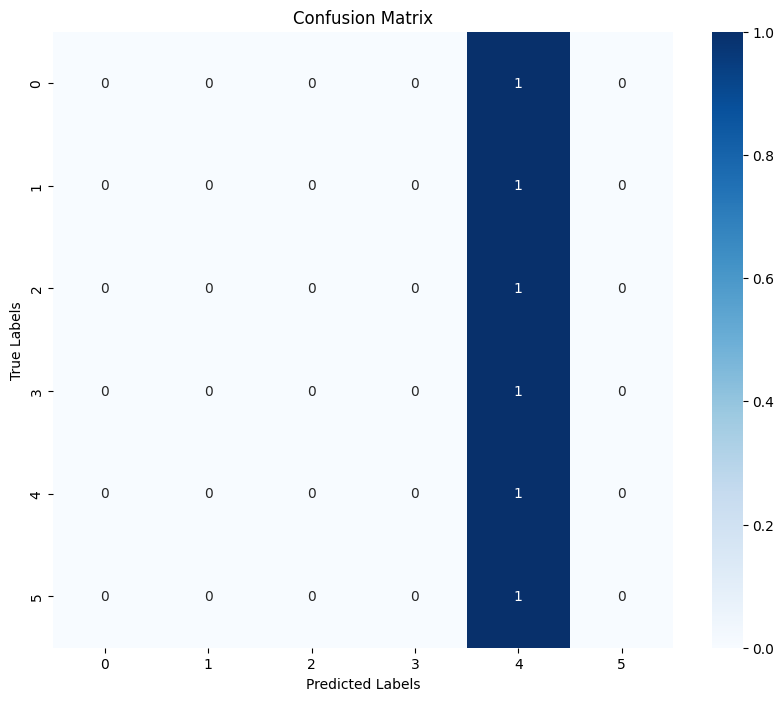

Epoch 1, Validation Loss: 1.8435, Accuracy: 0.0139, F1 Score: 0.0004
Val F1 Score Per Class  [0.         0.         0.         0.         0.02735043 0.        ]


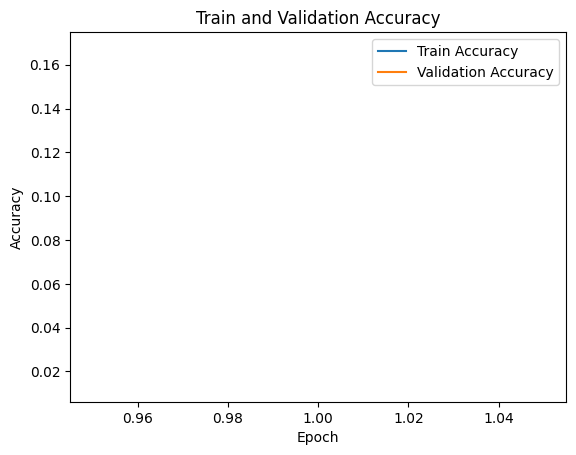

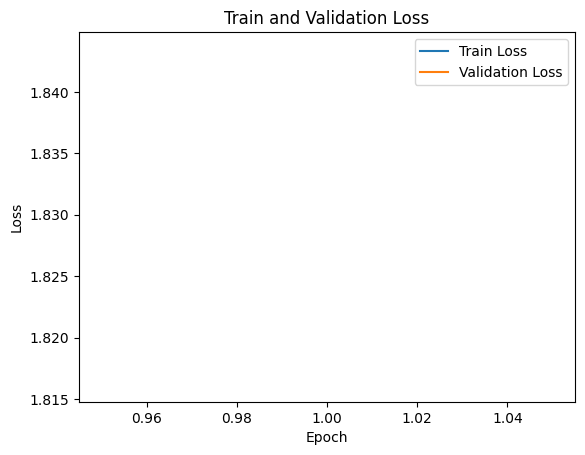

Epoch 2, Train Loss: 1.8154, Accuracy: 0.1682, F1 Score: 0.1641
Train F1 Score Per Class  [0.15208877 0.195819   0.15986622 0.20375821 0.13128282 0.13684961]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.48it/s, loss=1.86]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1713, -0.1613,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0418], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.44it/s, loss=1.89]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1864, -0.1715, -0.1615,  0.0140,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.42it/s, loss=1.76]

[tensor([ 0.0762,  0.1865, -0.1715, -0.1617,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.43it/s, loss=1.79]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.42it/s, loss=1.78]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1713, -0.1615,  0.0141,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.44it/s, loss=1.91]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.45it/s, loss=1.89]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1713, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.45it/s, loss=1.78]

[tensor([ 0.0762,  0.1864, -0.1714, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1713, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.45it/s, loss=1.83]

[tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.43it/s, loss=1.87]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.45it/s, loss=1.77]

[tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.45it/s, loss=1.8]

[tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.44it/s, loss=1.74]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.44it/s, loss=1.82]

[tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1864, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.44it/s, loss=1.82]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1713, -0.1614,  0.0140,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.43it/s, loss=1.82]

[tensor([ 0.0763,  0.1863, -0.1714, -0.1617,  0.0142,  0.0417], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.44it/s, loss=1.74]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1713, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1713, -0.1615,  0.0141,  0.0417], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.44it/s, loss=1.76]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.45it/s, loss=1.94]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.45it/s, loss=1.9]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.45it/s, loss=1.83]

[tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1713, -0.1616,  0.0142,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:20,  2.44it/s, loss=1.76]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0417], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.44it/s, loss=1.88]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1864, -0.1715, -0.1615,  0.0140,  0.0422], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:20,  2.44it/s, loss=1.85]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1716, -0.1617,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.44it/s, loss=1.84]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1616,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.44it/s, loss=1.83]

[tensor([ 0.0762,  0.1864, -0.1714, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:18,  2.44it/s, loss=1.85]

[tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1713, -0.1614,  0.0140,  0.0419], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.45it/s, loss=1.81]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:18,  2.44it/s, loss=1.71]

[tensor([ 0.0761,  0.1861, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1713, -0.1615,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.43it/s, loss=1.77]

[tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1866, -0.1716, -0.1617,  0.0142,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1866, -0.1716, -0.1617,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1714, -0.1617,  0.0141,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.44it/s, loss=1.89]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1860, -0.1712, -0.1613,  0.0140,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.44it/s, loss=1.81]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.45it/s, loss=1.87]

[tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1714, -0.1616,  0.0141,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0140,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1713, -0.1615,  0.0141,  0.0416], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.45it/s, loss=1.84]

[tensor([ 0.0761,  0.1861, -0.1714, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1715, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.44it/s, loss=1.78]

[tensor([ 0.0761,  0.1863, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.46it/s, loss=1.85]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1714, -0.1616,  0.0141,  0.0417], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.44it/s, loss=1.87]

[tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.45it/s, loss=1.87]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.45it/s, loss=1.84]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.45it/s, loss=1.76]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0140,  0.0422], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.45it/s, loss=1.84]

[tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1714, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1616,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.45it/s, loss=1.92]

[tensor([ 0.0761,  0.1861, -0.1714, -0.1615,  0.0141,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0140,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.45it/s, loss=1.88]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0142,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1713, -0.1615,  0.0141,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:11,  2.45it/s, loss=1.83]

[tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1616,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.43it/s, loss=1.85]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.44it/s, loss=1.87]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0142,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.44it/s, loss=1.83]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.42it/s, loss=1.92]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.43it/s, loss=1.9]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.40it/s, loss=1.81]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0142,  0.0417], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:09,  2.41it/s, loss=1.76]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1861, -0.1713, -0.1616,  0.0141,  0.0416], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.42it/s, loss=1.86]

[tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1713, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1862, -0.1713, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.42it/s, loss=1.73]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0140,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0418], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.43it/s, loss=1.85]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.43it/s, loss=1.87]

[tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0422], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.44it/s, loss=1.96]

[tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.44it/s, loss=1.86]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.42it/s, loss=1.89]

[tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.42it/s, loss=1.84]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1617,  0.0142,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.41it/s, loss=1.88]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1713, -0.1615,  0.0141,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:04,  2.42it/s, loss=1.79]

[tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.41it/s, loss=1.73]

[tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.42it/s, loss=1.92]

[tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1712, -0.1613,  0.0140,  0.0417], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.42it/s, loss=1.85]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0763,  0.1863, -0.1714, -0.1617,  0.0142,  0.0417], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1713, -0.1614,  0.0140,  0.0420], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.43it/s, loss=1.89]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.42it/s, loss=1.84]

[tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0140,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1715, -0.1615,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.43it/s, loss=1.87]

[tensor([ 0.0762,  0.1863, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1715, -0.1616,  0.0141,  0.0423], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0420], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.41it/s, loss=1.86]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.41it/s, loss=1.73]

[tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0763,  0.1864, -0.1714, -0.1617,  0.0143,  0.0417], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.42it/s, loss=1.85]

[tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1714, -0.1615,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1862, -0.1714, -0.1614,  0.0140,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1615,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0761,  0.1863, -0.1715, -0.1616,  0.0140,  0.0421], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.42it/s, loss=1.79]

[tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1715, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1616,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1617,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0')]


[tensor([ 0.0762,  0.1862, -0.1714, -0.1615,  0.0141,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0141,  0.0419], device='cuda:0'), tensor([ 0.0762,  0.1865, -0.1716, -0.1616,  0.0141,  0.0422], device='cuda:0'), tensor([ 0.0762,  0.1863, -0.1714, -0.1615,  0.0140,  0.0420], device='cuda:0'), tensor([ 0.0761,  0.1861, -0.1713, -0.1614,  0.0140,  0.0418], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0'), tensor([ 0.0762,  0.1864, -0.1715, -0.1616,  0.0141,  0.0421], device='cuda:0')]
[tensor([ 0.0761,  0.1863, -0.1715, -0.1615,  0.0140,  0.0421], device='cuda:0')]


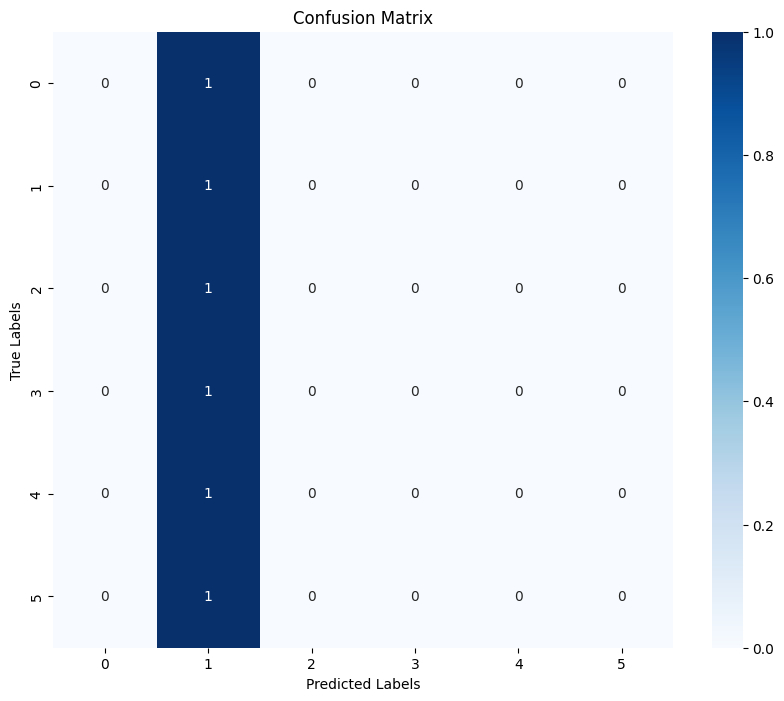

Epoch 2, Validation Loss: 1.8307, Accuracy: 0.2288, F1 Score: 0.0852
Val F1 Score Per Class  [0.         0.37235543 0.         0.         0.         0.        ]


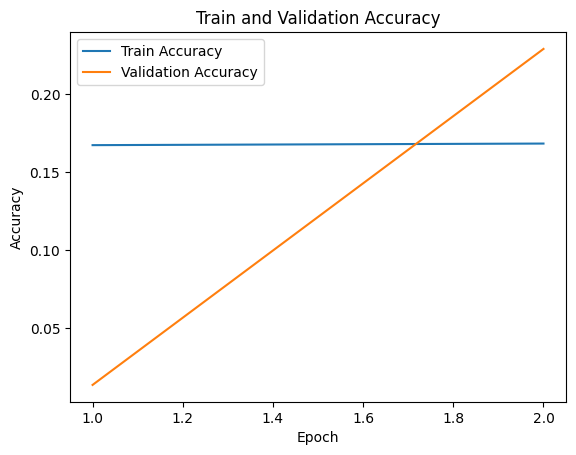

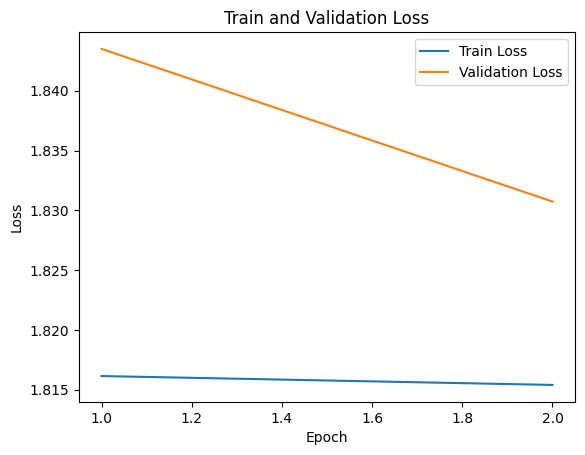

Epoch 3, Train Loss: 1.8131, Accuracy: 0.1641, F1 Score: 0.1618
Train F1 Score Per Class  [0.16066998 0.18419648 0.13612218 0.19884509 0.13812155 0.14889899]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.49it/s, loss=1.78]

[tensor([ 0.0053,  0.0484, -0.0823,  0.1592,  0.0750, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0824,  0.1595,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1588,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0822,  0.1594,  0.0745, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0055,  0.0488, -0.0825,  0.1599,  0.0745, -0.1975], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.50it/s, loss=1.81]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0819,  0.1587,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0051,  0.0480, -0.0817,  0.1582,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0817,  0.1585,  0.0754, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0824,  0.1595,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0818,  0.1587,  0.0753, -0.1971], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.43it/s, loss=1.83]

[tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0822,  0.1592,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1591,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0822,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0818,  0.1585,  0.0754, -0.1970], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.44it/s, loss=1.79]

[tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0747, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1594,  0.0748, -0.1974], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0818,  0.1584,  0.0756, -0.1969], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0747, -0.1974], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.42it/s, loss=1.76]

[tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0055,  0.0490, -0.0825,  0.1601,  0.0742, -0.1978], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1589,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0055,  0.0488, -0.0824,  0.1598,  0.0743, -0.1977], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0822,  0.1593,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0751, -0.1972], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.42it/s, loss=1.76]

[tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0819,  0.1587,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0818,  0.1586,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1597,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1588,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1588,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0824,  0.1594,  0.0747, -0.1973], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.43it/s, loss=1.79]

[tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0820,  0.1591,  0.0748, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0822,  0.1592,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0748, -0.1974], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0820,  0.1584,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0825,  0.1597,  0.0746, -0.1975], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.44it/s, loss=1.86]

[tensor([ 0.0054,  0.0485, -0.0823,  0.1594,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1593,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0055,  0.0487, -0.0824,  0.1597,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0821,  0.1593,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0823,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0818,  0.1585,  0.0752, -0.1971], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.44it/s, loss=1.77]

[tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0752, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1593,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1587,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0055,  0.0488, -0.0824,  0.1596,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0750, -0.1972], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.44it/s, loss=1.84]

[tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1589,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1587,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1587,  0.0753, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0752, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1593,  0.0748, -0.1973], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.44it/s, loss=1.76]

[tensor([ 0.0052,  0.0482, -0.0818,  0.1587,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1595,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0055,  0.0487, -0.0824,  0.1597,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0825,  0.1595,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0055,  0.0488, -0.0825,  0.1598,  0.0745, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0822,  0.1592,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0752, -0.1971], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.45it/s, loss=1.82]

[tensor([ 0.0054,  0.0486, -0.0822,  0.1594,  0.0748, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1595,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0822,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0819,  0.1584,  0.0754, -0.1969], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1597,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0748, -0.1973], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.45it/s, loss=1.77]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0051,  0.0480, -0.0818,  0.1582,  0.0756, -0.1969], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0822,  0.1589,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1591,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1592,  0.0748, -0.1974], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.45it/s, loss=1.79]

[tensor([ 0.0054,  0.0485, -0.0821,  0.1590,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1597,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1591,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0820,  0.1586,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1587,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0822,  0.1593,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1589,  0.0751, -0.1972], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.46it/s, loss=1.8]

[tensor([ 0.0053,  0.0484, -0.0820,  0.1589,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1592,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1593,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1588,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0055,  0.0488, -0.0824,  0.1597,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1596,  0.0746, -0.1974], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.46it/s, loss=1.77]

[tensor([ 0.0055,  0.0490, -0.0828,  0.1601,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1593,  0.0748, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1591,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1592,  0.0750, -0.1971], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.45it/s, loss=1.74]

[tensor([ 0.0053,  0.0485, -0.0822,  0.1593,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0055,  0.0489, -0.0825,  0.1598,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0055,  0.0489, -0.0826,  0.1599,  0.0743, -0.1977], device='cuda:0'), tensor([ 0.0055,  0.0487, -0.0824,  0.1596,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0822,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1587,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1595,  0.0747, -0.1974], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.45it/s, loss=1.71]

[tensor([ 0.0054,  0.0487, -0.0826,  0.1598,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0818,  0.1585,  0.0755, -0.1969], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1595,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1593,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1593,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0823,  0.1592,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0821,  0.1592,  0.0747, -0.1974], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.43it/s, loss=1.75]

[tensor([ 0.0053,  0.0482, -0.0819,  0.1585,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1596,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1590,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0748, -0.1974], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.44it/s, loss=1.85]

[tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1590,  0.0750, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1590,  0.0752, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1596,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0823,  0.1593,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1591,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1589,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0823,  0.1589,  0.0749, -0.1972], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.44it/s, loss=1.77]

[tensor([ 0.0055,  0.0487, -0.0823,  0.1596,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1595,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0057,  0.0492, -0.0827,  0.1601,  0.0741, -0.1978], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1596,  0.0746, -0.1974], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:20,  2.43it/s, loss=1.78]

[tensor([ 0.0054,  0.0484, -0.0822,  0.1590,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0818,  0.1586,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1592,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1591,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0824,  0.1595,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0825,  0.1594,  0.0743, -0.1977], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0820,  0.1591,  0.0748, -0.1974], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.44it/s, loss=1.76]

[tensor([ 0.0054,  0.0485, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1591,  0.0750, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0824,  0.1593,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1587,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0818,  0.1585,  0.0753, -0.1970], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:20,  2.43it/s, loss=1.71]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0819,  0.1585,  0.0755, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1590,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1591,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1589,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0818,  0.1585,  0.0754, -0.1970], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.45it/s, loss=1.82]

[tensor([ 0.0054,  0.0486, -0.0824,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0055,  0.0487, -0.0824,  0.1596,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0818,  0.1583,  0.0755, -0.1969], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0820,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1595,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0826,  0.1596,  0.0745, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0822,  0.1590,  0.0748, -0.1973], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.44it/s, loss=1.74]

[tensor([ 0.0053,  0.0485, -0.0823,  0.1594,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0822,  0.1592,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0820,  0.1590,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1587,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1595,  0.0745, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1591,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:18,  2.44it/s, loss=1.78]

[tensor([ 0.0053,  0.0484, -0.0820,  0.1588,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1593,  0.0748, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0824,  0.1594,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0825,  0.1598,  0.0745, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0819,  0.1586,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1592,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1596,  0.0746, -0.1975], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.45it/s, loss=1.79]

[tensor([ 0.0054,  0.0484, -0.0822,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1591,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1590,  0.0748, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0820,  0.1591,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1586,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0820,  0.1590,  0.0749, -0.1973], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.45it/s, loss=1.73]

[tensor([ 0.0054,  0.0487, -0.0822,  0.1595,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1589,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1597,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0824,  0.1594,  0.0745, -0.1975], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.45it/s, loss=1.75]

[tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0821,  0.1588,  0.0754, -0.1969], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1588,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1589,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0819,  0.1587,  0.0755, -0.1969], device='cuda:0'), tensor([ 0.0055,  0.0490, -0.0828,  0.1601,  0.0742, -0.1977], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1597,  0.0748, -0.1973], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.45it/s, loss=1.7]

[tensor([ 0.0053,  0.0483, -0.0820,  0.1586,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1589,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0824,  0.1594,  0.0745, -0.1976], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0824,  0.1592,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1588,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0055,  0.0489, -0.0824,  0.1597,  0.0741, -0.1977], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0819,  0.1584,  0.0754, -0.1970], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.45it/s, loss=1.71]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0483, -0.0821,  0.1586,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1591,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1587,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1594,  0.0747, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1592,  0.0750, -0.1972], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.44it/s, loss=1.7]

[tensor([ 0.0053,  0.0483, -0.0820,  0.1587,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0488, -0.0825,  0.1598,  0.0744, -0.1977], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1596,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1591,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0752, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0056,  0.0490, -0.0827,  0.1600,  0.0739, -0.1979], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.44it/s, loss=1.75]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1591,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1591,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0824,  0.1596,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1588,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0823,  0.1591,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0747, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0820,  0.1588,  0.0753, -0.1970], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.44it/s, loss=1.81]

[tensor([ 0.0052,  0.0482, -0.0819,  0.1583,  0.0753, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0823,  0.1589,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0822,  0.1593,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0819,  0.1590,  0.0750, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0749, -0.1973], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.44it/s, loss=1.77]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1589,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0055,  0.0489, -0.0826,  0.1599,  0.0743, -0.1977], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1592,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0055,  0.0487, -0.0824,  0.1596,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1594,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0821,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0750, -0.1972], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.44it/s, loss=1.8]

[tensor([ 0.0055,  0.0487, -0.0824,  0.1595,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1592,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0824,  0.1593,  0.0747, -0.1973], device='cuda:0'), tensor([ 0.0055,  0.0488, -0.0824,  0.1597,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0818,  0.1587,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0749, -0.1972], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.44it/s, loss=1.7]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1591,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1589,  0.0750, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0055,  0.0488, -0.0824,  0.1597,  0.0744, -0.1975], device='cuda:0'), tensor([ 0.0052,  0.0480, -0.0819,  0.1583,  0.0753, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1593,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0820,  0.1586,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0747, -0.1974], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.44it/s, loss=1.75]

[tensor([ 0.0054,  0.0486, -0.0822,  0.1594,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0055,  0.0487, -0.0823,  0.1594,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1587,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1588,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0818,  0.1588,  0.0750, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1589,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0751, -0.1972], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.44it/s, loss=1.8]

[tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0824,  0.1589,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0823,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0821,  0.1591,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1586,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0818,  0.1586,  0.0753, -0.1971], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.44it/s, loss=1.75]

[tensor([ 0.0053,  0.0483, -0.0819,  0.1588,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1587,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1592,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1595,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0817,  0.1583,  0.0756, -0.1969], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1591,  0.0750, -0.1971], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.44it/s, loss=1.81]

[tensor([ 0.0055,  0.0488, -0.0826,  0.1598,  0.0740, -0.1978], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0823,  0.1590,  0.0750, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1588,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0818,  0.1585,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1595,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0751, -0.1972], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.44it/s, loss=1.76]

[tensor([ 0.0053,  0.0485, -0.0824,  0.1594,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0820,  0.1588,  0.0754, -0.1969], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0820,  0.1588,  0.0754, -0.1969], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1596,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0055,  0.0489, -0.0826,  0.1599,  0.0743, -0.1976], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0749, -0.1972], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:11,  2.44it/s, loss=1.77]

[tensor([ 0.0052,  0.0481, -0.0820,  0.1584,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1586,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1592,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1592,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1590,  0.0752, -0.1970], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.45it/s, loss=1.8]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0822,  0.1587,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0747, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1587,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0825,  0.1595,  0.0745, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0818,  0.1586,  0.0754, -0.1970], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.43it/s, loss=1.8]

[tensor([ 0.0054,  0.0487, -0.0826,  0.1597,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0823,  0.1594,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1587,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0818,  0.1583,  0.0755, -0.1969], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0750, -0.1972], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.43it/s, loss=1.8]

[tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0818,  0.1584,  0.0756, -0.1969], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0822,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1588,  0.0752, -0.1970], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0818,  0.1584,  0.0755, -0.1969], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0821,  0.1594,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0819,  0.1589,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0747, -0.1974], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.43it/s, loss=1.74]

[tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1591,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1597,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0819,  0.1585,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1590,  0.0749, -0.1973], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.44it/s, loss=1.74]

[tensor([ 0.0054,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1588,  0.0752, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1590,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1594,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1594,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0055,  0.0488, -0.0824,  0.1597,  0.0743, -0.1977], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0751, -0.1971], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.44it/s, loss=1.72]

[tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1595,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0752, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0488, -0.0824,  0.1598,  0.0745, -0.1976], device='cuda:0'), tensor([ 0.0055,  0.0489, -0.0827,  0.1600,  0.0744, -0.1977], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1593,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1589,  0.0749, -0.1973], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:09,  2.42it/s, loss=1.77]

[tensor([ 0.0054,  0.0485, -0.0824,  0.1593,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1596,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0057,  0.0492, -0.0827,  0.1601,  0.0739, -0.1979], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0818,  0.1583,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1594,  0.0745, -0.1975], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.42it/s, loss=1.78]

[tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1592,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0057,  0.0493, -0.0827,  0.1602,  0.0738, -0.1980], device='cuda:0'), tensor([ 0.0054,  0.0488, -0.0824,  0.1597,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0052,  0.0483, -0.0820,  0.1589,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1588,  0.0753, -0.1970], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.43it/s, loss=1.79]

[tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0819,  0.1583,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0822,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1587,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0055,  0.0487, -0.0823,  0.1595,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1596,  0.0746, -0.1975], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.40it/s, loss=1.78]

[tensor([ 0.0054,  0.0487, -0.0824,  0.1596,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1592,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1592,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1592,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0752, -0.1971], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.42it/s, loss=1.71]

[tensor([ 0.0053,  0.0484, -0.0820,  0.1589,  0.0750, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1587,  0.0753, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0818,  0.1585,  0.0754, -0.1969], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1587,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0820,  0.1590,  0.0748, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0821,  0.1589,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0051,  0.0480, -0.0819,  0.1583,  0.0755, -0.1969], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:07,  2.42it/s, loss=1.7]

[tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0825,  0.1597,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0821,  0.1590,  0.0750, -0.1972], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.43it/s, loss=1.78]

[tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0824,  0.1595,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1592,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0820,  0.1590,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0818,  0.1585,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0052,  0.0483, -0.0820,  0.1587,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1588,  0.0751, -0.1971], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.43it/s, loss=1.79]

[tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0747, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1594,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1596,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1587,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1594,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1595,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0750, -0.1972], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.43it/s, loss=1.86]

[tensor([ 0.0054,  0.0485, -0.0824,  0.1591,  0.0747, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1588,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0824,  0.1593,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1596,  0.0745, -0.1976], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1591,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0055,  0.0488, -0.0827,  0.1598,  0.0743, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0752, -0.1971], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.43it/s, loss=1.82]

[tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0055,  0.0487, -0.0823,  0.1595,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0055,  0.0489, -0.0826,  0.1599,  0.0742, -0.1977], device='cuda:0'), tensor([ 0.0053,  0.0482, -0.0820,  0.1586,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1596,  0.0745, -0.1976], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:04,  2.42it/s, loss=1.73]

[tensor([ 0.0052,  0.0481, -0.0818,  0.1585,  0.0755, -0.1969], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0484, -0.0822,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1590,  0.0752, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0825,  0.1596,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0821,  0.1593,  0.0748, -0.1974], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.42it/s, loss=1.73]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1591,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1589,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1591,  0.0750, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1590,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0055,  0.0488, -0.0824,  0.1597,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0748, -0.1973], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.43it/s, loss=1.79]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1587,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0055,  0.0489, -0.0824,  0.1599,  0.0741, -0.1978], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0822,  0.1593,  0.0748, -0.1973], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.43it/s, loss=1.81]

[tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1589,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0753, -0.1971], device='cuda:0'), tensor([ 0.0055,  0.0490, -0.0828,  0.1600,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0821,  0.1590,  0.0748, -0.1973], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.43it/s, loss=1.82]

[tensor([ 0.0054,  0.0485, -0.0824,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0822,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1588,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0485, -0.0820,  0.1590,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1590,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0749, -0.1972], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.43it/s, loss=1.72]

[tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0822,  0.1587,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0817,  0.1583,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1586,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1591,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0749, -0.1973], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.44it/s, loss=1.82]

[tensor([ 0.0053,  0.0484, -0.0822,  0.1591,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1595,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0825,  0.1597,  0.0745, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1595,  0.0745, -0.1975], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0820,  0.1585,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0817,  0.1584,  0.0755, -0.1969], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1588,  0.0748, -0.1973], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.43it/s, loss=1.78]

[tensor([ 0.0053,  0.0483, -0.0820,  0.1587,  0.0753, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0820,  0.1589,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0819,  0.1587,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1594,  0.0749, -0.1972], device='cuda:0'), tensor([ 0.0055,  0.0489, -0.0826,  0.1599,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0824,  0.1594,  0.0747, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0752, -0.1971], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.44it/s, loss=1.76]

[tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0056,  0.0491, -0.0828,  0.1601,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0819,  0.1589,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0486, -0.0823,  0.1594,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1592,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0821,  0.1588,  0.0751, -0.1971], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.44it/s, loss=1.8]

[tensor([ 0.0053,  0.0484, -0.0821,  0.1589,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0753, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0824,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0751, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0747, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0823,  0.1595,  0.0746, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1591,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0052,  0.0482, -0.0821,  0.1585,  0.0753, -0.1970], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.44it/s, loss=1.79]

[tensor([ 0.0055,  0.0488, -0.0825,  0.1598,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0821,  0.1590,  0.0752, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0822,  0.1589,  0.0750, -0.1972], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1594,  0.0749, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0822,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0825,  0.1597,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1589,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0487, -0.0824,  0.1597,  0.0747, -0.1974], device='cuda:0')]


[tensor([ 0.0054,  0.0487, -0.0824,  0.1597,  0.0746, -0.1975], device='cuda:0'), tensor([ 0.0052,  0.0481, -0.0818,  0.1584,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0823,  0.1593,  0.0747, -0.1974], device='cuda:0'), tensor([ 0.0053,  0.0483, -0.0820,  0.1588,  0.0754, -0.1970], device='cuda:0'), tensor([ 0.0054,  0.0485, -0.0821,  0.1592,  0.0748, -0.1973], device='cuda:0'), tensor([ 0.0055,  0.0487, -0.0823,  0.1595,  0.0744, -0.1976], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1591,  0.0751, -0.1971], device='cuda:0'), tensor([ 0.0053,  0.0484, -0.0822,  0.1590,  0.0751, -0.1971], device='cuda:0')]
[tensor([ 0.0053,  0.0483, -0.0820,  0.1587,  0.0752, -0.1971], device='cuda:0')]


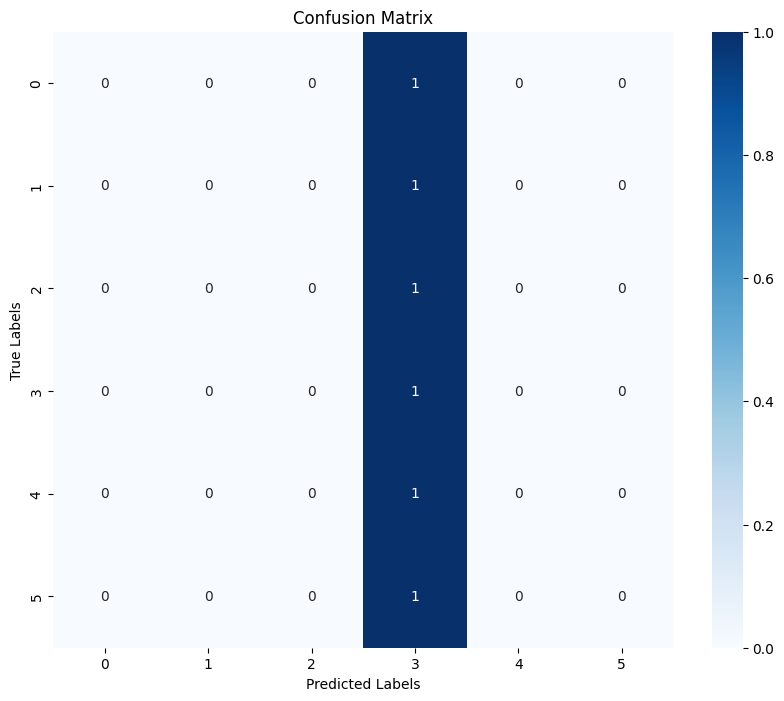

Epoch 3, Validation Loss: 1.7734, Accuracy: 0.2912, F1 Score: 0.1313
Val F1 Score Per Class  [0.         0.         0.         0.45100671 0.         0.        ]


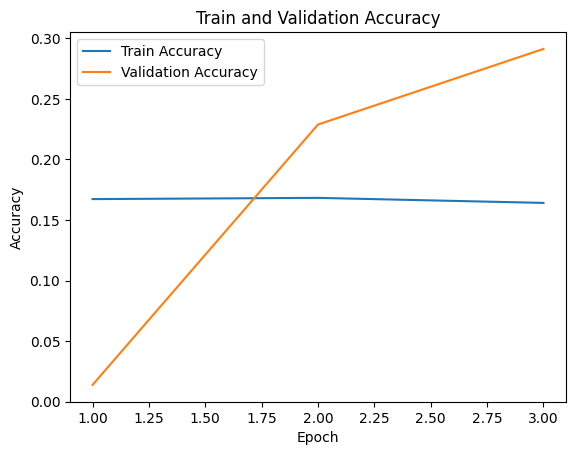

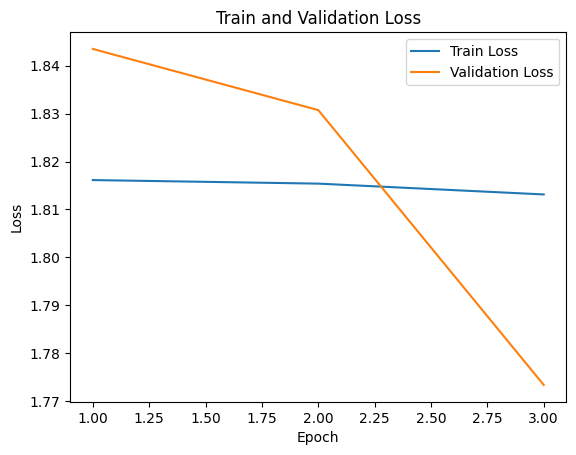

Epoch 4, Train Loss: 1.8129, Accuracy: 0.1725, F1 Score: 0.1672
Train F1 Score Per Class  [0.14225352 0.18546512 0.13040238 0.22501626 0.16599566 0.14951989]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.53it/s, loss=1.76]

[tensor([ 0.2774,  0.2416, -0.6460,  0.5418, -0.6500,  0.3043], device='cuda:0'), tensor([ 0.2771,  0.2406, -0.6497,  0.5396, -0.6506,  0.3015], device='cuda:0'), tensor([ 0.2767,  0.2427, -0.6519,  0.5452, -0.6490,  0.3076], device='cuda:0'), tensor([ 0.2768,  0.2418, -0.6475,  0.5422, -0.6489,  0.3057], device='cuda:0'), tensor([ 0.2764,  0.2404, -0.6433,  0.5368, -0.6468,  0.3018], device='cuda:0'), tensor([ 0.2774,  0.2418, -0.6473,  0.5421, -0.6505,  0.3042], device='cuda:0'), tensor([ 0.2766,  0.2397, -0.6526,  0.5361, -0.6492,  0.2995], device='cuda:0'), tensor([ 0.2774,  0.2400, -0.6429,  0.5355, -0.6501,  0.2988], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.50it/s, loss=2.02]

[tensor([ 0.2773,  0.2409, -0.6453,  0.5393, -0.6506,  0.3021], device='cuda:0'), tensor([ 0.2763,  0.2400, -0.6472,  0.5364, -0.6505,  0.3012], device='cuda:0'), tensor([ 0.2765,  0.2417, -0.6510,  0.5407, -0.6479,  0.3052], device='cuda:0'), tensor([ 0.2773,  0.2413, -0.6516,  0.5413, -0.6503,  0.3024], device='cuda:0'), tensor([ 0.2769,  0.2419, -0.6520,  0.5410, -0.6500,  0.3043], device='cuda:0'), tensor([ 0.2767,  0.2418, -0.6550,  0.5425, -0.6501,  0.3051], device='cuda:0'), tensor([ 0.2766,  0.2411, -0.6509,  0.5413, -0.6501,  0.3032], device='cuda:0'), tensor([ 0.2763,  0.2404, -0.6447,  0.5355, -0.6472,  0.3014], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.45it/s, loss=1.71]

[tensor([ 0.2769,  0.2405, -0.6518,  0.5393, -0.6496,  0.3016], device='cuda:0'), tensor([ 0.2764,  0.2405, -0.6507,  0.5390, -0.6508,  0.3011], device='cuda:0'), tensor([ 0.2757,  0.2418, -0.6539,  0.5429, -0.6496,  0.3071], device='cuda:0'), tensor([ 0.2774,  0.2431, -0.6584,  0.5459, -0.6514,  0.3086], device='cuda:0'), tensor([ 0.2771,  0.2421, -0.6528,  0.5462, -0.6512,  0.3069], device='cuda:0'), tensor([ 0.2767,  0.2424, -0.6479,  0.5451, -0.6506,  0.3065], device='cuda:0'), tensor([ 0.2774,  0.2413, -0.6519,  0.5394, -0.6500,  0.3024], device='cuda:0'), tensor([ 0.2762,  0.2403, -0.6463,  0.5375, -0.6470,  0.3025], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.46it/s, loss=1.84]

[tensor([ 0.2765,  0.2416, -0.6514,  0.5425, -0.6516,  0.3053], device='cuda:0'), tensor([ 0.2772,  0.2429, -0.6499,  0.5448, -0.6505,  0.3072], device='cuda:0'), tensor([ 0.2765,  0.2388, -0.6571,  0.5319, -0.6510,  0.2969], device='cuda:0'), tensor([ 0.2770,  0.2429, -0.6512,  0.5453, -0.6504,  0.3079], device='cuda:0'), tensor([ 0.2769,  0.2431, -0.6574,  0.5473, -0.6504,  0.3093], device='cuda:0'), tensor([ 0.2764,  0.2417, -0.6529,  0.5437, -0.6499,  0.3058], device='cuda:0'), tensor([ 0.2762,  0.2424, -0.6555,  0.5453, -0.6489,  0.3084], device='cuda:0'), tensor([ 0.2767,  0.2417, -0.6564,  0.5425, -0.6503,  0.3045], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.45it/s, loss=1.68]

[tensor([ 0.2770,  0.2422, -0.6502,  0.5437, -0.6510,  0.3062], device='cuda:0'), tensor([ 0.2767,  0.2406, -0.6466,  0.5375, -0.6487,  0.3020], device='cuda:0'), tensor([ 0.2762,  0.2421, -0.6490,  0.5414, -0.6483,  0.3054], device='cuda:0'), tensor([ 0.2770,  0.2417, -0.6526,  0.5429, -0.6504,  0.3043], device='cuda:0'), tensor([ 0.2767,  0.2424, -0.6548,  0.5459, -0.6509,  0.3079], device='cuda:0'), tensor([ 0.2766,  0.2427, -0.6528,  0.5460, -0.6494,  0.3082], device='cuda:0'), tensor([ 0.2779,  0.2404, -0.6460,  0.5375, -0.6510,  0.2997], device='cuda:0'), tensor([ 0.2769,  0.2412, -0.6510,  0.5413, -0.6517,  0.3036], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.46it/s, loss=1.99]

[tensor([ 0.2766,  0.2419, -0.6519,  0.5432, -0.6494,  0.3049], device='cuda:0'), tensor([ 0.2773,  0.2412, -0.6509,  0.5395, -0.6504,  0.3028], device='cuda:0'), tensor([ 0.2762,  0.2409, -0.6450,  0.5394, -0.6468,  0.3033], device='cuda:0'), tensor([ 0.2765,  0.2416, -0.6491,  0.5422, -0.6497,  0.3044], device='cuda:0'), tensor([ 0.2773,  0.2416, -0.6533,  0.5419, -0.6510,  0.3040], device='cuda:0'), tensor([ 0.2771,  0.2418, -0.6510,  0.5437, -0.6499,  0.3053], device='cuda:0'), tensor([ 0.2773,  0.2403, -0.6409,  0.5373, -0.6500,  0.2998], device='cuda:0'), tensor([ 0.2771,  0.2429, -0.6539,  0.5463, -0.6513,  0.3083], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.46it/s, loss=2.03]

[tensor([ 0.2772,  0.2430, -0.6521,  0.5466, -0.6512,  0.3090], device='cuda:0'), tensor([ 0.2768,  0.2426, -0.6523,  0.5430, -0.6491,  0.3061], device='cuda:0'), tensor([ 0.2772,  0.2414, -0.6559,  0.5397, -0.6520,  0.3036], device='cuda:0'), tensor([ 0.2768,  0.2400, -0.6397,  0.5352, -0.6476,  0.3001], device='cuda:0'), tensor([ 0.2775,  0.2396, -0.6391,  0.5341, -0.6498,  0.2970], device='cuda:0'), tensor([ 0.2770,  0.2423, -0.6570,  0.5439, -0.6508,  0.3063], device='cuda:0'), tensor([ 0.2763,  0.2418, -0.6555,  0.5423, -0.6503,  0.3049], device='cuda:0'), tensor([ 0.2771,  0.2411, -0.6508,  0.5416, -0.6504,  0.3024], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.45it/s, loss=1.86]

[tensor([ 0.2767,  0.2402, -0.6479,  0.5390, -0.6486,  0.3016], device='cuda:0'), tensor([ 0.2760,  0.2422, -0.6515,  0.5450, -0.6491,  0.3069], device='cuda:0'), tensor([ 0.2769,  0.2414, -0.6476,  0.5420, -0.6500,  0.3038], device='cuda:0'), tensor([ 0.2768,  0.2414, -0.6517,  0.5407, -0.6503,  0.3028], device='cuda:0'), tensor([ 0.2769,  0.2420, -0.6507,  0.5441, -0.6500,  0.3053], device='cuda:0'), tensor([ 0.2763,  0.2411, -0.6501,  0.5391, -0.6477,  0.3041], device='cuda:0'), tensor([ 0.2766,  0.2405, -0.6506,  0.5393, -0.6498,  0.3016], device='cuda:0'), tensor([ 0.2760,  0.2418, -0.6506,  0.5414, -0.6500,  0.3053], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.46it/s, loss=1.65]

[tensor([ 0.2771,  0.2420, -0.6497,  0.5433, -0.6502,  0.3064], device='cuda:0'), tensor([ 0.2763,  0.2424, -0.6592,  0.5428, -0.6496,  0.3070], device='cuda:0'), tensor([ 0.2759,  0.2414, -0.6490,  0.5410, -0.6493,  0.3046], device='cuda:0'), tensor([ 0.2764,  0.2419, -0.6540,  0.5428, -0.6507,  0.3049], device='cuda:0'), tensor([ 0.2769,  0.2417, -0.6513,  0.5429, -0.6497,  0.3047], device='cuda:0'), tensor([ 0.2764,  0.2403, -0.6507,  0.5386, -0.6500,  0.3016], device='cuda:0'), tensor([ 0.2769,  0.2414, -0.6440,  0.5424, -0.6509,  0.3032], device='cuda:0'), tensor([ 0.2770,  0.2422, -0.6477,  0.5433, -0.6500,  0.3059], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.46it/s, loss=2.06]

[tensor([ 0.2770,  0.2428, -0.6551,  0.5456, -0.6509,  0.3073], device='cuda:0'), tensor([ 0.2772,  0.2430, -0.6535,  0.5463, -0.6518,  0.3080], device='cuda:0'), tensor([ 0.2772,  0.2414, -0.6533,  0.5405, -0.6508,  0.3029], device='cuda:0'), tensor([ 0.2763,  0.2427, -0.6529,  0.5455, -0.6508,  0.3076], device='cuda:0'), tensor([ 0.2772,  0.2425, -0.6507,  0.5443, -0.6504,  0.3066], device='cuda:0'), tensor([ 0.2767,  0.2415, -0.6521,  0.5430, -0.6507,  0.3044], device='cuda:0'), tensor([ 0.2768,  0.2425, -0.6551,  0.5428, -0.6503,  0.3065], device='cuda:0'), tensor([ 0.2770,  0.2427, -0.6532,  0.5450, -0.6508,  0.3076], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.46it/s, loss=1.68]

[tensor([ 0.2759,  0.2410, -0.6472,  0.5384, -0.6468,  0.3029], device='cuda:0'), tensor([ 0.2762,  0.2419, -0.6538,  0.5421, -0.6480,  0.3057], device='cuda:0'), tensor([ 0.2766,  0.2417, -0.6545,  0.5428, -0.6507,  0.3049], device='cuda:0'), tensor([ 0.2773,  0.2418, -0.6477,  0.5427, -0.6501,  0.3046], device='cuda:0'), tensor([ 0.2767,  0.2407, -0.6472,  0.5378, -0.6506,  0.3008], device='cuda:0'), tensor([ 0.2773,  0.2403, -0.6429,  0.5396, -0.6506,  0.3002], device='cuda:0'), tensor([ 0.2771,  0.2428, -0.6578,  0.5455, -0.6504,  0.3078], device='cuda:0'), tensor([ 0.2773,  0.2410, -0.6482,  0.5409, -0.6493,  0.3031], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.46it/s, loss=2.1]

[tensor([ 0.2771,  0.2404, -0.6514,  0.5382, -0.6505,  0.3009], device='cuda:0'), tensor([ 0.2774,  0.2414, -0.6461,  0.5412, -0.6498,  0.3033], device='cuda:0'), tensor([ 0.2768,  0.2413, -0.6504,  0.5417, -0.6508,  0.3033], device='cuda:0'), tensor([ 0.2771,  0.2423, -0.6509,  0.5455, -0.6503,  0.3070], device='cuda:0'), tensor([ 0.2769,  0.2418, -0.6507,  0.5415, -0.6503,  0.3055], device='cuda:0'), tensor([ 0.2771,  0.2422, -0.6550,  0.5442, -0.6520,  0.3054], device='cuda:0'), tensor([ 0.2770,  0.2421, -0.6546,  0.5420, -0.6516,  0.3052], device='cuda:0'), tensor([ 0.2768,  0.2400, -0.6384,  0.5356, -0.6477,  0.2996], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.47it/s, loss=1.72]

[tensor([ 0.2771,  0.2426, -0.6507,  0.5460, -0.6508,  0.3069], device='cuda:0'), tensor([ 0.2764,  0.2404, -0.6473,  0.5384, -0.6484,  0.3012], device='cuda:0'), tensor([ 0.2766,  0.2399, -0.6441,  0.5360, -0.6490,  0.3005], device='cuda:0'), tensor([ 0.2763,  0.2403, -0.6495,  0.5385, -0.6485,  0.3011], device='cuda:0'), tensor([ 0.2768,  0.2411, -0.6498,  0.5403, -0.6507,  0.3035], device='cuda:0'), tensor([ 0.2765,  0.2423, -0.6596,  0.5456, -0.6514,  0.3080], device='cuda:0'), tensor([ 0.2770,  0.2427, -0.6530,  0.5454, -0.6508,  0.3082], device='cuda:0'), tensor([ 0.2770,  0.2424, -0.6520,  0.5453, -0.6507,  0.3074], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:23,  2.46it/s, loss=1.67]

[tensor([ 0.2771,  0.2414, -0.6558,  0.5401, -0.6505,  0.3028], device='cuda:0'), tensor([ 0.2765,  0.2421, -0.6510,  0.5440, -0.6502,  0.3067], device='cuda:0'), tensor([ 0.2773,  0.2428, -0.6521,  0.5455, -0.6510,  0.3077], device='cuda:0'), tensor([ 0.2772,  0.2410, -0.6457,  0.5401, -0.6508,  0.3022], device='cuda:0'), tensor([ 0.2764,  0.2409, -0.6512,  0.5392, -0.6486,  0.3036], device='cuda:0'), tensor([ 0.2766,  0.2415, -0.6545,  0.5409, -0.6517,  0.3051], device='cuda:0'), tensor([ 0.2766,  0.2405, -0.6454,  0.5394, -0.6488,  0.3019], device='cuda:0'), tensor([ 0.2775,  0.2430, -0.6575,  0.5464, -0.6517,  0.3076], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.46it/s, loss=1.95]

[tensor([ 0.2766,  0.2419, -0.6565,  0.5439, -0.6508,  0.3061], device='cuda:0'), tensor([ 0.2765,  0.2400, -0.6422,  0.5369, -0.6484,  0.3005], device='cuda:0'), tensor([ 0.2772,  0.2397, -0.6503,  0.5355, -0.6504,  0.2978], device='cuda:0'), tensor([ 0.2765,  0.2396, -0.6449,  0.5352, -0.6475,  0.2994], device='cuda:0'), tensor([ 0.2762,  0.2420, -0.6553,  0.5427, -0.6498,  0.3069], device='cuda:0'), tensor([ 0.2772,  0.2416, -0.6454,  0.5416, -0.6507,  0.3040], device='cuda:0'), tensor([ 0.2773,  0.2410, -0.6514,  0.5392, -0.6507,  0.3014], device='cuda:0'), tensor([ 0.2769,  0.2421, -0.6529,  0.5436, -0.6503,  0.3058], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.47it/s, loss=1.8]

[tensor([ 0.2762,  0.2384, -0.6384,  0.5295, -0.6466,  0.2964], device='cuda:0'), tensor([ 0.2769,  0.2407, -0.6489,  0.5381, -0.6496,  0.3016], device='cuda:0'), tensor([ 0.2762,  0.2419, -0.6516,  0.5432, -0.6485,  0.3058], device='cuda:0'), tensor([ 0.2768,  0.2414, -0.6522,  0.5424, -0.6495,  0.3040], device='cuda:0'), tensor([ 0.2770,  0.2429, -0.6606,  0.5449, -0.6509,  0.3074], device='cuda:0'), tensor([ 0.2766,  0.2405, -0.6432,  0.5371, -0.6478,  0.3011], device='cuda:0'), tensor([ 0.2768,  0.2419, -0.6547,  0.5432, -0.6500,  0.3048], device='cuda:0'), tensor([ 0.2765,  0.2407, -0.6512,  0.5410, -0.6507,  0.3029], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.46it/s, loss=1.7]

[tensor([ 0.2771,  0.2435, -0.6564,  0.5488, -0.6516,  0.3100], device='cuda:0'), tensor([ 0.2771,  0.2418, -0.6497,  0.5422, -0.6498,  0.3043], device='cuda:0'), tensor([ 0.2767,  0.2392, -0.6395,  0.5331, -0.6498,  0.2980], device='cuda:0'), tensor([ 0.2774,  0.2416, -0.6507,  0.5434, -0.6515,  0.3044], device='cuda:0'), tensor([ 0.2771,  0.2408, -0.6434,  0.5399, -0.6499,  0.3013], device='cuda:0'), tensor([ 0.2767,  0.2428, -0.6537,  0.5453, -0.6514,  0.3071], device='cuda:0'), tensor([ 0.2772,  0.2424, -0.6526,  0.5442, -0.6505,  0.3063], device='cuda:0'), tensor([ 0.2765,  0.2422, -0.6541,  0.5447, -0.6493,  0.3072], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.47it/s, loss=1.54]

[tensor([ 0.2772,  0.2409, -0.6483,  0.5383, -0.6501,  0.3011], device='cuda:0'), tensor([ 0.2767,  0.2424, -0.6519,  0.5448, -0.6497,  0.3064], device='cuda:0'), tensor([ 0.2771,  0.2402, -0.6413,  0.5375, -0.6491,  0.2996], device='cuda:0'), tensor([ 0.2773,  0.2420, -0.6497,  0.5434, -0.6508,  0.3055], device='cuda:0'), tensor([ 0.2769,  0.2410, -0.6534,  0.5410, -0.6491,  0.3022], device='cuda:0'), tensor([ 0.2769,  0.2427, -0.6510,  0.5456, -0.6513,  0.3076], device='cuda:0'), tensor([ 0.2764,  0.2408, -0.6533,  0.5404, -0.6495,  0.3032], device='cuda:0'), tensor([ 0.2774,  0.2411, -0.6513,  0.5411, -0.6511,  0.3033], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:21,  2.47it/s, loss=1.69]

[tensor([ 0.2763,  0.2421, -0.6497,  0.5435, -0.6501,  0.3067], device='cuda:0'), tensor([ 0.2769,  0.2410, -0.6447,  0.5406, -0.6498,  0.3033], device='cuda:0'), tensor([ 0.2766,  0.2423, -0.6581,  0.5460, -0.6501,  0.3080], device='cuda:0'), tensor([ 0.2773,  0.2415, -0.6549,  0.5424, -0.6511,  0.3045], device='cuda:0'), tensor([ 0.2763,  0.2413, -0.6495,  0.5410, -0.6483,  0.3043], device='cuda:0'), tensor([ 0.2770,  0.2418, -0.6492,  0.5439, -0.6507,  0.3055], device='cuda:0'), tensor([ 0.2774,  0.2402, -0.6433,  0.5364, -0.6492,  0.2993], device='cuda:0'), tensor([ 0.2768,  0.2430, -0.6586,  0.5477, -0.6502,  0.3090], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.47it/s, loss=2.18]

[tensor([ 0.2768,  0.2416, -0.6562,  0.5423, -0.6500,  0.3043], device='cuda:0'), tensor([ 0.2773,  0.2425, -0.6565,  0.5445, -0.6513,  0.3067], device='cuda:0'), tensor([ 0.2768,  0.2419, -0.6570,  0.5434, -0.6506,  0.3055], device='cuda:0'), tensor([ 0.2762,  0.2425, -0.6538,  0.5460, -0.6511,  0.3087], device='cuda:0'), tensor([ 0.2767,  0.2399, -0.6419,  0.5348, -0.6472,  0.3003], device='cuda:0'), tensor([ 0.2767,  0.2407, -0.6528,  0.5382, -0.6504,  0.3007], device='cuda:0'), tensor([ 0.2768,  0.2425, -0.6558,  0.5433, -0.6502,  0.3067], device='cuda:0'), tensor([ 0.2763,  0.2419, -0.6563,  0.5435, -0.6499,  0.3073], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.47it/s, loss=1.79]

[tensor([ 0.2761,  0.2411, -0.6516,  0.5425, -0.6483,  0.3046], device='cuda:0'), tensor([ 0.2767,  0.2433, -0.6560,  0.5473, -0.6507,  0.3090], device='cuda:0'), tensor([ 0.2771,  0.2425, -0.6518,  0.5454, -0.6510,  0.3068], device='cuda:0'), tensor([ 0.2768,  0.2434, -0.6566,  0.5480, -0.6522,  0.3096], device='cuda:0'), tensor([ 0.2767,  0.2419, -0.6544,  0.5426, -0.6500,  0.3054], device='cuda:0'), tensor([ 0.2771,  0.2395, -0.6349,  0.5355, -0.6492,  0.2984], device='cuda:0'), tensor([ 0.2760,  0.2390, -0.6354,  0.5325, -0.6459,  0.2979], device='cuda:0'), tensor([ 0.2772,  0.2430, -0.6571,  0.5471, -0.6510,  0.3081], device='cuda:0')]


Val:  30%|███       | 22/73 [00:08<00:20,  2.47it/s, loss=1.84]

[tensor([ 0.2771,  0.2405, -0.6528,  0.5404, -0.6499,  0.3010], device='cuda:0'), tensor([ 0.2764,  0.2427, -0.6604,  0.5439, -0.6498,  0.3072], device='cuda:0'), tensor([ 0.2768,  0.2420, -0.6487,  0.5443, -0.6493,  0.3060], device='cuda:0'), tensor([ 0.2763,  0.2418, -0.6515,  0.5430, -0.6509,  0.3064], device='cuda:0'), tensor([ 0.2765,  0.2388, -0.6392,  0.5328, -0.6477,  0.2969], device='cuda:0'), tensor([ 0.2766,  0.2397, -0.6603,  0.5358, -0.6516,  0.2992], device='cuda:0'), tensor([ 0.2770,  0.2419, -0.6535,  0.5417, -0.6500,  0.3053], device='cuda:0'), tensor([ 0.2764,  0.2428, -0.6543,  0.5445, -0.6485,  0.3088], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.47it/s, loss=1.88]

[tensor([ 0.2769,  0.2397, -0.6435,  0.5386, -0.6507,  0.2995], device='cuda:0'), tensor([ 0.2766,  0.2418, -0.6490,  0.5429, -0.6515,  0.3043], device='cuda:0'), tensor([ 0.2770,  0.2429, -0.6574,  0.5474, -0.6522,  0.3083], device='cuda:0'), tensor([ 0.2766,  0.2406, -0.6533,  0.5377, -0.6485,  0.3009], device='cuda:0'), tensor([ 0.2764,  0.2415, -0.6493,  0.5432, -0.6502,  0.3048], device='cuda:0'), tensor([ 0.2769,  0.2428, -0.6563,  0.5451, -0.6515,  0.3075], device='cuda:0'), tensor([ 0.2764,  0.2394, -0.6420,  0.5327, -0.6481,  0.2981], device='cuda:0'), tensor([ 0.2771,  0.2420, -0.6474,  0.5431, -0.6507,  0.3055], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.47it/s, loss=1.74]

[tensor([ 0.2767,  0.2410, -0.6553,  0.5396, -0.6500,  0.3027], device='cuda:0'), tensor([ 0.2766,  0.2389, -0.6392,  0.5333, -0.6466,  0.2986], device='cuda:0'), tensor([ 0.2768,  0.2412, -0.6562,  0.5413, -0.6513,  0.3036], device='cuda:0'), tensor([ 0.2771,  0.2410, -0.6545,  0.5413, -0.6508,  0.3023], device='cuda:0'), tensor([ 0.2771,  0.2426, -0.6571,  0.5462, -0.6521,  0.3072], device='cuda:0'), tensor([ 0.2766,  0.2428, -0.6534,  0.5472, -0.6507,  0.3084], device='cuda:0'), tensor([ 0.2764,  0.2417, -0.6528,  0.5431, -0.6497,  0.3050], device='cuda:0'), tensor([ 0.2763,  0.2420, -0.6561,  0.5431, -0.6499,  0.3049], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.47it/s, loss=1.79]

[tensor([ 0.2772,  0.2419, -0.6489,  0.5437, -0.6506,  0.3048], device='cuda:0'), tensor([ 0.2773,  0.2403, -0.6476,  0.5381, -0.6502,  0.2994], device='cuda:0'), tensor([ 0.2768,  0.2425, -0.6502,  0.5456, -0.6495,  0.3075], device='cuda:0'), tensor([ 0.2769,  0.2419, -0.6602,  0.5434, -0.6508,  0.3053], device='cuda:0'), tensor([ 0.2769,  0.2425, -0.6579,  0.5470, -0.6513,  0.3079], device='cuda:0'), tensor([ 0.2769,  0.2428, -0.6554,  0.5459, -0.6509,  0.3076], device='cuda:0'), tensor([ 0.2768,  0.2404, -0.6568,  0.5383, -0.6497,  0.3008], device='cuda:0'), tensor([ 0.2763,  0.2413, -0.6550,  0.5414, -0.6495,  0.3044], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.46it/s, loss=1.49]

[tensor([ 0.2768,  0.2411, -0.6463,  0.5405, -0.6495,  0.3030], device='cuda:0'), tensor([ 0.2773,  0.2423, -0.6573,  0.5439, -0.6513,  0.3056], device='cuda:0'), tensor([ 0.2776,  0.2429, -0.6524,  0.5433, -0.6515,  0.3069], device='cuda:0'), tensor([ 0.2769,  0.2405, -0.6562,  0.5383, -0.6507,  0.3006], device='cuda:0'), tensor([ 0.2776,  0.2428, -0.6539,  0.5451, -0.6518,  0.3067], device='cuda:0'), tensor([ 0.2761,  0.2419, -0.6506,  0.5420, -0.6502,  0.3055], device='cuda:0'), tensor([ 0.2769,  0.2419, -0.6552,  0.5443, -0.6521,  0.3054], device='cuda:0'), tensor([ 0.2764,  0.2426, -0.6546,  0.5455, -0.6504,  0.3071], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:10<00:18,  2.47it/s, loss=1.92]

[tensor([ 0.2769,  0.2421, -0.6564,  0.5429, -0.6501,  0.3065], device='cuda:0'), tensor([ 0.2766,  0.2393, -0.6491,  0.5342, -0.6497,  0.2994], device='cuda:0'), tensor([ 0.2770,  0.2415, -0.6547,  0.5432, -0.6507,  0.3042], device='cuda:0'), tensor([ 0.2763,  0.2417, -0.6479,  0.5401, -0.6481,  0.3052], device='cuda:0'), tensor([ 0.2766,  0.2411, -0.6557,  0.5417, -0.6502,  0.3040], device='cuda:0'), tensor([ 0.2768,  0.2426, -0.6510,  0.5440, -0.6491,  0.3075], device='cuda:0'), tensor([ 0.2770,  0.2423, -0.6535,  0.5446, -0.6493,  0.3064], device='cuda:0'), tensor([ 0.2767,  0.2425, -0.6520,  0.5438, -0.6497,  0.3083], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.45it/s, loss=1.8]

[tensor([ 0.2767,  0.2420, -0.6509,  0.5432, -0.6503,  0.3059], device='cuda:0'), tensor([ 0.2765,  0.2428, -0.6563,  0.5464, -0.6492,  0.3091], device='cuda:0'), tensor([ 0.2775,  0.2416, -0.6456,  0.5434, -0.6508,  0.3044], device='cuda:0'), tensor([ 0.2759,  0.2422, -0.6541,  0.5449, -0.6481,  0.3086], device='cuda:0'), tensor([ 0.2768,  0.2411, -0.6549,  0.5402, -0.6510,  0.3029], device='cuda:0'), tensor([ 0.2773,  0.2417, -0.6538,  0.5433, -0.6502,  0.3047], device='cuda:0'), tensor([ 0.2772,  0.2427, -0.6564,  0.5442, -0.6508,  0.3072], device='cuda:0'), tensor([ 0.2771,  0.2418, -0.6544,  0.5429, -0.6521,  0.3052], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.45it/s, loss=1.58]

[tensor([ 0.2778,  0.2419, -0.6518,  0.5425, -0.6507,  0.3040], device='cuda:0'), tensor([ 0.2769,  0.2416, -0.6481,  0.5451, -0.6503,  0.3059], device='cuda:0'), tensor([ 0.2761,  0.2406, -0.6601,  0.5405, -0.6512,  0.3033], device='cuda:0'), tensor([ 0.2769,  0.2407, -0.6454,  0.5400, -0.6490,  0.3020], device='cuda:0'), tensor([ 0.2764,  0.2417, -0.6492,  0.5416, -0.6498,  0.3049], device='cuda:0'), tensor([ 0.2770,  0.2418, -0.6541,  0.5432, -0.6498,  0.3050], device='cuda:0'), tensor([ 0.2762,  0.2425, -0.6571,  0.5455, -0.6498,  0.3077], device='cuda:0'), tensor([ 0.2771,  0.2427, -0.6551,  0.5458, -0.6510,  0.3081], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.45it/s, loss=1.69]

[tensor([ 0.2765,  0.2419, -0.6503,  0.5434, -0.6501,  0.3065], device='cuda:0'), tensor([ 0.2769,  0.2402, -0.6453,  0.5367, -0.6493,  0.3001], device='cuda:0'), tensor([ 0.2769,  0.2428, -0.6527,  0.5457, -0.6497,  0.3074], device='cuda:0'), tensor([ 0.2768,  0.2414, -0.6519,  0.5432, -0.6507,  0.3050], device='cuda:0'), tensor([ 0.2766,  0.2438, -0.6596,  0.5493, -0.6499,  0.3120], device='cuda:0'), tensor([ 0.2765,  0.2426, -0.6570,  0.5445, -0.6504,  0.3078], device='cuda:0'), tensor([ 0.2768,  0.2378, -0.6265,  0.5274, -0.6467,  0.2932], device='cuda:0'), tensor([ 0.2769,  0.2399, -0.6501,  0.5376, -0.6493,  0.3009], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.45it/s, loss=1.58]

[tensor([ 0.2764,  0.2410, -0.6490,  0.5398, -0.6493,  0.3019], device='cuda:0'), tensor([ 0.2774,  0.2426, -0.6501,  0.5446, -0.6504,  0.3071], device='cuda:0'), tensor([ 0.2761,  0.2414, -0.6458,  0.5405, -0.6477,  0.3047], device='cuda:0'), tensor([ 0.2771,  0.2409, -0.6447,  0.5403, -0.6500,  0.3021], device='cuda:0'), tensor([ 0.2768,  0.2420, -0.6549,  0.5441, -0.6499,  0.3068], device='cuda:0'), tensor([ 0.2759,  0.2421, -0.6552,  0.5436, -0.6511,  0.3074], device='cuda:0'), tensor([ 0.2771,  0.2419, -0.6546,  0.5434, -0.6510,  0.3047], device='cuda:0'), tensor([ 0.2772,  0.2406, -0.6452,  0.5388, -0.6502,  0.3015], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:12<00:16,  2.45it/s, loss=1.5]

[tensor([ 0.2772,  0.2425, -0.6582,  0.5457, -0.6525,  0.3065], device='cuda:0'), tensor([ 0.2762,  0.2404, -0.6468,  0.5372, -0.6485,  0.3004], device='cuda:0'), tensor([ 0.2771,  0.2425, -0.6496,  0.5439, -0.6495,  0.3064], device='cuda:0'), tensor([ 0.2772,  0.2411, -0.6519,  0.5422, -0.6510,  0.3025], device='cuda:0'), tensor([ 0.2774,  0.2421, -0.6543,  0.5427, -0.6517,  0.3051], device='cuda:0'), tensor([ 0.2771,  0.2417, -0.6492,  0.5421, -0.6504,  0.3047], device='cuda:0'), tensor([ 0.2764,  0.2411, -0.6462,  0.5401, -0.6483,  0.3038], device='cuda:0'), tensor([ 0.2769,  0.2416, -0.6565,  0.5429, -0.6509,  0.3038], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.45it/s, loss=1.59]

[tensor([ 0.2763,  0.2426, -0.6568,  0.5445, -0.6486,  0.3085], device='cuda:0'), tensor([ 0.2773,  0.2410, -0.6518,  0.5394, -0.6506,  0.3028], device='cuda:0'), tensor([ 0.2756,  0.2405, -0.6412,  0.5378, -0.6485,  0.3029], device='cuda:0'), tensor([ 0.2775,  0.2413, -0.6563,  0.5408, -0.6511,  0.3026], device='cuda:0'), tensor([ 0.2774,  0.2428, -0.6492,  0.5469, -0.6513,  0.3072], device='cuda:0'), tensor([ 0.2775,  0.2409, -0.6402,  0.5390, -0.6501,  0.3006], device='cuda:0'), tensor([ 0.2761,  0.2423, -0.6586,  0.5445, -0.6501,  0.3083], device='cuda:0'), tensor([ 0.2764,  0.2405, -0.6462,  0.5375, -0.6484,  0.3010], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.46it/s, loss=1.77]

[tensor([ 0.2774,  0.2416, -0.6497,  0.5419, -0.6512,  0.3037], device='cuda:0'), tensor([ 0.2771,  0.2424, -0.6576,  0.5433, -0.6514,  0.3063], device='cuda:0'), tensor([ 0.2765,  0.2416, -0.6504,  0.5421, -0.6520,  0.3044], device='cuda:0'), tensor([ 0.2774,  0.2403, -0.6456,  0.5374, -0.6505,  0.2996], device='cuda:0'), tensor([ 0.2776,  0.2428, -0.6574,  0.5460, -0.6515,  0.3070], device='cuda:0'), tensor([ 0.2770,  0.2415, -0.6459,  0.5426, -0.6504,  0.3044], device='cuda:0'), tensor([ 0.2763,  0.2423, -0.6591,  0.5455, -0.6503,  0.3078], device='cuda:0'), tensor([ 0.2760,  0.2408, -0.6520,  0.5387, -0.6485,  0.3021], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.45it/s, loss=1.84]

[tensor([ 0.2774,  0.2422, -0.6510,  0.5444, -0.6505,  0.3060], device='cuda:0'), tensor([ 0.2763,  0.2418, -0.6512,  0.5423, -0.6488,  0.3058], device='cuda:0'), tensor([ 0.2769,  0.2418, -0.6509,  0.5413, -0.6506,  0.3050], device='cuda:0'), tensor([ 0.2771,  0.2426, -0.6519,  0.5463, -0.6516,  0.3080], device='cuda:0'), tensor([ 0.2763,  0.2412, -0.6523,  0.5409, -0.6486,  0.3037], device='cuda:0'), tensor([ 0.2770,  0.2411, -0.6519,  0.5411, -0.6515,  0.3029], device='cuda:0'), tensor([ 0.2766,  0.2423, -0.6525,  0.5446, -0.6495,  0.3065], device='cuda:0'), tensor([ 0.2767,  0.2430, -0.6559,  0.5464, -0.6496,  0.3093], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.46it/s, loss=1.76]

[tensor([ 0.2767,  0.2417, -0.6464,  0.5431, -0.6507,  0.3037], device='cuda:0'), tensor([ 0.2768,  0.2417, -0.6505,  0.5437, -0.6502,  0.3052], device='cuda:0'), tensor([ 0.2771,  0.2383, -0.6428,  0.5306, -0.6485,  0.2944], device='cuda:0'), tensor([ 0.2771,  0.2426, -0.6532,  0.5453, -0.6523,  0.3068], device='cuda:0'), tensor([ 0.2769,  0.2417, -0.6517,  0.5416, -0.6505,  0.3042], device='cuda:0'), tensor([ 0.2777,  0.2405, -0.6434,  0.5367, -0.6499,  0.3002], device='cuda:0'), tensor([ 0.2762,  0.2417, -0.6478,  0.5438, -0.6499,  0.3067], device='cuda:0'), tensor([ 0.2769,  0.2434, -0.6530,  0.5479, -0.6509,  0.3096], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.45it/s, loss=2.18]

[tensor([ 0.2769,  0.2411, -0.6512,  0.5395, -0.6504,  0.3015], device='cuda:0'), tensor([ 0.2767,  0.2418, -0.6486,  0.5412, -0.6485,  0.3046], device='cuda:0'), tensor([ 0.2766,  0.2421, -0.6534,  0.5419, -0.6502,  0.3055], device='cuda:0'), tensor([ 0.2766,  0.2419, -0.6567,  0.5459, -0.6497,  0.3075], device='cuda:0'), tensor([ 0.2767,  0.2427, -0.6532,  0.5449, -0.6502,  0.3066], device='cuda:0'), tensor([ 0.2766,  0.2408, -0.6480,  0.5407, -0.6501,  0.3023], device='cuda:0'), tensor([ 0.2762,  0.2425, -0.6512,  0.5451, -0.6506,  0.3088], device='cuda:0'), tensor([ 0.2774,  0.2425, -0.6535,  0.5452, -0.6513,  0.3064], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.45it/s, loss=1.46]

[tensor([ 0.2777,  0.2422, -0.6490,  0.5441, -0.6513,  0.3055], device='cuda:0'), tensor([ 0.2773,  0.2422, -0.6515,  0.5441, -0.6503,  0.3053], device='cuda:0'), tensor([ 0.2766,  0.2401, -0.6482,  0.5387, -0.6490,  0.3013], device='cuda:0'), tensor([ 0.2771,  0.2421, -0.6493,  0.5447, -0.6513,  0.3064], device='cuda:0'), tensor([ 0.2764,  0.2426, -0.6497,  0.5430, -0.6490,  0.3073], device='cuda:0'), tensor([ 0.2766,  0.2397, -0.6430,  0.5331, -0.6478,  0.2984], device='cuda:0'), tensor([ 0.2768,  0.2420, -0.6524,  0.5436, -0.6512,  0.3060], device='cuda:0'), tensor([ 0.2775,  0.2413, -0.6465,  0.5416, -0.6501,  0.3025], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.44it/s, loss=1.77]

[tensor([ 0.2764,  0.2386, -0.6354,  0.5320, -0.6483,  0.2970], device='cuda:0'), tensor([ 0.2767,  0.2425, -0.6526,  0.5440, -0.6496,  0.3071], device='cuda:0'), tensor([ 0.2765,  0.2418, -0.6554,  0.5444, -0.6513,  0.3062], device='cuda:0'), tensor([ 0.2765,  0.2421, -0.6596,  0.5429, -0.6499,  0.3060], device='cuda:0'), tensor([ 0.2772,  0.2434, -0.6534,  0.5445, -0.6502,  0.3072], device='cuda:0'), tensor([ 0.2762,  0.2417, -0.6540,  0.5432, -0.6488,  0.3061], device='cuda:0'), tensor([ 0.2767,  0.2412, -0.6546,  0.5412, -0.6505,  0.3037], device='cuda:0'), tensor([ 0.2767,  0.2420, -0.6505,  0.5432, -0.6498,  0.3052], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.43it/s, loss=1.84]

[tensor([ 0.2767,  0.2423, -0.6542,  0.5447, -0.6511,  0.3071], device='cuda:0'), tensor([ 0.2772,  0.2410, -0.6515,  0.5408, -0.6506,  0.3030], device='cuda:0'), tensor([ 0.2768,  0.2427, -0.6527,  0.5450, -0.6501,  0.3071], device='cuda:0'), tensor([ 0.2773,  0.2411, -0.6484,  0.5401, -0.6504,  0.3028], device='cuda:0'), tensor([ 0.2772,  0.2424, -0.6536,  0.5459, -0.6515,  0.3067], device='cuda:0'), tensor([ 0.2767,  0.2422, -0.6556,  0.5439, -0.6496,  0.3067], device='cuda:0'), tensor([ 0.2761,  0.2403, -0.6451,  0.5387, -0.6485,  0.3019], device='cuda:0'), tensor([ 0.2769,  0.2408, -0.6473,  0.5396, -0.6502,  0.3014], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.43it/s, loss=1.77]

[tensor([ 0.2770,  0.2414, -0.6543,  0.5407, -0.6505,  0.3030], device='cuda:0'), tensor([ 0.2762,  0.2392, -0.6403,  0.5348, -0.6478,  0.2997], device='cuda:0'), tensor([ 0.2764,  0.2425, -0.6536,  0.5444, -0.6490,  0.3084], device='cuda:0'), tensor([ 0.2768,  0.2415, -0.6480,  0.5413, -0.6506,  0.3045], device='cuda:0'), tensor([ 0.2763,  0.2419, -0.6544,  0.5430, -0.6489,  0.3054], device='cuda:0'), tensor([ 0.2767,  0.2420, -0.6550,  0.5434, -0.6491,  0.3063], device='cuda:0'), tensor([ 0.2766,  0.2410, -0.6527,  0.5400, -0.6498,  0.3031], device='cuda:0'), tensor([ 0.2767,  0.2430, -0.6581,  0.5462, -0.6494,  0.3090], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.43it/s, loss=2.15]

[tensor([ 0.2775,  0.2410, -0.6422,  0.5388, -0.6499,  0.3017], device='cuda:0'), tensor([ 0.2767,  0.2430, -0.6529,  0.5457, -0.6517,  0.3086], device='cuda:0'), tensor([ 0.2771,  0.2418, -0.6546,  0.5435, -0.6514,  0.3039], device='cuda:0'), tensor([ 0.2772,  0.2423, -0.6526,  0.5436, -0.6506,  0.3063], device='cuda:0'), tensor([ 0.2767,  0.2426, -0.6524,  0.5443, -0.6495,  0.3081], device='cuda:0'), tensor([ 0.2768,  0.2417, -0.6512,  0.5430, -0.6507,  0.3047], device='cuda:0'), tensor([ 0.2765,  0.2410, -0.6538,  0.5401, -0.6508,  0.3045], device='cuda:0'), tensor([ 0.2767,  0.2419, -0.6530,  0.5435, -0.6501,  0.3060], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.43it/s, loss=1.88]

[tensor([ 0.2765,  0.2406, -0.6444,  0.5389, -0.6482,  0.3025], device='cuda:0'), tensor([ 0.2770,  0.2391, -0.6487,  0.5336, -0.6499,  0.2976], device='cuda:0'), tensor([ 0.2765,  0.2410, -0.6529,  0.5398, -0.6499,  0.3036], device='cuda:0'), tensor([ 0.2766,  0.2415, -0.6474,  0.5412, -0.6490,  0.3045], device='cuda:0'), tensor([ 0.2766,  0.2415, -0.6599,  0.5418, -0.6494,  0.3044], device='cuda:0'), tensor([ 0.2771,  0.2399, -0.6398,  0.5356, -0.6488,  0.2991], device='cuda:0'), tensor([ 0.2763,  0.2383, -0.6519,  0.5308, -0.6494,  0.2955], device='cuda:0'), tensor([ 0.2770,  0.2390, -0.6405,  0.5336, -0.6494,  0.2959], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:17<00:11,  2.43it/s, loss=1.64]

[tensor([ 0.2774,  0.2431, -0.6548,  0.5451, -0.6514,  0.3073], device='cuda:0'), tensor([ 0.2762,  0.2416, -0.6513,  0.5431, -0.6497,  0.3049], device='cuda:0'), tensor([ 0.2763,  0.2427, -0.6558,  0.5461, -0.6501,  0.3086], device='cuda:0'), tensor([ 0.2773,  0.2428, -0.6518,  0.5450, -0.6505,  0.3069], device='cuda:0'), tensor([ 0.2762,  0.2419, -0.6511,  0.5441, -0.6495,  0.3063], device='cuda:0'), tensor([ 0.2764,  0.2423, -0.6565,  0.5442, -0.6497,  0.3059], device='cuda:0'), tensor([ 0.2760,  0.2417, -0.6527,  0.5432, -0.6495,  0.3057], device='cuda:0'), tensor([ 0.2766,  0.2417, -0.6502,  0.5428, -0.6500,  0.3057], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.44it/s, loss=1.91]

[tensor([ 0.2764,  0.2423, -0.6542,  0.5445, -0.6509,  0.3077], device='cuda:0'), tensor([ 0.2776,  0.2424, -0.6500,  0.5442, -0.6507,  0.3064], device='cuda:0'), tensor([ 0.2772,  0.2413, -0.6496,  0.5423, -0.6501,  0.3031], device='cuda:0'), tensor([ 0.2767,  0.2420, -0.6521,  0.5443, -0.6508,  0.3060], device='cuda:0'), tensor([ 0.2767,  0.2420, -0.6520,  0.5435, -0.6513,  0.3062], device='cuda:0'), tensor([ 0.2769,  0.2424, -0.6478,  0.5446, -0.6505,  0.3068], device='cuda:0'), tensor([ 0.2770,  0.2411, -0.6474,  0.5397, -0.6489,  0.3030], device='cuda:0'), tensor([ 0.2757,  0.2413, -0.6497,  0.5413, -0.6491,  0.3051], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.44it/s, loss=1.76]

[tensor([ 0.2764,  0.2402, -0.6393,  0.5354, -0.6481,  0.2999], device='cuda:0'), tensor([ 0.2770,  0.2416, -0.6509,  0.5424, -0.6502,  0.3049], device='cuda:0'), tensor([ 0.2768,  0.2414, -0.6537,  0.5408, -0.6486,  0.3041], device='cuda:0'), tensor([ 0.2775,  0.2419, -0.6504,  0.5418, -0.6504,  0.3041], device='cuda:0'), tensor([ 0.2769,  0.2414, -0.6524,  0.5399, -0.6498,  0.3045], device='cuda:0'), tensor([ 0.2765,  0.2416, -0.6541,  0.5432, -0.6505,  0.3055], device='cuda:0'), tensor([ 0.2772,  0.2429, -0.6506,  0.5454, -0.6510,  0.3078], device='cuda:0'), tensor([ 0.2761,  0.2414, -0.6511,  0.5416, -0.6511,  0.3046], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.44it/s, loss=1.79]

[tensor([ 0.2773,  0.2419, -0.6542,  0.5429, -0.6510,  0.3055], device='cuda:0'), tensor([ 0.2766,  0.2425, -0.6521,  0.5444, -0.6496,  0.3074], device='cuda:0'), tensor([ 0.2765,  0.2424, -0.6521,  0.5454, -0.6516,  0.3061], device='cuda:0'), tensor([ 0.2767,  0.2411, -0.6545,  0.5409, -0.6498,  0.3040], device='cuda:0'), tensor([ 0.2758,  0.2415, -0.6517,  0.5419, -0.6481,  0.3052], device='cuda:0'), tensor([ 0.2768,  0.2421, -0.6576,  0.5428, -0.6510,  0.3049], device='cuda:0'), tensor([ 0.2762,  0.2419, -0.6517,  0.5430, -0.6489,  0.3048], device='cuda:0'), tensor([ 0.2772,  0.2426, -0.6549,  0.5451, -0.6514,  0.3074], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.44it/s, loss=1.85]

[tensor([ 0.2774,  0.2422, -0.6478,  0.5441, -0.6505,  0.3060], device='cuda:0'), tensor([ 0.2772,  0.2427, -0.6523,  0.5466, -0.6510,  0.3080], device='cuda:0'), tensor([ 0.2767,  0.2434, -0.6591,  0.5489, -0.6513,  0.3106], device='cuda:0'), tensor([ 0.2767,  0.2413, -0.6512,  0.5419, -0.6505,  0.3041], device='cuda:0'), tensor([ 0.2765,  0.2419, -0.6524,  0.5428, -0.6499,  0.3057], device='cuda:0'), tensor([ 0.2766,  0.2409, -0.6482,  0.5396, -0.6486,  0.3035], device='cuda:0'), tensor([ 0.2764,  0.2410, -0.6456,  0.5403, -0.6498,  0.3042], device='cuda:0'), tensor([ 0.2771,  0.2427, -0.6559,  0.5458, -0.6503,  0.3081], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:19<00:09,  2.45it/s, loss=1.73]

[tensor([ 0.2778,  0.2415, -0.6483,  0.5417, -0.6501,  0.3027], device='cuda:0'), tensor([ 0.2769,  0.2429, -0.6518,  0.5461, -0.6507,  0.3082], device='cuda:0'), tensor([ 0.2764,  0.2412, -0.6506,  0.5407, -0.6486,  0.3039], device='cuda:0'), tensor([ 0.2769,  0.2420, -0.6512,  0.5451, -0.6507,  0.3059], device='cuda:0'), tensor([ 0.2773,  0.2425, -0.6555,  0.5465, -0.6526,  0.3075], device='cuda:0'), tensor([ 0.2771,  0.2419, -0.6510,  0.5428, -0.6490,  0.3058], device='cuda:0'), tensor([ 0.2763,  0.2407, -0.6552,  0.5385, -0.6498,  0.3025], device='cuda:0'), tensor([ 0.2762,  0.2417, -0.6526,  0.5421, -0.6504,  0.3049], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.45it/s, loss=1.77]

[tensor([ 0.2774,  0.2422, -0.6592,  0.5429, -0.6514,  0.3054], device='cuda:0'), tensor([ 0.2774,  0.2422, -0.6493,  0.5440, -0.6502,  0.3057], device='cuda:0'), tensor([ 0.2767,  0.2420, -0.6561,  0.5431, -0.6488,  0.3060], device='cuda:0'), tensor([ 0.2760,  0.2399, -0.6424,  0.5366, -0.6482,  0.3008], device='cuda:0'), tensor([ 0.2765,  0.2407, -0.6435,  0.5375, -0.6474,  0.3026], device='cuda:0'), tensor([ 0.2775,  0.2432, -0.6568,  0.5472, -0.6516,  0.3086], device='cuda:0'), tensor([ 0.2769,  0.2419, -0.6509,  0.5433, -0.6495,  0.3057], device='cuda:0'), tensor([ 0.2770,  0.2419, -0.6554,  0.5418, -0.6491,  0.3057], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.46it/s, loss=1.69]

[tensor([ 0.2768,  0.2411, -0.6519,  0.5418, -0.6512,  0.3041], device='cuda:0'), tensor([ 0.2762,  0.2419, -0.6551,  0.5429, -0.6496,  0.3057], device='cuda:0'), tensor([ 0.2769,  0.2421, -0.6497,  0.5459, -0.6503,  0.3070], device='cuda:0'), tensor([ 0.2768,  0.2400, -0.6456,  0.5357, -0.6487,  0.3004], device='cuda:0'), tensor([ 0.2766,  0.2430, -0.6582,  0.5479, -0.6510,  0.3087], device='cuda:0'), tensor([ 0.2764,  0.2416, -0.6553,  0.5417, -0.6503,  0.3044], device='cuda:0'), tensor([ 0.2766,  0.2426, -0.6514,  0.5439, -0.6493,  0.3070], device='cuda:0'), tensor([ 0.2774,  0.2418, -0.6557,  0.5418, -0.6509,  0.3040], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.46it/s, loss=1.76]

[tensor([ 0.2768,  0.2419, -0.6523,  0.5424, -0.6499,  0.3051], device='cuda:0'), tensor([ 0.2771,  0.2406, -0.6510,  0.5400, -0.6512,  0.3015], device='cuda:0'), tensor([ 0.2768,  0.2388, -0.6407,  0.5326, -0.6482,  0.2971], device='cuda:0'), tensor([ 0.2766,  0.2403, -0.6584,  0.5381, -0.6505,  0.3008], device='cuda:0'), tensor([ 0.2760,  0.2382, -0.6272,  0.5280, -0.6431,  0.2959], device='cuda:0'), tensor([ 0.2767,  0.2409, -0.6530,  0.5388, -0.6494,  0.3022], device='cuda:0'), tensor([ 0.2768,  0.2412, -0.6475,  0.5423, -0.6490,  0.3047], device='cuda:0'), tensor([ 0.2766,  0.2420, -0.6529,  0.5435, -0.6505,  0.3056], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.46it/s, loss=1.88]

[tensor([ 0.2769,  0.2418, -0.6481,  0.5424, -0.6501,  0.3052], device='cuda:0'), tensor([ 0.2770,  0.2417, -0.6481,  0.5421, -0.6507,  0.3052], device='cuda:0'), tensor([ 0.2768,  0.2415, -0.6513,  0.5424, -0.6508,  0.3038], device='cuda:0'), tensor([ 0.2770,  0.2421, -0.6538,  0.5445, -0.6517,  0.3058], device='cuda:0'), tensor([ 0.2762,  0.2413, -0.6529,  0.5430, -0.6499,  0.3056], device='cuda:0'), tensor([ 0.2777,  0.2428, -0.6560,  0.5467, -0.6524,  0.3068], device='cuda:0'), tensor([ 0.2766,  0.2424, -0.6562,  0.5436, -0.6520,  0.3062], device='cuda:0'), tensor([ 0.2763,  0.2434, -0.6569,  0.5487, -0.6508,  0.3108], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:21<00:07,  2.46it/s, loss=1.92]

[tensor([ 0.2763,  0.2398, -0.6432,  0.5351, -0.6484,  0.2991], device='cuda:0'), tensor([ 0.2765,  0.2421, -0.6536,  0.5432, -0.6511,  0.3052], device='cuda:0'), tensor([ 0.2774,  0.2426, -0.6492,  0.5458, -0.6516,  0.3072], device='cuda:0'), tensor([ 0.2765,  0.2417, -0.6533,  0.5420, -0.6506,  0.3057], device='cuda:0'), tensor([ 0.2767,  0.2429, -0.6536,  0.5461, -0.6505,  0.3085], device='cuda:0'), tensor([ 0.2771,  0.2408, -0.6445,  0.5393, -0.6503,  0.3009], device='cuda:0'), tensor([ 0.2768,  0.2421, -0.6524,  0.5449, -0.6505,  0.3056], device='cuda:0'), tensor([ 0.2775,  0.2414, -0.6520,  0.5415, -0.6510,  0.3039], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.46it/s, loss=1.73]

[tensor([ 0.2765,  0.2421, -0.6526,  0.5436, -0.6500,  0.3056], device='cuda:0'), tensor([ 0.2765,  0.2416, -0.6553,  0.5436, -0.6507,  0.3056], device='cuda:0'), tensor([ 0.2776,  0.2434, -0.6539,  0.5487, -0.6514,  0.3092], device='cuda:0'), tensor([ 0.2769,  0.2423, -0.6524,  0.5436, -0.6501,  0.3061], device='cuda:0'), tensor([ 0.2764,  0.2416, -0.6516,  0.5410, -0.6509,  0.3037], device='cuda:0'), tensor([ 0.2763,  0.2425, -0.6496,  0.5438, -0.6481,  0.3074], device='cuda:0'), tensor([ 0.2772,  0.2418, -0.6492,  0.5436, -0.6510,  0.3042], device='cuda:0'), tensor([ 0.2766,  0.2415, -0.6533,  0.5411, -0.6499,  0.3040], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.46it/s, loss=1.66]

[tensor([ 0.2772,  0.2420, -0.6560,  0.5427, -0.6506,  0.3052], device='cuda:0'), tensor([ 0.2773,  0.2411, -0.6488,  0.5398, -0.6511,  0.3027], device='cuda:0'), tensor([ 0.2766,  0.2418, -0.6538,  0.5431, -0.6491,  0.3055], device='cuda:0'), tensor([ 0.2771,  0.2423, -0.6549,  0.5450, -0.6504,  0.3065], device='cuda:0'), tensor([ 0.2776,  0.2413, -0.6494,  0.5394, -0.6504,  0.3023], device='cuda:0'), tensor([ 0.2774,  0.2419, -0.6577,  0.5427, -0.6516,  0.3043], device='cuda:0'), tensor([ 0.2766,  0.2423, -0.6540,  0.5436, -0.6496,  0.3074], device='cuda:0'), tensor([ 0.2769,  0.2409, -0.6521,  0.5407, -0.6498,  0.3028], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.45it/s, loss=1.76]

[tensor([ 0.2772,  0.2417, -0.6518,  0.5427, -0.6513,  0.3047], device='cuda:0'), tensor([ 0.2774,  0.2401, -0.6551,  0.5387, -0.6509,  0.2996], device='cuda:0'), tensor([ 0.2778,  0.2427, -0.6549,  0.5457, -0.6523,  0.3070], device='cuda:0'), tensor([ 0.2769,  0.2410, -0.6492,  0.5422, -0.6513,  0.3030], device='cuda:0'), tensor([ 0.2769,  0.2382, -0.6429,  0.5284, -0.6497,  0.2936], device='cuda:0'), tensor([ 0.2767,  0.2415, -0.6503,  0.5412, -0.6508,  0.3037], device='cuda:0'), tensor([ 0.2766,  0.2422, -0.6493,  0.5406, -0.6500,  0.3050], device='cuda:0'), tensor([ 0.2771,  0.2442, -0.6576,  0.5498, -0.6518,  0.3119], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.46it/s, loss=1.88]

[tensor([ 0.2770,  0.2422, -0.6530,  0.5442, -0.6513,  0.3048], device='cuda:0'), tensor([ 0.2769,  0.2409, -0.6482,  0.5411, -0.6496,  0.3036], device='cuda:0'), tensor([ 0.2767,  0.2432, -0.6539,  0.5478, -0.6509,  0.3094], device='cuda:0'), tensor([ 0.2758,  0.2416, -0.6533,  0.5431, -0.6514,  0.3072], device='cuda:0'), tensor([ 0.2773,  0.2416, -0.6510,  0.5406, -0.6511,  0.3031], device='cuda:0'), tensor([ 0.2768,  0.2422, -0.6537,  0.5436, -0.6504,  0.3064], device='cuda:0'), tensor([ 0.2763,  0.2409, -0.6481,  0.5415, -0.6497,  0.3041], device='cuda:0'), tensor([ 0.2764,  0.2400, -0.6509,  0.5375, -0.6500,  0.3009], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.46it/s, loss=2.09]

[tensor([ 0.2774,  0.2403, -0.6505,  0.5368, -0.6501,  0.2988], device='cuda:0'), tensor([ 0.2766,  0.2416, -0.6503,  0.5419, -0.6500,  0.3047], device='cuda:0'), tensor([ 0.2773,  0.2422, -0.6538,  0.5436, -0.6515,  0.3055], device='cuda:0'), tensor([ 0.2769,  0.2400, -0.6440,  0.5367, -0.6498,  0.2988], device='cuda:0'), tensor([ 0.2770,  0.2427, -0.6541,  0.5447, -0.6498,  0.3077], device='cuda:0'), tensor([ 0.2765,  0.2421, -0.6546,  0.5436, -0.6512,  0.3049], device='cuda:0'), tensor([ 0.2764,  0.2396, -0.6438,  0.5348, -0.6482,  0.2992], device='cuda:0'), tensor([ 0.2775,  0.2424, -0.6544,  0.5448, -0.6507,  0.3063], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.45it/s, loss=2.18]

[tensor([ 0.2772,  0.2423, -0.6520,  0.5443, -0.6512,  0.3061], device='cuda:0'), tensor([ 0.2764,  0.2404, -0.6513,  0.5394, -0.6503,  0.3011], device='cuda:0'), tensor([ 0.2768,  0.2429, -0.6554,  0.5466, -0.6492,  0.3093], device='cuda:0'), tensor([ 0.2773,  0.2403, -0.6451,  0.5376, -0.6499,  0.2999], device='cuda:0'), tensor([ 0.2773,  0.2428, -0.6511,  0.5458, -0.6516,  0.3068], device='cuda:0'), tensor([ 0.2771,  0.2394, -0.6396,  0.5333, -0.6498,  0.2967], device='cuda:0'), tensor([ 0.2768,  0.2403, -0.6501,  0.5371, -0.6485,  0.3006], device='cuda:0'), tensor([ 0.2764,  0.2415, -0.6500,  0.5407, -0.6494,  0.3041], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.45it/s, loss=1.66]

[tensor([ 0.2763,  0.2413, -0.6505,  0.5399, -0.6493,  0.3022], device='cuda:0'), tensor([ 0.2767,  0.2421, -0.6533,  0.5441, -0.6493,  0.3072], device='cuda:0'), tensor([ 0.2761,  0.2420, -0.6509,  0.5437, -0.6504,  0.3061], device='cuda:0'), tensor([ 0.2767,  0.2402, -0.6495,  0.5371, -0.6507,  0.3000], device='cuda:0'), tensor([ 0.2773,  0.2421, -0.6482,  0.5433, -0.6498,  0.3055], device='cuda:0'), tensor([ 0.2770,  0.2416, -0.6527,  0.5426, -0.6496,  0.3044], device='cuda:0'), tensor([ 0.2762,  0.2426, -0.6592,  0.5463, -0.6507,  0.3092], device='cuda:0'), tensor([ 0.2764,  0.2413, -0.6460,  0.5412, -0.6496,  0.3029], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.46it/s, loss=1.58]

[tensor([ 0.2771,  0.2414, -0.6463,  0.5417, -0.6509,  0.3030], device='cuda:0'), tensor([ 0.2774,  0.2422, -0.6464,  0.5432, -0.6503,  0.3056], device='cuda:0'), tensor([ 0.2760,  0.2418, -0.6572,  0.5423, -0.6495,  0.3055], device='cuda:0'), tensor([ 0.2770,  0.2424, -0.6518,  0.5437, -0.6503,  0.3060], device='cuda:0'), tensor([ 0.2768,  0.2399, -0.6492,  0.5359, -0.6495,  0.2994], device='cuda:0'), tensor([ 0.2767,  0.2398, -0.6489,  0.5355, -0.6504,  0.2986], device='cuda:0'), tensor([ 0.2767,  0.2406, -0.6478,  0.5402, -0.6487,  0.3022], device='cuda:0'), tensor([ 0.2770,  0.2415, -0.6500,  0.5423, -0.6505,  0.3036], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.46it/s, loss=1.99]

[tensor([ 0.2767,  0.2418, -0.6497,  0.5424, -0.6493,  0.3046], device='cuda:0'), tensor([ 0.2775,  0.2396, -0.6373,  0.5343, -0.6487,  0.2973], device='cuda:0'), tensor([ 0.2775,  0.2414, -0.6494,  0.5404, -0.6506,  0.3027], device='cuda:0'), tensor([ 0.2771,  0.2417, -0.6501,  0.5421, -0.6505,  0.3042], device='cuda:0'), tensor([ 0.2766,  0.2431, -0.6555,  0.5465, -0.6498,  0.3089], device='cuda:0'), tensor([ 0.2771,  0.2419, -0.6510,  0.5458, -0.6506,  0.3059], device='cuda:0'), tensor([ 0.2762,  0.2386, -0.6439,  0.5302, -0.6462,  0.2968], device='cuda:0'), tensor([ 0.2765,  0.2423, -0.6540,  0.5432, -0.6513,  0.3063], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.46it/s, loss=2.07]

[tensor([ 0.2773,  0.2411, -0.6556,  0.5410, -0.6514,  0.3018], device='cuda:0'), tensor([ 0.2769,  0.2422, -0.6502,  0.5445, -0.6503,  0.3062], device='cuda:0'), tensor([ 0.2776,  0.2399, -0.6401,  0.5364, -0.6487,  0.2988], device='cuda:0'), tensor([ 0.2757,  0.2368, -0.6436,  0.5254, -0.6488,  0.2921], device='cuda:0'), tensor([ 0.2761,  0.2412, -0.6495,  0.5416, -0.6495,  0.3042], device='cuda:0'), tensor([ 0.2760,  0.2427, -0.6553,  0.5459, -0.6494,  0.3094], device='cuda:0'), tensor([ 0.2771,  0.2429, -0.6504,  0.5458, -0.6513,  0.3078], device='cuda:0'), tensor([ 0.2773,  0.2421, -0.6506,  0.5408, -0.6501,  0.3031], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.46it/s, loss=2.18]

[tensor([ 0.2773,  0.2426, -0.6530,  0.5454, -0.6513,  0.3075], device='cuda:0'), tensor([ 0.2777,  0.2426, -0.6519,  0.5455, -0.6515,  0.3061], device='cuda:0'), tensor([ 0.2762,  0.2412, -0.6525,  0.5417, -0.6480,  0.3044], device='cuda:0'), tensor([ 0.2769,  0.2402, -0.6418,  0.5371, -0.6497,  0.2993], device='cuda:0'), tensor([ 0.2759,  0.2433, -0.6567,  0.5470, -0.6486,  0.3101], device='cuda:0'), tensor([ 0.2769,  0.2424, -0.6517,  0.5447, -0.6503,  0.3065], device='cuda:0'), tensor([ 0.2771,  0.2419, -0.6571,  0.5428, -0.6507,  0.3054], device='cuda:0'), tensor([ 0.2766,  0.2416, -0.6498,  0.5436, -0.6508,  0.3049], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.46it/s, loss=1.62]

[tensor([ 0.2773,  0.2428, -0.6510,  0.5455, -0.6503,  0.3086], device='cuda:0'), tensor([ 0.2772,  0.2412, -0.6511,  0.5410, -0.6506,  0.3038], device='cuda:0'), tensor([ 0.2765,  0.2420, -0.6518,  0.5435, -0.6506,  0.3067], device='cuda:0'), tensor([ 0.2771,  0.2420, -0.6497,  0.5428, -0.6505,  0.3049], device='cuda:0'), tensor([ 0.2763,  0.2407, -0.6486,  0.5392, -0.6477,  0.3029], device='cuda:0'), tensor([ 0.2764,  0.2424, -0.6529,  0.5445, -0.6502,  0.3064], device='cuda:0'), tensor([ 0.2771,  0.2426, -0.6535,  0.5450, -0.6504,  0.3070], device='cuda:0'), tensor([ 0.2767,  0.2430, -0.6525,  0.5456, -0.6501,  0.3086], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.45it/s, loss=2.06]

[tensor([ 0.2772,  0.2406, -0.6497,  0.5379, -0.6490,  0.3007], device='cuda:0'), tensor([ 0.2767,  0.2417, -0.6499,  0.5436, -0.6509,  0.3056], device='cuda:0'), tensor([ 0.2772,  0.2401, -0.6444,  0.5361, -0.6505,  0.2993], device='cuda:0'), tensor([ 0.2769,  0.2422, -0.6523,  0.5440, -0.6505,  0.3061], device='cuda:0'), tensor([ 0.2772,  0.2423, -0.6555,  0.5435, -0.6502,  0.3066], device='cuda:0'), tensor([ 0.2765,  0.2416, -0.6556,  0.5418, -0.6500,  0.3042], device='cuda:0'), tensor([ 0.2763,  0.2407, -0.6466,  0.5383, -0.6478,  0.3022], device='cuda:0'), tensor([ 0.2765,  0.2405, -0.6537,  0.5390, -0.6506,  0.3013], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.45it/s, loss=1.76]

[tensor([ 0.2769,  0.2427, -0.6540,  0.5450, -0.6498,  0.3078], device='cuda:0'), tensor([ 0.2773,  0.2417, -0.6514,  0.5425, -0.6508,  0.3048], device='cuda:0'), tensor([ 0.2759,  0.2417, -0.6555,  0.5430, -0.6495,  0.3061], device='cuda:0'), tensor([ 0.2766,  0.2434, -0.6591,  0.5481, -0.6506,  0.3097], device='cuda:0'), tensor([ 0.2764,  0.2422, -0.6552,  0.5456, -0.6506,  0.3073], device='cuda:0'), tensor([ 0.2767,  0.2401, -0.6441,  0.5364, -0.6494,  0.3003], device='cuda:0'), tensor([ 0.2772,  0.2416, -0.6503,  0.5416, -0.6511,  0.3034], device='cuda:0'), tensor([ 0.2760,  0.2420, -0.6494,  0.5444, -0.6488,  0.3066], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.45it/s, loss=1.73]

[tensor([ 0.2767,  0.2395, -0.6424,  0.5354, -0.6495,  0.2980], device='cuda:0'), tensor([ 0.2762,  0.2372, -0.6251,  0.5247, -0.6470,  0.2902], device='cuda:0'), tensor([ 0.2763,  0.2429, -0.6569,  0.5468, -0.6516,  0.3096], device='cuda:0'), tensor([ 0.2761,  0.2424, -0.6561,  0.5450, -0.6501,  0.3074], device='cuda:0'), tensor([ 0.2773,  0.2409, -0.6476,  0.5385, -0.6502,  0.3016], device='cuda:0'), tensor([ 0.2764,  0.2381, -0.6469,  0.5285, -0.6479,  0.2940], device='cuda:0'), tensor([ 0.2770,  0.2419, -0.6471,  0.5439, -0.6506,  0.3061], device='cuda:0'), tensor([ 0.2775,  0.2413, -0.6475,  0.5400, -0.6504,  0.3021], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.44it/s, loss=1.91]

[tensor([ 0.2761,  0.2428, -0.6545,  0.5462, -0.6502,  0.3077], device='cuda:0'), tensor([ 0.2769,  0.2428, -0.6517,  0.5462, -0.6508,  0.3079], device='cuda:0'), tensor([ 0.2770,  0.2419, -0.6510,  0.5435, -0.6520,  0.3057], device='cuda:0'), tensor([ 0.2770,  0.2420, -0.6588,  0.5454, -0.6510,  0.3063], device='cuda:0'), tensor([ 0.2773,  0.2401, -0.6422,  0.5379, -0.6500,  0.2996], device='cuda:0'), tensor([ 0.2773,  0.2407, -0.6427,  0.5397, -0.6499,  0.3018], device='cuda:0'), tensor([ 0.2770,  0.2416, -0.6551,  0.5437, -0.6523,  0.3036], device='cuda:0'), tensor([ 0.2781,  0.2425, -0.6528,  0.5454, -0.6521,  0.3054], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:28<00:00,  2.46it/s, loss=1.83]

[tensor([ 0.2766,  0.2404, -0.6456,  0.5371, -0.6488,  0.3000], device='cuda:0'), tensor([ 0.2773,  0.2432, -0.6530,  0.5475, -0.6522,  0.3084], device='cuda:0'), tensor([ 0.2763,  0.2413, -0.6510,  0.5421, -0.6500,  0.3033], device='cuda:0'), tensor([ 0.2776,  0.2406, -0.6447,  0.5387, -0.6508,  0.3006], device='cuda:0'), tensor([ 0.2773,  0.2422, -0.6522,  0.5436, -0.6507,  0.3052], device='cuda:0'), tensor([ 0.2765,  0.2412, -0.6482,  0.5432, -0.6509,  0.3049], device='cuda:0'), tensor([ 0.2765,  0.2401, -0.6494,  0.5372, -0.6507,  0.3003], device='cuda:0'), tensor([ 0.2769,  0.2413, -0.6533,  0.5412, -0.6504,  0.3035], device='cuda:0')]


[tensor([ 0.2766,  0.2407, -0.6467,  0.5378, -0.6490,  0.3018], device='cuda:0'), tensor([ 0.2769,  0.2413, -0.6495,  0.5407, -0.6496,  0.3041], device='cuda:0'), tensor([ 0.2774,  0.2399, -0.6434,  0.5353, -0.6500,  0.2983], device='cuda:0'), tensor([ 0.2762,  0.2418, -0.6491,  0.5427, -0.6489,  0.3052], device='cuda:0'), tensor([ 0.2768,  0.2432, -0.6558,  0.5469, -0.6505,  0.3093], device='cuda:0'), tensor([ 0.2768,  0.2416, -0.6517,  0.5421, -0.6503,  0.3040], device='cuda:0'), tensor([ 0.2768,  0.2428, -0.6498,  0.5461, -0.6511,  0.3079], device='cuda:0'), tensor([ 0.2767,  0.2423, -0.6538,  0.5455, -0.6506,  0.3079], device='cuda:0')]
[tensor([ 0.2774,  0.2429, -0.6585,  0.5449, -0.6513,  0.3066], device='cuda:0')]


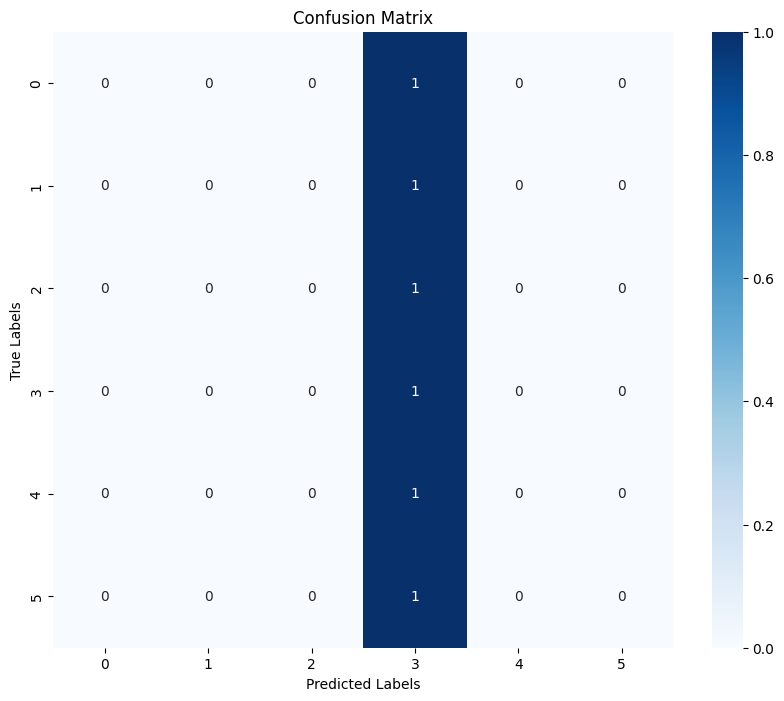

Epoch 4, Validation Loss: 1.8115, Accuracy: 0.2912, F1 Score: 0.1313
Val F1 Score Per Class  [0.         0.         0.         0.45100671 0.         0.        ]


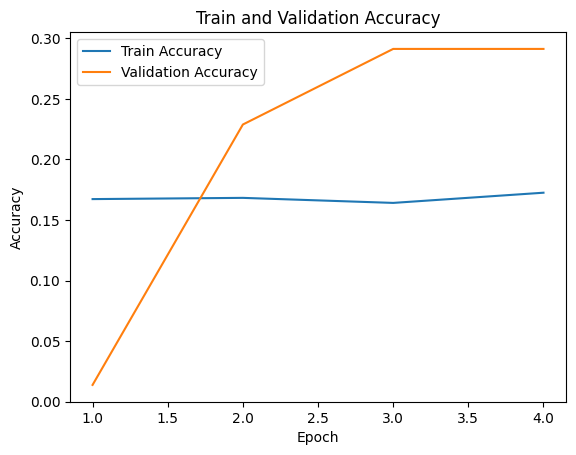

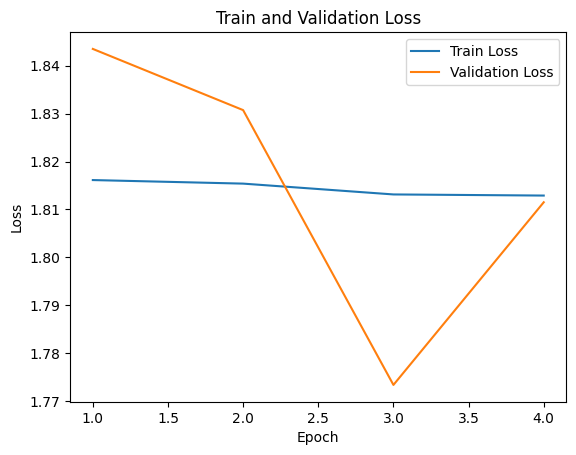

Epoch 5, Train Loss: 1.8054, Accuracy: 0.1732, F1 Score: 0.1700
Train F1 Score Per Class  [0.15495732 0.19545455 0.16036806 0.2092741  0.15190785 0.14337176]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.53it/s, loss=1.69]

[tensor([-0.0017, -0.3068,  0.2026,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2025,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3071,  0.2030,  0.2339, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2026,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2031,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2031,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5691,  0.3986], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.51it/s, loss=1.72]

[tensor([-0.0016, -0.3070,  0.2028,  0.2340, -0.5694,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2027,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3064,  0.2021,  0.2338, -0.5689,  0.3981], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2022,  0.2339, -0.5692,  0.3984], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2026,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2032,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2028,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2028,  0.2340, -0.5688,  0.3985], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.46it/s, loss=1.76]

[tensor([-0.0018, -0.3069,  0.2030,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2023,  0.2339, -0.5692,  0.3984], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2028,  0.2338, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2022,  0.2339, -0.5691,  0.3983], device='cuda:0'), tensor([-0.0017, -0.3070,  0.2029,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2030,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5690,  0.3986], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:27,  2.47it/s, loss=1.83]

[tensor([-0.0020, -0.3069,  0.2028,  0.2339, -0.5689,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2029,  0.2340, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2030,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2026,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2029,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2024,  0.2338, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3073,  0.2028,  0.2340, -0.5693,  0.3986], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.45it/s, loss=1.83]

[tensor([-0.0017, -0.3066,  0.2023,  0.2339, -0.5692,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2029,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2028,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2026,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2030,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2025,  0.2338, -0.5691,  0.3986], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.46it/s, loss=1.74]

[tensor([-0.0018, -0.3069,  0.2025,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2025,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3066,  0.2028,  0.2339, -0.5685,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2031,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2028,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0016, -0.3066,  0.2029,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2029,  0.2340, -0.5693,  0.3987], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.47it/s, loss=1.72]

[tensor([-0.0018, -0.3071,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2021,  0.2337, -0.5691,  0.3983], device='cuda:0'), tensor([-0.0020, -0.3073,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2030,  0.2340, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2024,  0.2339, -0.5691,  0.3984], device='cuda:0'), tensor([-0.0018, -0.3071,  0.2028,  0.2340, -0.5694,  0.3986], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.45it/s, loss=1.73]

[tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2029,  0.2339, -0.5690,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2027,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3061,  0.2019,  0.2338, -0.5684,  0.3980], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2032,  0.2340, -0.5692,  0.3988], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2018,  0.2337, -0.5688,  0.3981], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:25,  2.47it/s, loss=1.71]

[tensor([-0.0017, -0.3066,  0.2027,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2031,  0.2339, -0.5690,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2028,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2029,  0.2340, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2031,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2027,  0.2339, -0.5691,  0.3985], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.47it/s, loss=1.7]

[tensor([-0.0018, -0.3071,  0.2025,  0.2340, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3070,  0.2027,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0016, -0.3066,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2028,  0.2339, -0.5689,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2030,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2029,  0.2340, -0.5692,  0.3987], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.46it/s, loss=1.88]

[tensor([-0.0018, -0.3067,  0.2028,  0.2338, -0.5688,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3065,  0.2027,  0.2339, -0.5686,  0.3985], device='cuda:0'), tensor([-0.0020, -0.3074,  0.2032,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2029,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0015, -0.3065,  0.2027,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2029,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.47it/s, loss=1.85]

[tensor([-0.0018, -0.3071,  0.2033,  0.2340, -0.5693,  0.3988], device='cuda:0'), tensor([-0.0017, -0.3070,  0.2030,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2031,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2029,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2024,  0.2339, -0.5691,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2030,  0.2339, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3071,  0.2032,  0.2340, -0.5693,  0.3988], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2029,  0.2339, -0.5690,  0.3987], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.48it/s, loss=1.9]

[tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2032,  0.2340, -0.5690,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2025,  0.2339, -0.5689,  0.3984], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2033,  0.2339, -0.5692,  0.3988], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2033,  0.2340, -0.5693,  0.3988], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2029,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2028,  0.2340, -0.5692,  0.3985], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:23,  2.47it/s, loss=1.7]

[tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2028,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2026,  0.2340, -0.5693,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2023,  0.2338, -0.5691,  0.3983], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2028,  0.2339, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2031,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0016, -0.3067,  0.2026,  0.2339, -0.5692,  0.3986], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.46it/s, loss=1.81]

[tensor([-0.0017, -0.3065,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2029,  0.2340, -0.5689,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2025,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2031,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0015, -0.3065,  0.2025,  0.2339, -0.5693,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.47it/s, loss=1.81]

[tensor([-0.0018, -0.3071,  0.2029,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2029,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2029,  0.2340, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3065,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2032,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2025,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2024,  0.2339, -0.5692,  0.3985], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.47it/s, loss=1.95]

[tensor([-0.0017, -0.3066,  0.2026,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0022, -0.3076,  0.2031,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2029,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2029,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2027,  0.2339, -0.5690,  0.3985], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.44it/s, loss=1.9]

[tensor([-0.0018, -0.3069,  0.2031,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2028,  0.2340, -0.5689,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0016, -0.3067,  0.2028,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2029,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2028,  0.2340, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0016, -0.3064,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.44it/s, loss=1.59]

[tensor([-0.0019, -0.3068,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0020, -0.3076,  0.2029,  0.2339, -0.5694,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2025,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0020, -0.3069,  0.2030,  0.2339, -0.5689,  0.3987], device='cuda:0'), tensor([-0.0016, -0.3066,  0.2026,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3065,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.44it/s, loss=1.67]

[tensor([-0.0017, -0.3066,  0.2028,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2028,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2030,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2028,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2028,  0.2339, -0.5690,  0.3986], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.45it/s, loss=1.77]

[tensor([-0.0019, -0.3072,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3071,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2029,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2032,  0.2341, -0.5692,  0.3988], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2029,  0.2339, -0.5692,  0.3986], device='cuda:0')]


Val:  30%|███       | 22/73 [00:08<00:20,  2.45it/s, loss=1.91]

[tensor([-0.0018, -0.3067,  0.2029,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3066,  0.2027,  0.2339, -0.5689,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2031,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0021, -0.3071,  0.2027,  0.2339, -0.5689,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2030,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2027,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3065,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3066,  0.2025,  0.2339, -0.5687,  0.3984], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.45it/s, loss=1.75]

[tensor([-0.0019, -0.3072,  0.2030,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2032,  0.2340, -0.5692,  0.3988], device='cuda:0'), tensor([-0.0016, -0.3065,  0.2024,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3071,  0.2030,  0.2340, -0.5695,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3064,  0.2025,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2028,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3065,  0.2022,  0.2339, -0.5690,  0.3983], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.46it/s, loss=1.84]

[tensor([-0.0019, -0.3071,  0.2027,  0.2339, -0.5693,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3065,  0.2024,  0.2337, -0.5688,  0.3984], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2028,  0.2339, -0.5689,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2029,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2030,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2027,  0.2340, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2032,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2025,  0.2339, -0.5689,  0.3985], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.45it/s, loss=1.67]

[tensor([-0.0018, -0.3069,  0.2030,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2030,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2026,  0.2340, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0020, -0.3069,  0.2027,  0.2339, -0.5689,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2024,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2028,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2027,  0.2338, -0.5692,  0.3985], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.46it/s, loss=1.71]

[tensor([-0.0017, -0.3066,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2027,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3065,  0.2025,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2027,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2028,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3067,  0.2027,  0.2340, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2027,  0.2340, -0.5694,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2031,  0.2339, -0.5691,  0.3987], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:10<00:18,  2.45it/s, loss=1.78]

[tensor([-0.0016, -0.3064,  0.2025,  0.2339, -0.5689,  0.3984], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2027,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2030,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2029,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2030,  0.2339, -0.5690,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3067,  0.2028,  0.2339, -0.5689,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2027,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2027,  0.2339, -0.5690,  0.3985], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.45it/s, loss=1.79]

[tensor([-0.0017, -0.3066,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2026,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0020, -0.3072,  0.2028,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2029,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2027,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.47it/s, loss=1.97]

[tensor([-0.0016, -0.3066,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2029,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2026,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2028,  0.2340, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2030,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2028,  0.2339, -0.5689,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2027,  0.2339, -0.5690,  0.3986], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.46it/s, loss=1.87]

[tensor([-0.0017, -0.3065,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2025,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2026,  0.2339, -0.5689,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2029,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2030,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0020, -0.3075,  0.2033,  0.2340, -0.5694,  0.3988], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2030,  0.2339, -0.5690,  0.3987], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.44it/s, loss=1.7]

[tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2026,  0.2340, -0.5691,  0.3984], device='cuda:0'), tensor([-0.0020, -0.3069,  0.2031,  0.2340, -0.5690,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2026,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3070,  0.2029,  0.2340, -0.5695,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.44it/s, loss=1.8]

[tensor([-0.0017, -0.3068,  0.2030,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2031,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2020,  0.2339, -0.5689,  0.3983], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2029,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2030,  0.2339, -0.5690,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.45it/s, loss=1.74]

[tensor([-0.0020, -0.3069,  0.2024,  0.2338, -0.5687,  0.3984], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0020, -0.3072,  0.2030,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2031,  0.2340, -0.5693,  0.3988], device='cuda:0'), tensor([-0.0015, -0.3066,  0.2026,  0.2339, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2027,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0020, -0.3068,  0.2029,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2029,  0.2339, -0.5692,  0.3986], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.45it/s, loss=1.78]

[tensor([-0.0018, -0.3071,  0.2027,  0.2340, -0.5694,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2025,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2033,  0.2340, -0.5692,  0.3988], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2025,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2030,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2029,  0.2340, -0.5690,  0.3986], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.46it/s, loss=1.82]

[tensor([-0.0016, -0.3062,  0.2023,  0.2339, -0.5689,  0.3983], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2029,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2027,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2029,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2029,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0020, -0.3069,  0.2023,  0.2338, -0.5689,  0.3984], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.46it/s, loss=1.73]

[tensor([-0.0016, -0.3065,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3065,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2032,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2024,  0.2339, -0.5693,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3071,  0.2026,  0.2340, -0.5693,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2030,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2031,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.46it/s, loss=1.82]

[tensor([-0.0017, -0.3071,  0.2026,  0.2340, -0.5694,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3071,  0.2033,  0.2340, -0.5692,  0.3988], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2028,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2029,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2029,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0016, -0.3063,  0.2026,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.47it/s, loss=1.69]

[tensor([-0.0017, -0.3068,  0.2029,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2028,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2030,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2020,  0.2338, -0.5690,  0.3983], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2031,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3064,  0.2025,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2030,  0.2340, -0.5692,  0.3987], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.46it/s, loss=1.78]

[tensor([-0.0018, -0.3069,  0.2032,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0016, -0.3067,  0.2026,  0.2340, -0.5693,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2023,  0.2339, -0.5690,  0.3983], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2025,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3064,  0.2018,  0.2338, -0.5687,  0.3982], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2029,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2030,  0.2340, -0.5690,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2025,  0.2339, -0.5691,  0.3985], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.47it/s, loss=1.86]

[tensor([-0.0018, -0.3069,  0.2026,  0.2338, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2027,  0.2340, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0016, -0.3064,  0.2024,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3070,  0.2028,  0.2339, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2020,  0.2337, -0.5690,  0.3983], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2030,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:12,  2.47it/s, loss=1.78]

[tensor([-0.0017, -0.3065,  0.2023,  0.2338, -0.5689,  0.3984], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2028,  0.2340, -0.5689,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3071,  0.2032,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0016, -0.3067,  0.2027,  0.2339, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2029,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0020, -0.3070,  0.2032,  0.2339, -0.5689,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2032,  0.2340, -0.5692,  0.3988], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.46it/s, loss=1.69]

[tensor([-0.0020, -0.3072,  0.2027,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2027,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2026,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2028,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2029,  0.2339, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2030,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2024,  0.2339, -0.5692,  0.3984], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.46it/s, loss=1.75]

[tensor([-0.0018, -0.3070,  0.2031,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2030,  0.2339, -0.5689,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2026,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2030,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2028,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3072,  0.2030,  0.2340, -0.5695,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:17<00:11,  2.46it/s, loss=1.71]

[tensor([-0.0017, -0.3064,  0.2024,  0.2339, -0.5689,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2029,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2028,  0.2339, -0.5689,  0.3986], device='cuda:0'), tensor([-0.0016, -0.3066,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2027,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2028,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.45it/s, loss=1.73]

[tensor([-0.0018, -0.3067,  0.2027,  0.2340, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2026,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2025,  0.2340, -0.5691,  0.3984], device='cuda:0'), tensor([-0.0016, -0.3065,  0.2024,  0.2339, -0.5692,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2029,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2027,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2031,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2028,  0.2339, -0.5690,  0.3986], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.43it/s, loss=1.64]

[tensor([-0.0020, -0.3074,  0.2031,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0020, -0.3071,  0.2028,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3070,  0.2028,  0.2339, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2028,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2030,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2029,  0.2339, -0.5693,  0.3988], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.42it/s, loss=1.72]

[tensor([-0.0016, -0.3067,  0.2023,  0.2339, -0.5692,  0.3983], device='cuda:0'), tensor([-0.0020, -0.3072,  0.2027,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2027,  0.2340, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2031,  0.2340, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2032,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3067,  0.2022,  0.2339, -0.5688,  0.3983], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2029,  0.2340, -0.5693,  0.3987], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.44it/s, loss=1.68]

[tensor([-0.0017, -0.3065,  0.2025,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0016, -0.3064,  0.2027,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2030,  0.2340, -0.5690,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2030,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2031,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2028,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2027,  0.2339, -0.5690,  0.3986], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:19<00:09,  2.45it/s, loss=1.67]

[tensor([-0.0017, -0.3068,  0.2028,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2027,  0.2340, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2025,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2029,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2027,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2030,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.45it/s, loss=1.91]

[tensor([-0.0018, -0.3068,  0.2029,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2024,  0.2339, -0.5689,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2029,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2031,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2030,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2029,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2024,  0.2339, -0.5689,  0.3984], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.46it/s, loss=1.86]

[tensor([-0.0018, -0.3068,  0.2029,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0020, -0.3074,  0.2031,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2023,  0.2338, -0.5692,  0.3983], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2018,  0.2338, -0.5690,  0.3980], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5693,  0.3986], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.45it/s, loss=1.69]

[tensor([-0.0018, -0.3065,  0.2027,  0.2339, -0.5689,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2025,  0.2340, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2026,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0023, -0.3074,  0.2038,  0.2341, -0.5689,  0.3988], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2029,  0.2339, -0.5690,  0.3987], device='cuda:0'), tensor([-0.0020, -0.3070,  0.2028,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.44it/s, loss=1.94]

[tensor([-0.0018, -0.3068,  0.2030,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2028,  0.2339, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2027,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3064,  0.2023,  0.2338, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2025,  0.2339, -0.5689,  0.3984], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2026,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3065,  0.2026,  0.2339, -0.5690,  0.3985], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:21<00:07,  2.44it/s, loss=1.78]

[tensor([-0.0018, -0.3069,  0.2024,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2026,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2030,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2030,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0016, -0.3066,  0.2029,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3065,  0.2027,  0.2340, -0.5691,  0.3985], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.45it/s, loss=1.8]

[tensor([-0.0017, -0.3067,  0.2021,  0.2338, -0.5691,  0.3983], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2031,  0.2339, -0.5690,  0.3987], device='cuda:0'), tensor([-0.0016, -0.3066,  0.2029,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2030,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3066,  0.2030,  0.2339, -0.5687,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2026,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2029,  0.2339, -0.5690,  0.3986], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.45it/s, loss=1.61]

[tensor([-0.0016, -0.3063,  0.2024,  0.2340, -0.5691,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3070,  0.2029,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2030,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2031,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2028,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2029,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2028,  0.2340, -0.5693,  0.3986], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.43it/s, loss=1.69]

[tensor([-0.0016, -0.3066,  0.2027,  0.2340, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3072,  0.2030,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3071,  0.2030,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3067,  0.2026,  0.2339, -0.5689,  0.3984], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2027,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3064,  0.2023,  0.2339, -0.5690,  0.3983], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2339, -0.5692,  0.3987], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.44it/s, loss=1.66]

[tensor([-0.0015, -0.3064,  0.2025,  0.2339, -0.5691,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2030,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2030,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0020, -0.3070,  0.2033,  0.2340, -0.5692,  0.3988], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2027,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2031,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2026,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2030,  0.2340, -0.5691,  0.3986], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.43it/s, loss=1.72]

[tensor([-0.0018, -0.3070,  0.2029,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2028,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2028,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2030,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2025,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2030,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0021, -0.3074,  0.2029,  0.2340, -0.5694,  0.3986], device='cuda:0'), tensor([-0.0016, -0.3064,  0.2025,  0.2339, -0.5691,  0.3986], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.44it/s, loss=1.76]

[tensor([-0.0018, -0.3071,  0.2032,  0.2340, -0.5693,  0.3988], device='cuda:0'), tensor([-0.0020, -0.3072,  0.2025,  0.2340, -0.5693,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2032,  0.2339, -0.5692,  0.3988], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2027,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2028,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2029,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2031,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2029,  0.2339, -0.5690,  0.3986], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.44it/s, loss=1.88]

[tensor([-0.0019, -0.3070,  0.2030,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2030,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2026,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2026,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2029,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2026,  0.2339, -0.5689,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2029,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3072,  0.2026,  0.2339, -0.5692,  0.3985], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.45it/s, loss=1.93]

[tensor([-0.0016, -0.3068,  0.2030,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2024,  0.2339, -0.5691,  0.3984], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2032,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2029,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3071,  0.2030,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.45it/s, loss=1.69]

[tensor([-0.0018, -0.3068,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2026,  0.2340, -0.5690,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0016, -0.3065,  0.2026,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2028,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3065,  0.2027,  0.2339, -0.5687,  0.3985], device='cuda:0'), tensor([-0.0016, -0.3066,  0.2025,  0.2339, -0.5693,  0.3985], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.45it/s, loss=1.78]

[tensor([-0.0018, -0.3070,  0.2029,  0.2340, -0.5695,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0021, -0.3074,  0.2032,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2033,  0.2339, -0.5692,  0.3988], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2030,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2018,  0.2338, -0.5692,  0.3981], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.45it/s, loss=1.72]

[tensor([-0.0017, -0.3066,  0.2029,  0.2340, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2023,  0.2339, -0.5693,  0.3984], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2027,  0.2339, -0.5690,  0.3984], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2026,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3062,  0.2024,  0.2339, -0.5688,  0.3983], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2023,  0.2338, -0.5691,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2027,  0.2340, -0.5693,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2026,  0.2339, -0.5690,  0.3986], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.45it/s, loss=1.77]

[tensor([-0.0017, -0.3062,  0.2025,  0.2340, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3074,  0.2028,  0.2339, -0.5694,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2030,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3065,  0.2025,  0.2339, -0.5690,  0.3984], device='cuda:0'), tensor([-0.0019, -0.3067,  0.2029,  0.2339, -0.5688,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2021,  0.2339, -0.5690,  0.3983], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2028,  0.2339, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3069,  0.2030,  0.2339, -0.5690,  0.3987], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.46it/s, loss=1.71]

[tensor([-0.0017, -0.3067,  0.2024,  0.2339, -0.5690,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2027,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3071,  0.2025,  0.2339, -0.5693,  0.3985], device='cuda:0'), tensor([-0.0020, -0.3072,  0.2029,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3071,  0.2030,  0.2340, -0.5694,  0.3987], device='cuda:0'), tensor([-0.0020, -0.3070,  0.2029,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2024,  0.2339, -0.5689,  0.3984], device='cuda:0'), tensor([-0.0019, -0.3068,  0.2027,  0.2339, -0.5689,  0.3985], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.46it/s, loss=1.69]

[tensor([-0.0019, -0.3071,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2030,  0.2338, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2028,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2027,  0.2339, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2027,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3069,  0.2028,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2028,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2031,  0.2339, -0.5690,  0.3987], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.46it/s, loss=1.94]

[tensor([-0.0018, -0.3070,  0.2030,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0021, -0.3075,  0.2038,  0.2341, -0.5695,  0.3989], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2026,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2029,  0.2339, -0.5691,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2029,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0019, -0.3070,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2028,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0016, -0.3066,  0.2027,  0.2340, -0.5692,  0.3986], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.47it/s, loss=1.73]

[tensor([-0.0017, -0.3064,  0.2024,  0.2338, -0.5691,  0.3984], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3065,  0.2027,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3066,  0.2026,  0.2340, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0019, -0.3071,  0.2030,  0.2340, -0.5692,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2026,  0.2340, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0015, -0.3064,  0.2024,  0.2339, -0.5691,  0.3984], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:28<00:00,  2.47it/s, loss=1.83]

[tensor([-0.0017, -0.3067,  0.2030,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0016, -0.3066,  0.2025,  0.2339, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3067,  0.2028,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2029,  0.2340, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2031,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2029,  0.2339, -0.5692,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2026,  0.2339, -0.5690,  0.3985], device='cuda:0'), tensor([-0.0018, -0.3070,  0.2027,  0.2339, -0.5692,  0.3986], device='cuda:0')]


[tensor([-0.0018, -0.3069,  0.2029,  0.2340, -0.5691,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3066,  0.2028,  0.2340, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0017, -0.3069,  0.2029,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2024,  0.2338, -0.5692,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3063,  0.2027,  0.2339, -0.5690,  0.3986], device='cuda:0'), tensor([-0.0018, -0.3068,  0.2025,  0.2339, -0.5691,  0.3985], device='cuda:0'), tensor([-0.0017, -0.3068,  0.2030,  0.2340, -0.5693,  0.3987], device='cuda:0'), tensor([-0.0017, -0.3067,  0.2029,  0.2339, -0.5692,  0.3987], device='cuda:0')]
[tensor([-0.0018, -0.3066,  0.2025,  0.2339, -0.5692,  0.3985], device='cuda:0')]


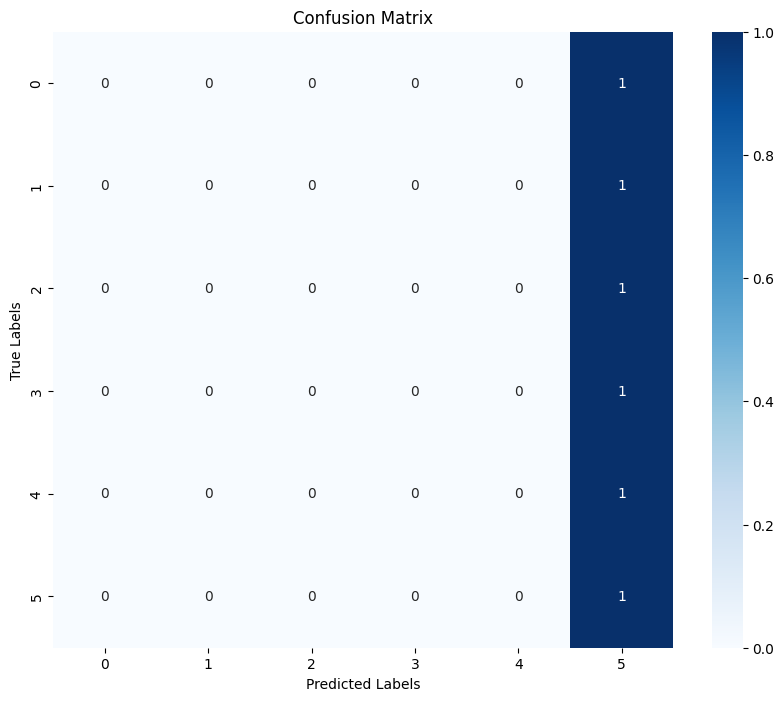

Epoch 5, Validation Loss: 1.7749, Accuracy: 0.0589, F1 Score: 0.0066
Val F1 Score Per Class  [0.         0.         0.         0.         0.         0.11129296]


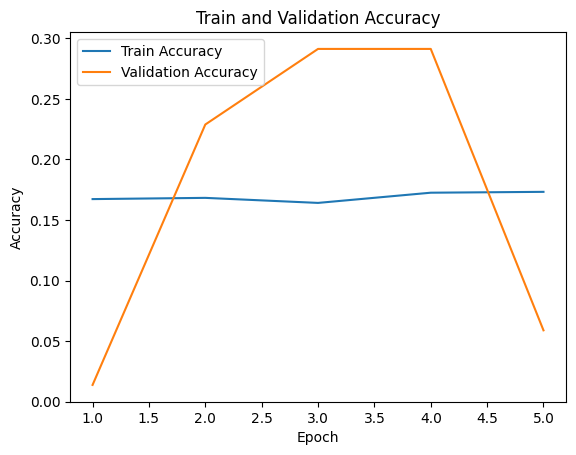

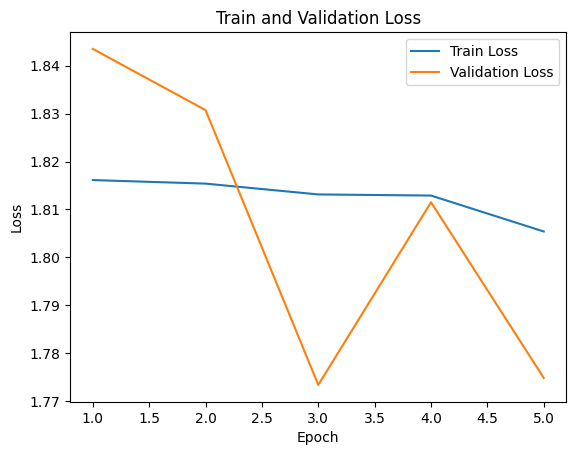

Epoch 6, Train Loss: 1.8097, Accuracy: 0.1679, F1 Score: 0.1621
Train F1 Score Per Class  [0.18460648 0.15285126 0.17241379 0.21596657 0.14082504 0.10119292]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.52it/s, loss=1.84]

[tensor([ 0.1082, -0.0658,  0.1871, -0.2905, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1057, -0.0656,  0.1855, -0.2905, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1069, -0.0650,  0.1859, -0.2899, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1105, -0.0671,  0.1891, -0.2923, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1033, -0.0652,  0.1827, -0.2894, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1087, -0.0650,  0.1879, -0.2897, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1111, -0.0661,  0.1894, -0.2908, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1077, -0.0652,  0.1868, -0.2901, -0.0593,  0.0205], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.52it/s, loss=1.78]

[tensor([ 0.1065, -0.0647,  0.1853, -0.2886, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1116, -0.0665,  0.1897, -0.2912, -0.0595,  0.0205], device='cuda:0'), tensor([ 0.1000, -0.0641,  0.1798, -0.2876, -0.0590,  0.0205], device='cuda:0'), tensor([ 0.1097, -0.0651,  0.1887, -0.2901, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1043, -0.0628,  0.1839, -0.2867, -0.0591,  0.0208], device='cuda:0'), tensor([ 0.1095, -0.0651,  0.1882, -0.2899, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1087, -0.0650,  0.1877, -0.2893, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1104, -0.0659,  0.1890, -0.2907, -0.0593,  0.0208], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.45it/s, loss=1.78]

[tensor([ 0.1089, -0.0641,  0.1877, -0.2888, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1076, -0.0639,  0.1867, -0.2881, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1097, -0.0654,  0.1888, -0.2902, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1064, -0.0656,  0.1861, -0.2903, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1033, -0.0648,  0.1831, -0.2901, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.1078, -0.0653,  0.1867, -0.2893, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1042, -0.0655,  0.1841, -0.2900, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1117, -0.0670,  0.1903, -0.2924, -0.0594,  0.0206], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:27,  2.47it/s, loss=1.75]

[tensor([ 0.1078, -0.0654,  0.1866, -0.2899, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1083, -0.0657,  0.1873, -0.2904, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1105, -0.0661,  0.1891, -0.2911, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1091, -0.0660,  0.1879, -0.2906, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1102, -0.0651,  0.1889, -0.2903, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1060, -0.0643,  0.1855, -0.2890, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1089, -0.0661,  0.1880, -0.2907, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1080, -0.0648,  0.1867, -0.2898, -0.0594,  0.0205], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.45it/s, loss=1.81]

[tensor([ 0.1078, -0.0655,  0.1866, -0.2902, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1034, -0.0633,  0.1842, -0.2882, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1079, -0.0651,  0.1869, -0.2897, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1097, -0.0657,  0.1888, -0.2911, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1085, -0.0655,  0.1876, -0.2906, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1082, -0.0644,  0.1870, -0.2884, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1105, -0.0654,  0.1889, -0.2899, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1091, -0.0658,  0.1880, -0.2909, -0.0593,  0.0207], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.45it/s, loss=1.82]

[tensor([ 0.1095, -0.0652,  0.1881, -0.2902, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1065, -0.0650,  0.1857, -0.2894, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1086, -0.0663,  0.1877, -0.2911, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1102, -0.0653,  0.1889, -0.2902, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1058, -0.0641,  0.1852, -0.2883, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1061, -0.0641,  0.1853, -0.2887, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1113, -0.0674,  0.1895, -0.2926, -0.0595,  0.0206], device='cuda:0'), tensor([ 0.1084, -0.0642,  0.1874, -0.2890, -0.0593,  0.0208], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.46it/s, loss=1.76]

[tensor([ 0.1099, -0.0663,  0.1888, -0.2915, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1029, -0.0634,  0.1824, -0.2869, -0.0589,  0.0207], device='cuda:0'), tensor([ 0.1106, -0.0656,  0.1891, -0.2907, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1085, -0.0667,  0.1877, -0.2917, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1081, -0.0652,  0.1865, -0.2897, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1066, -0.0654,  0.1855, -0.2896, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1084, -0.0655,  0.1870, -0.2897, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1077, -0.0656,  0.1865, -0.2895, -0.0591,  0.0205], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.45it/s, loss=1.7]

[tensor([ 0.1100, -0.0661,  0.1887, -0.2920, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1080, -0.0636,  0.1875, -0.2877, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1097, -0.0655,  0.1881, -0.2898, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1099, -0.0653,  0.1886, -0.2894, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1083, -0.0653,  0.1871, -0.2901, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1010, -0.0622,  0.1807, -0.2852, -0.0588,  0.0207], device='cuda:0'), tensor([ 0.1087, -0.0641,  0.1876, -0.2887, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1008, -0.0621,  0.1804, -0.2846, -0.0585,  0.0207], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.46it/s, loss=1.85]

[tensor([ 0.1108, -0.0659,  0.1893, -0.2908, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1109, -0.0660,  0.1895, -0.2912, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1101, -0.0654,  0.1888, -0.2897, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1072, -0.0643,  0.1862, -0.2885, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1104, -0.0660,  0.1893, -0.2911, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1084, -0.0648,  0.1875, -0.2893, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1098, -0.0652,  0.1884, -0.2900, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1044, -0.0656,  0.1836, -0.2907, -0.0593,  0.0207], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.44it/s, loss=1.72]

[tensor([ 0.1051, -0.0657,  0.1849, -0.2903, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1078, -0.0644,  0.1870, -0.2887, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1041, -0.0635,  0.1838, -0.2879, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1097, -0.0657,  0.1886, -0.2909, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.1099, -0.0663,  0.1886, -0.2913, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1070, -0.0655,  0.1863, -0.2905, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1099, -0.0651,  0.1887, -0.2897, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1074, -0.0641,  0.1865, -0.2887, -0.0593,  0.0207], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.45it/s, loss=1.85]

[tensor([ 0.1071, -0.0665,  0.1859, -0.2907, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1081, -0.0660,  0.1874, -0.2904, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1074, -0.0657,  0.1863, -0.2907, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1083, -0.0642,  0.1872, -0.2889, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1103, -0.0665,  0.1886, -0.2918, -0.0595,  0.0205], device='cuda:0'), tensor([ 0.1048, -0.0625,  0.1840, -0.2867, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1105, -0.0662,  0.1889, -0.2910, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1081, -0.0648,  0.1873, -0.2887, -0.0592,  0.0206], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.45it/s, loss=1.7]

[tensor([ 0.1093, -0.0652,  0.1880, -0.2893, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1097, -0.0654,  0.1883, -0.2896, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1075, -0.0656,  0.1868, -0.2904, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1082, -0.0653,  0.1871, -0.2892, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1083, -0.0670,  0.1867, -0.2923, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.1076, -0.0662,  0.1868, -0.2907, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1093, -0.0650,  0.1882, -0.2897, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0659,  0.1880, -0.2905, -0.0592,  0.0207], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.47it/s, loss=1.78]

[tensor([ 0.1098, -0.0660,  0.1888, -0.2914, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1117, -0.0672,  0.1900, -0.2919, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1031, -0.0662,  0.1823, -0.2909, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1104, -0.0660,  0.1891, -0.2906, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1099, -0.0661,  0.1887, -0.2911, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1078, -0.0657,  0.1866, -0.2906, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0658,  0.1883, -0.2910, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1105, -0.0651,  0.1891, -0.2903, -0.0594,  0.0207], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.45it/s, loss=1.78]

[tensor([ 0.1104, -0.0659,  0.1890, -0.2900, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1086, -0.0653,  0.1875, -0.2896, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1090, -0.0662,  0.1878, -0.2912, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1058, -0.0627,  0.1851, -0.2863, -0.0590,  0.0207], device='cuda:0'), tensor([ 0.1073, -0.0637,  0.1868, -0.2884, -0.0594,  0.0209], device='cuda:0'), tensor([ 0.1070, -0.0649,  0.1862, -0.2901, -0.0595,  0.0206], device='cuda:0'), tensor([ 0.1092, -0.0653,  0.1883, -0.2903, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1078, -0.0644,  0.1872, -0.2888, -0.0592,  0.0207], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.46it/s, loss=1.74]

[tensor([ 0.1085, -0.0646,  0.1878, -0.2889, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1084, -0.0657,  0.1874, -0.2899, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1074, -0.0662,  0.1862, -0.2914, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1130, -0.0673,  0.1909, -0.2921, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1060, -0.0640,  0.1852, -0.2890, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1071, -0.0641,  0.1864, -0.2883, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1092, -0.0641,  0.1880, -0.2883, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1105, -0.0655,  0.1893, -0.2907, -0.0594,  0.0208], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.46it/s, loss=1.8]

[tensor([ 0.0988, -0.0587,  0.1812, -0.2832, -0.0589,  0.0214], device='cuda:0'), tensor([ 0.1098, -0.0653,  0.1884, -0.2907, -0.0595,  0.0206], device='cuda:0'), tensor([ 0.1104, -0.0652,  0.1892, -0.2902, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1088, -0.0660,  0.1877, -0.2906, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1088, -0.0660,  0.1879, -0.2906, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1111, -0.0660,  0.1897, -0.2910, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1099, -0.0649,  0.1886, -0.2896, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1075, -0.0652,  0.1867, -0.2899, -0.0593,  0.0207], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.46it/s, loss=1.88]

[tensor([ 0.1087, -0.0652,  0.1876, -0.2899, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1084, -0.0654,  0.1874, -0.2905, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1011, -0.0619,  0.1828, -0.2850, -0.0590,  0.0207], device='cuda:0'), tensor([ 0.1102, -0.0653,  0.1889, -0.2901, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1082, -0.0649,  0.1869, -0.2896, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1089, -0.0646,  0.1881, -0.2903, -0.0595,  0.0209], device='cuda:0'), tensor([ 0.1079, -0.0660,  0.1865, -0.2905, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1091, -0.0660,  0.1881, -0.2906, -0.0593,  0.0207], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.47it/s, loss=1.91]

[tensor([ 0.1097, -0.0662,  0.1885, -0.2916, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.1101, -0.0660,  0.1890, -0.2907, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1087, -0.0651,  0.1872, -0.2891, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1082, -0.0649,  0.1874, -0.2893, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1085, -0.0641,  0.1874, -0.2890, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1076, -0.0653,  0.1866, -0.2901, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0665,  0.1883, -0.2915, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1076, -0.0654,  0.1864, -0.2900, -0.0593,  0.0206], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:21,  2.46it/s, loss=1.92]

[tensor([ 0.1060, -0.0661,  0.1860, -0.2912, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1101, -0.0663,  0.1893, -0.2914, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1105, -0.0660,  0.1893, -0.2912, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1085, -0.0647,  0.1874, -0.2890, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1097, -0.0656,  0.1886, -0.2907, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1061, -0.0642,  0.1854, -0.2877, -0.0590,  0.0205], device='cuda:0'), tensor([ 0.1087, -0.0654,  0.1873, -0.2895, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1085, -0.0643,  0.1875, -0.2891, -0.0595,  0.0206], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.45it/s, loss=1.71]

[tensor([ 0.1092, -0.0652,  0.1882, -0.2898, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1102, -0.0651,  0.1888, -0.2898, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1107, -0.0662,  0.1896, -0.2917, -0.0595,  0.0208], device='cuda:0'), tensor([ 0.1087, -0.0644,  0.1875, -0.2889, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1093, -0.0662,  0.1884, -0.2912, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1095, -0.0654,  0.1880, -0.2896, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1087, -0.0648,  0.1879, -0.2895, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1106, -0.0660,  0.1896, -0.2909, -0.0594,  0.0206], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.46it/s, loss=1.78]

[tensor([ 0.1076, -0.0647,  0.1869, -0.2889, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1106, -0.0660,  0.1894, -0.2909, -0.0595,  0.0208], device='cuda:0'), tensor([ 0.1085, -0.0656,  0.1877, -0.2908, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1067, -0.0661,  0.1861, -0.2914, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1085, -0.0644,  0.1876, -0.2888, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1096, -0.0649,  0.1881, -0.2893, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.0946, -0.0559,  0.1781, -0.2798, -0.0588,  0.0214], device='cuda:0'), tensor([ 0.1078, -0.0653,  0.1865, -0.2897, -0.0594,  0.0207], device='cuda:0')]


Val:  30%|███       | 22/73 [00:08<00:20,  2.47it/s, loss=1.8]

[tensor([ 0.1105, -0.0660,  0.1891, -0.2906, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1074, -0.0654,  0.1869, -0.2899, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1087, -0.0647,  0.1878, -0.2889, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1057, -0.0646,  0.1852, -0.2893, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1096, -0.0663,  0.1883, -0.2909, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1096, -0.0656,  0.1886, -0.2902, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1044, -0.0638,  0.1841, -0.2877, -0.0590,  0.0208], device='cuda:0'), tensor([ 0.1090, -0.0646,  0.1880, -0.2882, -0.0590,  0.0207], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.47it/s, loss=1.84]

[tensor([ 0.1086, -0.0641,  0.1875, -0.2888, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1084, -0.0660,  0.1874, -0.2908, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1085, -0.0651,  0.1877, -0.2896, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1064, -0.0656,  0.1858, -0.2905, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.0968, -0.0649,  0.1772, -0.2894, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1103, -0.0658,  0.1890, -0.2912, -0.0595,  0.0208], device='cuda:0'), tensor([ 0.1101, -0.0661,  0.1886, -0.2906, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1045, -0.0643,  0.1834, -0.2882, -0.0590,  0.0206], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.48it/s, loss=1.93]

[tensor([ 0.1101, -0.0658,  0.1887, -0.2905, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.0993, -0.0669,  0.1793, -0.2918, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1091, -0.0658,  0.1880, -0.2904, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1097, -0.0658,  0.1885, -0.2905, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1067, -0.0643,  0.1860, -0.2881, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1077, -0.0650,  0.1865, -0.2896, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1086, -0.0659,  0.1876, -0.2906, -0.0594,  0.0205], device='cuda:0'), tensor([ 0.1090, -0.0654,  0.1878, -0.2904, -0.0593,  0.0207], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.47it/s, loss=1.8]

[tensor([ 0.1097, -0.0654,  0.1884, -0.2901, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1071, -0.0646,  0.1863, -0.2890, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1107, -0.0665,  0.1892, -0.2914, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1059, -0.0655,  0.1855, -0.2910, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1108, -0.0661,  0.1896, -0.2915, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0655,  0.1881, -0.2909, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1055, -0.0643,  0.1853, -0.2885, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1020, -0.0640,  0.1822, -0.2888, -0.0592,  0.0206], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.47it/s, loss=1.91]

[tensor([ 0.1103, -0.0657,  0.1889, -0.2905, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1102, -0.0651,  0.1889, -0.2898, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1004, -0.0615,  0.1802, -0.2842, -0.0588,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0653,  0.1882, -0.2895, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1095, -0.0648,  0.1880, -0.2891, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1080, -0.0655,  0.1871, -0.2903, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1086, -0.0646,  0.1875, -0.2885, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1090, -0.0650,  0.1881, -0.2907, -0.0594,  0.0210], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:10<00:18,  2.47it/s, loss=1.79]

[tensor([ 0.1077, -0.0643,  0.1867, -0.2881, -0.0590,  0.0207], device='cuda:0'), tensor([ 0.1100, -0.0660,  0.1891, -0.2906, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1096, -0.0654,  0.1886, -0.2897, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1037, -0.0632,  0.1844, -0.2876, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1087, -0.0645,  0.1876, -0.2892, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1080, -0.0658,  0.1873, -0.2910, -0.0594,  0.0209], device='cuda:0'), tensor([ 0.1098, -0.0665,  0.1889, -0.2917, -0.0595,  0.0208], device='cuda:0'), tensor([ 0.1087, -0.0653,  0.1880, -0.2899, -0.0591,  0.0208], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.46it/s, loss=1.83]

[tensor([ 0.1099, -0.0655,  0.1885, -0.2900, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1109, -0.0665,  0.1893, -0.2918, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1060, -0.0623,  0.1854, -0.2854, -0.0590,  0.0207], device='cuda:0'), tensor([ 0.1104, -0.0662,  0.1892, -0.2907, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1083, -0.0643,  0.1876, -0.2894, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1096, -0.0656,  0.1884, -0.2903, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1079, -0.0658,  0.1870, -0.2905, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1063, -0.0637,  0.1855, -0.2878, -0.0592,  0.0206], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.46it/s, loss=1.89]

[tensor([ 0.1101, -0.0651,  0.1886, -0.2896, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1088, -0.0655,  0.1879, -0.2910, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1090, -0.0659,  0.1880, -0.2906, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0656,  0.1883, -0.2907, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1103, -0.0650,  0.1890, -0.2898, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1105, -0.0673,  0.1888, -0.2928, -0.0595,  0.0206], device='cuda:0'), tensor([ 0.1064, -0.0640,  0.1860, -0.2881, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1106, -0.0655,  0.1894, -0.2902, -0.0593,  0.0207], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.47it/s, loss=1.83]

[tensor([ 0.1078, -0.0650,  0.1869, -0.2891, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1091, -0.0654,  0.1878, -0.2902, -0.0594,  0.0205], device='cuda:0'), tensor([ 0.1084, -0.0655,  0.1876, -0.2905, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1083, -0.0653,  0.1870, -0.2899, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1100, -0.0655,  0.1888, -0.2909, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1103, -0.0658,  0.1892, -0.2906, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.0994, -0.0662,  0.1823, -0.2906, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1099, -0.0659,  0.1885, -0.2908, -0.0595,  0.0207], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.47it/s, loss=1.94]

[tensor([ 0.1078, -0.0643,  0.1868, -0.2881, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1028, -0.0654,  0.1822, -0.2894, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1029, -0.0651,  0.1836, -0.2895, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1087, -0.0640,  0.1876, -0.2876, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1088, -0.0648,  0.1881, -0.2898, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1092, -0.0652,  0.1882, -0.2894, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1010, -0.0605,  0.1809, -0.2820, -0.0586,  0.0206], device='cuda:0'), tensor([ 0.1087, -0.0645,  0.1877, -0.2886, -0.0592,  0.0207], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:12<00:16,  2.47it/s, loss=1.92]

[tensor([ 0.1089, -0.0657,  0.1875, -0.2905, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1093, -0.0662,  0.1884, -0.2909, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1083, -0.0649,  0.1875, -0.2894, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1083, -0.0643,  0.1871, -0.2887, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1084, -0.0656,  0.1874, -0.2906, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1068, -0.0639,  0.1860, -0.2878, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1116, -0.0663,  0.1902, -0.2916, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1073, -0.0645,  0.1865, -0.2890, -0.0591,  0.0207], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.47it/s, loss=1.96]

[tensor([ 0.1075, -0.0656,  0.1872, -0.2902, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1095, -0.0654,  0.1886, -0.2905, -0.0595,  0.0206], device='cuda:0'), tensor([ 0.0945, -0.0560,  0.1773, -0.2796, -0.0588,  0.0213], device='cuda:0'), tensor([ 0.1077, -0.0644,  0.1872, -0.2887, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1074, -0.0654,  0.1865, -0.2900, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1076, -0.0639,  0.1866, -0.2876, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1094, -0.0657,  0.1883, -0.2905, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.0985, -0.0596,  0.1811, -0.2842, -0.0589,  0.0211], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.47it/s, loss=1.85]

[tensor([ 0.1089, -0.0650,  0.1877, -0.2895, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1089, -0.0648,  0.1876, -0.2902, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1075, -0.0633,  0.1867, -0.2875, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1073, -0.0632,  0.1862, -0.2866, -0.0589,  0.0205], device='cuda:0'), tensor([ 0.1087, -0.0644,  0.1879, -0.2889, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1094, -0.0660,  0.1882, -0.2906, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1066, -0.0659,  0.1859, -0.2903, -0.0595,  0.0205], device='cuda:0'), tensor([ 0.1086, -0.0662,  0.1877, -0.2912, -0.0593,  0.0208], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.47it/s, loss=1.79]

[tensor([ 0.1023, -0.0656,  0.1818, -0.2905, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1114, -0.0657,  0.1899, -0.2912, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1100, -0.0661,  0.1884, -0.2904, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1083, -0.0649,  0.1871, -0.2895, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1078, -0.0667,  0.1869, -0.2918, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1092, -0.0653,  0.1878, -0.2900, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1057, -0.0635,  0.1852, -0.2871, -0.0590,  0.0206], device='cuda:0'), tensor([ 0.1114, -0.0666,  0.1899, -0.2919, -0.0595,  0.0207], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.46it/s, loss=1.86]

[tensor([ 0.1080, -0.0659,  0.1870, -0.2904, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0657,  0.1884, -0.2908, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1037, -0.0641,  0.1836, -0.2880, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1105, -0.0655,  0.1893, -0.2899, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1095, -0.0655,  0.1884, -0.2904, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1044, -0.0634,  0.1835, -0.2877, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1094, -0.0648,  0.1880, -0.2890, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1090, -0.0659,  0.1880, -0.2908, -0.0594,  0.0207], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.48it/s, loss=1.73]

[tensor([ 0.1094, -0.0647,  0.1879, -0.2890, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1099, -0.0658,  0.1888, -0.2908, -0.0594,  0.0209], device='cuda:0'), tensor([ 0.1095, -0.0652,  0.1885, -0.2897, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1100, -0.0659,  0.1887, -0.2908, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1094, -0.0652,  0.1882, -0.2901, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1059, -0.0650,  0.1850, -0.2900, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1044, -0.0634,  0.1838, -0.2874, -0.0590,  0.0206], device='cuda:0'), tensor([ 0.1096, -0.0656,  0.1885, -0.2899, -0.0593,  0.0206], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.47it/s, loss=1.93]

[tensor([ 0.1069, -0.0654,  0.1856, -0.2903, -0.0594,  0.0205], device='cuda:0'), tensor([ 0.1079, -0.0647,  0.1869, -0.2893, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1083, -0.0648,  0.1874, -0.2893, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1056, -0.0652,  0.1845, -0.2893, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.0981, -0.0654,  0.1777, -0.2903, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1104, -0.0665,  0.1889, -0.2914, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1089, -0.0659,  0.1880, -0.2909, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1091, -0.0650,  0.1882, -0.2903, -0.0593,  0.0207], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.45it/s, loss=1.85]

[tensor([ 0.1088, -0.0672,  0.1877, -0.2925, -0.0596,  0.0206], device='cuda:0'), tensor([ 0.1061, -0.0644,  0.1852, -0.2885, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1037, -0.0656,  0.1832, -0.2905, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1069, -0.0639,  0.1859, -0.2874, -0.0590,  0.0206], device='cuda:0'), tensor([ 0.0967, -0.0587,  0.1773, -0.2793, -0.0583,  0.0206], device='cuda:0'), tensor([ 0.1096, -0.0652,  0.1884, -0.2896, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1089, -0.0656,  0.1878, -0.2902, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1095, -0.0656,  0.1886, -0.2910, -0.0594,  0.0208], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.47it/s, loss=1.81]

[tensor([ 0.1078, -0.0638,  0.1874, -0.2878, -0.0591,  0.0208], device='cuda:0'), tensor([ 0.1100, -0.0657,  0.1886, -0.2904, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1068, -0.0642,  0.1862, -0.2885, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1090, -0.0650,  0.1875, -0.2894, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1036, -0.0651,  0.1835, -0.2898, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1004, -0.0656,  0.1803, -0.2905, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1094, -0.0651,  0.1883, -0.2898, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1071, -0.0648,  0.1862, -0.2896, -0.0593,  0.0207], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.43it/s, loss=1.85]

[tensor([ 0.1089, -0.0658,  0.1880, -0.2904, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1090, -0.0663,  0.1877, -0.2909, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1080, -0.0652,  0.1870, -0.2898, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1075, -0.0659,  0.1868, -0.2907, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1092, -0.0663,  0.1886, -0.2918, -0.0595,  0.0208], device='cuda:0'), tensor([ 0.1093, -0.0649,  0.1883, -0.2898, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1091, -0.0663,  0.1880, -0.2914, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1099, -0.0670,  0.1889, -0.2925, -0.0595,  0.0207], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.42it/s, loss=1.75]

[tensor([ 0.1083, -0.0642,  0.1870, -0.2885, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1096, -0.0644,  0.1885, -0.2887, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1081, -0.0645,  0.1869, -0.2887, -0.0591,  0.0208], device='cuda:0'), tensor([ 0.1094, -0.0648,  0.1884, -0.2891, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1062, -0.0643,  0.1855, -0.2884, -0.0591,  0.0208], device='cuda:0'), tensor([ 0.1109, -0.0655,  0.1896, -0.2905, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1119, -0.0666,  0.1901, -0.2915, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1094, -0.0661,  0.1884, -0.2913, -0.0594,  0.0207], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.42it/s, loss=1.84]

[tensor([ 0.1093, -0.0661,  0.1882, -0.2907, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1115, -0.0665,  0.1897, -0.2911, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1097, -0.0659,  0.1887, -0.2911, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1124, -0.0671,  0.1907, -0.2926, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.1115, -0.0666,  0.1903, -0.2920, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.1095, -0.0654,  0.1880, -0.2901, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1087, -0.0642,  0.1873, -0.2878, -0.0590,  0.0207], device='cuda:0'), tensor([ 0.1086, -0.0657,  0.1874, -0.2901, -0.0592,  0.0206], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:17<00:11,  2.43it/s, loss=1.85]

[tensor([ 0.1064, -0.0652,  0.1858, -0.2896, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1079, -0.0644,  0.1872, -0.2894, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1077, -0.0654,  0.1870, -0.2906, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1084, -0.0649,  0.1869, -0.2897, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1092, -0.0659,  0.1878, -0.2907, -0.0594,  0.0205], device='cuda:0'), tensor([ 0.1092, -0.0655,  0.1884, -0.2903, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1096, -0.0651,  0.1883, -0.2889, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1098, -0.0664,  0.1886, -0.2918, -0.0594,  0.0208], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.44it/s, loss=1.8]

[tensor([ 0.1085, -0.0658,  0.1875, -0.2904, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1088, -0.0649,  0.1879, -0.2894, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1060, -0.0644,  0.1851, -0.2887, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1079, -0.0637,  0.1869, -0.2874, -0.0590,  0.0206], device='cuda:0'), tensor([ 0.1082, -0.0662,  0.1874, -0.2909, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1054, -0.0637,  0.1848, -0.2883, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1052, -0.0651,  0.1853, -0.2900, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1081, -0.0643,  0.1874, -0.2881, -0.0592,  0.0207], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.45it/s, loss=1.85]

[tensor([ 0.1003, -0.0587,  0.1816, -0.2837, -0.0589,  0.0212], device='cuda:0'), tensor([ 0.1084, -0.0655,  0.1872, -0.2901, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.0981, -0.0668,  0.1784, -0.2914, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1049, -0.0644,  0.1848, -0.2894, -0.0593,  0.0209], device='cuda:0'), tensor([ 0.1095, -0.0657,  0.1884, -0.2901, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1106, -0.0667,  0.1891, -0.2918, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1085, -0.0642,  0.1873, -0.2877, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1069, -0.0659,  0.1861, -0.2905, -0.0592,  0.0207], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.46it/s, loss=1.79]

[tensor([ 0.1072, -0.0643,  0.1865, -0.2883, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1094, -0.0666,  0.1884, -0.2913, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1085, -0.0649,  0.1876, -0.2894, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1095, -0.0660,  0.1885, -0.2908, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1108, -0.0667,  0.1896, -0.2918, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1071, -0.0643,  0.1864, -0.2890, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1035, -0.0655,  0.1836, -0.2902, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1071, -0.0657,  0.1867, -0.2910, -0.0595,  0.0207], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.46it/s, loss=1.87]

[tensor([ 0.1087, -0.0643,  0.1874, -0.2886, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1094, -0.0655,  0.1882, -0.2895, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1081, -0.0655,  0.1872, -0.2906, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1066, -0.0651,  0.1859, -0.2895, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1077, -0.0659,  0.1869, -0.2915, -0.0595,  0.0208], device='cuda:0'), tensor([ 0.1101, -0.0662,  0.1887, -0.2907, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1085, -0.0653,  0.1875, -0.2900, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1037, -0.0643,  0.1838, -0.2883, -0.0591,  0.0207], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:19<00:09,  2.47it/s, loss=1.86]

[tensor([ 0.1090, -0.0643,  0.1875, -0.2878, -0.0591,  0.0205], device='cuda:0'), tensor([ 0.1093, -0.0660,  0.1881, -0.2909, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1114, -0.0667,  0.1897, -0.2917, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1091, -0.0653,  0.1879, -0.2904, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1094, -0.0656,  0.1881, -0.2904, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1099, -0.0660,  0.1888, -0.2909, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1012, -0.0638,  0.1824, -0.2891, -0.0592,  0.0211], device='cuda:0'), tensor([ 0.1093, -0.0653,  0.1883, -0.2898, -0.0592,  0.0207], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.47it/s, loss=1.9]

[tensor([ 0.1081, -0.0656,  0.1872, -0.2906, -0.0593,  0.0209], device='cuda:0'), tensor([ 0.1081, -0.0659,  0.1873, -0.2907, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1098, -0.0650,  0.1886, -0.2903, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.1047, -0.0652,  0.1855, -0.2900, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1026, -0.0619,  0.1836, -0.2871, -0.0592,  0.0212], device='cuda:0'), tensor([ 0.1082, -0.0642,  0.1873, -0.2885, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1109, -0.0656,  0.1893, -0.2905, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1091, -0.0657,  0.1883, -0.2901, -0.0594,  0.0206], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.47it/s, loss=1.86]

[tensor([ 0.1110, -0.0657,  0.1895, -0.2908, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1077, -0.0646,  0.1870, -0.2889, -0.0591,  0.0208], device='cuda:0'), tensor([ 0.1099, -0.0655,  0.1886, -0.2908, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.0947, -0.0547,  0.1780, -0.2786, -0.0587,  0.0215], device='cuda:0'), tensor([ 0.1083, -0.0654,  0.1877, -0.2904, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1099, -0.0656,  0.1885, -0.2900, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1016, -0.0593,  0.1811, -0.2805, -0.0585,  0.0207], device='cuda:0'), tensor([ 0.1077, -0.0642,  0.1864, -0.2878, -0.0590,  0.0206], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.47it/s, loss=1.84]

[tensor([ 0.1082, -0.0657,  0.1870, -0.2904, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1087, -0.0643,  0.1876, -0.2884, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1099, -0.0653,  0.1885, -0.2899, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1082, -0.0663,  0.1870, -0.2912, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.0976, -0.0545,  0.1800, -0.2773, -0.0585,  0.0214], device='cuda:0'), tensor([ 0.1061, -0.0643,  0.1858, -0.2892, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1116, -0.0662,  0.1901, -0.2918, -0.0596,  0.0207], device='cuda:0'), tensor([ 0.1085, -0.0652,  0.1875, -0.2899, -0.0592,  0.0208], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.46it/s, loss=1.75]

[tensor([ 0.1097, -0.0653,  0.1884, -0.2894, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1045, -0.0654,  0.1837, -0.2901, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1082, -0.0654,  0.1869, -0.2904, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1065, -0.0647,  0.1859, -0.2888, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1073, -0.0652,  0.1861, -0.2902, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1070, -0.0645,  0.1862, -0.2890, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1053, -0.0640,  0.1846, -0.2878, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1090, -0.0647,  0.1883, -0.2893, -0.0593,  0.0208], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:21<00:07,  2.47it/s, loss=1.79]

[tensor([ 0.1106, -0.0654,  0.1889, -0.2899, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1078, -0.0642,  0.1867, -0.2889, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1092, -0.0662,  0.1882, -0.2912, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1104, -0.0662,  0.1890, -0.2911, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0655,  0.1880, -0.2902, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1079, -0.0653,  0.1872, -0.2896, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1084, -0.0640,  0.1874, -0.2879, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1074, -0.0654,  0.1862, -0.2896, -0.0592,  0.0206], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.46it/s, loss=1.91]

[tensor([ 0.1053, -0.0653,  0.1845, -0.2899, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1108, -0.0669,  0.1891, -0.2922, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1087, -0.0639,  0.1871, -0.2880, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1089, -0.0643,  0.1880, -0.2888, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1085, -0.0644,  0.1874, -0.2892, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1098, -0.0657,  0.1885, -0.2904, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1099, -0.0659,  0.1888, -0.2905, -0.0594,  0.0205], device='cuda:0'), tensor([ 0.1104, -0.0655,  0.1890, -0.2903, -0.0593,  0.0207], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.45it/s, loss=1.96]

[tensor([ 0.1059, -0.0639,  0.1851, -0.2879, -0.0590,  0.0207], device='cuda:0'), tensor([ 0.1076, -0.0641,  0.1865, -0.2880, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1104, -0.0655,  0.1891, -0.2907, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1084, -0.0656,  0.1875, -0.2905, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1080, -0.0655,  0.1868, -0.2901, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1084, -0.0655,  0.1874, -0.2906, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1103, -0.0658,  0.1891, -0.2906, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1103, -0.0655,  0.1890, -0.2903, -0.0594,  0.0205], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.45it/s, loss=1.84]

[tensor([ 0.1064, -0.0641,  0.1854, -0.2877, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1086, -0.0655,  0.1876, -0.2896, -0.0592,  0.0206], device='cuda:0'), tensor([ 0.1095, -0.0649,  0.1883, -0.2898, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1085, -0.0655,  0.1876, -0.2906, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1051, -0.0656,  0.1847, -0.2895, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1067, -0.0663,  0.1858, -0.2910, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1082, -0.0653,  0.1872, -0.2899, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1084, -0.0656,  0.1872, -0.2902, -0.0593,  0.0207], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.44it/s, loss=1.83]

[tensor([ 0.1085, -0.0654,  0.1872, -0.2904, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1102, -0.0662,  0.1887, -0.2913, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1079, -0.0648,  0.1871, -0.2889, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1085, -0.0656,  0.1876, -0.2909, -0.0595,  0.0208], device='cuda:0'), tensor([ 0.1094, -0.0652,  0.1881, -0.2895, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1090, -0.0653,  0.1881, -0.2901, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1103, -0.0657,  0.1892, -0.2906, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1098, -0.0663,  0.1888, -0.2915, -0.0594,  0.0208], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:23<00:05,  2.46it/s, loss=1.67]

[tensor([ 0.1083, -0.0642,  0.1872, -0.2885, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1073, -0.0652,  0.1864, -0.2903, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1078, -0.0647,  0.1871, -0.2896, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1110, -0.0665,  0.1894, -0.2911, -0.0594,  0.0205], device='cuda:0'), tensor([ 0.1083, -0.0657,  0.1875, -0.2905, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1092, -0.0660,  0.1878, -0.2912, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.0990, -0.0638,  0.1813, -0.2880, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1095, -0.0647,  0.1884, -0.2896, -0.0594,  0.0206], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.46it/s, loss=1.72]

[tensor([ 0.1084, -0.0654,  0.1872, -0.2896, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1103, -0.0663,  0.1890, -0.2913, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1079, -0.0648,  0.1865, -0.2890, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1076, -0.0646,  0.1867, -0.2888, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1087, -0.0650,  0.1872, -0.2898, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1067, -0.0633,  0.1862, -0.2874, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1100, -0.0656,  0.1886, -0.2901, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1053, -0.0666,  0.1848, -0.2912, -0.0593,  0.0206], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.47it/s, loss=1.91]

[tensor([ 0.1099, -0.0662,  0.1885, -0.2908, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1105, -0.0651,  0.1892, -0.2900, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1091, -0.0658,  0.1886, -0.2909, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1098, -0.0658,  0.1885, -0.2907, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1063, -0.0650,  0.1854, -0.2895, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1098, -0.0659,  0.1887, -0.2909, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1101, -0.0651,  0.1888, -0.2901, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1071, -0.0653,  0.1863, -0.2902, -0.0594,  0.0208], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.47it/s, loss=1.87]

[tensor([ 0.1064, -0.0645,  0.1853, -0.2888, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1061, -0.0645,  0.1851, -0.2888, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1085, -0.0644,  0.1876, -0.2893, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1113, -0.0664,  0.1898, -0.2914, -0.0595,  0.0206], device='cuda:0'), tensor([ 0.1094, -0.0662,  0.1881, -0.2909, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1071, -0.0640,  0.1862, -0.2883, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1108, -0.0666,  0.1894, -0.2914, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1084, -0.0652,  0.1870, -0.2897, -0.0593,  0.0206], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.46it/s, loss=1.83]

[tensor([ 0.1092, -0.0661,  0.1880, -0.2908, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1080, -0.0649,  0.1867, -0.2880, -0.0589,  0.0204], device='cuda:0'), tensor([ 0.1097, -0.0649,  0.1882, -0.2893, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0662,  0.1880, -0.2912, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1085, -0.0658,  0.1873, -0.2908, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1081, -0.0645,  0.1870, -0.2883, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1108, -0.0658,  0.1892, -0.2901, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1079, -0.0659,  0.1869, -0.2909, -0.0595,  0.0207], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.46it/s, loss=1.73]

[tensor([ 0.1094, -0.0657,  0.1880, -0.2910, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1088, -0.0660,  0.1877, -0.2911, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1112, -0.0671,  0.1897, -0.2924, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.0974, -0.0600,  0.1806, -0.2848, -0.0589,  0.0214], device='cuda:0'), tensor([ 0.1090, -0.0658,  0.1879, -0.2910, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1062, -0.0648,  0.1854, -0.2897, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0647,  0.1886, -0.2896, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.0983, -0.0631,  0.1784, -0.2867, -0.0590,  0.0207], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.46it/s, loss=1.7]

[tensor([ 0.1104, -0.0655,  0.1891, -0.2906, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1057, -0.0643,  0.1851, -0.2887, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1103, -0.0660,  0.1888, -0.2907, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1088, -0.0663,  0.1878, -0.2914, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.1023, -0.0650,  0.1818, -0.2887, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1064, -0.0648,  0.1860, -0.2894, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0650,  0.1883, -0.2901, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1090, -0.0652,  0.1880, -0.2896, -0.0593,  0.0207], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.46it/s, loss=1.91]

[tensor([ 0.1072, -0.0632,  0.1865, -0.2872, -0.0591,  0.0208], device='cuda:0'), tensor([ 0.1083, -0.0653,  0.1872, -0.2898, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1115, -0.0668,  0.1897, -0.2916, -0.0595,  0.0206], device='cuda:0'), tensor([ 0.1005, -0.0629,  0.1804, -0.2849, -0.0588,  0.0205], device='cuda:0'), tensor([ 0.1050, -0.0635,  0.1848, -0.2877, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1087, -0.0663,  0.1875, -0.2914, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1098, -0.0655,  0.1885, -0.2907, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1094, -0.0649,  0.1881, -0.2898, -0.0593,  0.0207], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.46it/s, loss=1.69]

[tensor([ 0.1092, -0.0647,  0.1878, -0.2886, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1090, -0.0662,  0.1880, -0.2913, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1073, -0.0656,  0.1862, -0.2903, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1106, -0.0656,  0.1892, -0.2905, -0.0595,  0.0207], device='cuda:0'), tensor([ 0.1065, -0.0649,  0.1861, -0.2891, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1027, -0.0644,  0.1822, -0.2887, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1073, -0.0668,  0.1859, -0.2913, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1051, -0.0638,  0.1847, -0.2889, -0.0593,  0.0207], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.46it/s, loss=1.84]

[tensor([ 0.1055, -0.0643,  0.1852, -0.2885, -0.0590,  0.0209], device='cuda:0'), tensor([ 0.1069, -0.0651,  0.1861, -0.2892, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1067, -0.0659,  0.1858, -0.2907, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.1095, -0.0657,  0.1885, -0.2908, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1096, -0.0659,  0.1888, -0.2909, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1038, -0.0622,  0.1846, -0.2860, -0.0591,  0.0207], device='cuda:0'), tensor([ 0.1093, -0.0652,  0.1882, -0.2903, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1103, -0.0656,  0.1893, -0.2908, -0.0595,  0.0208], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.46it/s, loss=1.8]

[tensor([ 0.1100, -0.0660,  0.1886, -0.2910, -0.0593,  0.0207], device='cuda:0'), tensor([ 0.0971, -0.0553,  0.1802, -0.2800, -0.0587,  0.0217], device='cuda:0'), tensor([ 0.1096, -0.0652,  0.1885, -0.2896, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1063, -0.0631,  0.1852, -0.2872, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1104, -0.0656,  0.1892, -0.2904, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1094, -0.0673,  0.1886, -0.2924, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1085, -0.0646,  0.1873, -0.2890, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1078, -0.0644,  0.1863, -0.2886, -0.0592,  0.0206], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.46it/s, loss=1.8]

[tensor([ 0.1047, -0.0646,  0.1842, -0.2890, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1064, -0.0646,  0.1855, -0.2890, -0.0591,  0.0206], device='cuda:0'), tensor([ 0.1092, -0.0651,  0.1878, -0.2898, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1085, -0.0659,  0.1876, -0.2907, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1078, -0.0661,  0.1867, -0.2911, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1079, -0.0643,  0.1866, -0.2887, -0.0592,  0.0205], device='cuda:0'), tensor([ 0.1090, -0.0654,  0.1879, -0.2907, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.0986, -0.0642,  0.1783, -0.2882, -0.0591,  0.0206], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:28<00:00,  2.45it/s, loss=1.75]

[tensor([ 0.1089, -0.0660,  0.1882, -0.2910, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1062, -0.0656,  0.1857, -0.2905, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1099, -0.0659,  0.1890, -0.2910, -0.0593,  0.0208], device='cuda:0'), tensor([ 0.1103, -0.0658,  0.1891, -0.2908, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1085, -0.0652,  0.1874, -0.2891, -0.0593,  0.0205], device='cuda:0'), tensor([ 0.1099, -0.0654,  0.1885, -0.2907, -0.0594,  0.0206], device='cuda:0'), tensor([ 0.1088, -0.0654,  0.1880, -0.2907, -0.0594,  0.0208], device='cuda:0'), tensor([ 0.1110, -0.0662,  0.1895, -0.2914, -0.0594,  0.0208], device='cuda:0')]


[tensor([ 0.1089, -0.0669,  0.1876, -0.2920, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1103, -0.0666,  0.1889, -0.2916, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1080, -0.0647,  0.1873, -0.2890, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1101, -0.0657,  0.1888, -0.2903, -0.0592,  0.0208], device='cuda:0'), tensor([ 0.1081, -0.0643,  0.1873, -0.2889, -0.0592,  0.0207], device='cuda:0'), tensor([ 0.1060, -0.0658,  0.1855, -0.2913, -0.0594,  0.0207], device='cuda:0'), tensor([ 0.1091, -0.0650,  0.1881, -0.2892, -0.0593,  0.0206], device='cuda:0'), tensor([ 0.1103, -0.0665,  0.1892, -0.2917, -0.0594,  0.0208], device='cuda:0')]
[tensor([ 0.1066, -0.0652,  0.1860, -0.2901, -0.0593,  0.0207], device='cuda:0')]


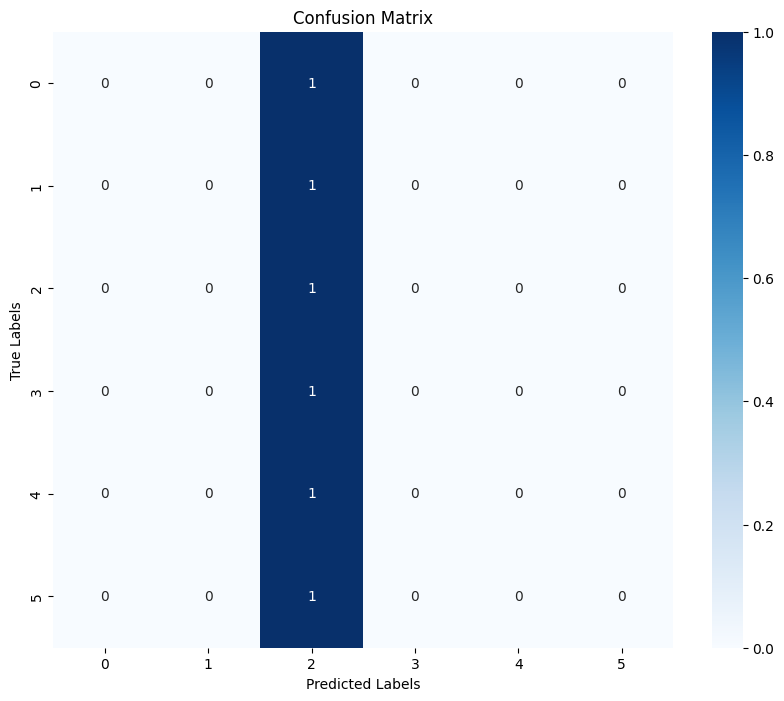

Epoch 6, Validation Loss: 1.8209, Accuracy: 0.2634, F1 Score: 0.1099
Val F1 Score Per Class  [0.        0.        0.4170096 0.        0.        0.       ]


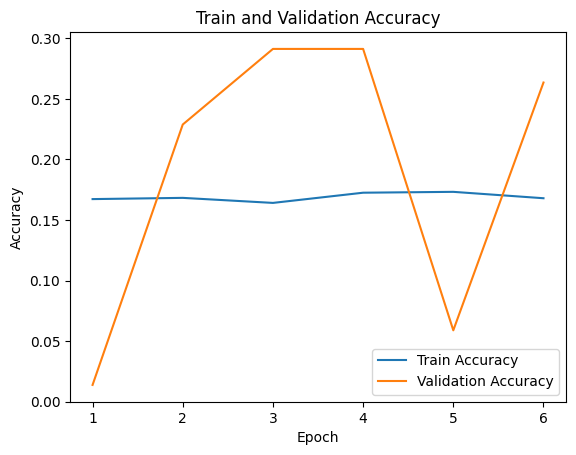

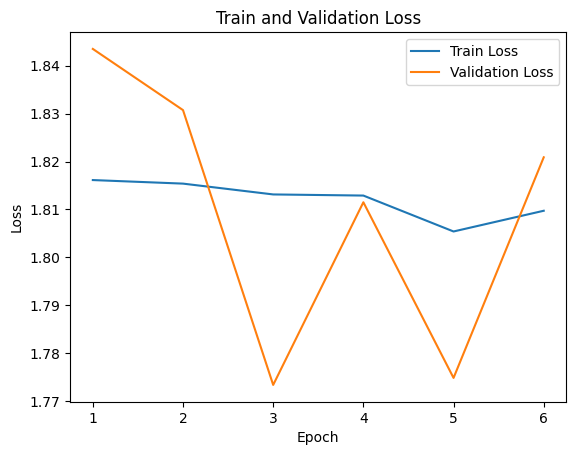

Epoch 7, Train Loss: 1.8048, Accuracy: 0.1654, F1 Score: 0.1573
Train F1 Score Per Class  [0.10814928 0.18803879 0.15651604 0.21958098 0.13805698 0.12709285]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.55it/s, loss=1.76]

[tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1732,  0.0352, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0352, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.52it/s, loss=1.75]

[tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0302, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0129, -0.0215,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0213,  0.1736,  0.0356, -0.0300, -0.1370], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.48it/s, loss=1.81]

[tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1737,  0.0356, -0.0303, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0352, -0.0300, -0.1370], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:27,  2.51it/s, loss=1.75]

[tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1732,  0.0352, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.48it/s, loss=1.77]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1737,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0215,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0213,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:26,  2.49it/s, loss=1.73]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1732,  0.0352, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0353, -0.0300, -0.1369], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.49it/s, loss=1.71]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0352, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.47it/s, loss=1.79]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0352, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1738,  0.0358, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0303, -0.1371], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:25,  2.48it/s, loss=1.78]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0125, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.48it/s, loss=1.73]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0303, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.47it/s, loss=1.82]

[tensor([ 0.0127, -0.0213,  0.1736,  0.0356, -0.0301, -0.1369], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0300, -0.1369], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.46it/s, loss=1.72]

[tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0213,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.48it/s, loss=1.78]

[tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0213,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0352, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0129, -0.0215,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:23,  2.47it/s, loss=1.78]

[tensor([ 0.0127, -0.0214,  0.1737,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0213,  0.1736,  0.0356, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.47it/s, loss=1.73]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1737,  0.0357, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0353, -0.0300, -0.1369], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.47it/s, loss=1.75]

[tensor([ 0.0127, -0.0213,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.47it/s, loss=1.78]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1733,  0.0352, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.47it/s, loss=1.8]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1732,  0.0352, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:21,  2.47it/s, loss=1.75]

[tensor([ 0.0128, -0.0214,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0213,  0.1736,  0.0357, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.47it/s, loss=1.71]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1732,  0.0351, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.47it/s, loss=1.75]

[tensor([ 0.0127, -0.0215,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0212,  0.1737,  0.0356, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  30%|███       | 22/73 [00:08<00:20,  2.47it/s, loss=1.76]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1732,  0.0352, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1735,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0129, -0.0213,  0.1735,  0.0354, -0.0300, -0.1369], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.46it/s, loss=1.73]

[tensor([ 0.0127, -0.0215,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.48it/s, loss=1.77]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0213,  0.1736,  0.0355, -0.0301, -0.1369], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.46it/s, loss=1.78]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0215,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.46it/s, loss=1.8]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0300, -0.1370], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:10<00:18,  2.47it/s, loss=1.73]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1736,  0.0356, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.47it/s, loss=1.77]

[tensor([ 0.0126, -0.0214,  0.1736,  0.0356, -0.0302, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0213,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1736,  0.0356, -0.0303, -0.1372], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.47it/s, loss=1.8]

[tensor([ 0.0127, -0.0215,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1736,  0.0355, -0.0302, -0.1372], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.47it/s, loss=1.78]

[tensor([ 0.0127, -0.0215,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1736,  0.0356, -0.0303, -0.1373], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1736,  0.0356, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:16,  2.48it/s, loss=1.76]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1732,  0.0352, -0.0300, -0.1369], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1736,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:12<00:16,  2.48it/s, loss=1.79]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.47it/s, loss=1.76]

[tensor([ 0.0128, -0.0214,  0.1734,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0125, -0.0214,  0.1737,  0.0356, -0.0302, -0.1372], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.47it/s, loss=1.75]

[tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.45it/s, loss=1.78]

[tensor([ 0.0128, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0300, -0.1370], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:14,  2.47it/s, loss=1.77]

[tensor([ 0.0128, -0.0214,  0.1736,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:14<00:14,  2.47it/s, loss=1.72]

[tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.48it/s, loss=1.77]

[tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1734,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0301, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.47it/s, loss=1.75]

[tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1732,  0.0352, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.47it/s, loss=1.78]

[tensor([ 0.0127, -0.0214,  0.1732,  0.0352, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:12,  2.47it/s, loss=1.75]

[tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1732,  0.0352, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0213,  0.1733,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:16<00:12,  2.48it/s, loss=1.69]

[tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0213,  0.1736,  0.0356, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0215,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1734,  0.0353, -0.0301, -0.1372], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0213,  0.1734,  0.0354, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.48it/s, loss=1.73]

[tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1735,  0.0355, -0.0303, -0.1372], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:17<00:11,  2.49it/s, loss=1.78]

[tensor([ 0.0126, -0.0213,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.47it/s, loss=1.75]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1732,  0.0352, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:10,  2.47it/s, loss=1.78]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0215,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1736,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0352, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:18<00:10,  2.48it/s, loss=1.77]

[tensor([ 0.0128, -0.0214,  0.1736,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1732,  0.0351, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1732,  0.0352, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1732,  0.0352, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0300, -0.1369], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.47it/s, loss=1.72]

[tensor([ 0.0127, -0.0213,  0.1735,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:19<00:09,  2.48it/s, loss=1.74]

[tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1732,  0.0352, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.48it/s, loss=1.78]

[tensor([ 0.0127, -0.0214,  0.1733,  0.0352, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0213,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.48it/s, loss=1.8]

[tensor([ 0.0127, -0.0214,  0.1736,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0213,  0.1737,  0.0357, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1732,  0.0352, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.48it/s, loss=1.76]

[tensor([ 0.0128, -0.0215,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0212,  0.1737,  0.0356, -0.0300, -0.1369], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1731,  0.0351, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.48it/s, loss=1.77]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1736,  0.0356, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:21<00:07,  2.48it/s, loss=1.73]

[tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0215,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.48it/s, loss=1.77]

[tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0128, -0.0213,  0.1734,  0.0353, -0.0300, -0.1369], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1732,  0.0352, -0.0301, -0.1371], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.47it/s, loss=1.73]

[tensor([ 0.0128, -0.0215,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0303, -0.1372], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.47it/s, loss=1.76]

[tensor([ 0.0126, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0129, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.47it/s, loss=1.74]

[tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0352, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1736,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1732,  0.0352, -0.0300, -0.1369], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1732,  0.0352, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:23<00:05,  2.48it/s, loss=1.73]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1734,  0.0353, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.47it/s, loss=1.69]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0213,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.47it/s, loss=1.78]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0213,  0.1736,  0.0356, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.47it/s, loss=1.8]

[tensor([ 0.0127, -0.0214,  0.1737,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0303, -0.1372], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.47it/s, loss=1.74]

[tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0300, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0213,  0.1735,  0.0355, -0.0300, -0.1369], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1372], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:25<00:03,  2.46it/s, loss=1.71]

[tensor([ 0.0126, -0.0213,  0.1736,  0.0356, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0128, -0.0213,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.48it/s, loss=1.69]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1732,  0.0352, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.47it/s, loss=1.77]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1734,  0.0353, -0.0303, -0.1372], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.47it/s, loss=1.71]

[tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0215,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0215,  0.1732,  0.0351, -0.0301, -0.1370], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.48it/s, loss=1.76]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0356, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:27<00:01,  2.47it/s, loss=1.78]

[tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1737,  0.0357, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0213,  0.1737,  0.0357, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1732,  0.0353, -0.0300, -0.1369], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0355, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0354, -0.0302, -0.1371], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.47it/s, loss=1.75]

[tensor([ 0.0127, -0.0215,  0.1732,  0.0352, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0213,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1733,  0.0353, -0.0300, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1736,  0.0356, -0.0302, -0.1371], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:28<00:00,  2.47it/s, loss=1.75]

[tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1733,  0.0353, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1735,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0213,  0.1735,  0.0355, -0.0301, -0.1371], device='cuda:0')]


[tensor([ 0.0128, -0.0213,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0'), tensor([ 0.0126, -0.0215,  0.1734,  0.0353, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1734,  0.0354, -0.0301, -0.1371], device='cuda:0'), tensor([ 0.0127, -0.0214,  0.1734,  0.0354, -0.0302, -0.1372], device='cuda:0'), tensor([ 0.0126, -0.0214,  0.1736,  0.0355, -0.0302, -0.1371], device='cuda:0'), tensor([ 0.0128, -0.0215,  0.1734,  0.0354, -0.0303, -0.1373], device='cuda:0'), tensor([ 0.0128, -0.0214,  0.1734,  0.0354, -0.0301, -0.1370], device='cuda:0')]
[tensor([ 0.0128, -0.0214,  0.1735,  0.0355, -0.0302, -0.1372], device='cuda:0')]


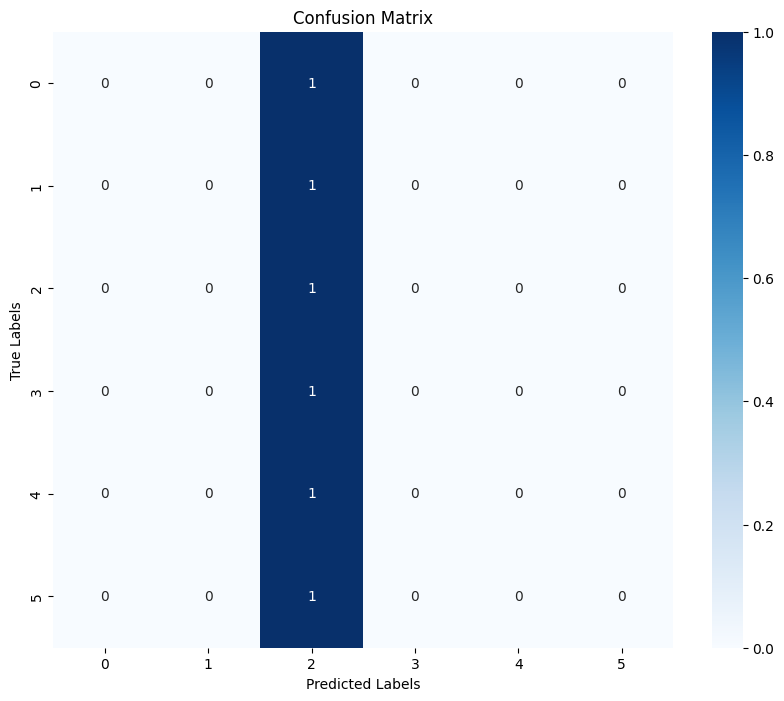

Epoch 7, Validation Loss: 1.7579, Accuracy: 0.2634, F1 Score: 0.1099
Val F1 Score Per Class  [0.        0.        0.4170096 0.        0.        0.       ]


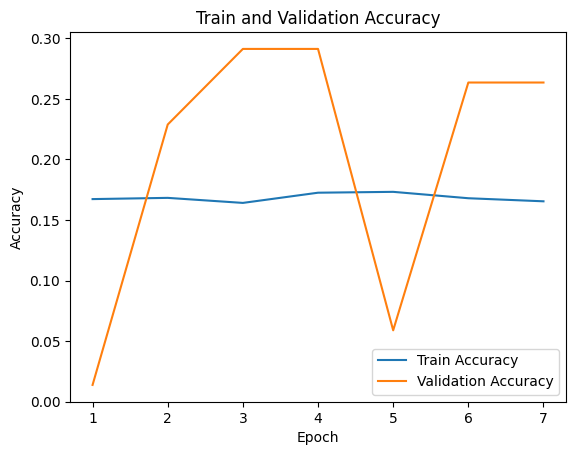

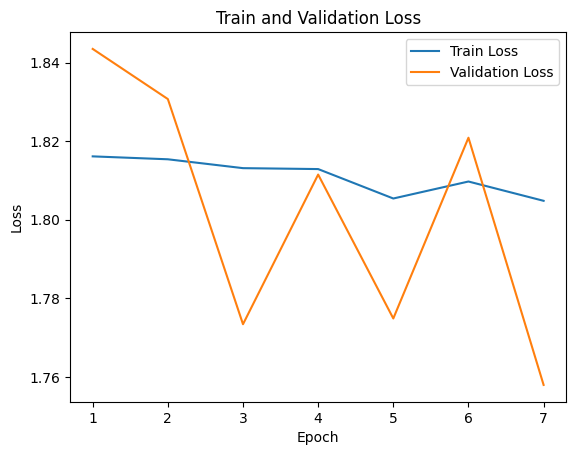

Epoch 8, Train Loss: 1.8048, Accuracy: 0.1661, F1 Score: 0.1634
Train F1 Score Per Class  [0.14561463 0.19686801 0.13315667 0.19520989 0.15405683 0.15189873]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.53it/s, loss=1.74]

[tensor([-0.2132, -0.3072,  0.1072,  0.2148,  0.0056,  0.1981], device='cuda:0'), tensor([-0.2138, -0.3073,  0.1071,  0.2150,  0.0055,  0.1978], device='cuda:0'), tensor([-0.2134, -0.3067,  0.1071,  0.2153,  0.0053,  0.1982], device='cuda:0'), tensor([-0.2134, -0.3067,  0.1069,  0.2153,  0.0051,  0.1980], device='cuda:0'), tensor([-0.2135, -0.3078,  0.1066,  0.2147,  0.0044,  0.1976], device='cuda:0'), tensor([-0.2134, -0.3066,  0.1071,  0.2146,  0.0056,  0.1980], device='cuda:0'), tensor([-0.2138, -0.3070,  0.1071,  0.2157,  0.0047,  0.1987], device='cuda:0'), tensor([-0.2133, -0.3074,  0.1072,  0.2149,  0.0052,  0.1983], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.53it/s, loss=1.72]

[tensor([-0.2129, -0.3076,  0.1069,  0.2143,  0.0053,  0.1977], device='cuda:0'), tensor([-0.2132, -0.3070,  0.1074,  0.2152,  0.0051,  0.1985], device='cuda:0'), tensor([-0.2137, -0.3074,  0.1076,  0.2155,  0.0045,  0.1988], device='cuda:0'), tensor([-0.2134, -0.3076,  0.1070,  0.2153,  0.0046,  0.1981], device='cuda:0'), tensor([-0.2141, -0.3075,  0.1072,  0.2148,  0.0052,  0.1981], device='cuda:0'), tensor([-0.2132, -0.3072,  0.1070,  0.2144,  0.0047,  0.1977], device='cuda:0'), tensor([-0.2140, -0.3063,  0.1068,  0.2156,  0.0055,  0.1980], device='cuda:0'), tensor([-0.2126, -0.3072,  0.1079,  0.2158,  0.0048,  0.1992], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.45it/s, loss=1.85]

[tensor([-0.2134, -0.3071,  0.1072,  0.2149,  0.0054,  0.1984], device='cuda:0'), tensor([-0.2139, -0.3068,  0.1070,  0.2152,  0.0049,  0.1978], device='cuda:0'), tensor([-0.2142, -0.3069,  0.1067,  0.2152,  0.0051,  0.1978], device='cuda:0'), tensor([-0.2135, -0.3076,  0.1070,  0.2147,  0.0050,  0.1977], device='cuda:0'), tensor([-0.2139, -0.3066,  0.1071,  0.2154,  0.0045,  0.1981], device='cuda:0'), tensor([-0.2134, -0.3062,  0.1068,  0.2149,  0.0059,  0.1977], device='cuda:0'), tensor([-0.2136, -0.3074,  0.1070,  0.2146,  0.0049,  0.1983], device='cuda:0'), tensor([-0.2133, -0.3071,  0.1073,  0.2151,  0.0054,  0.1987], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.41it/s, loss=1.91]

[tensor([-0.2130, -0.3072,  0.1072,  0.2155,  0.0052,  0.1986], device='cuda:0'), tensor([-0.2130, -0.3070,  0.1076,  0.2147,  0.0052,  0.1983], device='cuda:0'), tensor([-0.2130, -0.3077,  0.1068,  0.2144,  0.0049,  0.1980], device='cuda:0'), tensor([-0.2142, -0.3064,  0.1068,  0.2150,  0.0054,  0.1980], device='cuda:0'), tensor([-0.2143, -0.3071,  0.1065,  0.2154,  0.0050,  0.1977], device='cuda:0'), tensor([-0.2133, -0.3067,  0.1069,  0.2151,  0.0048,  0.1986], device='cuda:0'), tensor([-0.2131, -0.3072,  0.1076,  0.2155,  0.0048,  0.1986], device='cuda:0'), tensor([-0.2137, -0.3068,  0.1067,  0.2152,  0.0053,  0.1980], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.44it/s, loss=1.9]

[tensor([-0.2141, -0.3064,  0.1070,  0.2144,  0.0054,  0.1980], device='cuda:0'), tensor([-0.2138, -0.3062,  0.1068,  0.2150,  0.0058,  0.1979], device='cuda:0'), tensor([-0.2135, -0.3075,  0.1076,  0.2165,  0.0046,  0.1988], device='cuda:0'), tensor([-0.2133, -0.3071,  0.1072,  0.2160,  0.0047,  0.1988], device='cuda:0'), tensor([-0.2143, -0.3071,  0.1072,  0.2156,  0.0051,  0.1984], device='cuda:0'), tensor([-0.2138, -0.3074,  0.1069,  0.2144,  0.0050,  0.1978], device='cuda:0'), tensor([-0.2133, -0.3076,  0.1073,  0.2149,  0.0049,  0.1981], device='cuda:0'), tensor([-0.2134, -0.3077,  0.1074,  0.2151,  0.0049,  0.1986], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.41it/s, loss=1.72]

[tensor([-0.2138, -0.3073,  0.1070,  0.2158,  0.0052,  0.1983], device='cuda:0'), tensor([-0.2135, -0.3075,  0.1071,  0.2151,  0.0049,  0.1981], device='cuda:0'), tensor([-0.2132, -0.3070,  0.1076,  0.2158,  0.0049,  0.1990], device='cuda:0'), tensor([-0.2138, -0.3073,  0.1070,  0.2152,  0.0046,  0.1985], device='cuda:0'), tensor([-0.2132, -0.3074,  0.1071,  0.2149,  0.0047,  0.1980], device='cuda:0'), tensor([-0.2135, -0.3073,  0.1071,  0.2149,  0.0050,  0.1981], device='cuda:0'), tensor([-0.2135, -0.3076,  0.1073,  0.2151,  0.0049,  0.1982], device='cuda:0'), tensor([-0.2132, -0.3075,  0.1066,  0.2144,  0.0050,  0.1976], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.44it/s, loss=1.77]

[tensor([-0.2136, -0.3072,  0.1069,  0.2157,  0.0053,  0.1982], device='cuda:0'), tensor([-0.2134, -0.3072,  0.1074,  0.2155,  0.0046,  0.1989], device='cuda:0'), tensor([-0.2134, -0.3077,  0.1076,  0.2161,  0.0042,  0.1984], device='cuda:0'), tensor([-0.2139, -0.3069,  0.1071,  0.2147,  0.0050,  0.1983], device='cuda:0'), tensor([-0.2129, -0.3071,  0.1073,  0.2146,  0.0056,  0.1981], device='cuda:0'), tensor([-0.2132, -0.3077,  0.1071,  0.2150,  0.0050,  0.1981], device='cuda:0'), tensor([-0.2134, -0.3081,  0.1070,  0.2146,  0.0044,  0.1979], device='cuda:0'), tensor([-0.2130, -0.3075,  0.1074,  0.2153,  0.0046,  0.1982], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.44it/s, loss=1.85]

[tensor([-0.2134, -0.3077,  0.1066,  0.2149,  0.0050,  0.1979], device='cuda:0'), tensor([-0.2140, -0.3070,  0.1075,  0.2159,  0.0048,  0.1987], device='cuda:0'), tensor([-0.2137, -0.3070,  0.1069,  0.2154,  0.0050,  0.1979], device='cuda:0'), tensor([-0.2134, -0.3064,  0.1066,  0.2148,  0.0062,  0.1976], device='cuda:0'), tensor([-0.2136, -0.3067,  0.1072,  0.2163,  0.0048,  0.1988], device='cuda:0'), tensor([-0.2124, -0.3068,  0.1078,  0.2158,  0.0045,  0.1990], device='cuda:0'), tensor([-0.2143, -0.3065,  0.1071,  0.2155,  0.0052,  0.1981], device='cuda:0'), tensor([-0.2131, -0.3075,  0.1072,  0.2149,  0.0051,  0.1982], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.45it/s, loss=1.78]

[tensor([-0.2139, -0.3063,  0.1068,  0.2149,  0.0062,  0.1982], device='cuda:0'), tensor([-0.2139, -0.3068,  0.1069,  0.2159,  0.0051,  0.1982], device='cuda:0'), tensor([-0.2135, -0.3062,  0.1067,  0.2148,  0.0061,  0.1977], device='cuda:0'), tensor([-0.2135, -0.3069,  0.1068,  0.2148,  0.0053,  0.1977], device='cuda:0'), tensor([-0.2132, -0.3074,  0.1068,  0.2148,  0.0049,  0.1981], device='cuda:0'), tensor([-0.2138, -0.3081,  0.1068,  0.2151,  0.0043,  0.1976], device='cuda:0'), tensor([-0.2131, -0.3075,  0.1073,  0.2149,  0.0057,  0.1981], device='cuda:0'), tensor([-0.2131, -0.3071,  0.1070,  0.2151,  0.0045,  0.1980], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.46it/s, loss=1.77]

[tensor([-0.2137, -0.3062,  0.1067,  0.2142,  0.0060,  0.1973], device='cuda:0'), tensor([-0.2126, -0.3071,  0.1072,  0.2146,  0.0056,  0.1985], device='cuda:0'), tensor([-0.2138, -0.3072,  0.1071,  0.2150,  0.0051,  0.1981], device='cuda:0'), tensor([-0.2139, -0.3074,  0.1072,  0.2152,  0.0048,  0.1981], device='cuda:0'), tensor([-0.2140, -0.3073,  0.1068,  0.2150,  0.0052,  0.1981], device='cuda:0'), tensor([-0.2140, -0.3065,  0.1069,  0.2146,  0.0059,  0.1980], device='cuda:0'), tensor([-0.2135, -0.3069,  0.1067,  0.2147,  0.0055,  0.1974], device='cuda:0'), tensor([-0.2130, -0.3075,  0.1072,  0.2150,  0.0049,  0.1984], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.48it/s, loss=1.86]

[tensor([-0.2135, -0.3072,  0.1075,  0.2159,  0.0050,  0.1985], device='cuda:0'), tensor([-0.2136, -0.3067,  0.1069,  0.2153,  0.0049,  0.1984], device='cuda:0'), tensor([-0.2133, -0.3078,  0.1074,  0.2157,  0.0046,  0.1988], device='cuda:0'), tensor([-0.2133, -0.3078,  0.1076,  0.2161,  0.0048,  0.1988], device='cuda:0'), tensor([-0.2140, -0.3067,  0.1066,  0.2142,  0.0053,  0.1975], device='cuda:0'), tensor([-0.2137, -0.3079,  0.1071,  0.2158,  0.0047,  0.1987], device='cuda:0'), tensor([-0.2135, -0.3070,  0.1070,  0.2152,  0.0051,  0.1982], device='cuda:0'), tensor([-0.2139, -0.3075,  0.1073,  0.2153,  0.0049,  0.1985], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.46it/s, loss=1.9]

[tensor([-0.2136, -0.3070,  0.1069,  0.2151,  0.0051,  0.1984], device='cuda:0'), tensor([-0.2133, -0.3075,  0.1076,  0.2154,  0.0054,  0.1984], device='cuda:0'), tensor([-0.2143, -0.3074,  0.1065,  0.2145,  0.0049,  0.1979], device='cuda:0'), tensor([-0.2139, -0.3076,  0.1072,  0.2152,  0.0049,  0.1982], device='cuda:0'), tensor([-0.2130, -0.3069,  0.1075,  0.2152,  0.0056,  0.1985], device='cuda:0'), tensor([-0.2131, -0.3073,  0.1072,  0.2152,  0.0052,  0.1983], device='cuda:0'), tensor([-0.2131, -0.3070,  0.1071,  0.2146,  0.0056,  0.1982], device='cuda:0'), tensor([-0.2131, -0.3075,  0.1075,  0.2156,  0.0043,  0.1988], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.47it/s, loss=1.97]

[tensor([-0.2137, -0.3064,  0.1070,  0.2152,  0.0056,  0.1978], device='cuda:0'), tensor([-0.2136, -0.3072,  0.1074,  0.2152,  0.0048,  0.1986], device='cuda:0'), tensor([-0.2133, -0.3078,  0.1073,  0.2149,  0.0043,  0.1982], device='cuda:0'), tensor([-0.2130, -0.3073,  0.1075,  0.2156,  0.0048,  0.1986], device='cuda:0'), tensor([-0.2141, -0.3066,  0.1066,  0.2149,  0.0052,  0.1980], device='cuda:0'), tensor([-0.2143, -0.3071,  0.1072,  0.2160,  0.0049,  0.1987], device='cuda:0'), tensor([-0.2139, -0.3074,  0.1068,  0.2147,  0.0042,  0.1979], device='cuda:0'), tensor([-0.2133, -0.3070,  0.1074,  0.2155,  0.0049,  0.1983], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:23,  2.48it/s, loss=1.83]

[tensor([-0.2135, -0.3066,  0.1068,  0.2145,  0.0061,  0.1976], device='cuda:0'), tensor([-0.2136, -0.3072,  0.1070,  0.2152,  0.0055,  0.1982], device='cuda:0'), tensor([-0.2143, -0.3067,  0.1068,  0.2157,  0.0048,  0.1980], device='cuda:0'), tensor([-0.2131, -0.3071,  0.1070,  0.2147,  0.0055,  0.1978], device='cuda:0'), tensor([-0.2134, -0.3072,  0.1072,  0.2148,  0.0053,  0.1982], device='cuda:0'), tensor([-0.2136, -0.3069,  0.1072,  0.2154,  0.0058,  0.1979], device='cuda:0'), tensor([-0.2133, -0.3077,  0.1073,  0.2151,  0.0051,  0.1988], device='cuda:0'), tensor([-0.2135, -0.3077,  0.1069,  0.2148,  0.0050,  0.1974], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.48it/s, loss=1.87]

[tensor([-0.2135, -0.3067,  0.1069,  0.2146,  0.0053,  0.1981], device='cuda:0'), tensor([-0.2142, -0.3076,  0.1069,  0.2158,  0.0044,  0.1984], device='cuda:0'), tensor([-0.2137, -0.3071,  0.1070,  0.2154,  0.0049,  0.1986], device='cuda:0'), tensor([-0.2132, -0.3070,  0.1067,  0.2150,  0.0049,  0.1981], device='cuda:0'), tensor([-0.2136, -0.3069,  0.1071,  0.2155,  0.0054,  0.1984], device='cuda:0'), tensor([-0.2135, -0.3079,  0.1073,  0.2153,  0.0053,  0.1982], device='cuda:0'), tensor([-0.2139, -0.3078,  0.1075,  0.2162,  0.0046,  0.1986], device='cuda:0'), tensor([-0.2143, -0.3075,  0.1071,  0.2158,  0.0046,  0.1983], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.47it/s, loss=1.86]

[tensor([-0.2142, -0.3066,  0.1075,  0.2159,  0.0049,  0.1986], device='cuda:0'), tensor([-0.2132, -0.3076,  0.1073,  0.2155,  0.0052,  0.1982], device='cuda:0'), tensor([-0.2131, -0.3077,  0.1073,  0.2155,  0.0048,  0.1985], device='cuda:0'), tensor([-0.2140, -0.3072,  0.1070,  0.2155,  0.0047,  0.1982], device='cuda:0'), tensor([-0.2138, -0.3071,  0.1072,  0.2160,  0.0047,  0.1983], device='cuda:0'), tensor([-0.2129, -0.3076,  0.1072,  0.2148,  0.0052,  0.1983], device='cuda:0'), tensor([-0.2147, -0.3068,  0.1067,  0.2149,  0.0046,  0.1979], device='cuda:0'), tensor([-0.2138, -0.3063,  0.1069,  0.2151,  0.0059,  0.1975], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:24,  2.30it/s, loss=1.94]

[tensor([-0.2128, -0.3077,  0.1071,  0.2151,  0.0047,  0.1985], device='cuda:0'), tensor([-0.2140, -0.3068,  0.1072,  0.2154,  0.0053,  0.1983], device='cuda:0'), tensor([-0.2144, -0.3074,  0.1070,  0.2146,  0.0055,  0.1979], device='cuda:0'), tensor([-0.2132, -0.3068,  0.1071,  0.2149,  0.0054,  0.1983], device='cuda:0'), tensor([-0.2128, -0.3075,  0.1067,  0.2142,  0.0054,  0.1976], device='cuda:0'), tensor([-0.2130, -0.3080,  0.1077,  0.2154,  0.0046,  0.1989], device='cuda:0'), tensor([-0.2140, -0.3076,  0.1069,  0.2156,  0.0045,  0.1980], device='cuda:0'), tensor([-0.2137, -0.3072,  0.1071,  0.2150,  0.0053,  0.1981], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=1.91]

[tensor([-0.2132, -0.3073,  0.1071,  0.2150,  0.0049,  0.1983], device='cuda:0'), tensor([-0.2136, -0.3073,  0.1072,  0.2154,  0.0051,  0.1983], device='cuda:0'), tensor([-0.2134, -0.3062,  0.1068,  0.2144,  0.0064,  0.1974], device='cuda:0'), tensor([-0.2138, -0.3069,  0.1070,  0.2154,  0.0054,  0.1981], device='cuda:0'), tensor([-0.2140, -0.3071,  0.1067,  0.2155,  0.0052,  0.1980], device='cuda:0'), tensor([-0.2138, -0.3072,  0.1068,  0.2155,  0.0053,  0.1979], device='cuda:0'), tensor([-0.2135, -0.3070,  0.1067,  0.2152,  0.0055,  0.1980], device='cuda:0'), tensor([-0.2129, -0.3073,  0.1068,  0.2142,  0.0055,  0.1976], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.35it/s, loss=1.63]

[tensor([-0.2129, -0.3079,  0.1079,  0.2155,  0.0047,  0.1987], device='cuda:0'), tensor([-0.2130, -0.3077,  0.1076,  0.2156,  0.0049,  0.1988], device='cuda:0'), tensor([-0.2137, -0.3066,  0.1067,  0.2152,  0.0053,  0.1980], device='cuda:0'), tensor([-0.2132, -0.3071,  0.1073,  0.2152,  0.0052,  0.1986], device='cuda:0'), tensor([-0.2130, -0.3078,  0.1068,  0.2148,  0.0044,  0.1982], device='cuda:0'), tensor([-0.2136, -0.3062,  0.1071,  0.2153,  0.0060,  0.1976], device='cuda:0'), tensor([-0.2128, -0.3076,  0.1069,  0.2145,  0.0056,  0.1980], device='cuda:0'), tensor([-0.2142, -0.3074,  0.1070,  0.2157,  0.0050,  0.1980], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.40it/s, loss=1.73]

[tensor([-0.2135, -0.3072,  0.1075,  0.2154,  0.0049,  0.1985], device='cuda:0'), tensor([-0.2137, -0.3071,  0.1068,  0.2151,  0.0051,  0.1982], device='cuda:0'), tensor([-0.2136, -0.3069,  0.1067,  0.2153,  0.0055,  0.1980], device='cuda:0'), tensor([-0.2134, -0.3072,  0.1072,  0.2152,  0.0050,  0.1983], device='cuda:0'), tensor([-0.2137, -0.3070,  0.1071,  0.2154,  0.0052,  0.1987], device='cuda:0'), tensor([-0.2134, -0.3066,  0.1069,  0.2146,  0.0055,  0.1980], device='cuda:0'), tensor([-0.2136, -0.3074,  0.1072,  0.2152,  0.0051,  0.1982], device='cuda:0'), tensor([-0.2139, -0.3067,  0.1069,  0.2157,  0.0052,  0.1979], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.42it/s, loss=1.85]

[tensor([-0.2140, -0.3072,  0.1068,  0.2154,  0.0045,  0.1981], device='cuda:0'), tensor([-0.2143, -0.3065,  0.1070,  0.2152,  0.0047,  0.1981], device='cuda:0'), tensor([-0.2129, -0.3067,  0.1073,  0.2149,  0.0049,  0.1982], device='cuda:0'), tensor([-0.2137, -0.3072,  0.1070,  0.2154,  0.0053,  0.1980], device='cuda:0'), tensor([-0.2130, -0.3071,  0.1069,  0.2147,  0.0052,  0.1978], device='cuda:0'), tensor([-0.2131, -0.3075,  0.1073,  0.2147,  0.0054,  0.1983], device='cuda:0'), tensor([-0.2137, -0.3066,  0.1075,  0.2157,  0.0056,  0.1984], device='cuda:0'), tensor([-0.2140, -0.3073,  0.1068,  0.2152,  0.0052,  0.1983], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:20,  2.44it/s, loss=1.94]

[tensor([-0.2137, -0.3072,  0.1074,  0.2158,  0.0051,  0.1984], device='cuda:0'), tensor([-0.2144, -0.3062,  0.1065,  0.2142,  0.0059,  0.1976], device='cuda:0'), tensor([-0.2137, -0.3075,  0.1073,  0.2150,  0.0047,  0.1982], device='cuda:0'), tensor([-0.2139, -0.3069,  0.1064,  0.2152,  0.0051,  0.1978], device='cuda:0'), tensor([-0.2132, -0.3074,  0.1071,  0.2154,  0.0048,  0.1982], device='cuda:0'), tensor([-0.2132, -0.3074,  0.1074,  0.2159,  0.0046,  0.1987], device='cuda:0'), tensor([-0.2131, -0.3064,  0.1070,  0.2148,  0.0059,  0.1982], device='cuda:0'), tensor([-0.2134, -0.3068,  0.1071,  0.2149,  0.0053,  0.1982], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.44it/s, loss=1.77]

[tensor([-0.2136, -0.3074,  0.1071,  0.2156,  0.0049,  0.1983], device='cuda:0'), tensor([-0.2132, -0.3076,  0.1073,  0.2152,  0.0047,  0.1982], device='cuda:0'), tensor([-0.2133, -0.3073,  0.1072,  0.2152,  0.0051,  0.1982], device='cuda:0'), tensor([-0.2142, -0.3062,  0.1068,  0.2154,  0.0056,  0.1981], device='cuda:0'), tensor([-0.2133, -0.3080,  0.1075,  0.2155,  0.0045,  0.1984], device='cuda:0'), tensor([-0.2135, -0.3071,  0.1073,  0.2156,  0.0049,  0.1984], device='cuda:0'), tensor([-0.2141, -0.3064,  0.1070,  0.2157,  0.0055,  0.1980], device='cuda:0'), tensor([-0.2132, -0.3073,  0.1072,  0.2151,  0.0050,  0.1979], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.45it/s, loss=1.77]

[tensor([-0.2131, -0.3068,  0.1067,  0.2143,  0.0054,  0.1978], device='cuda:0'), tensor([-0.2130, -0.3081,  0.1075,  0.2157,  0.0044,  0.1990], device='cuda:0'), tensor([-0.2130, -0.3077,  0.1074,  0.2157,  0.0040,  0.1986], device='cuda:0'), tensor([-0.2134, -0.3071,  0.1072,  0.2148,  0.0050,  0.1982], device='cuda:0'), tensor([-0.2139, -0.3072,  0.1073,  0.2153,  0.0048,  0.1984], device='cuda:0'), tensor([-0.2139, -0.3071,  0.1066,  0.2151,  0.0052,  0.1981], device='cuda:0'), tensor([-0.2133, -0.3071,  0.1070,  0.2148,  0.0053,  0.1979], device='cuda:0'), tensor([-0.2133, -0.3069,  0.1071,  0.2151,  0.0052,  0.1980], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.47it/s, loss=1.75]

[tensor([-0.2144, -0.3060,  0.1067,  0.2155,  0.0057,  0.1979], device='cuda:0'), tensor([-0.2139, -0.3069,  0.1072,  0.2150,  0.0061,  0.1981], device='cuda:0'), tensor([-0.2140, -0.3069,  0.1068,  0.2145,  0.0057,  0.1975], device='cuda:0'), tensor([-0.2135, -0.3077,  0.1071,  0.2154,  0.0048,  0.1984], device='cuda:0'), tensor([-0.2137, -0.3076,  0.1070,  0.2149,  0.0050,  0.1983], device='cuda:0'), tensor([-0.2140, -0.3072,  0.1068,  0.2154,  0.0052,  0.1980], device='cuda:0'), tensor([-0.2131, -0.3068,  0.1071,  0.2145,  0.0060,  0.1978], device='cuda:0'), tensor([-0.2130, -0.3070,  0.1073,  0.2148,  0.0052,  0.1985], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.47it/s, loss=1.77]

[tensor([-0.2133, -0.3077,  0.1069,  0.2148,  0.0046,  0.1981], device='cuda:0'), tensor([-0.2137, -0.3074,  0.1070,  0.2158,  0.0046,  0.1983], device='cuda:0'), tensor([-0.2132, -0.3071,  0.1073,  0.2151,  0.0057,  0.1981], device='cuda:0'), tensor([-0.2134, -0.3072,  0.1071,  0.2154,  0.0049,  0.1983], device='cuda:0'), tensor([-0.2135, -0.3071,  0.1071,  0.2157,  0.0051,  0.1982], device='cuda:0'), tensor([-0.2135, -0.3073,  0.1073,  0.2152,  0.0048,  0.1986], device='cuda:0'), tensor([-0.2136, -0.3071,  0.1072,  0.2156,  0.0047,  0.1982], device='cuda:0'), tensor([-0.2130, -0.3075,  0.1076,  0.2158,  0.0044,  0.1990], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:18,  2.46it/s, loss=1.82]

[tensor([-0.2131, -0.3070,  0.1072,  0.2150,  0.0051,  0.1987], device='cuda:0'), tensor([-0.2128, -0.3076,  0.1071,  0.2149,  0.0042,  0.1983], device='cuda:0'), tensor([-0.2141, -0.3071,  0.1071,  0.2151,  0.0054,  0.1982], device='cuda:0'), tensor([-0.2137, -0.3069,  0.1072,  0.2157,  0.0055,  0.1984], device='cuda:0'), tensor([-0.2134, -0.3072,  0.1069,  0.2149,  0.0050,  0.1978], device='cuda:0'), tensor([-0.2140, -0.3075,  0.1073,  0.2154,  0.0044,  0.1982], device='cuda:0'), tensor([-0.2139, -0.3070,  0.1070,  0.2151,  0.0047,  0.1979], device='cuda:0'), tensor([-0.2137, -0.3067,  0.1072,  0.2153,  0.0052,  0.1983], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.45it/s, loss=1.82]

[tensor([-0.2135, -0.3070,  0.1071,  0.2146,  0.0057,  0.1976], device='cuda:0'), tensor([-0.2134, -0.3066,  0.1075,  0.2150,  0.0048,  0.1985], device='cuda:0'), tensor([-0.2132, -0.3073,  0.1075,  0.2153,  0.0049,  0.1985], device='cuda:0'), tensor([-0.2138, -0.3065,  0.1068,  0.2149,  0.0051,  0.1978], device='cuda:0'), tensor([-0.2133, -0.3072,  0.1068,  0.2147,  0.0049,  0.1978], device='cuda:0'), tensor([-0.2140, -0.3073,  0.1072,  0.2158,  0.0053,  0.1982], device='cuda:0'), tensor([-0.2133, -0.3069,  0.1073,  0.2153,  0.0055,  0.1982], device='cuda:0'), tensor([-0.2144, -0.3069,  0.1070,  0.2141,  0.0048,  0.1979], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.46it/s, loss=1.98]

[tensor([-0.2135, -0.3070,  0.1069,  0.2151,  0.0054,  0.1979], device='cuda:0'), tensor([-0.2129, -0.3080,  0.1071,  0.2150,  0.0048,  0.1983], device='cuda:0'), tensor([-0.2131, -0.3071,  0.1074,  0.2151,  0.0051,  0.1985], device='cuda:0'), tensor([-0.2131, -0.3073,  0.1073,  0.2156,  0.0047,  0.1984], device='cuda:0'), tensor([-0.2142, -0.3063,  0.1065,  0.2155,  0.0058,  0.1980], device='cuda:0'), tensor([-0.2137, -0.3076,  0.1066,  0.2153,  0.0047,  0.1980], device='cuda:0'), tensor([-0.2130, -0.3074,  0.1071,  0.2153,  0.0045,  0.1982], device='cuda:0'), tensor([-0.2138, -0.3065,  0.1071,  0.2154,  0.0048,  0.1983], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.45it/s, loss=1.91]

[tensor([-0.2144, -0.3063,  0.1067,  0.2148,  0.0056,  0.1978], device='cuda:0'), tensor([-0.2140, -0.3073,  0.1068,  0.2155,  0.0051,  0.1981], device='cuda:0'), tensor([-0.2126, -0.3073,  0.1075,  0.2151,  0.0053,  0.1985], device='cuda:0'), tensor([-0.2136, -0.3078,  0.1072,  0.2160,  0.0043,  0.1982], device='cuda:0'), tensor([-0.2136, -0.3070,  0.1069,  0.2151,  0.0048,  0.1980], device='cuda:0'), tensor([-0.2137, -0.3075,  0.1073,  0.2153,  0.0050,  0.1985], device='cuda:0'), tensor([-0.2138, -0.3073,  0.1073,  0.2161,  0.0048,  0.1985], device='cuda:0'), tensor([-0.2138, -0.3075,  0.1074,  0.2159,  0.0048,  0.1983], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.46it/s, loss=1.73]

[tensor([-0.2130, -0.3077,  0.1072,  0.2145,  0.0048,  0.1981], device='cuda:0'), tensor([-0.2130, -0.3066,  0.1071,  0.2153,  0.0055,  0.1982], device='cuda:0'), tensor([-0.2132, -0.3078,  0.1073,  0.2149,  0.0046,  0.1986], device='cuda:0'), tensor([-0.2135, -0.3071,  0.1070,  0.2148,  0.0058,  0.1981], device='cuda:0'), tensor([-0.2139, -0.3073,  0.1074,  0.2162,  0.0046,  0.1986], device='cuda:0'), tensor([-0.2141, -0.3069,  0.1071,  0.2159,  0.0044,  0.1984], device='cuda:0'), tensor([-0.2141, -0.3073,  0.1066,  0.2145,  0.0047,  0.1973], device='cuda:0'), tensor([-0.2133, -0.3074,  0.1071,  0.2144,  0.0048,  0.1978], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.47it/s, loss=1.83]

[tensor([-0.2134, -0.3074,  0.1071,  0.2151,  0.0047,  0.1982], device='cuda:0'), tensor([-0.2137, -0.3075,  0.1070,  0.2155,  0.0050,  0.1981], device='cuda:0'), tensor([-0.2126, -0.3080,  0.1076,  0.2149,  0.0050,  0.1985], device='cuda:0'), tensor([-0.2132, -0.3079,  0.1075,  0.2156,  0.0042,  0.1984], device='cuda:0'), tensor([-0.2131, -0.3072,  0.1068,  0.2143,  0.0048,  0.1981], device='cuda:0'), tensor([-0.2133, -0.3066,  0.1071,  0.2150,  0.0053,  0.1984], device='cuda:0'), tensor([-0.2133, -0.3071,  0.1076,  0.2159,  0.0045,  0.1984], device='cuda:0'), tensor([-0.2137, -0.3070,  0.1069,  0.2151,  0.0056,  0.1980], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.46it/s, loss=1.74]

[tensor([-0.2140, -0.3068,  0.1066,  0.2149,  0.0054,  0.1976], device='cuda:0'), tensor([-0.2131, -0.3075,  0.1069,  0.2144,  0.0050,  0.1980], device='cuda:0'), tensor([-0.2147, -0.3076,  0.1070,  0.2157,  0.0048,  0.1979], device='cuda:0'), tensor([-0.2143, -0.3082,  0.1069,  0.2155,  0.0041,  0.1982], device='cuda:0'), tensor([-0.2131, -0.3078,  0.1077,  0.2154,  0.0048,  0.1988], device='cuda:0'), tensor([-0.2134, -0.3073,  0.1073,  0.2150,  0.0056,  0.1979], device='cuda:0'), tensor([-0.2134, -0.3077,  0.1077,  0.2161,  0.0042,  0.1986], device='cuda:0'), tensor([-0.2146, -0.3069,  0.1067,  0.2154,  0.0060,  0.1975], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.46it/s, loss=1.81]

[tensor([-0.2128, -0.3077,  0.1070,  0.2146,  0.0052,  0.1979], device='cuda:0'), tensor([-0.2133, -0.3076,  0.1074,  0.2151,  0.0048,  0.1985], device='cuda:0'), tensor([-0.2135, -0.3076,  0.1070,  0.2145,  0.0049,  0.1981], device='cuda:0'), tensor([-0.2131, -0.3072,  0.1069,  0.2147,  0.0059,  0.1978], device='cuda:0'), tensor([-0.2132, -0.3070,  0.1068,  0.2148,  0.0054,  0.1981], device='cuda:0'), tensor([-0.2139, -0.3070,  0.1066,  0.2146,  0.0049,  0.1977], device='cuda:0'), tensor([-0.2133, -0.3072,  0.1070,  0.2156,  0.0049,  0.1985], device='cuda:0'), tensor([-0.2131, -0.3075,  0.1075,  0.2149,  0.0049,  0.1985], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.44it/s, loss=1.88]

[tensor([-0.2134, -0.3077,  0.1070,  0.2150,  0.0050,  0.1983], device='cuda:0'), tensor([-0.2138, -0.3070,  0.1067,  0.2148,  0.0050,  0.1978], device='cuda:0'), tensor([-0.2131, -0.3077,  0.1073,  0.2153,  0.0047,  0.1988], device='cuda:0'), tensor([-0.2143, -0.3061,  0.1066,  0.2155,  0.0057,  0.1976], device='cuda:0'), tensor([-0.2133, -0.3068,  0.1072,  0.2151,  0.0047,  0.1983], device='cuda:0'), tensor([-0.2128, -0.3070,  0.1065,  0.2143,  0.0056,  0.1979], device='cuda:0'), tensor([-0.2146, -0.3071,  0.1069,  0.2159,  0.0046,  0.1983], device='cuda:0'), tensor([-0.2138, -0.3065,  0.1064,  0.2149,  0.0053,  0.1979], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.44it/s, loss=1.76]

[tensor([-0.2142, -0.3075,  0.1071,  0.2155,  0.0050,  0.1985], device='cuda:0'), tensor([-0.2133, -0.3077,  0.1072,  0.2149,  0.0043,  0.1981], device='cuda:0'), tensor([-0.2134, -0.3073,  0.1069,  0.2151,  0.0055,  0.1977], device='cuda:0'), tensor([-0.2143, -0.3072,  0.1070,  0.2149,  0.0045,  0.1981], device='cuda:0'), tensor([-0.2135, -0.3071,  0.1070,  0.2152,  0.0054,  0.1982], device='cuda:0'), tensor([-0.2129, -0.3069,  0.1072,  0.2148,  0.0060,  0.1980], device='cuda:0'), tensor([-0.2138, -0.3069,  0.1071,  0.2157,  0.0054,  0.1984], device='cuda:0'), tensor([-0.2135, -0.3069,  0.1070,  0.2151,  0.0056,  0.1982], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.44it/s, loss=1.8]

[tensor([-0.2133, -0.3077,  0.1073,  0.2156,  0.0050,  0.1984], device='cuda:0'), tensor([-0.2132, -0.3078,  0.1073,  0.2155,  0.0043,  0.1985], device='cuda:0'), tensor([-0.2136, -0.3071,  0.1071,  0.2153,  0.0048,  0.1986], device='cuda:0'), tensor([-0.2139, -0.3070,  0.1068,  0.2155,  0.0053,  0.1979], device='cuda:0'), tensor([-0.2134, -0.3065,  0.1072,  0.2154,  0.0055,  0.1984], device='cuda:0'), tensor([-0.2136, -0.3070,  0.1071,  0.2154,  0.0052,  0.1984], device='cuda:0'), tensor([-0.2135, -0.3075,  0.1073,  0.2153,  0.0047,  0.1985], device='cuda:0'), tensor([-0.2135, -0.3068,  0.1070,  0.2155,  0.0057,  0.1981], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.45it/s, loss=1.76]

[tensor([-0.2135, -0.3072,  0.1072,  0.2153,  0.0053,  0.1980], device='cuda:0'), tensor([-0.2134, -0.3070,  0.1072,  0.2150,  0.0053,  0.1982], device='cuda:0'), tensor([-0.2143, -0.3076,  0.1068,  0.2155,  0.0045,  0.1979], device='cuda:0'), tensor([-0.2131, -0.3065,  0.1070,  0.2142,  0.0058,  0.1979], device='cuda:0'), tensor([-0.2134, -0.3077,  0.1075,  0.2160,  0.0044,  0.1989], device='cuda:0'), tensor([-0.2136, -0.3073,  0.1068,  0.2148,  0.0050,  0.1980], device='cuda:0'), tensor([-0.2139, -0.3069,  0.1068,  0.2152,  0.0050,  0.1980], device='cuda:0'), tensor([-0.2138, -0.3074,  0.1068,  0.2153,  0.0050,  0.1982], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.45it/s, loss=1.81]

[tensor([-0.2137, -0.3070,  0.1074,  0.2156,  0.0052,  0.1987], device='cuda:0'), tensor([-0.2134, -0.3066,  0.1069,  0.2147,  0.0059,  0.1979], device='cuda:0'), tensor([-0.2132, -0.3065,  0.1069,  0.2143,  0.0057,  0.1978], device='cuda:0'), tensor([-0.2137, -0.3062,  0.1071,  0.2143,  0.0060,  0.1977], device='cuda:0'), tensor([-0.2129, -0.3080,  0.1081,  0.2159,  0.0043,  0.1990], device='cuda:0'), tensor([-0.2132, -0.3071,  0.1073,  0.2152,  0.0049,  0.1987], device='cuda:0'), tensor([-0.2135, -0.3071,  0.1073,  0.2154,  0.0051,  0.1983], device='cuda:0'), tensor([-0.2141, -0.3065,  0.1068,  0.2152,  0.0056,  0.1980], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.46it/s, loss=1.89]

[tensor([-0.2131, -0.3073,  0.1074,  0.2153,  0.0050,  0.1986], device='cuda:0'), tensor([-0.2136, -0.3070,  0.1067,  0.2150,  0.0050,  0.1978], device='cuda:0'), tensor([-0.2132, -0.3077,  0.1069,  0.2150,  0.0045,  0.1981], device='cuda:0'), tensor([-0.2136, -0.3070,  0.1072,  0.2144,  0.0047,  0.1985], device='cuda:0'), tensor([-0.2130, -0.3070,  0.1070,  0.2148,  0.0055,  0.1982], device='cuda:0'), tensor([-0.2135, -0.3072,  0.1076,  0.2159,  0.0047,  0.1988], device='cuda:0'), tensor([-0.2132, -0.3079,  0.1077,  0.2161,  0.0039,  0.1990], device='cuda:0'), tensor([-0.2134, -0.3072,  0.1073,  0.2148,  0.0053,  0.1985], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.43it/s, loss=1.81]

[tensor([-0.2130, -0.3076,  0.1076,  0.2152,  0.0047,  0.1987], device='cuda:0'), tensor([-0.2138, -0.3070,  0.1068,  0.2148,  0.0051,  0.1980], device='cuda:0'), tensor([-0.2132, -0.3072,  0.1072,  0.2153,  0.0053,  0.1983], device='cuda:0'), tensor([-0.2132, -0.3074,  0.1077,  0.2153,  0.0050,  0.1986], device='cuda:0'), tensor([-0.2135, -0.3077,  0.1074,  0.2158,  0.0044,  0.1988], device='cuda:0'), tensor([-0.2136, -0.3070,  0.1073,  0.2155,  0.0050,  0.1982], device='cuda:0'), tensor([-0.2139, -0.3070,  0.1076,  0.2158,  0.0048,  0.1985], device='cuda:0'), tensor([-0.2132, -0.3068,  0.1071,  0.2149,  0.0057,  0.1984], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.44it/s, loss=1.73]

[tensor([-0.2132, -0.3068,  0.1071,  0.2144,  0.0059,  0.1977], device='cuda:0'), tensor([-0.2131, -0.3076,  0.1072,  0.2151,  0.0049,  0.1981], device='cuda:0'), tensor([-0.2136, -0.3077,  0.1072,  0.2148,  0.0048,  0.1983], device='cuda:0'), tensor([-0.2137, -0.3070,  0.1071,  0.2158,  0.0048,  0.1985], device='cuda:0'), tensor([-0.2137, -0.3068,  0.1074,  0.2155,  0.0046,  0.1987], device='cuda:0'), tensor([-0.2131, -0.3072,  0.1072,  0.2153,  0.0052,  0.1984], device='cuda:0'), tensor([-0.2129, -0.3075,  0.1079,  0.2156,  0.0041,  0.1990], device='cuda:0'), tensor([-0.2136, -0.3070,  0.1073,  0.2154,  0.0047,  0.1986], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.44it/s, loss=1.77]

[tensor([-0.2138, -0.3075,  0.1075,  0.2151,  0.0049,  0.1984], device='cuda:0'), tensor([-0.2128, -0.3077,  0.1076,  0.2155,  0.0047,  0.1988], device='cuda:0'), tensor([-0.2140, -0.3066,  0.1068,  0.2149,  0.0049,  0.1979], device='cuda:0'), tensor([-0.2135, -0.3070,  0.1071,  0.2155,  0.0048,  0.1986], device='cuda:0'), tensor([-0.2128, -0.3077,  0.1074,  0.2145,  0.0048,  0.1987], device='cuda:0'), tensor([-0.2138, -0.3071,  0.1074,  0.2146,  0.0056,  0.1981], device='cuda:0'), tensor([-0.2130, -0.3076,  0.1070,  0.2146,  0.0051,  0.1979], device='cuda:0'), tensor([-0.2142, -0.3069,  0.1069,  0.2151,  0.0059,  0.1979], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:11,  2.43it/s, loss=1.78]

[tensor([-0.2135, -0.3078,  0.1073,  0.2150,  0.0048,  0.1985], device='cuda:0'), tensor([-0.2133, -0.3074,  0.1073,  0.2153,  0.0047,  0.1986], device='cuda:0'), tensor([-0.2131, -0.3066,  0.1071,  0.2150,  0.0052,  0.1978], device='cuda:0'), tensor([-0.2136, -0.3069,  0.1072,  0.2143,  0.0051,  0.1980], device='cuda:0'), tensor([-0.2143, -0.3065,  0.1068,  0.2157,  0.0050,  0.1983], device='cuda:0'), tensor([-0.2134, -0.3074,  0.1071,  0.2152,  0.0048,  0.1983], device='cuda:0'), tensor([-0.2138, -0.3066,  0.1072,  0.2149,  0.0058,  0.1981], device='cuda:0'), tensor([-0.2128, -0.3075,  0.1077,  0.2159,  0.0043,  0.1991], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.44it/s, loss=1.77]

[tensor([-0.2134, -0.3069,  0.1072,  0.2155,  0.0049,  0.1984], device='cuda:0'), tensor([-0.2137, -0.3070,  0.1073,  0.2156,  0.0053,  0.1986], device='cuda:0'), tensor([-0.2137, -0.3073,  0.1073,  0.2154,  0.0051,  0.1986], device='cuda:0'), tensor([-0.2134, -0.3068,  0.1069,  0.2150,  0.0049,  0.1987], device='cuda:0'), tensor([-0.2143, -0.3064,  0.1064,  0.2148,  0.0056,  0.1972], device='cuda:0'), tensor([-0.2133, -0.3070,  0.1074,  0.2153,  0.0052,  0.1982], device='cuda:0'), tensor([-0.2143, -0.3063,  0.1071,  0.2152,  0.0059,  0.1980], device='cuda:0'), tensor([-0.2140, -0.3071,  0.1069,  0.2153,  0.0049,  0.1982], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.43it/s, loss=1.69]

[tensor([-0.2140, -0.3066,  0.1070,  0.2152,  0.0054,  0.1980], device='cuda:0'), tensor([-0.2136, -0.3071,  0.1072,  0.2156,  0.0048,  0.1983], device='cuda:0'), tensor([-0.2128, -0.3079,  0.1078,  0.2152,  0.0044,  0.1987], device='cuda:0'), tensor([-0.2142, -0.3074,  0.1074,  0.2155,  0.0047,  0.1988], device='cuda:0'), tensor([-0.2135, -0.3073,  0.1072,  0.2153,  0.0048,  0.1983], device='cuda:0'), tensor([-0.2137, -0.3063,  0.1070,  0.2154,  0.0061,  0.1981], device='cuda:0'), tensor([-0.2143, -0.3070,  0.1066,  0.2148,  0.0057,  0.1978], device='cuda:0'), tensor([-0.2135, -0.3071,  0.1070,  0.2154,  0.0052,  0.1984], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.45it/s, loss=1.8]

[tensor([-0.2130, -0.3070,  0.1070,  0.2151,  0.0055,  0.1983], device='cuda:0'), tensor([-0.2135, -0.3067,  0.1073,  0.2150,  0.0048,  0.1980], device='cuda:0'), tensor([-0.2132, -0.3072,  0.1071,  0.2155,  0.0050,  0.1984], device='cuda:0'), tensor([-0.2142, -0.3068,  0.1073,  0.2152,  0.0051,  0.1987], device='cuda:0'), tensor([-0.2135, -0.3074,  0.1072,  0.2154,  0.0048,  0.1984], device='cuda:0'), tensor([-0.2134, -0.3075,  0.1073,  0.2158,  0.0049,  0.1983], device='cuda:0'), tensor([-0.2144, -0.3074,  0.1068,  0.2151,  0.0041,  0.1982], device='cuda:0'), tensor([-0.2135, -0.3073,  0.1071,  0.2151,  0.0053,  0.1981], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.46it/s, loss=1.7]

[tensor([-0.2132, -0.3074,  0.1074,  0.2154,  0.0050,  0.1985], device='cuda:0'), tensor([-0.2135, -0.3073,  0.1069,  0.2149,  0.0052,  0.1983], device='cuda:0'), tensor([-0.2136, -0.3071,  0.1071,  0.2158,  0.0050,  0.1986], device='cuda:0'), tensor([-0.2137, -0.3068,  0.1072,  0.2154,  0.0051,  0.1984], device='cuda:0'), tensor([-0.2134, -0.3068,  0.1071,  0.2156,  0.0049,  0.1984], device='cuda:0'), tensor([-0.2139, -0.3065,  0.1067,  0.2146,  0.0056,  0.1975], device='cuda:0'), tensor([-0.2144, -0.3077,  0.1073,  0.2155,  0.0050,  0.1979], device='cuda:0'), tensor([-0.2139, -0.3070,  0.1065,  0.2151,  0.0049,  0.1978], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.46it/s, loss=1.73]

[tensor([-0.2134, -0.3076,  0.1071,  0.2148,  0.0054,  0.1976], device='cuda:0'), tensor([-0.2133, -0.3078,  0.1071,  0.2156,  0.0048,  0.1985], device='cuda:0'), tensor([-0.2135, -0.3069,  0.1073,  0.2153,  0.0052,  0.1985], device='cuda:0'), tensor([-0.2138, -0.3072,  0.1070,  0.2158,  0.0046,  0.1982], device='cuda:0'), tensor([-0.2136, -0.3074,  0.1069,  0.2149,  0.0051,  0.1980], device='cuda:0'), tensor([-0.2134, -0.3078,  0.1077,  0.2153,  0.0039,  0.1985], device='cuda:0'), tensor([-0.2145, -0.3065,  0.1074,  0.2158,  0.0045,  0.1983], device='cuda:0'), tensor([-0.2135, -0.3070,  0.1073,  0.2155,  0.0050,  0.1981], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.47it/s, loss=1.83]

[tensor([-0.2136, -0.3074,  0.1074,  0.2153,  0.0048,  0.1985], device='cuda:0'), tensor([-0.2135, -0.3071,  0.1069,  0.2147,  0.0055,  0.1979], device='cuda:0'), tensor([-0.2135, -0.3069,  0.1068,  0.2146,  0.0045,  0.1976], device='cuda:0'), tensor([-0.2142, -0.3066,  0.1073,  0.2154,  0.0054,  0.1983], device='cuda:0'), tensor([-0.2142, -0.3072,  0.1075,  0.2162,  0.0045,  0.1985], device='cuda:0'), tensor([-0.2131, -0.3065,  0.1073,  0.2149,  0.0056,  0.1984], device='cuda:0'), tensor([-0.2132, -0.3070,  0.1072,  0.2150,  0.0052,  0.1980], device='cuda:0'), tensor([-0.2134, -0.3073,  0.1075,  0.2148,  0.0053,  0.1985], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.47it/s, loss=1.87]

[tensor([-0.2142, -0.3061,  0.1066,  0.2146,  0.0062,  0.1976], device='cuda:0'), tensor([-0.2131, -0.3070,  0.1072,  0.2156,  0.0048,  0.1987], device='cuda:0'), tensor([-0.2138, -0.3062,  0.1068,  0.2151,  0.0058,  0.1980], device='cuda:0'), tensor([-0.2141, -0.3074,  0.1076,  0.2157,  0.0052,  0.1981], device='cuda:0'), tensor([-0.2128, -0.3075,  0.1070,  0.2152,  0.0049,  0.1983], device='cuda:0'), tensor([-0.2135, -0.3061,  0.1068,  0.2151,  0.0056,  0.1978], device='cuda:0'), tensor([-0.2130, -0.3081,  0.1079,  0.2158,  0.0040,  0.1992], device='cuda:0'), tensor([-0.2130, -0.3074,  0.1073,  0.2152,  0.0055,  0.1984], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.47it/s, loss=1.74]

[tensor([-0.2138, -0.3067,  0.1072,  0.2156,  0.0057,  0.1983], device='cuda:0'), tensor([-0.2136, -0.3075,  0.1073,  0.2152,  0.0050,  0.1983], device='cuda:0'), tensor([-0.2127, -0.3075,  0.1074,  0.2150,  0.0052,  0.1983], device='cuda:0'), tensor([-0.2135, -0.3072,  0.1070,  0.2151,  0.0053,  0.1981], device='cuda:0'), tensor([-0.2135, -0.3069,  0.1078,  0.2166,  0.0048,  0.1989], device='cuda:0'), tensor([-0.2135, -0.3074,  0.1076,  0.2157,  0.0047,  0.1989], device='cuda:0'), tensor([-0.2141, -0.3068,  0.1068,  0.2153,  0.0049,  0.1978], device='cuda:0'), tensor([-0.2134, -0.3070,  0.1072,  0.2153,  0.0055,  0.1983], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.47it/s, loss=1.99]

[tensor([-0.2133, -0.3077,  0.1069,  0.2147,  0.0053,  0.1979], device='cuda:0'), tensor([-0.2130, -0.3072,  0.1069,  0.2146,  0.0052,  0.1979], device='cuda:0'), tensor([-0.2136, -0.3074,  0.1072,  0.2153,  0.0050,  0.1984], device='cuda:0'), tensor([-0.2144, -0.3071,  0.1074,  0.2154,  0.0050,  0.1986], device='cuda:0'), tensor([-0.2145, -0.3063,  0.1070,  0.2161,  0.0052,  0.1983], device='cuda:0'), tensor([-0.2132, -0.3074,  0.1073,  0.2154,  0.0050,  0.1984], device='cuda:0'), tensor([-0.2140, -0.3080,  0.1074,  0.2154,  0.0043,  0.1984], device='cuda:0'), tensor([-0.2138, -0.3062,  0.1070,  0.2154,  0.0052,  0.1983], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.47it/s, loss=1.82]

[tensor([-0.2132, -0.3071,  0.1069,  0.2151,  0.0051,  0.1983], device='cuda:0'), tensor([-0.2140, -0.3076,  0.1070,  0.2152,  0.0048,  0.1978], device='cuda:0'), tensor([-0.2133, -0.3072,  0.1075,  0.2155,  0.0046,  0.1988], device='cuda:0'), tensor([-0.2140, -0.3072,  0.1069,  0.2153,  0.0043,  0.1978], device='cuda:0'), tensor([-0.2136, -0.3068,  0.1072,  0.2155,  0.0051,  0.1985], device='cuda:0'), tensor([-0.2134, -0.3065,  0.1067,  0.2146,  0.0059,  0.1977], device='cuda:0'), tensor([-0.2140, -0.3068,  0.1072,  0.2153,  0.0049,  0.1983], device='cuda:0'), tensor([-0.2129, -0.3074,  0.1069,  0.2146,  0.0052,  0.1983], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.46it/s, loss=1.76]

[tensor([-0.2140, -0.3068,  0.1070,  0.2148,  0.0057,  0.1981], device='cuda:0'), tensor([-0.2138, -0.3074,  0.1072,  0.2150,  0.0046,  0.1981], device='cuda:0'), tensor([-0.2134, -0.3074,  0.1068,  0.2151,  0.0053,  0.1977], device='cuda:0'), tensor([-0.2132, -0.3073,  0.1069,  0.2146,  0.0049,  0.1975], device='cuda:0'), tensor([-0.2140, -0.3073,  0.1069,  0.2155,  0.0050,  0.1983], device='cuda:0'), tensor([-0.2135, -0.3069,  0.1069,  0.2148,  0.0050,  0.1979], device='cuda:0'), tensor([-0.2139, -0.3067,  0.1072,  0.2149,  0.0058,  0.1981], device='cuda:0'), tensor([-0.2136, -0.3071,  0.1068,  0.2141,  0.0055,  0.1978], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:07,  2.41it/s, loss=1.62]

[tensor([-0.2140, -0.3072,  0.1069,  0.2144,  0.0055,  0.1980], device='cuda:0'), tensor([-0.2141, -0.3072,  0.1069,  0.2154,  0.0054,  0.1979], device='cuda:0'), tensor([-0.2130, -0.3069,  0.1067,  0.2145,  0.0058,  0.1980], device='cuda:0'), tensor([-0.2133, -0.3072,  0.1076,  0.2155,  0.0045,  0.1984], device='cuda:0'), tensor([-0.2129, -0.3079,  0.1070,  0.2151,  0.0050,  0.1982], device='cuda:0'), tensor([-0.2136, -0.3073,  0.1070,  0.2151,  0.0050,  0.1980], device='cuda:0'), tensor([-0.2137, -0.3076,  0.1072,  0.2156,  0.0046,  0.1987], device='cuda:0'), tensor([-0.2134, -0.3077,  0.1066,  0.2145,  0.0046,  0.1975], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.44it/s, loss=1.74]

[tensor([-0.2135, -0.3071,  0.1070,  0.2150,  0.0056,  0.1980], device='cuda:0'), tensor([-0.2134, -0.3070,  0.1070,  0.2150,  0.0055,  0.1980], device='cuda:0'), tensor([-0.2136, -0.3076,  0.1068,  0.2157,  0.0041,  0.1984], device='cuda:0'), tensor([-0.2134, -0.3069,  0.1073,  0.2153,  0.0055,  0.1982], device='cuda:0'), tensor([-0.2129, -0.3078,  0.1076,  0.2150,  0.0047,  0.1985], device='cuda:0'), tensor([-0.2132, -0.3076,  0.1074,  0.2148,  0.0049,  0.1983], device='cuda:0'), tensor([-0.2136, -0.3069,  0.1069,  0.2155,  0.0051,  0.1981], device='cuda:0'), tensor([-0.2135, -0.3071,  0.1067,  0.2149,  0.0052,  0.1977], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.42it/s, loss=1.7]

[tensor([-0.2135, -0.3079,  0.1075,  0.2155,  0.0044,  0.1986], device='cuda:0'), tensor([-0.2137, -0.3071,  0.1073,  0.2154,  0.0052,  0.1981], device='cuda:0'), tensor([-0.2132, -0.3072,  0.1070,  0.2149,  0.0053,  0.1980], device='cuda:0'), tensor([-0.2127, -0.3072,  0.1075,  0.2156,  0.0044,  0.1989], device='cuda:0'), tensor([-0.2135, -0.3072,  0.1070,  0.2148,  0.0047,  0.1980], device='cuda:0'), tensor([-0.2132, -0.3074,  0.1071,  0.2155,  0.0052,  0.1982], device='cuda:0'), tensor([-0.2137, -0.3062,  0.1069,  0.2151,  0.0060,  0.1981], device='cuda:0'), tensor([-0.2136, -0.3072,  0.1072,  0.2155,  0.0051,  0.1983], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.43it/s, loss=1.83]

[tensor([-0.2130, -0.3079,  0.1070,  0.2148,  0.0051,  0.1979], device='cuda:0'), tensor([-0.2141, -0.3065,  0.1066,  0.2149,  0.0057,  0.1975], device='cuda:0'), tensor([-0.2142, -0.3072,  0.1068,  0.2151,  0.0050,  0.1980], device='cuda:0'), tensor([-0.2138, -0.3077,  0.1072,  0.2153,  0.0053,  0.1982], device='cuda:0'), tensor([-0.2133, -0.3082,  0.1077,  0.2161,  0.0042,  0.1989], device='cuda:0'), tensor([-0.2137, -0.3083,  0.1071,  0.2150,  0.0042,  0.1980], device='cuda:0'), tensor([-0.2140, -0.3069,  0.1071,  0.2151,  0.0050,  0.1979], device='cuda:0'), tensor([-0.2136, -0.3074,  0.1078,  0.2157,  0.0052,  0.1986], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.40it/s, loss=1.79]

[tensor([-0.2142, -0.3080,  0.1071,  0.2156,  0.0042,  0.1985], device='cuda:0'), tensor([-0.2141, -0.3067,  0.1069,  0.2151,  0.0048,  0.1980], device='cuda:0'), tensor([-0.2141, -0.3069,  0.1067,  0.2154,  0.0049,  0.1983], device='cuda:0'), tensor([-0.2131, -0.3063,  0.1070,  0.2147,  0.0063,  0.1977], device='cuda:0'), tensor([-0.2137, -0.3070,  0.1072,  0.2151,  0.0051,  0.1983], device='cuda:0'), tensor([-0.2133, -0.3074,  0.1073,  0.2149,  0.0051,  0.1982], device='cuda:0'), tensor([-0.2139, -0.3070,  0.1071,  0.2154,  0.0046,  0.1983], device='cuda:0'), tensor([-0.2136, -0.3073,  0.1071,  0.2151,  0.0045,  0.1980], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.43it/s, loss=1.87]

[tensor([-0.2132, -0.3072,  0.1073,  0.2150,  0.0050,  0.1982], device='cuda:0'), tensor([-0.2135, -0.3067,  0.1068,  0.2141,  0.0053,  0.1976], device='cuda:0'), tensor([-0.2137, -0.3072,  0.1068,  0.2148,  0.0050,  0.1981], device='cuda:0'), tensor([-0.2133, -0.3075,  0.1071,  0.2153,  0.0047,  0.1983], device='cuda:0'), tensor([-0.2131, -0.3081,  0.1072,  0.2153,  0.0042,  0.1986], device='cuda:0'), tensor([-0.2143, -0.3073,  0.1073,  0.2160,  0.0050,  0.1985], device='cuda:0'), tensor([-0.2137, -0.3073,  0.1069,  0.2154,  0.0046,  0.1985], device='cuda:0'), tensor([-0.2137, -0.3070,  0.1068,  0.2150,  0.0054,  0.1981], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.43it/s, loss=1.96]

[tensor([-0.2133, -0.3071,  0.1070,  0.2148,  0.0052,  0.1979], device='cuda:0'), tensor([-0.2134, -0.3074,  0.1069,  0.2146,  0.0051,  0.1977], device='cuda:0'), tensor([-0.2139, -0.3062,  0.1071,  0.2160,  0.0052,  0.1981], device='cuda:0'), tensor([-0.2143, -0.3065,  0.1066,  0.2144,  0.0057,  0.1979], device='cuda:0'), tensor([-0.2137, -0.3070,  0.1070,  0.2151,  0.0055,  0.1983], device='cuda:0'), tensor([-0.2135, -0.3075,  0.1075,  0.2152,  0.0046,  0.1984], device='cuda:0'), tensor([-0.2138, -0.3072,  0.1070,  0.2152,  0.0053,  0.1976], device='cuda:0'), tensor([-0.2145, -0.3064,  0.1066,  0.2150,  0.0053,  0.1977], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.40it/s, loss=1.67]

[tensor([-0.2131, -0.3071,  0.1071,  0.2149,  0.0047,  0.1981], device='cuda:0'), tensor([-0.2129, -0.3076,  0.1074,  0.2152,  0.0051,  0.1986], device='cuda:0'), tensor([-0.2136, -0.3066,  0.1071,  0.2146,  0.0061,  0.1978], device='cuda:0'), tensor([-0.2134, -0.3075,  0.1073,  0.2154,  0.0051,  0.1984], device='cuda:0'), tensor([-0.2136, -0.3073,  0.1069,  0.2151,  0.0044,  0.1977], device='cuda:0'), tensor([-0.2135, -0.3074,  0.1071,  0.2155,  0.0051,  0.1982], device='cuda:0'), tensor([-0.2129, -0.3072,  0.1079,  0.2160,  0.0047,  0.1992], device='cuda:0'), tensor([-0.2135, -0.3067,  0.1071,  0.2154,  0.0053,  0.1984], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.43it/s, loss=1.83]

[tensor([-0.2130, -0.3079,  0.1073,  0.2155,  0.0047,  0.1985], device='cuda:0'), tensor([-0.2136, -0.3073,  0.1075,  0.2155,  0.0050,  0.1984], device='cuda:0'), tensor([-0.2130, -0.3075,  0.1072,  0.2149,  0.0055,  0.1981], device='cuda:0'), tensor([-0.2141, -0.3071,  0.1073,  0.2157,  0.0053,  0.1982], device='cuda:0'), tensor([-0.2136, -0.3071,  0.1071,  0.2149,  0.0052,  0.1978], device='cuda:0'), tensor([-0.2140, -0.3070,  0.1067,  0.2156,  0.0049,  0.1982], device='cuda:0'), tensor([-0.2132, -0.3073,  0.1070,  0.2150,  0.0050,  0.1981], device='cuda:0'), tensor([-0.2133, -0.3077,  0.1073,  0.2149,  0.0052,  0.1981], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.43it/s, loss=1.78]

[tensor([-0.2140, -0.3073,  0.1075,  0.2153,  0.0047,  0.1984], device='cuda:0'), tensor([-0.2138, -0.3075,  0.1073,  0.2158,  0.0049,  0.1984], device='cuda:0'), tensor([-0.2135, -0.3070,  0.1066,  0.2148,  0.0050,  0.1977], device='cuda:0'), tensor([-0.2136, -0.3071,  0.1069,  0.2150,  0.0050,  0.1981], device='cuda:0'), tensor([-0.2137, -0.3070,  0.1073,  0.2149,  0.0049,  0.1985], device='cuda:0'), tensor([-0.2141, -0.3071,  0.1067,  0.2154,  0.0052,  0.1983], device='cuda:0'), tensor([-0.2132, -0.3075,  0.1073,  0.2151,  0.0048,  0.1987], device='cuda:0'), tensor([-0.2137, -0.3073,  0.1069,  0.2149,  0.0051,  0.1977], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.42it/s, loss=1.79]

[tensor([-0.2132, -0.3072,  0.1070,  0.2146,  0.0053,  0.1985], device='cuda:0'), tensor([-0.2140, -0.3064,  0.1067,  0.2152,  0.0056,  0.1978], device='cuda:0'), tensor([-0.2136, -0.3069,  0.1072,  0.2159,  0.0051,  0.1984], device='cuda:0'), tensor([-0.2131, -0.3076,  0.1068,  0.2144,  0.0049,  0.1977], device='cuda:0'), tensor([-0.2134, -0.3072,  0.1071,  0.2157,  0.0043,  0.1985], device='cuda:0'), tensor([-0.2142, -0.3073,  0.1067,  0.2153,  0.0043,  0.1978], device='cuda:0'), tensor([-0.2136, -0.3067,  0.1069,  0.2148,  0.0050,  0.1983], device='cuda:0'), tensor([-0.2137, -0.3066,  0.1069,  0.2150,  0.0055,  0.1983], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.44it/s, loss=1.81]

[tensor([-0.2131, -0.3078,  0.1074,  0.2156,  0.0046,  0.1983], device='cuda:0'), tensor([-0.2144, -0.3068,  0.1070,  0.2151,  0.0056,  0.1980], device='cuda:0'), tensor([-0.2129, -0.3075,  0.1075,  0.2149,  0.0050,  0.1984], device='cuda:0'), tensor([-0.2140, -0.3074,  0.1073,  0.2157,  0.0049,  0.1987], device='cuda:0'), tensor([-0.2131, -0.3071,  0.1068,  0.2151,  0.0052,  0.1982], device='cuda:0'), tensor([-0.2136, -0.3069,  0.1068,  0.2149,  0.0051,  0.1979], device='cuda:0'), tensor([-0.2135, -0.3075,  0.1074,  0.2154,  0.0042,  0.1988], device='cuda:0'), tensor([-0.2128, -0.3074,  0.1068,  0.2143,  0.0043,  0.1980], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.43it/s, loss=1.74]

[tensor([-0.2137, -0.3077,  0.1066,  0.2147,  0.0047,  0.1979], device='cuda:0'), tensor([-0.2142, -0.3062,  0.1068,  0.2148,  0.0052,  0.1981], device='cuda:0'), tensor([-0.2132, -0.3075,  0.1077,  0.2160,  0.0041,  0.1991], device='cuda:0'), tensor([-0.2138, -0.3068,  0.1069,  0.2147,  0.0054,  0.1981], device='cuda:0'), tensor([-0.2133, -0.3073,  0.1072,  0.2157,  0.0046,  0.1988], device='cuda:0'), tensor([-0.2140, -0.3060,  0.1070,  0.2153,  0.0059,  0.1979], device='cuda:0'), tensor([-0.2140, -0.3076,  0.1072,  0.2159,  0.0041,  0.1989], device='cuda:0'), tensor([-0.2134, -0.3072,  0.1069,  0.2145,  0.0047,  0.1979], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.45it/s, loss=1.98]

[tensor([-0.2132, -0.3073,  0.1073,  0.2152,  0.0049,  0.1985], device='cuda:0'), tensor([-0.2136, -0.3070,  0.1074,  0.2163,  0.0050,  0.1987], device='cuda:0'), tensor([-0.2144, -0.3072,  0.1070,  0.2158,  0.0048,  0.1981], device='cuda:0'), tensor([-0.2135, -0.3074,  0.1067,  0.2151,  0.0053,  0.1979], device='cuda:0'), tensor([-0.2129, -0.3075,  0.1074,  0.2148,  0.0053,  0.1983], device='cuda:0'), tensor([-0.2134, -0.3070,  0.1074,  0.2154,  0.0055,  0.1984], device='cuda:0'), tensor([-0.2138, -0.3076,  0.1070,  0.2156,  0.0050,  0.1981], device='cuda:0'), tensor([-0.2139, -0.3073,  0.1064,  0.2147,  0.0056,  0.1974], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.41it/s, loss=1.77]

[tensor([-0.2130, -0.3071,  0.1072,  0.2152,  0.0047,  0.1986], device='cuda:0'), tensor([-0.2133, -0.3083,  0.1074,  0.2153,  0.0041,  0.1980], device='cuda:0'), tensor([-0.2134, -0.3075,  0.1070,  0.2153,  0.0053,  0.1982], device='cuda:0'), tensor([-0.2129, -0.3071,  0.1074,  0.2153,  0.0055,  0.1984], device='cuda:0'), tensor([-0.2130, -0.3072,  0.1071,  0.2148,  0.0055,  0.1981], device='cuda:0'), tensor([-0.2139, -0.3066,  0.1070,  0.2150,  0.0056,  0.1976], device='cuda:0'), tensor([-0.2140, -0.3066,  0.1065,  0.2150,  0.0053,  0.1977], device='cuda:0'), tensor([-0.2136, -0.3076,  0.1072,  0.2149,  0.0053,  0.1982], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.43it/s, loss=1.91]

[tensor([-0.2132, -0.3069,  0.1072,  0.2149,  0.0051,  0.1978], device='cuda:0'), tensor([-0.2131, -0.3076,  0.1071,  0.2148,  0.0049,  0.1984], device='cuda:0'), tensor([-0.2135, -0.3067,  0.1074,  0.2152,  0.0048,  0.1986], device='cuda:0'), tensor([-0.2134, -0.3073,  0.1072,  0.2153,  0.0052,  0.1984], device='cuda:0'), tensor([-0.2139, -0.3074,  0.1073,  0.2156,  0.0048,  0.1984], device='cuda:0'), tensor([-0.2136, -0.3075,  0.1068,  0.2147,  0.0054,  0.1981], device='cuda:0'), tensor([-0.2137, -0.3065,  0.1072,  0.2155,  0.0055,  0.1983], device='cuda:0'), tensor([-0.2137, -0.3074,  0.1070,  0.2147,  0.0051,  0.1981], device='cuda:0')]


[tensor([-0.2129, -0.3075,  0.1077,  0.2153,  0.0047,  0.1990], device='cuda:0'), tensor([-0.2137, -0.3068,  0.1068,  0.2146,  0.0062,  0.1976], device='cuda:0'), tensor([-0.2141, -0.3069,  0.1071,  0.2148,  0.0054,  0.1979], device='cuda:0'), tensor([-0.2132, -0.3068,  0.1072,  0.2154,  0.0049,  0.1985], device='cuda:0'), tensor([-0.2138, -0.3071,  0.1070,  0.2156,  0.0050,  0.1984], device='cuda:0'), tensor([-0.2136, -0.3076,  0.1073,  0.2157,  0.0048,  0.1989], device='cuda:0'), tensor([-0.2137, -0.3070,  0.1066,  0.2149,  0.0050,  0.1978], device='cuda:0'), tensor([-0.2137, -0.3072,  0.1071,  0.2155,  0.0050,  0.1981], device='cuda:0')]
[tensor([-0.2128, -0.3079,  0.1077,  0.2159,  0.0047,  0.1986], device='cuda:0')]


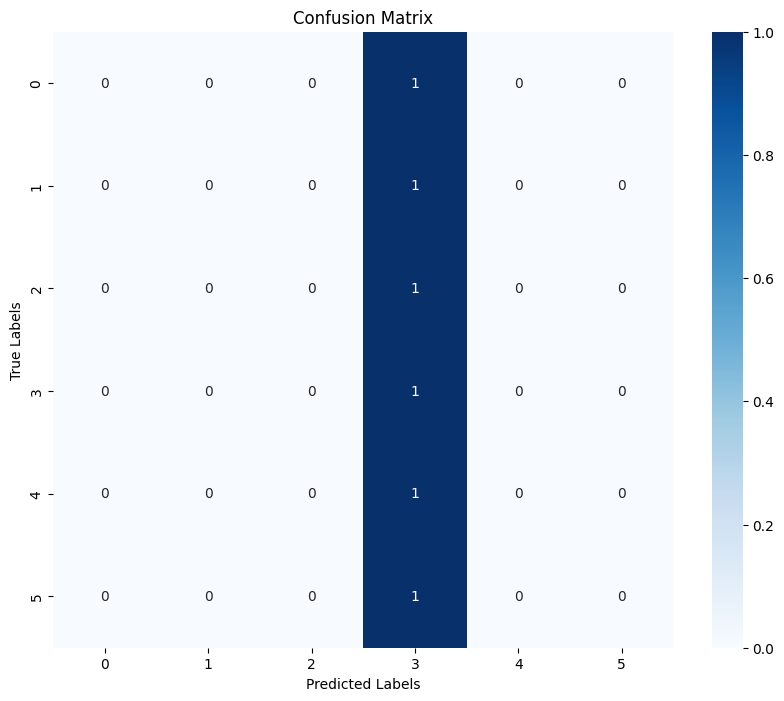

Epoch 8, Validation Loss: 1.8137, Accuracy: 0.2912, F1 Score: 0.1313
Val F1 Score Per Class  [0.         0.         0.         0.45100671 0.         0.        ]


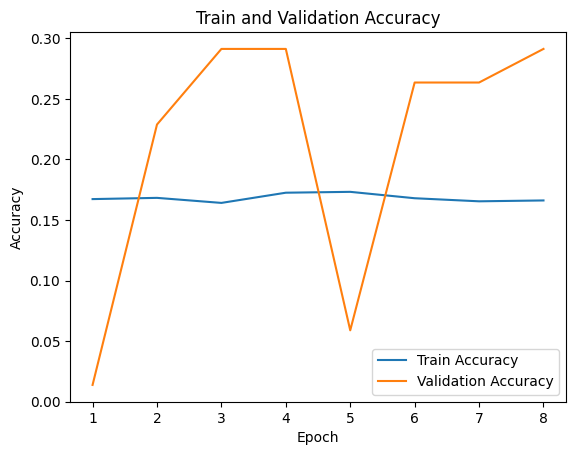

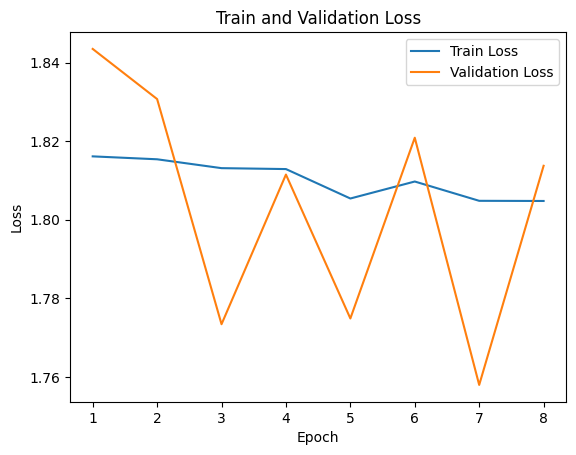

Epoch 9, Train Loss: 1.8018, Accuracy: 0.1636, F1 Score: 0.1604
Train F1 Score Per Class  [0.16373902 0.18389018 0.15299838 0.19410913 0.14473684 0.11881919]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.47it/s, loss=1.77]

[tensor([-0.0491, -0.0374,  0.0277,  0.0414, -0.0405,  0.0286], device='cuda:0'), tensor([-0.0492, -0.0420,  0.0280,  0.0413, -0.0392,  0.0269], device='cuda:0'), tensor([-0.0495, -0.0338,  0.0265,  0.0417, -0.0506,  0.0305], device='cuda:0'), tensor([-0.0494, -0.0384,  0.0271,  0.0415, -0.0464,  0.0288], device='cuda:0'), tensor([-0.0500, -0.0390,  0.0274,  0.0412, -0.0476,  0.0283], device='cuda:0'), tensor([-0.0498, -0.0379,  0.0274,  0.0417, -0.0439,  0.0290], device='cuda:0'), tensor([-0.0499, -0.0364,  0.0275,  0.0418, -0.0438,  0.0293], device='cuda:0'), tensor([-0.0488, -0.0398,  0.0277,  0.0414, -0.0413,  0.0279], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.46it/s, loss=1.78]

[tensor([-0.0495, -0.0405,  0.0277,  0.0412, -0.0407,  0.0274], device='cuda:0'), tensor([-0.0502, -0.0399,  0.0271,  0.0415, -0.0469,  0.0279], device='cuda:0'), tensor([-0.0500, -0.0349,  0.0268,  0.0418, -0.0496,  0.0299], device='cuda:0'), tensor([-0.0497, -0.0361,  0.0267,  0.0418, -0.0507,  0.0293], device='cuda:0'), tensor([-0.0507, -0.0353,  0.0264,  0.0425, -0.0544,  0.0303], device='cuda:0'), tensor([-0.0494, -0.0391,  0.0275,  0.0415, -0.0421,  0.0281], device='cuda:0'), tensor([-0.0501, -0.0370,  0.0273,  0.0421, -0.0453,  0.0291], device='cuda:0'), tensor([-0.0493, -0.0279,  0.0261,  0.0421, -0.0539,  0.0326], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.41it/s, loss=1.79]

[tensor([-0.0497, -0.0345,  0.0273,  0.0418, -0.0459,  0.0302], device='cuda:0'), tensor([-0.0499, -0.0427,  0.0274,  0.0414, -0.0447,  0.0267], device='cuda:0'), tensor([-0.0493, -0.0336,  0.0269,  0.0419, -0.0475,  0.0304], device='cuda:0'), tensor([-0.0497, -0.0389,  0.0275,  0.0414, -0.0446,  0.0286], device='cuda:0'), tensor([-0.0498, -0.0366,  0.0273,  0.0418, -0.0444,  0.0294], device='cuda:0'), tensor([-0.0494, -0.0374,  0.0270,  0.0421, -0.0473,  0.0291], device='cuda:0'), tensor([-0.0499, -0.0399,  0.0271,  0.0414, -0.0479,  0.0274], device='cuda:0'), tensor([-0.0497, -0.0369,  0.0272,  0.0415, -0.0469,  0.0291], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:30,  2.24it/s, loss=1.8]

[tensor([-0.0503, -0.0376,  0.0271,  0.0420, -0.0467,  0.0291], device='cuda:0'), tensor([-0.0496, -0.0398,  0.0269,  0.0416, -0.0482,  0.0278], device='cuda:0'), tensor([-0.0495, -0.0402,  0.0276,  0.0412, -0.0414,  0.0280], device='cuda:0'), tensor([-0.0494, -0.0381,  0.0275,  0.0411, -0.0444,  0.0283], device='cuda:0'), tensor([-0.0492, -0.0351,  0.0272,  0.0420, -0.0455,  0.0298], device='cuda:0'), tensor([-0.0497, -0.0349,  0.0276,  0.0414, -0.0437,  0.0300], device='cuda:0'), tensor([-0.0501, -0.0344,  0.0265,  0.0421, -0.0513,  0.0303], device='cuda:0'), tensor([-0.0496, -0.0340,  0.0272,  0.0418, -0.0466,  0.0304], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:29,  2.32it/s, loss=1.8]

[tensor([-0.0502, -0.0383,  0.0269,  0.0416, -0.0483,  0.0286], device='cuda:0'), tensor([-0.0495, -0.0425,  0.0275,  0.0409, -0.0425,  0.0272], device='cuda:0'), tensor([-0.0499, -0.0325,  0.0264,  0.0420, -0.0514,  0.0308], device='cuda:0'), tensor([-0.0498, -0.0406,  0.0274,  0.0417, -0.0444,  0.0278], device='cuda:0'), tensor([-0.0496, -0.0374,  0.0273,  0.0416, -0.0456,  0.0289], device='cuda:0'), tensor([-0.0496, -0.0382,  0.0275,  0.0419, -0.0450,  0.0289], device='cuda:0'), tensor([-0.0497, -0.0397,  0.0273,  0.0418, -0.0445,  0.0282], device='cuda:0'), tensor([-0.0499, -0.0353,  0.0270,  0.0418, -0.0460,  0.0298], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.32it/s, loss=1.77]

[tensor([-0.0499, -0.0350,  0.0273,  0.0420, -0.0462,  0.0302], device='cuda:0'), tensor([-0.0501, -0.0376,  0.0275,  0.0423, -0.0441,  0.0289], device='cuda:0'), tensor([-0.0485, -0.0352,  0.0274,  0.0412, -0.0447,  0.0296], device='cuda:0'), tensor([-0.0500, -0.0378,  0.0267,  0.0422, -0.0502,  0.0291], device='cuda:0'), tensor([-0.0495, -0.0368,  0.0271,  0.0416, -0.0445,  0.0292], device='cuda:0'), tensor([-0.0493, -0.0354,  0.0270,  0.0414, -0.0463,  0.0293], device='cuda:0'), tensor([-0.0493, -0.0401,  0.0265,  0.0414, -0.0511,  0.0277], device='cuda:0'), tensor([-0.0496, -0.0370,  0.0276,  0.0416, -0.0426,  0.0293], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.37it/s, loss=1.77]

[tensor([-0.0493, -0.0375,  0.0275,  0.0418, -0.0441,  0.0288], device='cuda:0'), tensor([-0.0497, -0.0380,  0.0265,  0.0417, -0.0519,  0.0287], device='cuda:0'), tensor([-0.0502, -0.0354,  0.0269,  0.0421, -0.0495,  0.0296], device='cuda:0'), tensor([-0.0495, -0.0360,  0.0268,  0.0415, -0.0493,  0.0294], device='cuda:0'), tensor([-0.0485, -0.0396,  0.0278,  0.0413, -0.0397,  0.0274], device='cuda:0'), tensor([-0.0497, -0.0382,  0.0275,  0.0414, -0.0429,  0.0286], device='cuda:0'), tensor([-0.0498, -0.0385,  0.0271,  0.0417, -0.0476,  0.0286], device='cuda:0'), tensor([-0.0492, -0.0429,  0.0279,  0.0413, -0.0418,  0.0266], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=1.8]

[tensor([-0.0493, -0.0396,  0.0264,  0.0418, -0.0508,  0.0281], device='cuda:0'), tensor([-0.0499, -0.0369,  0.0267,  0.0420, -0.0503,  0.0294], device='cuda:0'), tensor([-0.0494, -0.0384,  0.0278,  0.0418, -0.0407,  0.0286], device='cuda:0'), tensor([-0.0497, -0.0401,  0.0281,  0.0416, -0.0401,  0.0280], device='cuda:0'), tensor([-0.0488, -0.0411,  0.0272,  0.0413, -0.0441,  0.0271], device='cuda:0'), tensor([-0.0502, -0.0274,  0.0263,  0.0420, -0.0553,  0.0335], device='cuda:0'), tensor([-0.0493, -0.0390,  0.0272,  0.0418, -0.0466,  0.0284], device='cuda:0'), tensor([-0.0506, -0.0353,  0.0269,  0.0419, -0.0511,  0.0301], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.42it/s, loss=1.78]

[tensor([-0.0494, -0.0374,  0.0273,  0.0418, -0.0460,  0.0290], device='cuda:0'), tensor([-0.0503, -0.0355,  0.0270,  0.0416, -0.0493,  0.0297], device='cuda:0'), tensor([-0.0493, -0.0370,  0.0272,  0.0419, -0.0447,  0.0294], device='cuda:0'), tensor([-0.0493, -0.0326,  0.0267,  0.0420, -0.0489,  0.0310], device='cuda:0'), tensor([-0.0496, -0.0347,  0.0267,  0.0417, -0.0504,  0.0297], device='cuda:0'), tensor([-0.0499, -0.0334,  0.0268,  0.0421, -0.0494,  0.0309], device='cuda:0'), tensor([-0.0491, -0.0386,  0.0274,  0.0414, -0.0419,  0.0286], device='cuda:0'), tensor([-0.0499, -0.0358,  0.0272,  0.0419, -0.0458,  0.0300], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.44it/s, loss=1.78]

[tensor([-0.0494, -0.0371,  0.0272,  0.0415, -0.0450,  0.0289], device='cuda:0'), tensor([-0.0491, -0.0378,  0.0274,  0.0414, -0.0422,  0.0287], device='cuda:0'), tensor([-0.0494, -0.0407,  0.0274,  0.0416, -0.0423,  0.0276], device='cuda:0'), tensor([-0.0502, -0.0350,  0.0269,  0.0423, -0.0494,  0.0305], device='cuda:0'), tensor([-0.0495, -0.0379,  0.0275,  0.0414, -0.0431,  0.0283], device='cuda:0'), tensor([-0.0501, -0.0370,  0.0274,  0.0414, -0.0450,  0.0290], device='cuda:0'), tensor([-0.0494, -0.0357,  0.0269,  0.0424, -0.0487,  0.0299], device='cuda:0'), tensor([-0.0491, -0.0373,  0.0272,  0.0418, -0.0466,  0.0288], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.45it/s, loss=1.8]

[tensor([-0.0490, -0.0406,  0.0276,  0.0410, -0.0420,  0.0277], device='cuda:0'), tensor([-0.0496, -0.0336,  0.0271,  0.0415, -0.0478,  0.0307], device='cuda:0'), tensor([-0.0495, -0.0378,  0.0269,  0.0413, -0.0478,  0.0287], device='cuda:0'), tensor([-0.0494, -0.0454,  0.0276,  0.0415, -0.0428,  0.0258], device='cuda:0'), tensor([-0.0497, -0.0408,  0.0272,  0.0418, -0.0461,  0.0277], device='cuda:0'), tensor([-0.0496, -0.0368,  0.0275,  0.0416, -0.0429,  0.0289], device='cuda:0'), tensor([-0.0495, -0.0367,  0.0270,  0.0416, -0.0479,  0.0291], device='cuda:0'), tensor([-0.0494, -0.0334,  0.0270,  0.0420, -0.0460,  0.0305], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.46it/s, loss=1.79]

[tensor([-0.0493, -0.0331,  0.0269,  0.0419, -0.0470,  0.0306], device='cuda:0'), tensor([-0.0489, -0.0424,  0.0278,  0.0410, -0.0404,  0.0265], device='cuda:0'), tensor([-0.0494, -0.0342,  0.0268,  0.0416, -0.0480,  0.0303], device='cuda:0'), tensor([-0.0499, -0.0366,  0.0274,  0.0418, -0.0445,  0.0296], device='cuda:0'), tensor([-0.0488, -0.0390,  0.0273,  0.0413, -0.0437,  0.0282], device='cuda:0'), tensor([-0.0493, -0.0387,  0.0277,  0.0410, -0.0414,  0.0280], device='cuda:0'), tensor([-0.0496, -0.0388,  0.0277,  0.0418, -0.0419,  0.0285], device='cuda:0'), tensor([-0.0494, -0.0368,  0.0270,  0.0419, -0.0447,  0.0295], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.47it/s, loss=1.81]

[tensor([-0.0498, -0.0360,  0.0276,  0.0421, -0.0431,  0.0301], device='cuda:0'), tensor([-0.0497, -0.0363,  0.0273,  0.0418, -0.0457,  0.0292], device='cuda:0'), tensor([-0.0502, -0.0386,  0.0265,  0.0412, -0.0511,  0.0286], device='cuda:0'), tensor([-0.0495, -0.0380,  0.0271,  0.0419, -0.0461,  0.0288], device='cuda:0'), tensor([-0.0497, -0.0325,  0.0271,  0.0422, -0.0472,  0.0311], device='cuda:0'), tensor([-0.0503, -0.0316,  0.0264,  0.0419, -0.0509,  0.0317], device='cuda:0'), tensor([-0.0500, -0.0369,  0.0271,  0.0418, -0.0462,  0.0294], device='cuda:0'), tensor([-0.0499, -0.0364,  0.0269,  0.0419, -0.0482,  0.0299], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.44it/s, loss=1.79]

[tensor([-0.0494, -0.0412,  0.0279,  0.0414, -0.0397,  0.0274], device='cuda:0'), tensor([-0.0491, -0.0365,  0.0271,  0.0414, -0.0453,  0.0295], device='cuda:0'), tensor([-0.0501, -0.0374,  0.0275,  0.0419, -0.0451,  0.0293], device='cuda:0'), tensor([-0.0499, -0.0389,  0.0274,  0.0414, -0.0448,  0.0281], device='cuda:0'), tensor([-0.0495, -0.0381,  0.0272,  0.0411, -0.0465,  0.0286], device='cuda:0'), tensor([-0.0502, -0.0345,  0.0267,  0.0419, -0.0496,  0.0304], device='cuda:0'), tensor([-0.0491, -0.0380,  0.0273,  0.0414, -0.0443,  0.0284], device='cuda:0'), tensor([-0.0499, -0.0377,  0.0271,  0.0414, -0.0485,  0.0285], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.43it/s, loss=1.79]

[tensor([-0.0498, -0.0358,  0.0264,  0.0416, -0.0523,  0.0293], device='cuda:0'), tensor([-0.0496, -0.0372,  0.0266,  0.0413, -0.0509,  0.0289], device='cuda:0'), tensor([-0.0489, -0.0356,  0.0262,  0.0417, -0.0528,  0.0297], device='cuda:0'), tensor([-0.0485, -0.0367,  0.0273,  0.0413, -0.0456,  0.0290], device='cuda:0'), tensor([-0.0499, -0.0338,  0.0268,  0.0425, -0.0494,  0.0307], device='cuda:0'), tensor([-0.0493, -0.0390,  0.0275,  0.0415, -0.0418,  0.0281], device='cuda:0'), tensor([-0.0498, -0.0343,  0.0270,  0.0418, -0.0472,  0.0303], device='cuda:0'), tensor([-0.0496, -0.0378,  0.0270,  0.0412, -0.0482,  0.0285], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.43it/s, loss=1.79]

[tensor([-0.0486, -0.0363,  0.0266,  0.0408, -0.0490,  0.0287], device='cuda:0'), tensor([-0.0499, -0.0389,  0.0274,  0.0416, -0.0456,  0.0284], device='cuda:0'), tensor([-0.0497, -0.0355,  0.0272,  0.0419, -0.0461,  0.0300], device='cuda:0'), tensor([-0.0494, -0.0334,  0.0272,  0.0420, -0.0453,  0.0304], device='cuda:0'), tensor([-0.0496, -0.0369,  0.0272,  0.0417, -0.0476,  0.0291], device='cuda:0'), tensor([-0.0495, -0.0401,  0.0272,  0.0412, -0.0453,  0.0275], device='cuda:0'), tensor([-0.0494, -0.0396,  0.0272,  0.0416, -0.0450,  0.0282], device='cuda:0'), tensor([-0.0499, -0.0386,  0.0277,  0.0414, -0.0418,  0.0289], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.40it/s, loss=1.8]

[tensor([-0.0494, -0.0344,  0.0268,  0.0418, -0.0471,  0.0302], device='cuda:0'), tensor([-0.0498, -0.0375,  0.0274,  0.0416, -0.0445,  0.0289], device='cuda:0'), tensor([-0.0492, -0.0424,  0.0284,  0.0413, -0.0357,  0.0265], device='cuda:0'), tensor([-0.0501, -0.0425,  0.0280,  0.0416, -0.0412,  0.0266], device='cuda:0'), tensor([-0.0494, -0.0411,  0.0279,  0.0412, -0.0403,  0.0271], device='cuda:0'), tensor([-0.0493, -0.0355,  0.0269,  0.0418, -0.0480,  0.0296], device='cuda:0'), tensor([-0.0497, -0.0370,  0.0271,  0.0416, -0.0465,  0.0292], device='cuda:0'), tensor([-0.0503, -0.0335,  0.0269,  0.0415, -0.0485,  0.0307], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.42it/s, loss=1.8]

[tensor([-0.0496, -0.0375,  0.0266,  0.0419, -0.0496,  0.0292], device='cuda:0'), tensor([-0.0493, -0.0359,  0.0273,  0.0420, -0.0448,  0.0297], device='cuda:0'), tensor([-0.0493, -0.0356,  0.0274,  0.0417, -0.0445,  0.0294], device='cuda:0'), tensor([-0.0498, -0.0413,  0.0278,  0.0418, -0.0424,  0.0277], device='cuda:0'), tensor([-0.0497, -0.0370,  0.0275,  0.0421, -0.0439,  0.0294], device='cuda:0'), tensor([-0.0498, -0.0389,  0.0275,  0.0414, -0.0440,  0.0281], device='cuda:0'), tensor([-0.0497, -0.0362,  0.0265,  0.0423, -0.0505,  0.0299], device='cuda:0'), tensor([-0.0497, -0.0384,  0.0274,  0.0415, -0.0443,  0.0283], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.40it/s, loss=1.75]

[tensor([-0.0494, -0.0359,  0.0271,  0.0418, -0.0453,  0.0295], device='cuda:0'), tensor([-0.0495, -0.0369,  0.0277,  0.0423, -0.0425,  0.0293], device='cuda:0'), tensor([-0.0501, -0.0376,  0.0272,  0.0420, -0.0463,  0.0292], device='cuda:0'), tensor([-0.0489, -0.0393,  0.0274,  0.0408, -0.0412,  0.0280], device='cuda:0'), tensor([-0.0505, -0.0353,  0.0272,  0.0418, -0.0486,  0.0300], device='cuda:0'), tensor([-0.0493, -0.0368,  0.0277,  0.0418, -0.0419,  0.0293], device='cuda:0'), tensor([-0.0488, -0.0386,  0.0273,  0.0414, -0.0433,  0.0281], device='cuda:0'), tensor([-0.0498, -0.0375,  0.0278,  0.0419, -0.0425,  0.0290], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.39it/s, loss=1.77]

[tensor([-0.0496, -0.0372,  0.0272,  0.0418, -0.0465,  0.0292], device='cuda:0'), tensor([-0.0497, -0.0356,  0.0273,  0.0418, -0.0459,  0.0296], device='cuda:0'), tensor([-0.0493, -0.0371,  0.0270,  0.0420, -0.0471,  0.0291], device='cuda:0'), tensor([-0.0497, -0.0366,  0.0266,  0.0419, -0.0481,  0.0292], device='cuda:0'), tensor([-0.0494, -0.0317,  0.0265,  0.0422, -0.0500,  0.0310], device='cuda:0'), tensor([-0.0506, -0.0349,  0.0272,  0.0418, -0.0487,  0.0300], device='cuda:0'), tensor([-0.0498, -0.0376,  0.0265,  0.0418, -0.0507,  0.0290], device='cuda:0'), tensor([-0.0497, -0.0372,  0.0271,  0.0419, -0.0470,  0.0293], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.41it/s, loss=1.79]

[tensor([-0.0498, -0.0341,  0.0271,  0.0422, -0.0477,  0.0306], device='cuda:0'), tensor([-0.0503, -0.0329,  0.0270,  0.0423, -0.0471,  0.0309], device='cuda:0'), tensor([-0.0497, -0.0352,  0.0268,  0.0420, -0.0481,  0.0300], device='cuda:0'), tensor([-0.0498, -0.0359,  0.0274,  0.0419, -0.0446,  0.0295], device='cuda:0'), tensor([-0.0496, -0.0404,  0.0274,  0.0420, -0.0451,  0.0281], device='cuda:0'), tensor([-0.0494, -0.0430,  0.0281,  0.0415, -0.0385,  0.0267], device='cuda:0'), tensor([-0.0486, -0.0390,  0.0280,  0.0408, -0.0391,  0.0275], device='cuda:0'), tensor([-0.0502, -0.0369,  0.0271,  0.0421, -0.0480,  0.0292], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.41it/s, loss=1.8]

[tensor([-0.0488, -0.0416,  0.0274,  0.0413, -0.0425,  0.0267], device='cuda:0'), tensor([-0.0498, -0.0376,  0.0273,  0.0419, -0.0460,  0.0289], device='cuda:0'), tensor([-0.0494, -0.0367,  0.0273,  0.0420, -0.0458,  0.0295], device='cuda:0'), tensor([-0.0496, -0.0357,  0.0268,  0.0418, -0.0493,  0.0295], device='cuda:0'), tensor([-0.0493, -0.0378,  0.0272,  0.0420, -0.0447,  0.0288], device='cuda:0'), tensor([-0.0499, -0.0396,  0.0273,  0.0415, -0.0454,  0.0282], device='cuda:0'), tensor([-0.0489, -0.0362,  0.0275,  0.0417, -0.0436,  0.0294], device='cuda:0'), tensor([-0.0492, -0.0381,  0.0273,  0.0412, -0.0464,  0.0286], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.43it/s, loss=1.77]

[tensor([-0.0503, -0.0382,  0.0276,  0.0417, -0.0420,  0.0288], device='cuda:0'), tensor([-0.0497, -0.0330,  0.0267,  0.0421, -0.0488,  0.0308], device='cuda:0'), tensor([-0.0496, -0.0391,  0.0274,  0.0417, -0.0436,  0.0282], device='cuda:0'), tensor([-0.0496, -0.0403,  0.0270,  0.0414, -0.0474,  0.0280], device='cuda:0'), tensor([-0.0499, -0.0372,  0.0272,  0.0416, -0.0456,  0.0287], device='cuda:0'), tensor([-0.0496, -0.0351,  0.0270,  0.0417, -0.0476,  0.0299], device='cuda:0'), tensor([-0.0496, -0.0393,  0.0275,  0.0417, -0.0434,  0.0281], device='cuda:0'), tensor([-0.0500, -0.0389,  0.0272,  0.0413, -0.0450,  0.0282], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:20,  2.44it/s, loss=1.78]

[tensor([-0.0493, -0.0375,  0.0270,  0.0416, -0.0466,  0.0289], device='cuda:0'), tensor([-0.0490, -0.0366,  0.0269,  0.0411, -0.0484,  0.0290], device='cuda:0'), tensor([-0.0498, -0.0343,  0.0269,  0.0420, -0.0480,  0.0303], device='cuda:0'), tensor([-0.0491, -0.0383,  0.0273,  0.0417, -0.0441,  0.0285], device='cuda:0'), tensor([-0.0495, -0.0412,  0.0273,  0.0417, -0.0454,  0.0274], device='cuda:0'), tensor([-0.0499, -0.0366,  0.0270,  0.0417, -0.0494,  0.0298], device='cuda:0'), tensor([-0.0492, -0.0360,  0.0276,  0.0414, -0.0424,  0.0294], device='cuda:0'), tensor([-0.0499, -0.0366,  0.0267,  0.0418, -0.0500,  0.0294], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.42it/s, loss=1.77]

[tensor([-0.0496, -0.0416,  0.0278,  0.0416, -0.0425,  0.0275], device='cuda:0'), tensor([-0.0494, -0.0423,  0.0278,  0.0416, -0.0403,  0.0271], device='cuda:0'), tensor([-0.0505, -0.0386,  0.0269,  0.0419, -0.0488,  0.0286], device='cuda:0'), tensor([-0.0498, -0.0348,  0.0274,  0.0420, -0.0454,  0.0300], device='cuda:0'), tensor([-0.0493, -0.0372,  0.0274,  0.0419, -0.0455,  0.0294], device='cuda:0'), tensor([-0.0498, -0.0351,  0.0268,  0.0420, -0.0494,  0.0299], device='cuda:0'), tensor([-0.0497, -0.0412,  0.0277,  0.0414, -0.0422,  0.0275], device='cuda:0'), tensor([-0.0496, -0.0355,  0.0274,  0.0416, -0.0451,  0.0296], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.43it/s, loss=1.78]

[tensor([-0.0494, -0.0370,  0.0267,  0.0414, -0.0499,  0.0288], device='cuda:0'), tensor([-0.0495, -0.0400,  0.0273,  0.0419, -0.0458,  0.0279], device='cuda:0'), tensor([-0.0497, -0.0389,  0.0275,  0.0415, -0.0433,  0.0278], device='cuda:0'), tensor([-0.0498, -0.0362,  0.0270,  0.0424, -0.0470,  0.0297], device='cuda:0'), tensor([-0.0493, -0.0383,  0.0280,  0.0419, -0.0405,  0.0285], device='cuda:0'), tensor([-0.0499, -0.0358,  0.0275,  0.0418, -0.0436,  0.0297], device='cuda:0'), tensor([-0.0490, -0.0384,  0.0275,  0.0414, -0.0426,  0.0283], device='cuda:0'), tensor([-0.0497, -0.0331,  0.0264,  0.0424, -0.0508,  0.0309], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:18,  2.43it/s, loss=1.78]

[tensor([-0.0497, -0.0329,  0.0267,  0.0419, -0.0505,  0.0306], device='cuda:0'), tensor([-0.0496, -0.0345,  0.0265,  0.0417, -0.0510,  0.0303], device='cuda:0'), tensor([-0.0492, -0.0412,  0.0272,  0.0418, -0.0444,  0.0272], device='cuda:0'), tensor([-0.0494, -0.0419,  0.0267,  0.0413, -0.0494,  0.0271], device='cuda:0'), tensor([-0.0497, -0.0358,  0.0271,  0.0417, -0.0469,  0.0296], device='cuda:0'), tensor([-0.0495, -0.0314,  0.0267,  0.0422, -0.0493,  0.0315], device='cuda:0'), tensor([-0.0498, -0.0361,  0.0274,  0.0419, -0.0439,  0.0295], device='cuda:0'), tensor([-0.0494, -0.0367,  0.0275,  0.0418, -0.0430,  0.0292], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.45it/s, loss=1.78]

[tensor([-0.0496, -0.0414,  0.0271,  0.0416, -0.0449,  0.0272], device='cuda:0'), tensor([-0.0497, -0.0354,  0.0265,  0.0416, -0.0516,  0.0297], device='cuda:0'), tensor([-0.0494, -0.0323,  0.0260,  0.0420, -0.0541,  0.0307], device='cuda:0'), tensor([-0.0496, -0.0367,  0.0271,  0.0417, -0.0485,  0.0293], device='cuda:0'), tensor([-0.0496, -0.0339,  0.0272,  0.0417, -0.0462,  0.0305], device='cuda:0'), tensor([-0.0499, -0.0377,  0.0273,  0.0416, -0.0459,  0.0285], device='cuda:0'), tensor([-0.0491, -0.0400,  0.0274,  0.0415, -0.0442,  0.0279], device='cuda:0'), tensor([-0.0491, -0.0399,  0.0278,  0.0413, -0.0402,  0.0276], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:17,  2.45it/s, loss=1.81]

[tensor([-0.0505, -0.0363,  0.0272,  0.0415, -0.0449,  0.0293], device='cuda:0'), tensor([-0.0494, -0.0401,  0.0273,  0.0413, -0.0440,  0.0277], device='cuda:0'), tensor([-0.0498, -0.0376,  0.0268,  0.0420, -0.0491,  0.0293], device='cuda:0'), tensor([-0.0490, -0.0354,  0.0265,  0.0418, -0.0506,  0.0298], device='cuda:0'), tensor([-0.0493, -0.0423,  0.0271,  0.0413, -0.0462,  0.0271], device='cuda:0'), tensor([-0.0496, -0.0385,  0.0275,  0.0417, -0.0446,  0.0288], device='cuda:0'), tensor([-0.0498, -0.0342,  0.0271,  0.0418, -0.0465,  0.0301], device='cuda:0'), tensor([-0.0496, -0.0377,  0.0270,  0.0415, -0.0467,  0.0292], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.45it/s, loss=1.8]

[tensor([-0.0495, -0.0370,  0.0264,  0.0416, -0.0524,  0.0291], device='cuda:0'), tensor([-0.0495, -0.0405,  0.0278,  0.0415, -0.0416,  0.0277], device='cuda:0'), tensor([-0.0497, -0.0333,  0.0267,  0.0419, -0.0485,  0.0304], device='cuda:0'), tensor([-0.0497, -0.0405,  0.0276,  0.0415, -0.0430,  0.0275], device='cuda:0'), tensor([-0.0495, -0.0341,  0.0270,  0.0415, -0.0480,  0.0303], device='cuda:0'), tensor([-0.0495, -0.0404,  0.0276,  0.0417, -0.0428,  0.0278], device='cuda:0'), tensor([-0.0488, -0.0341,  0.0262,  0.0410, -0.0519,  0.0298], device='cuda:0'), tensor([-0.0496, -0.0390,  0.0273,  0.0416, -0.0446,  0.0285], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.46it/s, loss=1.77]

[tensor([-0.0504, -0.0361,  0.0269,  0.0419, -0.0470,  0.0298], device='cuda:0'), tensor([-0.0502, -0.0380,  0.0267,  0.0422, -0.0482,  0.0286], device='cuda:0'), tensor([-0.0499, -0.0398,  0.0273,  0.0418, -0.0447,  0.0281], device='cuda:0'), tensor([-0.0492, -0.0413,  0.0280,  0.0414, -0.0395,  0.0273], device='cuda:0'), tensor([-0.0495, -0.0323,  0.0268,  0.0422, -0.0489,  0.0314], device='cuda:0'), tensor([-0.0493, -0.0373,  0.0263,  0.0415, -0.0514,  0.0287], device='cuda:0'), tensor([-0.0497, -0.0350,  0.0273,  0.0414, -0.0454,  0.0296], device='cuda:0'), tensor([-0.0505, -0.0364,  0.0277,  0.0416, -0.0441,  0.0292], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.46it/s, loss=1.79]

[tensor([-0.0489, -0.0373,  0.0271,  0.0414, -0.0466,  0.0286], device='cuda:0'), tensor([-0.0490, -0.0385,  0.0263,  0.0416, -0.0496,  0.0285], device='cuda:0'), tensor([-0.0496, -0.0383,  0.0276,  0.0416, -0.0446,  0.0284], device='cuda:0'), tensor([-0.0495, -0.0383,  0.0274,  0.0412, -0.0435,  0.0282], device='cuda:0'), tensor([-0.0491, -0.0380,  0.0271,  0.0414, -0.0459,  0.0282], device='cuda:0'), tensor([-0.0496, -0.0366,  0.0272,  0.0414, -0.0462,  0.0292], device='cuda:0'), tensor([-0.0497, -0.0341,  0.0269,  0.0420, -0.0475,  0.0300], device='cuda:0'), tensor([-0.0499, -0.0383,  0.0273,  0.0415, -0.0466,  0.0288], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.46it/s, loss=1.77]

[tensor([-0.0490, -0.0356,  0.0268,  0.0415, -0.0486,  0.0297], device='cuda:0'), tensor([-0.0495, -0.0366,  0.0273,  0.0413, -0.0437,  0.0292], device='cuda:0'), tensor([-0.0498, -0.0383,  0.0273,  0.0411, -0.0437,  0.0286], device='cuda:0'), tensor([-0.0497, -0.0401,  0.0271,  0.0420, -0.0459,  0.0279], device='cuda:0'), tensor([-0.0498, -0.0384,  0.0274,  0.0417, -0.0448,  0.0285], device='cuda:0'), tensor([-0.0486, -0.0418,  0.0278,  0.0414, -0.0401,  0.0269], device='cuda:0'), tensor([-0.0502, -0.0350,  0.0264,  0.0425, -0.0509,  0.0302], device='cuda:0'), tensor([-0.0496, -0.0381,  0.0279,  0.0414, -0.0408,  0.0286], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:15,  2.45it/s, loss=1.78]

[tensor([-0.0496, -0.0400,  0.0279,  0.0417, -0.0410,  0.0278], device='cuda:0'), tensor([-0.0495, -0.0349,  0.0274,  0.0421, -0.0441,  0.0300], device='cuda:0'), tensor([-0.0489, -0.0374,  0.0277,  0.0414, -0.0410,  0.0289], device='cuda:0'), tensor([-0.0500, -0.0385,  0.0280,  0.0420, -0.0405,  0.0284], device='cuda:0'), tensor([-0.0498, -0.0380,  0.0269,  0.0417, -0.0483,  0.0289], device='cuda:0'), tensor([-0.0491, -0.0404,  0.0276,  0.0418, -0.0444,  0.0279], device='cuda:0'), tensor([-0.0504, -0.0360,  0.0268,  0.0414, -0.0490,  0.0292], device='cuda:0'), tensor([-0.0494, -0.0352,  0.0262,  0.0418, -0.0532,  0.0299], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.46it/s, loss=1.79]

[tensor([-0.0502, -0.0322,  0.0261,  0.0419, -0.0544,  0.0312], device='cuda:0'), tensor([-0.0503, -0.0385,  0.0270,  0.0418, -0.0489,  0.0286], device='cuda:0'), tensor([-0.0493, -0.0414,  0.0277,  0.0415, -0.0414,  0.0271], device='cuda:0'), tensor([-0.0500, -0.0365,  0.0268,  0.0418, -0.0495,  0.0296], device='cuda:0'), tensor([-0.0498, -0.0365,  0.0261,  0.0421, -0.0550,  0.0294], device='cuda:0'), tensor([-0.0496, -0.0376,  0.0273,  0.0416, -0.0435,  0.0287], device='cuda:0'), tensor([-0.0495, -0.0333,  0.0271,  0.0419, -0.0481,  0.0304], device='cuda:0'), tensor([-0.0493, -0.0380,  0.0279,  0.0414, -0.0415,  0.0287], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.44it/s, loss=1.77]

[tensor([-0.0493, -0.0364,  0.0267,  0.0417, -0.0498,  0.0290], device='cuda:0'), tensor([-0.0497, -0.0357,  0.0269,  0.0418, -0.0468,  0.0300], device='cuda:0'), tensor([-0.0489, -0.0458,  0.0277,  0.0410, -0.0414,  0.0256], device='cuda:0'), tensor([-0.0499, -0.0355,  0.0268,  0.0411, -0.0479,  0.0300], device='cuda:0'), tensor([-0.0497, -0.0376,  0.0273,  0.0415, -0.0453,  0.0287], device='cuda:0'), tensor([-0.0502, -0.0390,  0.0270,  0.0415, -0.0465,  0.0280], device='cuda:0'), tensor([-0.0502, -0.0391,  0.0280,  0.0419, -0.0414,  0.0283], device='cuda:0'), tensor([-0.0492, -0.0364,  0.0275,  0.0415, -0.0440,  0.0294], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.44it/s, loss=1.78]

[tensor([-0.0501, -0.0420,  0.0276,  0.0411, -0.0419,  0.0274], device='cuda:0'), tensor([-0.0495, -0.0370,  0.0268,  0.0417, -0.0488,  0.0291], device='cuda:0'), tensor([-0.0493, -0.0347,  0.0270,  0.0422, -0.0468,  0.0300], device='cuda:0'), tensor([-0.0494, -0.0349,  0.0274,  0.0419, -0.0451,  0.0300], device='cuda:0'), tensor([-0.0494, -0.0396,  0.0270,  0.0414, -0.0464,  0.0281], device='cuda:0'), tensor([-0.0491, -0.0388,  0.0276,  0.0412, -0.0414,  0.0281], device='cuda:0'), tensor([-0.0494, -0.0339,  0.0267,  0.0417, -0.0486,  0.0302], device='cuda:0'), tensor([-0.0500, -0.0363,  0.0275,  0.0418, -0.0440,  0.0293], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.44it/s, loss=1.78]

[tensor([-0.0499, -0.0393,  0.0271,  0.0412, -0.0468,  0.0282], device='cuda:0'), tensor([-0.0493, -0.0378,  0.0276,  0.0410, -0.0438,  0.0289], device='cuda:0'), tensor([-0.0497, -0.0391,  0.0279,  0.0414, -0.0414,  0.0283], device='cuda:0'), tensor([-0.0497, -0.0363,  0.0273,  0.0416, -0.0443,  0.0292], device='cuda:0'), tensor([-0.0503, -0.0315,  0.0266,  0.0419, -0.0517,  0.0314], device='cuda:0'), tensor([-0.0489, -0.0357,  0.0263,  0.0417, -0.0508,  0.0296], device='cuda:0'), tensor([-0.0492, -0.0358,  0.0270,  0.0417, -0.0473,  0.0292], device='cuda:0'), tensor([-0.0495, -0.0391,  0.0276,  0.0416, -0.0415,  0.0281], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:13,  2.44it/s, loss=1.78]

[tensor([-0.0490, -0.0354,  0.0268,  0.0424, -0.0487,  0.0299], device='cuda:0'), tensor([-0.0499, -0.0373,  0.0273,  0.0419, -0.0453,  0.0292], device='cuda:0'), tensor([-0.0493, -0.0371,  0.0272,  0.0414, -0.0460,  0.0288], device='cuda:0'), tensor([-0.0490, -0.0399,  0.0275,  0.0407, -0.0434,  0.0276], device='cuda:0'), tensor([-0.0499, -0.0350,  0.0266,  0.0418, -0.0489,  0.0297], device='cuda:0'), tensor([-0.0497, -0.0340,  0.0272,  0.0420, -0.0471,  0.0305], device='cuda:0'), tensor([-0.0495, -0.0373,  0.0275,  0.0418, -0.0441,  0.0289], device='cuda:0'), tensor([-0.0498, -0.0372,  0.0272,  0.0418, -0.0470,  0.0290], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.44it/s, loss=1.79]

[tensor([-0.0500, -0.0355,  0.0270,  0.0420, -0.0478,  0.0298], device='cuda:0'), tensor([-0.0492, -0.0365,  0.0277,  0.0415, -0.0426,  0.0290], device='cuda:0'), tensor([-0.0500, -0.0364,  0.0274,  0.0420, -0.0460,  0.0296], device='cuda:0'), tensor([-0.0497, -0.0375,  0.0263,  0.0413, -0.0521,  0.0287], device='cuda:0'), tensor([-0.0505, -0.0372,  0.0279,  0.0415, -0.0409,  0.0288], device='cuda:0'), tensor([-0.0497, -0.0320,  0.0266,  0.0424, -0.0506,  0.0310], device='cuda:0'), tensor([-0.0500, -0.0328,  0.0265,  0.0421, -0.0503,  0.0305], device='cuda:0'), tensor([-0.0503, -0.0384,  0.0267,  0.0416, -0.0493,  0.0285], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.42it/s, loss=1.78]

[tensor([-0.0500, -0.0362,  0.0272,  0.0416, -0.0450,  0.0297], device='cuda:0'), tensor([-0.0500, -0.0350,  0.0263,  0.0417, -0.0518,  0.0299], device='cuda:0'), tensor([-0.0491, -0.0375,  0.0270,  0.0415, -0.0462,  0.0287], device='cuda:0'), tensor([-0.0497, -0.0348,  0.0270,  0.0421, -0.0475,  0.0301], device='cuda:0'), tensor([-0.0492, -0.0365,  0.0260,  0.0419, -0.0525,  0.0295], device='cuda:0'), tensor([-0.0503, -0.0374,  0.0260,  0.0418, -0.0533,  0.0290], device='cuda:0'), tensor([-0.0494, -0.0351,  0.0270,  0.0419, -0.0479,  0.0299], device='cuda:0'), tensor([-0.0500, -0.0349,  0.0273,  0.0420, -0.0465,  0.0300], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.43it/s, loss=1.76]

[tensor([-0.0486, -0.0445,  0.0283,  0.0408, -0.0347,  0.0256], device='cuda:0'), tensor([-0.0498, -0.0393,  0.0280,  0.0417, -0.0404,  0.0283], device='cuda:0'), tensor([-0.0495, -0.0394,  0.0266,  0.0418, -0.0487,  0.0284], device='cuda:0'), tensor([-0.0497, -0.0368,  0.0269,  0.0424, -0.0487,  0.0295], device='cuda:0'), tensor([-0.0492, -0.0370,  0.0267,  0.0420, -0.0496,  0.0291], device='cuda:0'), tensor([-0.0494, -0.0371,  0.0276,  0.0419, -0.0424,  0.0290], device='cuda:0'), tensor([-0.0493, -0.0320,  0.0262,  0.0422, -0.0520,  0.0310], device='cuda:0'), tensor([-0.0503, -0.0375,  0.0271,  0.0417, -0.0482,  0.0289], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.43it/s, loss=1.77]

[tensor([-0.0498, -0.0382,  0.0280,  0.0423, -0.0402,  0.0287], device='cuda:0'), tensor([-0.0498, -0.0332,  0.0270,  0.0420, -0.0463,  0.0307], device='cuda:0'), tensor([-0.0499, -0.0367,  0.0274,  0.0415, -0.0457,  0.0290], device='cuda:0'), tensor([-0.0494, -0.0368,  0.0267,  0.0421, -0.0477,  0.0291], device='cuda:0'), tensor([-0.0493, -0.0371,  0.0274,  0.0415, -0.0456,  0.0290], device='cuda:0'), tensor([-0.0495, -0.0399,  0.0279,  0.0406, -0.0387,  0.0276], device='cuda:0'), tensor([-0.0493, -0.0409,  0.0279,  0.0412, -0.0397,  0.0275], device='cuda:0'), tensor([-0.0496, -0.0380,  0.0275,  0.0415, -0.0441,  0.0285], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:11,  2.44it/s, loss=1.78]

[tensor([-0.0489, -0.0406,  0.0277,  0.0416, -0.0418,  0.0275], device='cuda:0'), tensor([-0.0493, -0.0377,  0.0269,  0.0419, -0.0477,  0.0288], device='cuda:0'), tensor([-0.0495, -0.0356,  0.0275,  0.0417, -0.0443,  0.0295], device='cuda:0'), tensor([-0.0498, -0.0365,  0.0272,  0.0417, -0.0459,  0.0294], device='cuda:0'), tensor([-0.0494, -0.0347,  0.0273,  0.0419, -0.0455,  0.0301], device='cuda:0'), tensor([-0.0494, -0.0352,  0.0271,  0.0420, -0.0468,  0.0300], device='cuda:0'), tensor([-0.0494, -0.0367,  0.0276,  0.0414, -0.0412,  0.0290], device='cuda:0'), tensor([-0.0491, -0.0365,  0.0269,  0.0421, -0.0477,  0.0294], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.44it/s, loss=1.77]

[tensor([-0.0496, -0.0358,  0.0263,  0.0421, -0.0519,  0.0297], device='cuda:0'), tensor([-0.0498, -0.0367,  0.0274,  0.0421, -0.0448,  0.0295], device='cuda:0'), tensor([-0.0498, -0.0336,  0.0270,  0.0420, -0.0475,  0.0304], device='cuda:0'), tensor([-0.0495, -0.0370,  0.0272,  0.0414, -0.0448,  0.0290], device='cuda:0'), tensor([-0.0504, -0.0361,  0.0268,  0.0423, -0.0496,  0.0296], device='cuda:0'), tensor([-0.0493, -0.0408,  0.0268,  0.0412, -0.0475,  0.0275], device='cuda:0'), tensor([-0.0493, -0.0379,  0.0270,  0.0419, -0.0471,  0.0289], device='cuda:0'), tensor([-0.0499, -0.0300,  0.0267,  0.0420, -0.0505,  0.0318], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.45it/s, loss=1.76]

[tensor([-0.0491, -0.0386,  0.0271,  0.0410, -0.0452,  0.0278], device='cuda:0'), tensor([-0.0491, -0.0359,  0.0269,  0.0418, -0.0459,  0.0293], device='cuda:0'), tensor([-0.0502, -0.0390,  0.0265,  0.0414, -0.0513,  0.0280], device='cuda:0'), tensor([-0.0500, -0.0367,  0.0270,  0.0422, -0.0481,  0.0294], device='cuda:0'), tensor([-0.0498, -0.0373,  0.0266,  0.0419, -0.0490,  0.0290], device='cuda:0'), tensor([-0.0494, -0.0384,  0.0264,  0.0420, -0.0517,  0.0289], device='cuda:0'), tensor([-0.0491, -0.0407,  0.0282,  0.0413, -0.0393,  0.0276], device='cuda:0'), tensor([-0.0499, -0.0345,  0.0273,  0.0419, -0.0457,  0.0300], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.45it/s, loss=1.78]

[tensor([-0.0494, -0.0381,  0.0274,  0.0418, -0.0444,  0.0285], device='cuda:0'), tensor([-0.0494, -0.0362,  0.0276,  0.0419, -0.0425,  0.0296], device='cuda:0'), tensor([-0.0492, -0.0357,  0.0270,  0.0419, -0.0459,  0.0294], device='cuda:0'), tensor([-0.0496, -0.0387,  0.0277,  0.0416, -0.0425,  0.0285], device='cuda:0'), tensor([-0.0496, -0.0324,  0.0266,  0.0421, -0.0496,  0.0314], device='cuda:0'), tensor([-0.0497, -0.0364,  0.0274,  0.0416, -0.0451,  0.0292], device='cuda:0'), tensor([-0.0499, -0.0338,  0.0263,  0.0424, -0.0531,  0.0307], device='cuda:0'), tensor([-0.0493, -0.0353,  0.0273,  0.0415, -0.0442,  0.0297], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.45it/s, loss=1.76]

[tensor([-0.0500, -0.0380,  0.0275,  0.0416, -0.0431,  0.0288], device='cuda:0'), tensor([-0.0495, -0.0377,  0.0276,  0.0416, -0.0423,  0.0289], device='cuda:0'), tensor([-0.0498, -0.0344,  0.0270,  0.0422, -0.0478,  0.0304], device='cuda:0'), tensor([-0.0500, -0.0368,  0.0271,  0.0413, -0.0458,  0.0289], device='cuda:0'), tensor([-0.0496, -0.0344,  0.0267,  0.0420, -0.0499,  0.0301], device='cuda:0'), tensor([-0.0496, -0.0397,  0.0272,  0.0415, -0.0460,  0.0279], device='cuda:0'), tensor([-0.0498, -0.0392,  0.0273,  0.0416, -0.0443,  0.0283], device='cuda:0'), tensor([-0.0498, -0.0350,  0.0268,  0.0418, -0.0488,  0.0302], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.45it/s, loss=1.77]

[tensor([-0.0498, -0.0408,  0.0278,  0.0413, -0.0408,  0.0274], device='cuda:0'), tensor([-0.0504, -0.0370,  0.0274,  0.0419, -0.0446,  0.0294], device='cuda:0'), tensor([-0.0495, -0.0332,  0.0271,  0.0414, -0.0463,  0.0304], device='cuda:0'), tensor([-0.0499, -0.0375,  0.0273,  0.0419, -0.0451,  0.0292], device='cuda:0'), tensor([-0.0494, -0.0366,  0.0275,  0.0420, -0.0441,  0.0293], device='cuda:0'), tensor([-0.0495, -0.0338,  0.0266,  0.0420, -0.0498,  0.0305], device='cuda:0'), tensor([-0.0493, -0.0355,  0.0274,  0.0417, -0.0441,  0.0296], device='cuda:0'), tensor([-0.0494, -0.0368,  0.0273,  0.0417, -0.0442,  0.0293], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.45it/s, loss=1.79]

[tensor([-0.0498, -0.0390,  0.0279,  0.0418, -0.0407,  0.0283], device='cuda:0'), tensor([-0.0498, -0.0389,  0.0278,  0.0419, -0.0419,  0.0284], device='cuda:0'), tensor([-0.0495, -0.0389,  0.0277,  0.0418, -0.0437,  0.0282], device='cuda:0'), tensor([-0.0500, -0.0403,  0.0261,  0.0406, -0.0545,  0.0272], device='cuda:0'), tensor([-0.0497, -0.0425,  0.0284,  0.0418, -0.0385,  0.0270], device='cuda:0'), tensor([-0.0496, -0.0349,  0.0273,  0.0422, -0.0462,  0.0300], device='cuda:0'), tensor([-0.0498, -0.0341,  0.0269,  0.0419, -0.0477,  0.0303], device='cuda:0'), tensor([-0.0499, -0.0366,  0.0268,  0.0417, -0.0496,  0.0293], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:08,  2.45it/s, loss=1.79]

[tensor([-0.0497, -0.0346,  0.0273,  0.0420, -0.0449,  0.0298], device='cuda:0'), tensor([-0.0496, -0.0359,  0.0271,  0.0415, -0.0473,  0.0293], device='cuda:0'), tensor([-0.0495, -0.0337,  0.0261,  0.0423, -0.0526,  0.0307], device='cuda:0'), tensor([-0.0495, -0.0450,  0.0286,  0.0411, -0.0342,  0.0255], device='cuda:0'), tensor([-0.0498, -0.0361,  0.0272,  0.0420, -0.0459,  0.0296], device='cuda:0'), tensor([-0.0498, -0.0350,  0.0266,  0.0419, -0.0501,  0.0301], device='cuda:0'), tensor([-0.0506, -0.0352,  0.0263,  0.0414, -0.0531,  0.0295], device='cuda:0'), tensor([-0.0497, -0.0394,  0.0278,  0.0412, -0.0409,  0.0281], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.45it/s, loss=1.77]

[tensor([-0.0496, -0.0373,  0.0273,  0.0418, -0.0457,  0.0289], device='cuda:0'), tensor([-0.0499, -0.0360,  0.0265,  0.0418, -0.0512,  0.0293], device='cuda:0'), tensor([-0.0496, -0.0371,  0.0268,  0.0417, -0.0485,  0.0286], device='cuda:0'), tensor([-0.0499, -0.0348,  0.0269,  0.0416, -0.0480,  0.0301], device='cuda:0'), tensor([-0.0479, -0.0352,  0.0276,  0.0408, -0.0424,  0.0294], device='cuda:0'), tensor([-0.0502, -0.0362,  0.0264,  0.0420, -0.0499,  0.0300], device='cuda:0'), tensor([-0.0497, -0.0397,  0.0274,  0.0416, -0.0452,  0.0282], device='cuda:0'), tensor([-0.0497, -0.0358,  0.0272,  0.0420, -0.0465,  0.0298], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.45it/s, loss=1.81]

[tensor([-0.0495, -0.0363,  0.0272,  0.0414, -0.0465,  0.0295], device='cuda:0'), tensor([-0.0504, -0.0381,  0.0274,  0.0422, -0.0439,  0.0292], device='cuda:0'), tensor([-0.0494, -0.0390,  0.0277,  0.0418, -0.0421,  0.0283], device='cuda:0'), tensor([-0.0495, -0.0354,  0.0266,  0.0417, -0.0513,  0.0294], device='cuda:0'), tensor([-0.0496, -0.0370,  0.0273,  0.0418, -0.0465,  0.0294], device='cuda:0'), tensor([-0.0497, -0.0347,  0.0265,  0.0418, -0.0513,  0.0305], device='cuda:0'), tensor([-0.0495, -0.0345,  0.0268,  0.0420, -0.0491,  0.0303], device='cuda:0'), tensor([-0.0496, -0.0359,  0.0266,  0.0421, -0.0502,  0.0299], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.45it/s, loss=1.78]

[tensor([-0.0493, -0.0389,  0.0271,  0.0415, -0.0446,  0.0280], device='cuda:0'), tensor([-0.0496, -0.0363,  0.0267,  0.0418, -0.0502,  0.0295], device='cuda:0'), tensor([-0.0501, -0.0326,  0.0269,  0.0418, -0.0483,  0.0311], device='cuda:0'), tensor([-0.0497, -0.0366,  0.0272,  0.0418, -0.0462,  0.0296], device='cuda:0'), tensor([-0.0501, -0.0337,  0.0262,  0.0424, -0.0537,  0.0309], device='cuda:0'), tensor([-0.0492, -0.0395,  0.0279,  0.0413, -0.0409,  0.0278], device='cuda:0'), tensor([-0.0498, -0.0356,  0.0272,  0.0421, -0.0453,  0.0297], device='cuda:0'), tensor([-0.0496, -0.0391,  0.0274,  0.0417, -0.0455,  0.0280], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.44it/s, loss=1.78]

[tensor([-0.0502, -0.0386,  0.0269,  0.0414, -0.0488,  0.0281], device='cuda:0'), tensor([-0.0497, -0.0365,  0.0269,  0.0416, -0.0482,  0.0290], device='cuda:0'), tensor([-0.0495, -0.0381,  0.0278,  0.0418, -0.0409,  0.0286], device='cuda:0'), tensor([-0.0497, -0.0351,  0.0270,  0.0417, -0.0473,  0.0299], device='cuda:0'), tensor([-0.0498, -0.0378,  0.0277,  0.0417, -0.0423,  0.0289], device='cuda:0'), tensor([-0.0496, -0.0354,  0.0270,  0.0414, -0.0489,  0.0298], device='cuda:0'), tensor([-0.0494, -0.0387,  0.0276,  0.0413, -0.0415,  0.0281], device='cuda:0'), tensor([-0.0492, -0.0351,  0.0266,  0.0417, -0.0490,  0.0300], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:06,  2.44it/s, loss=1.75]

[tensor([-0.0502, -0.0343,  0.0266,  0.0418, -0.0499,  0.0302], device='cuda:0'), tensor([-0.0490, -0.0377,  0.0268,  0.0414, -0.0469,  0.0284], device='cuda:0'), tensor([-0.0496, -0.0359,  0.0272,  0.0422, -0.0457,  0.0297], device='cuda:0'), tensor([-0.0493, -0.0377,  0.0275,  0.0416, -0.0449,  0.0286], device='cuda:0'), tensor([-0.0494, -0.0379,  0.0274,  0.0417, -0.0431,  0.0286], device='cuda:0'), tensor([-0.0494, -0.0371,  0.0268,  0.0420, -0.0475,  0.0294], device='cuda:0'), tensor([-0.0488, -0.0394,  0.0270,  0.0414, -0.0470,  0.0281], device='cuda:0'), tensor([-0.0491, -0.0363,  0.0270,  0.0413, -0.0470,  0.0291], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.44it/s, loss=1.77]

[tensor([-0.0497, -0.0410,  0.0274,  0.0416, -0.0433,  0.0276], device='cuda:0'), tensor([-0.0489, -0.0385,  0.0278,  0.0415, -0.0404,  0.0282], device='cuda:0'), tensor([-0.0497, -0.0352,  0.0270,  0.0417, -0.0458,  0.0296], device='cuda:0'), tensor([-0.0494, -0.0395,  0.0274,  0.0416, -0.0423,  0.0282], device='cuda:0'), tensor([-0.0495, -0.0384,  0.0275,  0.0412, -0.0433,  0.0283], device='cuda:0'), tensor([-0.0495, -0.0412,  0.0274,  0.0414, -0.0449,  0.0271], device='cuda:0'), tensor([-0.0498, -0.0323,  0.0268,  0.0420, -0.0475,  0.0310], device='cuda:0'), tensor([-0.0498, -0.0380,  0.0271,  0.0419, -0.0475,  0.0289], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.45it/s, loss=1.76]

[tensor([-0.0494, -0.0393,  0.0271,  0.0416, -0.0459,  0.0282], device='cuda:0'), tensor([-0.0498, -0.0400,  0.0262,  0.0420, -0.0524,  0.0280], device='cuda:0'), tensor([-0.0494, -0.0383,  0.0273,  0.0416, -0.0436,  0.0284], device='cuda:0'), tensor([-0.0499, -0.0342,  0.0269,  0.0418, -0.0476,  0.0302], device='cuda:0'), tensor([-0.0493, -0.0384,  0.0277,  0.0418, -0.0420,  0.0283], device='cuda:0'), tensor([-0.0500, -0.0311,  0.0261,  0.0423, -0.0543,  0.0319], device='cuda:0'), tensor([-0.0493, -0.0372,  0.0268,  0.0412, -0.0483,  0.0288], device='cuda:0'), tensor([-0.0496, -0.0339,  0.0267,  0.0420, -0.0489,  0.0302], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.44it/s, loss=1.79]

[tensor([-0.0499, -0.0374,  0.0270,  0.0422, -0.0460,  0.0291], device='cuda:0'), tensor([-0.0496, -0.0383,  0.0279,  0.0414, -0.0417,  0.0288], device='cuda:0'), tensor([-0.0490, -0.0345,  0.0269,  0.0415, -0.0473,  0.0300], device='cuda:0'), tensor([-0.0485, -0.0383,  0.0274,  0.0414, -0.0424,  0.0282], device='cuda:0'), tensor([-0.0496, -0.0365,  0.0274,  0.0419, -0.0450,  0.0295], device='cuda:0'), tensor([-0.0490, -0.0387,  0.0275,  0.0415, -0.0435,  0.0283], device='cuda:0'), tensor([-0.0497, -0.0449,  0.0262,  0.0411, -0.0536,  0.0260], device='cuda:0'), tensor([-0.0498, -0.0389,  0.0275,  0.0414, -0.0424,  0.0278], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.43it/s, loss=1.77]

[tensor([-0.0493, -0.0394,  0.0276,  0.0418, -0.0418,  0.0282], device='cuda:0'), tensor([-0.0498, -0.0403,  0.0274,  0.0413, -0.0447,  0.0279], device='cuda:0'), tensor([-0.0495, -0.0357,  0.0270,  0.0421, -0.0482,  0.0297], device='cuda:0'), tensor([-0.0490, -0.0363,  0.0276,  0.0416, -0.0425,  0.0291], device='cuda:0'), tensor([-0.0496, -0.0382,  0.0271,  0.0418, -0.0459,  0.0288], device='cuda:0'), tensor([-0.0495, -0.0398,  0.0279,  0.0416, -0.0401,  0.0275], device='cuda:0'), tensor([-0.0490, -0.0364,  0.0267,  0.0416, -0.0480,  0.0291], device='cuda:0'), tensor([-0.0498, -0.0407,  0.0269,  0.0415, -0.0478,  0.0278], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.40it/s, loss=1.79]

[tensor([-0.0490, -0.0353,  0.0272,  0.0416, -0.0451,  0.0296], device='cuda:0'), tensor([-0.0492, -0.0372,  0.0272,  0.0415, -0.0454,  0.0288], device='cuda:0'), tensor([-0.0496, -0.0377,  0.0274,  0.0421, -0.0443,  0.0291], device='cuda:0'), tensor([-0.0496, -0.0347,  0.0271,  0.0419, -0.0462,  0.0298], device='cuda:0'), tensor([-0.0497, -0.0380,  0.0269,  0.0417, -0.0484,  0.0286], device='cuda:0'), tensor([-0.0500, -0.0355,  0.0263,  0.0423, -0.0501,  0.0300], device='cuda:0'), tensor([-0.0502, -0.0359,  0.0267,  0.0419, -0.0503,  0.0297], device='cuda:0'), tensor([-0.0500, -0.0363,  0.0271,  0.0415, -0.0475,  0.0296], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.39it/s, loss=1.81]

[tensor([-0.0490, -0.0440,  0.0274,  0.0410, -0.0426,  0.0258], device='cuda:0'), tensor([-0.0490, -0.0436,  0.0270,  0.0412, -0.0448,  0.0260], device='cuda:0'), tensor([-0.0496, -0.0347,  0.0263,  0.0414, -0.0518,  0.0302], device='cuda:0'), tensor([-0.0494, -0.0378,  0.0272,  0.0413, -0.0463,  0.0287], device='cuda:0'), tensor([-0.0491, -0.0373,  0.0271,  0.0415, -0.0464,  0.0291], device='cuda:0'), tensor([-0.0499, -0.0405,  0.0274,  0.0416, -0.0440,  0.0278], device='cuda:0'), tensor([-0.0491, -0.0367,  0.0269,  0.0410, -0.0485,  0.0289], device='cuda:0'), tensor([-0.0497, -0.0429,  0.0278,  0.0413, -0.0417,  0.0269], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.39it/s, loss=1.76]

[tensor([-0.0495, -0.0409,  0.0281,  0.0416, -0.0393,  0.0276], device='cuda:0'), tensor([-0.0483, -0.0419,  0.0285,  0.0410, -0.0348,  0.0269], device='cuda:0'), tensor([-0.0490, -0.0402,  0.0280,  0.0416, -0.0392,  0.0279], device='cuda:0'), tensor([-0.0495, -0.0377,  0.0276,  0.0419, -0.0434,  0.0289], device='cuda:0'), tensor([-0.0501, -0.0361,  0.0275,  0.0418, -0.0453,  0.0293], device='cuda:0'), tensor([-0.0499, -0.0361,  0.0275,  0.0420, -0.0438,  0.0297], device='cuda:0'), tensor([-0.0497, -0.0276,  0.0260,  0.0423, -0.0552,  0.0332], device='cuda:0'), tensor([-0.0501, -0.0370,  0.0276,  0.0418, -0.0423,  0.0295], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.41it/s, loss=1.78]

[tensor([-0.0497, -0.0385,  0.0272,  0.0419, -0.0450,  0.0286], device='cuda:0'), tensor([-0.0495, -0.0352,  0.0268,  0.0413, -0.0473,  0.0299], device='cuda:0'), tensor([-0.0488, -0.0375,  0.0272,  0.0413, -0.0418,  0.0284], device='cuda:0'), tensor([-0.0492, -0.0404,  0.0276,  0.0409, -0.0421,  0.0275], device='cuda:0'), tensor([-0.0502, -0.0382,  0.0276,  0.0416, -0.0436,  0.0287], device='cuda:0'), tensor([-0.0499, -0.0358,  0.0269,  0.0422, -0.0487,  0.0298], device='cuda:0'), tensor([-0.0501, -0.0355,  0.0269,  0.0419, -0.0483,  0.0302], device='cuda:0'), tensor([-0.0503, -0.0378,  0.0267,  0.0417, -0.0492,  0.0287], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.42it/s, loss=1.78]

[tensor([-0.0494, -0.0379,  0.0279,  0.0413, -0.0402,  0.0286], device='cuda:0'), tensor([-0.0498, -0.0366,  0.0275,  0.0418, -0.0440,  0.0295], device='cuda:0'), tensor([-0.0492, -0.0350,  0.0269,  0.0418, -0.0474,  0.0300], device='cuda:0'), tensor([-0.0491, -0.0372,  0.0272,  0.0418, -0.0453,  0.0290], device='cuda:0'), tensor([-0.0505, -0.0288,  0.0259,  0.0422, -0.0556,  0.0326], device='cuda:0'), tensor([-0.0498, -0.0341,  0.0274,  0.0418, -0.0446,  0.0305], device='cuda:0'), tensor([-0.0490, -0.0364,  0.0274,  0.0417, -0.0438,  0.0290], device='cuda:0'), tensor([-0.0497, -0.0388,  0.0262,  0.0419, -0.0537,  0.0287], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=1.78]

[tensor([-0.0488, -0.0347,  0.0265,  0.0418, -0.0491,  0.0296], device='cuda:0'), tensor([-0.0493, -0.0403,  0.0277,  0.0415, -0.0427,  0.0278], device='cuda:0'), tensor([-0.0496, -0.0351,  0.0272,  0.0418, -0.0456,  0.0295], device='cuda:0'), tensor([-0.0492, -0.0366,  0.0275,  0.0413, -0.0427,  0.0290], device='cuda:0'), tensor([-0.0493, -0.0352,  0.0269,  0.0416, -0.0479,  0.0298], device='cuda:0'), tensor([-0.0497, -0.0347,  0.0270,  0.0415, -0.0479,  0.0301], device='cuda:0'), tensor([-0.0496, -0.0333,  0.0266,  0.0418, -0.0505,  0.0310], device='cuda:0'), tensor([-0.0502, -0.0390,  0.0270,  0.0417, -0.0476,  0.0284], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.39it/s, loss=1.79]

[tensor([-0.0494, -0.0362,  0.0271,  0.0417, -0.0452,  0.0290], device='cuda:0'), tensor([-0.0499, -0.0367,  0.0274,  0.0418, -0.0447,  0.0292], device='cuda:0'), tensor([-0.0488, -0.0409,  0.0281,  0.0411, -0.0372,  0.0271], device='cuda:0'), tensor([-0.0499, -0.0374,  0.0276,  0.0418, -0.0424,  0.0291], device='cuda:0'), tensor([-0.0497, -0.0370,  0.0267,  0.0420, -0.0504,  0.0294], device='cuda:0'), tensor([-0.0496, -0.0352,  0.0267,  0.0419, -0.0496,  0.0295], device='cuda:0'), tensor([-0.0503, -0.0351,  0.0267,  0.0419, -0.0506,  0.0300], device='cuda:0'), tensor([-0.0500, -0.0328,  0.0270,  0.0417, -0.0474,  0.0306], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.40it/s, loss=1.77]

[tensor([-0.0500, -0.0411,  0.0273,  0.0418, -0.0457,  0.0275], device='cuda:0'), tensor([-0.0499, -0.0350,  0.0272,  0.0416, -0.0462,  0.0301], device='cuda:0'), tensor([-0.0499, -0.0335,  0.0265,  0.0418, -0.0508,  0.0304], device='cuda:0'), tensor([-0.0496, -0.0362,  0.0269,  0.0417, -0.0466,  0.0296], device='cuda:0'), tensor([-0.0495, -0.0387,  0.0275,  0.0420, -0.0438,  0.0288], device='cuda:0'), tensor([-0.0489, -0.0370,  0.0267,  0.0411, -0.0487,  0.0284], device='cuda:0'), tensor([-0.0495, -0.0371,  0.0278,  0.0419, -0.0421,  0.0293], device='cuda:0'), tensor([-0.0501, -0.0364,  0.0274,  0.0421, -0.0462,  0.0298], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.41it/s, loss=1.81]

[tensor([-0.0493, -0.0376,  0.0276,  0.0421, -0.0448,  0.0289], device='cuda:0'), tensor([-0.0486, -0.0420,  0.0272,  0.0408, -0.0434,  0.0271], device='cuda:0'), tensor([-0.0504, -0.0345,  0.0268,  0.0419, -0.0484,  0.0302], device='cuda:0'), tensor([-0.0500, -0.0376,  0.0271,  0.0414, -0.0467,  0.0287], device='cuda:0'), tensor([-0.0498, -0.0379,  0.0279,  0.0417, -0.0403,  0.0286], device='cuda:0'), tensor([-0.0497, -0.0364,  0.0272,  0.0411, -0.0477,  0.0290], device='cuda:0'), tensor([-0.0494, -0.0363,  0.0268,  0.0419, -0.0466,  0.0294], device='cuda:0'), tensor([-0.0487, -0.0391,  0.0277,  0.0411, -0.0412,  0.0277], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.40it/s, loss=1.77]

[tensor([-0.0499, -0.0382,  0.0270,  0.0412, -0.0484,  0.0283], device='cuda:0'), tensor([-0.0494, -0.0362,  0.0272,  0.0416, -0.0443,  0.0291], device='cuda:0'), tensor([-0.0496, -0.0380,  0.0272,  0.0413, -0.0453,  0.0286], device='cuda:0'), tensor([-0.0496, -0.0335,  0.0270,  0.0415, -0.0484,  0.0300], device='cuda:0'), tensor([-0.0495, -0.0402,  0.0272,  0.0415, -0.0448,  0.0276], device='cuda:0'), tensor([-0.0488, -0.0408,  0.0282,  0.0414, -0.0383,  0.0273], device='cuda:0'), tensor([-0.0499, -0.0343,  0.0275,  0.0420, -0.0448,  0.0303], device='cuda:0'), tensor([-0.0494, -0.0387,  0.0272,  0.0415, -0.0440,  0.0283], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.43it/s, loss=1.8]

[tensor([-0.0496, -0.0374,  0.0268,  0.0422, -0.0472,  0.0291], device='cuda:0'), tensor([-0.0496, -0.0365,  0.0272,  0.0420, -0.0451,  0.0294], device='cuda:0'), tensor([-0.0498, -0.0362,  0.0268,  0.0421, -0.0480,  0.0294], device='cuda:0'), tensor([-0.0498, -0.0384,  0.0277,  0.0419, -0.0421,  0.0286], device='cuda:0'), tensor([-0.0488, -0.0344,  0.0270,  0.0415, -0.0452,  0.0298], device='cuda:0'), tensor([-0.0493, -0.0366,  0.0269,  0.0420, -0.0468,  0.0294], device='cuda:0'), tensor([-0.0496, -0.0412,  0.0277,  0.0418, -0.0433,  0.0273], device='cuda:0'), tensor([-0.0487, -0.0345,  0.0271,  0.0416, -0.0460,  0.0300], device='cuda:0')]


[tensor([-0.0493, -0.0329,  0.0266,  0.0422, -0.0504,  0.0306], device='cuda:0'), tensor([-0.0489, -0.0398,  0.0276,  0.0411, -0.0410,  0.0280], device='cuda:0'), tensor([-0.0489, -0.0394,  0.0275,  0.0416, -0.0425,  0.0278], device='cuda:0'), tensor([-0.0494, -0.0354,  0.0272,  0.0413, -0.0453,  0.0295], device='cuda:0'), tensor([-0.0497, -0.0347,  0.0271,  0.0419, -0.0464,  0.0303], device='cuda:0'), tensor([-0.0494, -0.0328,  0.0269,  0.0413, -0.0479,  0.0302], device='cuda:0'), tensor([-0.0489, -0.0385,  0.0279,  0.0415, -0.0390,  0.0285], device='cuda:0'), tensor([-0.0499, -0.0350,  0.0269,  0.0418, -0.0469,  0.0300], device='cuda:0')]
[tensor([-0.0494, -0.0373,  0.0271,  0.0417, -0.0455,  0.0291], device='cuda:0')]


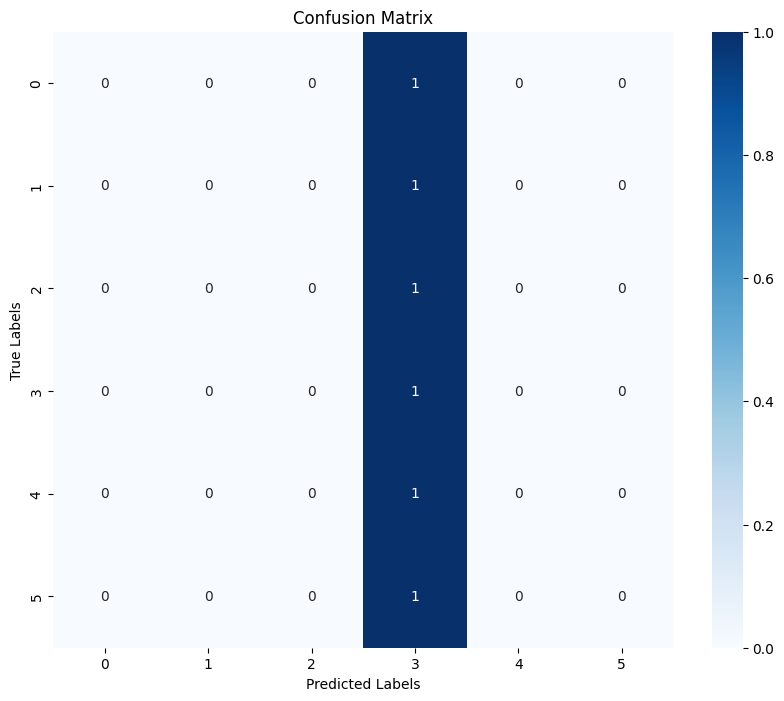

Epoch 9, Validation Loss: 1.7826, Accuracy: 0.2912, F1 Score: 0.1313
Val F1 Score Per Class  [0.         0.         0.         0.45100671 0.         0.        ]


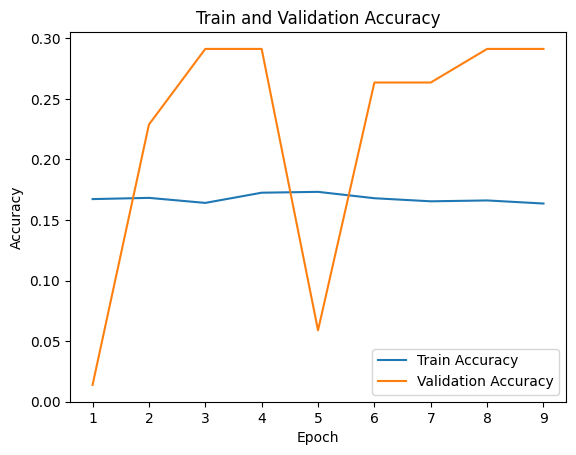

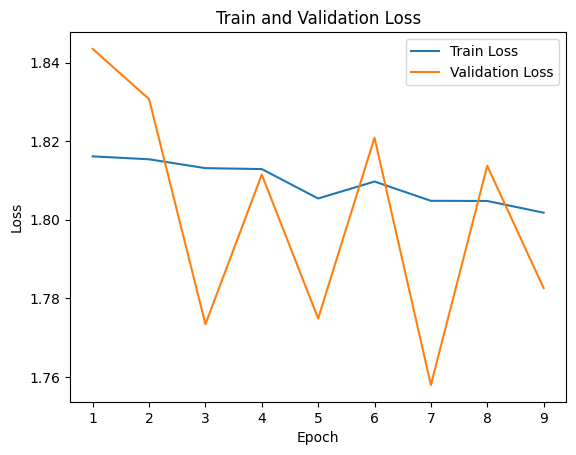

Epoch 10, Train Loss: 1.7975, Accuracy: 0.1755, F1 Score: 0.1687
Train F1 Score Per Class  [0.14614344 0.13422819 0.17865707 0.2243705  0.21122112 0.11451292]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.54it/s, loss=1.8]

[tensor([-0.1080, -0.0396,  0.0019, -0.0806, -0.0871,  0.0693], device='cuda:0'), tensor([-0.1002, -0.0278,  0.0075, -0.0579, -0.0328,  0.0876], device='cuda:0'), tensor([-0.0846, -0.0115,  0.0209, -0.0252, -0.0676,  0.1052], device='cuda:0'), tensor([-0.0966, -0.0249,  0.0114, -0.0538, -0.0197,  0.0867], device='cuda:0'), tensor([-0.1011, -0.0319,  0.0067, -0.0544, -0.1356,  0.0843], device='cuda:0'), tensor([-0.0975, -0.0289,  0.0111, -0.0590, -0.1668,  0.0804], device='cuda:0'), tensor([-0.1046, -0.0315,  0.0081, -0.0686, -0.0623,  0.0786], device='cuda:0'), tensor([-0.1223, -0.0513, -0.0066, -0.1078,  0.0010,  0.0547], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.52it/s, loss=1.81]

[tensor([-0.1130, -0.0489, -0.0004, -0.0941,  0.0758,  0.0541], device='cuda:0'), tensor([-0.0984, -0.0317,  0.0071, -0.0591,  0.0452,  0.0803], device='cuda:0'), tensor([-0.0671, -0.0076,  0.0220,  0.0079, -0.1852,  0.1143], device='cuda:0'), tensor([-0.0888, -0.0129,  0.0181, -0.0323, -0.1223,  0.1035], device='cuda:0'), tensor([-0.0799, -0.0116,  0.0186, -0.0177, -0.0713,  0.1116], device='cuda:0'), tensor([-0.1284, -0.0571, -0.0075, -0.1225,  0.0286,  0.0420], device='cuda:0'), tensor([-0.0965, -0.0294,  0.0056, -0.0544, -0.0494,  0.0917], device='cuda:0'), tensor([-0.1061, -0.0314,  0.0048, -0.0697,  0.0459,  0.0809], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.43it/s, loss=1.78]

[tensor([-0.1162, -0.0455, -0.0020, -0.0945,  0.0283,  0.0610], device='cuda:0'), tensor([-0.0973, -0.0217,  0.0126, -0.0461, -0.0946,  0.0959], device='cuda:0'), tensor([-0.0843, -0.0095,  0.0196, -0.0225, -0.1413,  0.1111], device='cuda:0'), tensor([-0.0812, -0.0074,  0.0243, -0.0183, -0.0964,  0.1098], device='cuda:0'), tensor([-0.1041, -0.0345,  0.0057, -0.0672, -0.2978,  0.0755], device='cuda:0'), tensor([-0.0808, -0.0087,  0.0223, -0.0195, -0.0617,  0.1080], device='cuda:0'), tensor([-0.1163, -0.0516, -0.0051, -0.1003,  0.1655,  0.0537], device='cuda:0'), tensor([-0.0873, -0.0135,  0.0172, -0.0283, -0.1664,  0.1032], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.42it/s, loss=1.81]

[tensor([-0.1191, -0.0466, -0.0022, -0.1005, -0.1319,  0.0576], device='cuda:0'), tensor([-0.1205, -0.0508, -0.0049, -0.1052,  0.0651,  0.0552], device='cuda:0'), tensor([-0.0984, -0.0280,  0.0092, -0.0597, -0.0280,  0.0821], device='cuda:0'), tensor([-0.0979, -0.0299,  0.0083, -0.0597,  0.0537,  0.0854], device='cuda:0'), tensor([-0.0957, -0.0301,  0.0099, -0.0543, -0.0684,  0.0830], device='cuda:0'), tensor([-0.0848, -0.0174,  0.0174, -0.0294, -0.1532,  0.1006], device='cuda:0'), tensor([-0.0527,  0.0177,  0.0370,  0.0422, -0.4133,  0.1485], device='cuda:0'), tensor([-0.1125, -0.0395,  0.0016, -0.0828, -0.1096,  0.0706], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.44it/s, loss=1.83]

[tensor([-0.0882, -0.0215,  0.0134, -0.0380, -0.0584,  0.0956], device='cuda:0'), tensor([-0.0942, -0.0229,  0.0084, -0.0444, -0.1206,  0.0996], device='cuda:0'), tensor([-0.1019, -0.0270,  0.0081, -0.0578, -0.0721,  0.0872], device='cuda:0'), tensor([-0.0817, -0.0109,  0.0201, -0.0219, -0.1537,  0.1081], device='cuda:0'), tensor([-0.1004, -0.0263,  0.0102, -0.0563, -0.0011,  0.0879], device='cuda:0'), tensor([-0.1113, -0.0397,  0.0033, -0.0836, -0.0452,  0.0666], device='cuda:0'), tensor([-0.1159, -0.0476, -0.0031, -0.0975,  0.1138,  0.0575], device='cuda:0'), tensor([-0.1101, -0.0419,  0.0004, -0.0823, -0.1121,  0.0677], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.42it/s, loss=1.8]

[tensor([-0.1083, -0.0345,  0.0066, -0.0740, -0.0717,  0.0741], device='cuda:0'), tensor([-0.0914, -0.0233,  0.0145, -0.0405, -0.1139,  0.0920], device='cuda:0'), tensor([-0.0932, -0.0214,  0.0097, -0.0413, -0.0352,  0.1009], device='cuda:0'), tensor([-0.1131, -0.0430, -0.0010, -0.0885, -0.0351,  0.0669], device='cuda:0'), tensor([-0.0833, -0.0175,  0.0160, -0.0290, -0.1056,  0.1030], device='cuda:0'), tensor([-0.0934, -0.0233,  0.0148, -0.0489, -0.0676,  0.0872], device='cuda:0'), tensor([-0.1092, -0.0416,  0.0023, -0.0854, -0.0076,  0.0639], device='cuda:0'), tensor([-0.1200, -0.0474, -0.0031, -0.0998, -0.1715,  0.0601], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.44it/s, loss=1.8]

[tensor([-0.0859, -0.0180,  0.0174, -0.0322, -0.1839,  0.0956], device='cuda:0'), tensor([-0.0837, -0.0150,  0.0186, -0.0242, -0.2773,  0.1060], device='cuda:0'), tensor([-0.0737, -0.0043,  0.0268, -0.0066, -0.2345,  0.1140], device='cuda:0'), tensor([-0.1049, -0.0413,  0.0007, -0.0772,  0.1080,  0.0679], device='cuda:0'), tensor([-0.1182, -0.0522, -0.0023, -0.1072, -0.0509,  0.0429], device='cuda:0'), tensor([-0.1026, -0.0374,  0.0025, -0.0692,  0.0376,  0.0774], device='cuda:0'), tensor([-0.0882, -0.0196,  0.0166, -0.0378, -0.0935,  0.0942], device='cuda:0'), tensor([-0.1269, -0.0596, -0.0105, -0.1236, -0.0614,  0.0409], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.44it/s, loss=1.77]

[tensor([-0.0963, -0.0222,  0.0116, -0.0483, -0.0301,  0.0931], device='cuda:0'), tensor([-0.0998, -0.0271,  0.0092, -0.0552, -0.3688,  0.0894], device='cuda:0'), tensor([-0.1236, -0.0534, -0.0066, -0.1116, -0.0719,  0.0486], device='cuda:0'), tensor([-0.1011, -0.0283,  0.0080, -0.0557, -0.0005,  0.0882], device='cuda:0'), tensor([-0.1054, -0.0365,  0.0046, -0.0746, -0.0854,  0.0741], device='cuda:0'), tensor([-0.0752, -0.0027,  0.0213, -0.0045, -0.2715,  0.1249], device='cuda:0'), tensor([-0.0975, -0.0235,  0.0116, -0.0511, -0.1747,  0.0901], device='cuda:0'), tensor([-0.0798, -0.0182,  0.0185, -0.0275, -0.2828,  0.0903], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.45it/s, loss=1.81]

[tensor([-0.1129, -0.0419,  0.0013, -0.0887, -0.0841,  0.0630], device='cuda:0'), tensor([-0.0896, -0.0166,  0.0140, -0.0328, -0.1297,  0.1007], device='cuda:0'), tensor([-0.1134, -0.0414,  0.0025, -0.0871, -0.0899,  0.0652], device='cuda:0'), tensor([-0.0970, -0.0292,  0.0095, -0.0561, -0.0714,  0.0844], device='cuda:0'), tensor([-0.1084, -0.0321,  0.0073, -0.0726, -0.0342,  0.0770], device='cuda:0'), tensor([-0.1105, -0.0395,  0.0047, -0.0817, -0.0289,  0.0684], device='cuda:0'), tensor([-0.1019, -0.0292,  0.0096, -0.0645,  0.0063,  0.0794], device='cuda:0'), tensor([-0.0997, -0.0317,  0.0052, -0.0607, -0.1219,  0.0844], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.43it/s, loss=1.77]

[tensor([-0.0880, -0.0169,  0.0172, -0.0342, -0.0181,  0.0994], device='cuda:0'), tensor([-0.0802, -0.0107,  0.0218, -0.0176, -0.2051,  0.1093], device='cuda:0'), tensor([-0.0999, -0.0331,  0.0062, -0.0652,  0.0241,  0.0815], device='cuda:0'), tensor([-0.1036, -0.0291,  0.0084, -0.0632, -0.1464,  0.0837], device='cuda:0'), tensor([-0.1104, -0.0402,  0.0026, -0.0848, -0.0367,  0.0671], device='cuda:0'), tensor([-0.1114, -0.0365,  0.0035, -0.0805, -0.0478,  0.0723], device='cuda:0'), tensor([-0.0929, -0.0249,  0.0091, -0.0464, -0.2213,  0.0940], device='cuda:0'), tensor([-0.0981, -0.0228,  0.0121, -0.0492, -0.0619,  0.0927], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.44it/s, loss=1.83]

[tensor([-0.1063, -0.0385,  0.0036, -0.0749,  0.0711,  0.0703], device='cuda:0'), tensor([-0.0900, -0.0215,  0.0107, -0.0410, -0.1598,  0.0991], device='cuda:0'), tensor([-0.1140, -0.0465, -0.0017, -0.0935,  0.0375,  0.0590], device='cuda:0'), tensor([-0.0991, -0.0288,  0.0108, -0.0605,  0.0285,  0.0785], device='cuda:0'), tensor([-0.1145, -0.0507, -0.0017, -0.0984,  0.0592,  0.0497], device='cuda:0'), tensor([-0.1138, -0.0399,  0.0006, -0.0848, -0.1664,  0.0695], device='cuda:0'), tensor([-0.1039, -0.0338,  0.0063, -0.0680, -0.0094,  0.0779], device='cuda:0'), tensor([-0.1077, -0.0400,  0.0029, -0.0799, -0.0910,  0.0675], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:25,  2.39it/s, loss=1.79]

[tensor([-0.0942, -0.0266,  0.0093, -0.0489, -0.0058,  0.0910], device='cuda:0'), tensor([-0.1230, -0.0529, -0.0056, -0.1124,  0.0831,  0.0473], device='cuda:0'), tensor([-0.1128, -0.0390,  0.0027, -0.0851,  0.0128,  0.0684], device='cuda:0'), tensor([-0.0946, -0.0215,  0.0148, -0.0468, -0.0991,  0.0904], device='cuda:0'), tensor([-0.1163, -0.0489, -0.0053, -0.0981,  0.0479,  0.0611], device='cuda:0'), tensor([-0.0993, -0.0273,  0.0110, -0.0564, -0.0887,  0.0873], device='cuda:0'), tensor([-0.1163, -0.0458, -0.0010, -0.0960,  0.0352,  0.0575], device='cuda:0'), tensor([-0.1113, -0.0397,  0.0003, -0.0843, -0.0262,  0.0707], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.42it/s, loss=1.82]

[tensor([-0.1121, -0.0377,  0.0039, -0.0821,  0.0057,  0.0705], device='cuda:0'), tensor([-0.1196, -0.0493, -0.0049, -0.1024, -0.0299,  0.0569], device='cuda:0'), tensor([-0.0977, -0.0243,  0.0109, -0.0503, -0.1158,  0.0882], device='cuda:0'), tensor([-0.1107, -0.0405,  0.0007, -0.0808, -0.0448,  0.0709], device='cuda:0'), tensor([-0.0851, -0.0163,  0.0199, -0.0301, -0.1319,  0.0950], device='cuda:0'), tensor([-0.0741, -0.0002,  0.0263,  0.0003, -0.1178,  0.1216], device='cuda:0'), tensor([-0.0798, -0.0058,  0.0217, -0.0109, -0.1367,  0.1174], device='cuda:0'), tensor([-0.1103, -0.0393,  0.0030, -0.0792,  0.0819,  0.0698], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.41it/s, loss=1.82]

[tensor([-0.1105, -0.0414,  0.0018, -0.0825, -0.0461,  0.0672], device='cuda:0'), tensor([-0.1061, -0.0328,  0.0067, -0.0706, -0.1565,  0.0760], device='cuda:0'), tensor([-0.1135, -0.0401,  0.0028, -0.0842, -0.1493,  0.0678], device='cuda:0'), tensor([-0.0979, -0.0289,  0.0102, -0.0594, -0.0104,  0.0801], device='cuda:0'), tensor([-0.0898, -0.0244,  0.0118, -0.0446, -0.0652,  0.0890], device='cuda:0'), tensor([-0.0975, -0.0287,  0.0099, -0.0521, -0.0966,  0.0865], device='cuda:0'), tensor([-0.1155, -0.0456, -0.0028, -0.0933,  0.0621,  0.0612], device='cuda:0'), tensor([-0.0943, -0.0189,  0.0143, -0.0377, -0.1060,  0.1013], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.36it/s, loss=1.81]

[tensor([-0.0989, -0.0306,  0.0074, -0.0593, -0.1020,  0.0846], device='cuda:0'), tensor([-0.1152, -0.0480, -0.0008, -0.0960,  0.1129,  0.0548], device='cuda:0'), tensor([-0.0917, -0.0182,  0.0142, -0.0394, -0.1335,  0.0980], device='cuda:0'), tensor([-0.1115, -0.0401,  0.0017, -0.0829,  0.0873,  0.0703], device='cuda:0'), tensor([-0.1072, -0.0362,  0.0039, -0.0747,  0.0375,  0.0743], device='cuda:0'), tensor([-0.1007, -0.0327,  0.0087, -0.0665,  0.0177,  0.0753], device='cuda:0'), tensor([-0.0944, -0.0231,  0.0125, -0.0457, -0.0594,  0.0933], device='cuda:0'), tensor([-0.1182, -0.0467, -0.0006, -0.1003,  0.0173,  0.0564], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.41it/s, loss=1.81]

[tensor([-0.0839, -0.0088,  0.0172, -0.0165, -0.1865,  0.1157], device='cuda:0'), tensor([-0.1223, -0.0556, -0.0063, -0.1131,  0.1216,  0.0466], device='cuda:0'), tensor([-0.0892, -0.0164,  0.0158, -0.0372, -0.1696,  0.1005], device='cuda:0'), tensor([-0.1109, -0.0373,  0.0030, -0.0805, -0.0409,  0.0716], device='cuda:0'), tensor([-0.1099, -0.0331,  0.0040, -0.0740, -0.0636,  0.0780], device='cuda:0'), tensor([-0.0933, -0.0215,  0.0150, -0.0463, -0.0280,  0.0907], device='cuda:0'), tensor([-0.1072, -0.0408,  0.0014, -0.0805, -0.0245,  0.0682], device='cuda:0'), tensor([-0.1204, -0.0558, -0.0072, -0.1093,  0.0713,  0.0487], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.40it/s, loss=1.8]

[tensor([-0.1027, -0.0357,  0.0072, -0.0709, -0.1523,  0.0718], device='cuda:0'), tensor([-0.1030, -0.0348,  0.0045, -0.0662,  0.0555,  0.0790], device='cuda:0'), tensor([-0.1348, -0.0689, -0.0153, -0.1435,  0.0322,  0.0238], device='cuda:0'), tensor([-0.1205, -0.0479, -0.0018, -0.1029, -0.0158,  0.0552], device='cuda:0'), tensor([-0.0933, -0.0324,  0.0091, -0.0559, -0.0088,  0.0788], device='cuda:0'), tensor([-0.0693, -0.0026,  0.0228,  0.0031, -0.1619,  0.1236], device='cuda:0'), tensor([-0.0990, -0.0291,  0.0067, -0.0581, -0.1506,  0.0874], device='cuda:0'), tensor([-0.1001, -0.0268,  0.0092, -0.0556, -0.0976,  0.0893], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.43it/s, loss=1.82]

[tensor([-0.1000, -0.0295,  0.0064, -0.0585,  0.0419,  0.0863], device='cuda:0'), tensor([-0.0792, -0.0074,  0.0224, -0.0147, -0.1812,  0.1121], device='cuda:0'), tensor([-0.1043, -0.0322,  0.0063, -0.0677, -0.0670,  0.0802], device='cuda:0'), tensor([-0.0964, -0.0229,  0.0124, -0.0502,  0.0071,  0.0922], device='cuda:0'), tensor([-0.0781, -0.0053,  0.0251, -0.0097, -0.1685,  0.1154], device='cuda:0'), tensor([-0.0888, -0.0185,  0.0149, -0.0382, -0.1706,  0.0969], device='cuda:0'), tensor([-0.1164, -0.0436, -0.0022, -0.0927,  0.0310,  0.0646], device='cuda:0'), tensor([-0.1132, -0.0410,  0.0022, -0.0864,  0.0337,  0.0652], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.42it/s, loss=1.8]

[tensor([-0.1020, -0.0327,  0.0058, -0.0673, -0.0044,  0.0775], device='cuda:0'), tensor([-0.1217, -0.0515, -0.0068, -0.1073,  0.1174,  0.0538], device='cuda:0'), tensor([-0.0955, -0.0227,  0.0118, -0.0480,  0.0140,  0.0943], device='cuda:0'), tensor([-0.1001, -0.0293,  0.0077, -0.0619, -0.0577,  0.0823], device='cuda:0'), tensor([-0.0829, -0.0054,  0.0202, -0.0155, -0.1425,  0.1172], device='cuda:0'), tensor([-0.1107, -0.0385,  0.0037, -0.0815, -0.0335,  0.0691], device='cuda:0'), tensor([-0.1169, -0.0498, -0.0028, -0.1024,  0.0547,  0.0503], device='cuda:0'), tensor([-0.1055, -0.0347,  0.0049, -0.0702, -0.1773,  0.0770], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.42it/s, loss=1.76]

[tensor([-0.1037, -0.0299,  0.0084, -0.0643,  0.0092,  0.0840], device='cuda:0'), tensor([-0.0921, -0.0169,  0.0153, -0.0360, -0.0440,  0.1028], device='cuda:0'), tensor([-0.1017, -0.0358,  0.0040, -0.0676, -0.1477,  0.0827], device='cuda:0'), tensor([-0.0905, -0.0148,  0.0163, -0.0324, -0.0264,  0.1040], device='cuda:0'), tensor([-0.1290, -0.0662, -0.0153, -0.1310,  0.0677,  0.0347], device='cuda:0'), tensor([-0.1156, -0.0463, -0.0037, -0.0932, -0.1728,  0.0638], device='cuda:0'), tensor([-0.1018, -0.0311,  0.0074, -0.0654, -0.1399,  0.0811], device='cuda:0'), tensor([-0.0955, -0.0244,  0.0135, -0.0498,  0.0220,  0.0860], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.42it/s, loss=1.82]

[tensor([-0.0897, -0.0164,  0.0170, -0.0335, -0.0467,  0.1026], device='cuda:0'), tensor([-0.0957, -0.0233,  0.0129, -0.0472, -0.1819,  0.0937], device='cuda:0'), tensor([-0.1016, -0.0303,  0.0091, -0.0621, -0.0603,  0.0824], device='cuda:0'), tensor([-0.0794, -0.0051,  0.0244, -0.0118, -0.0773,  0.1116], device='cuda:0'), tensor([-0.0870, -0.0095,  0.0202, -0.0249, -0.1813,  0.1097], device='cuda:0'), tensor([-0.1272, -0.0587, -0.0096, -0.1208,  0.1773,  0.0415], device='cuda:0'), tensor([-0.0934, -0.0285,  0.0060, -0.0459, -0.0934,  0.0945], device='cuda:0'), tensor([-0.1120, -0.0438,  0.0016, -0.0893, -0.1367,  0.0604], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.42it/s, loss=1.8]

[tensor([-0.1106, -0.0414,  0.0019, -0.0858, -0.0579,  0.0667], device='cuda:0'), tensor([-0.0870, -0.0111,  0.0181, -0.0236, -0.1044,  0.1112], device='cuda:0'), tensor([-0.1056, -0.0310,  0.0081, -0.0685,  0.0360,  0.0778], device='cuda:0'), tensor([-0.1051, -0.0357,  0.0052, -0.0692, -0.0423,  0.0763], device='cuda:0'), tensor([-0.1166, -0.0464, -0.0019, -0.0997,  0.0330,  0.0582], device='cuda:0'), tensor([-0.0960, -0.0270,  0.0127, -0.0544, -0.0180,  0.0848], device='cuda:0'), tensor([-0.0943, -0.0237,  0.0105, -0.0467, -0.1328,  0.0944], device='cuda:0'), tensor([-0.0818, -0.0083,  0.0196, -0.0157, -0.2728,  0.1153], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.42it/s, loss=1.81]

[tensor([-0.1259, -0.0546, -0.0056, -0.1168,  0.0810,  0.0435], device='cuda:0'), tensor([-0.1152, -0.0426,  0.0003, -0.0898,  0.0604,  0.0651], device='cuda:0'), tensor([-0.1035, -0.0390,  0.0007, -0.0731,  0.0893,  0.0772], device='cuda:0'), tensor([-0.1042, -0.0306,  0.0070, -0.0647,  0.0577,  0.0833], device='cuda:0'), tensor([-0.1108, -0.0402,  0.0012, -0.0840, -0.1691,  0.0669], device='cuda:0'), tensor([-0.1195, -0.0496, -0.0038, -0.1030,  0.0032,  0.0559], device='cuda:0'), tensor([-0.1256, -0.0542, -0.0071, -0.1158,  0.1544,  0.0460], device='cuda:0'), tensor([-0.1129, -0.0404,  0.0020, -0.0867,  0.0207,  0.0665], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:20,  2.43it/s, loss=1.8]

[tensor([-0.0984, -0.0262,  0.0091, -0.0522, -0.0944,  0.0918], device='cuda:0'), tensor([-0.0901, -0.0220,  0.0118, -0.0437, -0.0115,  0.0907], device='cuda:0'), tensor([-0.0891, -0.0133,  0.0184, -0.0297, -0.1272,  0.1052], device='cuda:0'), tensor([-0.1089, -0.0379,  0.0026, -0.0793, -0.0141,  0.0712], device='cuda:0'), tensor([-0.0994, -0.0271,  0.0114, -0.0567, -0.0797,  0.0828], device='cuda:0'), tensor([-0.1009, -0.0285,  0.0109, -0.0616, -0.0117,  0.0808], device='cuda:0'), tensor([-0.1178, -0.0481, -0.0024, -0.0996, -0.1190,  0.0552], device='cuda:0'), tensor([-0.0910, -0.0172,  0.0172, -0.0386, -0.0688,  0.0952], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.42it/s, loss=1.79]

[tensor([-0.0928, -0.0226,  0.0137, -0.0449, -0.0201,  0.0917], device='cuda:0'), tensor([-0.1187, -0.0509, -0.0044, -0.1065,  0.0697,  0.0517], device='cuda:0'), tensor([-0.1094, -0.0343,  0.0051, -0.0760, -0.0422,  0.0744], device='cuda:0'), tensor([-0.0867, -0.0153,  0.0181, -0.0292, -0.0629,  0.1018], device='cuda:0'), tensor([-0.0976, -0.0253,  0.0091, -0.0534, -0.0137,  0.0925], device='cuda:0'), tensor([-0.1160, -0.0440, -0.0009, -0.0946, -0.0480,  0.0629], device='cuda:0'), tensor([-0.1093, -0.0392,  0.0043, -0.0821,  0.0204,  0.0671], device='cuda:0'), tensor([-0.1062, -0.0363,  0.0032, -0.0732,  0.0001,  0.0752], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.43it/s, loss=1.8]

[tensor([-0.0989, -0.0310,  0.0066, -0.0588, -0.0080,  0.0852], device='cuda:0'), tensor([-0.1072, -0.0345,  0.0055, -0.0730,  0.0637,  0.0769], device='cuda:0'), tensor([-0.0831, -0.0269,  0.0106, -0.0380, -0.3205,  0.0894], device='cuda:0'), tensor([-0.0872, -0.0156,  0.0151, -0.0300, -0.1231,  0.1002], device='cuda:0'), tensor([-0.1039, -0.0327,  0.0066, -0.0661, -0.1251,  0.0814], device='cuda:0'), tensor([-0.0930, -0.0205,  0.0140, -0.0406, -0.1887,  0.0982], device='cuda:0'), tensor([-0.0857, -0.0172,  0.0139, -0.0296, -0.0891,  0.1052], device='cuda:0'), tensor([-0.0697, -0.0031,  0.0242,  0.0017, -0.1256,  0.1204], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:18,  2.44it/s, loss=1.8]

[tensor([-0.0581,  0.0133,  0.0329,  0.0288, -0.1768,  0.1392], device='cuda:0'), tensor([-0.1027, -0.0269,  0.0081, -0.0623, -0.0580,  0.0860], device='cuda:0'), tensor([-0.1228, -0.0507, -0.0031, -0.1090,  0.0592,  0.0502], device='cuda:0'), tensor([-0.0998, -0.0268,  0.0083, -0.0535, -0.1024,  0.0906], device='cuda:0'), tensor([-0.1046, -0.0317,  0.0064, -0.0671,  0.0180,  0.0803], device='cuda:0'), tensor([-0.0959, -0.0228,  0.0105, -0.0491, -0.1454,  0.0933], device='cuda:0'), tensor([-0.0842, -0.0112,  0.0215, -0.0224, -0.1946,  0.1072], device='cuda:0'), tensor([-0.0806, -0.0083,  0.0207, -0.0173, -0.1424,  0.1119], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.45it/s, loss=1.78]

[tensor([-0.1040, -0.0353,  0.0059, -0.0731, -0.0406,  0.0722], device='cuda:0'), tensor([-0.0841, -0.0117,  0.0194, -0.0252, -0.1338,  0.1082], device='cuda:0'), tensor([-0.0784, -0.0059,  0.0216, -0.0102, -0.1077,  0.1141], device='cuda:0'), tensor([-0.1033, -0.0331,  0.0065, -0.0685, -0.0401,  0.0766], device='cuda:0'), tensor([-0.1001, -0.0342,  0.0070, -0.0638, -0.0809,  0.0793], device='cuda:0'), tensor([-0.0947, -0.0253,  0.0101, -0.0470, -0.1361,  0.0934], device='cuda:0'), tensor([-0.1128, -0.0406,  0.0027, -0.0845,  0.0245,  0.0666], device='cuda:0'), tensor([-0.0833, -0.0144,  0.0178, -0.0234, -0.0619,  0.1066], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.46it/s, loss=1.81]

[tensor([-0.0864, -0.0132,  0.0198, -0.0292, -0.1071,  0.1004], device='cuda:0'), tensor([-0.1221, -0.0521, -0.0055, -0.1101,  0.0416,  0.0503], device='cuda:0'), tensor([-0.0875, -0.0167,  0.0175, -0.0330, -0.1452,  0.1003], device='cuda:0'), tensor([-0.1079, -0.0390,  0.0006, -0.0778,  0.0332,  0.0755], device='cuda:0'), tensor([-0.0865, -0.0144,  0.0158, -0.0308, -0.0321,  0.1063], device='cuda:0'), tensor([-0.1006, -0.0272,  0.0094, -0.0569,  0.0020,  0.0881], device='cuda:0'), tensor([-0.0801, -0.0058,  0.0227, -0.0092, -0.2032,  0.1185], device='cuda:0'), tensor([-0.0937, -0.0211,  0.0113, -0.0426, -0.0223,  0.1002], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.43it/s, loss=1.82]

[tensor([-0.1034, -0.0338,  0.0051, -0.0639, -0.0338,  0.0829], device='cuda:0'), tensor([-0.1153, -0.0422,  0.0011, -0.0929, -0.0059,  0.0624], device='cuda:0'), tensor([-0.1084, -0.0333,  0.0037, -0.0707, -0.0595,  0.0810], device='cuda:0'), tensor([-0.0925, -0.0249,  0.0095, -0.0465, -0.0716,  0.0943], device='cuda:0'), tensor([-0.0932, -0.0223,  0.0137, -0.0421, -0.1228,  0.0946], device='cuda:0'), tensor([-0.1148, -0.0423,  0.0011, -0.0892, -0.0433,  0.0639], device='cuda:0'), tensor([-0.1110, -0.0458, -0.0005, -0.0907,  0.0838,  0.0601], device='cuda:0'), tensor([-0.1277, -0.0576, -0.0102, -0.1211, -0.0258,  0.0440], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.44it/s, loss=1.81]

[tensor([-0.1021, -0.0347,  0.0042, -0.0706, -0.0337,  0.0802], device='cuda:0'), tensor([-0.0919, -0.0170,  0.0152, -0.0412, -0.0524,  0.0984], device='cuda:0'), tensor([-0.1198, -0.0506, -0.0026, -0.1056, -0.1026,  0.0495], device='cuda:0'), tensor([-0.1004, -0.0316,  0.0087, -0.0637, -0.1383,  0.0809], device='cuda:0'), tensor([-0.0833, -0.0113,  0.0204, -0.0233, -0.1300,  0.1081], device='cuda:0'), tensor([-0.1107, -0.0350,  0.0031, -0.0788,  0.0119,  0.0747], device='cuda:0'), tensor([-0.0958, -0.0300,  0.0084, -0.0556,  0.0197,  0.0846], device='cuda:0'), tensor([-0.0862, -0.0103,  0.0203, -0.0230, -0.0816,  0.1066], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.43it/s, loss=1.83]

[tensor([-0.1186, -0.0436, -0.0003, -0.0983, -0.0951,  0.0588], device='cuda:0'), tensor([-0.1061, -0.0337,  0.0033, -0.0727, -0.0726,  0.0766], device='cuda:0'), tensor([-0.0999, -0.0253,  0.0102, -0.0570,  0.0355,  0.0857], device='cuda:0'), tensor([-0.0968, -0.0230,  0.0131, -0.0497,  0.0252,  0.0845], device='cuda:0'), tensor([-0.0985, -0.0280,  0.0095, -0.0586, -0.1240,  0.0818], device='cuda:0'), tensor([-0.1010, -0.0348,  0.0097, -0.0694, -0.1342,  0.0704], device='cuda:0'), tensor([-0.0942, -0.0235,  0.0107, -0.0441,  0.0140,  0.0976], device='cuda:0'), tensor([-0.0981, -0.0277,  0.0090, -0.0518, -0.0890,  0.0879], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.45it/s, loss=1.8]

[tensor([-0.0822, -0.0109,  0.0184, -0.0217, -0.0624,  0.1103], device='cuda:0'), tensor([-0.1044, -0.0393,  0.0029, -0.0735, -0.0111,  0.0719], device='cuda:0'), tensor([-0.1051, -0.0326,  0.0005, -0.0659, -0.1604,  0.0872], device='cuda:0'), tensor([-0.1145, -0.0423,  0.0003, -0.0882, -0.0879,  0.0660], device='cuda:0'), tensor([-0.1003, -0.0333,  0.0070, -0.0635,  0.0561,  0.0774], device='cuda:0'), tensor([-0.0756, -0.0165,  0.0184, -0.0236, -0.0533,  0.0961], device='cuda:0'), tensor([-0.1023, -0.0291,  0.0082, -0.0606, -0.1211,  0.0844], device='cuda:0'), tensor([-0.0764, -0.0003,  0.0218,  0.0014, -0.1907,  0.1319], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.44it/s, loss=1.81]

[tensor([-0.1053, -0.0392,  0.0027, -0.0763,  0.0750,  0.0649], device='cuda:0'), tensor([-0.0832, -0.0147,  0.0192, -0.0246, -0.1218,  0.1060], device='cuda:0'), tensor([-0.1100, -0.0360,  0.0045, -0.0764,  0.0648,  0.0724], device='cuda:0'), tensor([-0.1261, -0.0564, -0.0081, -0.1202,  0.1760,  0.0420], device='cuda:0'), tensor([-0.1041, -0.0315,  0.0066, -0.0699, -0.0008,  0.0785], device='cuda:0'), tensor([-0.1018, -0.0282,  0.0086, -0.0588, -0.0764,  0.0869], device='cuda:0'), tensor([-0.0970, -0.0244,  0.0114, -0.0501, -0.0902,  0.0902], device='cuda:0'), tensor([-0.0848, -0.0180,  0.0158, -0.0288, -0.2334,  0.0992], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.44it/s, loss=1.78]

[tensor([-0.0790, -0.0203,  0.0148, -0.0267, -0.3660,  0.0949], device='cuda:0'), tensor([-0.1128, -0.0427,  0.0009, -0.0893, -0.0180,  0.0631], device='cuda:0'), tensor([-0.1182, -0.0529, -0.0041, -0.1065,  0.0895,  0.0462], device='cuda:0'), tensor([-0.1008, -0.0325,  0.0078, -0.0624, -0.1426,  0.0802], device='cuda:0'), tensor([-0.1013, -0.0297,  0.0075, -0.0614, -0.0449,  0.0862], device='cuda:0'), tensor([-0.0917, -0.0165,  0.0162, -0.0367, -0.0602,  0.1018], device='cuda:0'), tensor([-0.0959, -0.0267,  0.0117, -0.0513, -0.2386,  0.0877], device='cuda:0'), tensor([-0.1051, -0.0328,  0.0047, -0.0677,  0.0490,  0.0822], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.42it/s, loss=1.78]

[tensor([-0.0868, -0.0156,  0.0187, -0.0317, -0.0473,  0.0966], device='cuda:0'), tensor([-0.0697,  0.0033,  0.0275,  0.0078, -0.1684,  0.1236], device='cuda:0'), tensor([-0.1190, -0.0603, -0.0084, -0.1195, -0.0374,  0.0337], device='cuda:0'), tensor([-0.0823, -0.0089,  0.0217, -0.0193, -0.1775,  0.1101], device='cuda:0'), tensor([-0.1000, -0.0327,  0.0093, -0.0637,  0.0217,  0.0739], device='cuda:0'), tensor([-0.1333, -0.0741, -0.0203, -0.1421, -0.2119,  0.0244], device='cuda:0'), tensor([-0.1108, -0.0425,  0.0019, -0.0842, -0.0437,  0.0648], device='cuda:0'), tensor([-0.1000, -0.0351,  0.0048, -0.0672, -0.0379,  0.0797], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.42it/s, loss=1.8]

[tensor([-0.1052, -0.0335,  0.0061, -0.0717, -0.0492,  0.0782], device='cuda:0'), tensor([-0.1067, -0.0346,  0.0050, -0.0683, -0.0941,  0.0794], device='cuda:0'), tensor([-0.0917, -0.0188,  0.0139, -0.0394, -0.0669,  0.0999], device='cuda:0'), tensor([-0.0929, -0.0200,  0.0141, -0.0403, -0.0006,  0.0956], device='cuda:0'), tensor([-0.1120, -0.0389,  0.0023, -0.0833,  0.0353,  0.0697], device='cuda:0'), tensor([-0.0885, -0.0159,  0.0151, -0.0302, -0.0151,  0.1057], device='cuda:0'), tensor([-0.0917, -0.0222,  0.0147, -0.0409, -0.2557,  0.0930], device='cuda:0'), tensor([-0.1010, -0.0277,  0.0103, -0.0606, -0.0523,  0.0838], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.42it/s, loss=1.84]

[tensor([-0.0976, -0.0309,  0.0093, -0.0611,  0.0588,  0.0781], device='cuda:0'), tensor([-0.0845, -0.0127,  0.0172, -0.0235, -0.1291,  0.1084], device='cuda:0'), tensor([-0.1149, -0.0502, -0.0017, -0.1006, -0.0077,  0.0508], device='cuda:0'), tensor([-0.1059, -0.0383,  0.0036, -0.0772, -0.0506,  0.0715], device='cuda:0'), tensor([-0.1000, -0.0284,  0.0085, -0.0581, -0.6297,  0.0868], device='cuda:0'), tensor([-0.1136, -0.0396,  0.0007, -0.0865,  0.0310,  0.0694], device='cuda:0'), tensor([-0.1077, -0.0359,  0.0039, -0.0750, -0.0064,  0.0758], device='cuda:0'), tensor([-0.0989, -0.0260,  0.0081, -0.0513, -0.0132,  0.0939], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:13,  2.43it/s, loss=1.8]

[tensor([-0.1149, -0.0523, -0.0038, -0.1023, -0.0272,  0.0501], device='cuda:0'), tensor([-0.0921, -0.0251,  0.0140, -0.0444, -0.0543,  0.0898], device='cuda:0'), tensor([-0.0917, -0.0172,  0.0156, -0.0367, -0.0184,  0.1032], device='cuda:0'), tensor([-0.0765, -0.0041,  0.0232, -0.0070, -0.1176,  0.1191], device='cuda:0'), tensor([-0.0830, -0.0152,  0.0162, -0.0286, -0.5058,  0.1019], device='cuda:0'), tensor([-0.0868, -0.0097,  0.0198, -0.0254, -0.0618,  0.1093], device='cuda:0'), tensor([-0.0980, -0.0258,  0.0117, -0.0533, -0.0252,  0.0891], device='cuda:0'), tensor([-0.1018, -0.0281,  0.0087, -0.0600, -0.0814,  0.0859], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.43it/s, loss=1.78]

[tensor([-0.1054, -0.0321,  0.0068, -0.0668, -0.0670,  0.0825], device='cuda:0'), tensor([-0.0923, -0.0260,  0.0116, -0.0480, -0.0799,  0.0886], device='cuda:0'), tensor([-0.0958, -0.0278,  0.0089, -0.0551, -0.1347,  0.0875], device='cuda:0'), tensor([-0.1117, -0.0361,  0.0043, -0.0824,  0.0326,  0.0696], device='cuda:0'), tensor([-0.1221, -0.0533, -0.0078, -0.1105,  0.0264,  0.0514], device='cuda:0'), tensor([-0.0927, -0.0257,  0.0095, -0.0456, -0.1764,  0.0930], device='cuda:0'), tensor([-0.0980, -0.0237,  0.0100, -0.0524, -0.1672,  0.0906], device='cuda:0'), tensor([-0.0969, -0.0279,  0.0094, -0.0543, -0.0135,  0.0879], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.42it/s, loss=1.8]

[tensor([-0.1098, -0.0383,  0.0019, -0.0812, -0.0839,  0.0709], device='cuda:0'), tensor([-0.1079, -0.0363,  0.0019, -0.0756,  0.0334,  0.0767], device='cuda:0'), tensor([-0.0953, -0.0239,  0.0111, -0.0474, -0.0529,  0.0932], device='cuda:0'), tensor([-0.0889, -0.0148,  0.0159, -0.0319, -0.1176,  0.1057], device='cuda:0'), tensor([-0.0826, -0.0065,  0.0222, -0.0158, -0.1004,  0.1147], device='cuda:0'), tensor([-0.0706,  0.0055,  0.0291,  0.0086, -0.1460,  0.1318], device='cuda:0'), tensor([-0.1048, -0.0356,  0.0047, -0.0754, -0.1267,  0.0722], device='cuda:0'), tensor([-0.0892, -0.0160,  0.0162, -0.0332, -0.0751,  0.1037], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.43it/s, loss=1.78]

[tensor([-0.1497, -0.0833, -0.0241, -0.1748,  0.0725,  0.0023], device='cuda:0'), tensor([-0.0862, -0.0158,  0.0171, -0.0303, -0.0776,  0.1019], device='cuda:0'), tensor([-0.0890, -0.0163,  0.0162, -0.0341, -0.1005,  0.1012], device='cuda:0'), tensor([-0.0996, -0.0312,  0.0067, -0.0564, -0.0328,  0.0862], device='cuda:0'), tensor([-0.0939, -0.0199,  0.0133, -0.0413, -0.1116,  0.0985], device='cuda:0'), tensor([-0.0979, -0.0218,  0.0135, -0.0482, -0.0478,  0.0935], device='cuda:0'), tensor([-0.1062, -0.0365,  0.0040, -0.0731, -0.1681,  0.0758], device='cuda:0'), tensor([-0.0953, -0.0210,  0.0131, -0.0453,  0.0124,  0.0936], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.42it/s, loss=1.82]

[tensor([-0.1151, -0.0426, -0.0008, -0.0920,  0.1435,  0.0633], device='cuda:0'), tensor([-0.1093, -0.0401,  0.0013, -0.0812,  0.0588,  0.0675], device='cuda:0'), tensor([-0.1070, -0.0350,  0.0050, -0.0738,  0.0770,  0.0747], device='cuda:0'), tensor([-0.1073, -0.0393,  0.0022, -0.0768, -0.0319,  0.0742], device='cuda:0'), tensor([-0.0838, -0.0177,  0.0161, -0.0274, -0.1339,  0.1039], device='cuda:0'), tensor([-0.1232, -0.0564, -0.0077, -0.1161,  0.2000,  0.0439], device='cuda:0'), tensor([-0.1168, -0.0477, -0.0020, -0.1014, -0.0617,  0.0537], device='cuda:0'), tensor([-0.1181, -0.0473, -0.0002, -0.1010,  0.1419,  0.0530], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:11,  2.42it/s, loss=1.8]

[tensor([-0.0970, -0.0257,  0.0116, -0.0530, -0.1031,  0.0871], device='cuda:0'), tensor([-0.0857, -0.0130,  0.0176, -0.0235, -0.0834,  0.1102], device='cuda:0'), tensor([-0.1039, -0.0303,  0.0063, -0.0670,  0.0194,  0.0815], device='cuda:0'), tensor([-0.0951, -0.0237,  0.0116, -0.0488, -0.1448,  0.0935], device='cuda:0'), tensor([-0.0825, -0.0079,  0.0216, -0.0158, -0.1058,  0.1155], device='cuda:0'), tensor([-0.0932, -0.0169,  0.0149, -0.0391, -0.0566,  0.1005], device='cuda:0'), tensor([-0.0949, -0.0224,  0.0127, -0.0475, -0.0341,  0.0931], device='cuda:0'), tensor([-0.0940, -0.0246,  0.0098, -0.0465, -0.0264,  0.0935], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.43it/s, loss=1.77]

[tensor([-0.0973, -0.0222,  0.0123, -0.0470, -0.1616,  0.0939], device='cuda:0'), tensor([-0.1057, -0.0312,  0.0072, -0.0675, -0.0998,  0.0828], device='cuda:0'), tensor([-0.1160, -0.0460, -0.0015, -0.0929,  0.0166,  0.0609], device='cuda:0'), tensor([-0.0902, -0.0160,  0.0166, -0.0378, -0.1343,  0.0983], device='cuda:0'), tensor([-0.1060, -0.0315,  0.0080, -0.0695,  0.0337,  0.0775], device='cuda:0'), tensor([-0.0967, -0.0220,  0.0133, -0.0487, -0.0763,  0.0922], device='cuda:0'), tensor([-0.1142, -0.0450, -0.0011, -0.0916, -0.0896,  0.0648], device='cuda:0'), tensor([-0.1030, -0.0316,  0.0075, -0.0637, -0.2097,  0.0801], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.43it/s, loss=1.77]

[tensor([-0.1205, -0.0473, -0.0060, -0.1032,  0.1158,  0.0580], device='cuda:0'), tensor([-0.1135, -0.0457, -0.0003, -0.0924, -0.0902,  0.0597], device='cuda:0'), tensor([-0.1107, -0.0367,  0.0043, -0.0808, -0.1766,  0.0689], device='cuda:0'), tensor([-0.0932, -0.0282,  0.0117, -0.0519, -0.0833,  0.0821], device='cuda:0'), tensor([-0.0858, -0.0171,  0.0181, -0.0327, -0.0527,  0.0947], device='cuda:0'), tensor([-0.0995, -0.0280,  0.0109, -0.0597,  0.0307,  0.0818], device='cuda:0'), tensor([-0.0977, -0.0227,  0.0110, -0.0524, -0.0717,  0.0904], device='cuda:0'), tensor([-0.1029, -0.0341,  0.0050, -0.0645, -0.0893,  0.0792], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.44it/s, loss=1.79]

[tensor([-0.0860, -0.0112,  0.0199, -0.0233, -0.0998,  0.1083], device='cuda:0'), tensor([-0.1122, -0.0398,  0.0026, -0.0844, -0.1874,  0.0673], device='cuda:0'), tensor([-0.1008, -0.0274,  0.0110, -0.0599, -0.1567,  0.0834], device='cuda:0'), tensor([-0.0991, -0.0252,  0.0116, -0.0539, -0.0297,  0.0904], device='cuda:0'), tensor([-0.0999, -0.0301,  0.0081, -0.0590, -0.0789,  0.0831], device='cuda:0'), tensor([-0.1098, -0.0364,  0.0037, -0.0782, -0.1453,  0.0726], device='cuda:0'), tensor([-0.0489,  0.0241,  0.0402,  0.0534, -0.3951,  0.1579], device='cuda:0'), tensor([-0.0904, -0.0180,  0.0166, -0.0373, -0.0380,  0.0959], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.44it/s, loss=1.79]

[tensor([-0.1164, -0.0456, -0.0012, -0.0966,  0.0914,  0.0599], device='cuda:0'), tensor([-0.0858, -0.0160,  0.0177, -0.0282, -0.1280,  0.1033], device='cuda:0'), tensor([-0.0910, -0.0172,  0.0163, -0.0360, -0.0934,  0.1010], device='cuda:0'), tensor([-0.0876, -0.0135,  0.0169, -0.0280, -0.2859,  0.1091], device='cuda:0'), tensor([-0.1058, -0.0340,  0.0030, -0.0690, -0.2361,  0.0815], device='cuda:0'), tensor([-0.1035, -0.0292,  0.0086, -0.0627,  0.0359,  0.0834], device='cuda:0'), tensor([-0.1193, -0.0508, -0.0044, -0.1051, -0.0484,  0.0509], device='cuda:0'), tensor([-0.1015, -0.0263,  0.0101, -0.0568, -0.1874,  0.0880], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.45it/s, loss=1.81]

[tensor([-0.1056, -0.0383,  0.0043, -0.0768,  0.0737,  0.0686], device='cuda:0'), tensor([-0.0987, -0.0292,  0.0085, -0.0595,  0.0182,  0.0841], device='cuda:0'), tensor([-0.1011, -0.0311,  0.0071, -0.0612, -0.0302,  0.0827], device='cuda:0'), tensor([-0.0893, -0.0122,  0.0181, -0.0282, -0.1159,  0.1089], device='cuda:0'), tensor([-0.1062, -0.0344,  0.0064, -0.0750, -0.0376,  0.0733], device='cuda:0'), tensor([-0.1083, -0.0373,  0.0010, -0.0783, -0.1354,  0.0751], device='cuda:0'), tensor([-0.0735, -0.0029,  0.0244, -0.0014, -0.3088,  0.1217], device='cuda:0'), tensor([-0.0757, -0.0041,  0.0234, -0.0055, -0.1693,  0.1183], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.46it/s, loss=1.82]

[tensor([-0.1040, -0.0316,  0.0079, -0.0690, -0.0054,  0.0769], device='cuda:0'), tensor([-0.0942, -0.0244,  0.0129, -0.0469, -0.0608,  0.0897], device='cuda:0'), tensor([-0.0938, -0.0266,  0.0121, -0.0491, -0.0734,  0.0872], device='cuda:0'), tensor([-0.1291, -0.0614, -0.0111, -0.1294,  0.0645,  0.0359], device='cuda:0'), tensor([-0.1293, -0.0561, -0.0118, -0.1193,  0.0252,  0.0489], device='cuda:0'), tensor([-0.0725,  0.0036,  0.0286,  0.0053, -0.0971,  0.1273], device='cuda:0'), tensor([-0.0951, -0.0208,  0.0139, -0.0432, -0.1252,  0.0972], device='cuda:0'), tensor([-0.0875, -0.0151,  0.0162, -0.0300, -0.0825,  0.1075], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.46it/s, loss=1.78]

[tensor([-0.0978, -0.0241,  0.0109, -0.0511, -0.0540,  0.0925], device='cuda:0'), tensor([-0.0922, -0.0174,  0.0160, -0.0362, -0.0786,  0.0979], device='cuda:0'), tensor([-0.0954, -0.0214,  0.0143, -0.0451, -0.0566,  0.0927], device='cuda:0'), tensor([-0.1256, -0.0552, -0.0091, -0.1141,  0.1328,  0.0493], device='cuda:0'), tensor([-0.0972, -0.0288,  0.0123, -0.0571, -0.2442,  0.0784], device='cuda:0'), tensor([-0.1204, -0.0481, -0.0015, -0.1029, -0.0451,  0.0541], device='cuda:0'), tensor([-0.0618, -0.0007,  0.0289,  0.0099, -0.4030,  0.1171], device='cuda:0'), tensor([-0.1048, -0.0384,  0.0049, -0.0764, -0.0799,  0.0690], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.46it/s, loss=1.8]

[tensor([-0.1087, -0.0338,  0.0050, -0.0746, -0.0444,  0.0770], device='cuda:0'), tensor([-0.1230, -0.0536, -0.0065, -0.1121, -0.0690,  0.0515], device='cuda:0'), tensor([-0.1176, -0.0513, -0.0032, -0.1044,  0.0805,  0.0480], device='cuda:0'), tensor([-0.1045, -0.0332,  0.0069, -0.0687, -0.0340,  0.0776], device='cuda:0'), tensor([-0.1014, -0.0319,  0.0015, -0.0639,  0.0784,  0.0858], device='cuda:0'), tensor([-0.0984, -0.0342,  0.0057, -0.0639, -0.3220,  0.0767], device='cuda:0'), tensor([-0.1088, -0.0377,  0.0026, -0.0797,  0.0810,  0.0706], device='cuda:0'), tensor([-0.1015, -0.0291,  0.0089, -0.0636, -0.0059,  0.0813], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.45it/s, loss=1.8]

[tensor([-0.1223, -0.0542, -0.0064, -0.1126,  0.0398,  0.0485], device='cuda:0'), tensor([-0.0744, -0.0067,  0.0269, -0.0094, -0.1913,  0.1057], device='cuda:0'), tensor([-0.1159, -0.0452, -0.0004, -0.0942,  0.0073,  0.0599], device='cuda:0'), tensor([-0.1021, -0.0365,  0.0066, -0.0692, -0.1382,  0.0729], device='cuda:0'), tensor([-0.0913, -0.0188,  0.0168, -0.0377, -0.1564,  0.0979], device='cuda:0'), tensor([-0.1078, -0.0370,  0.0044, -0.0767, -0.0254,  0.0724], device='cuda:0'), tensor([-0.0751, -0.0024,  0.0262, -0.0057, -0.0825,  0.1180], device='cuda:0'), tensor([-0.0832, -0.0116,  0.0189, -0.0201, -0.1881,  0.1120], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.43it/s, loss=1.79]

[tensor([-0.1019, -0.0326,  0.0067, -0.0672, -0.1275,  0.0767], device='cuda:0'), tensor([-0.0932, -0.0219,  0.0155, -0.0458, -0.0627,  0.0889], device='cuda:0'), tensor([-0.1102, -0.0420, -0.0006, -0.0808, -0.0607,  0.0722], device='cuda:0'), tensor([-0.0930, -0.0252,  0.0123, -0.0490, -0.0871,  0.0873], device='cuda:0'), tensor([-0.0773, -0.0029,  0.0239, -0.0057, -0.0979,  0.1213], device='cuda:0'), tensor([-0.0983, -0.0310,  0.0093, -0.0614, -0.0086,  0.0790], device='cuda:0'), tensor([-0.1105, -0.0395,  0.0018, -0.0792, -0.1538,  0.0726], device='cuda:0'), tensor([-0.1046, -0.0367,  0.0062, -0.0729, -0.0604,  0.0687], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.44it/s, loss=1.83]

[tensor([-0.1039, -0.0393,  0.0043, -0.0734, -0.0721,  0.0691], device='cuda:0'), tensor([-0.0988, -0.0288,  0.0111, -0.0574, -0.1325,  0.0794], device='cuda:0'), tensor([-0.0971, -0.0258,  0.0125, -0.0539, -0.0845,  0.0866], device='cuda:0'), tensor([-0.1209, -0.0504, -0.0038, -0.1040, -0.0830,  0.0530], device='cuda:0'), tensor([-0.0957, -0.0224,  0.0137, -0.0485, -0.1072,  0.0909], device='cuda:0'), tensor([-0.0817, -0.0063,  0.0189, -0.0137, -0.1517,  0.1191], device='cuda:0'), tensor([-0.1114, -0.0379,  0.0040, -0.0829,  0.0313,  0.0692], device='cuda:0'), tensor([-0.0922, -0.0203,  0.0123, -0.0425, -0.1327,  0.0994], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.42it/s, loss=1.82]

[tensor([-1.1595e-01, -4.4302e-02, -2.4808e-03, -9.3953e-02, -2.9515e-05,
         6.3208e-02], device='cuda:0'), tensor([-0.1170, -0.0432, -0.0013, -0.0940,  0.0450,  0.0632], device='cuda:0'), tensor([-0.1047, -0.0312,  0.0087, -0.0668, -0.0203,  0.0793], device='cuda:0'), tensor([-0.0807, -0.0132,  0.0186, -0.0205, -0.1551,  0.1066], device='cuda:0'), tensor([-0.1051, -0.0330,  0.0066, -0.0679, -0.0790,  0.0804], device='cuda:0'), tensor([-0.0919, -0.0201,  0.0159, -0.0418, -0.0770,  0.0938], device='cuda:0'), tensor([-0.1036, -0.0309,  0.0057, -0.0648,  0.0709,  0.0829], device='cuda:0'), tensor([-0.0948, -0.0295,  0.0109, -0.0538, -0.0086,  0.0812], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.45it/s, loss=1.8]

[tensor([-0.1086, -0.0371,  0.0039, -0.0788, -0.0300,  0.0698], device='cuda:0'), tensor([-0.1150, -0.0495, -0.0039, -0.0974, -0.0818,  0.0569], device='cuda:0'), tensor([-0.1037, -0.0334,  0.0069, -0.0665, -0.0244,  0.0794], device='cuda:0'), tensor([-0.1017, -0.0300,  0.0089, -0.0642, -0.1052,  0.0804], device='cuda:0'), tensor([-0.1136, -0.0467, -0.0029, -0.0958, -0.0227,  0.0567], device='cuda:0'), tensor([-0.1151, -0.0481, -0.0029, -0.0985,  0.0725,  0.0562], device='cuda:0'), tensor([-0.0873, -0.0183,  0.0144, -0.0300, -0.1524,  0.1039], device='cuda:0'), tensor([-0.1002, -0.0307,  0.0091, -0.0623, -0.0461,  0.0795], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.45it/s, loss=1.78]

[tensor([-0.1075, -0.0363,  0.0025, -0.0730, -0.0145,  0.0749], device='cuda:0'), tensor([-0.1256, -0.0554, -0.0070, -0.1172,  0.0970,  0.0440], device='cuda:0'), tensor([-0.0977, -0.0241,  0.0116, -0.0488, -0.1533,  0.0924], device='cuda:0'), tensor([-0.0759, -0.0112,  0.0177, -0.0155, -0.1259,  0.1142], device='cuda:0'), tensor([-0.1031, -0.0317,  0.0082, -0.0664,  0.0566,  0.0778], device='cuda:0'), tensor([-0.1141, -0.0404,  0.0018, -0.0859, -0.0053,  0.0669], device='cuda:0'), tensor([-0.0991, -0.0292,  0.0078, -0.0603, -0.1248,  0.0847], device='cuda:0'), tensor([-0.1101, -0.0417,  0.0004, -0.0828, -0.0612,  0.0684], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.46it/s, loss=1.78]

[tensor([-0.1160, -0.0456, -0.0025, -0.0953,  0.0153,  0.0622], device='cuda:0'), tensor([-0.1010, -0.0249,  0.0121, -0.0543, -0.2248,  0.0872], device='cuda:0'), tensor([-0.1016, -0.0287,  0.0088, -0.0627,  0.0095,  0.0846], device='cuda:0'), tensor([-0.1132, -0.0483, -0.0017, -0.0970,  0.0472,  0.0540], device='cuda:0'), tensor([-0.0934, -0.0192,  0.0138, -0.0390, -0.1512,  0.1011], device='cuda:0'), tensor([-0.0990, -0.0331,  0.0052, -0.0621, -0.0345,  0.0804], device='cuda:0'), tensor([-0.1343, -0.0609, -0.0163, -0.1315,  0.0248,  0.0422], device='cuda:0'), tensor([-0.1172, -0.0500, -0.0049, -0.1023,  0.0412,  0.0574], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.46it/s, loss=1.78]

[tensor([-0.1073, -0.0376,  0.0021, -0.0754,  0.0665,  0.0744], device='cuda:0'), tensor([-0.0999, -0.0303,  0.0088, -0.0593,  0.0032,  0.0836], device='cuda:0'), tensor([-0.1018, -0.0291,  0.0085, -0.0627, -0.0775,  0.0827], device='cuda:0'), tensor([-0.1103, -0.0428,  0.0022, -0.0890, -0.0019,  0.0603], device='cuda:0'), tensor([-0.0821, -0.0091,  0.0206, -0.0177, -0.1628,  0.1135], device='cuda:0'), tensor([-0.1034, -0.0411,  0.0038, -0.0782,  0.0756,  0.0650], device='cuda:0'), tensor([-1.1448e-01, -4.4736e-02, -6.6396e-05, -9.2069e-02, -1.0190e-01,
         6.2512e-02], device='cuda:0'), tensor([-0.0884, -0.0157,  0.0176, -0.0308, -0.1778,  0.1033], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:04,  2.43it/s, loss=1.79]

[tensor([-0.0950, -0.0217,  0.0122, -0.0457, -0.2431,  0.0955], device='cuda:0'), tensor([-0.1018, -0.0287,  0.0082, -0.0632, -0.0387,  0.0821], device='cuda:0'), tensor([-0.1119, -0.0386,  0.0017, -0.0812, -0.1285,  0.0728], device='cuda:0'), tensor([-0.0901, -0.0185,  0.0181, -0.0415, -0.1115,  0.0891], device='cuda:0'), tensor([-0.0942, -0.0253,  0.0113, -0.0481, -0.0172,  0.0927], device='cuda:0'), tensor([-0.0712,  0.0040,  0.0291,  0.0082, -0.2711,  0.1300], device='cuda:0'), tensor([-0.0943, -0.0244,  0.0121, -0.0478,  0.0009,  0.0904], device='cuda:0'), tensor([-0.0948, -0.0239,  0.0106, -0.0467, -0.0753,  0.0950], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.45it/s, loss=1.82]

[tensor([-0.1223, -0.0530, -0.0052, -0.1117,  0.0482,  0.0472], device='cuda:0'), tensor([-0.0989, -0.0240,  0.0102, -0.0539, -0.1251,  0.0907], device='cuda:0'), tensor([-0.0661,  0.0039,  0.0301,  0.0112, -0.2123,  0.1279], device='cuda:0'), tensor([-0.0972, -0.0212,  0.0128, -0.0483, -0.0696,  0.0946], device='cuda:0'), tensor([-0.1092, -0.0347,  0.0047, -0.0751, -0.0208,  0.0754], device='cuda:0'), tensor([-0.1111, -0.0428,  0.0016, -0.0879,  0.1213,  0.0624], device='cuda:0'), tensor([-0.1024, -0.0321,  0.0082, -0.0651, -0.0452,  0.0781], device='cuda:0'), tensor([-0.0985, -0.0253,  0.0119, -0.0552, -0.0051,  0.0857], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.44it/s, loss=1.8]

[tensor([-0.1036, -0.0299,  0.0083, -0.0648,  0.0276,  0.0817], device='cuda:0'), tensor([-0.1194, -0.0522, -0.0067, -0.1055,  0.1041,  0.0487], device='cuda:0'), tensor([-0.0957, -0.0307,  0.0075, -0.0604, -0.0559,  0.0792], device='cuda:0'), tensor([-0.1145, -0.0397,  0.0013, -0.0862,  0.1056,  0.0682], device='cuda:0'), tensor([-0.0943, -0.0236,  0.0112, -0.0465, -0.0745,  0.0946], device='cuda:0'), tensor([-0.1084, -0.0373,  0.0045, -0.0781, -0.0225,  0.0711], device='cuda:0'), tensor([-0.0700,  0.0048,  0.0274,  0.0108, -0.1752,  0.1337], device='cuda:0'), tensor([-0.1143, -0.0454, -0.0025, -0.0922,  0.0203,  0.0647], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.44it/s, loss=1.78]

[tensor([-0.1016, -0.0362,  0.0053, -0.0695, -0.0036,  0.0729], device='cuda:0'), tensor([-0.0913, -0.0265,  0.0101, -0.0464, -0.1139,  0.0896], device='cuda:0'), tensor([-0.1172, -0.0482, -0.0021, -0.0995,  0.1585,  0.0552], device='cuda:0'), tensor([-0.1136, -0.0415, -0.0026, -0.0891, -0.2562,  0.0694], device='cuda:0'), tensor([-0.0973, -0.0264,  0.0122, -0.0545, -0.0638,  0.0840], device='cuda:0'), tensor([-0.0908, -0.0172,  0.0133, -0.0371, -0.1234,  0.1035], device='cuda:0'), tensor([-0.0922, -0.0207,  0.0152, -0.0432, -0.1299,  0.0945], device='cuda:0'), tensor([-0.0917, -0.0440, -0.0005, -0.0584, -0.3016,  0.0575], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.43it/s, loss=1.78]

[tensor([-0.0814, -0.0125,  0.0178, -0.0206, -0.0594,  0.1092], device='cuda:0'), tensor([-0.0813, -0.0071,  0.0223, -0.0138, -0.2569,  0.1138], device='cuda:0'), tensor([-0.1000, -0.0246,  0.0108, -0.0545, -0.1043,  0.0908], device='cuda:0'), tensor([-0.1157, -0.0462, -0.0020, -0.0962,  0.0377,  0.0606], device='cuda:0'), tensor([-0.0922, -0.0215,  0.0123, -0.0429, -0.3154,  0.0935], device='cuda:0'), tensor([-0.1000, -0.0249,  0.0110, -0.0531, -0.0662,  0.0898], device='cuda:0'), tensor([-0.0953, -0.0228,  0.0115, -0.0488, -0.0657,  0.0946], device='cuda:0'), tensor([-0.1047, -0.0332,  0.0052, -0.0666, -0.1234,  0.0816], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.44it/s, loss=1.81]

[tensor([-0.0940, -0.0264,  0.0112, -0.0473, -0.1449,  0.0897], device='cuda:0'), tensor([-0.1022, -0.0266,  0.0100, -0.0592, -0.1208,  0.0859], device='cuda:0'), tensor([-0.1022, -0.0335,  0.0068, -0.0644, -0.0768,  0.0804], device='cuda:0'), tensor([-0.0983, -0.0266,  0.0095, -0.0561,  0.0092,  0.0896], device='cuda:0'), tensor([-0.0749, -0.0015,  0.0209, -0.0012, -0.1860,  0.1270], device='cuda:0'), tensor([-0.1052, -0.0325,  0.0069, -0.0683, -0.0942,  0.0775], device='cuda:0'), tensor([-0.1113, -0.0393,  0.0023, -0.0827, -0.0463,  0.0687], device='cuda:0'), tensor([-0.1136, -0.0425, -0.0015, -0.0872, -0.0140,  0.0675], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.45it/s, loss=1.81]

[tensor([-0.1190, -0.0493, -0.0044, -0.1014,  0.0838,  0.0553], device='cuda:0'), tensor([-0.1052, -0.0310,  0.0062, -0.0663,  0.0316,  0.0806], device='cuda:0'), tensor([-0.1330, -0.0653, -0.0150, -0.1382,  0.0423,  0.0303], device='cuda:0'), tensor([-0.0853, -0.0118,  0.0192, -0.0262, -0.0828,  0.1060], device='cuda:0'), tensor([-0.0973, -0.0244,  0.0119, -0.0496, -0.1004,  0.0908], device='cuda:0'), tensor([-0.1134, -0.0423,  0.0008, -0.0897, -0.1537,  0.0644], device='cuda:0'), tensor([-0.1079, -0.0389,  0.0006, -0.0766, -0.0565,  0.0743], device='cuda:0'), tensor([-0.0893, -0.0190,  0.0159, -0.0354, -0.1409,  0.0970], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.44it/s, loss=1.79]

[tensor([-0.1007, -0.0342,  0.0053, -0.0649, -0.1178,  0.0790], device='cuda:0'), tensor([-0.1099, -0.0421,  0.0014, -0.0837,  0.0080,  0.0669], device='cuda:0'), tensor([-1.1397e-01, -4.1737e-02,  5.5334e-05, -8.6719e-02, -8.7175e-02,
         6.8474e-02], device='cuda:0'), tensor([-0.0973, -0.0247,  0.0104, -0.0493, -0.1178,  0.0938], device='cuda:0'), tensor([-0.0868, -0.0166,  0.0142, -0.0293, -0.1488,  0.1067], device='cuda:0'), tensor([-0.1049, -0.0357,  0.0028, -0.0762,  0.0052,  0.0739], device='cuda:0'), tensor([-0.1116, -0.0405,  0.0019, -0.0837,  0.0020,  0.0692], device='cuda:0'), tensor([-0.0868, -0.0116,  0.0201, -0.0260, -0.1047,  0.1066], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.45it/s, loss=1.83]

[tensor([-0.1079, -0.0394,  0.0044, -0.0790, -0.0797,  0.0698], device='cuda:0'), tensor([-0.1284, -0.0600, -0.0133, -0.1222,  0.1147,  0.0439], device='cuda:0'), tensor([-0.0923, -0.0186,  0.0155, -0.0419, -0.0348,  0.0954], device='cuda:0'), tensor([-0.1001, -0.0268,  0.0105, -0.0570, -0.0364,  0.0855], device='cuda:0'), tensor([-0.1297, -0.0624, -0.0097, -0.1302,  0.1564,  0.0305], device='cuda:0'), tensor([-0.0997, -0.0291,  0.0094, -0.0601, -0.0384,  0.0825], device='cuda:0'), tensor([-0.0952, -0.0264,  0.0119, -0.0499, -0.0909,  0.0877], device='cuda:0'), tensor([-0.1020, -0.0348,  0.0054, -0.0679,  0.0646,  0.0768], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.44it/s, loss=1.77]

[tensor([-0.0725, -0.0005,  0.0249,  0.0009, -0.2859,  0.1260], device='cuda:0'), tensor([-0.0853, -0.0104,  0.0205, -0.0239, -0.1824,  0.1089], device='cuda:0'), tensor([-0.1267, -0.0549, -0.0078, -0.1179, -0.0521,  0.0466], device='cuda:0'), tensor([-0.0895, -0.0151,  0.0167, -0.0328, -0.0603,  0.1050], device='cuda:0'), tensor([-0.1170, -0.0467, -0.0030, -0.1004,  0.0941,  0.0543], device='cuda:0'), tensor([-0.1156, -0.0504, -0.0022, -0.1015,  0.0952,  0.0512], device='cuda:0'), tensor([-0.0752, -0.0010,  0.0271,  0.0010, -0.1435,  0.1238], device='cuda:0'), tensor([-0.0938, -0.0222,  0.0130, -0.0429, -0.1306,  0.0898], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.45it/s, loss=1.83]

[tensor([-0.1231, -0.0475, -0.0051, -0.1048,  0.0539,  0.0577], device='cuda:0'), tensor([-0.0962, -0.0223,  0.0124, -0.0502, -0.0773,  0.0909], device='cuda:0'), tensor([-0.0955, -0.0220,  0.0117, -0.0483, -0.0752,  0.0947], device='cuda:0'), tensor([-0.1132, -0.0451,  0.0014, -0.0940,  0.0290,  0.0567], device='cuda:0'), tensor([-0.1043, -0.0394,  0.0039, -0.0735, -0.0333,  0.0700], device='cuda:0'), tensor([-0.1079, -0.0329,  0.0068, -0.0725, -0.0581,  0.0749], device='cuda:0'), tensor([-0.0877, -0.0199,  0.0161, -0.0330, -0.0748,  0.0974], device='cuda:0'), tensor([-0.1052, -0.0362,  0.0017, -0.0721,  0.0803,  0.0785], device='cuda:0')]


[tensor([-0.1005, -0.0285,  0.0079, -0.0608, -0.0544,  0.0835], device='cuda:0'), tensor([-0.1170, -0.0484, -0.0035, -0.1012,  0.0855,  0.0556], device='cuda:0'), tensor([-0.1060, -0.0387,  0.0027, -0.0773, -0.0471,  0.0712], device='cuda:0'), tensor([-0.1054, -0.0371,  0.0039, -0.0744,  0.0527,  0.0748], device='cuda:0'), tensor([-0.0912, -0.0197,  0.0163, -0.0379, -0.1454,  0.0952], device='cuda:0'), tensor([-0.0953, -0.0254,  0.0096, -0.0473, -0.1240,  0.0940], device='cuda:0'), tensor([-0.1097, -0.0366,  0.0045, -0.0785, -0.0610,  0.0735], device='cuda:0'), tensor([-0.0905, -0.0181,  0.0147, -0.0382, -0.0855,  0.1011], device='cuda:0')]
[tensor([-0.0955, -0.0239,  0.0116, -0.0504, -0.0829,  0.0930], device='cuda:0')]


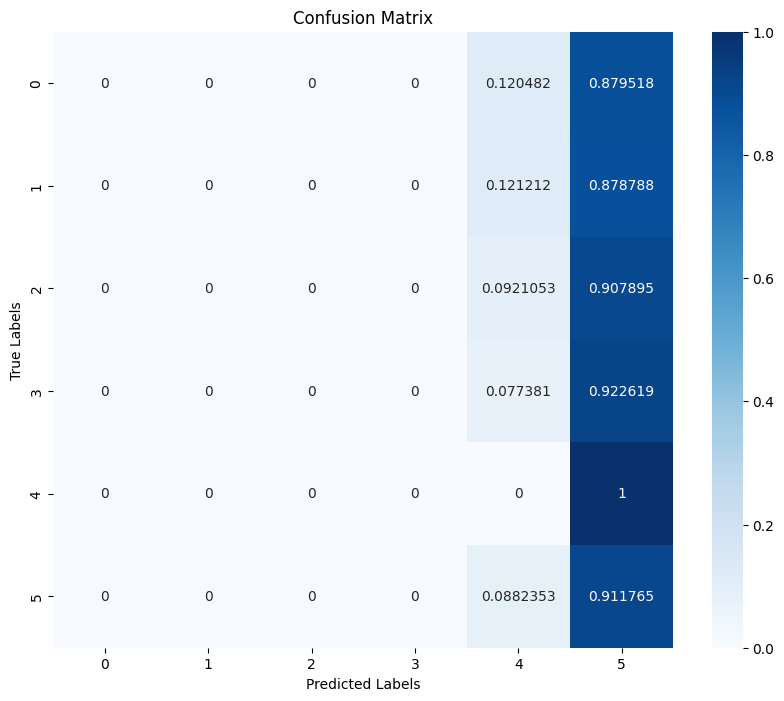

Epoch 10, Validation Loss: 1.8001, Accuracy: 0.0537, F1 Score: 0.0066
Val F1 Score Per Class  [0.         0.         0.         0.         0.         0.11171171]


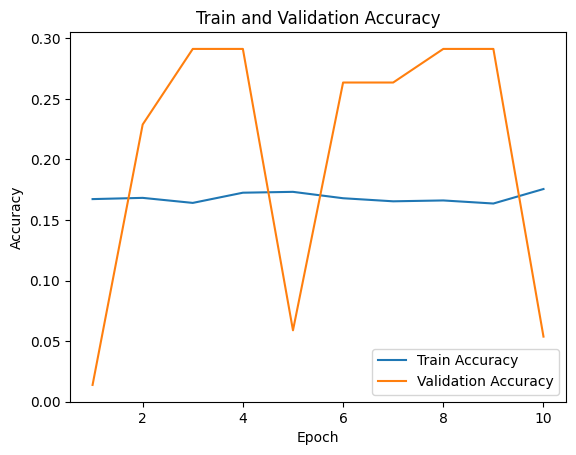

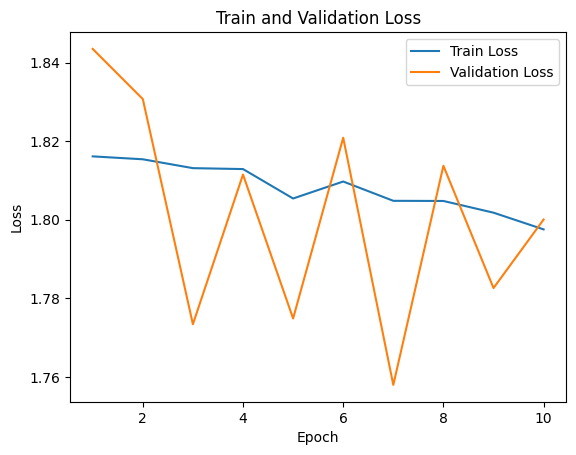

Epoch 11, Train Loss: 1.7896, Accuracy: 0.1842, F1 Score: 0.1751
Train F1 Score Per Class  [0.125      0.15088283 0.15399868 0.19371458 0.27705031 0.1504748 ]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.55it/s, loss=1.76]

[tensor([-0.1084, -0.0890, -0.2564,  0.1798,  0.0028, -0.2694], device='cuda:0'), tensor([-0.1182, -0.0827, -0.2614,  0.1712, -0.0712, -0.2782], device='cuda:0'), tensor([ 0.0432, -0.1050, -0.1093,  0.3162, -0.2529, -0.1113], device='cuda:0'), tensor([-0.1339, -0.0909, -0.2941,  0.1672,  0.3130, -0.3268], device='cuda:0'), tensor([-0.1490, -0.1122, -0.2912,  0.1458, -0.9371, -0.3120], device='cuda:0'), tensor([-0.0507, -0.0965, -0.1971,  0.2285, -0.2870, -0.1994], device='cuda:0'), tensor([-0.0685, -0.0939, -0.2157,  0.2177,  0.0691, -0.2267], device='cuda:0'), tensor([-0.1934, -0.0817, -0.3411,  0.1078,  0.1363, -0.3716], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:27,  2.54it/s, loss=1.78]

[tensor([-0.1101, -0.0759, -0.2590,  0.1805,  0.2886, -0.2766], device='cuda:0'), tensor([-0.0595, -0.1064, -0.2122,  0.2263, -0.2646, -0.2248], device='cuda:0'), tensor([ 0.0640, -0.1379, -0.0845,  0.3321, -1.4896, -0.0760], device='cuda:0'), tensor([ 0.0439, -0.1043, -0.1105,  0.3112, -0.2505, -0.1067], device='cuda:0'), tensor([ 0.0665, -0.1227, -0.0909,  0.3397, -1.0444, -0.0801], device='cuda:0'), tensor([-0.1288, -0.0945, -0.2829,  0.1681,  0.2847, -0.3099], device='cuda:0'), tensor([ 0.0115, -0.1166, -0.1455,  0.2928, -0.6787, -0.1416], device='cuda:0'), tensor([ 0.0565, -0.1132, -0.0908,  0.3273, -0.4204, -0.0863], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.46it/s, loss=1.75]

[tensor([-0.0834, -0.0913, -0.2358,  0.2070, -0.1166, -0.2514], device='cuda:0'), tensor([-0.0567, -0.1120, -0.2050,  0.2266, -0.2138, -0.2119], device='cuda:0'), tensor([-0.0124, -0.1143, -0.1720,  0.2730, -0.3669, -0.1803], device='cuda:0'), tensor([-2.8155e-04, -1.3920e-01, -1.5438e-01,  2.7850e-01, -1.0912e+00,
        -1.5365e-01], device='cuda:0'), tensor([-0.0385, -0.1364, -0.1898,  0.2445, -1.1276, -0.1981], device='cuda:0'), tensor([ 0.1179, -0.1444, -0.0354,  0.3791, -1.2081, -0.0112], device='cuda:0'), tensor([-0.0163, -0.0870, -0.1568,  0.2560, -0.4563, -0.1524], device='cuda:0'), tensor([-0.0340, -0.1039, -0.1842,  0.2486, -0.4395, -0.1851], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:27,  2.48it/s, loss=1.74]

[tensor([ 0.0382, -0.1140, -0.1086,  0.3072, -0.9072, -0.1046], device='cuda:0'), tensor([-0.1003, -0.0866, -0.2487,  0.1880,  0.0782, -0.2606], device='cuda:0'), tensor([ 0.0059, -0.1119, -0.1494,  0.2754, -0.4978, -0.1498], device='cuda:0'), tensor([-0.0291, -0.1011, -0.1857,  0.2537, -0.5789, -0.1918], device='cuda:0'), tensor([ 0.0849, -0.1278, -0.0726,  0.3525, -0.6519, -0.0618], device='cuda:0'), tensor([ 0.1489, -0.1260, -0.0051,  0.4086, -0.8725,  0.0144], device='cuda:0'), tensor([ 0.1619, -0.1272, -0.0027,  0.4236, -0.9901,  0.0161], device='cuda:0'), tensor([-0.0654, -0.0983, -0.2171,  0.2229, -0.1325, -0.2326], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.47it/s, loss=1.7]

[tensor([-0.0172, -0.1002, -0.1700,  0.2653, -0.4967, -0.1776], device='cuda:0'), tensor([ 0.1169, -0.1375, -0.0467,  0.3872, -0.8647, -0.0289], device='cuda:0'), tensor([-0.0457, -0.1265, -0.1993,  0.2401, -0.5518, -0.2023], device='cuda:0'), tensor([-0.0429, -0.1020, -0.1978,  0.2437, -0.3535, -0.2114], device='cuda:0'), tensor([-0.0340, -0.1197, -0.1987,  0.2560, -0.3304, -0.2068], device='cuda:0'), tensor([-0.0804, -0.0906, -0.2383,  0.2114, -0.1331, -0.2589], device='cuda:0'), tensor([-0.1106, -0.0980, -0.2565,  0.1791, -0.0365, -0.2758], device='cuda:0'), tensor([-0.1239, -0.1156, -0.2671,  0.1657, -0.6335, -0.2877], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.46it/s, loss=1.77]

[tensor([-0.0282, -0.1087, -0.1790,  0.2543, -0.3739, -0.1879], device='cuda:0'), tensor([-0.1436, -0.0884, -0.3001,  0.1560,  0.1754, -0.3236], device='cuda:0'), tensor([ 0.1298, -0.1256, -0.0284,  0.3959, -0.6511, -0.0064], device='cuda:0'), tensor([ 0.0274, -0.1094, -0.1211,  0.3029, -0.3398, -0.1173], device='cuda:0'), tensor([-0.0423, -0.1136, -0.1874,  0.2336, -0.9268, -0.1867], device='cuda:0'), tensor([-0.0805, -0.1052, -0.2367,  0.2089, -0.6153, -0.2497], device='cuda:0'), tensor([ 0.0436, -0.1191, -0.1077,  0.3048, -1.1496, -0.0990], device='cuda:0'), tensor([ 0.0356, -0.1153, -0.1218,  0.3144, -0.2773, -0.1202], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.48it/s, loss=1.7]

[tensor([ 0.0577, -0.1283, -0.0986,  0.3291, -1.0925, -0.0875], device='cuda:0'), tensor([ 0.0730, -0.1165, -0.0798,  0.3424, -0.9757, -0.0718], device='cuda:0'), tensor([-0.0448, -0.1119, -0.2009,  0.2407, -0.6907, -0.2149], device='cuda:0'), tensor([ 0.0063, -0.1121, -0.1430,  0.2841, -0.5982, -0.1421], device='cuda:0'), tensor([-0.0146, -0.0984, -0.1639,  0.2541, -0.3544, -0.1659], device='cuda:0'), tensor([-0.0066, -0.1261, -0.1651,  0.2782, -0.9869, -0.1735], device='cuda:0'), tensor([ 0.0376, -0.1485, -0.1176,  0.3090, -1.9264, -0.1070], device='cuda:0'), tensor([-0.0153, -0.1082, -0.1639,  0.2646, -0.2933, -0.1646], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.47it/s, loss=1.8]

[tensor([-0.0763, -0.0862, -0.2294,  0.2139,  0.0326, -0.2420], device='cuda:0'), tensor([ 0.0446, -0.1228, -0.1107,  0.3206, -0.5968, -0.1038], device='cuda:0'), tensor([-0.1518, -0.0802, -0.3020,  0.1467,  0.1358, -0.3310], device='cuda:0'), tensor([-0.1009, -0.1194, -0.2543,  0.1930, -0.8343, -0.2752], device='cuda:0'), tensor([ 0.0623, -0.1251, -0.0933,  0.3312, -0.8595, -0.0823], device='cuda:0'), tensor([ 0.1610, -0.1348,  0.0018,  0.4231, -0.7182,  0.0242], device='cuda:0'), tensor([-0.0509, -0.1223, -0.1945,  0.2288, -0.4868, -0.2009], device='cuda:0'), tensor([ 0.3674, -0.1703,  0.2136,  0.5833, -2.4191,  0.2823], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:25,  2.47it/s, loss=1.7]

[tensor([-0.1241, -0.0933, -0.2673,  0.1654, -0.1327, -0.2862], device='cuda:0'), tensor([ 0.0567, -0.1307, -0.1000,  0.3288, -0.7013, -0.0930], device='cuda:0'), tensor([-0.0412, -0.1127, -0.1890,  0.2425, -0.6171, -0.2006], device='cuda:0'), tensor([-0.1180, -0.0884, -0.2688,  0.1753, -0.1047, -0.2876], device='cuda:0'), tensor([-0.0306, -0.0964, -0.1851,  0.2550, -0.1035, -0.1930], device='cuda:0'), tensor([-0.1031, -0.0821, -0.2476,  0.1855,  0.1339, -0.2659], device='cuda:0'), tensor([-0.0752, -0.1031, -0.2241,  0.2066, -0.2964, -0.2276], device='cuda:0'), tensor([-0.0605, -0.1101, -0.2061,  0.2226, -0.8113, -0.2074], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.47it/s, loss=1.8]

[tensor([ 0.0277, -0.1096, -0.1205,  0.2988, -0.5089, -0.1082], device='cuda:0'), tensor([ 0.0219, -0.0998, -0.1299,  0.2970, -0.5034, -0.1256], device='cuda:0'), tensor([-0.0921, -0.1003, -0.2450,  0.1995, -0.2186, -0.2611], device='cuda:0'), tensor([-0.0577, -0.1214, -0.2071,  0.2294, -0.7468, -0.2155], device='cuda:0'), tensor([ 0.0139, -0.0997, -0.1359,  0.2895, -0.3021, -0.1369], device='cuda:0'), tensor([-0.0589, -0.0912, -0.2039,  0.2211,  0.0771, -0.2177], device='cuda:0'), tensor([-0.0239, -0.1015, -0.1760,  0.2575, -0.2742, -0.1766], device='cuda:0'), tensor([ 0.0740, -0.1063, -0.0834,  0.3453, -0.2826, -0.0746], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.46it/s, loss=1.79]

[tensor([-0.0806, -0.1108, -0.2348,  0.2111, -0.6279, -0.2472], device='cuda:0'), tensor([ 0.1631, -0.1281, -0.0020,  0.4264, -0.6232,  0.0163], device='cuda:0'), tensor([-0.1338, -0.0813, -0.2794,  0.1597,  0.0945, -0.3006], device='cuda:0'), tensor([-0.1005, -0.0780, -0.2435,  0.1843,  0.0007, -0.2547], device='cuda:0'), tensor([-0.0929, -0.0897, -0.2439,  0.1978, -0.2180, -0.2641], device='cuda:0'), tensor([ 0.1450, -0.1450, -0.0192,  0.4107, -1.5337, -0.0028], device='cuda:0'), tensor([-0.0474, -0.1158, -0.1991,  0.2380, -0.5484, -0.2111], device='cuda:0'), tensor([-0.1445, -0.1000, -0.2918,  0.1495, -0.2238, -0.3135], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:25,  2.44it/s, loss=1.83]

[tensor([-0.0217, -0.1044, -0.1780,  0.2639, -0.7102, -0.1865], device='cuda:0'), tensor([-0.1562, -0.0736, -0.3005,  0.1385,  0.3348, -0.3291], device='cuda:0'), tensor([-0.0743, -0.1130, -0.2219,  0.2120, -0.4252, -0.2344], device='cuda:0'), tensor([ 0.0801, -0.1287, -0.0762,  0.3481, -0.8006, -0.0632], device='cuda:0'), tensor([-0.0129, -0.1209, -0.1606,  0.2623, -1.1348, -0.1623], device='cuda:0'), tensor([-0.0981, -0.1096, -0.2428,  0.1892, -0.7238, -0.2577], device='cuda:0'), tensor([-0.0792, -0.1013, -0.2310,  0.2094, -0.1349, -0.2429], device='cuda:0'), tensor([-0.0229, -0.0954, -0.1762,  0.2603, -0.4020, -0.1800], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.45it/s, loss=1.76]

[tensor([-0.0445, -0.0944, -0.1981,  0.2367,  0.0819, -0.2017], device='cuda:0'), tensor([-0.0983, -0.0938, -0.2466,  0.1906,  0.0470, -0.2612], device='cuda:0'), tensor([-0.0465, -0.0966, -0.1899,  0.2308, -0.7210, -0.1908], device='cuda:0'), tensor([-0.1075, -0.0923, -0.2562,  0.1847, -0.1244, -0.2725], device='cuda:0'), tensor([-0.0850, -0.1211, -0.2427,  0.2089, -0.7282, -0.2610], device='cuda:0'), tensor([-0.0833, -0.1221, -0.2335,  0.2066, -0.8315, -0.2486], device='cuda:0'), tensor([-0.0504, -0.1107, -0.2009,  0.2354, -0.2842, -0.2088], device='cuda:0'), tensor([ 0.0718, -0.1168, -0.0833,  0.3429, -0.5052, -0.0724], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.43it/s, loss=1.71]

[tensor([-0.0912, -0.1086, -0.2321,  0.1912, -0.3135, -0.2471], device='cuda:0'), tensor([-0.0096, -0.1019, -0.1666,  0.2728, -0.1929, -0.1757], device='cuda:0'), tensor([-0.0423, -0.1242, -0.1938,  0.2435, -0.6106, -0.2043], device='cuda:0'), tensor([-0.1066, -0.0842, -0.2560,  0.1810, -0.2317, -0.2710], device='cuda:0'), tensor([-0.0493, -0.0964, -0.1959,  0.2307, -0.4666, -0.1994], device='cuda:0'), tensor([-0.0741, -0.1319, -0.2170,  0.2071, -1.4339, -0.2286], device='cuda:0'), tensor([-0.0689, -0.0796, -0.2211,  0.2184,  0.0078, -0.2340], device='cuda:0'), tensor([-0.0362, -0.1058, -0.1892,  0.2461, -0.2820, -0.1959], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.45it/s, loss=1.83]

[tensor([ 0.0301, -0.1104, -0.1286,  0.3080, -0.2449, -0.1315], device='cuda:0'), tensor([-0.1338, -0.0779, -0.2857,  0.1644,  0.0998, -0.3096], device='cuda:0'), tensor([ 0.0224, -0.1151, -0.1311,  0.2986, -0.4759, -0.1295], device='cuda:0'), tensor([-0.0426, -0.0940, -0.1884,  0.2395, -0.1476, -0.1928], device='cuda:0'), tensor([-0.0137, -0.0962, -0.1657,  0.2664, -0.0279, -0.1656], device='cuda:0'), tensor([-0.0251, -0.0864, -0.1779,  0.2541, -0.0860, -0.1794], device='cuda:0'), tensor([ 0.0319, -0.1075, -0.1205,  0.3073, -0.3214, -0.1243], device='cuda:0'), tensor([-0.0963, -0.0801, -0.2468,  0.1938,  0.1954, -0.2617], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.46it/s, loss=1.72]

[tensor([ 0.0501, -0.1472, -0.1050,  0.3257, -0.9916, -0.1011], device='cuda:0'), tensor([-0.1784, -0.0828, -0.3171,  0.1157, -0.1365, -0.3409], device='cuda:0'), tensor([ 0.1156, -0.1221, -0.0452,  0.3842, -0.8722, -0.0302], device='cuda:0'), tensor([-0.1093, -0.1105, -0.2681,  0.1887, -0.2856, -0.2907], device='cuda:0'), tensor([-0.0133, -0.1195, -0.1712,  0.2716, -0.7245, -0.1888], device='cuda:0'), tensor([-0.1295, -0.0894, -0.2767,  0.1640,  0.2271, -0.3021], device='cuda:0'), tensor([-0.1096, -0.0995, -0.2577,  0.1820, -0.2098, -0.2790], device='cuda:0'), tensor([-0.1057, -0.0956, -0.2578,  0.1852, -0.2324, -0.2734], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.46it/s, loss=1.7]

[tensor([ 0.0186, -0.1024, -0.1436,  0.3026, -0.3708, -0.1469], device='cuda:0'), tensor([ 0.0124, -0.1228, -0.1362,  0.2861, -0.8098, -0.1363], device='cuda:0'), tensor([-0.1069, -0.1052, -0.2582,  0.1842,  0.0057, -0.2782], device='cuda:0'), tensor([-0.0382, -0.0998, -0.1786,  0.2382, -0.2189, -0.1813], device='cuda:0'), tensor([-0.1080, -0.1044, -0.2576,  0.1804, -0.8671, -0.2731], device='cuda:0'), tensor([ 0.0295, -0.1161, -0.1303,  0.3072, -0.6948, -0.1302], device='cuda:0'), tensor([ 0.0493, -0.1342, -0.0975,  0.3158, -1.1234, -0.0865], device='cuda:0'), tensor([-0.0752, -0.1328, -0.2299,  0.2161, -1.0243, -0.2450], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.47it/s, loss=1.69]

[tensor([-0.0452, -0.1035, -0.1954,  0.2380, -0.3204, -0.2089], device='cuda:0'), tensor([ 0.0189, -0.1014, -0.1305,  0.2908, -0.5286, -0.1229], device='cuda:0'), tensor([-0.0450, -0.1044, -0.1960,  0.2377, -0.2022, -0.2016], device='cuda:0'), tensor([-0.0594, -0.1003, -0.2183,  0.2290, -0.0063, -0.2311], device='cuda:0'), tensor([ 0.0656, -0.1293, -0.0911,  0.3389, -0.8198, -0.0828], device='cuda:0'), tensor([-0.0084, -0.1141, -0.1602,  0.2698, -0.4819, -0.1587], device='cuda:0'), tensor([-0.0873, -0.0984, -0.2404,  0.2054, -0.0193, -0.2619], device='cuda:0'), tensor([-0.0392, -0.0771, -0.1880,  0.2412,  0.0608, -0.1907], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:21,  2.47it/s, loss=1.59]

[tensor([ 0.0271, -0.1186, -0.1180,  0.2940, -0.8828, -0.1116], device='cuda:0'), tensor([-0.0731, -0.1015, -0.2225,  0.2131, -0.3960, -0.2383], device='cuda:0'), tensor([-0.0271, -0.1030, -0.1858,  0.2611, -0.0605, -0.1971], device='cuda:0'), tensor([-0.0347, -0.1133, -0.1876,  0.2493, -0.3761, -0.1930], device='cuda:0'), tensor([ 0.1097, -0.1185, -0.0448,  0.3732, -0.6974, -0.0345], device='cuda:0'), tensor([ 0.0315, -0.1159, -0.1193,  0.3046, -0.6300, -0.1140], device='cuda:0'), tensor([-0.0414, -0.0876, -0.1856,  0.2325, -0.5367, -0.1829], device='cuda:0'), tensor([ 0.0413, -0.1180, -0.1150,  0.3166, -0.5746, -0.1061], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.47it/s, loss=1.84]

[tensor([ 0.1197, -0.1208, -0.0488,  0.3912, -0.4095, -0.0392], device='cuda:0'), tensor([-0.0424, -0.1245, -0.1971,  0.2450, -0.5969, -0.2087], device='cuda:0'), tensor([ 0.0249, -0.1205, -0.1222,  0.2964, -0.8468, -0.1124], device='cuda:0'), tensor([-0.0078, -0.1069, -0.1671,  0.2766, -0.3182, -0.1729], device='cuda:0'), tensor([-0.1083, -0.0839, -0.2551,  0.1822,  0.1098, -0.2704], device='cuda:0'), tensor([-0.1096, -0.1180, -0.2662,  0.1860, -0.5970, -0.2849], device='cuda:0'), tensor([ 0.1667, -0.1245,  0.0247,  0.4108, -1.0667,  0.0586], device='cuda:0'), tensor([ 0.0305, -0.1053, -0.1240,  0.3045, -0.2068, -0.1189], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.47it/s, loss=1.69]

[tensor([ 0.1158, -0.1186, -0.0424,  0.3798, -0.5748, -0.0288], device='cuda:0'), tensor([ 0.1430, -0.1172, -0.0172,  0.4037, -0.5918,  0.0023], device='cuda:0'), tensor([-0.0814, -0.1129, -0.2241,  0.2044, -0.6550, -0.2360], device='cuda:0'), tensor([ 0.0629, -0.1097, -0.0866,  0.3278, -0.6685, -0.0773], device='cuda:0'), tensor([-0.0562, -0.1220, -0.2037,  0.2276, -0.5145, -0.2129], device='cuda:0'), tensor([-0.1180, -0.0611, -0.2609,  0.1686,  0.4196, -0.2770], device='cuda:0'), tensor([ 0.0596, -0.1394, -0.1121,  0.3430, -0.6498, -0.1108], device='cuda:0'), tensor([-0.0305, -0.1120, -0.1839,  0.2522, -0.4329, -0.1926], device='cuda:0')]


Val:  30%|███       | 22/73 [00:08<00:20,  2.47it/s, loss=1.79]

[tensor([-0.1106, -0.1244, -0.2600,  0.1809, -0.8383, -0.2774], device='cuda:0'), tensor([-0.0297, -0.1245, -0.1851,  0.2565, -0.4589, -0.1856], device='cuda:0'), tensor([-0.1607, -0.0879, -0.3119,  0.1378, -0.1814, -0.3422], device='cuda:0'), tensor([-0.0058, -0.1145, -0.1605,  0.2760, -0.4635, -0.1618], device='cuda:0'), tensor([-0.2195, -0.1045, -0.3704,  0.0877, -0.1476, -0.4095], device='cuda:0'), tensor([-0.0401, -0.1037, -0.1971,  0.2472, -0.4823, -0.2004], device='cuda:0'), tensor([ 0.0378, -0.1363, -0.1213,  0.3155, -0.9881, -0.1186], device='cuda:0'), tensor([ 0.1824, -0.1271,  0.0245,  0.4393, -0.7657,  0.0530], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.47it/s, loss=1.7]

[tensor([ 0.0006, -0.0877, -0.1514,  0.2789, -0.2997, -0.1563], device='cuda:0'), tensor([-0.0844, -0.0894, -0.2290,  0.1994, -0.2583, -0.2459], device='cuda:0'), tensor([ 0.0528, -0.1303, -0.1066,  0.3272, -0.9733, -0.1035], device='cuda:0'), tensor([-0.0252, -0.1135, -0.1888,  0.2633, -0.3470, -0.1959], device='cuda:0'), tensor([-0.0007, -0.0945, -0.1469,  0.2720, -0.3113, -0.1509], device='cuda:0'), tensor([ 0.0626, -0.1183, -0.0941,  0.3373, -0.5831, -0.0869], device='cuda:0'), tensor([-0.3015, -0.0787, -0.4427,  0.0121,  0.0542, -0.4928], device='cuda:0'), tensor([-0.1436, -0.0911, -0.2916,  0.1530, -0.3615, -0.3098], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.46it/s, loss=1.76]

[tensor([-0.0106, -0.1110, -0.1654,  0.2729, -0.3533, -0.1755], device='cuda:0'), tensor([ 0.0548, -0.0978, -0.0854,  0.3170, -0.3305, -0.0774], device='cuda:0'), tensor([ 0.1628, -0.1289,  0.0064,  0.4217, -0.8159,  0.0331], device='cuda:0'), tensor([-0.0956, -0.0752, -0.2443,  0.1930,  0.2985, -0.2613], device='cuda:0'), tensor([-0.0582, -0.1177, -0.2028,  0.2205, -0.6795, -0.2114], device='cuda:0'), tensor([-0.0254, -0.1350, -0.1724,  0.2514, -0.8705, -0.1790], device='cuda:0'), tensor([-0.1136, -0.0790, -0.2626,  0.1802,  0.2781, -0.2839], device='cuda:0'), tensor([ 0.0628, -0.1048, -0.0868,  0.3301, -0.6343, -0.0756], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.46it/s, loss=1.79]

[tensor([-0.0921, -0.1014, -0.2471,  0.2028, -0.0411, -0.2667], device='cuda:0'), tensor([-0.0895, -0.0744, -0.2371,  0.1964,  0.3463, -0.2503], device='cuda:0'), tensor([-0.1205, -0.1205, -0.2725,  0.1743, -0.8718, -0.2966], device='cuda:0'), tensor([ 0.0074, -0.1192, -0.1428,  0.2832, -0.8363, -0.1406], device='cuda:0'), tensor([-0.0328, -0.0964, -0.1917,  0.2543,  0.0050, -0.1993], device='cuda:0'), tensor([-0.1572, -0.0741, -0.3030,  0.1388,  0.1434, -0.3256], device='cuda:0'), tensor([-0.0060, -0.0989, -0.1644,  0.2738, -0.1727, -0.1678], device='cuda:0'), tensor([-0.0387, -0.1301, -0.1882,  0.2411, -0.9069, -0.1870], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.47it/s, loss=1.61]

[tensor([-0.1265, -0.1130, -0.2686,  0.1613, -0.3971, -0.2813], device='cuda:0'), tensor([-0.0222, -0.1038, -0.1741,  0.2604, -0.1517, -0.1786], device='cuda:0'), tensor([ 0.1424, -0.1275, -0.0195,  0.4007, -1.3750,  0.0133], device='cuda:0'), tensor([-0.0254, -0.1302, -0.1759,  0.2563, -0.9591, -0.1756], device='cuda:0'), tensor([-0.0714, -0.1043, -0.2206,  0.2164, -0.0797, -0.2337], device='cuda:0'), tensor([ 0.0940, -0.1285, -0.0665,  0.3653, -0.9467, -0.0512], device='cuda:0'), tensor([ 0.0355, -0.1287, -0.1186,  0.3097, -0.9072, -0.1108], device='cuda:0'), tensor([ 0.0213, -0.1048, -0.1214,  0.2914, -0.3818, -0.1248], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:10<00:18,  2.47it/s, loss=1.77]

[tensor([ 0.2485, -0.1441,  0.0791,  0.4995, -1.2209,  0.1129], device='cuda:0'), tensor([ 0.0424, -0.1173, -0.1053,  0.3117, -0.3775, -0.0995], device='cuda:0'), tensor([-0.0852, -0.0886, -0.2377,  0.2013,  0.2453, -0.2591], device='cuda:0'), tensor([ 0.0874, -0.1232, -0.0796,  0.3645, -0.3806, -0.0726], device='cuda:0'), tensor([-0.0991, -0.0941, -0.2482,  0.1926, -0.0594, -0.2685], device='cuda:0'), tensor([ 0.1613, -0.1304,  0.0078,  0.4131, -1.2401,  0.0404], device='cuda:0'), tensor([ 0.0187, -0.1155, -0.1406,  0.2999, -0.5877, -0.1389], device='cuda:0'), tensor([ 0.0321, -0.1350, -0.1179,  0.3025, -1.2808, -0.1125], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.48it/s, loss=1.77]

[tensor([-0.1455, -0.1034, -0.2960,  0.1520, -0.6727, -0.3233], device='cuda:0'), tensor([ 0.0111, -0.1233, -0.1420,  0.2885, -0.5692, -0.1441], device='cuda:0'), tensor([ 0.1972, -0.1497,  0.0396,  0.4497, -1.3412,  0.0710], device='cuda:0'), tensor([-0.0883, -0.1064, -0.2331,  0.1991, -0.2486, -0.2464], device='cuda:0'), tensor([-0.1085, -0.1081, -0.2548,  0.1810, -0.1448, -0.2710], device='cuda:0'), tensor([-0.0867, -0.1065, -0.2383,  0.2044, -0.1818, -0.2573], device='cuda:0'), tensor([-0.0735, -0.1043, -0.2255,  0.2162, -0.2605, -0.2393], device='cuda:0'), tensor([-0.0701, -0.1188, -0.2245,  0.2212, -0.6433, -0.2382], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.48it/s, loss=1.72]

[tensor([ 0.0869, -0.1293, -0.0641,  0.3485, -1.0911, -0.0453], device='cuda:0'), tensor([-0.1086, -0.0974, -0.2593,  0.1841, -0.4248, -0.2757], device='cuda:0'), tensor([-0.0630, -0.1319, -0.2110,  0.2225, -0.7312, -0.2194], device='cuda:0'), tensor([-0.0044, -0.1164, -0.1595,  0.2714, -0.3361, -0.1666], device='cuda:0'), tensor([-0.0411, -0.1029, -0.1911,  0.2428, -0.1372, -0.1962], device='cuda:0'), tensor([-0.0090, -0.1127, -0.1730,  0.2750, -0.1649, -0.1771], device='cuda:0'), tensor([ 0.0075, -0.1135, -0.1516,  0.2903, -0.4232, -0.1526], device='cuda:0'), tensor([ 0.1209, -0.1205, -0.0386,  0.3875, -0.5428, -0.0227], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.48it/s, loss=1.73]

[tensor([-0.0211, -0.1027, -0.1780,  0.2630, -0.1845, -0.1814], device='cuda:0'), tensor([-0.0604, -0.0968, -0.2104,  0.2261, -0.1272, -0.2250], device='cuda:0'), tensor([-0.0958, -0.1054, -0.2465,  0.1952, -0.2217, -0.2645], device='cuda:0'), tensor([-0.0674, -0.1060, -0.2228,  0.2240, -0.3255, -0.2346], device='cuda:0'), tensor([-0.0216, -0.1201, -0.1705,  0.2567, -0.5627, -0.1773], device='cuda:0'), tensor([-0.0622, -0.0911, -0.2090,  0.2209,  0.0502, -0.2173], device='cuda:0'), tensor([-0.0389, -0.1092, -0.1882,  0.2427, -0.5326, -0.1930], device='cuda:0'), tensor([-0.1417, -0.0996, -0.2898,  0.1536,  0.0502, -0.3122], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:16,  2.47it/s, loss=1.57]

[tensor([ 0.0178, -0.1117, -0.1328,  0.2917, -0.6337, -0.1209], device='cuda:0'), tensor([-0.1065, -0.0851, -0.2503,  0.1814,  0.1417, -0.2737], device='cuda:0'), tensor([-0.0261, -0.1564, -0.1775,  0.2575, -1.3965, -0.1856], device='cuda:0'), tensor([-0.0551, -0.1107, -0.2140,  0.2332, -0.7999, -0.2296], device='cuda:0'), tensor([ 0.1040, -0.1214, -0.0514,  0.3697, -0.6640, -0.0272], device='cuda:0'), tensor([ 0.0165, -0.1233, -0.1404,  0.2964, -0.7692, -0.1373], device='cuda:0'), tensor([-0.0722, -0.0948, -0.2112,  0.2058, -0.6699, -0.2135], device='cuda:0'), tensor([ 0.0344, -0.1071, -0.1146,  0.3064, -0.5371, -0.1037], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:12<00:16,  2.45it/s, loss=1.6]

[tensor([-0.0833, -0.1170, -0.2435,  0.2138, -0.4904, -0.2669], device='cuda:0'), tensor([ 0.0054, -0.1105, -0.1457,  0.2833, -0.6976, -0.1477], device='cuda:0'), tensor([-0.0152, -0.0857, -0.1617,  0.2599,  0.0188, -0.1619], device='cuda:0'), tensor([-0.1619, -0.0944, -0.3047,  0.1322, -0.0558, -0.3312], device='cuda:0'), tensor([ 0.0456, -0.1254, -0.1034,  0.3151, -1.0019, -0.1020], device='cuda:0'), tensor([ 0.0279, -0.1334, -0.1310,  0.3068, -1.2119, -0.1291], device='cuda:0'), tensor([ 0.0633, -0.1254, -0.0881,  0.3321, -0.9405, -0.0770], device='cuda:0'), tensor([ 0.0067, -0.0988, -0.1443,  0.2839, -0.1667, -0.1429], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.47it/s, loss=1.58]

[tensor([-0.0687, -0.1189, -0.2257,  0.2240, -0.6391, -0.2398], device='cuda:0'), tensor([-0.0937, -0.0985, -0.2443,  0.1961, -0.3042, -0.2560], device='cuda:0'), tensor([-0.0667, -0.1118, -0.2290,  0.2285, -0.0859, -0.2522], device='cuda:0'), tensor([ 0.0453, -0.1145, -0.1154,  0.3227, -0.5191, -0.1117], device='cuda:0'), tensor([-0.0852, -0.1018, -0.2366,  0.2024, -0.5297, -0.2469], device='cuda:0'), tensor([ 0.0406, -0.0935, -0.0987,  0.2983, -0.6260, -0.0784], device='cuda:0'), tensor([-0.0059, -0.1170, -0.1591,  0.2750, -0.4941, -0.1652], device='cuda:0'), tensor([ 1.0030e-04, -1.2891e-01, -1.6791e-01,  2.8968e-01, -7.5781e-01,
        -1.8216e-01], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.44it/s, loss=1.68]

[tensor([ 0.0537, -0.1020, -0.0961,  0.3191, -0.7124, -0.0824], device='cuda:0'), tensor([ 0.0649, -0.1236, -0.0820,  0.3288, -0.6421, -0.0604], device='cuda:0'), tensor([-0.0422, -0.1062, -0.1918,  0.2357, -0.3760, -0.2015], device='cuda:0'), tensor([-0.1443, -0.0852, -0.2943,  0.1484,  0.1591, -0.3166], device='cuda:0'), tensor([ 0.0319, -0.1230, -0.1221,  0.3063, -0.9520, -0.1204], device='cuda:0'), tensor([ 0.0018, -0.1076, -0.1560,  0.2837, -0.4274, -0.1580], device='cuda:0'), tensor([ 0.0035, -0.0976, -0.1494,  0.2821, -0.3281, -0.1492], device='cuda:0'), tensor([ 0.0933, -0.1230, -0.0563,  0.3536, -1.2755, -0.0360], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.44it/s, loss=1.73]

[tensor([ 0.0149, -0.1144, -0.1261,  0.2788, -1.2408, -0.1112], device='cuda:0'), tensor([-0.1231, -0.1192, -0.2763,  0.1740, -0.5144, -0.2949], device='cuda:0'), tensor([-0.1541, -0.0907, -0.2981,  0.1385, -0.5018, -0.3190], device='cuda:0'), tensor([-0.0465, -0.1101, -0.1986,  0.2389, -0.5534, -0.2058], device='cuda:0'), tensor([-0.0349, -0.1032, -0.1843,  0.2490, -0.2041, -0.1912], device='cuda:0'), tensor([ 0.1633, -0.1287,  0.0107,  0.4164, -0.9059,  0.0385], device='cuda:0'), tensor([ 0.0750, -0.1282, -0.0909,  0.3472, -0.7527, -0.0817], device='cuda:0'), tensor([-0.0118, -0.1200, -0.1627,  0.2690, -0.5934, -0.1656], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.45it/s, loss=1.69]

[tensor([-0.0261, -0.0918, -0.1766,  0.2556,  0.0804, -0.1837], device='cuda:0'), tensor([-0.1143, -0.1137, -0.2622,  0.1781, -0.4397, -0.2850], device='cuda:0'), tensor([-0.2043, -0.0952, -0.3364,  0.0846,  0.0579, -0.3619], device='cuda:0'), tensor([ 0.0789, -0.1206, -0.0826,  0.3540, -0.6941, -0.0740], device='cuda:0'), tensor([-0.0335, -0.1125, -0.1793,  0.2453, -0.5285, -0.1844], device='cuda:0'), tensor([-0.1748, -0.0717, -0.3174,  0.1113,  0.2765, -0.3370], device='cuda:0'), tensor([-0.0576, -0.1108, -0.2048,  0.2254, -0.4363, -0.2162], device='cuda:0'), tensor([ 0.0232, -0.1202, -0.1336,  0.3006, -0.7821, -0.1360], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.45it/s, loss=1.74]

[tensor([-0.0500, -0.1094, -0.2074,  0.2384, -0.2997, -0.2174], device='cuda:0'), tensor([-0.1189, -0.0872, -0.2762,  0.1797,  0.2181, -0.2996], device='cuda:0'), tensor([ 0.1074, -0.1160, -0.0489,  0.3725, -0.5001, -0.0323], device='cuda:0'), tensor([ 0.0389, -0.1170, -0.1121,  0.3131, -0.5755, -0.1084], device='cuda:0'), tensor([-0.0058, -0.0983, -0.1544,  0.2729, -0.3885, -0.1556], device='cuda:0'), tensor([ 0.0432, -0.1128, -0.1095,  0.3146, -0.6829, -0.1040], device='cuda:0'), tensor([-0.0461, -0.1146, -0.1976,  0.2398, -0.3670, -0.2067], device='cuda:0'), tensor([-0.0472, -0.1022, -0.1946,  0.2351, -0.1927, -0.1999], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.45it/s, loss=1.58]

[tensor([-0.0353, -0.0994, -0.1793,  0.2362, -0.6534, -0.1758], device='cuda:0'), tensor([ 0.0712, -0.1240, -0.0808,  0.3388, -0.5300, -0.0685], device='cuda:0'), tensor([-0.1137, -0.0718, -0.2665,  0.1790,  0.3272, -0.2851], device='cuda:0'), tensor([-0.1215, -0.0878, -0.2733,  0.1711, -0.3046, -0.2874], device='cuda:0'), tensor([ 0.0977, -0.1590, -0.0517,  0.3593, -2.2087, -0.0357], device='cuda:0'), tensor([-0.0726, -0.0897, -0.2221,  0.2159,  0.1134, -0.2312], device='cuda:0'), tensor([-0.0160, -0.1082, -0.1668,  0.2592, -0.2375, -0.1666], device='cuda:0'), tensor([-0.0021, -0.0924, -0.1547,  0.2747, -0.2191, -0.1534], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.45it/s, loss=1.68]

[tensor([-0.0518, -0.0976, -0.1977,  0.2282,  0.0694, -0.2034], device='cuda:0'), tensor([ 0.1187, -0.1332, -0.0420,  0.3849, -0.8517, -0.0268], device='cuda:0'), tensor([-0.0721, -0.1058, -0.2201,  0.2152, -0.1775, -0.2335], device='cuda:0'), tensor([-0.0424, -0.0994, -0.1850,  0.2330, -0.3480, -0.1799], device='cuda:0'), tensor([ 1.5378e-01, -1.2306e-01,  6.7917e-05,  4.1171e-01, -9.9010e-01,
         2.2544e-02], device='cuda:0'), tensor([ 0.0033, -0.1132, -0.1515,  0.2794, -0.7386, -0.1542], device='cuda:0'), tensor([-0.0244, -0.0985, -0.1759,  0.2591, -0.0577, -0.1815], device='cuda:0'), tensor([ 0.0016, -0.1123, -0.1538,  0.2848, -0.5000, -0.1584], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.45it/s, loss=1.79]

[tensor([ 0.0431, -0.1171, -0.1060,  0.3148, -0.3994, -0.0995], device='cuda:0'), tensor([-0.0145, -0.1148, -0.1637,  0.2642, -0.8032, -0.1650], device='cuda:0'), tensor([ 0.1032, -0.1208, -0.0652,  0.3750, -0.5278, -0.0547], device='cuda:0'), tensor([ 0.0207, -0.1266, -0.1366,  0.2994, -0.7984, -0.1427], device='cuda:0'), tensor([-0.0409, -0.1133, -0.2069,  0.2509, -0.2630, -0.2195], device='cuda:0'), tensor([ 0.0136, -0.1253, -0.1411,  0.2920, -1.3344, -0.1390], device='cuda:0'), tensor([ 0.0725, -0.1075, -0.0759,  0.3362, -0.2993, -0.0640], device='cuda:0'), tensor([-0.0079, -0.1007, -0.1546,  0.2677, -0.6398, -0.1491], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:12,  2.46it/s, loss=1.67]

[tensor([-0.1170, -0.1261, -0.2655,  0.1748, -1.2857, -0.2891], device='cuda:0'), tensor([-0.1125, -0.1011, -0.2568,  0.1778, -0.0987, -0.2748], device='cuda:0'), tensor([-0.0469, -0.1194, -0.1948,  0.2366, -0.8203, -0.2044], device='cuda:0'), tensor([ 0.0776, -0.1145, -0.0803,  0.3515, -0.3781, -0.0676], device='cuda:0'), tensor([ 0.0921, -0.1269, -0.0633,  0.3619, -0.6771, -0.0526], device='cuda:0'), tensor([-0.0312, -0.1240, -0.1839,  0.2530, -0.8037, -0.1970], device='cuda:0'), tensor([-0.0222, -0.0972, -0.1698,  0.2535, -0.0262, -0.1675], device='cuda:0'), tensor([-0.0264, -0.0935, -0.1843,  0.2597, -0.2209, -0.1902], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.46it/s, loss=1.78]

[tensor([-0.1351, -0.0698, -0.2828,  0.1554,  0.2080, -0.3067], device='cuda:0'), tensor([ 0.1278, -0.1253, -0.0332,  0.3920, -0.7822, -0.0098], device='cuda:0'), tensor([ 0.0267, -0.1076, -0.1303,  0.3026, -0.4038, -0.1274], device='cuda:0'), tensor([-0.0040, -0.0993, -0.1544,  0.2738, -0.3655, -0.1569], device='cuda:0'), tensor([ 0.1005, -0.1200, -0.0539,  0.3669, -0.4594, -0.0407], device='cuda:0'), tensor([ 0.0172, -0.1088, -0.1313,  0.2913, -0.3345, -0.1314], device='cuda:0'), tensor([ 0.0306, -0.1299, -0.1240,  0.3082, -1.0627, -0.1195], device='cuda:0'), tensor([-0.2091, -0.0929, -0.3509,  0.0927, -0.0177, -0.3856], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.46it/s, loss=1.72]

[tensor([-0.1975, -0.0854, -0.3403,  0.1030,  0.2912, -0.3692], device='cuda:0'), tensor([-0.0586, -0.1272, -0.2041,  0.2229, -1.2845, -0.2082], device='cuda:0'), tensor([-0.0172, -0.1153, -0.1685,  0.2627, -0.6372, -0.1691], device='cuda:0'), tensor([ 0.0017, -0.1115, -0.1511,  0.2820, -0.5868, -0.1552], device='cuda:0'), tensor([-0.0147, -0.1225, -0.1730,  0.2706, -0.7631, -0.1831], device='cuda:0'), tensor([-0.1314, -0.0886, -0.2725,  0.1550,  0.1462, -0.2926], device='cuda:0'), tensor([-0.1587, -0.1201, -0.3115,  0.1412, -0.5247, -0.3400], device='cuda:0'), tensor([-0.0102, -0.0964, -0.1535,  0.2645, -0.4370, -0.1523], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:17<00:11,  2.47it/s, loss=1.65]

[tensor([-0.0105, -0.1381, -0.1653,  0.2697, -1.2005, -0.1637], device='cuda:0'), tensor([ 0.0398, -0.1220, -0.1135,  0.3129, -0.8026, -0.1061], device='cuda:0'), tensor([ 0.0657, -0.1163, -0.0956,  0.3419, -0.4950, -0.0881], device='cuda:0'), tensor([-0.1375, -0.1254, -0.2843,  0.1570, -1.0692, -0.3086], device='cuda:0'), tensor([-0.0805, -0.0992, -0.2274,  0.2083, -0.0158, -0.2394], device='cuda:0'), tensor([-0.0360, -0.1102, -0.1913,  0.2506, -0.3995, -0.2038], device='cuda:0'), tensor([-0.1266, -0.0834, -0.2707,  0.1645,  0.0692, -0.2917], device='cuda:0'), tensor([-0.0439, -0.1126, -0.1973,  0.2400, -0.8006, -0.2018], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.47it/s, loss=1.74]

[tensor([ 0.0417, -0.1069, -0.1156,  0.3188, -0.2000, -0.1132], device='cuda:0'), tensor([-0.0979, -0.1102, -0.2421,  0.1894, -0.5447, -0.2610], device='cuda:0'), tensor([-0.0552, -0.0986, -0.2091,  0.2308, -0.4373, -0.2261], device='cuda:0'), tensor([-0.0302, -0.1296, -0.1821,  0.2533, -0.7167, -0.1928], device='cuda:0'), tensor([-0.0262, -0.1010, -0.1767,  0.2548, -0.2273, -0.1849], device='cuda:0'), tensor([-0.0865, -0.0967, -0.2346,  0.2014, -0.5031, -0.2583], device='cuda:0'), tensor([-0.0370, -0.1216, -0.1906,  0.2467, -0.4004, -0.1970], device='cuda:0'), tensor([ 0.0590, -0.1379, -0.0897,  0.3277, -1.1010, -0.0722], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:10,  2.48it/s, loss=1.7]

[tensor([-0.1227, -0.1066, -0.2796,  0.1726, -0.2852, -0.3086], device='cuda:0'), tensor([-0.0717, -0.1121, -0.2204,  0.2163, -0.4513, -0.2339], device='cuda:0'), tensor([-0.1393, -0.0883, -0.2881,  0.1563, -0.3860, -0.3122], device='cuda:0'), tensor([ 0.0265, -0.1237, -0.1228,  0.2990, -0.6855, -0.1196], device='cuda:0'), tensor([ 0.0550, -0.1063, -0.0923,  0.3230, -0.8058, -0.0802], device='cuda:0'), tensor([-0.0166, -0.1104, -0.1628,  0.2599, -0.4180, -0.1629], device='cuda:0'), tensor([ 0.0169, -0.1094, -0.1377,  0.2946, -0.2850, -0.1362], device='cuda:0'), tensor([ 0.0052, -0.0989, -0.1375,  0.2766, -0.2714, -0.1312], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.46it/s, loss=1.72]

[tensor([-0.0221, -0.1172, -0.1764,  0.2607, -0.5651, -0.1865], device='cuda:0'), tensor([-0.0950, -0.1082, -0.2431,  0.1938, -0.4744, -0.2545], device='cuda:0'), tensor([-0.0489, -0.1007, -0.2013,  0.2368, -0.2258, -0.2139], device='cuda:0'), tensor([ 0.0434, -0.1108, -0.1082,  0.3141, -0.5740, -0.0994], device='cuda:0'), tensor([-0.0303, -0.1033, -0.1810,  0.2504, -0.3347, -0.1821], device='cuda:0'), tensor([ 0.0075, -0.1115, -0.1541,  0.2900, -0.6359, -0.1593], device='cuda:0'), tensor([ 0.0973, -0.1185, -0.0605,  0.3677, -0.6032, -0.0500], device='cuda:0'), tensor([-0.0460, -0.1133, -0.1865,  0.2283, -0.5049, -0.1863], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.47it/s, loss=1.64]

[tensor([-0.2266, -0.1015, -0.3738,  0.0803, -0.4645, -0.4133], device='cuda:0'), tensor([ 0.1057, -0.1227, -0.0635,  0.3796, -0.8778, -0.0512], device='cuda:0'), tensor([ 0.0729, -0.1205, -0.0876,  0.3476, -0.4316, -0.0808], device='cuda:0'), tensor([-0.0711, -0.0946, -0.2137,  0.2111, -0.5460, -0.2202], device='cuda:0'), tensor([-0.0211, -0.1171, -0.1659,  0.2569, -0.3103, -0.1677], device='cuda:0'), tensor([-0.0518, -0.0988, -0.2054,  0.2341, -0.1937, -0.2208], device='cuda:0'), tensor([-0.1756, -0.1009, -0.3236,  0.1215, -0.0876, -0.3508], device='cuda:0'), tensor([ 0.0414, -0.1269, -0.1130,  0.3159, -0.8472, -0.1056], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:19<00:09,  2.48it/s, loss=1.64]

[tensor([-0.1552, -0.0764, -0.2997,  0.1368,  0.2445, -0.3157], device='cuda:0'), tensor([-0.0673, -0.0949, -0.2119,  0.2171, -0.1123, -0.2205], device='cuda:0'), tensor([-0.0172, -0.1073, -0.1730,  0.2674, -0.4031, -0.1818], device='cuda:0'), tensor([-0.0696, -0.1137, -0.2228,  0.2186, -0.3790, -0.2357], device='cuda:0'), tensor([-0.0420, -0.1158, -0.1991,  0.2439, -0.6754, -0.2124], device='cuda:0'), tensor([-0.0261, -0.1277, -0.1855,  0.2619, -0.7859, -0.2018], device='cuda:0'), tensor([ 0.1277, -0.1205, -0.0315,  0.3929, -0.7102, -0.0146], device='cuda:0'), tensor([ 0.0333, -0.1091, -0.1137,  0.3038, -0.4589, -0.1072], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.46it/s, loss=1.69]

[tensor([-0.0092, -0.1034, -0.1643,  0.2724, -0.2319, -0.1679], device='cuda:0'), tensor([-0.0425, -0.1182, -0.1864,  0.2358, -0.6489, -0.1930], device='cuda:0'), tensor([ 0.0433, -0.0990, -0.1098,  0.3168, -0.4267, -0.1045], device='cuda:0'), tensor([-0.1296, -0.1065, -0.2746,  0.1608, -0.4866, -0.2961], device='cuda:0'), tensor([ 0.0201, -0.1254, -0.1480,  0.3073, -0.4554, -0.1548], device='cuda:0'), tensor([ 0.0157, -0.1102, -0.1354,  0.2912, -0.2713, -0.1332], device='cuda:0'), tensor([-0.0170, -0.1102, -0.1698,  0.2645, -0.3636, -0.1743], device='cuda:0'), tensor([-0.0106, -0.1390, -0.1684,  0.2747, -1.0074, -0.1686], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.47it/s, loss=1.7]

[tensor([-0.0254, -0.1080, -0.1758,  0.2563, -0.2262, -0.1789], device='cuda:0'), tensor([-0.0158, -0.1151, -0.1696,  0.2660, -0.5779, -0.1754], device='cuda:0'), tensor([ 0.0242, -0.1104, -0.1309,  0.2985, -0.3819, -0.1290], device='cuda:0'), tensor([-0.0319, -0.1017, -0.2035,  0.2588,  0.0762, -0.2164], device='cuda:0'), tensor([-0.0162, -0.1228, -0.1708,  0.2685, -0.7834, -0.1785], device='cuda:0'), tensor([-0.0776, -0.1190, -0.2307,  0.2138, -0.9827, -0.2426], device='cuda:0'), tensor([ 0.2814, -0.1401,  0.1328,  0.5056, -1.5444,  0.2030], device='cuda:0'), tensor([ 0.0057, -0.0888, -0.1465,  0.2811, -0.5123, -0.1475], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.49it/s, loss=1.7]

[tensor([-0.0166, -0.1226, -0.1697,  0.2663, -0.2631, -0.1804], device='cuda:0'), tensor([-0.1162, -0.1194, -0.2664,  0.1767, -0.9815, -0.2879], device='cuda:0'), tensor([-0.1389, -0.0903, -0.2778,  0.1500, -0.1596, -0.2980], device='cuda:0'), tensor([-0.1465, -0.1055, -0.2975,  0.1521, -0.2271, -0.3250], device='cuda:0'), tensor([ 0.0458, -0.1241, -0.1110,  0.3198, -0.7576, -0.1007], device='cuda:0'), tensor([ 0.0010, -0.1027, -0.1510,  0.2780, -0.5589, -0.1478], device='cuda:0'), tensor([ 0.0615, -0.1134, -0.0838,  0.3256, -0.4120, -0.0715], device='cuda:0'), tensor([-0.0754, -0.1021, -0.2223,  0.2110, -0.0857, -0.2349], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.47it/s, loss=1.78]

[tensor([-0.0604, -0.1026, -0.2109,  0.2255, -0.5480, -0.2210], device='cuda:0'), tensor([ 0.2771, -0.1534,  0.1161,  0.5156, -1.9651,  0.1735], device='cuda:0'), tensor([-0.0175, -0.1205, -0.1707,  0.2628, -0.7797, -0.1726], device='cuda:0'), tensor([-0.1364, -0.1164, -0.2857,  0.1598, -0.7740, -0.3124], device='cuda:0'), tensor([-0.0432, -0.1066, -0.2000,  0.2442, -0.2388, -0.2201], device='cuda:0'), tensor([-0.0566, -0.1056, -0.2063,  0.2284, -0.2999, -0.2165], device='cuda:0'), tensor([ 0.1478, -0.1367, -0.0146,  0.4114, -0.9688,  0.0120], device='cuda:0'), tensor([ 0.0349, -0.1431, -0.1244,  0.3138, -1.1661, -0.1218], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:21<00:07,  2.46it/s, loss=1.73]

[tensor([ 0.0305, -0.1141, -0.1345,  0.3076, -0.5316, -0.1305], device='cuda:0'), tensor([ 0.0254, -0.1154, -0.1287,  0.3012, -0.6561, -0.1304], device='cuda:0'), tensor([-0.0058, -0.0991, -0.1625,  0.2774, -0.0330, -0.1648], device='cuda:0'), tensor([-0.1219, -0.1084, -0.2733,  0.1746, -0.2162, -0.2927], device='cuda:0'), tensor([ 0.1439, -0.1306, -0.0180,  0.4090, -0.8324, -0.0022], device='cuda:0'), tensor([-0.0634, -0.0920, -0.2116,  0.2170, -0.6023, -0.2162], device='cuda:0'), tensor([-0.0167, -0.1283, -0.1691,  0.2643, -0.5671, -0.1717], device='cuda:0'), tensor([-0.0201, -0.1208, -0.1738,  0.2566, -0.7090, -0.1687], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.47it/s, loss=1.67]

[tensor([-0.0317, -0.0992, -0.1779,  0.2438, -0.5406, -0.1757], device='cuda:0'), tensor([ 0.0238, -0.1114, -0.1256,  0.2963, -0.6369, -0.1191], device='cuda:0'), tensor([-0.0207, -0.1012, -0.1661,  0.2546, -0.5490, -0.1653], device='cuda:0'), tensor([-0.0407, -0.1126, -0.1855,  0.2363, -0.8223, -0.1866], device='cuda:0'), tensor([-4.8000e-05, -1.2019e-01, -1.5126e-01,  2.7809e-01, -9.7183e-01,
        -1.5239e-01], device='cuda:0'), tensor([ 0.1527, -0.1243, -0.0114,  0.4195, -0.6753,  0.0053], device='cuda:0'), tensor([-0.1802, -0.0768, -0.3244,  0.1194,  0.4318, -0.3593], device='cuda:0'), tensor([-0.0900, -0.1060, -0.2378,  0.1972, -0.4357, -0.2473], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.47it/s, loss=1.58]

[tensor([-0.1132, -0.1036, -0.2608,  0.1785, -0.3205, -0.2814], device='cuda:0'), tensor([-0.1190, -0.0771, -0.2711,  0.1727,  0.3193, -0.2967], device='cuda:0'), tensor([-0.0669, -0.0971, -0.2150,  0.2183, -0.1393, -0.2258], device='cuda:0'), tensor([ 0.1231, -0.1209, -0.0352,  0.3861, -0.8318, -0.0147], device='cuda:0'), tensor([ 0.0178, -0.1160, -0.1333,  0.2917, -0.4293, -0.1303], device='cuda:0'), tensor([ 0.0172, -0.1224, -0.1406,  0.2961, -0.8524, -0.1404], device='cuda:0'), tensor([-0.0190, -0.1272, -0.1749,  0.2654, -0.4334, -0.1809], device='cuda:0'), tensor([-0.1347, -0.0807, -0.2795,  0.1567,  0.0076, -0.2992], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.47it/s, loss=1.7]

[tensor([-0.1335, -0.1015, -0.2812,  0.1596, -0.5152, -0.3014], device='cuda:0'), tensor([-0.0231, -0.1432, -0.1691,  0.2552, -1.2970, -0.1769], device='cuda:0'), tensor([ 0.0486, -0.1280, -0.1098,  0.3234, -0.7967, -0.1046], device='cuda:0'), tensor([-0.0548, -0.1401, -0.2082,  0.2311, -1.0048, -0.2161], device='cuda:0'), tensor([-0.1471, -0.1043, -0.2901,  0.1431, -0.7791, -0.3050], device='cuda:0'), tensor([-0.1555, -0.0716, -0.3061,  0.1430,  0.3081, -0.3283], device='cuda:0'), tensor([ 0.0918, -0.1113, -0.0636,  0.3584, -0.7608, -0.0439], device='cuda:0'), tensor([ 0.0462, -0.1017, -0.1086,  0.3189, -0.2054, -0.1050], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.47it/s, loss=1.74]

[tensor([-0.0309, -0.1137, -0.1794,  0.2490, -0.4533, -0.1807], device='cuda:0'), tensor([-0.1312, -0.0729, -0.2874,  0.1668,  0.4918, -0.3123], device='cuda:0'), tensor([-0.0904, -0.1213, -0.2387,  0.1983, -0.4909, -0.2561], device='cuda:0'), tensor([ 0.0237, -0.1244, -0.1297,  0.3011, -0.8546, -0.1305], device='cuda:0'), tensor([-0.0310, -0.1050, -0.1818,  0.2502, -0.4577, -0.1892], device='cuda:0'), tensor([-0.0610, -0.0947, -0.2094,  0.2215, -0.0881, -0.2169], device='cuda:0'), tensor([-0.0437, -0.1065, -0.1917,  0.2391, -0.2327, -0.1964], device='cuda:0'), tensor([-0.0409, -0.1032, -0.1834,  0.2359, -0.4483, -0.1863], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:23<00:05,  2.47it/s, loss=1.85]

[tensor([-0.0584, -0.1004, -0.2108,  0.2278, -0.2310, -0.2244], device='cuda:0'), tensor([-0.0657, -0.1228, -0.2222,  0.2250, -0.6553, -0.2363], device='cuda:0'), tensor([-0.1099, -0.0954, -0.2531,  0.1784, -0.2454, -0.2673], device='cuda:0'), tensor([-0.0969, -0.0678, -0.2393,  0.1809,  0.3559, -0.2519], device='cuda:0'), tensor([ 0.0685, -0.1255, -0.0909,  0.3407, -0.5515, -0.0839], device='cuda:0'), tensor([ 0.1081, -0.1132, -0.0461,  0.3682, -0.8565, -0.0218], device='cuda:0'), tensor([-0.1208, -0.1004, -0.2716,  0.1733,  0.0197, -0.2924], device='cuda:0'), tensor([-0.1562, -0.0890, -0.3029,  0.1395, -0.3813, -0.3303], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.46it/s, loss=1.78]

[tensor([-0.0756, -0.0838, -0.2330,  0.2148, -0.0345, -0.2479], device='cuda:0'), tensor([-0.1520, -0.0977, -0.2963,  0.1424, -0.2451, -0.3145], device='cuda:0'), tensor([-0.0723, -0.1216, -0.2259,  0.2124, -0.6262, -0.2408], device='cuda:0'), tensor([-0.1435, -0.1079, -0.2888,  0.1493, -0.6577, -0.3104], device='cuda:0'), tensor([-0.0087, -0.1334, -0.1600,  0.2698, -0.8946, -0.1646], device='cuda:0'), tensor([-0.0887, -0.1093, -0.2393,  0.1958, -0.3485, -0.2530], device='cuda:0'), tensor([-0.0079, -0.1068, -0.1583,  0.2701, -0.2458, -0.1602], device='cuda:0'), tensor([ 0.0573, -0.1229, -0.0918,  0.3245, -1.0581, -0.0785], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.46it/s, loss=1.65]

[tensor([-0.0760, -0.1039, -0.2205,  0.2068, -0.2558, -0.2273], device='cuda:0'), tensor([-0.1131, -0.1226, -0.2658,  0.1820, -0.5596, -0.2914], device='cuda:0'), tensor([-0.0428, -0.1050, -0.1910,  0.2402, -0.4718, -0.1963], device='cuda:0'), tensor([-0.0945, -0.1158, -0.2518,  0.2018, -0.8180, -0.2713], device='cuda:0'), tensor([-0.0784, -0.0951, -0.2342,  0.2099, -0.4285, -0.2483], device='cuda:0'), tensor([ 0.1024, -0.1437, -0.0591,  0.3737, -1.2697, -0.0449], device='cuda:0'), tensor([ 0.0081, -0.1064, -0.1459,  0.2856, -0.3436, -0.1456], device='cuda:0'), tensor([-0.0099, -0.1046, -0.1623,  0.2691, -0.4521, -0.1642], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.45it/s, loss=1.7]

[tensor([-0.1085, -0.0798, -0.2501,  0.1758,  0.1959, -0.2651], device='cuda:0'), tensor([-0.0768, -0.0887, -0.2270,  0.2077, -0.2276, -0.2362], device='cuda:0'), tensor([ 0.0848, -0.1455, -0.0712,  0.3547, -1.1218, -0.0619], device='cuda:0'), tensor([-0.0301, -0.0968, -0.1806,  0.2524, -0.0920, -0.1875], device='cuda:0'), tensor([-0.0899, -0.1076, -0.2440,  0.2020, -0.1254, -0.2593], device='cuda:0'), tensor([-0.1685, -0.0769, -0.3123,  0.1263,  0.2292, -0.3400], device='cuda:0'), tensor([-0.1059, -0.1242, -0.2539,  0.1845, -0.7555, -0.2725], device='cuda:0'), tensor([-0.1529, -0.0759, -0.2943,  0.1375,  0.1641, -0.3143], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.45it/s, loss=1.79]

[tensor([-0.0504, -0.1034, -0.2089,  0.2376, -0.2693, -0.2179], device='cuda:0'), tensor([-0.1682, -0.0627, -0.3093,  0.1248,  0.3017, -0.3338], device='cuda:0'), tensor([-0.0997, -0.0812, -0.2383,  0.1802, -0.1399, -0.2454], device='cuda:0'), tensor([-0.1252, -0.0861, -0.2725,  0.1691, -0.2691, -0.2940], device='cuda:0'), tensor([-0.0529, -0.1266, -0.2021,  0.2323, -0.5037, -0.2094], device='cuda:0'), tensor([-0.0626, -0.0828, -0.2122,  0.2214,  0.0658, -0.2220], device='cuda:0'), tensor([ 0.1968, -0.1596,  0.0377,  0.4531, -1.4293,  0.0732], device='cuda:0'), tensor([-0.0120, -0.1163, -0.1675,  0.2692, -0.3506, -0.1654], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:25<00:03,  2.46it/s, loss=1.75]

[tensor([-0.1199, -0.1004, -0.2537,  0.1592, -0.2652, -0.2580], device='cuda:0'), tensor([ 0.0682, -0.1082, -0.0842,  0.3361, -0.6741, -0.0743], device='cuda:0'), tensor([-0.1127, -0.0971, -0.2534,  0.1733, -0.8206, -0.2654], device='cuda:0'), tensor([-0.0517, -0.1118, -0.2002,  0.2325, -0.1541, -0.2127], device='cuda:0'), tensor([ 0.0654, -0.1348, -0.0860,  0.3319, -0.8455, -0.0787], device='cuda:0'), tensor([ 0.1624, -0.1255,  0.0056,  0.4188, -0.6704,  0.0294], device='cuda:0'), tensor([-0.0923, -0.1057, -0.2494,  0.2017, -0.2943, -0.2647], device='cuda:0'), tensor([-0.0656, -0.1408, -0.2122,  0.2185, -1.7836, -0.2272], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.46it/s, loss=1.8]

[tensor([-0.0075, -0.1037, -0.1561,  0.2703, -0.3492, -0.1665], device='cuda:0'), tensor([-0.0957, -0.1231, -0.2414,  0.1935, -0.9009, -0.2512], device='cuda:0'), tensor([-0.0699, -0.0995, -0.2157,  0.2165, -0.2189, -0.2266], device='cuda:0'), tensor([-0.0309, -0.1070, -0.1751,  0.2463, -0.4563, -0.1762], device='cuda:0'), tensor([ 0.0554, -0.1231, -0.1016,  0.3294, -0.9334, -0.0967], device='cuda:0'), tensor([-0.0172, -0.1213, -0.1759,  0.2663, -0.5546, -0.1871], device='cuda:0'), tensor([ 0.0390, -0.1147, -0.1105,  0.3121, -0.3306, -0.1042], device='cuda:0'), tensor([-0.0663, -0.1108, -0.2154,  0.2202, -0.4628, -0.2269], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.46it/s, loss=1.58]

[tensor([ 0.1273, -0.1362, -0.0339,  0.3910, -1.3813, -0.0055], device='cuda:0'), tensor([-0.0394, -0.1026, -0.1894,  0.2454, -0.5836, -0.1972], device='cuda:0'), tensor([ 0.0010, -0.1093, -0.1515,  0.2806, -0.8622, -0.1535], device='cuda:0'), tensor([ 0.0189, -0.1243, -0.1311,  0.2916, -0.9687, -0.1246], device='cuda:0'), tensor([ 0.1017, -0.1295, -0.0628,  0.3754, -0.6250, -0.0514], device='cuda:0'), tensor([-0.0220, -0.1047, -0.1753,  0.2607, -0.4021, -0.1793], device='cuda:0'), tensor([ 0.0172, -0.1286, -0.1354,  0.2943, -0.6965, -0.1338], device='cuda:0'), tensor([-0.0569, -0.1008, -0.2072,  0.2290, -0.3233, -0.2170], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.47it/s, loss=1.78]

[tensor([-0.0929, -0.1029, -0.2477,  0.1996, -0.4250, -0.2635], device='cuda:0'), tensor([-0.1207, -0.1142, -0.2656,  0.1694, -0.3622, -0.2895], device='cuda:0'), tensor([-0.2672, -0.0804, -0.4054,  0.0366,  0.0343, -0.4463], device='cuda:0'), tensor([-0.0086, -0.1062, -0.1543,  0.2655, -0.3614, -0.1485], device='cuda:0'), tensor([ 0.0085, -0.1021, -0.1521,  0.2882, -0.3026, -0.1556], device='cuda:0'), tensor([ 0.0255, -0.1231, -0.1281,  0.3019, -1.2244, -0.1239], device='cuda:0'), tensor([-0.0122, -0.0993, -0.1672,  0.2699, -0.1732, -0.1636], device='cuda:0'), tensor([ 0.1168, -0.1063, -0.0356,  0.3765, -0.6970, -0.0067], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.46it/s, loss=1.7]

[tensor([-0.0395, -0.1036, -0.1952,  0.2468, -0.3081, -0.2055], device='cuda:0'), tensor([ 0.0258, -0.1068, -0.1339,  0.3032, -0.3252, -0.1300], device='cuda:0'), tensor([-0.0711, -0.1202, -0.2273,  0.2189, -0.6021, -0.2387], device='cuda:0'), tensor([ 0.0559, -0.1238, -0.0976,  0.3288, -0.9154, -0.0925], device='cuda:0'), tensor([-0.0175, -0.1077, -0.1721,  0.2655, -0.2534, -0.1774], device='cuda:0'), tensor([-0.1594, -0.0895, -0.3025,  0.1359, -0.1748, -0.3232], device='cuda:0'), tensor([ 0.0370, -0.1271, -0.1216,  0.3139, -0.8746, -0.1147], device='cuda:0'), tensor([-0.0890, -0.1258, -0.2407,  0.2013, -0.7798, -0.2596], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:27<00:01,  2.47it/s, loss=1.78]

[tensor([-0.0581, -0.1147, -0.2102,  0.2264, -0.4962, -0.2202], device='cuda:0'), tensor([ 0.1140, -0.1166, -0.0583,  0.3793, -0.4031, -0.0451], device='cuda:0'), tensor([ 0.0516, -0.1138, -0.1053,  0.3259, -0.5841, -0.1023], device='cuda:0'), tensor([ 0.0625, -0.1163, -0.0917,  0.3334, -0.4887, -0.0858], device='cuda:0'), tensor([-0.1762, -0.0655, -0.3256,  0.1208,  0.4329, -0.3528], device='cuda:0'), tensor([ 0.0492, -0.1352, -0.1141,  0.3286, -0.5997, -0.1142], device='cuda:0'), tensor([ 0.0727, -0.1134, -0.0757,  0.3381, -0.6354, -0.0626], device='cuda:0'), tensor([ 0.0625, -0.1451, -0.0894,  0.3281, -1.6728, -0.0771], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.47it/s, loss=1.74]

[tensor([ 0.1160, -0.1215, -0.0365,  0.3793, -0.7331, -0.0166], device='cuda:0'), tensor([-0.0311, -0.1086, -0.1783,  0.2460, -0.7526, -0.1810], device='cuda:0'), tensor([-0.0809, -0.1279, -0.2292,  0.2072, -0.9995, -0.2448], device='cuda:0'), tensor([ 0.0547, -0.1143, -0.1005,  0.3274, -0.7536, -0.0891], device='cuda:0'), tensor([-0.2616, -0.0542, -0.4045,  0.0467,  0.6807, -0.4491], device='cuda:0'), tensor([-0.1689, -0.0803, -0.3067,  0.1207,  0.2873, -0.3206], device='cuda:0'), tensor([-0.0774, -0.1223, -0.2228,  0.2090, -0.8235, -0.2400], device='cuda:0'), tensor([ 0.0260, -0.1140, -0.1252,  0.2988, -1.0997, -0.1178], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:28<00:00,  2.46it/s, loss=1.74]

[tensor([-0.1099, -0.0998, -0.2615,  0.1835, -0.2303, -0.2861], device='cuda:0'), tensor([ 0.0429, -0.1502, -0.1150,  0.3210, -1.7110, -0.1172], device='cuda:0'), tensor([-0.0250, -0.1123, -0.1824,  0.2619, -0.7563, -0.1890], device='cuda:0'), tensor([-0.1271, -0.0958, -0.2682,  0.1589, -0.1741, -0.2820], device='cuda:0'), tensor([-0.0152, -0.0988, -0.1787,  0.2725, -0.4620, -0.1861], device='cuda:0'), tensor([-0.0990, -0.1154, -0.2457,  0.1894, -0.5145, -0.2612], device='cuda:0'), tensor([-0.0350, -0.1057, -0.1828,  0.2459, -0.4452, -0.1896], device='cuda:0'), tensor([-0.1111, -0.1013, -0.2604,  0.1813, -0.3326, -0.2755], device='cuda:0')]


[tensor([ 0.0013, -0.1204, -0.1488,  0.2797, -0.7884, -0.1498], device='cuda:0'), tensor([-0.1588, -0.0870, -0.3059,  0.1379, -0.4412, -0.3283], device='cuda:0'), tensor([-0.1159, -0.0884, -0.2675,  0.1778, -0.0063, -0.2875], device='cuda:0'), tensor([ 0.0225, -0.1058, -0.1268,  0.2951, -0.1496, -0.1165], device='cuda:0'), tensor([-0.0575, -0.1278, -0.2146,  0.2331, -0.7642, -0.2244], device='cuda:0'), tensor([-0.0256, -0.1384, -0.1824,  0.2600, -1.3203, -0.1887], device='cuda:0'), tensor([ 0.0751, -0.1149, -0.0792,  0.3439, -0.5634, -0.0672], device='cuda:0'), tensor([-0.1089, -0.1027, -0.2557,  0.1807, -0.2571, -0.2731], device='cuda:0')]
[tensor([ 0.0432, -0.1205, -0.1087,  0.3137, -0.3612, -0.1004], device='cuda:0')]


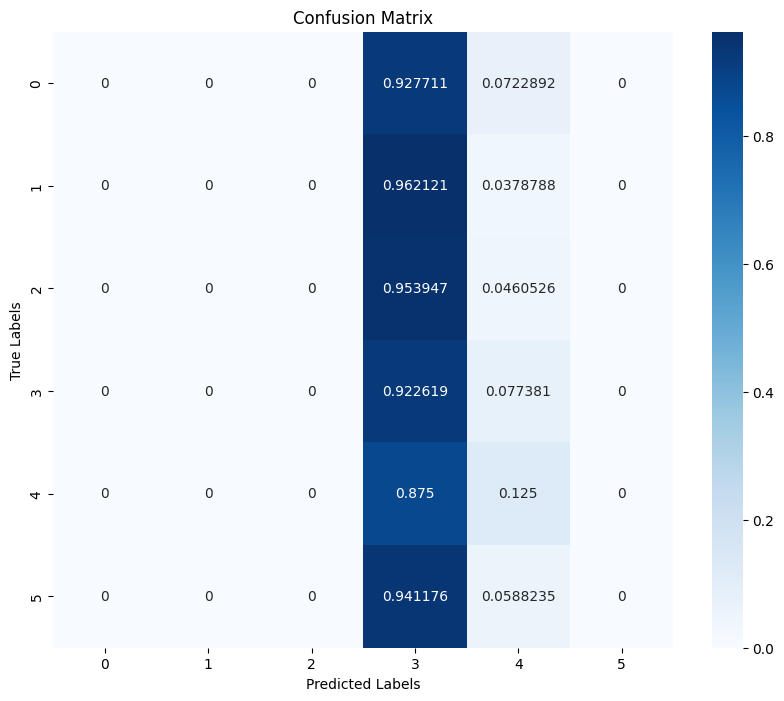

Epoch 11, Validation Loss: 1.7240, Accuracy: 0.2704, F1 Score: 0.1276
Val F1 Score Per Class  [0.         0.         0.         0.43600563 0.04761905 0.        ]


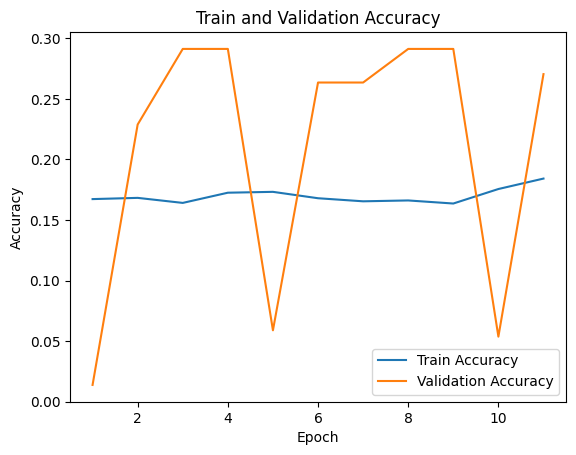

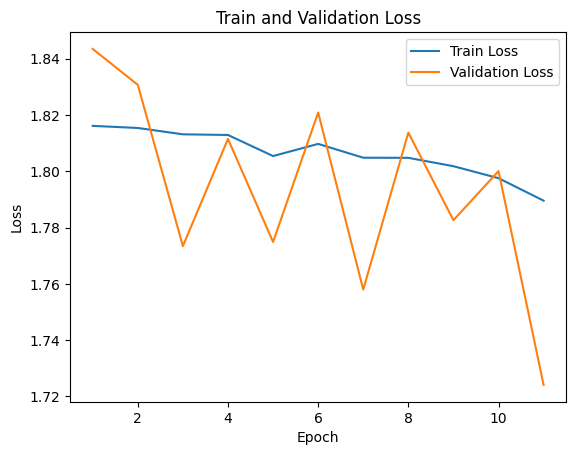

Epoch 12, Train Loss: 1.7620, Accuracy: 0.2126, F1 Score: 0.1880
Train F1 Score Per Class  [0.08912953 0.1498829  0.12585812 0.22495362 0.37440266 0.1655706 ]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.52it/s, loss=1.79]

[tensor([-0.1688,  0.0280,  0.0974, -0.2206,  0.0180, -0.1356], device='cuda:0'), tensor([-0.2654, -0.0169, -0.0435, -0.3094, -0.0307, -0.2414], device='cuda:0'), tensor([-0.0687,  0.0656,  0.2247, -0.1534, -0.5483, -0.0103], device='cuda:0'), tensor([-0.1802,  0.0138,  0.0634, -0.2011, -0.4304, -0.1697], device='cuda:0'), tensor([-0.2865, -0.0351, -0.0529, -0.2866, -0.6714, -0.2939], device='cuda:0'), tensor([-0.2202,  0.0090, -0.0093, -0.2889, -0.7926, -0.1428], device='cuda:0'), tensor([-0.0969,  0.0455,  0.1886, -0.1401, -0.5225, -0.0852], device='cuda:0'), tensor([-0.2961, -0.0419, -0.0706, -0.2905,  0.2835, -0.3089], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.51it/s, loss=1.74]

[tensor([-0.2278,  0.0050,  0.0008, -0.2933,  0.0251, -0.1704], device='cuda:0'), tensor([-0.2071,  0.0048,  0.0443, -0.2302, -0.4310, -0.2050], device='cuda:0'), tensor([ 0.0309,  0.1176,  0.3520, -0.1507, -1.1192,  0.1444], device='cuda:0'), tensor([-0.2251, -0.0012,  0.0243, -0.2352, -0.4334, -0.2274], device='cuda:0'), tensor([-0.0816,  0.0675,  0.1975, -0.2023, -0.9983,  0.0226], device='cuda:0'), tensor([-0.1686,  0.0175,  0.0978, -0.2027,  0.0110, -0.1569], device='cuda:0'), tensor([-0.0377,  0.0874,  0.2431, -0.1540, -0.9451,  0.0519], device='cuda:0'), tensor([ 0.0464,  0.1106,  0.3997, -0.0829, -1.5140,  0.1276], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:30,  2.29it/s, loss=1.69]

[tensor([-0.1992,  0.0059,  0.0445, -0.2280, -0.2857, -0.1800], device='cuda:0'), tensor([-0.1899,  0.0152,  0.0517, -0.2170, -0.8262, -0.1678], device='cuda:0'), tensor([ 5.6434e-04,  9.5137e-02,  3.1398e-01, -9.6489e-02, -1.0069e+00,
         4.6972e-02], device='cuda:0'), tensor([-0.0823,  0.0606,  0.1930, -0.1606, -0.7736, -0.0226], device='cuda:0'), tensor([ 0.0161,  0.1112,  0.3243, -0.1384, -1.0502,  0.1238], device='cuda:0'), tensor([-0.1153,  0.0607,  0.1495, -0.2228, -0.7725, -0.0125], device='cuda:0'), tensor([-0.2467, -0.0139, -0.0060, -0.2742, -2.3722, -0.2284], device='cuda:0'), tensor([-0.1425,  0.0356,  0.1135, -0.2001, -0.5299, -0.0947], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:30,  2.30it/s, loss=1.73]

[tensor([-0.0706,  0.0682,  0.2325, -0.1593, -0.8840, -0.0089], device='cuda:0'), tensor([-0.2459, -0.0082, -0.0176, -0.2662,  0.1201, -0.2340], device='cuda:0'), tensor([-0.1685,  0.0225,  0.1027, -0.1918, -0.5510, -0.1610], device='cuda:0'), tensor([-0.1953,  0.0110,  0.0723, -0.2072, -0.0216, -0.2017], device='cuda:0'), tensor([-0.0941,  0.0525,  0.1816, -0.1561, -1.1319, -0.0519], device='cuda:0'), tensor([-0.1206,  0.0431,  0.1524, -0.1922, -0.9438, -0.0647], device='cuda:0'), tensor([-0.0308,  0.0968,  0.2825, -0.1381, -1.0944,  0.0518], device='cuda:0'), tensor([-0.2493, -0.0186, -0.0090, -0.2312, -0.1875, -0.2802], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.36it/s, loss=1.75]

[tensor([-0.1001,  0.0551,  0.1740, -0.1666, -0.1921, -0.0513], device='cuda:0'), tensor([ 0.0018,  0.0918,  0.3183, -0.0886, -0.6884,  0.0308], device='cuda:0'), tensor([-0.0325,  0.0852,  0.2641, -0.1302, -1.1654,  0.0301], device='cuda:0'), tensor([-0.2548, -0.0224, -0.0106, -0.2465, -0.5731, -0.2734], device='cuda:0'), tensor([-0.1185,  0.0395,  0.1683, -0.1728, -0.8468, -0.0929], device='cuda:0'), tensor([-0.2108,  0.0060,  0.0332, -0.2517, -0.4939, -0.1787], device='cuda:0'), tensor([-0.1645,  0.0256,  0.0937, -0.2085, -0.0237, -0.1415], device='cuda:0'), tensor([-0.0452,  0.0869,  0.2447, -0.1658, -0.9332,  0.0563], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.36it/s, loss=1.81]

[tensor([-0.1160,  0.0396,  0.1634, -0.1550, -0.6018, -0.1023], device='cuda:0'), tensor([-0.1727,  0.0252,  0.0893, -0.2222, -0.0570, -0.1381], device='cuda:0'), tensor([-0.0943,  0.0538,  0.2049, -0.1768, -0.7061, -0.0374], device='cuda:0'), tensor([-0.1072,  0.0433,  0.1797, -0.1505, -0.1432, -0.0900], device='cuda:0'), tensor([-0.0887,  0.0722,  0.2007, -0.1931, -0.8427,  0.0011], device='cuda:0'), tensor([-0.1562,  0.0389,  0.0993, -0.2483, -2.6109, -0.0743], device='cuda:0'), tensor([-0.0978,  0.0699,  0.1743, -0.2003, -1.7769, -0.0036], device='cuda:0'), tensor([-0.1338,  0.0393,  0.1406, -0.2117, -0.2620, -0.1024], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.42it/s, loss=1.65]

[tensor([ 0.0196,  0.1104,  0.3319, -0.0898, -0.7491,  0.0843], device='cuda:0'), tensor([-0.0615,  0.0721,  0.2265, -0.1721, -1.8675,  0.0276], device='cuda:0'), tensor([-0.0879,  0.0581,  0.1997, -0.1651, -0.4862, -0.0366], device='cuda:0'), tensor([-0.1618,  0.0212,  0.0967, -0.1923, -0.5542, -0.1465], device='cuda:0'), tensor([-0.1362,  0.0367,  0.1313, -0.2039, -0.1035, -0.0856], device='cuda:0'), tensor([-0.0323,  0.0781,  0.2782, -0.1852, -1.2959,  0.0067], device='cuda:0'), tensor([-0.0749,  0.0745,  0.2100, -0.1606, -2.4642, -0.0083], device='cuda:0'), tensor([-0.1540,  0.0228,  0.1037, -0.1858, -0.0413, -0.1398], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.41it/s, loss=1.72]

[tensor([-0.1548,  0.0217,  0.1056, -0.1726, -0.2508, -0.1572], device='cuda:0'), tensor([-0.0333,  0.0840,  0.2555, -0.1366, -0.9634,  0.0506], device='cuda:0'), tensor([-0.2790, -0.0322, -0.0520, -0.2660, -0.0057, -0.2985], device='cuda:0'), tensor([-0.2254, -0.0067,  0.0157, -0.2410, -0.5433, -0.2200], device='cuda:0'), tensor([-0.0349,  0.0886,  0.2599, -0.1423, -0.8072,  0.0490], device='cuda:0'), tensor([ 0.1412,  0.1672,  0.5029, -0.0341, -1.4067,  0.2601], device='cuda:0'), tensor([-0.2270, -0.0095,  0.0157, -0.2242, -0.4218, -0.2426], device='cuda:0'), tensor([ 0.2865,  0.2533,  0.6804, -0.0396, -3.6270,  0.5619], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.42it/s, loss=1.79]

[tensor([-0.1687,  0.0211,  0.0937, -0.2050, -0.4132, -0.1636], device='cuda:0'), tensor([ 0.0074,  0.0999,  0.3258, -0.0933, -0.9532,  0.0742], device='cuda:0'), tensor([-0.1447,  0.0270,  0.1191, -0.1776, -0.5117, -0.1306], device='cuda:0'), tensor([-0.2226, -0.0064,  0.0220, -0.2335, -0.0159, -0.2243], device='cuda:0'), tensor([-0.2460, -0.0119, -0.0128, -0.2709, -0.5641, -0.2230], device='cuda:0'), tensor([-0.1726,  0.0186,  0.0790, -0.2043, -0.4174, -0.1549], device='cuda:0'), tensor([-0.1912,  0.0357,  0.0397, -0.2975, -0.4494, -0.1038], device='cuda:0'), tensor([-0.1646,  0.0317,  0.0768, -0.2473, -0.6420, -0.0863], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.43it/s, loss=1.65]

[tensor([ 0.0039,  0.1033,  0.3010, -0.1262, -0.6948,  0.0732], device='cuda:0'), tensor([-0.0272,  0.1047,  0.2705, -0.1939, -0.9821,  0.1257], device='cuda:0'), tensor([-0.1728,  0.0401,  0.0408, -0.2993, -0.9700, -0.0335], device='cuda:0'), tensor([-0.1816,  0.0100,  0.0720, -0.2146, -1.1872, -0.1618], device='cuda:0'), tensor([-2.0830e-01, -3.8690e-04,  4.4739e-02, -2.3289e-01, -4.7838e-01,
        -1.9828e-01], device='cuda:0'), tensor([-0.2876, -0.0322, -0.0602, -0.2847, -0.1398, -0.3035], device='cuda:0'), tensor([-0.0191,  0.0942,  0.2759, -0.1333, -0.7718,  0.0548], device='cuda:0'), tensor([-0.0235,  0.0911,  0.2748, -0.1177, -0.6730,  0.0437], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.43it/s, loss=1.94]

[tensor([-0.1498,  0.0336,  0.1227, -0.2334, -0.7374, -0.0786], device='cuda:0'), tensor([ 0.0119,  0.1087,  0.3282, -0.0817, -1.0982,  0.0723], device='cuda:0'), tensor([-0.1944,  0.0014,  0.0654, -0.2088, -0.0396, -0.2071], device='cuda:0'), tensor([-0.1890,  0.0085,  0.0642, -0.2316,  0.1142, -0.1950], device='cuda:0'), tensor([-0.1500,  0.0286,  0.1188, -0.2118, -0.1202, -0.1135], device='cuda:0'), tensor([-0.1078,  0.0604,  0.1708, -0.1708, -0.3532, -0.0581], device='cuda:0'), tensor([-0.1114,  0.0478,  0.1712, -0.1718, -0.3294, -0.0755], device='cuda:0'), tensor([-0.1915,  0.0076,  0.0658, -0.2109, -0.4276, -0.1906], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:25,  2.42it/s, loss=1.64]

[tensor([-0.0961,  0.0496,  0.1811, -0.1570, -0.4293, -0.0581], device='cuda:0'), tensor([-0.2749, -0.0162, -0.0721, -0.3087,  0.5770, -0.2309], device='cuda:0'), tensor([-0.1588,  0.0285,  0.0972, -0.2133, -0.3332, -0.1150], device='cuda:0'), tensor([-0.0442,  0.0742,  0.2497, -0.1310, -0.4666, -0.0009], device='cuda:0'), tensor([-0.0503,  0.0886,  0.2511, -0.1883, -2.9286,  0.0681], device='cuda:0'), tensor([-0.1557,  0.0415,  0.1064, -0.2436, -0.2304, -0.0736], device='cuda:0'), tensor([-0.1289,  0.0378,  0.1478, -0.1727, -0.1312, -0.1061], device='cuda:0'), tensor([-0.1538,  0.0255,  0.1186, -0.1885, -0.6534, -0.1439], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.43it/s, loss=1.75]

[tensor([-0.2174, -0.0057,  0.0206, -0.2212, -0.3484, -0.2248], device='cuda:0'), tensor([-0.0733,  0.0568,  0.2141, -0.1302, -0.1439, -0.0734], device='cuda:0'), tensor([-0.1482,  0.0305,  0.1189, -0.2212, -0.3427, -0.0929], device='cuda:0'), tensor([-0.1277,  0.0437,  0.1367, -0.1972, -0.1165, -0.0704], device='cuda:0'), tensor([-0.1280,  0.0430,  0.1362, -0.1738, -0.1915, -0.1012], device='cuda:0'), tensor([-0.0084,  0.0913,  0.2975, -0.1095, -0.5005,  0.0572], device='cuda:0'), tensor([-0.1988,  0.0041,  0.0531, -0.2362, -0.6879, -0.1735], device='cuda:0'), tensor([ 0.0342,  0.1140,  0.3430, -0.1561, -0.8794,  0.1066], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.43it/s, loss=1.78]

[tensor([-0.2261, -0.0047,  0.0286, -0.2648, -0.7191, -0.2018], device='cuda:0'), tensor([-0.1041,  0.0530,  0.1606, -0.1831, -0.8400, -0.0397], device='cuda:0'), tensor([-0.0810,  0.0537,  0.2022, -0.1269, -0.3726, -0.0645], device='cuda:0'), tensor([-0.1631,  0.0262,  0.0965, -0.2349, -1.0260, -0.1054], device='cuda:0'), tensor([-0.1107,  0.0605,  0.1648, -0.2355, -0.6912,  0.0042], device='cuda:0'), tensor([-0.0898,  0.0707,  0.1729, -0.2177, -0.8742,  0.0339], device='cuda:0'), tensor([-0.2304,  0.0012,  0.0087, -0.2699, -0.2135, -0.1935], device='cuda:0'), tensor([-0.0393,  0.0873,  0.2502, -0.1361, -0.5628,  0.0373], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.41it/s, loss=1.71]

[tensor([-0.0755,  0.0564,  0.2110, -0.1460, -0.6818, -0.0452], device='cuda:0'), tensor([-0.2292, -0.0105,  0.0088, -0.2415,  0.1031, -0.2348], device='cuda:0'), tensor([-0.0763,  0.0600,  0.2093, -0.1422, -0.7051, -0.0375], device='cuda:0'), tensor([-0.1275,  0.0410,  0.1354, -0.1839, -0.2615, -0.0870], device='cuda:0'), tensor([-0.1659,  0.0321,  0.0922, -0.2534, -0.5155, -0.0857], device='cuda:0'), tensor([-0.1306,  0.0467,  0.1349, -0.2099, -0.1187, -0.0699], device='cuda:0'), tensor([-0.1448,  0.0290,  0.1183, -0.1831, -1.0417, -0.1234], device='cuda:0'), tensor([-0.1676,  0.0183,  0.0894, -0.1857, -0.2593, -0.1665], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.44it/s, loss=1.75]

[tensor([-0.0132,  0.0954,  0.2843, -0.1115, -0.9527,  0.0560], device='cuda:0'), tensor([-0.3074, -0.0414, -0.0857, -0.2942, -0.1956, -0.3244], device='cuda:0'), tensor([-0.0486,  0.0863,  0.2516, -0.1611, -1.3261,  0.0432], device='cuda:0'), tensor([-0.2258, -0.0119,  0.0208, -0.2113, -0.0991, -0.2568], device='cuda:0'), tensor([-0.1159,  0.0361,  0.1642, -0.1560, -0.4646, -0.1071], device='cuda:0'), tensor([-0.2728, -0.0380, -0.0350, -0.2654, -0.3468, -0.2992], device='cuda:0'), tensor([-0.1456,  0.0219,  0.1282, -0.1652, -0.0736, -0.1525], device='cuda:0'), tensor([-0.1524,  0.0344,  0.0849, -0.2133, -0.3158, -0.0937], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.43it/s, loss=1.69]

[tensor([-0.1056,  0.0554,  0.1733, -0.1753, -0.1585, -0.0517], device='cuda:0'), tensor([-0.0238,  0.0877,  0.2867, -0.1139, -0.9377,  0.0355], device='cuda:0'), tensor([-0.0833,  0.0582,  0.2096, -0.1310, -0.6393, -0.0675], device='cuda:0'), tensor([-0.1339,  0.0406,  0.1347, -0.2422, -0.1956, -0.0767], device='cuda:0'), tensor([-0.2580, -0.0048, -0.0307, -0.3185, -1.0039, -0.2212], device='cuda:0'), tensor([-0.1195,  0.0524,  0.1610, -0.2159, -0.4845, -0.0413], device='cuda:0'), tensor([-0.0592,  0.0872,  0.2241, -0.2079, -0.9573,  0.0349], device='cuda:0'), tensor([-0.0507,  0.0793,  0.2317, -0.1379, -0.7413,  0.0083], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.45it/s, loss=1.77]

[tensor([-0.1352,  0.0384,  0.1419, -0.1791, -0.6245, -0.1201], device='cuda:0'), tensor([-0.0987,  0.0664,  0.1616, -0.2175, -0.4479,  0.0043], device='cuda:0'), tensor([-0.0875,  0.0675,  0.1867, -0.1635, -0.1664, -0.0243], device='cuda:0'), tensor([-0.1510,  0.0268,  0.1126, -0.2148, -0.1991, -0.1391], device='cuda:0'), tensor([ 0.0475,  0.1203,  0.3542, -0.0943, -0.7981,  0.1531], device='cuda:0'), tensor([-2.2450e-01,  3.2058e-04,  2.5429e-02, -2.5443e-01, -1.1879e+00,
        -2.0245e-01], device='cuda:0'), tensor([-0.1793,  0.0058,  0.0850, -0.2003, -0.3203, -0.1813], device='cuda:0'), tensor([-0.0609,  0.0748,  0.2163, -0.1901, -0.3142,  0.0160], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.45it/s, loss=1.81]

[tensor([-0.0653,  0.0792,  0.2317, -0.2065, -0.7011,  0.0406], device='cuda:0'), tensor([-0.2061, -0.0025,  0.0552, -0.2268, -0.2071, -0.2050], device='cuda:0'), tensor([-0.0781,  0.0566,  0.2058, -0.1311, -0.2666, -0.0506], device='cuda:0'), tensor([-0.1834,  0.0152,  0.0717, -0.2218, -0.0590, -0.1616], device='cuda:0'), tensor([-0.0297,  0.0803,  0.2870, -0.1407, -0.6366,  0.0482], device='cuda:0'), tensor([-0.1291,  0.0479,  0.1265, -0.2400, -1.1462, -0.0203], device='cuda:0'), tensor([-0.2285,  0.0072, -0.0041, -0.2945,  0.0874, -0.1579], device='cuda:0'), tensor([-0.2275,  0.0050,  0.0119, -0.2516, -1.1115, -0.2055], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.45it/s, loss=1.64]

[tensor([-0.0179,  0.0922,  0.2856, -0.1419, -0.8989,  0.0757], device='cuda:0'), tensor([-0.1561,  0.0263,  0.0978, -0.2106, -0.1035, -0.1216], device='cuda:0'), tensor([-0.0813,  0.0741,  0.1892, -0.1979, -0.6716,  0.0269], device='cuda:0'), tensor([-0.0960,  0.0574,  0.1723, -0.1594, -0.3204, -0.0462], device='cuda:0'), tensor([-0.2280, -0.0074,  0.0132, -0.2227, -0.1194, -0.2456], device='cuda:0'), tensor([-0.0749,  0.0665,  0.2135, -0.1465, -1.1653, -0.0244], device='cuda:0'), tensor([ 0.0040,  0.1207,  0.3154, -0.1721, -1.1425,  0.1671], device='cuda:0'), tensor([-0.0939,  0.0593,  0.1821, -0.1783, -0.3352, -0.0239], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.45it/s, loss=1.72]

[tensor([-0.0256,  0.0918,  0.2787, -0.1222, -0.4747,  0.0427], device='cuda:0'), tensor([ 0.0374,  0.1243,  0.3696, -0.1000, -0.9525,  0.1388], device='cuda:0'), tensor([-0.1429,  0.0360,  0.1099, -0.1981, -0.1213, -0.0972], device='cuda:0'), tensor([-0.0668,  0.0702,  0.2379, -0.1466, -0.6776, -0.0163], device='cuda:0'), tensor([-0.1738,  0.0154,  0.0852, -0.2137, -0.8739, -0.1473], device='cuda:0'), tensor([-0.1578,  0.0439,  0.1045, -0.2401, -0.3529, -0.0843], device='cuda:0'), tensor([ 0.0231,  0.1103,  0.3370, -0.0915, -0.7457,  0.0747], device='cuda:0'), tensor([ 0.0103,  0.1081,  0.3185, -0.1162, -0.6081,  0.0794], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:20,  2.46it/s, loss=1.7]

[tensor([-0.1811,  0.0080,  0.0763, -0.2069, -0.1390, -0.1732], device='cuda:0'), tensor([-0.0430,  0.0772,  0.2492, -0.1233, -0.6414,  0.0136], device='cuda:0'), tensor([-0.2349, -0.0184,  0.0029, -0.2351,  0.0994, -0.2458], device='cuda:0'), tensor([-0.0781,  0.0588,  0.2151, -0.1543, -0.6333, -0.0286], device='cuda:0'), tensor([-0.2354, -0.0182,  0.0181, -0.2199,  0.0960, -0.2753], device='cuda:0'), tensor([-0.1844,  0.0131,  0.0642, -0.2196, -0.5556, -0.1682], device='cuda:0'), tensor([-0.0582,  0.0662,  0.2397, -0.1183, -0.5702, -0.0301], device='cuda:0'), tensor([ 0.0359,  0.1098,  0.3695, -0.0875, -0.7998,  0.1112], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.46it/s, loss=1.71]

[tensor([-0.1106,  0.0558,  0.1630, -0.1969, -0.7056, -0.0448], device='cuda:0'), tensor([-0.1584,  0.0296,  0.1021, -0.2397, -0.0504, -0.1263], device='cuda:0'), tensor([-0.0786,  0.0625,  0.2082, -0.1555, -0.4198, -0.0246], device='cuda:0'), tensor([-0.1137,  0.0359,  0.1716, -0.1395, -0.1873, -0.1237], device='cuda:0'), tensor([-0.0861,  0.0674,  0.2080, -0.2093, -4.2316,  0.0176], device='cuda:0'), tensor([-0.1163,  0.0419,  0.1538, -0.1659, -0.2269, -0.0931], device='cuda:0'), tensor([-0.1582,  0.0205,  0.0967, -0.1715, -0.2396, -0.1629], device='cuda:0'), tensor([-0.0874,  0.0615,  0.1956, -0.1758, -0.6042, -0.0172], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.47it/s, loss=1.86]

[tensor([-0.0814,  0.0628,  0.2036, -0.1562, -0.5101, -0.0303], device='cuda:0'), tensor([ 0.0252,  0.1093,  0.3687, -0.1310, -0.8427,  0.1296], device='cuda:0'), tensor([-0.0726,  0.0718,  0.2097, -0.1628, -0.6577,  0.0012], device='cuda:0'), tensor([-0.1117,  0.0478,  0.1586, -0.1819, -0.5128, -0.0613], device='cuda:0'), tensor([-0.2789, -0.0359, -0.0386, -0.2621, -0.3511, -0.3103], device='cuda:0'), tensor([-0.0800,  0.0681,  0.2059, -0.1606, -0.8083, -0.0235], device='cuda:0'), tensor([-0.1376,  0.0368,  0.1315, -0.1983, -0.3339, -0.1034], device='cuda:0'), tensor([-0.0845,  0.0807,  0.1836, -0.2044, -1.3126,  0.0303], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.46it/s, loss=1.76]

[tensor([-0.1293,  0.0364,  0.1298, -0.1750, -0.4700, -0.1073], device='cuda:0'), tensor([-0.2913, -0.0356, -0.0681, -0.2940,  0.4001, -0.2923], device='cuda:0'), tensor([-0.1422,  0.0292,  0.1291, -0.2055, -1.1194, -0.1038], device='cuda:0'), tensor([-0.0500,  0.0798,  0.2357, -0.1337, -0.8707,  0.0146], device='cuda:0'), tensor([-0.1121,  0.0428,  0.1542, -0.1618, -0.5463, -0.0806], device='cuda:0'), tensor([-0.1869,  0.0149,  0.0525, -0.2128,  0.0927, -0.1696], device='cuda:0'), tensor([-0.1038,  0.0462,  0.1765, -0.1550, -0.5694, -0.0785], device='cuda:0'), tensor([-0.0649,  0.0749,  0.2271, -0.1572, -0.4798,  0.0073], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.46it/s, loss=1.89]

[tensor([-0.1620,  0.0217,  0.0983, -0.2133, -0.2593, -0.1440], device='cuda:0'), tensor([-0.1720,  0.0132,  0.0844, -0.1997,  0.0029, -0.1609], device='cuda:0'), tensor([ 0.6547,  0.4447,  1.0670, -0.0180, -3.6578,  1.2631], device='cuda:0'), tensor([-0.0244,  0.0879,  0.2739, -0.1207, -0.8355,  0.0380], device='cuda:0'), tensor([-0.1287,  0.0393,  0.1356, -0.2005, -0.3941, -0.0831], device='cuda:0'), tensor([ 0.0185,  0.1128,  0.3319, -0.1061, -0.9393,  0.1125], device='cuda:0'), tensor([-0.0474,  0.0871,  0.2303, -0.1720, -0.8201,  0.0415], device='cuda:0'), tensor([-0.0671,  0.0736,  0.2306, -0.1736, -0.6783,  0.0173], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:18,  2.46it/s, loss=1.7]

[tensor([ 0.1406,  0.1782,  0.5128, -0.0376, -1.4433,  0.2798], device='cuda:0'), tensor([-0.0983,  0.0572,  0.1820, -0.1932, -0.7138, -0.0192], device='cuda:0'), tensor([-0.0859,  0.0608,  0.1949, -0.1748, -0.2034, -0.0255], device='cuda:0'), tensor([-0.0839,  0.0614,  0.2056, -0.1552, -0.5369, -0.0410], device='cuda:0'), tensor([-0.0807,  0.0593,  0.1937, -0.1580, -0.2267, -0.0340], device='cuda:0'), tensor([-0.0823,  0.0826,  0.1994, -0.1985, -1.1635,  0.0244], device='cuda:0'), tensor([-0.0585,  0.0692,  0.2291, -0.1455, -0.4532,  0.0034], device='cuda:0'), tensor([-0.1907,  0.0092,  0.0779, -0.2050, -0.8602, -0.1956], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.45it/s, loss=1.75]

[tensor([-0.2684, -0.0314, -0.0264, -0.2813,  0.7499, -0.2906], device='cuda:0'), tensor([-0.1734,  0.0230,  0.0871, -0.2261, -0.5094, -0.1324], device='cuda:0'), tensor([-0.0814,  0.0704,  0.2119, -0.1803, -1.4806, -0.0032], device='cuda:0'), tensor([-0.0985,  0.0513,  0.1725, -0.1541, -0.3490, -0.0651], device='cuda:0'), tensor([-0.1179,  0.0468,  0.1533, -0.1752, -0.1576, -0.0763], device='cuda:0'), tensor([-0.1568,  0.0248,  0.1026, -0.2018, -0.4663, -0.1263], device='cuda:0'), tensor([-0.1598,  0.0224,  0.0891, -0.2360, -0.0483, -0.1331], device='cuda:0'), tensor([-0.1218,  0.0380,  0.1536, -0.1712, -0.4246, -0.1026], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.45it/s, loss=1.73]

[tensor([-0.1277,  0.0490,  0.1341, -0.2131, -1.3025, -0.0498], device='cuda:0'), tensor([-0.2110,  0.0008,  0.0264, -0.2361, -0.0923, -0.1908], device='cuda:0'), tensor([-0.1869,  0.0049,  0.0737, -0.2094, -0.4799, -0.1820], device='cuda:0'), tensor([-0.0622,  0.0705,  0.2286, -0.1441, -0.4814, -0.0028], device='cuda:0'), tensor([-0.1178,  0.0394,  0.1583, -0.1577, -0.4937, -0.1014], device='cuda:0'), tensor([-0.0609,  0.0657,  0.2298, -0.1240, -0.5052, -0.0337], device='cuda:0'), tensor([-0.1264,  0.0379,  0.1395, -0.1822, -0.7419, -0.0952], device='cuda:0'), tensor([-0.1657,  0.0239,  0.0904, -0.1848, -0.2701, -0.1594], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.45it/s, loss=1.77]

[tensor([-0.2377, -0.0100, -0.0047, -0.2537, -0.1765, -0.2286], device='cuda:0'), tensor([-0.1338,  0.0378,  0.1371, -0.1827, -0.1772, -0.1024], device='cuda:0'), tensor([-0.1877,  0.0080,  0.0550, -0.2126, -0.1924, -0.1746], device='cuda:0'), tensor([-0.1582,  0.0270,  0.0963, -0.2013, -0.4690, -0.1263], device='cuda:0'), tensor([-0.1988, -0.0006,  0.0563, -0.2192, -0.0941, -0.1959], device='cuda:0'), tensor([-0.1242,  0.0408,  0.1446, -0.1779,  0.0304, -0.0869], device='cuda:0'), tensor([-0.1048,  0.0584,  0.1758, -0.1866, -1.6935, -0.0455], device='cuda:0'), tensor([-0.1573,  0.0221,  0.0957, -0.1906,  0.1769, -0.1395], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.46it/s, loss=1.79]

[tensor([-0.0297,  0.1037,  0.2474, -0.1860, -2.4262,  0.1196], device='cuda:0'), tensor([-0.1828,  0.0186,  0.0766, -0.2399, -0.1903, -0.1386], device='cuda:0'), tensor([-0.0093,  0.0946,  0.3007, -0.1038, -2.6671,  0.0508], device='cuda:0'), tensor([-0.1954,  0.0095,  0.0507, -0.2443, -0.5888, -0.1536], device='cuda:0'), tensor([-0.2049,  0.0013,  0.0432, -0.2094, -0.1955, -0.2141], device='cuda:0'), tensor([-0.1290,  0.0383,  0.1434, -0.1900, -0.3038, -0.0867], device='cuda:0'), tensor([-0.1648,  0.0411,  0.0685, -0.3105, -2.0367, -0.0258], device='cuda:0'), tensor([-0.1080,  0.0491,  0.1719, -0.2087, -0.5855, -0.0699], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.45it/s, loss=1.82]

[tensor([-0.2638, -0.0350, -0.0282, -0.2286, -0.2380, -0.3136], device='cuda:0'), tensor([-0.0838,  0.0596,  0.2086, -0.1521, -0.5989, -0.0402], device='cuda:0'), tensor([-0.1602,  0.0243,  0.1052, -0.2300,  0.0538, -0.1154], device='cuda:0'), tensor([-0.2116, -0.0008,  0.0259, -0.2365, -0.3607, -0.1960], device='cuda:0'), tensor([-0.1506,  0.0296,  0.1209, -0.2339, -1.2554, -0.1239], device='cuda:0'), tensor([-0.0739,  0.0681,  0.2145, -0.2138, -0.9676, -0.0065], device='cuda:0'), tensor([-0.1122,  0.0498,  0.1708, -0.1767, -1.0017, -0.0672], device='cuda:0'), tensor([-0.0692,  0.0757,  0.2131, -0.1659, -0.1448,  0.0112], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.45it/s, loss=1.77]

[tensor([-0.0470,  0.0697,  0.2469, -0.1029, -0.6342, -0.0208], device='cuda:0'), tensor([-0.1315,  0.0459,  0.1309, -0.2036, -0.4420, -0.0683], device='cuda:0'), tensor([-0.0665,  0.0575,  0.2307, -0.1065, -0.4706, -0.0609], device='cuda:0'), tensor([-0.0924,  0.0596,  0.1883, -0.1612, -0.6716, -0.0428], device='cuda:0'), tensor([-0.2514, -0.0027, -0.0290, -0.3026, -0.9851, -0.1942], device='cuda:0'), tensor([ 0.0864,  0.1754,  0.3870, -0.2036, -1.8072,  0.3690], device='cuda:0'), tensor([-0.1361,  0.0344,  0.1404, -0.1973, -0.5959, -0.0954], device='cuda:0'), tensor([-0.0438,  0.0699,  0.2743, -0.1005, -1.4365, -0.0331], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.45it/s, loss=1.73]

[tensor([-0.0526,  0.0853,  0.2270, -0.1844, -1.3402,  0.0619], device='cuda:0'), tensor([ 0.0119,  0.1038,  0.3208, -0.1502, -1.0400,  0.0845], device='cuda:0'), tensor([-0.1792,  0.0166,  0.0765, -0.2157, -0.4286, -0.1525], device='cuda:0'), tensor([-0.2051,  0.0039,  0.0548, -0.2939, -0.3461, -0.1855], device='cuda:0'), tensor([-0.2640, -0.0244, -0.0450, -0.2685,  0.1277, -0.2616], device='cuda:0'), tensor([-0.0268,  0.0835,  0.2734, -0.1296, -0.7538,  0.0359], device='cuda:0'), tensor([-0.1555,  0.0252,  0.1121, -0.2029, -0.5956, -0.1253], device='cuda:0'), tensor([-0.0130,  0.0999,  0.3057, -0.1191, -1.1839,  0.0568], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.44it/s, loss=1.67]

[tensor([-0.1797,  0.0404,  0.0579, -0.2985, -3.3686, -0.0533], device='cuda:0'), tensor([-0.1290,  0.0299,  0.1471, -0.1845, -0.1572, -0.1364], device='cuda:0'), tensor([-0.2446, -0.0045,  0.0015, -0.2835,  0.0696, -0.2122], device='cuda:0'), tensor([-0.1622,  0.0157,  0.1170, -0.1827, -0.4647, -0.1662], device='cuda:0'), tensor([-0.1043,  0.0481,  0.1740, -0.1550, -0.5560, -0.0762], device='cuda:0'), tensor([-0.0233,  0.0956,  0.2691, -0.1675, -0.6621,  0.0762], device='cuda:0'), tensor([-0.0993,  0.0628,  0.1836, -0.1584, -1.1416, -0.0591], device='cuda:0'), tensor([-0.1143,  0.0404,  0.1790, -0.1736, -0.4621, -0.0799], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.45it/s, loss=1.74]

[tensor([-0.1947,  0.0072,  0.0526, -0.2296, -0.2937, -0.1713], device='cuda:0'), tensor([-0.1522,  0.0280,  0.1075, -0.1786, -0.3562, -0.1447], device='cuda:0'), tensor([-0.1767,  0.0204,  0.0701, -0.2101, -0.3127, -0.1571], device='cuda:0'), tensor([-0.0834,  0.0688,  0.2066, -0.1943, -0.1728,  0.0005], device='cuda:0'), tensor([-0.1323,  0.0452,  0.1329, -0.2008, -0.2960, -0.0759], device='cuda:0'), tensor([-0.3114, -0.0269, -0.1015, -0.3688, -0.5393, -0.2467], device='cuda:0'), tensor([-0.1177,  0.0499,  0.1443, -0.1904, -0.4246, -0.0584], device='cuda:0'), tensor([-0.0840,  0.0682,  0.2095, -0.1740, -1.0036, -0.0147], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.47it/s, loss=1.68]

[tensor([-0.2958, -0.0270, -0.0807, -0.3174, -0.1687, -0.2685], device='cuda:0'), tensor([-0.1599,  0.0199,  0.1107, -0.1833, -0.1736, -0.1592], device='cuda:0'), tensor([ 0.0014,  0.1017,  0.3105, -0.1292, -0.5814,  0.0706], device='cuda:0'), tensor([-0.1592,  0.0271,  0.1010, -0.2170, -0.0289, -0.1241], device='cuda:0'), tensor([-0.0540,  0.0763,  0.2345, -0.1338, -0.1805, -0.0059], device='cuda:0'), tensor([-0.1258,  0.0343,  0.1457, -0.1719, -0.3798, -0.1117], device='cuda:0'), tensor([-0.2256, -0.0106,  0.0214, -0.2148, -0.9508, -0.2473], device='cuda:0'), tensor([-0.1044,  0.0491,  0.1722, -0.1775, -0.2610, -0.0649], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.46it/s, loss=1.89]

[tensor([-0.2178,  0.0020,  0.0268, -0.2496, -0.4403, -0.1943], device='cuda:0'), tensor([-0.0425,  0.0933,  0.2395, -0.1626, -0.9481,  0.0646], device='cuda:0'), tensor([-0.2058,  0.0096,  0.0350, -0.2236, -0.0460, -0.1986], device='cuda:0'), tensor([-0.2189,  0.0106,  0.0137, -0.2603,  0.2450, -0.1799], device='cuda:0'), tensor([ 0.0910,  0.1564,  0.4124, -0.0819, -3.9687,  0.2418], device='cuda:0'), tensor([-0.2097, -0.0080,  0.0398, -0.2031, -0.0671, -0.2357], device='cuda:0'), tensor([-0.1521,  0.0439,  0.1028, -0.2587, -0.9731, -0.0487], device='cuda:0'), tensor([-0.0723,  0.0666,  0.2194, -0.1875, -0.1815, -0.0214], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.46it/s, loss=1.7]

[tensor([-0.1691,  0.0201,  0.0972, -0.2031, -0.4868, -0.1500], device='cuda:0'), tensor([-0.0110,  0.1096,  0.2852, -0.1896, -1.5621,  0.1523], device='cuda:0'), tensor([-0.1035,  0.0620,  0.1608, -0.2119, -0.6396, -0.0034], device='cuda:0'), tensor([-0.2626, -0.0063, -0.0471, -0.3189, -0.3348, -0.1958], device='cuda:0'), tensor([ 0.0635,  0.1379,  0.4114, -0.1059, -2.4905,  0.2028], device='cuda:0'), tensor([-0.0121,  0.0874,  0.2870, -0.1106, -0.9399,  0.0523], device='cuda:0'), tensor([-0.1604,  0.0169,  0.1032, -0.1822, -0.5782, -0.1563], device='cuda:0'), tensor([-0.0566,  0.0737,  0.2290, -0.1400, -0.7087,  0.0049], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.47it/s, loss=1.65]

[tensor([-0.0513,  0.0824,  0.2279, -0.1606, -0.4414,  0.0350], device='cuda:0'), tensor([-0.0290,  0.0794,  0.2669, -0.1720, -1.3210,  0.0133], device='cuda:0'), tensor([-0.0241,  0.1020,  0.2776, -0.1574, -0.8106,  0.0687], device='cuda:0'), tensor([-0.0619,  0.0674,  0.2367, -0.1390, -0.6557, -0.0293], device='cuda:0'), tensor([-0.0480,  0.0752,  0.2424, -0.1178, -0.5236, -0.0053], device='cuda:0'), tensor([-0.1364,  0.0427,  0.1218, -0.2195, -2.6151, -0.0726], device='cuda:0'), tensor([-0.1420,  0.0411,  0.1234, -0.2254, -0.6084, -0.0690], device='cuda:0'), tensor([-0.0599,  0.0732,  0.2351, -0.1679, -1.0955,  0.0254], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:12,  2.47it/s, loss=1.76]

[tensor([-0.1905,  0.0145,  0.0605, -0.2431, -0.0199, -0.1471], device='cuda:0'), tensor([-0.2153, -0.0047,  0.0401, -0.2173, -0.0263, -0.2293], device='cuda:0'), tensor([-0.1407,  0.0250,  0.1194, -0.1925, -0.9153, -0.1303], device='cuda:0'), tensor([-0.1976,  0.0018,  0.0526, -0.2136, -0.3160, -0.1962], device='cuda:0'), tensor([ 0.0580,  0.1325,  0.3806, -0.1070, -0.9522,  0.1915], device='cuda:0'), tensor([-0.1294,  0.0339,  0.1483, -0.1785, -1.3060, -0.1003], device='cuda:0'), tensor([-0.1368,  0.0360,  0.1276, -0.2279, -0.1141, -0.0818], device='cuda:0'), tensor([-0.1727,  0.0200,  0.0954, -0.2421,  0.0963, -0.1175], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.46it/s, loss=1.63]

[tensor([-0.1439,  0.0475,  0.1240, -0.2348, -0.7104, -0.0815], device='cuda:0'), tensor([-0.0921,  0.0527,  0.1941, -0.1564, -0.8697, -0.0515], device='cuda:0'), tensor([-0.0710,  0.0716,  0.2192, -0.1772, -0.9167,  0.0187], device='cuda:0'), tensor([-0.1222,  0.0439,  0.1582, -0.1696, -1.1533, -0.0964], device='cuda:0'), tensor([-0.0325,  0.0830,  0.2792, -0.1463, -0.6830,  0.0505], device='cuda:0'), tensor([-0.0854,  0.0643,  0.1987, -0.1806, -0.7292, -0.0213], device='cuda:0'), tensor([-0.1289,  0.0368,  0.1339, -0.2146, -0.6869, -0.1027], device='cuda:0'), tensor([-0.1972,  0.0008,  0.0589, -0.1955,  0.1562, -0.2177], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.47it/s, loss=1.72]

[tensor([-0.2850, -0.0382, -0.0598, -0.2526, -0.0843, -0.3299], device='cuda:0'), tensor([-0.1644,  0.0224,  0.0800, -0.2792, -1.0592, -0.1096], device='cuda:0'), tensor([-0.1623,  0.0179,  0.0988, -0.1849, -0.5167, -0.1581], device='cuda:0'), tensor([-0.1286,  0.0386,  0.1396, -0.1889, -0.9762, -0.0842], device='cuda:0'), tensor([-0.1301,  0.0366,  0.1412, -0.1718, -0.1548, -0.1075], device='cuda:0'), tensor([-0.2369, -0.0014,  0.0065, -0.2710, -0.5888, -0.2105], device='cuda:0'), tensor([-0.2446, -0.0174, -0.0007, -0.2371, -0.1761, -0.2666], device='cuda:0'), tensor([-0.3357, -0.0502, -0.1195, -0.3430,  0.3130, -0.3322], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:11,  2.46it/s, loss=1.73]

[tensor([-0.0229,  0.0988,  0.2751, -0.1795, -2.8089,  0.0767], device='cuda:0'), tensor([ 0.0029,  0.1063,  0.3160, -0.1416, -0.7560,  0.1027], device='cuda:0'), tensor([-0.0777,  0.0606,  0.2133, -0.1542, -0.4240, -0.0275], device='cuda:0'), tensor([-0.2545, -0.0147, -0.0188, -0.2864, -1.1702, -0.2259], device='cuda:0'), tensor([-0.1384,  0.0307,  0.1257, -0.1643, -0.5583, -0.1311], device='cuda:0'), tensor([-0.0497,  0.0764,  0.2396, -0.1431, -0.6816,  0.0212], device='cuda:0'), tensor([-0.1795,  0.0175,  0.0611, -0.2188, -0.2307, -0.1500], device='cuda:0'), tensor([-0.0851,  0.0634,  0.2001, -0.1622, -1.1103, -0.0333], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.46it/s, loss=1.67]

[tensor([-0.1185,  0.0550,  0.1279, -0.2106, -0.6032, -0.0289], device='cuda:0'), tensor([-0.0222,  0.0897,  0.2857, -0.1206, -0.8547,  0.0487], device='cuda:0'), tensor([-0.1688,  0.0209,  0.0824, -0.2128, -0.0008, -0.1350], device='cuda:0'), tensor([-0.0460,  0.0694,  0.2448, -0.1703, -1.0763, -0.0219], device='cuda:0'), tensor([-0.1262,  0.0437,  0.1340, -0.1960, -0.2245, -0.0875], device='cuda:0'), tensor([-2.3334e-01,  4.7088e-06,  1.2246e-02, -2.6202e-01, -2.1734e-01,
        -2.0856e-01], device='cuda:0'), tensor([ 0.0206,  0.1158,  0.3368, -0.0983, -0.8018,  0.1076], device='cuda:0'), tensor([-0.0370,  0.0862,  0.2525, -0.1378, -1.0654,  0.0477], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:10,  2.46it/s, loss=1.7]

[tensor([-0.0119,  0.0867,  0.2940, -0.1101, -0.8296,  0.0280], device='cuda:0'), tensor([-0.1768,  0.0247,  0.0800, -0.2188, -0.5699, -0.1456], device='cuda:0'), tensor([-0.2768, -0.0360, -0.0525, -0.2680, -2.0438, -0.2969], device='cuda:0'), tensor([ 0.0204,  0.1060,  0.3451, -0.0930, -1.6586,  0.0962], device='cuda:0'), tensor([-0.0744,  0.0763,  0.2026, -0.1881, -0.9053,  0.0290], device='cuda:0'), tensor([-0.1342,  0.0421,  0.1315, -0.1817, -0.1904, -0.0981], device='cuda:0'), tensor([-0.0915,  0.0565,  0.1968, -0.1553, -0.6921, -0.0520], device='cuda:0'), tensor([-0.1074,  0.0551,  0.1582, -0.1979, -0.5348, -0.0264], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.46it/s, loss=1.73]

[tensor([-0.0560,  0.0798,  0.2337, -0.1636, -0.4936,  0.0195], device='cuda:0'), tensor([-0.1503,  0.0255,  0.1173, -0.1977, -0.4761, -0.1214], device='cuda:0'), tensor([-0.1526,  0.0297,  0.1114, -0.1929, -0.1337, -0.1290], device='cuda:0'), tensor([-0.1097,  0.0572,  0.1629, -0.1901, -1.0072, -0.0413], device='cuda:0'), tensor([-0.1622,  0.0241,  0.1025, -0.1843, -0.6646, -0.1594], device='cuda:0'), tensor([-0.1000,  0.0498,  0.1802, -0.1949, -0.4347, -0.0706], device='cuda:0'), tensor([-0.0325,  0.0805,  0.2762, -0.1289, -0.4708,  0.0360], device='cuda:0'), tensor([-0.1532,  0.0500,  0.0805, -0.2832, -0.9486, -0.0152], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.46it/s, loss=1.73]

[tensor([-0.2160, -0.0077,  0.0301, -0.2101,  0.5015, -0.2368], device='cuda:0'), tensor([-0.0110,  0.1089,  0.3043, -0.1394, -0.7370,  0.0976], device='cuda:0'), tensor([ 0.0025,  0.0942,  0.3160, -0.0743, -0.8262,  0.0415], device='cuda:0'), tensor([-0.2469, -0.0181,  0.0093, -0.2584,  0.2356, -0.2500], device='cuda:0'), tensor([-0.1173,  0.0416,  0.1567, -0.1797, -0.5404, -0.0752], device='cuda:0'), tensor([-0.1230,  0.0388,  0.1469, -0.1789, -0.4377, -0.1092], device='cuda:0'), tensor([-0.2379, -0.0163, -0.0006, -0.2293, -0.2124, -0.2569], device='cuda:0'), tensor([-0.0651,  0.0658,  0.2238, -0.1247, -0.7855, -0.0308], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.47it/s, loss=1.79]

[tensor([-0.2637, -0.0136, -0.0404, -0.3048,  0.0765, -0.2210], device='cuda:0'), tensor([-0.1135,  0.0508,  0.1437, -0.1862, -0.7293, -0.0529], device='cuda:0'), tensor([-0.1691,  0.0167,  0.0958, -0.1884, -0.6958, -0.1684], device='cuda:0'), tensor([-0.0721,  0.0673,  0.2043, -0.1405, -0.2758, -0.0230], device='cuda:0'), tensor([-0.2341, -0.0106,  0.0084, -0.2330, -0.2563, -0.2451], device='cuda:0'), tensor([-0.0520,  0.0674,  0.2531, -0.1292, -0.7523, -0.0325], device='cuda:0'), tensor([-0.0121,  0.1120,  0.2913, -0.1913, -0.8941,  0.0897], device='cuda:0'), tensor([-0.0613,  0.0738,  0.2324, -0.1518, -0.7282,  0.0051], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.47it/s, loss=1.74]

[tensor([-0.1503,  0.0303,  0.1106, -0.1960, -0.0556, -0.1163], device='cuda:0'), tensor([-0.0961,  0.0642,  0.1773, -0.1865, -0.5696, -0.0193], device='cuda:0'), tensor([-0.0350,  0.0839,  0.2600, -0.1443, -0.3522,  0.0409], device='cuda:0'), tensor([-0.2188, -0.0007,  0.0315, -0.2214, -0.6387, -0.2317], device='cuda:0'), tensor([ 0.0173,  0.1019,  0.3282, -0.0775, -0.4964,  0.0626], device='cuda:0'), tensor([-0.1245,  0.0381,  0.1540, -0.2024,  0.0863, -0.0965], device='cuda:0'), tensor([-0.0936,  0.0589,  0.1809, -0.1766, -0.4444, -0.0249], device='cuda:0'), tensor([-0.1220,  0.0345,  0.1624, -0.1983, -1.1027, -0.1092], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.47it/s, loss=1.67]

[tensor([-0.1503,  0.0332,  0.0988, -0.2201,  0.0299, -0.0875], device='cuda:0'), tensor([-0.1092,  0.0478,  0.1716, -0.1626, -0.5353, -0.0784], device='cuda:0'), tensor([-0.1246,  0.0422,  0.1410, -0.1599, -0.6173, -0.1064], device='cuda:0'), tensor([-0.0144,  0.0900,  0.2891, -0.1046, -0.5174,  0.0200], device='cuda:0'), tensor([-0.1499,  0.0235,  0.1183, -0.1847, -0.4878, -0.1355], device='cuda:0'), tensor([-0.2244, -0.0081,  0.0226, -0.2364, -0.4055, -0.2232], device='cuda:0'), tensor([ 0.2561,  0.2469,  0.6379, -0.0944, -3.3904,  0.5759], device='cuda:0'), tensor([-0.0925,  0.0596,  0.2109, -0.2152, -1.8658, -0.0367], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.47it/s, loss=1.73]

[tensor([-0.1023,  0.0504,  0.1737, -0.1868, -0.5398, -0.0354], device='cuda:0'), tensor([-0.1372,  0.0329,  0.1340, -0.1690, -2.6180, -0.1264], device='cuda:0'), tensor([-0.2803, -0.0218, -0.0570, -0.2868, -0.3627, -0.2740], device='cuda:0'), tensor([-0.2616, -0.0254, -0.0343, -0.2502, -0.6125, -0.2790], device='cuda:0'), tensor([ 0.2619,  0.2280,  0.6646,  0.0063, -1.6723,  0.4606], device='cuda:0'), tensor([-0.1604,  0.0318,  0.1136, -0.2196, -1.0679, -0.1196], device='cuda:0'), tensor([-0.0892,  0.0641,  0.1818, -0.2013, -0.3185, -0.0140], device='cuda:0'), tensor([-0.1316,  0.0314,  0.1529, -0.1733, -0.4395, -0.1169], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.47it/s, loss=1.66]

[tensor([-0.2219, -0.0081,  0.0217, -0.2390, -0.3703, -0.2393], device='cuda:0'), tensor([ 0.0364,  0.1212,  0.3622, -0.0963, -3.1605,  0.1342], device='cuda:0'), tensor([-0.1088,  0.0454,  0.1680, -0.1647, -0.1998, -0.0961], device='cuda:0'), tensor([-0.1820,  0.0119,  0.0785, -0.2128,  0.0500, -0.1689], device='cuda:0'), tensor([-0.1560,  0.0237,  0.1095, -0.2017, -0.4892, -0.1284], device='cuda:0'), tensor([-0.1332,  0.0426,  0.1321, -0.1829, -0.3779, -0.0997], device='cuda:0'), tensor([-0.0051,  0.1073,  0.2956, -0.1385, -1.0302,  0.1093], device='cuda:0'), tensor([ 0.0169,  0.1035,  0.3409, -0.0739, -0.7898,  0.0681], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.47it/s, loss=1.7]

[tensor([-2.2426e-01,  6.6407e-03,  2.4339e-04, -2.5471e-01, -3.7062e-01,
        -1.9635e-01], device='cuda:0'), tensor([-0.2090, -0.0026,  0.0493, -0.2485, -0.5158, -0.1877], device='cuda:0'), tensor([-0.1039,  0.0518,  0.1700, -0.1906, -0.4273, -0.0323], device='cuda:0'), tensor([-0.1893,  0.0068,  0.0510, -0.2026, -0.6142, -0.1868], device='cuda:0'), tensor([-0.0052,  0.0971,  0.3159, -0.1174, -0.8147,  0.0739], device='cuda:0'), tensor([-0.1881,  0.0291,  0.0634, -0.2798, -0.3687, -0.1136], device='cuda:0'), tensor([-0.0080,  0.0996,  0.2933, -0.1270, -1.0681,  0.0753], device='cuda:0'), tensor([-0.1837,  0.0297,  0.0761, -0.2214, -0.6919, -0.1561], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.48it/s, loss=1.96]

[tensor([-0.0960,  0.0823,  0.1783, -0.2326, -0.8999,  0.0277], device='cuda:0'), tensor([-0.0434,  0.0760,  0.2564, -0.1809, -0.7091,  0.0190], device='cuda:0'), tensor([-0.1755,  0.0185,  0.0653, -0.2311, -0.4478, -0.1299], device='cuda:0'), tensor([-0.1204,  0.0551,  0.1359, -0.2261, -1.1930, -0.0313], device='cuda:0'), tensor([-0.1444,  0.0292,  0.1210, -0.1761, -0.6570, -0.1315], device='cuda:0'), tensor([ 0.0766,  0.1341,  0.4251, -0.0591, -0.9169,  0.1678], device='cuda:0'), tensor([-0.2239, -0.0146,  0.0081, -0.2505,  0.3781, -0.2491], device='cuda:0'), tensor([-0.0799,  0.0712,  0.2061, -0.1759, -1.4000, -0.0066], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.46it/s, loss=1.8]

[tensor([-0.0574,  0.0756,  0.2230, -0.1794, -0.2887,  0.0089], device='cuda:0'), tensor([-0.2225, -0.0093,  0.0220, -0.2443, -0.2460, -0.2152], device='cuda:0'), tensor([-0.0833,  0.0531,  0.1992, -0.1631, -0.4514, -0.0687], device='cuda:0'), tensor([-0.1166,  0.0507,  0.1408, -0.1847, -1.1249, -0.0642], device='cuda:0'), tensor([-0.1518,  0.0293,  0.1234, -0.1987, -0.3500, -0.1227], device='cuda:0'), tensor([-0.1337,  0.0442,  0.1335, -0.2044, -0.5841, -0.0770], device='cuda:0'), tensor([-0.0713,  0.0601,  0.2180, -0.1208, -0.6410, -0.0541], device='cuda:0'), tensor([-0.2092,  0.0064,  0.0325, -0.2394, -0.0798, -0.1861], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.46it/s, loss=1.73]

[tensor([-0.2457, -0.0219,  0.0007, -0.2411, -0.0950, -0.2639], device='cuda:0'), tensor([-0.1803,  0.0117,  0.0748, -0.2098, -0.9684, -0.1650], device='cuda:0'), tensor([-0.0489,  0.0796,  0.2387, -0.1712, -0.9464,  0.0221], device='cuda:0'), tensor([-0.0588,  0.0730,  0.2351, -0.1654, -0.6105,  0.0250], device='cuda:0'), tensor([-0.2822, -0.0330, -0.0518, -0.2857,  0.0113, -0.2886], device='cuda:0'), tensor([-0.2880, -0.0314, -0.0730, -0.2914, -0.0826, -0.2862], device='cuda:0'), tensor([-0.0576,  0.0945,  0.2473, -0.2223, -1.0524,  0.0507], device='cuda:0'), tensor([-0.1313,  0.0302,  0.1404, -0.1645, -0.7107, -0.1221], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.46it/s, loss=1.75]

[tensor([-0.1360,  0.0482,  0.1033, -0.2542, -0.3485, -0.0496], device='cuda:0'), tensor([-0.2625, -0.0213, -0.0356, -0.2771,  0.0790, -0.2655], device='cuda:0'), tensor([-0.1498,  0.0281,  0.1057, -0.1851, -0.4153, -0.1288], device='cuda:0'), tensor([-0.1440,  0.0318,  0.1232, -0.2185, -0.5394, -0.0840], device='cuda:0'), tensor([-0.0714,  0.0764,  0.2186, -0.1812, -0.3812,  0.0183], device='cuda:0'), tensor([-0.1161,  0.0457,  0.1606, -0.1715, -0.0166, -0.0833], device='cuda:0'), tensor([-0.1075,  0.0504,  0.1708, -0.1762, -0.3425, -0.0820], device='cuda:0'), tensor([-0.1452,  0.0357,  0.1163, -0.2042, -0.2372, -0.0983], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.45it/s, loss=1.66]

[tensor([-0.2123,  0.0014,  0.0471, -0.2412, -0.4921, -0.1967], device='cuda:0'), tensor([-0.1101,  0.0431,  0.1643, -0.1520, -0.7305, -0.0887], device='cuda:0'), tensor([-0.0555,  0.0817,  0.2276, -0.1697, -0.5497,  0.0420], device='cuda:0'), tensor([-0.2295,  0.0120, -0.0033, -0.3220,  0.1672, -0.1424], device='cuda:0'), tensor([-0.0313,  0.0794,  0.2565, -0.1294, -0.3858,  0.0156], device='cuda:0'), tensor([-0.0757,  0.0802,  0.2119, -0.2038, -1.1100,  0.0377], device='cuda:0'), tensor([-0.1151,  0.0492,  0.1662, -0.1643, -0.5051, -0.0929], device='cuda:0'), tensor([-0.2229,  0.0058,  0.0211, -0.2782, -0.6922, -0.1760], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.43it/s, loss=1.58]

[tensor([-0.0706,  0.0710,  0.2015, -0.1807, -0.8452, -0.0069], device='cuda:0'), tensor([-0.0661,  0.0685,  0.2128, -0.1518, -0.4655,  0.0027], device='cuda:0'), tensor([-0.0771,  0.0596,  0.2081, -0.1467, -0.9679, -0.0325], device='cuda:0'), tensor([-0.1685,  0.0210,  0.0920, -0.2073, -0.5134, -0.1479], device='cuda:0'), tensor([-0.0886,  0.0790,  0.1898, -0.2315, -1.2118,  0.0412], device='cuda:0'), tensor([ 0.0851,  0.1462,  0.4232, -0.0842, -1.2393,  0.1961], device='cuda:0'), tensor([-0.1342,  0.0331,  0.1310, -0.1676, -0.3075, -0.1176], device='cuda:0'), tensor([-0.1183,  0.0371,  0.1686, -0.1569, -0.7862, -0.1098], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.43it/s, loss=1.69]

[tensor([-0.1729,  0.0227,  0.0795, -0.2093, -0.6153, -0.1507], device='cuda:0'), tensor([-0.1430,  0.0243,  0.1316, -0.1860, -0.3575, -0.1259], device='cuda:0'), tensor([-0.1646,  0.0202,  0.0931, -0.2137, -0.7791, -0.1323], device='cuda:0'), tensor([-0.1713,  0.0232,  0.0773, -0.2348, -1.2587, -0.1156], device='cuda:0'), tensor([-0.1749,  0.0247,  0.0740, -0.2378, -0.2322, -0.1198], device='cuda:0'), tensor([-0.0960,  0.0538,  0.1981, -0.1586, -1.2165, -0.0588], device='cuda:0'), tensor([-0.2015,  0.0065,  0.0493, -0.2187, -0.6094, -0.1951], device='cuda:0'), tensor([ 1.1465e-04,  1.0954e-01,  3.1111e-01, -1.3079e-01, -8.7030e-01,
         8.3101e-02], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.43it/s, loss=1.76]

[tensor([-0.3431, -0.0471, -0.1515, -0.3660,  0.0291, -0.3061], device='cuda:0'), tensor([-0.2207, -0.0048,  0.0229, -0.2581, -0.2923, -0.2196], device='cuda:0'), tensor([-0.0079,  0.0879,  0.3041, -0.0963, -1.3837,  0.0466], device='cuda:0'), tensor([-0.1091,  0.0385,  0.1716, -0.1364, -0.4297, -0.1132], device='cuda:0'), tensor([-0.0909,  0.0569,  0.1922, -0.1554, -0.4735, -0.0502], device='cuda:0'), tensor([-0.1605,  0.0291,  0.0870, -0.2430, -0.2592, -0.1158], device='cuda:0'), tensor([-0.1415,  0.0317,  0.1248, -0.1835, -0.2390, -0.1172], device='cuda:0'), tensor([-0.1519,  0.0309,  0.1070, -0.2121, -0.2295, -0.1141], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.44it/s, loss=1.81]

[tensor([-0.1890,  0.0239,  0.0685, -0.2438, -0.4617, -0.1401], device='cuda:0'), tensor([-0.2809, -0.0269, -0.0556, -0.3036,  0.0985, -0.2618], device='cuda:0'), tensor([-0.2121,  0.0298,  0.0233, -0.3069, -1.5145, -0.1077], device='cuda:0'), tensor([-0.2071, -0.0017,  0.0491, -0.2205,  0.1827, -0.2126], device='cuda:0'), tensor([-0.0813,  0.0626,  0.1962, -0.1781, -0.6963, -0.0235], device='cuda:0'), tensor([-0.1532,  0.0225,  0.0956, -0.1990, -0.4718, -0.1290], device='cuda:0'), tensor([ 0.0689,  0.1304,  0.3939, -0.0679, -1.8451,  0.1732], device='cuda:0'), tensor([-0.0664,  0.0716,  0.2296, -0.1358, -0.7837, -0.0285], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.44it/s, loss=1.63]

[tensor([-0.2024,  0.0044,  0.0327, -0.3013,  0.0623, -0.1515], device='cuda:0'), tensor([-0.0837,  0.0663,  0.1912, -0.2129, -0.6802,  0.0331], device='cuda:0'), tensor([-0.1719,  0.0195,  0.0892, -0.2242, -2.0314, -0.1352], device='cuda:0'), tensor([-0.0121,  0.0916,  0.2934, -0.1001, -0.5488,  0.0422], device='cuda:0'), tensor([-0.0948,  0.0623,  0.1987, -0.1797, -1.1939, -0.0294], device='cuda:0'), tensor([ 0.0160,  0.1074,  0.3389, -0.1047, -0.6726,  0.0911], device='cuda:0'), tensor([-0.0771,  0.0620,  0.2073, -0.1338, -0.6817, -0.0448], device='cuda:0'), tensor([-0.2122, -0.0044,  0.0412, -0.2423, -3.5256, -0.2003], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.45it/s, loss=1.62]

[tensor([-0.1002,  0.0698,  0.1644, -0.2131, -0.5085,  0.0060], device='cuda:0'), tensor([-0.1435,  0.0347,  0.1049, -0.2179, -0.3740, -0.0766], device='cuda:0'), tensor([-0.0110,  0.0884,  0.2898, -0.1214, -0.5487,  0.0583], device='cuda:0'), tensor([-0.0999,  0.0568,  0.1714, -0.1779, -0.2106, -0.0351], device='cuda:0'), tensor([-0.0554,  0.0764,  0.2443, -0.1516, -0.9113,  0.0150], device='cuda:0'), tensor([-0.1917,  0.0009,  0.0761, -0.2052, -0.8776, -0.1986], device='cuda:0'), tensor([-0.1282,  0.0437,  0.1379, -0.1984, -0.3569, -0.0715], device='cuda:0'), tensor([-0.0203,  0.0945,  0.2694, -0.1210, -0.8956,  0.0615], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.45it/s, loss=1.77]

[tensor([-0.1141,  0.0763,  0.1393, -0.2548, -1.2723,  0.0339], device='cuda:0'), tensor([-0.1105,  0.0454,  0.1666, -0.1741, -0.4076, -0.0906], device='cuda:0'), tensor([-0.1702,  0.0163,  0.1038, -0.2004, -0.3513, -0.1830], device='cuda:0'), tensor([-0.0017,  0.0919,  0.3086, -0.1506, -1.0093,  0.0603], device='cuda:0'), tensor([ 0.0313,  0.1058,  0.3636, -0.0807, -1.4433,  0.1011], device='cuda:0'), tensor([-0.0644,  0.0737,  0.2277, -0.1524, -0.4193,  0.0057], device='cuda:0'), tensor([-0.0657,  0.0659,  0.2150, -0.1254, -0.8336, -0.0257], device='cuda:0'), tensor([-0.1737,  0.0141,  0.1009, -0.1920,  0.0783, -0.1758], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.45it/s, loss=1.68]

[tensor([-0.1855,  0.0214,  0.0663, -0.2407, -0.3192, -0.1362], device='cuda:0'), tensor([-0.1014,  0.0568,  0.1702, -0.1721, -0.7031, -0.0523], device='cuda:0'), tensor([-0.1793,  0.0234,  0.0898, -0.2206, -0.3579, -0.1563], device='cuda:0'), tensor([-0.0842,  0.0578,  0.2062, -0.1576, -0.7137, -0.0379], device='cuda:0'), tensor([-0.1091,  0.0425,  0.1626, -0.1995, -0.6578, -0.0897], device='cuda:0'), tensor([-0.1538,  0.0361,  0.1021, -0.2249, -0.9657, -0.0928], device='cuda:0'), tensor([-0.1273,  0.0352,  0.1655, -0.1955, -0.3177, -0.0839], device='cuda:0'), tensor([ 0.0319,  0.1276,  0.3465, -0.1195, -0.8811,  0.1507], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.44it/s, loss=1.77]

[tensor([-0.1602,  0.0159,  0.1144, -0.1915, -0.1214, -0.1556], device='cuda:0'), tensor([-0.1761,  0.0236,  0.0719, -0.2108, -0.8712, -0.1509], device='cuda:0'), tensor([-0.1142,  0.0399,  0.1770, -0.2008, -0.0528, -0.0888], device='cuda:0'), tensor([-0.0399,  0.0857,  0.2487, -0.1458, -0.8888,  0.0463], device='cuda:0'), tensor([-0.0586,  0.0738,  0.2367, -0.1354, -0.3966, -0.0089], device='cuda:0'), tensor([-0.3151, -0.0436, -0.1091, -0.3141,  0.0582, -0.3138], device='cuda:0'), tensor([-0.0265,  0.0780,  0.2810, -0.1232, -0.7245, -0.0098], device='cuda:0'), tensor([-0.1817,  0.0195,  0.0701, -0.2151, -0.4880, -0.1560], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.45it/s, loss=1.71]

[tensor([-0.1839,  0.0129,  0.0724, -0.2191, -0.2311, -0.1612], device='cuda:0'), tensor([ 0.0084,  0.1113,  0.3055, -0.1187, -0.5377,  0.1020], device='cuda:0'), tensor([-0.0179,  0.0846,  0.2893, -0.1527, -1.3065,  0.0355], device='cuda:0'), tensor([-0.0411,  0.0841,  0.2663, -0.1375, -0.6514,  0.0296], device='cuda:0'), tensor([-0.2912, -0.0225, -0.0631, -0.3081,  0.1994, -0.2734], device='cuda:0'), tensor([-0.0501,  0.0797,  0.2438, -0.1641, -0.7513,  0.0068], device='cuda:0'), tensor([-0.0474,  0.0902,  0.2514, -0.1579, -1.5916,  0.0466], device='cuda:0'), tensor([-0.0038,  0.1180,  0.2978, -0.1707, -1.5161,  0.1423], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.45it/s, loss=1.7]

[tensor([-0.0423,  0.0801,  0.2646, -0.1397, -1.1891,  0.0230], device='cuda:0'), tensor([-0.1365,  0.0606,  0.1192, -0.2641, -0.6820, -0.0015], device='cuda:0'), tensor([-0.1644,  0.0193,  0.0962, -0.2005, -0.0464, -0.1478], device='cuda:0'), tensor([-0.0534,  0.0839,  0.2376, -0.1674, -0.5801,  0.0438], device='cuda:0'), tensor([-0.3871, -0.0800, -0.1880, -0.3382,  0.4560, -0.4311], device='cuda:0'), tensor([-0.2608, -0.0151, -0.0447, -0.3078,  0.2437, -0.2362], device='cuda:0'), tensor([-0.0415,  0.0803,  0.2517, -0.1596, -0.9223,  0.0228], device='cuda:0'), tensor([-0.0883,  0.0537,  0.1980, -0.2004, -1.5010, -0.0431], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.46it/s, loss=1.71]

[tensor([-0.3116, -0.0466, -0.0968, -0.2891, -0.1398, -0.3350], device='cuda:0'), tensor([-0.1601,  0.0237,  0.0994, -0.1942, -0.8073, -0.1409], device='cuda:0'), tensor([-0.1215,  0.0368,  0.1635, -0.1492, -0.5264, -0.1184], device='cuda:0'), tensor([-0.2982, -0.0302, -0.0798, -0.3141, -0.4404, -0.2819], device='cuda:0'), tensor([-0.1160,  0.0525,  0.1672, -0.1769, -0.1695, -0.0782], device='cuda:0'), tensor([-0.0451,  0.0827,  0.2408, -0.1359, -0.6140,  0.0207], device='cuda:0'), tensor([-0.0485,  0.0897,  0.2402, -0.1752, -0.8476,  0.0672], device='cuda:0'), tensor([-0.1872,  0.0072,  0.0608, -0.2213, -1.0537, -0.1644], device='cuda:0')]


[tensor([-0.1361,  0.0339,  0.1385, -0.1833, -0.5073, -0.1086], device='cuda:0'), tensor([-0.2401, -0.0069, -0.0054, -0.2669,  0.2096, -0.2328], device='cuda:0'), tensor([-0.2341, -0.0007, -0.0022, -0.2730, -0.2894, -0.1973], device='cuda:0'), tensor([-0.1568,  0.0251,  0.1029, -0.2178, -0.4862, -0.1484], device='cuda:0'), tensor([-0.0564,  0.0725,  0.2333, -0.1351, -1.1071, -0.0021], device='cuda:0'), tensor([-0.0883,  0.0578,  0.2011, -0.1513, -0.6173, -0.0496], device='cuda:0'), tensor([-0.0085,  0.1026,  0.2918, -0.1444, -0.6302,  0.0914], device='cuda:0'), tensor([-0.1633,  0.0355,  0.0969, -0.2212, -0.5103, -0.1150], device='cuda:0')]
[tensor([-0.1145,  0.0726,  0.1547, -0.2618, -0.7495,  0.0347], device='cuda:0')]


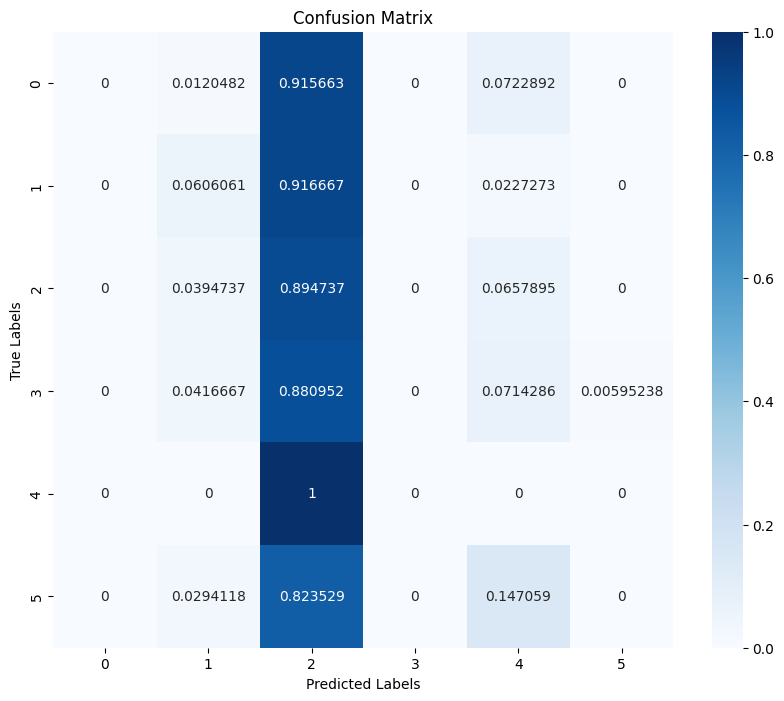

Epoch 12, Validation Loss: 1.7320, Accuracy: 0.2496, F1 Score: 0.1307
Val F1 Score Per Class  [0.         0.10322581 0.40657698 0.         0.         0.        ]


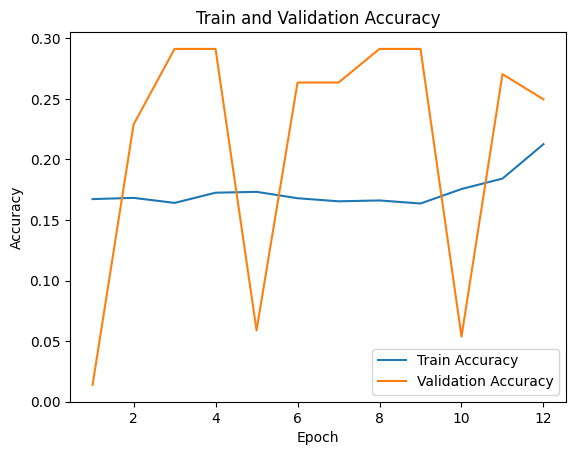

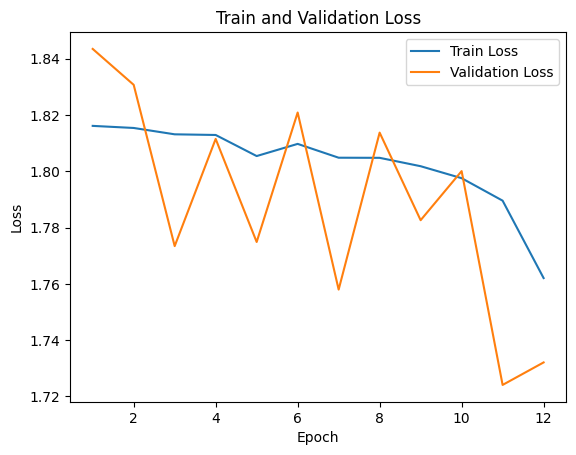

Epoch 13, Train Loss: 1.7460, Accuracy: 0.2231, F1 Score: 0.1985
Train F1 Score Per Class  [0.14499606 0.14773127 0.14710145 0.22001889 0.40107283 0.13210568]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.49it/s, loss=1.77]

[tensor([-0.2401, -0.0321, -0.3278, -0.2889, -0.3280, -0.2219], device='cuda:0'), tensor([-0.1283,  0.0140, -0.1860, -0.1608, -0.1793, -0.0922], device='cuda:0'), tensor([-0.1013,  0.0578, -0.1403, -0.1187, -1.0310, -0.0579], device='cuda:0'), tensor([-0.1739,  0.0369, -0.2047, -0.1786, -0.7980, -0.1662], device='cuda:0'), tensor([-0.1700,  0.0339, -0.2024, -0.1746, -1.4411, -0.1556], device='cuda:0'), tensor([-0.2792, -0.0614, -0.3549, -0.3244, -1.5528, -0.2777], device='cuda:0'), tensor([-0.1549,  0.0282, -0.1883, -0.1603,  0.1129, -0.1345], device='cuda:0'), tensor([-0.2088,  0.0291, -0.2415, -0.2108,  0.0634, -0.2120], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.48it/s, loss=1.84]

[tensor([-0.1673, -0.0625, -0.2839, -0.2619,  0.3398, -0.1216], device='cuda:0'), tensor([-0.2584, -0.0237, -0.3210, -0.2847, -0.4579, -0.2788], device='cuda:0'), tensor([ 0.0912,  0.1172,  0.0122,  0.0355, -2.3157,  0.2347], device='cuda:0'), tensor([-0.1697,  0.0210, -0.2190, -0.1932, -0.7477, -0.1388], device='cuda:0'), tensor([ 0.1357,  0.0979,  0.0147,  0.0418, -2.6970,  0.3178], device='cuda:0'), tensor([-0.2734, -0.0040, -0.3050, -0.2747, -0.4800, -0.2996], device='cuda:0'), tensor([ 0.1118,  0.1126,  0.0175,  0.0407, -1.1967,  0.2535], device='cuda:0'), tensor([-0.0475,  0.0944, -0.1001, -0.0697, -0.4648,  0.0183], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.44it/s, loss=1.67]

[tensor([-0.1231,  0.0606, -0.1587, -0.1325, -0.1670, -0.0947], device='cuda:0'), tensor([-0.1471,  0.0728, -0.1746, -0.1382, -0.8816, -0.1433], device='cuda:0'), tensor([ 6.2431e-02,  9.1570e-02, -3.6547e-02,  6.0440e-04, -8.9996e-01,
         1.9487e-01], device='cuda:0'), tensor([ 0.1349,  0.1362,  0.0504,  0.0769, -1.2461,  0.2810], device='cuda:0'), tensor([ 0.0552,  0.1032, -0.0029,  0.0277, -2.4243,  0.1548], device='cuda:0'), tensor([-0.1183,  0.0240, -0.1787, -0.1556, -1.4940, -0.0579], device='cuda:0'), tensor([-0.1200,  0.0293, -0.1855, -0.1538, -1.0347, -0.0873], device='cuda:0'), tensor([-0.1558,  0.0690, -0.1711, -0.1432, -0.8495, -0.1543], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.43it/s, loss=1.77]

[tensor([-0.0276,  0.0820, -0.0907, -0.0613, -0.5522,  0.0527], device='cuda:0'), tensor([-0.3479, -0.0485, -0.3909, -0.3559,  0.6986, -0.4002], device='cuda:0'), tensor([-0.1656,  0.0402, -0.2037, -0.1768,  0.0753, -0.1458], device='cuda:0'), tensor([-0.3266, -0.0257, -0.3603, -0.3278,  0.0212, -0.3755], device='cuda:0'), tensor([-0.0202,  0.0923, -0.0716, -0.0445, -0.8020,  0.0634], device='cuda:0'), tensor([-0.0524,  0.0972, -0.0908, -0.0641, -1.4131,  0.0089], device='cuda:0'), tensor([ 0.0869,  0.1369,  0.0304,  0.0569, -1.6001,  0.1993], device='cuda:0'), tensor([-0.2695,  0.0197, -0.2770, -0.2530, -0.9145, -0.3107], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.45it/s, loss=1.73]

[tensor([-0.0711,  0.0125, -0.1700, -0.1419, -0.6521, -0.0133], device='cuda:0'), tensor([-5.7338e-02,  1.0376e-01, -1.0983e-01, -6.2819e-02, -3.5770e-01,
         2.2415e-05], device='cuda:0'), tensor([ 0.0195,  0.1214, -0.0317, -0.0014, -0.8851,  0.0980], device='cuda:0'), tensor([-0.3404, -0.0148, -0.3579, -0.3260, -0.5451, -0.4188], device='cuda:0'), tensor([-0.2039, -0.0284, -0.2872, -0.2578, -0.4418, -0.1687], device='cuda:0'), tensor([-0.1751,  0.0018, -0.2320, -0.2087, -0.6983, -0.1423], device='cuda:0'), tensor([-0.1561,  0.0241, -0.2102, -0.1861, -0.0340, -0.1246], device='cuda:0'), tensor([-0.0259,  0.0659, -0.0971, -0.0705, -1.7151,  0.0676], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.42it/s, loss=1.9]

[tensor([-0.1121,  0.0735, -0.1393, -0.1006, -0.1223, -0.0939], device='cuda:0'), tensor([-0.2205, -0.0036, -0.2746, -0.2478, -0.5448, -0.2100], device='cuda:0'), tensor([ 1.9838e-02,  1.3437e-01, -2.5874e-02,  1.0927e-04, -9.3709e-01,
         9.1829e-02], device='cuda:0'), tensor([-0.1264,  0.0309, -0.1914, -0.1603, -0.0821, -0.0958], device='cuda:0'), tensor([-0.0188,  0.0125, -0.1433, -0.1214, -1.2184,  0.1134], device='cuda:0'), tensor([-9.9532e-02,  2.3783e-03, -1.8909e-01, -1.6110e-01, -2.7786e+00,
        -1.9993e-02], device='cuda:0'), tensor([-0.1163,  0.0398, -0.1628, -0.1323, -1.3177, -0.0838], device='cuda:0'), tensor([-0.2072, -0.0024, -0.2309, -0.2034, -0.3129, -0.2327], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.44it/s, loss=1.73]

[tensor([ 0.0831,  0.1277,  0.0132,  0.0461, -1.0355,  0.2109], device='cuda:0'), tensor([ 0.0396,  0.0887, -0.0082,  0.0228, -2.3511,  0.1240], device='cuda:0'), tensor([-0.0036,  0.0577, -0.0931, -0.0692, -0.6748,  0.0987], device='cuda:0'), tensor([-0.1019,  0.0127, -0.1812, -0.1446, -0.3967, -0.0806], device='cuda:0'), tensor([-0.3236, -0.0802, -0.4245, -0.3750, -0.5535, -0.3244], device='cuda:0'), tensor([ 0.1842,  0.1515,  0.0937,  0.1265, -2.9455,  0.3345], device='cuda:0'), tensor([ 0.0684,  0.1233, -0.0074,  0.0246, -1.9408,  0.1768], device='cuda:0'), tensor([-0.1248,  0.0208, -0.1898, -0.1570, -0.5506, -0.0642], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.44it/s, loss=1.73]

[tensor([-0.2384,  0.0336, -0.2531, -0.2222, -0.1113, -0.2712], device='cuda:0'), tensor([-0.0199,  0.1005, -0.0646, -0.0392, -2.2317,  0.0552], device='cuda:0'), tensor([-0.2527,  0.0088, -0.2746, -0.2460,  0.1984, -0.2791], device='cuda:0'), tensor([-0.2387,  0.0328, -0.2604, -0.2300, -1.1792, -0.2691], device='cuda:0'), tensor([-0.1451,  0.0429, -0.2054, -0.1688, -1.1280, -0.1118], device='cuda:0'), tensor([ 0.3251,  0.2488,  0.2411,  0.2776, -2.3233,  0.5455], device='cuda:0'), tensor([-0.1429,  0.0538, -0.1736, -0.1458, -0.3010, -0.1288], device='cuda:0'), tensor([ 0.3720,  0.1774,  0.2202,  0.2496, -3.1594,  0.6578], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.44it/s, loss=1.81]

[tensor([-0.2772, -0.0103, -0.3198, -0.2873, -0.2621, -0.3038], device='cuda:0'), tensor([-0.1130,  0.0829, -0.1425, -0.1104, -1.1290, -0.0844], device='cuda:0'), tensor([-0.1315,  0.0216, -0.1517, -0.1250,  0.1705, -0.1103], device='cuda:0'), tensor([-0.1452,  0.0324, -0.1924, -0.1692,  0.1933, -0.1042], device='cuda:0'), tensor([-0.2123,  0.0253, -0.2454, -0.2155, -0.8973, -0.2165], device='cuda:0'), tensor([-0.2354,  0.0396, -0.2439, -0.2173,  0.4649, -0.2713], device='cuda:0'), tensor([-0.3789, -0.1129, -0.4943, -0.4445, -0.1533, -0.3994], device='cuda:0'), tensor([-1.8285e-01, -5.5651e-04, -2.5844e-01, -2.2343e-01, -1.5246e+00,
        -1.5538e-01], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.44it/s, loss=1.74]

[tensor([ 0.0019,  0.0719, -0.0616, -0.0436, -1.2685,  0.1084], device='cuda:0'), tensor([ 0.0371,  0.0532, -0.0675, -0.0516, -2.1701,  0.1777], device='cuda:0'), tensor([-0.1386, -0.0503, -0.2814, -0.2478, -2.1515, -0.0527], device='cuda:0'), tensor([-0.2341,  0.0250, -0.2631, -0.2330, -0.7351, -0.2572], device='cuda:0'), tensor([-0.2011,  0.0402, -0.2185, -0.1990, -1.1675, -0.2107], device='cuda:0'), tensor([-2.9718e-01, -1.7535e-04, -3.2037e-01, -2.8891e-01, -2.6978e-01,
        -3.6719e-01], device='cuda:0'), tensor([ 0.0347,  0.0663, -0.0411, -0.0082, -1.0849,  0.1287], device='cuda:0'), tensor([-0.1035,  0.0722, -0.1388, -0.1102, -0.3327, -0.0627], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.45it/s, loss=1.82]

[tensor([-6.5254e-04,  1.0517e-01, -4.7646e-02, -1.9989e-02, -9.7567e-01,
         8.1918e-02], device='cuda:0'), tensor([-0.0543,  0.0894, -0.1039, -0.0691, -0.8724,  0.0108], device='cuda:0'), tensor([-0.1637,  0.0186, -0.2265, -0.1948, -1.0608, -0.1333], device='cuda:0'), tensor([-0.3946, -0.0800, -0.4618, -0.4205, -0.8513, -0.4523], device='cuda:0'), tensor([-0.1827,  0.0277, -0.2112, -0.1834,  0.0554, -0.1933], device='cuda:0'), tensor([-0.0985,  0.0200, -0.1930, -0.1563, -0.4459, -0.0167], device='cuda:0'), tensor([-0.0966, -0.0090, -0.1900, -0.1613, -0.0784, -0.0530], device='cuda:0'), tensor([-0.2101,  0.0103, -0.2650, -0.2333, -0.2648, -0.2077], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.45it/s, loss=1.74]

[tensor([-0.2930, -0.0216, -0.3439, -0.3099,  0.3676, -0.3190], device='cuda:0'), tensor([-0.2353, -0.0484, -0.3200, -0.2834,  0.4529, -0.2191], device='cuda:0'), tensor([-0.2501,  0.0062, -0.2815, -0.2557, -0.0766, -0.2691], device='cuda:0'), tensor([ 0.0458,  0.1206, -0.0119,  0.0181, -0.9300,  0.1488], device='cuda:0'), tensor([-0.0817,  0.0540, -0.1535, -0.1259, -2.4184, -0.0187], device='cuda:0'), tensor([-0.0622,  0.0486, -0.1208, -0.0969, -0.8415,  0.0060], device='cuda:0'), tensor([-0.1114,  0.0708, -0.1463, -0.1165, -0.4534, -0.0792], device='cuda:0'), tensor([-0.1828,  0.0273, -0.2342, -0.2037, -0.6984, -0.1657], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.45it/s, loss=1.71]

[tensor([-0.1179,  0.0388, -0.1826, -0.1487, -0.4461, -0.0623], device='cuda:0'), tensor([-0.0399,  0.0814, -0.0913, -0.0608, -0.4067,  0.0365], device='cuda:0'), tensor([-0.0362,  0.0679, -0.0864, -0.0747, -1.5689,  0.0419], device='cuda:0'), tensor([-0.1056,  0.0112, -0.1916, -0.1619,  0.0868, -0.0393], device='cuda:0'), tensor([-0.1136,  0.0449, -0.1788, -0.1469, -0.0555, -0.0656], device='cuda:0'), tensor([-0.0222,  0.1026, -0.0632, -0.0356, -1.0003,  0.0507], device='cuda:0'), tensor([ 0.1056,  0.1027,  0.0132,  0.0391, -1.3619,  0.2692], device='cuda:0'), tensor([-0.0240,  0.0661, -0.0800, -0.0509, -0.3262,  0.0652], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.43it/s, loss=1.77]

[tensor([-0.2398, -0.0460, -0.3113, -0.2917, -0.9978, -0.2156], device='cuda:0'), tensor([-0.2443,  0.0136, -0.2808, -0.2478, -0.7101, -0.2724], device='cuda:0'), tensor([ 0.0504,  0.1290, -0.0029,  0.0285, -0.8995,  0.1426], device='cuda:0'), tensor([-0.1912, -0.0182, -0.2665, -0.2498, -1.1757, -0.1626], device='cuda:0'), tensor([ 0.0330,  0.0535, -0.0714, -0.0501, -0.5314,  0.1514], device='cuda:0'), tensor([-0.0441,  0.0545, -0.1253, -0.0966, -1.9077,  0.0409], device='cuda:0'), tensor([-0.3625, -0.0442, -0.4026, -0.3667,  0.3921, -0.4189], device='cuda:0'), tensor([-0.0397,  0.0525, -0.1050, -0.0713, -0.9580,  0.0208], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.43it/s, loss=1.75]

[tensor([-0.0518,  0.1197, -0.0637, -0.0384, -0.7284, -0.0146], device='cuda:0'), tensor([-0.3339, -0.0060, -0.3441, -0.3133, -0.0405, -0.3961], device='cuda:0'), tensor([-0.0711,  0.0883, -0.1058, -0.0803, -0.4194, -0.0236], device='cuda:0'), tensor([-0.1786,  0.0462, -0.2068, -0.1756, -0.1841, -0.1768], device='cuda:0'), tensor([-0.0538,  0.0705, -0.0793, -0.0542, -1.4033, -0.0035], device='cuda:0'), tensor([-0.1165,  0.0102, -0.1951, -0.1680, -1.0632, -0.0557], device='cuda:0'), tensor([-0.1469,  0.0516, -0.1776, -0.1522, -1.6516, -0.1256], device='cuda:0'), tensor([-0.1661,  0.0409, -0.1994, -0.1727,  0.2468, -0.1591], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.41it/s, loss=1.73]

[tensor([ 0.0186,  0.1432, -0.0265,  0.0160, -0.8680,  0.0989], device='cuda:0'), tensor([-0.2991, -0.0121, -0.3190, -0.2930,  0.0475, -0.3385], device='cuda:0'), tensor([ 0.1261,  0.1371,  0.0477,  0.0729, -1.0723,  0.2775], device='cuda:0'), tensor([-0.2676,  0.0160, -0.2769, -0.2483,  0.2477, -0.3086], device='cuda:0'), tensor([-0.1432,  0.0709, -0.1706, -0.1414, -1.5672, -0.1325], device='cuda:0'), tensor([-0.2161,  0.0382, -0.2355, -0.2129, -0.5150, -0.2318], device='cuda:0'), tensor([-0.2428,  0.0068, -0.2790, -0.2476, -0.3198, -0.2470], device='cuda:0'), tensor([-0.2810, -0.0273, -0.3336, -0.3034, -0.5852, -0.2957], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:23,  2.43it/s, loss=1.68]

[tensor([-0.0387,  0.1000, -0.0663, -0.0374, -0.3679,  0.0185], device='cuda:0'), tensor([-0.0232,  0.0543, -0.1053, -0.0767, -1.1646,  0.0851], device='cuda:0'), tensor([ 0.0118,  0.0970, -0.0667, -0.0214, -0.7101,  0.1148], device='cuda:0'), tensor([-0.2206, -0.0334, -0.2946, -0.2670,  0.1945, -0.1907], device='cuda:0'), tensor([-0.1708, -0.0169, -0.2529, -0.2229, -2.3158, -0.1197], device='cuda:0'), tensor([-0.1190, -0.0141, -0.2256, -0.1952, -0.4302, -0.0332], device='cuda:0'), tensor([-0.1232,  0.0205, -0.1999, -0.1784, -1.4627, -0.0642], device='cuda:0'), tensor([ 0.0208,  0.0792, -0.0637, -0.0358, -1.1943,  0.1287], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.43it/s, loss=1.75]

[tensor([-0.2547,  0.0078, -0.2938, -0.2589,  0.2359, -0.2761], device='cuda:0'), tensor([-0.1029,  0.0388, -0.1724, -0.1358, -0.8237, -0.0629], device='cuda:0'), tensor([-0.1407,  0.0380, -0.1686, -0.1377,  0.3838, -0.1353], device='cuda:0'), tensor([-0.1976, -0.0064, -0.2604, -0.2332,  0.6073, -0.1884], device='cuda:0'), tensor([ 0.0111,  0.0983, -0.0432, -0.0191, -1.7153,  0.0976], device='cuda:0'), tensor([ 0.1092,  0.1407,  0.0553,  0.0738, -0.9514,  0.2387], device='cuda:0'), tensor([-0.2326,  0.0356, -0.2507, -0.2210,  0.0672, -0.2618], device='cuda:0'), tensor([-0.1440, -0.0042, -0.2316, -0.2022, -0.4043, -0.0890], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.44it/s, loss=1.79]

[tensor([ 0.0831,  0.1258,  0.0084,  0.0324, -1.8940,  0.2053], device='cuda:0'), tensor([-0.3854, -0.0327, -0.4026, -0.3699, -0.4571, -0.4659], device='cuda:0'), tensor([-0.0262,  0.1087, -0.0500, -0.0219, -0.7037,  0.0283], device='cuda:0'), tensor([-0.2387, -0.0221, -0.2894, -0.2644, -0.0863, -0.2718], device='cuda:0'), tensor([-0.1361,  0.0846, -0.1577, -0.1274, -0.9271, -0.1291], device='cuda:0'), tensor([ 0.1512,  0.1193,  0.0552,  0.0749, -1.8583,  0.3335], device='cuda:0'), tensor([-0.3209, -0.0477, -0.3587, -0.3270,  0.2608, -0.3679], device='cuda:0'), tensor([-0.2274,  0.0266, -0.2447, -0.2149, -1.5122, -0.2330], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.44it/s, loss=1.75]

[tensor([-0.1634,  0.0371, -0.2048, -0.1752, -0.8892, -0.1427], device='cuda:0'), tensor([-0.2821, -0.0036, -0.3106, -0.2843, -0.7844, -0.3129], device='cuda:0'), tensor([-0.0115,  0.0531, -0.0970, -0.0721, -0.8577,  0.0621], device='cuda:0'), tensor([-0.0303,  0.1074, -0.0680, -0.0350, -0.4169,  0.0219], device='cuda:0'), tensor([-0.1702,  0.0538, -0.1985, -0.1628,  0.0716, -0.1577], device='cuda:0'), tensor([ 0.0667,  0.1199,  0.0069,  0.0359, -1.2498,  0.1790], device='cuda:0'), tensor([-0.0466,  0.0272, -0.1470, -0.1188, -2.2383,  0.0581], device='cuda:0'), tensor([-0.1907,  0.0180, -0.2266, -0.2001, -0.4616, -0.1858], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.43it/s, loss=1.78]

[tensor([ 0.0404,  0.0329, -0.1099, -0.0777, -0.6661,  0.1624], device='cuda:0'), tensor([ 0.0084,  0.0956, -0.0570, -0.0254, -0.5954,  0.1066], device='cuda:0'), tensor([-0.3493, -0.0233, -0.3638, -0.3327,  0.0452, -0.4139], device='cuda:0'), tensor([-0.0092,  0.0527, -0.0942, -0.0696, -0.3984,  0.1004], device='cuda:0'), tensor([-0.0542,  0.0506, -0.1211, -0.0998, -0.8800,  0.0318], device='cuda:0'), tensor([-0.2307, -0.0627, -0.3390, -0.3039,  0.2507, -0.2470], device='cuda:0'), tensor([ 0.0877,  0.1237,  0.0089,  0.0527, -1.4822,  0.2130], device='cuda:0'), tensor([-0.0906,  0.0487, -0.1444, -0.1220, -0.2155, -0.0276], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:20,  2.45it/s, loss=1.71]

[tensor([-0.1196,  0.0515, -0.1687, -0.1416, -0.3204, -0.0940], device='cuda:0'), tensor([ 0.0524,  0.1285,  0.0007,  0.0276, -0.6216,  0.1310], device='cuda:0'), tensor([-0.1808,  0.0309, -0.2180, -0.1922,  0.1257, -0.1685], device='cuda:0'), tensor([-0.0185,  0.0818, -0.0614, -0.0362, -0.6816,  0.0532], device='cuda:0'), tensor([-0.2038,  0.0191, -0.2274, -0.1981,  0.3555, -0.2267], device='cuda:0'), tensor([-0.1794,  0.0277, -0.2261, -0.1992, -1.1976, -0.1782], device='cuda:0'), tensor([ 0.0626,  0.1235,  0.0193,  0.0487, -0.9194,  0.1426], device='cuda:0'), tensor([ 0.0777,  0.1445,  0.0235,  0.0507, -1.3025,  0.1927], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.44it/s, loss=1.75]

[tensor([-0.1966, -0.0377, -0.2548, -0.2342, -1.0047, -0.1653], device='cuda:0'), tensor([-0.1860, -0.0408, -0.2939, -0.2590, -0.0149, -0.1321], device='cuda:0'), tensor([-0.0923,  0.0554, -0.1625, -0.1281, -1.5277, -0.0388], device='cuda:0'), tensor([-0.1552,  0.0510, -0.1892, -0.1609, -0.8298, -0.1348], device='cuda:0'), tensor([-0.1771,  0.0217, -0.2382, -0.2082, -4.4604, -0.1568], device='cuda:0'), tensor([-0.0993,  0.0765, -0.1359, -0.1015, -0.1442, -0.0668], device='cuda:0'), tensor([-0.2266,  0.0209, -0.2458, -0.2172,  0.2454, -0.2495], device='cuda:0'), tensor([-0.1046,  0.0065, -0.2082, -0.1805, -0.5543, -0.0298], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:20,  2.44it/s, loss=1.78]

[tensor([-0.0245,  0.0960, -0.0610, -0.0309, -0.9999,  0.0403], device='cuda:0'), tensor([-0.1219,  0.0886, -0.1550, -0.1216, -0.6760, -0.1102], device='cuda:0'), tensor([-0.0860,  0.0466, -0.1499, -0.1261, -1.0298, -0.0285], device='cuda:0'), tensor([-0.1783, -0.0257, -0.2715, -0.2373, -0.6202, -0.1296], device='cuda:0'), tensor([-0.2741, -0.0077, -0.3133, -0.2866, -1.5453, -0.3076], device='cuda:0'), tensor([-0.1365,  0.0716, -0.1634, -0.1311, -0.6334, -0.1202], device='cuda:0'), tensor([-0.2245,  0.0249, -0.2559, -0.2256, -0.2693, -0.2382], device='cuda:0'), tensor([ 0.1658,  0.0670,  0.0026,  0.0349, -2.3587,  0.3472], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.44it/s, loss=1.8]

[tensor([-0.0468,  0.0571, -0.1188, -0.0899, -1.1372,  0.0324], device='cuda:0'), tensor([-0.3357, -0.0419, -0.3830, -0.3464,  0.3123, -0.3748], device='cuda:0'), tensor([-0.2330,  0.0327, -0.2374, -0.2130, -0.4099, -0.2590], device='cuda:0'), tensor([-0.0166,  0.0985, -0.0536, -0.0261, -0.8414,  0.0541], device='cuda:0'), tensor([-0.1706,  0.0400, -0.1895, -0.1555,  0.1598, -0.1820], device='cuda:0'), tensor([-0.1484,  0.0210, -0.2053, -0.1741,  0.0880, -0.1091], device='cuda:0'), tensor([-0.1566,  0.0247, -0.2053, -0.1763, -0.3296, -0.1202], device='cuda:0'), tensor([ 0.0068,  0.0913, -0.0365, -0.0214, -0.4391,  0.0980], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.44it/s, loss=1.73]

[tensor([-0.0981,  0.0535, -0.1573, -0.1262, -0.0820, -0.0590], device='cuda:0'), tensor([-0.2323,  0.0297, -0.2507, -0.2210, -0.5244, -0.2497], device='cuda:0'), tensor([ 0.6739,  0.2225,  0.3694,  0.4049, -3.8631,  1.0893], device='cuda:0'), tensor([ 0.0556,  0.0846, -0.0267, -0.0108, -0.7534,  0.1548], device='cuda:0'), tensor([-0.0975,  0.0196, -0.1667, -0.1387,  0.0080, -0.0459], device='cuda:0'), tensor([ 0.0346,  0.1165, -0.0269,  0.0052, -1.1926,  0.1406], device='cuda:0'), tensor([-0.0336,  0.0562, -0.1147, -0.0874, -1.7208,  0.0638], device='cuda:0'), tensor([-0.0394,  0.0567, -0.1139, -0.0905, -1.7807,  0.0537], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:18,  2.45it/s, loss=1.79]

[tensor([ 0.2857,  0.1845,  0.1639,  0.1993, -1.9202,  0.5144], device='cuda:0'), tensor([-0.1377,  0.0319, -0.1642, -0.1366,  0.1612, -0.1210], device='cuda:0'), tensor([-0.2087,  0.0204, -0.2381, -0.2071,  0.4542, -0.2204], device='cuda:0'), tensor([-0.0553,  0.0901, -0.0940, -0.0642, -0.1290,  0.0015], device='cuda:0'), tensor([-0.1351,  0.0531, -0.1683, -0.1472, -0.4193, -0.1111], device='cuda:0'), tensor([-0.0448,  0.0614, -0.1376, -0.0909, -0.7532,  0.0504], device='cuda:0'), tensor([-0.0296,  0.0918, -0.0725, -0.0465, -0.5108,  0.0389], device='cuda:0'), tensor([-0.0728,  0.0786, -0.1171, -0.0892, -1.6921, -0.0167], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.44it/s, loss=1.78]

[tensor([-0.2940, -0.0540, -0.3506, -0.3300,  0.2364, -0.3048], device='cuda:0'), tensor([-0.0862,  0.0182, -0.1786, -0.1536, -0.5683, -0.0012], device='cuda:0'), tensor([ 0.1366,  0.1334,  0.0505,  0.0827, -3.5109,  0.3003], device='cuda:0'), tensor([-0.1164,  0.0577, -0.1480, -0.1249, -0.2829, -0.0749], device='cuda:0'), tensor([-0.1370,  0.0323, -0.1899, -0.1574, -0.2026, -0.1036], device='cuda:0'), tensor([-0.1750,  0.0351, -0.2227, -0.1914, -0.5129, -0.1643], device='cuda:0'), tensor([-0.2532, -0.0529, -0.3502, -0.3140,  0.7000, -0.2327], device='cuda:0'), tensor([-0.0621,  0.0504, -0.1088, -0.0823, -1.2315, -0.0241], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.45it/s, loss=1.65]

[tensor([-0.0488,  0.0682, -0.1165, -0.0859, -1.8742,  0.0325], device='cuda:0'), tensor([-0.3279, -0.0721, -0.4214, -0.3796, -0.2141, -0.3457], device='cuda:0'), tensor([-0.0174,  0.0780, -0.0852, -0.0596, -0.5499,  0.0717], device='cuda:0'), tensor([-0.0136,  0.0564, -0.0914, -0.0689, -0.7967,  0.0456], device='cuda:0'), tensor([-0.0929,  0.0951, -0.1132, -0.0863, -0.2723, -0.0762], device='cuda:0'), tensor([-0.1198,  0.0704, -0.1526, -0.1177, -0.3474, -0.0948], device='cuda:0'), tensor([ 0.0057,  0.1238, -0.0325, -0.0027, -0.7065,  0.0849], device='cuda:0'), tensor([-0.0922,  0.0553, -0.1467, -0.1129, -0.1690, -0.0346], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.44it/s, loss=1.74]

[tensor([-0.1475,  0.0477, -0.1870, -0.1600,  0.0338, -0.1256], device='cuda:0'), tensor([-0.2698,  0.0232, -0.2882, -0.2528, -0.6631, -0.3152], device='cuda:0'), tensor([-2.3475e-01,  2.1927e-05, -2.8172e-01, -2.5151e-01, -3.1940e-01,
        -2.3812e-01], device='cuda:0'), tensor([-0.1639, -0.0122, -0.2547, -0.2149, -1.4024, -0.1031], device='cuda:0'), tensor([-0.1276,  0.0614, -0.1571, -0.1306, -0.5823, -0.0958], device='cuda:0'), tensor([-0.2583, -0.0515, -0.3497, -0.3051,  0.3904, -0.2908], device='cuda:0'), tensor([-0.1265,  0.0414, -0.1964, -0.1584, -0.8645, -0.0800], device='cuda:0'), tensor([-0.1730,  0.0387, -0.2055, -0.1764,  0.5793, -0.1762], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.44it/s, loss=1.74]

[tensor([-0.0289,  0.0447, -0.1146, -0.0930, -2.8514,  0.0799], device='cuda:0'), tensor([-0.2119,  0.0106, -0.2405, -0.2105, -0.2072, -0.2264], device='cuda:0'), tensor([ 0.0338,  0.0839, -0.0574, -0.0261, -1.3263,  0.1486], device='cuda:0'), tensor([-0.2362, -0.0224, -0.2910, -0.2686, -0.8238, -0.2190], device='cuda:0'), tensor([-0.0980,  0.0633, -0.1314, -0.1053, -0.4768, -0.0587], device='cuda:0'), tensor([-0.1242,  0.0520, -0.1852, -0.1550, -0.0634, -0.1048], device='cuda:0'), tensor([-0.3214, -0.1148, -0.4609, -0.4180, -1.9094, -0.3136], device='cuda:0'), tensor([-0.0781,  0.0879, -0.1152, -0.0902, -1.6731, -0.0328], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.44it/s, loss=1.7]

[tensor([-0.1900,  0.0291, -0.1961, -0.1681, -0.4566, -0.2180], device='cuda:0'), tensor([-0.2531, -0.0027, -0.2936, -0.2640, -0.2444, -0.2612], device='cuda:0'), tensor([-0.2079, -0.0145, -0.2876, -0.2502, -1.0146, -0.2048], device='cuda:0'), tensor([-0.0372,  0.0874, -0.0899, -0.0600, -1.3574,  0.0351], device='cuda:0'), tensor([-0.0520,  0.0195, -0.1602, -0.1273, -1.7924,  0.0521], device='cuda:0'), tensor([ 4.5848e-02,  9.3877e-02, -2.0643e-02, -8.0573e-04, -1.9091e+00,
         1.6477e-01], device='cuda:0'), tensor([-0.0654,  0.0697, -0.1307, -0.0978, -1.4566,  0.0055], device='cuda:0'), tensor([-0.1020,  0.0635, -0.1419, -0.1133, -0.5800, -0.0679], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.45it/s, loss=1.73]

[tensor([-0.0478,  0.1048, -0.0864, -0.0547, -0.3917, -0.0007], device='cuda:0'), tensor([-0.1678,  0.0052, -0.2542, -0.2124, -0.9755, -0.1211], device='cuda:0'), tensor([ 0.0643,  0.1551,  0.0151,  0.0552, -1.1984,  0.1505], device='cuda:0'), tensor([-0.0925,  0.0500, -0.1503, -0.1209, -0.4946, -0.0383], device='cuda:0'), tensor([-0.1423,  0.0298, -0.2049, -0.1707, -1.2145, -0.1083], device='cuda:0'), tensor([ 0.0479,  0.0311, -0.1155, -0.0789, -1.1038,  0.2103], device='cuda:0'), tensor([-0.0721,  0.0399, -0.1168, -0.0941, -0.1413, -0.0086], device='cuda:0'), tensor([ 0.0277,  0.0990, -0.0532, -0.0179, -0.5474,  0.1383], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.44it/s, loss=1.75]

[tensor([ 0.0690,  0.0666, -0.0459, -0.0194, -2.0377,  0.2241], device='cuda:0'), tensor([ 0.1371,  0.0761,  0.0051,  0.0291, -1.3550,  0.3264], device='cuda:0'), tensor([-0.2118,  0.0438, -0.2332, -0.2015, -0.0742, -0.2283], device='cuda:0'), tensor([-0.1556,  0.0194, -0.2005, -0.1671, -0.2913, -0.1373], device='cuda:0'), tensor([-0.2508, -0.0564, -0.3374, -0.2922, -0.3813, -0.2618], device='cuda:0'), tensor([-0.0700,  0.0537, -0.1349, -0.1103, -0.8888,  0.0017], device='cuda:0'), tensor([-0.1099,  0.0367, -0.1564, -0.1318, -0.4304, -0.0874], device='cuda:0'), tensor([ 0.0123,  0.0794, -0.0599, -0.0384, -0.9787,  0.1240], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.44it/s, loss=1.68]

[tensor([ 1.4638e-01,  8.0102e-02,  1.0491e-03,  3.7559e-02, -3.3412e+00,
         3.4924e-01], device='cuda:0'), tensor([ 0.0271,  0.1119, -0.0124,  0.0148, -0.5912,  0.1089], device='cuda:0'), tensor([-0.2645, -0.0113, -0.3109, -0.2794,  0.1214, -0.2793], device='cuda:0'), tensor([-0.0966,  0.0437, -0.1528, -0.1260, -0.7532, -0.0394], device='cuda:0'), tensor([-0.0182,  0.1219, -0.0482, -0.0203, -0.7400,  0.0359], device='cuda:0'), tensor([-0.0774,  0.0378, -0.1469, -0.1234, -0.3908, -0.0055], device='cuda:0'), tensor([-0.1298,  0.0526, -0.1776, -0.1412, -2.4478, -0.0936], device='cuda:0'), tensor([-0.0266,  0.0895, -0.0893, -0.0513, -1.2946,  0.0554], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.43it/s, loss=1.7]

[tensor([-0.1954,  0.0099, -0.2490, -0.2215, -0.4390, -0.1804], device='cuda:0'), tensor([-0.2222,  0.0169, -0.2482, -0.2193, -1.1453, -0.2217], device='cuda:0'), tensor([-0.2741, -0.0403, -0.3524, -0.3140, -1.0987, -0.2816], device='cuda:0'), tensor([-0.0793,  0.0792, -0.1270, -0.0945, -0.9576, -0.0363], device='cuda:0'), tensor([-0.0446,  0.0068, -0.1795, -0.1460, -1.4020,  0.0611], device='cuda:0'), tensor([ 0.0478, -0.0094, -0.1646, -0.1258, -1.4881,  0.1880], device='cuda:0'), tensor([-0.1541,  0.0195, -0.2152, -0.1856, -0.7507, -0.1120], device='cuda:0'), tensor([-0.0904,  0.0686, -0.1473, -0.1134, -0.4961, -0.0428], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.44it/s, loss=1.79]

[tensor([-0.1603,  0.0043, -0.2257, -0.2016, -0.4142, -0.1240], device='cuda:0'), tensor([-0.1790,  0.0167, -0.2346, -0.2051, -0.4999, -0.1587], device='cuda:0'), tensor([ 0.0134,  0.1050, -0.0470, -0.0223, -1.2248,  0.1046], device='cuda:0'), tensor([-0.1084,  0.0326, -0.1731, -0.1502, -0.3873, -0.0570], device='cuda:0'), tensor([-0.1863,  0.0369, -0.2218, -0.1874, -0.3464, -0.1830], device='cuda:0'), tensor([-0.1148,  0.0660, -0.1651, -0.1261, -0.5691, -0.0826], device='cuda:0'), tensor([-0.2435,  0.0285, -0.2507, -0.2296, -0.3025, -0.2720], device='cuda:0'), tensor([-0.1133,  0.0102, -0.1382, -0.1133, -1.4696, -0.1009], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.44it/s, loss=1.73]

[tensor([-0.0237,  0.0369, -0.1229, -0.0955, -1.1766,  0.0852], device='cuda:0'), tensor([-0.1655,  0.0148, -0.2375, -0.1956, -0.9976, -0.1329], device='cuda:0'), tensor([-0.1976, -0.0010, -0.2384, -0.2079, -0.8360, -0.1927], device='cuda:0'), tensor([-0.0978, -0.0337, -0.2488, -0.2086, -0.8239,  0.0066], device='cuda:0'), tensor([ 0.0641,  0.1137, -0.0056,  0.0154, -4.1116,  0.1934], device='cuda:0'), tensor([-0.2691,  0.0151, -0.2828, -0.2484, -0.3818, -0.3199], device='cuda:0'), tensor([-0.0551,  0.0187, -0.1564, -0.1319, -0.6719,  0.0542], device='cuda:0'), tensor([-0.2499, -0.0327, -0.3271, -0.2890, -0.7341, -0.2438], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.45it/s, loss=1.73]

[tensor([-0.2114,  0.0513, -0.2217, -0.1947, -1.0907, -0.2404], device='cuda:0'), tensor([ 0.0633,  0.0717, -0.0522, -0.0288, -2.5830,  0.2105], device='cuda:0'), tensor([-0.1163,  0.0463, -0.1669, -0.1418, -0.3464, -0.0723], device='cuda:0'), tensor([-0.0543,  0.0443, -0.1254, -0.1052, -0.3894,  0.0323], device='cuda:0'), tensor([ 0.0982,  0.1655,  0.0452,  0.0689, -2.6237,  0.2108], device='cuda:0'), tensor([-0.0125,  0.1360, -0.0364, -0.0077, -0.8041,  0.0455], device='cuda:0'), tensor([-0.1169,  0.0838, -0.1302, -0.1061, -0.2293, -0.1014], device='cuda:0'), tensor([-0.1793,  0.0508, -0.2069, -0.1754, -0.2249, -0.1828], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.46it/s, loss=1.65]

[tensor([-0.0395,  0.0786, -0.0789, -0.0545, -0.8580,  0.0230], device='cuda:0'), tensor([-0.0090,  0.0828, -0.0831, -0.0496, -0.7873,  0.0826], device='cuda:0'), tensor([ 0.1329,  0.1280,  0.0535,  0.0759, -2.0402,  0.2959], device='cuda:0'), tensor([ 0.0311,  0.1075, -0.0180,  0.0121, -0.9617,  0.1155], device='cuda:0'), tensor([-0.0366,  0.0740, -0.0794, -0.0525, -0.8517,  0.0264], device='cuda:0'), tensor([-0.0813,  0.0511, -0.1448, -0.1158, -2.8304, -0.0128], device='cuda:0'), tensor([-0.0607,  0.0739, -0.1186, -0.0861, -0.4266,  0.0102], device='cuda:0'), tensor([-0.2179,  0.0208, -0.2567, -0.2337, -2.0905, -0.2218], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.44it/s, loss=1.74]

[tensor([-0.2158,  0.0278, -0.2447, -0.2184, -0.0990, -0.2262], device='cuda:0'), tensor([-0.2314,  0.0574, -0.2374, -0.2045,  0.0700, -0.2671], device='cuda:0'), tensor([-0.0561,  0.0545, -0.1122, -0.0808, -0.4843, -0.0010], device='cuda:0'), tensor([-0.2294,  0.0244, -0.2496, -0.2183, -0.4636, -0.2533], device='cuda:0'), tensor([ 0.0930,  0.1503,  0.0481,  0.0761, -1.1432,  0.2132], device='cuda:0'), tensor([-0.0943,  0.1062, -0.1155, -0.0831, -1.2425, -0.0714], device='cuda:0'), tensor([-0.1138,  0.0287, -0.1678, -0.1372, -0.5113, -0.0728], device='cuda:0'), tensor([-0.2656,  0.0098, -0.2926, -0.2626, -0.1104, -0.2954], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.44it/s, loss=1.75]

[tensor([-0.4066, -0.0877, -0.4810, -0.4401, -0.8672, -0.4751], device='cuda:0'), tensor([-0.0096,  0.0847, -0.0726, -0.0421, -0.7391,  0.0521], device='cuda:0'), tensor([ 0.0817,  0.0738,  0.0040,  0.0275, -2.2041,  0.2227], device='cuda:0'), tensor([-0.0721,  0.0836, -0.1148, -0.0827, -1.2887, -0.0270], device='cuda:0'), tensor([ 0.0356,  0.1011, -0.0219,  0.0082, -1.4196,  0.1193], device='cuda:0'), tensor([-0.2467,  0.0052, -0.2780, -0.2506, -0.7337, -0.2615], device='cuda:0'), tensor([-0.1614,  0.0295, -0.2125, -0.1797, -0.0014, -0.1283], device='cuda:0'), tensor([-0.2013,  0.0567, -0.2145, -0.1826,  0.0385, -0.2272], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.43it/s, loss=1.83]

[tensor([-0.3557,  0.0013, -0.3566, -0.3245, -0.2575, -0.4433], device='cuda:0'), tensor([-0.3485, -0.0414, -0.3874, -0.3564,  0.5520, -0.3995], device='cuda:0'), tensor([-0.0436,  0.0874, -0.0944, -0.0584, -0.3795,  0.0263], device='cuda:0'), tensor([-0.1809,  0.0601, -0.1892, -0.1657, -0.9654, -0.1903], device='cuda:0'), tensor([-0.2437,  0.0224, -0.2621, -0.2338,  0.4102, -0.2681], device='cuda:0'), tensor([-0.3053, -0.0417, -0.3544, -0.3278, -1.1685, -0.3355], device='cuda:0'), tensor([-0.1570,  0.0151, -0.1790, -0.1445, -1.1025, -0.1539], device='cuda:0'), tensor([-0.2961, -0.0496, -0.3537, -0.3278,  0.7610, -0.3047], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:11,  2.45it/s, loss=1.69]

[tensor([ 0.1991,  0.0758,  0.0065,  0.0445, -2.6024,  0.4251], device='cuda:0'), tensor([ 6.6538e-02,  1.0431e-01, -8.0074e-04,  2.3719e-02, -1.0622e+00,
         2.0405e-01], device='cuda:0'), tensor([-0.1505,  0.0069, -0.2344, -0.2084, -0.7585, -0.0997], device='cuda:0'), tensor([-0.2760, -0.0056, -0.2964, -0.2755, -1.8481, -0.2996], device='cuda:0'), tensor([-0.1943,  0.0320, -0.2281, -0.1950, -0.7168, -0.1973], device='cuda:0'), tensor([-0.0552,  0.0677, -0.1164, -0.0880, -0.9124,  0.0185], device='cuda:0'), tensor([-0.2365, -0.0144, -0.2888, -0.2552,  0.2761, -0.2272], device='cuda:0'), tensor([-0.0545,  0.0273, -0.1465, -0.1205, -0.4827,  0.0422], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.45it/s, loss=1.72]

[tensor([-0.0995,  0.0470, -0.1610, -0.1317, -0.9897, -0.0374], device='cuda:0'), tensor([ 0.0573,  0.1059, -0.0101,  0.0134, -0.9854,  0.1809], device='cuda:0'), tensor([-0.0622,  0.0145, -0.1588, -0.1347, -0.6843,  0.0425], device='cuda:0'), tensor([ 0.0237,  0.0200, -0.1511, -0.1136, -1.2773,  0.1046], device='cuda:0'), tensor([-0.1363,  0.0163, -0.1937, -0.1718, -0.1698, -0.0808], device='cuda:0'), tensor([-1.2757e-01,  1.1903e-03, -2.3943e-01, -2.0093e-01, -2.0164e+00,
        -4.9336e-02], device='cuda:0'), tensor([-0.1458,  0.0454, -0.1906, -0.1566, -1.0550, -0.1207], device='cuda:0'), tensor([-0.1093,  0.0518, -0.1675, -0.1361, -0.5118, -0.0566], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.45it/s, loss=1.7]

[tensor([-0.1663,  0.0620, -0.1928, -0.1504, -1.1206, -0.1846], device='cuda:0'), tensor([-0.3019, -0.0391, -0.3412, -0.3155, -0.0753, -0.3158], device='cuda:0'), tensor([-0.2416,  0.0222, -0.2613, -0.2389, -1.8499, -0.2729], device='cuda:0'), tensor([ 0.1094,  0.1517,  0.0481,  0.0759, -2.2516,  0.2355], device='cuda:0'), tensor([ 0.0797,  0.0402, -0.0736, -0.0412, -1.3300,  0.2545], device='cuda:0'), tensor([-0.1696,  0.0536, -0.1804, -0.1513, -0.1393, -0.1789], device='cuda:0'), tensor([-0.0617,  0.0449, -0.1267, -0.0982, -0.5623, -0.0214], device='cuda:0'), tensor([-0.1410,  0.0196, -0.2014, -0.1789, -0.9598, -0.0938], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.40it/s, loss=1.69]

[tensor([-0.0288,  0.0866, -0.0925, -0.0610, -0.6783,  0.0476], device='cuda:0'), tensor([ 0.0204,  0.0849, -0.0345, -0.0134, -0.6958,  0.1224], device='cuda:0'), tensor([-0.1156,  0.0147, -0.1858, -0.1666, -0.6547, -0.0630], device='cuda:0'), tensor([-0.0987,  0.0657, -0.1429, -0.1176, -0.5618, -0.0470], device='cuda:0'), tensor([-0.3082,  0.0086, -0.3236, -0.2903, -0.6011, -0.3606], device='cuda:0'), tensor([-0.1405,  0.0321, -0.1943, -0.1682, -0.8777, -0.0954], device='cuda:0'), tensor([ 0.0585,  0.1393,  0.0150,  0.0355, -1.0711,  0.1662], device='cuda:0'), tensor([ 0.0631,  0.0568, -0.0572, -0.0229, -2.1333,  0.2244], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.42it/s, loss=1.82]

[tensor([-0.2470, -0.0085, -0.2868, -0.2643,  0.8392, -0.2589], device='cuda:0'), tensor([ 0.1897,  0.1184,  0.0683,  0.0916, -1.8254,  0.3849], device='cuda:0'), tensor([ 0.0307,  0.1130, -0.0151,  0.0095, -0.3825,  0.1201], device='cuda:0'), tensor([-0.1244,  0.0058, -0.1958, -0.1762, -1.4756, -0.0559], device='cuda:0'), tensor([-0.1542,  0.0487, -0.1928, -0.1655, -0.0668, -0.1643], device='cuda:0'), tensor([-0.1462,  0.0451, -0.1796, -0.1447,  0.0755, -0.1410], device='cuda:0'), tensor([-0.1283,  0.0234, -0.2081, -0.1655,  0.0121, -0.0718], device='cuda:0'), tensor([-0.1886,  0.0335, -0.2129, -0.1913, -0.7883, -0.1881], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.42it/s, loss=1.8]

[tensor([-0.3411, -0.0937, -0.4224, -0.3943,  0.5171, -0.3636], device='cuda:0'), tensor([-0.0957,  0.0418, -0.1543, -0.1318, -0.6088, -0.0337], device='cuda:0'), tensor([-0.0030,  0.1213, -0.0345, -0.0024, -0.6177,  0.0572], device='cuda:0'), tensor([-0.0752,  0.0019, -0.1778, -0.1533, -0.3697,  0.0115], device='cuda:0'), tensor([-0.2298, -0.0248, -0.3081, -0.2719, -0.5324, -0.2059], device='cuda:0'), tensor([-0.0183,  0.1119, -0.0458, -0.0172, -0.8089,  0.0343], device='cuda:0'), tensor([ 0.0061,  0.0593, -0.1092, -0.0792, -1.1088,  0.1228], device='cuda:0'), tensor([ 0.0068,  0.0739, -0.0808, -0.0553, -1.3948,  0.1042], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.44it/s, loss=1.73]

[tensor([-0.0783,  0.0938, -0.1088, -0.0841, -0.1733, -0.0447], device='cuda:0'), tensor([-0.1203,  0.0451, -0.1555, -0.1363, -0.5520, -0.0746], device='cuda:0'), tensor([-0.0635,  0.0598, -0.0962, -0.0702, -0.4756, -0.0201], device='cuda:0'), tensor([-0.3040, -0.0207, -0.3384, -0.3055, -0.1676, -0.3406], device='cuda:0'), tensor([ 0.0095,  0.1193, -0.0394, -0.0022, -0.8636,  0.0909], device='cuda:0'), tensor([-0.0656,  0.0607, -0.1090, -0.0842, -0.1791, -0.0070], device='cuda:0'), tensor([-0.1198,  0.0579, -0.1478, -0.1177, -0.0041, -0.0912], device='cuda:0'), tensor([-0.0794,  0.0470, -0.1388, -0.1167, -1.5913, -0.0210], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:09,  2.44it/s, loss=1.63]

[tensor([-0.1193,  0.0528, -0.1494, -0.1227,  0.1275, -0.0931], device='cuda:0'), tensor([-0.0557,  0.0810, -0.1021, -0.0723, -1.0647,  0.0029], device='cuda:0'), tensor([-0.0655,  0.0988, -0.0932, -0.0654, -0.6064, -0.0298], device='cuda:0'), tensor([-0.0092,  0.0766, -0.0870, -0.0505, -0.2901,  0.0954], device='cuda:0'), tensor([-0.0888,  0.0271, -0.1589, -0.1368, -1.2163, -0.0134], device='cuda:0'), tensor([-0.0635,  0.0284, -0.1447, -0.1254, -0.3983,  0.0253], device='cuda:0'), tensor([ 0.6347,  0.2409,  0.4069,  0.4299, -4.0340,  1.0377], device='cuda:0'), tensor([-0.0810, -0.0374, -0.2588, -0.2268, -2.5035,  0.0193], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.40it/s, loss=1.77]

[tensor([-0.1946,  0.0261, -0.2375, -0.2087, -0.1712, -0.1888], device='cuda:0'), tensor([-0.1856,  0.0234, -0.2152, -0.1869, -1.2412, -0.1893], device='cuda:0'), tensor([-0.3499, -0.0279, -0.3847, -0.3443, -0.1837, -0.4040], device='cuda:0'), tensor([-0.2316, -0.0221, -0.2954, -0.2669, -0.1181, -0.2136], device='cuda:0'), tensor([ 0.0915,  0.1737,  0.0217,  0.0742, -0.6590,  0.1897], device='cuda:0'), tensor([-0.0321,  0.0675, -0.0850, -0.0539, -0.5527,  0.0417], device='cuda:0'), tensor([-0.1464,  0.0618, -0.1732, -0.1460, -0.2420, -0.1309], device='cuda:0'), tensor([-0.2284,  0.0398, -0.2469, -0.2160, -0.9599, -0.2533], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.42it/s, loss=1.71]

[tensor([-0.3153, -0.0291, -0.3528, -0.3228,  0.6368, -0.3527], device='cuda:0'), tensor([ 0.2780,  0.1471,  0.1149,  0.1468, -4.3671,  0.5120], device='cuda:0'), tensor([-0.1636,  0.0419, -0.2028, -0.1737, -0.7361, -0.1452], device='cuda:0'), tensor([-0.2973, -0.0078, -0.3172, -0.2914,  0.2216, -0.3432], device='cuda:0'), tensor([-0.1170,  0.0580, -0.1600, -0.1333, -0.8273, -0.0802], device='cuda:0'), tensor([-0.1002,  0.0381, -0.1666, -0.1345, -0.0322, -0.0341], device='cuda:0'), tensor([ 0.0799,  0.1069,  0.0059,  0.0295, -1.6605,  0.2207], device='cuda:0'), tensor([ 0.1113,  0.1576,  0.0562,  0.0839, -1.1543,  0.2363], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.41it/s, loss=1.74]

[tensor([-0.3403, -0.0639, -0.3907, -0.3467, -0.5124, -0.3796], device='cuda:0'), tensor([-0.2569,  0.0100, -0.2782, -0.2505, -0.3316, -0.2816], device='cuda:0'), tensor([-0.0628,  0.1019, -0.0940, -0.0682, -0.7982, -0.0248], device='cuda:0'), tensor([-0.1801,  0.0207, -0.2359, -0.2017, -0.2456, -0.1572], device='cuda:0'), tensor([-0.0215,  0.1093, -0.0521, -0.0319, -1.2529,  0.0442], device='cuda:0'), tensor([-0.1402, -0.0250, -0.2363, -0.2069, -0.7816, -0.0988], device='cuda:0'), tensor([-0.0490,  0.0168, -0.1546, -0.1290, -1.2529,  0.0545], device='cuda:0'), tensor([-0.2155, -0.0243, -0.3079, -0.2663, -0.4503, -0.1876], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.43it/s, loss=1.88]

[tensor([-0.0461,  0.0231, -0.1537, -0.1195, -2.8498,  0.0708], device='cuda:0'), tensor([ 0.0660,  0.0471, -0.0650, -0.0461, -1.5907,  0.2254], device='cuda:0'), tensor([-0.2644, -0.0488, -0.3265, -0.3092, -0.3578, -0.2549], device='cuda:0'), tensor([-0.1364,  0.0384, -0.1638, -0.1432, -1.9219, -0.1160], device='cuda:0'), tensor([-0.0974,  0.0424, -0.1598, -0.1343, -0.6844, -0.0377], device='cuda:0'), tensor([-0.0155,  0.1311, -0.0472, -0.0171, -0.8331,  0.0449], device='cuda:0'), tensor([-0.3349, -0.0156, -0.3400, -0.3143,  0.6052, -0.4041], device='cuda:0'), tensor([-0.1669, -0.0236, -0.2761, -0.2408, -1.1466, -0.1083], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:07,  2.43it/s, loss=1.78]

[tensor([ 0.0218,  0.0801, -0.0585, -0.0319, -1.2830,  0.1310], device='cuda:0'), tensor([-0.1459,  0.0226, -0.1775, -0.1461,  0.1509, -0.1391], device='cuda:0'), tensor([-0.0729,  0.0920, -0.0955, -0.0718, -0.0370, -0.0269], device='cuda:0'), tensor([-0.0820,  0.0571, -0.1556, -0.1176, -1.9158, -0.0171], device='cuda:0'), tensor([-0.1623,  0.0112, -0.2274, -0.1981, -1.3696, -0.1306], device='cuda:0'), tensor([-0.0156,  0.0804, -0.0729, -0.0533, -0.7740,  0.0758], device='cuda:0'), tensor([-0.1777,  0.0625, -0.1998, -0.1635, -0.3315, -0.1848], device='cuda:0'), tensor([-0.1647, -0.0252, -0.2413, -0.2130, -0.3920, -0.1059], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.43it/s, loss=1.8]

[tensor([-0.2272, -0.0035, -0.2713, -0.2486,  0.6697, -0.2256], device='cuda:0'), tensor([-0.1959,  0.0373, -0.2376, -0.2009, -1.0423, -0.1975], device='cuda:0'), tensor([-0.0025,  0.0536, -0.0790, -0.0559, -0.6262,  0.0859], device='cuda:0'), tensor([ 0.0245,  0.0748, -0.0553, -0.0280, -1.5664,  0.1463], device='cuda:0'), tensor([-0.2011, -0.0035, -0.2452, -0.2313,  0.2182, -0.1782], device='cuda:0'), tensor([-0.2171,  0.0178, -0.2549, -0.2252, -0.3827, -0.2154], device='cuda:0'), tensor([ 0.1766,  0.1089,  0.0583,  0.0783, -2.1119,  0.3829], device='cuda:0'), tensor([-0.1435,  0.0826, -0.1650, -0.1294, -0.4948, -0.1397], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.42it/s, loss=1.8]

[tensor([-0.2304,  0.0021, -0.2652, -0.2392, -0.4466, -0.2319], device='cuda:0'), tensor([-0.2396,  0.0138, -0.2637, -0.2375, -0.7851, -0.2599], device='cuda:0'), tensor([-0.1577,  0.0429, -0.1935, -0.1659, -0.2896, -0.1403], device='cuda:0'), tensor([-0.2197,  0.0149, -0.2529, -0.2351, -0.2760, -0.2222], device='cuda:0'), tensor([ 0.0394,  0.0812, -0.0301, -0.0073, -2.1781,  0.1567], device='cuda:0'), tensor([-0.2047, -0.0240, -0.2754, -0.2480, -0.7478, -0.1657], device='cuda:0'), tensor([-0.1914,  0.0073, -0.2368, -0.2123, -0.1634, -0.1695], device='cuda:0'), tensor([-0.2755, -0.0065, -0.3054, -0.2781,  0.7409, -0.3006], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.43it/s, loss=1.75]

[tensor([-0.2124,  0.0192, -0.2621, -0.2302, -0.1788, -0.2166], device='cuda:0'), tensor([-0.1511,  0.0182, -0.2079, -0.1793, -0.6606, -0.1078], device='cuda:0'), tensor([-0.0379,  0.0619, -0.1170, -0.0899, -0.8828,  0.0458], device='cuda:0'), tensor([-0.3034, -0.0661, -0.3806, -0.3435, -0.7800, -0.3308], device='cuda:0'), tensor([-5.3835e-02,  9.7454e-02, -8.2467e-02, -5.8711e-02, -5.8178e-01,
         2.3088e-04], device='cuda:0'), tensor([-0.0081,  0.0605, -0.0928, -0.0643, -2.2711,  0.0944], device='cuda:0'), tensor([-0.0372,  0.0957, -0.0935, -0.0569, -0.5076,  0.0249], device='cuda:0'), tensor([-0.2391, -0.0582, -0.3341, -0.2998,  0.0478, -0.2029], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.43it/s, loss=1.74]

[tensor([-0.0682,  0.0432, -0.1437, -0.1119, -0.4636,  0.0049], device='cuda:0'), tensor([ 0.0132,  0.0727, -0.0639, -0.0392, -0.3654,  0.1094], device='cuda:0'), tensor([-0.1291,  0.0529, -0.1682, -0.1397, -0.7900, -0.0967], device='cuda:0'), tensor([-0.1794, -0.0068, -0.2531, -0.2212, -0.8381, -0.1365], device='cuda:0'), tensor([-0.0286,  0.0591, -0.1095, -0.0841, -2.7004,  0.0713], device='cuda:0'), tensor([ 0.2054,  0.1276,  0.0830,  0.1179, -1.9815,  0.4051], device='cuda:0'), tensor([-0.1704,  0.0410, -0.1976, -0.1727, -0.0979, -0.1592], device='cuda:0'), tensor([-0.1310,  0.0540, -0.1688, -0.1412, -0.9066, -0.1013], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:04,  2.44it/s, loss=1.65]

[tensor([-0.2065, -0.0015, -0.2636, -0.2314, -0.9559, -0.1939], device='cuda:0'), tensor([-0.1299,  0.0451, -0.1758, -0.1501, -0.3431, -0.0888], device='cuda:0'), tensor([-0.0113,  0.0833, -0.0719, -0.0481, -1.4442,  0.0804], device='cuda:0'), tensor([-0.1270,  0.0381, -0.1474, -0.1268, -0.5163, -0.1098], device='cuda:0'), tensor([-0.2986, -0.0269, -0.3478, -0.3119, -1.5585, -0.3292], device='cuda:0'), tensor([-0.0422,  0.0930, -0.0873, -0.0554, -1.2379,  0.0192], device='cuda:0'), tensor([-0.1515,  0.0657, -0.1861, -0.1473, -0.2711, -0.1390], device='cuda:0'), tensor([-0.0062,  0.0868, -0.0707, -0.0411, -0.3552,  0.0852], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.42it/s, loss=1.74]

[tensor([-0.3173, -0.0982, -0.4171, -0.3890,  0.4409, -0.3081], device='cuda:0'), tensor([-0.2374, -0.0220, -0.2986, -0.2682,  0.3875, -0.2510], device='cuda:0'), tensor([ 0.0697,  0.1651,  0.0398,  0.0738, -1.7031,  0.1508], device='cuda:0'), tensor([-0.2119,  0.0041, -0.2583, -0.2299, -0.2129, -0.2003], device='cuda:0'), tensor([-0.0791,  0.0891, -0.1080, -0.0754, -0.8881, -0.0456], device='cuda:0'), tensor([-0.2856, -0.0675, -0.3492, -0.3198, -0.2405, -0.3012], device='cuda:0'), tensor([-0.1443,  0.0349, -0.1719, -0.1472, -0.2750, -0.1353], device='cuda:0'), tensor([-0.2251,  0.0031, -0.2747, -0.2486,  0.1661, -0.2293], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.43it/s, loss=1.84]

[tensor([-0.2017,  0.0191, -0.2466, -0.2185, -0.7498, -0.1977], device='cuda:0'), tensor([-0.1667, -0.0587, -0.2983, -0.2653, -1.3532, -0.0929], device='cuda:0'), tensor([-0.1311, -0.0246, -0.2592, -0.2238, -1.8805, -0.0473], device='cuda:0'), tensor([-0.2537, -0.0612, -0.3379, -0.3103,  0.0150, -0.2296], device='cuda:0'), tensor([-0.0531,  0.0848, -0.1086, -0.0735, -0.5437,  0.0097], device='cuda:0'), tensor([-0.0500,  0.0569, -0.1040, -0.0777, -0.2878,  0.0194], device='cuda:0'), tensor([ 0.0672,  0.1187,  0.0091,  0.0340, -0.8363,  0.1589], device='cuda:0'), tensor([-0.0322,  0.0700, -0.0923, -0.0628, -0.3937,  0.0527], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.42it/s, loss=1.77]

[tensor([-0.3193, -0.0646, -0.3726, -0.3470,  0.3342, -0.3354], device='cuda:0'), tensor([-0.0732,  0.0384, -0.1656, -0.1316, -0.4986,  0.0100], device='cuda:0'), tensor([-0.2208, -0.0281, -0.2801, -0.2367,  0.5122, -0.2369], device='cuda:0'), tensor([ 0.0378,  0.1242, -0.0166,  0.0159, -0.5754,  0.1409], device='cuda:0'), tensor([-0.0343,  0.0748, -0.0988, -0.0629, -1.0393,  0.0131], device='cuda:0'), tensor([ 0.0149,  0.1167, -0.0371, -0.0136, -1.0183,  0.0989], device='cuda:0'), tensor([-0.0282,  0.0874, -0.0888, -0.0560, -0.6317,  0.0506], device='cuda:0'), tensor([-0.2249,  0.0260, -0.2483, -0.2265, -4.1592, -0.2427], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.43it/s, loss=1.74]

[tensor([-0.1548, -0.0122, -0.2526, -0.2187, -0.7201, -0.0883], device='cuda:0'), tensor([ 0.0471,  0.0840, -0.0387, -0.0089, -1.7387,  0.1819], device='cuda:0'), tensor([-0.0589,  0.0914, -0.0923, -0.0647, -0.4396, -0.0095], device='cuda:0'), tensor([-0.1974,  0.0377, -0.2206, -0.1973, -0.2395, -0.1931], device='cuda:0'), tensor([ 0.1230,  0.1493,  0.0582,  0.0866, -1.9725,  0.2631], device='cuda:0'), tensor([-0.0214,  0.0768, -0.0952, -0.0639, -0.9297,  0.0632], device='cuda:0'), tensor([-0.1505,  0.0573, -0.1717, -0.1440, -0.2523, -0.1421], device='cuda:0'), tensor([ 0.0172,  0.1048, -0.0301, -0.0074, -2.3501,  0.1133], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.44it/s, loss=1.73]

[tensor([-1.8716e-01,  1.5577e-04, -2.5544e-01, -2.1894e-01, -1.1775e+00,
        -1.5400e-01], device='cuda:0'), tensor([-0.0167,  0.0584, -0.0888, -0.0649, -0.4765,  0.0569], device='cuda:0'), tensor([-0.1663,  0.0082, -0.2464, -0.2152, -0.2617, -0.1301], device='cuda:0'), tensor([ 0.1078,  0.0933,  0.0161,  0.0296, -4.0539,  0.2679], device='cuda:0'), tensor([ 0.0085,  0.1409, -0.0329, -0.0013, -0.7026,  0.0760], device='cuda:0'), tensor([ 0.0284,  0.1088, -0.0168,  0.0051, -0.5427,  0.1141], device='cuda:0'), tensor([-0.0148,  0.1084, -0.0496, -0.0224, -0.3543,  0.0529], device='cuda:0'), tensor([-0.2733,  0.0144, -0.2990, -0.2631, -0.0211, -0.3043], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.42it/s, loss=1.77]

[tensor([-0.1121,  0.0430, -0.1829, -0.1454, -0.1782, -0.0674], device='cuda:0'), tensor([-0.2021,  0.0277, -0.2313, -0.2050, -0.4474, -0.2025], device='cuda:0'), tensor([-0.0364,  0.0414, -0.1236, -0.0848, -0.4045,  0.0503], device='cuda:0'), tensor([-0.1036,  0.0673, -0.1501, -0.1206, -1.0105, -0.0681], device='cuda:0'), tensor([-0.0159,  0.0855, -0.0758, -0.0468, -1.0017,  0.0682], device='cuda:0'), tensor([-0.1762,  0.0047, -0.2576, -0.2238, -1.5574, -0.1439], device='cuda:0'), tensor([-0.1608,  0.0775, -0.1718, -0.1488, -0.8591, -0.1647], device='cuda:0'), tensor([ 0.0775,  0.1056, -0.0111,  0.0119, -1.6641,  0.2171], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.43it/s, loss=1.79]

[tensor([-0.0811, -0.0153, -0.2267, -0.1841, -1.3446,  0.0236], device='cuda:0'), tensor([-0.1711,  0.0298, -0.2023, -0.1833, -0.5457, -0.1515], device='cuda:0'), tensor([-0.0975,  0.0249, -0.1729, -0.1495, -0.8117, -0.0197], device='cuda:0'), tensor([ 0.0145,  0.1180, -0.0259, -0.0023, -1.1656,  0.1023], device='cuda:0'), tensor([-0.1685,  0.0190, -0.2330, -0.1945, -0.7374, -0.1368], device='cuda:0'), tensor([-0.3661, -0.0626, -0.4182, -0.3800,  0.6067, -0.4140], device='cuda:0'), tensor([ 0.0220,  0.1105, -0.0348, -0.0068, -1.1889,  0.1246], device='cuda:0'), tensor([-0.1878,  0.0217, -0.2164, -0.1955, -0.7475, -0.1736], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.43it/s, loss=1.72]

[tensor([-2.0802e-01,  4.2036e-04, -2.7039e-01, -2.3609e-01, -1.2024e+00,
        -2.0075e-01], device='cuda:0'), tensor([ 0.0459,  0.1196, -0.0393,  0.0109, -0.5818,  0.1406], device='cuda:0'), tensor([-0.0332,  0.0692, -0.0956, -0.0711, -0.9106,  0.0615], device='cuda:0'), tensor([-0.1215,  0.0286, -0.1590, -0.1307, -0.0153, -0.0863], device='cuda:0'), tensor([-0.3058, -0.0626, -0.3465, -0.3160,  0.4068, -0.3298], device='cuda:0'), tensor([-0.1275,  0.0502, -0.2037, -0.1568, -0.4834, -0.0970], device='cuda:0'), tensor([ 0.1791,  0.0828,  0.0366,  0.0568, -1.5294,  0.3898], device='cuda:0'), tensor([ 0.1107,  0.0569, -0.0371, -0.0092, -1.0590,  0.2977], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.43it/s, loss=1.78]

[tensor([ 0.0342,  0.0984, -0.0361, -0.0220, -1.0963,  0.1437], device='cuda:0'), tensor([-0.0907,  0.0221, -0.1657, -0.1408, -1.1645, -0.0071], device='cuda:0'), tensor([-0.2424,  0.0341, -0.2560, -0.2289,  0.2494, -0.2785], device='cuda:0'), tensor([-0.0263,  0.0747, -0.0875, -0.0584, -1.5966,  0.0668], device='cuda:0'), tensor([-0.3499, -0.0533, -0.3911, -0.3591,  0.9789, -0.3933], device='cuda:0'), tensor([-0.3549, -0.0830, -0.4316, -0.3918,  0.2076, -0.3868], device='cuda:0'), tensor([-0.0348,  0.1068, -0.0599, -0.0325, -0.7127,  0.0136], device='cuda:0'), tensor([ 0.0105,  0.0445, -0.0985, -0.0786, -2.3335,  0.1307], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.44it/s, loss=1.77]

[tensor([-0.3037, -0.0240, -0.3377, -0.3061,  0.2255, -0.3334], device='cuda:0'), tensor([ 0.0059,  0.1079, -0.0628, -0.0308, -1.1609,  0.0771], device='cuda:0'), tensor([-0.1017,  0.0791, -0.1274, -0.1065, -0.6132, -0.0681], device='cuda:0'), tensor([-0.3584, -0.0777, -0.4170, -0.3874,  0.4061, -0.3902], device='cuda:0'), tensor([-0.1697, -0.0064, -0.2457, -0.2130, -0.2640, -0.1150], device='cuda:0'), tensor([-0.0550,  0.1019, -0.0876, -0.0526, -0.4579, -0.0099], device='cuda:0'), tensor([-0.0355,  0.0633, -0.0998, -0.0741, -1.2044,  0.0119], device='cuda:0'), tensor([-0.1294,  0.0036, -0.2049, -0.1824, -0.5413, -0.0696], device='cuda:0')]


[tensor([-0.0018,  0.0676, -0.0865, -0.0571, -0.7493,  0.1109], device='cuda:0'), tensor([-0.3428, -0.0520, -0.3937, -0.3561,  0.6860, -0.3839], device='cuda:0'), tensor([-0.2334,  0.0057, -0.2787, -0.2499,  0.1878, -0.2397], device='cuda:0'), tensor([-0.0944,  0.0696, -0.1413, -0.1144, -0.2796, -0.0424], device='cuda:0'), tensor([-0.0473,  0.0679, -0.0984, -0.0770, -0.9868,  0.0264], device='cuda:0'), tensor([-0.0749,  0.0555, -0.1437, -0.1154, -1.4046, -0.0107], device='cuda:0'), tensor([ 0.0330,  0.1079, -0.0358, -0.0053, -1.5712,  0.1337], device='cuda:0'), tensor([-0.2281,  0.0008, -0.2892, -0.2543, -0.7625, -0.2304], device='cuda:0')]
[tensor([ 0.0210,  0.0474, -0.0879, -0.0620, -2.5485,  0.1521], device='cuda:0')]


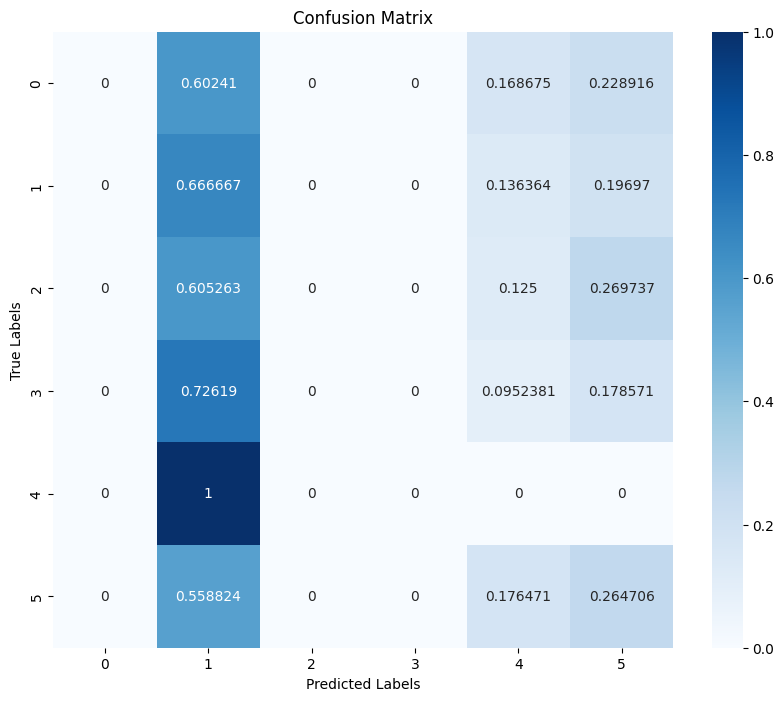

Epoch 13, Validation Loss: 1.7485, Accuracy: 0.1681, F1 Score: 0.0855
Val F1 Score Per Class  [0.         0.3444227  0.         0.         0.         0.11320755]


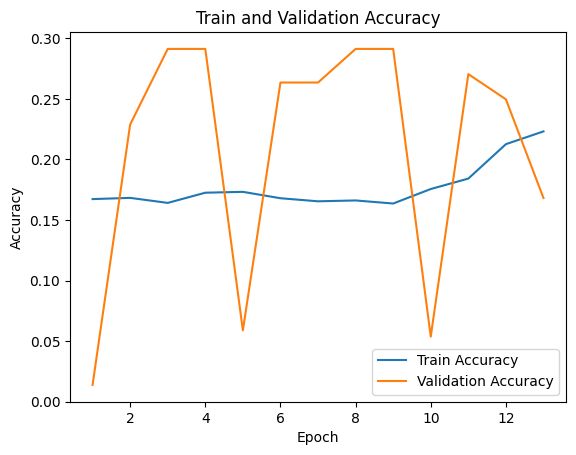

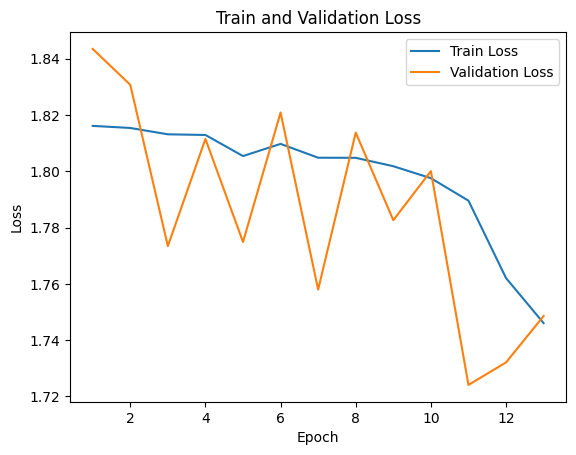

Epoch 14, Train Loss: 1.7357, Accuracy: 0.2277, F1 Score: 0.2023
Train F1 Score Per Class  [0.19335142 0.14860681 0.12633997 0.21385759 0.4120936  0.12239468]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.49it/s, loss=1.73]

[tensor([ 0.0187,  0.0832, -0.0480,  0.0598, -1.2586,  0.0215], device='cuda:0'), tensor([-0.1909,  0.0456, -0.2379, -0.1121, -0.0156, -0.1860], device='cuda:0'), tensor([-0.0711,  0.0769,  0.0085,  0.0956, -0.7409, -0.0358], device='cuda:0'), tensor([-1.1892e-01,  6.6606e-02, -1.1541e-01, -3.5293e-05, -6.0802e-01,
        -1.0225e-01], device='cuda:0'), tensor([-0.2269,  0.0562, -0.2177, -0.1071, -2.1019, -0.2154], device='cuda:0'), tensor([-0.3347,  0.0297, -0.3876, -0.2546, -1.0961, -0.3389], device='cuda:0'), tensor([-0.2963,  0.0403, -0.2904, -0.1702,  0.1047, -0.2849], device='cuda:0'), tensor([-0.2955,  0.0494, -0.2615, -0.1504, -0.3229, -0.2838], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.51it/s, loss=1.71]

[tensor([-0.2648,  0.0403, -0.3368, -0.2141, -1.0045, -0.2750], device='cuda:0'), tensor([-0.3006,  0.0423, -0.3097, -0.1933, -0.4590, -0.2939], device='cuda:0'), tensor([ 0.0626,  0.0868,  0.1161,  0.1950, -1.7656,  0.1056], device='cuda:0'), tensor([-0.2886,  0.0384, -0.2933, -0.1741,  0.0704, -0.2788], device='cuda:0'), tensor([ 0.1245,  0.0837,  0.1155,  0.1970, -2.6880,  0.1578], device='cuda:0'), tensor([-0.2905,  0.0483, -0.2556, -0.1418, -0.2142, -0.2775], device='cuda:0'), tensor([ 0.0779,  0.0808,  0.1056,  0.1926, -2.4330,  0.1169], device='cuda:0'), tensor([-0.1602,  0.0685, -0.0894,  0.0058, -0.1247, -0.1304], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.45it/s, loss=1.67]

[tensor([-0.1356,  0.0466, -0.1975, -0.0710, -0.3925, -0.1066], device='cuda:0'), tensor([-0.1916,  0.0600, -0.1383, -0.0384, -0.9037, -0.1645], device='cuda:0'), tensor([ 0.0322,  0.0763,  0.0068,  0.1124, -1.0567,  0.0513], device='cuda:0'), tensor([ 0.0056,  0.0899,  0.0965,  0.1740, -1.0272,  0.0479], device='cuda:0'), tensor([ 0.0441,  0.0844,  0.0730,  0.1674, -1.6501,  0.0775], device='cuda:0'), tensor([-0.1509,  0.0540, -0.1455, -0.0414, -1.1677, -0.1295], device='cuda:0'), tensor([-0.2117,  0.0520, -0.2289, -0.1116, -3.7349, -0.1977], device='cuda:0'), tensor([-0.2009,  0.0575, -0.1544, -0.0501, -1.5401, -0.1777], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:27,  2.46it/s, loss=1.72]

[tensor([-0.0213,  0.0784,  0.0189,  0.1037, -1.1909,  0.0120], device='cuda:0'), tensor([-0.1950,  0.0551, -0.1940, -0.0788, -0.2000, -0.1797], device='cuda:0'), tensor([-0.2434,  0.0536, -0.2482, -0.1289, -1.2730, -0.2350], device='cuda:0'), tensor([-0.1508,  0.0617, -0.1154, -0.0111, -0.8887, -0.1299], device='cuda:0'), tensor([-0.0471,  0.0753,  0.0093,  0.1042, -0.6696, -0.0131], device='cuda:0'), tensor([-0.0657,  0.0731, -0.0329,  0.0590, -0.7439, -0.0368], device='cuda:0'), tensor([ 0.1184,  0.0904,  0.1232,  0.2094, -2.0212,  0.1501], device='cuda:0'), tensor([-0.3118,  0.0361, -0.3017, -0.1869, -0.8160, -0.2970], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.44it/s, loss=1.73]

[tensor([-0.0582,  0.0754, -0.0017,  0.0909, -0.5722, -0.0254], device='cuda:0'), tensor([-0.1414,  0.0691, -0.0772,  0.0225, -0.2223, -0.1162], device='cuda:0'), tensor([-0.0806,  0.0776,  0.0142,  0.0993, -1.5857, -0.0431], device='cuda:0'), tensor([-0.1347,  0.0578, -0.1759, -0.0702, -0.8909, -0.1268], device='cuda:0'), tensor([-3.9750e-03,  7.6975e-02,  1.3804e-04,  9.8889e-02, -8.5484e-01,
         1.7837e-02], device='cuda:0'), tensor([-0.0813,  0.0628, -0.0992,  0.0049, -0.6276, -0.0615], device='cuda:0'), tensor([-0.2654,  0.0421, -0.2648, -0.1475, -0.2918, -0.2548], device='cuda:0'), tensor([-0.0100,  0.0765, -0.0034,  0.0949, -0.8763,  0.0148], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.45it/s, loss=1.9]

[tensor([-0.2200,  0.0544, -0.1793, -0.0705,  0.1809, -0.1998], device='cuda:0'), tensor([-0.1309,  0.0662, -0.0853,  0.0156, -1.4974, -0.1034], device='cuda:0'), tensor([-0.0699,  0.0826,  0.0099,  0.1030, -1.5505, -0.0364], device='cuda:0'), tensor([-0.2057,  0.0551, -0.1719, -0.0624, -0.5285, -0.1858], device='cuda:0'), tensor([ 0.0597,  0.0812,  0.0638,  0.1555, -2.3104,  0.0909], device='cuda:0'), tensor([-0.0769,  0.0662, -0.0845,  0.0162, -2.5547, -0.0585], device='cuda:0'), tensor([-0.1532,  0.0546, -0.1455, -0.0412, -0.9347, -0.1341], device='cuda:0'), tensor([-0.1671,  0.0611, -0.1032, -0.0088, -1.0631, -0.1403], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.46it/s, loss=1.68]

[tensor([-0.0063,  0.0868,  0.0746,  0.1604, -1.0577,  0.0330], device='cuda:0'), tensor([-0.0049,  0.0856,  0.0659,  0.1441, -1.8271,  0.0324], device='cuda:0'), tensor([-0.0571,  0.0667, -0.0623,  0.0318, -1.0281, -0.0347], device='cuda:0'), tensor([-0.1243,  0.0700, -0.0676,  0.0331, -1.3433, -0.0974], device='cuda:0'), tensor([-0.1475,  0.0508, -0.2191, -0.0925, -0.4145, -0.1463], device='cuda:0'), tensor([ 0.2419,  0.0999,  0.2803,  0.3555, -2.3427,  0.2922], device='cuda:0'), tensor([ 0.1101,  0.0755,  0.0712,  0.1702, -1.9193,  0.1392], device='cuda:0'), tensor([-0.0532,  0.0677, -0.0567,  0.0528, -0.4027, -0.0370], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.45it/s, loss=1.77]

[tensor([-0.2794,  0.0500, -0.2507, -0.1320, -0.2020, -0.2668], device='cuda:0'), tensor([ 0.0124,  0.0917,  0.1217,  0.2031, -1.2537,  0.0569], device='cuda:0'), tensor([-0.1829,  0.0603, -0.1510, -0.0453,  0.3933, -0.1632], device='cuda:0'), tensor([-0.0916,  0.0724, -0.0445,  0.0531, -0.9452, -0.0635], device='cuda:0'), tensor([-0.0567,  0.0691, -0.0259,  0.0758, -1.0288, -0.0255], device='cuda:0'), tensor([ 0.1997,  0.1163,  0.3060,  0.3748, -1.9037,  0.2566], device='cuda:0'), tensor([-0.2272,  0.0502, -0.1936, -0.0825, -0.0055, -0.2058], device='cuda:0'), tensor([ 0.1303,  0.0894,  0.1540,  0.2306, -2.6171,  0.1740], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.45it/s, loss=1.78]

[tensor([-0.0906,  0.0728, -0.0484,  0.0538, -0.3279, -0.0652], device='cuda:0'), tensor([-0.2135,  0.0546, -0.1725, -0.0641, -0.8061, -0.1893], device='cuda:0'), tensor([-0.2357,  0.0519, -0.1989, -0.0933, -0.5937, -0.2178], device='cuda:0'), tensor([-0.1540,  0.0521, -0.1556, -0.0372,  0.1962, -0.1258], device='cuda:0'), tensor([-0.0711,  0.0752, -0.0204,  0.0708, -2.1751, -0.0392], device='cuda:0'), tensor([-0.1957,  0.0600, -0.1501, -0.0451,  0.0047, -0.1685], device='cuda:0'), tensor([-0.2525,  0.0239, -0.4098, -0.2462,  0.5148, -0.2638], device='cuda:0'), tensor([-0.0222,  0.0655, -0.0483,  0.0543, -0.8110, -0.0047], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.44it/s, loss=1.7]

[tensor([ 0.0849,  0.0882,  0.1217,  0.2063, -1.2529,  0.1220], device='cuda:0'), tensor([ 0.2002,  0.1038,  0.1843,  0.2693, -2.2218,  0.2269], device='cuda:0'), tensor([ 0.1291,  0.0899,  0.1535,  0.2318, -2.4328,  0.1722], device='cuda:0'), tensor([-0.1460,  0.0571, -0.1239, -0.0185, -0.6971, -0.1188], device='cuda:0'), tensor([-0.1113,  0.0673, -0.0477,  0.0429, -1.7200, -0.0779], device='cuda:0'), tensor([-0.2969,  0.0529, -0.2391, -0.1288, -0.3465, -0.2769], device='cuda:0'), tensor([-1.7648e-03,  8.6289e-02,  3.4490e-02,  1.3107e-01, -3.1462e+00,
         2.6258e-02], device='cuda:0'), tensor([-0.1443,  0.0637, -0.0961,  0.0035, -0.2969, -0.1157], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.45it/s, loss=1.8]

[tensor([-0.0601,  0.0812,  0.0106,  0.1008, -2.9836, -0.0239], device='cuda:0'), tensor([-0.1096,  0.0691, -0.0546,  0.0467, -0.8658, -0.0794], device='cuda:0'), tensor([-0.0118,  0.0778,  0.0308,  0.1186, -1.9338,  0.0232], device='cuda:0'), tensor([-0.3477,  0.0331, -0.3671, -0.2451, -0.4700, -0.3438], device='cuda:0'), tensor([-0.1844,  0.0613, -0.1852, -0.0692, -0.1727, -0.1726], device='cuda:0'), tensor([-0.1494,  0.0599, -0.1021,  0.0076,  0.0013, -0.1170], device='cuda:0'), tensor([-0.1311,  0.0719, -0.0716,  0.0275, -0.3220, -0.1039], device='cuda:0'), tensor([-0.1876,  0.0625, -0.1557, -0.0516, -0.4541, -0.1657], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.44it/s, loss=1.69]

[tensor([-0.3254,  0.0324, -0.3496, -0.2234, -0.2391, -0.3178], device='cuda:0'), tensor([-0.3005,  0.0391, -0.2815, -0.1642, -0.0755, -0.2883], device='cuda:0'), tensor([-0.0767,  0.0740, -0.0681,  0.0338, -0.5348, -0.0411], device='cuda:0'), tensor([-0.0699,  0.0792, -0.0134,  0.0827, -0.7488, -0.0405], device='cuda:0'), tensor([ 0.1931,  0.0945,  0.2064,  0.2806, -2.8690,  0.2356], device='cuda:0'), tensor([-0.1281,  0.0612, -0.1277, -0.0267, -0.6807, -0.1097], device='cuda:0'), tensor([-0.1456,  0.0649, -0.0969,  0.0041, -0.6189, -0.1157], device='cuda:0'), tensor([-0.2427,  0.0495, -0.2267, -0.1093, -1.2885, -0.2277], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.46it/s, loss=1.68]

[tensor([-0.0504,  0.0741, -0.0069,  0.0993, -0.9083, -0.0127], device='cuda:0'), tensor([-0.1857,  0.0622, -0.1583, -0.0482, -0.7708, -0.1691], device='cuda:0'), tensor([-0.1046,  0.0686, -0.0931,  0.0085, -3.2475, -0.0862], device='cuda:0'), tensor([-0.1638,  0.0594, -0.1209, -0.0158, -0.3650, -0.1384], device='cuda:0'), tensor([-0.1256,  0.0601, -0.0991,  0.0059, -0.8980, -0.0975], device='cuda:0'), tensor([-0.0165,  0.0832,  0.0552,  0.1448, -0.9467,  0.0225], device='cuda:0'), tensor([ 0.0234,  0.0771,  0.0399,  0.1378, -1.4502,  0.0573], device='cuda:0'), tensor([-0.0041,  0.0833,  0.0240,  0.1228, -1.1165,  0.0333], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.45it/s, loss=1.72]

[tensor([-0.2147,  0.0370, -0.2548, -0.1493, -0.7190, -0.2051], device='cuda:0'), tensor([-0.0756,  0.0692, -0.0807,  0.0274, -1.0195, -0.0616], device='cuda:0'), tensor([-0.0822,  0.0774, -0.0078,  0.0839, -1.4282, -0.0483], device='cuda:0'), tensor([ 0.1717,  0.0871,  0.1403,  0.2236, -3.3190,  0.2011], device='cuda:0'), tensor([ 0.0185,  0.0749,  0.0505,  0.1334, -2.0126,  0.0590], device='cuda:0'), tensor([ 0.0071,  0.0750,  0.0406,  0.1309, -1.5410,  0.0412], device='cuda:0'), tensor([-0.3604,  0.0249, -0.4744, -0.3175,  0.0588, -0.3803], device='cuda:0'), tensor([-0.1294,  0.0703, -0.0679,  0.0297, -0.6783, -0.1000], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.44it/s, loss=1.77]

[tensor([-0.0776,  0.0736, -0.0077,  0.0850, -0.9712, -0.0424], device='cuda:0'), tensor([-0.2943,  0.0438, -0.2840, -0.1628,  0.3299, -0.2802], device='cuda:0'), tensor([-0.1234,  0.0689, -0.0581,  0.0341, -0.6893, -0.0926], device='cuda:0'), tensor([-0.1822,  0.0634, -0.1251, -0.0209,  0.1543, -0.1571], device='cuda:0'), tensor([-0.1070,  0.0638, -0.1180, -0.0194, -1.3448, -0.0949], device='cuda:0'), tensor([-0.1277,  0.0610, -0.1325, -0.0234, -0.0142, -0.1127], device='cuda:0'), tensor([-0.0183,  0.0723,  0.0050,  0.1048, -2.6398,  0.0121], device='cuda:0'), tensor([-0.2585,  0.0493, -0.2392, -0.1239,  0.0407, -0.2425], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.45it/s, loss=1.69]

[tensor([-0.0942,  0.0736, -0.0431,  0.0589, -0.3884, -0.0689], device='cuda:0'), tensor([-0.2393,  0.0514, -0.2288, -0.1190, -0.3564, -0.2283], device='cuda:0'), tensor([-0.0249,  0.0816,  0.0480,  0.1319, -1.5005,  0.0158], device='cuda:0'), tensor([-0.1239,  0.0675, -0.0641,  0.0314, -0.4007, -0.0953], device='cuda:0'), tensor([-0.0574,  0.0828,  0.0373,  0.1204, -0.9532, -0.0215], device='cuda:0'), tensor([-0.0893,  0.0735, -0.0524,  0.0403, -0.3724, -0.0626], device='cuda:0'), tensor([-0.2779,  0.0495, -0.2329, -0.1223, -0.4641, -0.2590], device='cuda:0'), tensor([-0.1645,  0.0583, -0.1667, -0.0570, -0.5394, -0.1525], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.44it/s, loss=1.62]

[tensor([-0.0893,  0.0758, -0.0125,  0.0776, -0.8407, -0.0559], device='cuda:0'), tensor([-0.1661,  0.0515, -0.1771, -0.0602, -0.1812, -0.1500], device='cuda:0'), tensor([-0.1177,  0.0701, -0.0838,  0.0212, -0.5015, -0.0955], device='cuda:0'), tensor([-0.1093,  0.0591, -0.1407, -0.0363, -0.2789, -0.0949], device='cuda:0'), tensor([-0.3011,  0.0191, -0.4882, -0.3339, -2.4709, -0.3287], device='cuda:0'), tensor([ 0.0931,  0.0812,  0.0738,  0.1582, -1.9814,  0.1192], device='cuda:0'), tensor([ 0.0554,  0.0752,  0.0524,  0.1421, -1.1250,  0.0872], device='cuda:0'), tensor([-0.0620,  0.0704, -0.0574,  0.0477, -1.5491, -0.0409], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.45it/s, loss=1.66]

[tensor([-0.2312,  0.0499, -0.2197, -0.1057, -0.2276, -0.2187], device='cuda:0'), tensor([-0.2492,  0.0464, -0.2503, -0.1360, -0.6760, -0.2368], device='cuda:0'), tensor([-0.2156,  0.0549, -0.1586, -0.0609, -0.2713, -0.1882], device='cuda:0'), tensor([-0.2731,  0.0334, -0.3096, -0.1837, -0.6544, -0.2655], device='cuda:0'), tensor([ 0.1259,  0.0949,  0.1788,  0.2649, -1.8832,  0.1673], device='cuda:0'), tensor([ 0.0363,  0.0935,  0.1277,  0.2050, -1.0167,  0.0795], device='cuda:0'), tensor([-0.2532,  0.0507, -0.2186, -0.1062, -0.5437, -0.2349], device='cuda:0'), tensor([-0.0884,  0.0563, -0.0876,  0.0126, -0.8824, -0.0686], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.44it/s, loss=1.74]

[tensor([ 0.0027,  0.0752,  0.0328,  0.1215, -1.9810,  0.0378], device='cuda:0'), tensor([-0.2940,  0.0318, -0.3553, -0.2223,  0.5761, -0.2926], device='cuda:0'), tensor([-0.0134,  0.0882,  0.0680,  0.1579, -0.7326,  0.0269], device='cuda:0'), tensor([-0.2439,  0.0396, -0.2717, -0.1527, -0.6270, -0.2330], device='cuda:0'), tensor([-0.0859,  0.0778, -0.0081,  0.0780, -1.4908, -0.0469], device='cuda:0'), tensor([ 0.0690,  0.0789,  0.0566,  0.1499, -1.6853,  0.0972], device='cuda:0'), tensor([-0.3355,  0.0202, -0.4684, -0.3151,  0.1778, -0.3452], device='cuda:0'), tensor([-0.2036,  0.0556, -0.1720, -0.0606, -1.3708, -0.1836], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.45it/s, loss=1.73]

[tensor([-0.1510,  0.0624, -0.0949,  0.0037, -1.7471, -0.1214], device='cuda:0'), tensor([-0.2164,  0.0483, -0.1771, -0.0716, -0.8519, -0.1922], device='cuda:0'), tensor([ 0.1102,  0.0976,  0.1381,  0.2207, -2.0087,  0.1471], device='cuda:0'), tensor([-0.1327,  0.0681, -0.0820,  0.0225, -0.4823, -0.1087], device='cuda:0'), tensor([-0.2906,  0.0422, -0.2832, -0.1627, -0.1687, -0.2797], device='cuda:0'), tensor([ 0.0045,  0.0871,  0.0947,  0.1793, -1.5346,  0.0484], device='cuda:0'), tensor([ 0.3183,  0.0874,  0.2103,  0.2971, -2.7557,  0.3415], device='cuda:0'), tensor([-0.1022,  0.0719, -0.0211,  0.0690, -0.5536, -0.0647], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.46it/s, loss=1.71]

[tensor([ 0.0081,  0.0856,  0.0258,  0.1174, -1.2136,  0.0316], device='cuda:0'), tensor([-0.0116,  0.0854,  0.0745,  0.1593, -1.2565,  0.0316], device='cuda:0'), tensor([-0.2489,  0.0544, -0.2145, -0.1018, -0.2670, -0.2293], device='cuda:0'), tensor([-0.0165,  0.0771, -0.0104,  0.0871, -1.2732,  0.0077], device='cuda:0'), tensor([-0.0186,  0.0831,  0.0306,  0.1205, -1.3001,  0.0218], device='cuda:0'), tensor([-0.2756,  0.0448, -0.2760, -0.1533,  0.0672, -0.2636], device='cuda:0'), tensor([-0.1770,  0.0547, -0.1755, -0.0599, -0.1365, -0.1666], device='cuda:0'), tensor([-0.1186,  0.0616, -0.0909,  0.0116, -0.7745, -0.0949], device='cuda:0')]


Val:  30%|███       | 22/73 [00:08<00:20,  2.46it/s, loss=1.68]

[tensor([-0.2559,  0.0466, -0.2380, -0.1261, -0.5257, -0.2385], device='cuda:0'), tensor([ 0.0849,  0.1022,  0.1847,  0.2644, -1.2470,  0.1322], device='cuda:0'), tensor([-0.1732,  0.0607, -0.1473, -0.0434, -0.3464, -0.1466], device='cuda:0'), tensor([-0.1142,  0.0702, -0.0480,  0.0448, -0.5639, -0.0834], device='cuda:0'), tensor([-0.3085,  0.0429, -0.2990, -0.1762,  0.1552, -0.3009], device='cuda:0'), tensor([-0.1211,  0.0693, -0.0967,  0.0077, -1.0912, -0.0979], device='cuda:0'), tensor([-0.0599,  0.0751,  0.0307,  0.1187, -0.7186, -0.0248], device='cuda:0'), tensor([-0.0216,  0.0860,  0.0811,  0.1587, -1.2832,  0.0234], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.44it/s, loss=1.7]

[tensor([-0.2635,  0.0417, -0.3091, -0.1851, -1.0058, -0.2627], device='cuda:0'), tensor([-0.1655,  0.0398, -0.2979, -0.1558, -1.0835, -0.1711], device='cuda:0'), tensor([-0.0929,  0.0782, -0.0240,  0.0651, -2.3101, -0.0632], device='cuda:0'), tensor([-0.1975,  0.0636, -0.1168, -0.0181, -0.4891, -0.1689], device='cuda:0'), tensor([ 0.2123,  0.1052,  0.2258,  0.2986, -4.8748,  0.2549], device='cuda:0'), tensor([-0.2050,  0.0549, -0.2011, -0.0901, -0.4748, -0.1952], device='cuda:0'), tensor([-0.3304,  0.0465, -0.3032, -0.1818,  0.2448, -0.3248], device='cuda:0'), tensor([-0.0611,  0.0770,  0.0013,  0.0916, -1.1019, -0.0257], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:20,  2.45it/s, loss=1.7]

[tensor([-0.0822,  0.0802, -0.0162,  0.0799, -1.0237, -0.0499], device='cuda:0'), tensor([-0.1747,  0.0655, -0.1251, -0.0282, -1.5667, -0.1479], device='cuda:0'), tensor([-0.0947,  0.0670, -0.0428,  0.0503, -1.0803, -0.0630], device='cuda:0'), tensor([ 1.9355e-03,  7.5782e-02,  2.9421e-04,  9.1052e-02, -1.6433e+00,
         2.6988e-02], device='cuda:0'), tensor([-0.2034,  0.0569, -0.1775, -0.0706, -1.0366, -0.1848], device='cuda:0'), tensor([-0.1010,  0.0762, -0.0433,  0.0578, -0.3561, -0.0711], device='cuda:0'), tensor([-0.3823,  0.0279, -0.3866, -0.2624, -0.3689, -0.3749], device='cuda:0'), tensor([ 0.1983,  0.0855,  0.1030,  0.2102, -2.3215,  0.2161], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.44it/s, loss=1.78]

[tensor([-0.1665,  0.0617, -0.1528, -0.0393, -0.4890, -0.1467], device='cuda:0'), tensor([-0.3512,  0.0224, -0.4315, -0.2943,  0.3449, -0.3610], device='cuda:0'), tensor([-0.2229,  0.0525, -0.1885, -0.0827, -0.4005, -0.2003], device='cuda:0'), tensor([-0.0711,  0.0852,  0.0241,  0.1098, -1.2289, -0.0348], device='cuda:0'), tensor([-0.1816,  0.0610, -0.1266, -0.0246, -0.4052, -0.1568], device='cuda:0'), tensor([-0.2426,  0.0461, -0.2397, -0.1238,  0.1033, -0.2322], device='cuda:0'), tensor([-0.3124,  0.0357, -0.3372, -0.2092, -0.3421, -0.3109], device='cuda:0'), tensor([ 0.0753,  0.0859,  0.1147,  0.1989, -1.3650,  0.1158], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.45it/s, loss=1.63]

[tensor([-0.1552,  0.0653, -0.1005,  0.0025, -0.7210, -0.1304], device='cuda:0'), tensor([-0.1181,  0.0699, -0.0508,  0.0463, -0.5650, -0.0861], device='cuda:0'), tensor([ 0.7520,  0.1550,  0.7602,  0.8047, -4.1334,  0.8251], device='cuda:0'), tensor([-4.2491e-02,  7.8112e-02,  4.5759e-02,  1.2763e-01, -1.3640e+00,
        -1.0907e-04], device='cuda:0'), tensor([ 0.0361,  0.0846,  0.0366,  0.1264, -1.5706,  0.0587], device='cuda:0'), tensor([ 0.0615,  0.0950,  0.1517,  0.2292, -1.1503,  0.1082], device='cuda:0'), tensor([-0.0484,  0.0665, -0.0257,  0.0721, -2.3990, -0.0176], device='cuda:0'), tensor([-1.1705e-04,  8.3368e-02,  4.3464e-02,  1.3069e-01, -1.5799e+00,
         3.4221e-02], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:18,  2.45it/s, loss=1.76]

[tensor([ 0.1664,  0.0994,  0.2060,  0.2861, -1.3594,  0.2079], device='cuda:0'), tensor([-0.1286,  0.0644, -0.0974,  0.0049,  0.0154, -0.1022], device='cuda:0'), tensor([-0.3719,  0.0311, -0.3723, -0.2453,  0.2453, -0.3653], device='cuda:0'), tensor([-0.1658,  0.0622, -0.1048, -0.0050, -0.2464, -0.1396], device='cuda:0'), tensor([-0.1422,  0.0621, -0.0919,  0.0045, -0.6535, -0.1137], device='cuda:0'), tensor([-0.1923,  0.0541, -0.2240, -0.0990, -0.5775, -0.1846], device='cuda:0'), tensor([-0.0307,  0.0777,  0.0375,  0.1277, -0.5569,  0.0086], device='cuda:0'), tensor([-0.1337,  0.0693, -0.0786,  0.0207, -0.8526, -0.1053], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.45it/s, loss=1.68]

[tensor([-0.0497,  0.0683, -0.0809,  0.0292, -0.4985, -0.0332], device='cuda:0'), tensor([ 0.0800,  0.0885,  0.1280,  0.2023, -1.7596,  0.1191], device='cuda:0'), tensor([-0.0143,  0.0845,  0.0184,  0.1096, -3.6764,  0.0142], device='cuda:0'), tensor([-0.1328,  0.0646, -0.0781,  0.0189, -0.3615, -0.1026], device='cuda:0'), tensor([-0.1222,  0.0612, -0.1400, -0.0315, -0.5750, -0.1101], device='cuda:0'), tensor([-0.2210,  0.0540, -0.1671, -0.0661, -1.1724, -0.1971], device='cuda:0'), tensor([-0.1561,  0.0505, -0.1792, -0.0641, -0.3215, -0.1386], device='cuda:0'), tensor([ 0.1493,  0.0928,  0.1812,  0.2603, -1.7006,  0.1905], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.46it/s, loss=1.63]

[tensor([ 0.0670,  0.0846,  0.0825,  0.1652, -1.3288,  0.0993], device='cuda:0'), tensor([-0.1595,  0.0467, -0.1842, -0.0727, -1.7688, -0.1421], device='cuda:0'), tensor([-0.0583,  0.0807,  0.0011,  0.0919, -0.5443, -0.0254], device='cuda:0'), tensor([-0.0271,  0.0839,  0.0519,  0.1387, -1.1590,  0.0110], device='cuda:0'), tensor([-0.1909,  0.0603, -0.1207, -0.0228, -0.1469, -0.1627], device='cuda:0'), tensor([-3.9744e-02,  7.5057e-02,  3.4998e-02,  1.2884e-01, -1.1508e+00,
         3.6694e-04], device='cuda:0'), tensor([-0.1194,  0.0717, -0.0597,  0.0360, -1.4723, -0.0910], device='cuda:0'), tensor([-0.0848,  0.0670, -0.0501,  0.0486, -0.9455, -0.0585], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.46it/s, loss=1.69]

[tensor([-0.1320,  0.0564, -0.1217, -0.0126, -0.9030, -0.1096], device='cuda:0'), tensor([-0.2308,  0.0536, -0.1933, -0.0829, -0.5253, -0.2127], device='cuda:0'), tensor([-0.2358,  0.0565, -0.2124, -0.0965, -0.6792, -0.2262], device='cuda:0'), tensor([-0.2709,  0.0358, -0.3252, -0.1925, -1.2221, -0.2696], device='cuda:0'), tensor([-0.1781,  0.0609, -0.1341, -0.0300, -0.7126, -0.1538], device='cuda:0'), tensor([-0.2875,  0.0458, -0.2639, -0.1491,  0.4878, -0.2739], device='cuda:0'), tensor([ 0.0261,  0.0852,  0.0593,  0.1586, -0.9580,  0.0666], device='cuda:0'), tensor([-0.2230,  0.0620, -0.2000, -0.0803, -0.2612, -0.2099], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.46it/s, loss=1.63]

[tensor([ 0.1793,  0.0864,  0.1629,  0.2464, -1.9600,  0.2146], device='cuda:0'), tensor([-0.2073,  0.0534, -0.1764, -0.0680, -2.4835, -0.1884], device='cuda:0'), tensor([-0.0819,  0.0658, -0.0631,  0.0302, -0.8574, -0.0669], device='cuda:0'), tensor([-0.0637,  0.0653, -0.0059,  0.0877, -0.7760, -0.0300], device='cuda:0'), tensor([-0.1792,  0.0587, -0.1292, -0.0293, -0.5511, -0.1523], device='cuda:0'), tensor([-0.0444,  0.0801,  0.0073,  0.1009, -1.4468, -0.0100], device='cuda:0'), tensor([-0.2145,  0.0108, -0.4873, -0.3154, -4.0179, -0.2501], device='cuda:0'), tensor([-1.4663e-01,  5.8518e-02, -9.2959e-02,  1.0614e-03, -1.6573e+00,
        -1.1295e-01], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.45it/s, loss=1.62]

[tensor([-0.1619,  0.0658, -0.1219, -0.0221, -0.7441, -0.1375], device='cuda:0'), tensor([-0.3101,  0.0298, -0.3529, -0.2235, -0.1921, -0.3067], device='cuda:0'), tensor([-0.3865,  0.0298, -0.4375, -0.3056, -1.5890, -0.3938], device='cuda:0'), tensor([-0.0443,  0.0802,  0.0134,  0.1032, -1.0144, -0.0113], device='cuda:0'), tensor([-0.1456,  0.0566, -0.1335, -0.0245, -1.3433, -0.1248], device='cuda:0'), tensor([-0.0792,  0.0771, -0.0075,  0.0819, -1.8046, -0.0448], device='cuda:0'), tensor([ 0.1109,  0.0834,  0.1059,  0.1985, -1.8076,  0.1430], device='cuda:0'), tensor([-0.1950,  0.0611, -0.1365, -0.0342, -0.7765, -0.1693], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.45it/s, loss=1.66]

[tensor([-0.0654,  0.0780,  0.0106,  0.1000, -1.5276, -0.0295], device='cuda:0'), tensor([-0.2123,  0.0479, -0.2482, -0.1190, -1.0288, -0.2053], device='cuda:0'), tensor([-0.2290,  0.0614, -0.1703, -0.0646, -1.3048, -0.2114], device='cuda:0'), tensor([-0.1421,  0.0558, -0.1467, -0.0356, -0.5011, -0.1269], device='cuda:0'), tensor([-0.1957,  0.0481, -0.2296, -0.1194, -0.7647, -0.1918], device='cuda:0'), tensor([ 0.0088,  0.0631, -0.1099,  0.0099, -2.7771,  0.0096], device='cuda:0'), tensor([-0.1853,  0.0599, -0.1339, -0.0358,  0.0810, -0.1559], device='cuda:0'), tensor([-0.2528,  0.0587, -0.1847, -0.0826,  0.0989, -0.2315], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.44it/s, loss=1.67]

[tensor([ 0.1355,  0.0840,  0.0866,  0.1742, -2.2964,  0.1576], device='cuda:0'), tensor([ 0.0835,  0.0890,  0.0988,  0.1835, -1.1194,  0.1140], device='cuda:0'), tensor([-0.3249,  0.0404, -0.3110, -0.1920, -0.2885, -0.3132], device='cuda:0'), tensor([-2.7963e-02,  7.0220e-02, -3.8283e-02,  6.1370e-02, -2.7857e+00,
        -1.8861e-03], device='cuda:0'), tensor([-0.2370,  0.0217, -0.3694, -0.2244, -0.3949, -0.2436], device='cuda:0'), tensor([ 0.0370,  0.0867,  0.0711,  0.1646, -0.7699,  0.0724], device='cuda:0'), tensor([-0.1850,  0.0519, -0.1634, -0.0575, -0.3565, -0.1625], device='cuda:0'), tensor([-0.1016,  0.0745, -0.0317,  0.0582, -0.9087, -0.0681], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.43it/s, loss=1.64]

[tensor([ 0.0583,  0.0827,  0.0524,  0.1446, -3.6772,  0.0852], device='cuda:0'), tensor([-3.8598e-02,  9.0437e-02,  6.3891e-02,  1.4927e-01, -8.3177e-01,
         1.3541e-04], device='cuda:0'), tensor([-0.3490,  0.0300, -0.3909, -0.2639, -2.0155, -0.3515], device='cuda:0'), tensor([-0.2463,  0.0412, -0.2565, -0.1343, -1.3196, -0.2353], device='cuda:0'), tensor([-0.0520,  0.0818,  0.0334,  0.1182, -0.6291, -0.0119], device='cuda:0'), tensor([-0.0505,  0.0671, -0.0301,  0.0705, -0.7541, -0.0215], device='cuda:0'), tensor([-0.1463,  0.0573, -0.1166, -0.0105, -2.0074, -0.1194], device='cuda:0'), tensor([-0.0167,  0.0880,  0.0725,  0.1561, -0.7618,  0.0223], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.44it/s, loss=1.72]

[tensor([ 0.0239,  0.0714,  0.0014,  0.1017, -0.6112,  0.0497], device='cuda:0'), tensor([-0.2789,  0.0473, -0.2436, -0.1319, -1.2902, -0.2609], device='cuda:0'), tensor([ 0.0570,  0.0793,  0.0403,  0.1513, -1.3218,  0.0989], device='cuda:0'), tensor([-0.0054,  0.0814,  0.0366,  0.1248, -0.9926,  0.0245], device='cuda:0'), tensor([-0.0295,  0.0618, -0.0562,  0.0461, -0.8496, -0.0095], device='cuda:0'), tensor([ 0.5888,  0.1367,  0.5167,  0.5976, -4.3171,  0.6293], device='cuda:0'), tensor([-0.1582,  0.0571, -0.1375, -0.0291, -0.4318, -0.1354], device='cuda:0'), tensor([-0.0422,  0.0799,  0.0186,  0.1140, -0.9012, -0.0057], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.42it/s, loss=1.81]

[tensor([-0.2624,  0.0346, -0.3021, -0.1823, -0.5941, -0.2549], device='cuda:0'), tensor([-0.2627,  0.0556, -0.2082, -0.1003, -1.0324, -0.2446], device='cuda:0'), tensor([ 0.2409,  0.0995,  0.2364,  0.3214, -2.1158,  0.2790], device='cuda:0'), tensor([-0.0706,  0.0746, -0.0202,  0.0773, -0.5287, -0.0356], device='cuda:0'), tensor([-0.1390,  0.0603, -0.0986,  0.0048, -0.4867, -0.1171], device='cuda:0'), tensor([-0.0338,  0.0742,  0.0083,  0.0981, -0.8263, -0.0027], device='cuda:0'), tensor([-0.2520,  0.0485, -0.2160, -0.1071, -0.5197, -0.2293], device='cuda:0'), tensor([-0.1554,  0.0609, -0.1514, -0.0413, -1.1669, -0.1380], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.43it/s, loss=1.67]

[tensor([-0.1643,  0.0494, -0.2247, -0.1110, -1.9020, -0.1608], device='cuda:0'), tensor([-0.1884,  0.0608, -0.1717, -0.0549, -0.9151, -0.1730], device='cuda:0'), tensor([-0.2979,  0.0215, -0.4283, -0.2834, -1.0646, -0.3140], device='cuda:0'), tensor([ 0.1002,  0.0931,  0.0705,  0.1639, -3.4813,  0.1184], device='cuda:0'), tensor([ 0.0693,  0.0956,  0.1495,  0.2265, -4.5719,  0.1166], device='cuda:0'), tensor([-0.3816,  0.0303, -0.3821, -0.2535, -0.4730, -0.3778], device='cuda:0'), tensor([ 0.0779,  0.0893,  0.0990,  0.1921, -1.1520,  0.1118], device='cuda:0'), tensor([-0.1084,  0.0592, -0.1236, -0.0174, -0.4128, -0.0899], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:14,  2.42it/s, loss=1.64]

[tensor([-0.2230,  0.0613, -0.1780, -0.0687, -0.8642, -0.2029], device='cuda:0'), tensor([-0.0071,  0.0728,  0.0098,  0.0993, -1.4295,  0.0237], device='cuda:0'), tensor([-0.1678,  0.0605, -0.1279, -0.0292, -0.8619, -0.1409], device='cuda:0'), tensor([-0.1274,  0.0554, -0.1487, -0.0436, -1.0691, -0.1121], device='cuda:0'), tensor([ 0.2450,  0.1180,  0.3410,  0.3998, -3.0256,  0.3062], device='cuda:0'), tensor([-0.2611,  0.0549, -0.2000, -0.0959, -0.5891, -0.2386], device='cuda:0'), tensor([-0.2575,  0.0482, -0.2119, -0.1060, -0.2260, -0.2365], device='cuda:0'), tensor([-0.1159,  0.0718, -0.0483,  0.0451, -0.7831, -0.0844], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.43it/s, loss=1.66]

[tensor([-0.1686,  0.0591, -0.1303, -0.0293, -0.9207, -0.1429], device='cuda:0'), tensor([-0.0848,  0.0659, -0.0514,  0.0511, -0.8123, -0.0578], device='cuda:0'), tensor([ 0.0662,  0.0971,  0.1327,  0.2095, -1.8640,  0.1050], device='cuda:0'), tensor([ 0.0253,  0.0929,  0.1205,  0.1951, -1.6488,  0.0692], device='cuda:0'), tensor([-0.0326,  0.0804,  0.0348,  0.1216, -1.6896,  0.0027], device='cuda:0'), tensor([-0.1325,  0.0588, -0.1365, -0.0295, -2.8810, -0.1138], device='cuda:0'), tensor([-0.2127,  0.0492, -0.2075, -0.0960, -1.5424, -0.1941], device='cuda:0'), tensor([-0.0686,  0.0705, -0.0268,  0.0610, -3.1508, -0.0362], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.43it/s, loss=1.69]

[tensor([-0.0626,  0.0682, -0.0816,  0.0183, -0.6775, -0.0471], device='cuda:0'), tensor([-0.4056,  0.0283, -0.4018, -0.2723,  0.0500, -0.3996], device='cuda:0'), tensor([-0.1245,  0.0570, -0.1462, -0.0327, -0.3848, -0.1097], device='cuda:0'), tensor([-0.2728,  0.0496, -0.2432, -0.1287, -0.8070, -0.2597], device='cuda:0'), tensor([ 0.0195,  0.0919,  0.1060,  0.1904, -0.7989,  0.0606], device='cuda:0'), tensor([-0.0450,  0.0718,  0.0060,  0.0991, -1.0137, -0.0065], device='cuda:0'), tensor([-0.1136,  0.0691, -0.0775,  0.0196, -1.1760, -0.0857], device='cuda:0'), tensor([-0.3253,  0.0380, -0.3020, -0.1889, -0.5486, -0.3093], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.43it/s, loss=1.7]

[tensor([-0.0526,  0.0648, -0.1464, -0.0126, -1.3163, -0.0339], device='cuda:0'), tensor([-0.0745,  0.0826,  0.0071,  0.0988, -0.4901, -0.0419], device='cuda:0'), tensor([ 0.0790,  0.0587, -0.0145,  0.0916, -2.5271,  0.0956], device='cuda:0'), tensor([-0.1318,  0.0665, -0.0897,  0.0110, -1.5382, -0.1075], device='cuda:0'), tensor([-0.0229,  0.0757,  0.0368,  0.1249, -1.3949,  0.0132], device='cuda:0'), tensor([ 0.0141,  0.0838,  0.0414,  0.1293, -1.8090,  0.0397], device='cuda:0'), tensor([-0.1487,  0.0685, -0.0902,  0.0050, -0.2328, -0.1199], device='cuda:0'), tensor([-0.1388,  0.0658, -0.0755,  0.0224, -0.4094, -0.1063], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.44it/s, loss=1.73]

[tensor([-0.4096,  0.0315, -0.4078, -0.2780, -0.8384, -0.4102], device='cuda:0'), tensor([-0.3178,  0.0278, -0.3837, -0.2510, -0.9433, -0.3199], device='cuda:0'), tensor([-0.1700,  0.0557, -0.1736, -0.0576, -0.4857, -0.1548], device='cuda:0'), tensor([-0.1385,  0.0686, -0.0662,  0.0291, -0.8003, -0.1089], device='cuda:0'), tensor([-0.2051,  0.0551, -0.1603, -0.0593, -0.1844, -0.1804], device='cuda:0'), tensor([-0.0689,  0.0692, -0.0848,  0.0154, -0.8393, -0.0515], device='cuda:0'), tensor([-0.1301,  0.0673, -0.1202, -0.0118, -1.6325, -0.1135], device='cuda:0'), tensor([-0.2986,  0.0216, -0.4143, -0.2743,  0.1503, -0.3095], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:17<00:11,  2.42it/s, loss=1.68]

[tensor([ 0.2517,  0.0948,  0.2067,  0.2954, -2.1418,  0.2808], device='cuda:0'), tensor([-0.1022,  0.0712, -0.0596,  0.0372, -0.9380, -0.0746], device='cuda:0'), tensor([-0.1291,  0.0595, -0.1338, -0.0302, -0.9882, -0.1122], device='cuda:0'), tensor([-0.2321,  0.0496, -0.2123, -0.1077, -0.9816, -0.2164], device='cuda:0'), tensor([-0.1649,  0.0617, -0.1276, -0.0200, -0.5297, -0.1401], device='cuda:0'), tensor([-0.0720,  0.0768, -0.0088,  0.0839, -0.7450, -0.0373], device='cuda:0'), tensor([-0.2612,  0.0448, -0.2592, -0.1448, -0.1998, -0.2486], device='cuda:0'), tensor([-0.1964,  0.0432, -0.2608, -0.1304, -1.2047, -0.1949], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.43it/s, loss=1.69]

[tensor([-0.1686,  0.0633, -0.0984,  0.0014, -0.6578, -0.1376], device='cuda:0'), tensor([-0.0599,  0.0679, -0.0260,  0.0682, -0.9431, -0.0299], device='cuda:0'), tensor([-0.1349,  0.0648, -0.0765,  0.0209, -0.8722, -0.1028], device='cuda:0'), tensor([ 0.0711,  0.0499, -0.0994,  0.0286, -2.4142,  0.0705], device='cuda:0'), tensor([-0.1540,  0.0637, -0.1249, -0.0194, -0.4174, -0.1323], device='cuda:0'), tensor([ 5.6992e-03,  5.1650e-02, -1.2244e-01,  3.3943e-04, -1.2568e+00,
         1.9832e-02], device='cuda:0'), tensor([-0.0142,  0.0798,  0.0326,  0.1329, -1.4331,  0.0164], device='cuda:0'), tensor([-0.1371,  0.0643, -0.0616,  0.0311, -0.4242, -0.1045], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.44it/s, loss=1.65]

[tensor([-0.2833,  0.0551, -0.2376, -0.1222, -0.6588, -0.2722], device='cuda:0'), tensor([-0.2122,  0.0521, -0.1723, -0.0643, -0.0906, -0.1852], device='cuda:0'), tensor([-0.2391,  0.0538, -0.2174, -0.1096, -2.3400, -0.2253], device='cuda:0'), tensor([ 0.2492,  0.1058,  0.2690,  0.3356, -2.8600,  0.2929], device='cuda:0'), tensor([ 0.1658,  0.0895,  0.1719,  0.2637, -1.7078,  0.2084], device='cuda:0'), tensor([-0.3033,  0.0474, -0.2502, -0.1420, -0.2154, -0.2846], device='cuda:0'), tensor([-0.1447,  0.0689, -0.0901,  0.0087, -1.3592, -0.1214], device='cuda:0'), tensor([-0.0059,  0.0712, -0.0282,  0.0742, -2.0270,  0.0192], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.44it/s, loss=1.67]

[tensor([-0.1583,  0.0563, -0.1638, -0.0499, -2.2599, -0.1417], device='cuda:0'), tensor([-0.0057,  0.0827,  0.0527,  0.1408, -1.0811,  0.0312], device='cuda:0'), tensor([-0.2172,  0.0533, -0.1921, -0.0889, -0.6768, -0.1992], device='cuda:0'), tensor([-0.1775,  0.0563, -0.1427, -0.0400, -1.0118, -0.1525], device='cuda:0'), tensor([-0.2991,  0.0398, -0.3057, -0.1796, -0.3340, -0.2847], device='cuda:0'), tensor([-0.1711,  0.0451, -0.2173, -0.1011, -2.0687, -0.1630], device='cuda:0'), tensor([ 0.1047,  0.0961,  0.1924,  0.2669, -2.5645,  0.1560], device='cuda:0'), tensor([-0.1073,  0.0673, -0.0600,  0.0361, -1.6539, -0.0780], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.43it/s, loss=1.69]

[tensor([-0.1675,  0.0698, -0.1159, -0.0085, -0.4821, -0.1397], device='cuda:0'), tensor([ 0.1729,  0.0917,  0.1409,  0.2262, -3.0646,  0.2011], device='cuda:0'), tensor([-0.0656,  0.0783,  0.0187,  0.1124, -0.7505, -0.0319], device='cuda:0'), tensor([-0.2138,  0.0535, -0.1936, -0.0881, -1.1209, -0.1974], device='cuda:0'), tensor([-0.1015,  0.0639, -0.0827,  0.0210, -1.3544, -0.0710], device='cuda:0'), tensor([-0.2662,  0.0446, -0.2520, -0.1333, -0.1272, -0.2498], device='cuda:0'), tensor([-0.0676,  0.0819, -0.0146,  0.0819, -0.8313, -0.0424], device='cuda:0'), tensor([-0.2092,  0.0526, -0.1663, -0.0629, -0.2933, -0.1846], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.44it/s, loss=1.71]

[tensor([-0.2047,  0.0564, -0.2165, -0.1021,  0.0082, -0.1934], device='cuda:0'), tensor([-0.2155,  0.0449, -0.2167, -0.0999, -0.6414, -0.1997], device='cuda:0'), tensor([-0.0262,  0.0893,  0.0611,  0.1500, -1.1470,  0.0119], device='cuda:0'), tensor([-0.0943,  0.0804, -0.0163,  0.0789, -1.1512, -0.0615], device='cuda:0'), tensor([-0.1204,  0.0482, -0.1850, -0.0607, -0.9069, -0.1129], device='cuda:0'), tensor([-0.1402,  0.0697, -0.0685,  0.0244, -1.1175, -0.1083], device='cuda:0'), tensor([-0.1430,  0.0478, -0.1651, -0.0532, -2.1566, -0.1220], device='cuda:0'), tensor([ 0.1055,  0.0862,  0.0919,  0.1755, -1.1895,  0.1339], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.45it/s, loss=1.74]

[tensor([-0.1200,  0.0687, -0.0601,  0.0304, -1.4380, -0.0886], device='cuda:0'), tensor([-0.1548,  0.0690, -0.0917,  0.0073, -0.8825, -0.1282], device='cuda:0'), tensor([-6.5459e-02,  7.8953e-02, -5.3727e-04,  8.8327e-02, -6.7471e-01,
        -3.4171e-02], device='cuda:0'), tensor([-0.2824,  0.0531, -0.2654, -0.1440,  0.1660, -0.2714], device='cuda:0'), tensor([-0.1327,  0.0736, -0.0623,  0.0377, -0.4450, -0.1081], device='cuda:0'), tensor([-0.0774,  0.0752, -0.0034,  0.0859, -0.6968, -0.0422], device='cuda:0'), tensor([-0.2281,  0.0551, -0.1822, -0.0781, -0.7961, -0.2047], device='cuda:0'), tensor([ 0.1413,  0.0975,  0.1700,  0.2534, -2.0034,  0.1795], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.45it/s, loss=1.64]

[tensor([-0.1479,  0.0604, -0.1194, -0.0145, -0.4085, -0.1221], device='cuda:0'), tensor([-0.0820,  0.0706, -0.0205,  0.0685, -1.5602, -0.0458], device='cuda:0'), tensor([-0.2291,  0.0518, -0.1943, -0.0897, -0.2363, -0.2087], device='cuda:0'), tensor([-0.0559,  0.0764, -0.0151,  0.0903, -0.5293, -0.0292], device='cuda:0'), tensor([-0.0842,  0.0721, -0.0282,  0.0665, -1.0347, -0.0515], device='cuda:0'), tensor([-0.0509,  0.0648, -0.0594,  0.0458, -0.3951, -0.0276], device='cuda:0'), tensor([ 0.4715,  0.1307,  0.5326,  0.5754, -4.6189,  0.5422], device='cuda:0'), tensor([ 0.0072,  0.0602,  0.0077,  0.0978, -1.7028,  0.0388], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.46it/s, loss=1.74]

[tensor([-0.1797,  0.0574, -0.1373, -0.0339, -0.7417, -0.1535], device='cuda:0'), tensor([-0.1235,  0.0540, -0.1316, -0.0245, -1.0672, -0.1001], device='cuda:0'), tensor([-0.4434,  0.0148, -0.5279, -0.3745, -1.0771, -0.4580], device='cuda:0'), tensor([-0.2329,  0.0462, -0.2450, -0.1228, -1.0024, -0.2219], device='cuda:0'), tensor([ 0.0619,  0.0954,  0.1322,  0.2227, -0.7733,  0.1017], device='cuda:0'), tensor([-0.2028,  0.0594, -0.1565, -0.0527, -0.3778, -0.1781], device='cuda:0'), tensor([-0.2560,  0.0499, -0.2212, -0.1118,  0.1455, -0.2358], device='cuda:0'), tensor([-0.2123,  0.0574, -0.1566, -0.0562, -0.2326, -0.1871], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.46it/s, loss=1.66]

[tensor([-0.2392,  0.0484, -0.2684, -0.1407, -0.4726, -0.2295], device='cuda:0'), tensor([ 0.1819,  0.0858,  0.1328,  0.2208, -4.0521,  0.2100], device='cuda:0'), tensor([-0.1790,  0.0587, -0.1357, -0.0345, -0.7537, -0.1548], device='cuda:0'), tensor([-0.3086,  0.0328, -0.3266, -0.2084, -0.1177, -0.3006], device='cuda:0'), tensor([-0.1045,  0.0719, -0.0401,  0.0521, -0.7105, -0.0693], device='cuda:0'), tensor([-0.1682,  0.0635, -0.1060, -0.0045, -0.6336, -0.1397], device='cuda:0'), tensor([ 0.0868,  0.0987,  0.1992,  0.2655, -2.0321,  0.1405], device='cuda:0'), tensor([ 0.1867,  0.1087,  0.2857,  0.3558, -1.7638,  0.2428], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.46it/s, loss=1.68]

[tensor([-0.4970,  0.0131, -0.5889, -0.4301, -2.9101, -0.5228], device='cuda:0'), tensor([-0.1873,  0.0510, -0.1581, -0.0642, -1.6823, -0.1585], device='cuda:0'), tensor([-0.0569,  0.0819,  0.0238,  0.1124, -0.8059, -0.0230], device='cuda:0'), tensor([-0.1813,  0.0497, -0.1714, -0.0593, -1.4768, -0.1573], device='cuda:0'), tensor([-0.0346,  0.0700, -0.0098,  0.0878, -1.0610, -0.0029], device='cuda:0'), tensor([-0.0379,  0.0466, -0.1530, -0.0443, -2.2354, -0.0353], device='cuda:0'), tensor([-0.0421,  0.0830,  0.0435,  0.1285, -1.5547, -0.0041], device='cuda:0'), tensor([-0.3264,  0.0216, -0.4807, -0.3206, -0.4560, -0.3527], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.45it/s, loss=1.92]

[tensor([ 0.2160,  0.0931,  0.2191,  0.2940, -2.5816,  0.2554], device='cuda:0'), tensor([ 0.0333,  0.0853,  0.0506,  0.1411, -2.0599,  0.0593], device='cuda:0'), tensor([-0.3390,  0.0355, -0.3611, -0.2383, -0.8867, -0.3388], device='cuda:0'), tensor([-0.1970,  0.0528, -0.1739, -0.0741, -2.1461, -0.1735], device='cuda:0'), tensor([-0.0515,  0.0818,  0.0345,  0.1222, -1.1213, -0.0149], device='cuda:0'), tensor([-0.0259,  0.0806,  0.0483,  0.1349, -0.8510,  0.0163], device='cuda:0'), tensor([-0.3278,  0.0361, -0.3312, -0.2043, -0.5795, -0.3202], device='cuda:0'), tensor([-0.0683,  0.0492, -0.2582, -0.1040, -2.2312, -0.0913], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.46it/s, loss=1.65]

[tensor([ 0.1392,  0.0933,  0.1597,  0.2462, -1.2077,  0.1774], device='cuda:0'), tensor([-0.2641,  0.0493, -0.2296, -0.1193, -1.1093, -0.2480], device='cuda:0'), tensor([-0.0924,  0.0730, -0.0174,  0.0728, -0.8139, -0.0578], device='cuda:0'), tensor([-0.1523,  0.0521, -0.1793, -0.0600, -2.1215, -0.1398], device='cuda:0'), tensor([-0.2424,  0.0443, -0.2330, -0.1252, -1.7293, -0.2250], device='cuda:0'), tensor([ 0.0461,  0.0790,  0.0725,  0.1540, -1.1420,  0.0819], device='cuda:0'), tensor([-0.1977,  0.0610, -0.1455, -0.0386, -0.3530, -0.1765], device='cuda:0'), tensor([-0.1597,  0.0560, -0.2001, -0.0834, -1.0723, -0.1503], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.45it/s, loss=1.72]

[tensor([-0.1979,  0.0573, -0.1501, -0.0463, -0.1615, -0.1708], device='cuda:0'), tensor([-0.2330,  0.0483, -0.2381, -0.1155, -0.6324, -0.2211], device='cuda:0'), tensor([-0.0394,  0.0728, -0.0125,  0.0823, -1.0181, -0.0090], device='cuda:0'), tensor([-0.1693,  0.0647, -0.1311, -0.0252, -1.1762, -0.1495], device='cuda:0'), tensor([-0.0168,  0.0768,  0.0093,  0.0964, -0.8592,  0.0157], device='cuda:0'), tensor([-0.1459,  0.0586, -0.1974, -0.0696, -1.7360, -0.1440], device='cuda:0'), tensor([ 0.1139,  0.0879,  0.1272,  0.2082, -1.5030,  0.1507], device='cuda:0'), tensor([-0.1502,  0.0699, -0.0881,  0.0119, -0.3464, -0.1225], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.45it/s, loss=1.75]

[tensor([-0.3191,  0.0348, -0.3258, -0.2040, -0.6272, -0.3098], device='cuda:0'), tensor([-0.2730,  0.0463, -0.2567, -0.1400, -0.8249, -0.2601], device='cuda:0'), tensor([-0.0991,  0.0635, -0.0704,  0.0354, -0.1227, -0.0728], device='cuda:0'), tensor([ 0.0168,  0.0677, -0.0050,  0.0896, -0.5319,  0.0526], device='cuda:0'), tensor([-0.0842,  0.0705, -0.0417,  0.0511, -2.6304, -0.0547], device='cuda:0'), tensor([-1.4159e-01,  6.6721e-02, -1.0252e-01,  3.1949e-04, -3.7198e-01,
        -1.2221e-01], device='cuda:0'), tensor([-0.1734,  0.0537, -0.1649, -0.0550, -0.2431, -0.1563], device='cuda:0'), tensor([-0.2803,  0.0466, -0.2489, -0.1387,  0.3453, -0.2637], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.46it/s, loss=1.72]

[tensor([-0.2017,  0.0519, -0.1745, -0.0707, -0.1155, -0.1787], device='cuda:0'), tensor([-0.1537,  0.0622, -0.1065, -0.0034, -0.0815, -0.1280], device='cuda:0'), tensor([-0.0191,  0.0717, -0.0584,  0.0353, -1.2320, -0.0027], device='cuda:0'), tensor([-0.3298,  0.0319, -0.3765, -0.2459, -3.1916, -0.3306], device='cuda:0'), tensor([-0.1152,  0.0680, -0.0601,  0.0392, -1.2743, -0.0830], device='cuda:0'), tensor([ 0.0971,  0.0873,  0.1029,  0.1964, -1.1410,  0.1268], device='cuda:0'), tensor([-0.1990,  0.0577, -0.1523, -0.0401, -0.3103, -0.1796], device='cuda:0'), tensor([-0.0703,  0.0460, -0.1199, -0.0157, -2.6608, -0.0639], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.45it/s, loss=1.69]

[tensor([-0.0209,  0.0765, -0.0084,  0.0891, -1.3948,  0.0043], device='cuda:0'), tensor([-0.0709,  0.0730, -0.0105,  0.0824, -0.2794, -0.0383], device='cuda:0'), tensor([-0.0394,  0.0804,  0.0203,  0.1107, -0.7110, -0.0037], device='cuda:0'), tensor([-0.1796,  0.0644, -0.1378, -0.0338, -0.6542, -0.1596], device='cuda:0'), tensor([ 0.3081,  0.0924,  0.2484,  0.3298, -3.3534,  0.3407], device='cuda:0'), tensor([-0.1330,  0.0644, -0.1671, -0.0466, -1.5706, -0.1256], device='cuda:0'), tensor([-0.3002,  0.0398, -0.2821, -0.1650, -0.5587, -0.2869], device='cuda:0'), tensor([-0.0751,  0.0751, -0.0049,  0.0869, -0.6609, -0.0404], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.46it/s, loss=1.6]

[tensor([-0.0728,  0.0766, -0.0603,  0.0498, -1.2637, -0.0504], device='cuda:0'), tensor([-0.1349,  0.0645, -0.0714,  0.0231, -0.4199, -0.1028], device='cuda:0'), tensor([-0.1057,  0.0721, -0.0295,  0.0600, -0.7472, -0.0735], device='cuda:0'), tensor([-0.0461,  0.0771,  0.0275,  0.1079, -0.6403, -0.0046], device='cuda:0'), tensor([-0.2094,  0.0405, -0.2816, -0.1595, -1.1852, -0.2081], device='cuda:0'), tensor([-0.0584,  0.0782,  0.0111,  0.1009, -1.7209, -0.0256], device='cuda:0'), tensor([-0.1456,  0.0715, -0.0796,  0.0206, -0.6857, -0.1134], device='cuda:0'), tensor([-0.0679,  0.0775, -0.0188,  0.0723, -0.9758, -0.0342], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.44it/s, loss=1.67]

[tensor([-0.2065,  0.0459, -0.2566, -0.1378, -0.2229, -0.1993], device='cuda:0'), tensor([-0.3526,  0.0330, -0.3538, -0.2353, -1.8921, -0.3471], device='cuda:0'), tensor([-0.0025,  0.0922,  0.0950,  0.1772, -2.0375,  0.0393], device='cuda:0'), tensor([-0.1462,  0.0643, -0.1113, -0.0053, -0.3298, -0.1228], device='cuda:0'), tensor([-0.2050,  0.0584, -0.1542, -0.0503, -0.1952, -0.1833], device='cuda:0'), tensor([-0.1983,  0.0517, -0.2009, -0.0869, -0.0871, -0.1823], device='cuda:0'), tensor([-0.2405,  0.0522, -0.2450, -0.1218, -0.1262, -0.2298], device='cuda:0'), tensor([-0.1271,  0.0656, -0.1140, -0.0098, -0.3456, -0.1073], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.45it/s, loss=1.77]

[tensor([-0.2406,  0.0535, -0.2094, -0.1001, -1.2194, -0.2213], device='cuda:0'), tensor([ 0.0650,  0.0607, -0.0443,  0.0698, -3.9455,  0.0754], device='cuda:0'), tensor([ 0.0208,  0.0702, -0.0761,  0.0361, -2.9944,  0.0268], device='cuda:0'), tensor([-0.3937,  0.0043, -0.5395, -0.3816, -0.7366, -0.4161], device='cuda:0'), tensor([-0.0596,  0.0699, -0.0327,  0.0683, -0.4720, -0.0313], device='cuda:0'), tensor([-0.2219,  0.0443, -0.2205, -0.1034, -0.5044, -0.2056], device='cuda:0'), tensor([-0.0100,  0.0873,  0.0827,  0.1693, -0.4486,  0.0292], device='cuda:0'), tensor([-0.1471,  0.0573, -0.1474, -0.0399, -0.5512, -0.1304], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.45it/s, loss=1.66]

[tensor([-0.2802,  0.0450, -0.2891, -0.1660, -0.6915, -0.2686], device='cuda:0'), tensor([-0.1106,  0.0653, -0.0718,  0.0285, -1.3147, -0.0783], device='cuda:0'), tensor([-0.2649,  0.0297, -0.3903, -0.2412, -0.0601, -0.2793], device='cuda:0'), tensor([-0.2276,  0.0585, -0.1815, -0.0742, -0.5476, -0.2105], device='cuda:0'), tensor([-0.0950,  0.0747, -0.0246,  0.0662, -0.8163, -0.0618], device='cuda:0'), tensor([-0.0162,  0.0752,  0.0442,  0.1288, -2.9798,  0.0256], device='cuda:0'), tensor([-0.0300,  0.0852,  0.0509,  0.1411, -0.7656,  0.0086], device='cuda:0'), tensor([ 0.0753,  0.0886,  0.0457,  0.1301, -4.5163,  0.0910], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.45it/s, loss=1.69]

[tensor([-0.1367,  0.0520, -0.1775, -0.0451, -1.4639, -0.1152], device='cuda:0'), tensor([-0.1035,  0.0745, -0.0545,  0.0432, -0.6776, -0.0787], device='cuda:0'), tensor([-0.1482,  0.0660, -0.0974,  0.0025, -0.6799, -0.1211], device='cuda:0'), tensor([-0.1567,  0.0546, -0.1668, -0.0601, -0.8697, -0.1414], device='cuda:0'), tensor([ 0.0886,  0.0916,  0.1442,  0.2288, -1.5457,  0.1298], device='cuda:0'), tensor([ 0.0302,  0.0809,  0.0648,  0.1536, -1.2657,  0.0680], device='cuda:0'), tensor([-0.1544,  0.0626, -0.1153, -0.0134, -0.5255, -0.1292], device='cuda:0'), tensor([-0.0772,  0.0754, -0.0037,  0.0900, -3.2480, -0.0411], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.44it/s, loss=1.64]

[tensor([-0.2275,  0.0308, -0.3240, -0.1916, -1.1257, -0.2300], device='cuda:0'), tensor([-0.0235,  0.0800,  0.0280,  0.1184, -1.0763,  0.0111], device='cuda:0'), tensor([-0.1092,  0.0549, -0.1407, -0.0245, -0.4163, -0.0910], device='cuda:0'), tensor([ 0.3319,  0.1139,  0.3452,  0.4036, -4.0109,  0.3803], device='cuda:0'), tensor([-0.0224,  0.0827,  0.0759,  0.1566, -1.4345,  0.0199], device='cuda:0'), tensor([-0.0568,  0.0723, -0.0059,  0.0862, -0.9293, -0.0227], device='cuda:0'), tensor([-0.0190,  0.0820,  0.0679,  0.1515, -1.6880,  0.0245], device='cuda:0'), tensor([-0.1770,  0.0605, -0.1629, -0.0503, -0.2740, -0.1554], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.44it/s, loss=1.72]

[tensor([-0.1774,  0.0585, -0.1762, -0.0632, -0.9175, -0.1646], device='cuda:0'), tensor([-0.1850,  0.0549, -0.1587, -0.0477, -0.5123, -0.1619], device='cuda:0'), tensor([-0.2190,  0.0532, -0.2461, -0.1205, -1.0440, -0.2144], device='cuda:0'), tensor([-0.0248,  0.0813,  0.0413,  0.1295, -1.0604,  0.0092], device='cuda:0'), tensor([-0.0175,  0.0818,  0.0348,  0.1283, -1.1033,  0.0159], device='cuda:0'), tensor([-0.1700,  0.0593, -0.1459, -0.0393, -2.5416, -0.1458], device='cuda:0'), tensor([-0.1612,  0.0651, -0.1101, -0.0154, -1.2163, -0.1328], device='cuda:0'), tensor([ 0.1144,  0.0897,  0.1522,  0.2370, -1.9844,  0.1552], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.45it/s, loss=1.7]

[tensor([ 0.1106,  0.0745,  0.0755,  0.1638, -1.2797,  0.1397], device='cuda:0'), tensor([-0.0697,  0.0776, -0.0090,  0.0858, -0.4359, -0.0382], device='cuda:0'), tensor([-0.0759,  0.0759,  0.0031,  0.0884, -1.0802, -0.0352], device='cuda:0'), tensor([-0.0199,  0.0817,  0.0396,  0.1303, -1.0996,  0.0185], device='cuda:0'), tensor([-0.1602,  0.0550, -0.1654, -0.0515, -0.9938, -0.1431], device='cuda:0'), tensor([-0.1741,  0.0496, -0.1795, -0.0689, -0.1396, -0.1556], device='cuda:0'), tensor([-0.0826,  0.0766, -0.0064,  0.0865, -0.9401, -0.0471], device='cuda:0'), tensor([-0.1056,  0.0661, -0.0589,  0.0363, -0.8303, -0.0763], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.45it/s, loss=1.7]

[tensor([-0.2976,  0.0365, -0.3073, -0.1828, -0.3549, -0.2850], device='cuda:0'), tensor([-0.0112,  0.0807,  0.0188,  0.1245, -1.1142,  0.0162], device='cuda:0'), tensor([-0.0357,  0.0874,  0.0609,  0.1474, -1.0413,  0.0063], device='cuda:0'), tensor([-0.1210,  0.0600, -0.0689,  0.0221, -1.7059, -0.0921], device='cuda:0'), tensor([-0.2629,  0.0378, -0.3056, -0.1618,  0.5637, -0.2493], device='cuda:0'), tensor([-0.1651,  0.0649, -0.1686, -0.0475, -0.1060, -0.1566], device='cuda:0'), tensor([ 0.1321,  0.0949,  0.2088,  0.2842, -1.3375,  0.1801], device='cuda:0'), tensor([ 0.1883,  0.0999,  0.2024,  0.2808, -3.0940,  0.2253], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.45it/s, loss=1.7]

[tensor([ 0.1810,  0.1025,  0.2430,  0.3168, -1.6423,  0.2308], device='cuda:0'), tensor([ 0.0563,  0.0833,  0.0529,  0.1422, -1.0423,  0.0848], device='cuda:0'), tensor([-0.2423,  0.0479, -0.2252, -0.1113,  0.3122, -0.2244], device='cuda:0'), tensor([-0.0509,  0.0756,  0.0109,  0.1058, -1.2009, -0.0131], device='cuda:0'), tensor([-0.1283,  0.0690, -0.0974,  0.0076, -0.3415, -0.1035], device='cuda:0'), tensor([-0.3152,  0.0418, -0.3400, -0.2086, -0.0844, -0.3133], device='cuda:0'), tensor([-0.1235,  0.0721, -0.0444,  0.0444, -0.5398, -0.0885], device='cuda:0'), tensor([ 0.2190,  0.0959,  0.1762,  0.2591, -4.4475,  0.2477], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.45it/s, loss=1.73]

[tensor([-0.2697,  0.0523, -0.2318, -0.1226,  0.1247, -0.2558], device='cuda:0'), tensor([-0.1095,  0.0667, -0.0725,  0.0282, -1.6780, -0.0812], device='cuda:0'), tensor([-0.0926,  0.0709, -0.0274,  0.0600, -1.1284, -0.0581], device='cuda:0'), tensor([-0.4437,  0.0141, -0.5020, -0.3659,  0.1114, -0.4502], device='cuda:0'), tensor([-0.3589,  0.0194, -0.4407, -0.3046, -1.0207, -0.3636], device='cuda:0'), tensor([-0.1509,  0.0615, -0.1136, -0.0094, -0.6578, -0.1275], device='cuda:0'), tensor([-0.1015,  0.0719, -0.0132,  0.0704, -1.0677, -0.0630], device='cuda:0'), tensor([-0.1618,  0.0557, -0.2109, -0.0955, -0.3298, -0.1636], device='cuda:0')]


[tensor([-0.1032,  0.0642, -0.0908,  0.0125, -1.7722, -0.0799], device='cuda:0'), tensor([-0.2578,  0.0424, -0.2627, -0.1439, -0.5317, -0.2449], device='cuda:0'), tensor([-0.1957,  0.0466, -0.2158, -0.1030,  0.0952, -0.1811], device='cuda:0'), tensor([-0.0416,  0.0700, -0.0540,  0.0565, -1.0139, -0.0240], device='cuda:0'), tensor([-0.0384,  0.0739,  0.0043,  0.1016, -1.1390, -0.0056], device='cuda:0'), tensor([-0.1024,  0.0605, -0.1274, -0.0155, -0.9087, -0.0870], device='cuda:0'), tensor([ 0.0706,  0.0927,  0.0300,  0.1343, -1.3230,  0.0839], device='cuda:0'), tensor([-0.1197,  0.0667, -0.0643,  0.0298, -0.7030, -0.0878], device='cuda:0')]
[tensor([ 0.0467,  0.0906,  0.1082,  0.1884, -2.9911,  0.0895], device='cuda:0')]


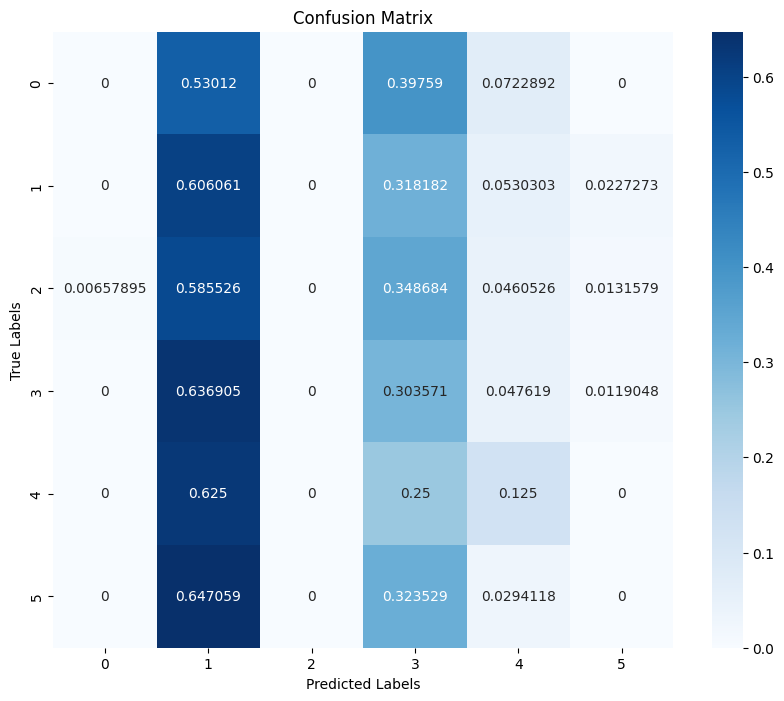

Epoch 14, Validation Loss: 1.7018, Accuracy: 0.2288, F1 Score: 0.1596
Val F1 Score Per Class  [0.         0.33402923 0.         0.28333333 0.05263158 0.        ]


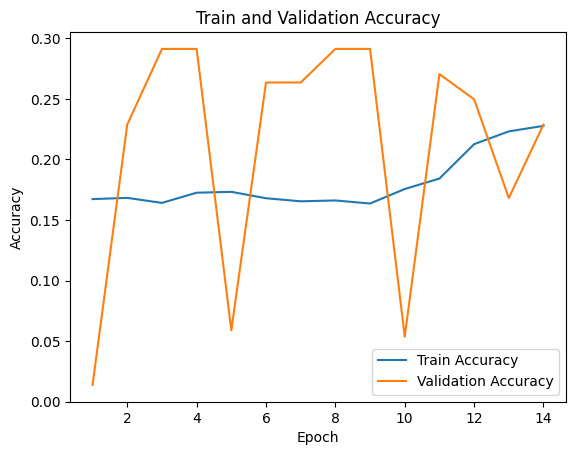

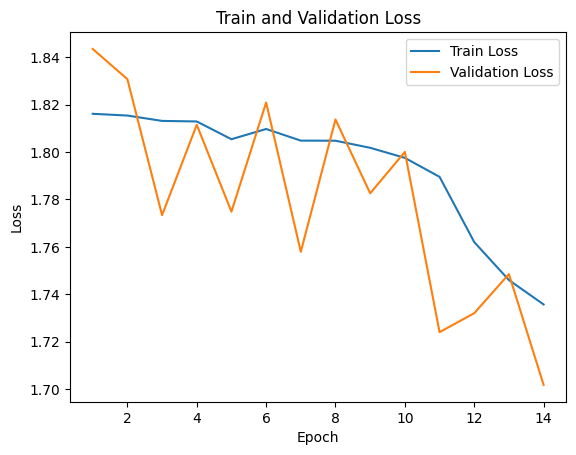

Epoch 15, Train Loss: 1.7390, Accuracy: 0.2349, F1 Score: 0.2094
Train F1 Score Per Class  [0.14106202 0.16080402 0.16823132 0.24203822 0.41240178 0.13304904]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.50it/s, loss=1.73]

[tensor([-0.1721,  0.0030, -0.1547, -0.0055, -0.2319, -0.1699], device='cuda:0'), tensor([-0.1714,  0.0134, -0.2508, -0.0619, -0.7096, -0.1677], device='cuda:0'), tensor([-0.1543,  0.0167, -0.0851,  0.0750, -0.7720, -0.1487], device='cuda:0'), tensor([-0.1128,  0.0153, -0.1075,  0.0514, -1.3111, -0.1152], device='cuda:0'), tensor([-3.1293e-01, -7.1979e-04, -3.1556e-01, -8.5270e-02, -4.5894e+00,
        -2.7991e-01], device='cuda:0'), tensor([-0.2331,  0.0179, -0.3676, -0.1321, -2.6895, -0.2198], device='cuda:0'), tensor([-0.1360,  0.0134, -0.1123,  0.0613,  0.0986, -0.1333], device='cuda:0'), tensor([-0.3961, -0.0275, -0.3675, -0.1011,  0.1554, -0.3575], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.51it/s, loss=1.78]

[tensor([-0.1776,  0.0136, -0.2436, -0.0495, -1.0375, -0.1850], device='cuda:0'), tensor([-0.2769, -0.0194, -0.2107, -0.0028, -0.1505, -0.2604], device='cuda:0'), tensor([ 0.2750,  0.0754,  0.3598,  0.3508, -2.0046,  0.2167], device='cuda:0'), tensor([-0.0160,  0.0341,  0.0013,  0.1142, -0.7781, -0.0284], device='cuda:0'), tensor([ 0.0961,  0.0583,  0.1645,  0.2245, -2.0622,  0.0613], device='cuda:0'), tensor([-0.2492,  0.0087, -0.2263, -0.0188,  0.0623, -0.2268], device='cuda:0'), tensor([ 0.0552,  0.0453,  0.1628,  0.2397, -2.2608,  0.0271], device='cuda:0'), tensor([-0.1342,  0.0108, -0.0286,  0.1094, -0.6631, -0.1376], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.43it/s, loss=1.72]

[tensor([-0.2131, -0.0034, -0.1663,  0.0050, -0.2329, -0.2036], device='cuda:0'), tensor([-0.0344,  0.0177,  0.0405,  0.1632, -0.6534, -0.0555], device='cuda:0'), tensor([-0.0211,  0.0372,  0.0772,  0.1891, -0.7457, -0.0314], device='cuda:0'), tensor([ 0.0384,  0.0545,  0.0950,  0.1937, -0.9828,  0.0202], device='cuda:0'), tensor([-0.0122,  0.0455,  0.0508,  0.1715, -1.4588, -0.0239], device='cuda:0'), tensor([ 0.1179,  0.0771,  0.1227,  0.1990, -1.5732,  0.0951], device='cuda:0'), tensor([-0.2773, -0.0125, -0.3020, -0.0959, -2.5488, -0.2623], device='cuda:0'), tensor([-0.1741,  0.0088, -0.0963,  0.0765, -0.7886, -0.1628], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.43it/s, loss=1.72]

[tensor([-0.0685,  0.0276, -0.0329,  0.0967, -1.1173, -0.0793], device='cuda:0'), tensor([-0.4443, -0.0245, -0.5606, -0.2601,  0.1030, -0.4052], device='cuda:0'), tensor([-0.2457,  0.0032, -0.1977, -0.0293, -0.4470, -0.2261], device='cuda:0'), tensor([-0.2566, -0.0021, -0.2147, -0.0306, -0.2811, -0.2379], device='cuda:0'), tensor([ 0.0851,  0.0578,  0.1914,  0.2501, -1.0882,  0.0551], device='cuda:0'), tensor([-0.1935, -0.0046, -0.1418,  0.0269, -1.2450, -0.1850], device='cuda:0'), tensor([ 0.1547,  0.0569,  0.1918,  0.2414, -1.7444,  0.0995], device='cuda:0'), tensor([-0.2533, -0.0093, -0.1745,  0.0146, -0.4739, -0.2310], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.44it/s, loss=1.72]

[tensor([-0.1018,  0.0151, -0.0466,  0.1023, -1.2444, -0.1047], device='cuda:0'), tensor([-0.1282,  0.0402, -0.0264,  0.1226, -0.2737, -0.1162], device='cuda:0'), tensor([-0.0852,  0.0168,  0.0314,  0.1545, -1.0909, -0.0893], device='cuda:0'), tensor([-0.2700, -0.0312, -0.2292, -0.0413, -0.5091, -0.2547], device='cuda:0'), tensor([-0.0680,  0.0454, -0.0063,  0.1108, -1.0366, -0.0686], device='cuda:0'), tensor([-0.1528,  0.0143, -0.1899, -0.0062, -0.2789, -0.1643], device='cuda:0'), tensor([-0.2090,  0.0045, -0.1270,  0.0559, -0.1853, -0.1908], device='cuda:0'), tensor([ 0.0374,  0.0460,  0.0995,  0.1944, -1.3014,  0.0087], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.43it/s, loss=1.83]

[tensor([-0.1940,  0.0210, -0.1556,  0.0246, -0.4894, -0.1773], device='cuda:0'), tensor([-0.0970,  0.0169, -0.0734,  0.0447, -0.3981, -0.1132], device='cuda:0'), tensor([-0.0497,  0.0262,  0.0669,  0.1829, -0.9463, -0.0524], device='cuda:0'), tensor([-0.2246,  0.0114, -0.1263,  0.0512,  0.2436, -0.1996], device='cuda:0'), tensor([-0.0805,  0.0334, -0.0757,  0.0490, -0.8896, -0.0853], device='cuda:0'), tensor([ 0.2742,  0.0820,  0.2249,  0.2368, -5.2803,  0.2039], device='cuda:0'), tensor([-0.0873,  0.0273, -0.1102,  0.0241, -1.1996, -0.0932], device='cuda:0'), tensor([-0.1400,  0.0186, -0.0489,  0.1041, -0.7107, -0.1310], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.44it/s, loss=1.64]

[tensor([-0.0331,  0.0601,  0.0318,  0.1573, -1.0608, -0.0295], device='cuda:0'), tensor([-0.0327,  0.0267,  0.0736,  0.1701, -1.4675, -0.0474], device='cuda:0'), tensor([ 1.7973e-03,  3.3722e-02, -7.1607e-04,  1.2428e-01, -8.1180e-01,
        -1.6500e-02], device='cuda:0'), tensor([-0.2937,  0.0152, -0.4183, -0.1541, -0.2508, -0.2670], device='cuda:0'), tensor([-0.1060,  0.0404, -0.1498, -0.0159, -0.7018, -0.1044], device='cuda:0'), tensor([ 0.0613,  0.0317,  0.1728,  0.2533, -3.3755,  0.0219], device='cuda:0'), tensor([-0.0527,  0.0236,  0.0100,  0.1286, -4.8253, -0.0644], device='cuda:0'), tensor([-0.1092,  0.0349, -0.0294,  0.1161, -0.2950, -0.1033], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.43it/s, loss=1.78]

[tensor([-0.2007,  0.0295, -0.1623,  0.0215, -0.2584, -0.1816], device='cuda:0'), tensor([-0.0358,  0.0424,  0.0939,  0.2147, -0.8517, -0.0405], device='cuda:0'), tensor([-0.2897, -0.0117, -0.2400, -0.0274,  0.4166, -0.2614], device='cuda:0'), tensor([-0.0526,  0.0440, -0.0193,  0.1111, -0.9292, -0.0567], device='cuda:0'), tensor([-0.0268,  0.0267,  0.0088,  0.1143, -1.1452, -0.0428], device='cuda:0'), tensor([ 0.1336,  0.0437,  0.2605,  0.2966, -2.6884,  0.0851], device='cuda:0'), tensor([-0.3621, -0.0130, -0.3366, -0.0917,  0.1515, -0.3222], device='cuda:0'), tensor([ 0.1545,  0.0495,  0.1215,  0.1842, -2.5564,  0.1066], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.43it/s, loss=1.75]

[tensor([-0.0576,  0.0367,  0.0239,  0.1243, -0.4281, -0.0541], device='cuda:0'), tensor([-0.0887,  0.0360,  0.0038,  0.1160, -0.7924, -0.0890], device='cuda:0'), tensor([-0.1651,  0.0235, -0.1075,  0.0553, -0.5220, -0.1541], device='cuda:0'), tensor([-0.1516,  0.0012, -0.0820,  0.0656, -0.1795, -0.1523], device='cuda:0'), tensor([-0.2703, -0.0020, -0.2367, -0.0254, -1.7248, -0.2500], device='cuda:0'), tensor([-0.3038,  0.0022, -0.2767, -0.0594,  0.0363, -0.2695], device='cuda:0'), tensor([-0.4126, -0.0246, -0.7518, -0.4475,  0.2765, -0.3843], device='cuda:0'), tensor([ 0.0098,  0.0407,  0.0548,  0.1420, -2.3048, -0.0086], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.43it/s, loss=1.73]

[tensor([ 0.1052,  0.0373,  0.0960,  0.1731, -1.0419,  0.0645], device='cuda:0'), tensor([ 0.1704,  0.0614,  0.0564,  0.1325, -1.5349,  0.1109], device='cuda:0'), tensor([-0.0373,  0.0382, -0.0966,  0.0468, -5.2518, -0.0504], device='cuda:0'), tensor([-0.0311,  0.0293,  0.0197,  0.1306, -0.7063, -0.0430], device='cuda:0'), tensor([-0.3401, -0.0414, -0.3011, -0.0826, -1.1001, -0.3176], device='cuda:0'), tensor([-0.4270, -0.0337, -0.3695, -0.1168,  0.1346, -0.3828], device='cuda:0'), tensor([ 0.0338,  0.0441, -0.0171,  0.1036, -0.6853,  0.0148], device='cuda:0'), tensor([-0.1043,  0.0312, -0.0207,  0.1080, -0.2384, -0.0980], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.44it/s, loss=1.78]

[tensor([ 0.0199,  0.0365,  0.0885,  0.1883, -1.8450,  0.0042], device='cuda:0'), tensor([-0.0805,  0.0441,  0.0426,  0.1552, -0.6703, -0.0757], device='cuda:0'), tensor([-0.2090, -0.0171, -0.1559,  0.0198, -0.4502, -0.2074], device='cuda:0'), tensor([-0.2885, -0.0187, -0.3306, -0.1142, -0.3473, -0.2725], device='cuda:0'), tensor([-0.2512,  0.0024, -0.2869, -0.0836, -0.1502, -0.2379], device='cuda:0'), tensor([-0.1143,  0.0155, -0.0479,  0.0885, -0.5924, -0.1235], device='cuda:0'), tensor([-0.1872,  0.0127, -0.1362,  0.0202, -0.3056, -0.1743], device='cuda:0'), tensor([-0.2350, -0.0040, -0.1650,  0.0154, -0.9159, -0.2198], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.45it/s, loss=1.7]

[tensor([-0.3600, -0.0316, -0.3034, -0.0673, -0.2878, -0.3322], device='cuda:0'), tensor([-0.2201,  0.0009, -0.2507, -0.0356, -0.5605, -0.2044], device='cuda:0'), tensor([-0.2960, -0.0028, -0.2517, -0.0390, -0.6392, -0.2635], device='cuda:0'), tensor([ 0.0228,  0.0526,  0.1057,  0.1997, -0.9255,  0.0074], device='cuda:0'), tensor([ 0.1274,  0.0532,  0.1944,  0.2478, -3.3829,  0.0869], device='cuda:0'), tensor([-0.0119,  0.0450, -0.0316,  0.0795, -0.6940, -0.0238], device='cuda:0'), tensor([-0.2850, -0.0079, -0.2610, -0.0542, -0.3852, -0.2638], device='cuda:0'), tensor([-0.3070, -0.0150, -0.2375, -0.0192, -0.2297, -0.2891], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.45it/s, loss=1.72]

[tensor([-0.0418,  0.0416,  0.0287,  0.1531, -0.8723, -0.0488], device='cuda:0'), tensor([-0.1708,  0.0240, -0.0753,  0.0756, -0.2747, -0.1590], device='cuda:0'), tensor([ 0.0743,  0.0514,  0.0791,  0.1660, -1.4293,  0.0423], device='cuda:0'), tensor([-0.1550,  0.0221, -0.0645,  0.0973, -0.4613, -0.1397], device='cuda:0'), tensor([-0.1987,  0.0068, -0.1524,  0.0437, -0.0608, -0.1786], device='cuda:0'), tensor([ 0.0683,  0.0473,  0.0954,  0.1747, -1.0279,  0.0467], device='cuda:0'), tensor([-0.0502,  0.0393,  0.0355,  0.1561, -1.1740, -0.0537], device='cuda:0'), tensor([ 0.0403,  0.0500,  0.0517,  0.1503, -1.4030,  0.0180], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.44it/s, loss=1.75]

[tensor([-0.4510, -0.0385, -0.5627, -0.2808, -1.5374, -0.4120], device='cuda:0'), tensor([-0.3911, -0.0242, -0.3831, -0.1198, -0.3596, -0.3540], device='cuda:0'), tensor([-0.0222,  0.0518,  0.0433,  0.1614, -0.6989, -0.0266], device='cuda:0'), tensor([-0.0211,  0.0217, -0.1005,  0.0432, -4.6748, -0.0568], device='cuda:0'), tensor([ 0.1395,  0.0533,  0.2069,  0.2514, -2.9594,  0.0984], device='cuda:0'), tensor([ 0.0804,  0.0733,  0.0208,  0.1254, -1.1673,  0.0562], device='cuda:0'), tensor([-0.4012, -0.0290, -0.3579, -0.0961,  0.9792, -0.3615], device='cuda:0'), tensor([-0.0571,  0.0389, -0.0240,  0.1059, -1.7250, -0.0622], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.44it/s, loss=1.77]

[tensor([-0.0666,  0.0332,  0.0407,  0.1576, -0.7303, -0.0690], device='cuda:0'), tensor([-0.3524, -0.0271, -0.3299, -0.0891, -0.0610, -0.3203], device='cuda:0'), tensor([-0.1883, -0.0009, -0.0874,  0.0838, -0.8548, -0.1824], device='cuda:0'), tensor([-0.1808,  0.0099, -0.0947,  0.0690, -0.0554, -0.1660], device='cuda:0'), tensor([-0.0641,  0.0218, -0.0345,  0.0947, -1.0080, -0.0667], device='cuda:0'), tensor([-0.1815,  0.0265, -0.2261, -0.0361, -0.6660, -0.1686], device='cuda:0'), tensor([-0.0831,  0.0323,  0.0301,  0.1600, -1.3744, -0.0798], device='cuda:0'), tensor([-0.2285,  0.0050, -0.1933, -0.0066,  0.2316, -0.2113], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.44it/s, loss=1.69]

[tensor([-0.0526,  0.0535,  0.0658,  0.1688, -0.4488, -0.0612], device='cuda:0'), tensor([-0.2356, -0.0101, -0.1938, -0.0121, -0.5025, -0.2258], device='cuda:0'), tensor([ 0.0436,  0.0395,  0.0926,  0.1851, -0.5552,  0.0255], device='cuda:0'), tensor([-0.0925,  0.0172, -0.0275,  0.1038, -0.3910, -0.0942], device='cuda:0'), tensor([-0.0343,  0.0291,  0.0995,  0.2117, -1.5450, -0.0463], device='cuda:0'), tensor([-0.2280, -0.0215, -0.1860, -0.0170, -0.7956, -0.2196], device='cuda:0'), tensor([-0.1497,  0.0112, -0.0835,  0.0659, -0.5152, -0.1443], device='cuda:0'), tensor([-0.0705,  0.0320,  0.0078,  0.1376, -0.8160, -0.0733], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.43it/s, loss=1.67]

[tensor([-0.0860,  0.0211,  0.0048,  0.1291, -0.2971, -0.0899], device='cuda:0'), tensor([-0.0986,  0.0336, -0.0183,  0.1130, -1.1021, -0.0980], device='cuda:0'), tensor([-0.0469,  0.0526,  0.0029,  0.1348, -0.6983, -0.0562], device='cuda:0'), tensor([-0.3075,  0.0060, -0.3897, -0.1318, -1.2642, -0.2827], device='cuda:0'), tensor([-0.0395,  0.0215, -0.1544, -0.0335, -4.5886, -0.0698], device='cuda:0'), tensor([-0.0616,  0.0275,  0.0070,  0.1342, -1.1630, -0.0680], device='cuda:0'), tensor([ 0.1514,  0.0649,  0.1199,  0.1675, -1.1645,  0.1056], device='cuda:0'), tensor([ 0.0376,  0.0569,  0.1214,  0.2138, -0.7319,  0.0205], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.44it/s, loss=1.66]

[tensor([-0.1734,  0.0161, -0.1696,  0.0014, -0.4754, -0.1588], device='cuda:0'), tensor([-0.0907,  0.0162, -0.0606,  0.0847, -1.1839, -0.0939], device='cuda:0'), tensor([-0.1327,  0.0109, -0.0644,  0.0865, -0.4259, -0.1318], device='cuda:0'), tensor([-1.5614e-01,  4.0857e-02, -1.7486e-01,  9.2755e-04, -1.5360e+00,
        -1.4365e-01], device='cuda:0'), tensor([ 0.1117,  0.0549,  0.1849,  0.2417, -1.3146,  0.0731], device='cuda:0'), tensor([ 0.0587,  0.0400,  0.1388,  0.2157, -2.1043,  0.0297], device='cuda:0'), tensor([-0.2265,  0.0086, -0.1486,  0.0403, -0.1103, -0.2095], device='cuda:0'), tensor([ 0.0361,  0.0469,  0.0350,  0.1325, -0.8312,  0.0221], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.44it/s, loss=1.65]

[tensor([ 0.1067,  0.0465,  0.1400,  0.2154, -2.2934,  0.0625], device='cuda:0'), tensor([-0.4662, -0.0465, -0.4443, -0.1809, -0.1413, -0.4250], device='cuda:0'), tensor([-0.0276,  0.0379,  0.0588,  0.1781, -0.9974, -0.0370], device='cuda:0'), tensor([-0.2312, -0.0080, -0.1457,  0.0367, -0.4235, -0.2143], device='cuda:0'), tensor([ 0.0155,  0.0206,  0.1223,  0.2117, -1.2337, -0.0118], device='cuda:0'), tensor([ 0.1246,  0.0637,  0.1717,  0.2305, -2.2696,  0.0931], device='cuda:0'), tensor([-0.3278, -0.0122, -0.4248, -0.1821, -0.2751, -0.3124], device='cuda:0'), tensor([-0.0507,  0.0494, -0.0106,  0.1059, -1.6119, -0.0558], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.45it/s, loss=1.75]

[tensor([-0.0312,  0.0360,  0.0550,  0.1687, -1.1799, -0.0388], device='cuda:0'), tensor([ 0.0208,  0.0172,  0.0751,  0.1860, -0.7360, -0.0075], device='cuda:0'), tensor([-0.1724,  0.0100, -0.1421,  0.0263, -1.6613, -0.1694], device='cuda:0'), tensor([-0.2054,  0.0167, -0.1466,  0.0425, -0.6826, -0.1813], device='cuda:0'), tensor([-0.2951,  0.0003, -0.1961, -0.0008,  0.0273, -0.2672], device='cuda:0'), tensor([ 0.0663,  0.0585,  0.1004,  0.1854, -0.8922,  0.0417], device='cuda:0'), tensor([ 0.6846,  0.1328,  0.5357,  0.4358, -6.0339,  0.5456], device='cuda:0'), tensor([-0.1252,  0.0144, -0.0674,  0.0823, -0.4163, -0.1207], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.46it/s, loss=1.69]

[tensor([-0.0713,  0.0363,  0.0124,  0.1361, -0.8901, -0.0762], device='cuda:0'), tensor([-0.0269,  0.0373,  0.0664,  0.1815, -0.8248, -0.0335], device='cuda:0'), tensor([-0.2932, -0.0042, -0.3448, -0.1119, -0.1850, -0.2657], device='cuda:0'), tensor([ 0.0378,  0.0403,  0.1289,  0.2051, -1.7680,  0.0158], device='cuda:0'), tensor([ 0.0802,  0.0536,  0.1027,  0.1810, -1.0284,  0.0543], device='cuda:0'), tensor([-0.3478, -0.0301, -0.5993, -0.3197,  0.1137, -0.3328], device='cuda:0'), tensor([-0.1468,  0.0432, -0.0191,  0.1187, -0.8059, -0.1334], device='cuda:0'), tensor([-0.1825,  0.0099, -0.0910,  0.0403, -0.5017, -0.1721], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:20,  2.46it/s, loss=1.69]

[tensor([-0.1784,  0.0049, -0.1088,  0.0442, -0.7232, -0.1707], device='cuda:0'), tensor([-0.0375,  0.0330,  0.0497,  0.1722, -1.2260, -0.0436], device='cuda:0'), tensor([-0.1997,  0.0035, -0.2009, -0.0200, -0.7024, -0.1908], device='cuda:0'), tensor([-0.0449,  0.0411,  0.0479,  0.1618, -0.5958, -0.0492], device='cuda:0'), tensor([-0.3749, -0.0345, -0.3088, -0.0631,  0.2822, -0.3417], device='cuda:0'), tensor([-0.2060,  0.0114, -0.2168, -0.0287, -1.5333, -0.1930], device='cuda:0'), tensor([-0.0117,  0.0464,  0.1198,  0.2212, -0.9698, -0.0285], device='cuda:0'), tensor([-0.0162,  0.0171,  0.1318,  0.2277, -1.2727, -0.0383], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.46it/s, loss=1.73]

[tensor([-0.1042,  0.0135, -0.0803,  0.0572, -0.8433, -0.1194], device='cuda:0'), tensor([-0.4478, -0.0174, -0.4850, -0.2017, -0.0897, -0.3982], device='cuda:0'), tensor([-0.0154,  0.0287,  0.0928,  0.1883, -1.9818, -0.0356], device='cuda:0'), tensor([-0.2697, -0.0051, -0.1581,  0.0425, -0.2200, -0.2441], device='cuda:0'), tensor([-1.2647e-01,  1.8584e-03, -1.2904e-01,  2.2655e-02, -5.2031e+00,
        -1.2755e-01], device='cuda:0'), tensor([-0.4414, -0.0326, -0.3798, -0.1225,  0.0900, -0.3928], device='cuda:0'), tensor([-0.4414, -0.0261, -0.4199, -0.1356,  0.4446, -0.3926], device='cuda:0'), tensor([-1.4841e-01, -1.0323e-03, -9.7447e-02,  7.1965e-02, -1.3412e+00,
        -1.4629e-01], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.45it/s, loss=1.69]

[tensor([-0.2308,  0.0058, -0.1714,  0.0189, -0.3725, -0.2111], device='cuda:0'), tensor([-0.1772, -0.0164, -0.0843,  0.0785, -2.1316, -0.1800], device='cuda:0'), tensor([ 0.0212,  0.0374,  0.0848,  0.1842, -1.0113,  0.0113], device='cuda:0'), tensor([-0.0955,  0.0280, -0.1072,  0.0316, -0.2257, -0.0962], device='cuda:0'), tensor([-0.2528, -0.0098, -0.1912, -0.0018, -1.0923, -0.2288], device='cuda:0'), tensor([-0.2138,  0.0113, -0.1237,  0.0562, -0.7119, -0.1916], device='cuda:0'), tensor([-0.1996, -0.0085, -0.1458,  0.0328, -0.7493, -0.1886], device='cuda:0'), tensor([-0.0588,  0.0347, -0.1090,  0.0182, -2.9579, -0.0737], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.45it/s, loss=1.78]

[tensor([-0.1842,  0.0220, -0.2598, -0.0608, -0.5370, -0.1735], device='cuda:0'), tensor([-0.5000, -0.0382, -0.4679, -0.1697,  0.2175, -0.4401], device='cuda:0'), tensor([-0.3027, -0.0249, -0.1929,  0.0095, -0.7133, -0.2782], device='cuda:0'), tensor([-0.1536,  0.0177, -0.0582,  0.0908, -0.6674, -0.1448], device='cuda:0'), tensor([-0.2626,  0.0009, -0.2134, -0.0043, -0.1764, -0.2372], device='cuda:0'), tensor([-3.2141e-01,  4.7036e-04, -4.3477e-01, -1.9164e-01,  5.1807e-01,
        -2.9305e-01], device='cuda:0'), tensor([-0.2261,  0.0134, -0.2204, -0.0123, -1.0332, -0.2024], device='cuda:0'), tensor([-0.1947, -0.0169, -0.1680,  0.0137, -0.8967, -0.1938], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.45it/s, loss=1.67]

[tensor([-0.0089,  0.0325,  0.0281,  0.1491, -0.5129, -0.0285], device='cuda:0'), tensor([-0.3482, -0.0178, -0.3043, -0.0769, -0.5879, -0.3144], device='cuda:0'), tensor([ 1.5273,  0.2677,  1.1754,  0.8993, -6.6048,  1.2282], device='cuda:0'), tensor([ 0.0660,  0.0487,  0.1393,  0.2193, -1.6121,  0.0425], device='cuda:0'), tensor([-0.0273,  0.0318,  0.0330,  0.1573, -1.1379, -0.0370], device='cuda:0'), tensor([ 0.0813,  0.0569,  0.1685,  0.2329, -1.2505,  0.0528], device='cuda:0'), tensor([ 0.0923,  0.0616,  0.0919,  0.1810, -1.8080,  0.0643], device='cuda:0'), tensor([ 0.0633,  0.0343,  0.1612,  0.2232, -1.2410,  0.0343], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:18,  2.45it/s, loss=1.74]

[tensor([ 0.0632,  0.0326,  0.1621,  0.2219, -0.9033,  0.0278], device='cuda:0'), tensor([-0.2356, -0.0060, -0.1797,  0.0187, -0.0591, -0.2206], device='cuda:0'), tensor([-0.2474,  0.0016, -0.2090, -0.0194, -0.3633, -0.2302], device='cuda:0'), tensor([-0.0360,  0.0594,  0.0427,  0.1562, -0.4319, -0.0350], device='cuda:0'), tensor([ 0.0152,  0.0446,  0.0631,  0.1674, -0.7901, -0.0075], device='cuda:0'), tensor([-0.3068, -0.0053, -0.2977, -0.0788, -0.3479, -0.2826], device='cuda:0'), tensor([ 0.0604,  0.0644,  0.1096,  0.2096, -0.7608,  0.0444], device='cuda:0'), tensor([-0.2210, -0.0097, -0.1392,  0.0390, -0.3018, -0.2087], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.44it/s, loss=1.67]

[tensor([-0.1319,  0.0175, -0.1899, -0.0116, -0.3625, -0.1319], device='cuda:0'), tensor([ 0.0664,  0.0407,  0.1982,  0.2483, -2.4830,  0.0379], device='cuda:0'), tensor([-0.1044,  0.0277, -0.1215,  0.0170, -3.9991, -0.1089], device='cuda:0'), tensor([-0.1385,  0.0189, -0.1050,  0.0547, -0.4816, -0.1288], device='cuda:0'), tensor([-0.1511,  0.0287, -0.1224,  0.0501, -0.3175, -0.1441], device='cuda:0'), tensor([-0.3567, -0.0230, -0.2844, -0.0476, -0.0325, -0.3196], device='cuda:0'), tensor([-0.2003, -0.0007, -0.1556,  0.0256, -0.6818, -0.1899], device='cuda:0'), tensor([-0.0301,  0.0367,  0.0328,  0.1498, -1.1238, -0.0391], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.45it/s, loss=1.65]

[tensor([ 0.0884,  0.0492,  0.1294,  0.1832, -3.2244,  0.0573], device='cuda:0'), tensor([-0.2428, -0.0055, -0.1755,  0.0220, -1.9987, -0.2240], device='cuda:0'), tensor([-0.0955,  0.0185, -0.0373,  0.0856, -0.2250, -0.1014], device='cuda:0'), tensor([-0.0785,  0.0260,  0.0248,  0.1470, -1.1060, -0.0809], device='cuda:0'), tensor([-0.2607,  0.0024, -0.1611,  0.0387, -0.1648, -0.2327], device='cuda:0'), tensor([-0.1017,  0.0374, -0.0400,  0.1051, -0.5668, -0.0979], device='cuda:0'), tensor([ 0.0225,  0.0442,  0.1203,  0.2073, -0.9118,  0.0055], device='cuda:0'), tensor([-0.1205,  0.0205, -0.0107,  0.1298, -0.2750, -0.1139], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.45it/s, loss=1.7]

[tensor([-0.1438,  0.0127, -0.0589,  0.0976, -0.5971, -0.1378], device='cuda:0'), tensor([-0.2145,  0.0094, -0.1735,  0.0200, -1.0770, -0.2003], device='cuda:0'), tensor([-0.2924,  0.0078, -0.2820, -0.0465, -0.4905, -0.2599], device='cuda:0'), tensor([-0.1784,  0.0161, -0.1471,  0.0137, -1.4586, -0.1652], device='cuda:0'), tensor([-0.2931, -0.0087, -0.2454, -0.0358, -1.1197, -0.2613], device='cuda:0'), tensor([-0.2534,  0.0033, -0.2162, -0.0079,  0.2330, -0.2300], device='cuda:0'), tensor([-0.1340,  0.0336, -0.0549,  0.0898, -0.6706, -0.1308], device='cuda:0'), tensor([-0.4091, -0.0226, -0.4025, -0.1415,  0.4355, -0.3674], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.44it/s, loss=1.65]

[tensor([ 0.3178,  0.0884,  0.2266,  0.2331, -2.0918,  0.2526], device='cuda:0'), tensor([-0.0951,  0.0371, -0.0597,  0.0976, -0.6691, -0.0937], device='cuda:0'), tensor([-0.0867,  0.0389,  0.0206,  0.1482, -1.2712, -0.0842], device='cuda:0'), tensor([-0.1029,  0.0202, -0.0943,  0.0515, -0.4671, -0.1182], device='cuda:0'), tensor([-0.0741,  0.0304,  0.0460,  0.1545, -0.6346, -0.0775], device='cuda:0'), tensor([-0.1264,  0.0213, -0.1473,  0.0064, -0.6036, -0.1266], device='cuda:0'), tensor([-0.3588, -0.0113, -1.3128, -0.8292, -6.0902, -0.4133], device='cuda:0'), tensor([-0.0515,  0.0235,  0.0145,  0.1436, -2.1097, -0.0597], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.45it/s, loss=1.65]

[tensor([-0.2707, -0.0018, -0.2081, -0.0111, -1.4423, -0.2469], device='cuda:0'), tensor([-0.3377, -0.0203, -0.2549, -0.0349, -0.3392, -0.3072], device='cuda:0'), tensor([ 0.0770,  0.0522, -0.0250,  0.0860, -1.4329,  0.0348], device='cuda:0'), tensor([-0.0922,  0.0253, -0.0640,  0.0841, -0.9832, -0.0973], device='cuda:0'), tensor([-0.0979,  0.0277, -0.0213,  0.0916, -0.9009, -0.1047], device='cuda:0'), tensor([-0.0430,  0.0369,  0.0425,  0.1660, -1.6165, -0.0499], device='cuda:0'), tensor([-0.0058,  0.0370,  0.0801,  0.1651, -1.1263, -0.0201], device='cuda:0'), tensor([-0.1321,  0.0169, -0.0507,  0.0992, -0.9510, -0.1282], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.44it/s, loss=1.64]

[tensor([-0.1798,  0.0018, -0.0650,  0.1014, -0.9777, -0.1736], device='cuda:0'), tensor([-0.2694, -0.0087, -0.2248, -0.0310, -0.7451, -0.2548], device='cuda:0'), tensor([-0.2493,  0.0250, -0.1774,  0.0154, -0.3969, -0.2194], device='cuda:0'), tensor([-0.0559,  0.0310, -0.0203,  0.1033, -0.7494, -0.0665], device='cuda:0'), tensor([-0.0420,  0.0310,  0.0060,  0.1296, -1.8847, -0.0569], device='cuda:0'), tensor([ 0.0779,  0.0491, -0.1853, -0.0471, -2.6110,  0.0324], device='cuda:0'), tensor([-0.0669,  0.0099, -0.0029,  0.1187, -0.4653, -0.0800], device='cuda:0'), tensor([-0.1517,  0.0232, -0.0171,  0.1129, -0.3450, -0.1413], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:16,  2.43it/s, loss=1.67]

[tensor([ 0.2497,  0.0716,  0.1417,  0.1813, -1.5322,  0.1876], device='cuda:0'), tensor([ 0.1587,  0.0813,  0.1768,  0.2293, -1.8462,  0.1324], device='cuda:0'), tensor([-0.4512, -0.0180, -0.4008, -0.1336, -0.2974, -0.3969], device='cuda:0'), tensor([ 0.0880,  0.0395, -0.0447,  0.0617, -1.4914,  0.0424], device='cuda:0'), tensor([-0.3848, -0.0309, -0.2985, -0.0670,  0.4953, -0.3475], device='cuda:0'), tensor([-0.0376,  0.0399,  0.0144,  0.1413, -1.1029, -0.0436], device='cuda:0'), tensor([-0.1917,  0.0018, -0.1427,  0.0316,  0.0259, -0.1852], device='cuda:0'), tensor([-0.0991,  0.0010,  0.0048,  0.1219, -0.6482, -0.1104], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.45it/s, loss=1.62]

[tensor([ 0.2791,  0.0893,  0.1682,  0.1954, -4.3105,  0.2150], device='cuda:0'), tensor([-0.1932,  0.0058, -0.1478,  0.0310, -0.6030, -0.1840], device='cuda:0'), tensor([-0.3547, -0.0234, -0.3981, -0.1503, -2.0617, -0.3231], device='cuda:0'), tensor([ 0.0578,  0.0381,  0.0453,  0.1542, -1.1848,  0.0267], device='cuda:0'), tensor([-0.0548,  0.0273,  0.0526,  0.1622, -0.4979, -0.0617], device='cuda:0'), tensor([ 0.0404,  0.0383,  0.0627,  0.1605, -0.8746,  0.0242], device='cuda:0'), tensor([-0.1649,  0.0115, -0.0971,  0.0693, -2.9886, -0.1573], device='cuda:0'), tensor([-0.1123,  0.0273, -0.0076,  0.1360, -0.4751, -0.1056], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.43it/s, loss=1.61]

[tensor([ 0.0263,  0.0467,  0.0797,  0.1784, -0.9650,  0.0019], device='cuda:0'), tensor([-2.6027e-01,  7.2043e-03, -1.8335e-01, -2.0061e-04, -1.3547e+00,
        -2.3080e-01], device='cuda:0'), tensor([ 0.0654,  0.0912, -0.1992, -0.0261, -1.5008,  0.0311], device='cuda:0'), tensor([-0.1378, -0.0040, -0.0874,  0.0621, -1.2664, -0.1397], device='cuda:0'), tensor([ 0.0076,  0.0568,  0.0587,  0.1454, -1.1060, -0.0092], device='cuda:0'), tensor([ 2.3492e-03,  8.7019e-02, -1.6066e-01, -1.2877e-02, -5.3439e+00,
        -3.5233e-02], device='cuda:0'), tensor([-0.0225,  0.0498,  0.0235,  0.1315, -1.3177, -0.0316], device='cuda:0'), tensor([ 0.0305,  0.0513,  0.0852,  0.1663, -1.2996,  0.0140], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.44it/s, loss=1.77]

[tensor([-0.0736,  0.0266, -0.0760,  0.0525, -0.5859, -0.0825], device='cuda:0'), tensor([-0.1818,  0.0097, -0.1238,  0.0595, -0.4652, -0.1718], device='cuda:0'), tensor([-0.0555,  0.0314,  0.0221,  0.1576, -1.8986, -0.0650], device='cuda:0'), tensor([-0.0986,  0.0264, -0.0603,  0.0762, -0.8942, -0.1011], device='cuda:0'), tensor([-0.2014,  0.0198, -0.1735,  0.0204, -0.5048, -0.1825], device='cuda:0'), tensor([-0.1233,  0.0150, -0.0349,  0.1136, -0.8046, -0.1232], device='cuda:0'), tensor([-0.1006,  0.0249, -0.0244,  0.1142, -0.5237, -0.1024], device='cuda:0'), tensor([-0.2349, -0.0062, -0.1800,  0.0202, -1.0992, -0.2212], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.44it/s, loss=1.62]

[tensor([-0.1326,  0.0205, -0.2045, -0.0401, -1.4544, -0.1465], device='cuda:0'), tensor([-0.1940,  0.0182, -0.1548,  0.0106, -0.5348, -0.1796], device='cuda:0'), tensor([-0.2744,  0.0110, -0.2808, -0.0671, -0.4873, -0.2439], device='cuda:0'), tensor([-0.0869,  0.0505, -0.2729, -0.0848, -2.2351, -0.0983], device='cuda:0'), tensor([-7.1853e-02,  4.6771e-03,  2.9549e-02,  1.5465e-01, -5.0579e+00,
        -8.9924e-02], device='cuda:0'), tensor([-0.2594,  0.0005, -0.1624,  0.0328, -0.0829, -0.2373], device='cuda:0'), tensor([ 0.0114,  0.0547,  0.0193,  0.1240, -1.6486, -0.0046], device='cuda:0'), tensor([ 0.0051,  0.0596,  0.0231,  0.1391, -1.9800, -0.0066], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.44it/s, loss=1.65]

[tensor([-0.1940,  0.0175, -0.1254,  0.0406, -1.1404, -0.1822], device='cuda:0'), tensor([ 0.1425,  0.0612,  0.1360,  0.2040, -2.0107,  0.1033], device='cuda:0'), tensor([ 2.3027e-02,  3.0372e-02,  1.1065e-02,  1.1132e-01, -1.0101e+00,
        -4.7825e-05], device='cuda:0'), tensor([-0.0857,  0.0143, -0.1273,  0.0339, -0.3204, -0.0963], device='cuda:0'), tensor([ 3.5222e-02,  6.2894e-04,  1.0232e-01,  1.9895e-01, -2.8889e+00,
        -1.2344e-02], device='cuda:0'), tensor([-0.1853,  0.0022, -0.0688,  0.0921, -0.4635, -0.1769], device='cuda:0'), tensor([-0.2005,  0.0113, -0.1516,  0.0469, -0.7227, -0.1818], device='cuda:0'), tensor([-0.1346,  0.0107, -0.0683,  0.0925, -0.5298, -0.1334], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.45it/s, loss=1.67]

[tensor([ 0.0373,  0.0519,  0.0589,  0.1480, -1.3082,  0.0206], device='cuda:0'), tensor([-0.0732,  0.0329, -0.0372,  0.0974, -1.5033, -0.0778], device='cuda:0'), tensor([ 0.0972,  0.0494,  0.1129,  0.1757, -3.7724,  0.0662], device='cuda:0'), tensor([-0.0094,  0.0377,  0.0710,  0.1707, -1.1477, -0.0271], device='cuda:0'), tensor([-0.0105,  0.0544,  0.0525,  0.1626, -0.8509, -0.0195], device='cuda:0'), tensor([-0.0274,  0.0415, -0.0133,  0.1055, -3.0460, -0.0388], device='cuda:0'), tensor([-0.0394,  0.0332, -0.0034,  0.1152, -0.4089, -0.0546], device='cuda:0'), tensor([ 0.0336,  0.0106,  0.0795,  0.1643, -1.6782, -0.0045], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.45it/s, loss=1.69]

[tensor([-0.2449, -0.0202, -0.1595,  0.0251, -0.4273, -0.2327], device='cuda:0'), tensor([-0.3153, -0.0055, -0.2370, -0.0153,  0.1230, -0.2883], device='cuda:0'), tensor([-0.0715,  0.0245, -0.0196,  0.1198, -1.2217, -0.0799], device='cuda:0'), tensor([-0.3121, -0.0032, -0.2394, -0.0173, -1.3645, -0.2806], device='cuda:0'), tensor([-0.0010,  0.0492,  0.1146,  0.2129, -0.9170, -0.0141], device='cuda:0'), tensor([-0.0902,  0.0149,  0.0127,  0.1498, -1.2171, -0.0995], device='cuda:0'), tensor([-0.1979,  0.0052, -0.2218, -0.0483,  0.0291, -0.1957], device='cuda:0'), tensor([-0.2791, -0.0184, -0.3996, -0.1655, -0.4923, -0.2568], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.44it/s, loss=1.71]

[tensor([-0.3139,  0.0060, -0.4934, -0.1864, -1.3647, -0.2936], device='cuda:0'), tensor([-0.0791,  0.0324,  0.0410,  0.1517, -0.8620, -0.0807], device='cuda:0'), tensor([ 0.2569,  0.0915,  0.1404,  0.1874, -3.4472,  0.1821], device='cuda:0'), tensor([-2.0884e-01,  2.2581e-02, -2.0685e-01,  1.1137e-03, -1.4368e+00,
        -1.9391e-01], device='cuda:0'), tensor([-0.0175,  0.0421,  0.0579,  0.1825, -1.7482, -0.0302], device='cuda:0'), tensor([ 0.0250,  0.0419,  0.0941,  0.1895, -0.9542,  0.0045], device='cuda:0'), tensor([-0.1986,  0.0103, -0.1544,  0.0256,  0.0149, -0.1821], device='cuda:0'), tensor([-0.3126, -0.0198, -0.2522, -0.0434, -0.2970, -0.2864], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.44it/s, loss=1.76]

[tensor([-0.5062, -0.0437, -0.4416, -0.1500,  0.1645, -0.4510], device='cuda:0'), tensor([-0.4398, -0.0381, -0.5739, -0.2732,  0.2241, -0.4026], device='cuda:0'), tensor([-0.0922,  0.0343,  0.0199,  0.1412, -0.3817, -0.0904], device='cuda:0'), tensor([-0.2129,  0.0107, -0.1134,  0.0675, -1.0093, -0.1951], device='cuda:0'), tensor([-0.1680,  0.0218, -0.1191,  0.0467,  0.0504, -0.1507], device='cuda:0'), tensor([-0.2884, -0.0246, -0.3227, -0.0972, -1.3886, -0.2806], device='cuda:0'), tensor([-0.2518,  0.0030, -0.2454, -0.0616, -1.0006, -0.2359], device='cuda:0'), tensor([-0.3481, -0.0263, -0.4103, -0.1762, -0.7693, -0.3213], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:11,  2.44it/s, loss=1.66]

[tensor([ 0.5239,  0.1230,  0.3171,  0.2583, -4.4824,  0.3798], device='cuda:0'), tensor([ 0.0360,  0.0566,  0.1004,  0.1827, -0.8993,  0.0170], device='cuda:0'), tensor([-0.1621,  0.0022, -0.0751,  0.0741, -1.0582, -0.1582], device='cuda:0'), tensor([-0.1316,  0.0203, -0.0692,  0.0882, -0.6409, -0.1227], device='cuda:0'), tensor([-0.3076, -0.0086, -0.2432, -0.0232, -0.5813, -0.2774], device='cuda:0'), tensor([-0.1199,  0.0162, -0.0314,  0.1053, -0.9797, -0.1240], device='cuda:0'), tensor([-0.2482, -0.0072, -0.2470, -0.0573, -0.2050, -0.2359], device='cuda:0'), tensor([-0.0366,  0.0388, -0.0305,  0.1194, -0.2078, -0.0453], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.43it/s, loss=1.67]

[tensor([-0.1659,  0.0198, -0.0778,  0.0889, -0.1724, -0.1559], device='cuda:0'), tensor([-0.0224,  0.0374, -0.0058,  0.1227, -1.2849, -0.0433], device='cuda:0'), tensor([-0.1302,  0.0227, -0.1365,  0.0250, -1.2158, -0.1263], device='cuda:0'), tensor([-0.0034,  0.0419,  0.0371,  0.1509, -1.0276, -0.0307], device='cuda:0'), tensor([-0.3530, -0.0195, -0.3355, -0.0952, -0.2468, -0.3259], device='cuda:0'), tensor([-0.0541,  0.0161,  0.0196,  0.0967, -1.4986, -0.0757], device='cuda:0'), tensor([-0.1617,  0.0386, -0.0522,  0.1123, -0.7443, -0.1513], device='cuda:0'), tensor([-0.0426,  0.0309,  0.0693,  0.1618, -0.4117, -0.0522], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.44it/s, loss=1.62]

[tensor([-0.3679, -0.0104, -0.2747, -0.0331, -0.6429, -0.3316], device='cuda:0'), tensor([-0.3672, -0.0305, -0.2770, -0.0511, -0.1413, -0.3316], device='cuda:0'), tensor([-0.3001, -0.0316, -0.2329, -0.0088, -4.3999, -0.2885], device='cuda:0'), tensor([ 0.1745,  0.0665,  0.3175,  0.3422, -2.8679,  0.1346], device='cuda:0'), tensor([ 0.0979,  0.0702,  0.0747,  0.1762, -1.7807,  0.0722], device='cuda:0'), tensor([-0.4320, -0.0322, -0.3578, -0.0994, -0.5052, -0.3850], device='cuda:0'), tensor([-0.1755,  0.0198, -0.1071,  0.0668, -0.9836, -0.1656], device='cuda:0'), tensor([-0.1424,  0.0220, -0.1531,  0.0091, -3.0240, -0.1402], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.44it/s, loss=1.65]

[tensor([ 0.0073,  0.0337,  0.0646,  0.1666, -2.8026, -0.0179], device='cuda:0'), tensor([ 0.0580,  0.0441,  0.0992,  0.1923, -0.8645,  0.0263], device='cuda:0'), tensor([-0.1309,  0.0217, -0.0729,  0.0728, -0.3135, -0.1231], device='cuda:0'), tensor([-0.1968, -0.0008, -0.1177,  0.0465, -0.0579, -0.1873], device='cuda:0'), tensor([-0.3427, -0.0151, -0.2789, -0.0549, -1.6715, -0.3088], device='cuda:0'), tensor([-0.1557,  0.0120, -0.0560,  0.1010, -0.9520, -0.1451], device='cuda:0'), tensor([ 0.1195,  0.0543,  0.2138,  0.2578, -1.1547,  0.0893], device='cuda:0'), tensor([-0.1677,  0.0128, -0.1505,  0.0297, -2.2357, -0.1617], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.44it/s, loss=1.68]

[tensor([-0.3421, -0.0204, -0.2735, -0.0488,  0.7485, -0.3029], device='cuda:0'), tensor([ 0.2375,  0.0734,  0.2085,  0.2339, -1.8135,  0.1749], device='cuda:0'), tensor([-0.1115,  0.0303,  0.0018,  0.1392, -1.0941, -0.1059], device='cuda:0'), tensor([-0.1289,  0.0072, -0.0941,  0.0400, -1.3434, -0.1340], device='cuda:0'), tensor([-0.1540,  0.0207, -0.0956,  0.0633, -0.3505, -0.1501], device='cuda:0'), tensor([-0.3471, -0.0177, -0.2726, -0.0471,  0.2765, -0.3168], device='cuda:0'), tensor([-0.3354, -0.0154, -0.2615, -0.0436, -0.8379, -0.2990], device='cuda:0'), tensor([-0.1495,  0.0079, -0.1198,  0.0535, -0.6164, -0.1470], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.45it/s, loss=1.68]

[tensor([-0.2476, -0.0063, -0.2827, -0.0671, -0.6134, -0.2323], device='cuda:0'), tensor([-0.1004,  0.0159, -0.0247,  0.1278, -0.8428, -0.1050], device='cuda:0'), tensor([-0.0600,  0.0382,  0.0272,  0.1541, -0.3927, -0.0609], device='cuda:0'), tensor([-0.1083,  0.0347, -0.0306,  0.1076, -0.6934, -0.0991], device='cuda:0'), tensor([-0.1376,  0.0195, -0.0507,  0.0996, -0.3174, -0.1285], device='cuda:0'), tensor([-0.1096,  0.0116, -0.0234,  0.1001, -0.2785, -0.1143], device='cuda:0'), tensor([-0.0146,  0.0425, -0.0468,  0.0853, -1.7277, -0.0305], device='cuda:0'), tensor([ 0.1399,  0.0585,  0.1790,  0.2269, -1.3745,  0.1025], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.45it/s, loss=1.73]

[tensor([-0.2712, -0.0036, -0.2050, -0.0149, -0.2632, -0.2468], device='cuda:0'), tensor([-0.0560,  0.0269,  0.0140,  0.1401, -0.7162, -0.0672], device='cuda:0'), tensor([-0.0724,  0.0319, -0.0335,  0.1109, -0.4348, -0.0717], device='cuda:0'), tensor([-0.4557, -0.0267, -0.4715, -0.1921, -0.1686, -0.4066], device='cuda:0'), tensor([-0.1089,  0.0460,  0.0192,  0.1493, -0.5425, -0.0943], device='cuda:0'), tensor([-0.0930,  0.0135,  0.0267,  0.1498, -0.6037, -0.0988], device='cuda:0'), tensor([-0.0939,  0.0232, -0.0183,  0.1124, -0.6033, -0.0947], device='cuda:0'), tensor([-0.1241,  0.0117,  0.0175,  0.1562, -0.5441, -0.1251], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:09,  2.44it/s, loss=1.65]

[tensor([-0.1466,  0.0116, -0.1521,  0.0153, -0.0550, -0.1494], device='cuda:0'), tensor([-0.0449,  0.0422, -0.0227,  0.1153, -0.9080, -0.0486], device='cuda:0'), tensor([-0.3174, -0.0080, -0.2079,  0.0058, -0.6372, -0.2841], device='cuda:0'), tensor([-0.0171,  0.0754,  0.0660,  0.1843, -0.7022, -0.0186], device='cuda:0'), tensor([-0.0876,  0.0204, -0.0426,  0.1024, -0.6312, -0.0911], device='cuda:0'), tensor([-0.1026,  0.0071, -0.0465,  0.0835, -0.2411, -0.1159], device='cuda:0'), tensor([ 0.5599,  0.0841,  0.5447,  0.4775, -5.7669,  0.4305], device='cuda:0'), tensor([-0.0917,  0.0062, -0.0075,  0.1317, -2.3530, -0.1049], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.45it/s, loss=1.73]

[tensor([-0.1369,  0.0019, -0.0624,  0.0952, -0.1414, -0.1331], device='cuda:0'), tensor([-0.1098,  0.0225, -0.0403,  0.0885, -1.4813, -0.1114], device='cuda:0'), tensor([-0.4631, -0.0429, -0.3978, -0.1372,  0.2005, -0.4198], device='cuda:0'), tensor([-0.2669,  0.0113, -0.1902, -0.0037, -0.7679, -0.2415], device='cuda:0'), tensor([ 0.0404,  0.0678,  0.1381,  0.2395, -0.6038,  0.0157], device='cuda:0'), tensor([-0.1278,  0.0061, -0.0223,  0.1087, -0.4131, -0.1315], device='cuda:0'), tensor([-0.1763, -0.0029, -0.1250,  0.0440,  0.1660, -0.1682], device='cuda:0'), tensor([-0.2983, -0.0126, -0.2252, -0.0183, -0.7515, -0.2724], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.45it/s, loss=1.63]

[tensor([-0.2123,  0.0020, -0.1845,  0.0016, -1.0418, -0.2018], device='cuda:0'), tensor([ 0.5063,  0.1120,  0.3900,  0.3587, -5.4446,  0.3934], device='cuda:0'), tensor([-0.0877,  0.0336, -0.0392,  0.0954, -1.3388, -0.0860], device='cuda:0'), tensor([-0.2380, -0.0111, -0.1915, -0.0057, -1.0063, -0.2177], device='cuda:0'), tensor([-0.1011,  0.0153, -0.0242,  0.1087, -0.9467, -0.1062], device='cuda:0'), tensor([-0.2356,  0.0112, -0.1797,  0.0076, -0.9276, -0.2098], device='cuda:0'), tensor([ 0.0567,  0.0293,  0.1560,  0.2360, -2.7111,  0.0218], device='cuda:0'), tensor([ 0.0576,  0.0367,  0.1697,  0.2450, -1.1257,  0.0368], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.44it/s, loss=1.72]

[tensor([-0.8283, -0.0941, -0.8486, -0.4264, -1.3494, -0.7342], device='cuda:0'), tensor([-0.2403, -0.0369, -0.1936, -0.0061, -0.2837, -0.2408], device='cuda:0'), tensor([-0.0309,  0.0275,  0.0546,  0.1595, -0.7420, -0.0413], device='cuda:0'), tensor([-2.0641e-01,  1.8451e-04, -1.6649e-01,  7.7233e-03, -4.4492e-01,
        -1.9675e-01], device='cuda:0'), tensor([ 0.0333,  0.0533,  0.1415,  0.2198, -0.8145,  0.0159], device='cuda:0'), tensor([ 1.0225e-03,  3.7167e-02, -2.2603e-01, -6.7604e-02, -1.0721e+00,
        -2.9633e-02], device='cuda:0'), tensor([ 0.0600,  0.0635,  0.1549,  0.2429, -1.2008,  0.0432], device='cuda:0'), tensor([-0.3886, -0.0312, -0.3906, -0.1394, -0.8748, -0.3592], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.44it/s, loss=1.8]

[tensor([-0.0148,  0.0310, -0.1326, -0.0198, -2.8360, -0.0423], device='cuda:0'), tensor([ 0.0950,  0.0638,  0.1645,  0.2251, -1.5264,  0.0695], device='cuda:0'), tensor([-0.3184, -0.0052, -0.3686, -0.1363, -0.6826, -0.2918], device='cuda:0'), tensor([-0.0960,  0.0019, -0.0332,  0.0942, -1.7855, -0.1076], device='cuda:0'), tensor([-0.2985, -0.0095, -0.2106,  0.0011, -0.8970, -0.2680], device='cuda:0'), tensor([ 0.0127,  0.0444,  0.1343,  0.2189, -0.9230, -0.0035], device='cuda:0'), tensor([-0.4224, -0.0237, -0.4451, -0.1777, -1.0976, -0.3760], device='cuda:0'), tensor([-0.2702, -0.0118, -0.2431, -0.0390, -1.5119, -0.2559], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.44it/s, loss=1.62]

[tensor([-0.0712,  0.0350, -0.0389,  0.1057, -2.0199, -0.0761], device='cuda:0'), tensor([-0.2325,  0.0030, -0.1543,  0.0448, -0.1874, -0.2143], device='cuda:0'), tensor([-0.1059,  0.0315, -0.0486,  0.0995, -0.5192, -0.1037], device='cuda:0'), tensor([-0.1120,  0.0434, -0.0775,  0.0608, -1.4855, -0.1048], device='cuda:0'), tensor([-0.0043,  0.0399, -0.0404,  0.0770, -1.1467, -0.0214], device='cuda:0'), tensor([ 0.0376,  0.0584,  0.1105,  0.2030, -1.4619,  0.0247], device='cuda:0'), tensor([-0.2007,  0.0250, -0.1097,  0.0667, -0.2766, -0.1808], device='cuda:0'), tensor([-0.2683, -0.0034, -0.3147, -0.0941, -0.5700, -0.2541], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.45it/s, loss=1.76]

[tensor([-0.3585, -0.0417, -0.2806, -0.0441,  0.2576, -0.3326], device='cuda:0'), tensor([-0.2748,  0.0047, -0.3160, -0.0834, -0.4035, -0.2538], device='cuda:0'), tensor([ 0.0980,  0.0543,  0.1126,  0.1793, -0.8949,  0.0683], device='cuda:0'), tensor([-0.2648, -0.0027, -0.2187, -0.0097, -1.3018, -0.2427], device='cuda:0'), tensor([-0.2665,  0.0073, -0.2676, -0.0338, -0.0547, -0.2482], device='cuda:0'), tensor([-0.2412,  0.0291, -0.2599, -0.0542, -0.6811, -0.2173], device='cuda:0'), tensor([ 0.2501,  0.0679,  0.2591,  0.2781, -1.7509,  0.1924], device='cuda:0'), tensor([-0.3504, -0.0135, -0.2564, -0.0329, -0.5519, -0.3144], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.44it/s, loss=1.73]

[tensor([-0.3107, -0.0062, -0.3464, -0.1068, -1.2954, -0.2808], device='cuda:0'), tensor([-0.3522, -0.0033, -0.3572, -0.1119, -0.4187, -0.3159], device='cuda:0'), tensor([-0.0875,  0.0313, -0.0607,  0.0794, -0.4596, -0.0941], device='cuda:0'), tensor([-0.1993, -0.0060, -0.1902,  0.0077, -0.5533, -0.1886], device='cuda:0'), tensor([-0.1072,  0.0135, -0.0287,  0.1031, -0.9750, -0.1132], device='cuda:0'), tensor([-0.1241,  0.0339, -0.0496,  0.1014, -0.3417, -0.1133], device='cuda:0'), tensor([-0.1489,  0.0276, -0.1207,  0.0303, -0.6944, -0.1349], device='cuda:0'), tensor([-0.3392, -0.0220, -0.3063, -0.0842,  0.2177, -0.3131], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.44it/s, loss=1.71]

[tensor([-0.1963,  0.0016, -0.1287,  0.0430, -0.4030, -0.1932], device='cuda:0'), tensor([-0.0799,  0.0510, -0.0055,  0.1134, -0.5202, -0.0729], device='cuda:0'), tensor([-0.0307,  0.0303,  0.0294,  0.1335, -1.1752, -0.0466], device='cuda:0'), tensor([-0.3536, -0.0250, -0.3592, -0.1111, -0.2422, -0.3334], device='cuda:0'), tensor([-0.0042,  0.0601,  0.0885,  0.1884, -1.5153, -0.0084], device='cuda:0'), tensor([ 0.0412,  0.0674, -0.0608,  0.0661, -0.9801,  0.0162], device='cuda:0'), tensor([-0.4926, -0.0148, -0.4353, -0.1625, -0.5381, -0.4337], device='cuda:0'), tensor([-0.1457,  0.0033, -0.1077,  0.0523, -0.9592, -0.1525], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.44it/s, loss=1.66]

[tensor([ 0.0131,  0.0424, -0.0184,  0.0996, -1.6098, -0.0182], device='cuda:0'), tensor([-0.0815,  0.0345, -0.0495,  0.1024, -0.7050, -0.0799], device='cuda:0'), tensor([-2.1989e-01, -3.6330e-04, -1.9233e-01,  7.7947e-03, -8.8210e-01,
        -2.1761e-01], device='cuda:0'), tensor([-0.0634,  0.0272, -0.0299,  0.0877, -0.9678, -0.0738], device='cuda:0'), tensor([ 0.0171,  0.0367,  0.1052,  0.1758, -1.3886, -0.0054], device='cuda:0'), tensor([ 0.2018,  0.0915,  0.2420,  0.2743, -2.4745,  0.1567], device='cuda:0'), tensor([-0.0994,  0.0338, -0.0504,  0.0763, -0.3618, -0.0962], device='cuda:0'), tensor([-0.1908,  0.0020, -0.0853,  0.0704, -0.3634, -0.1816], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.44it/s, loss=1.6]

[tensor([-0.0803,  0.0338, -0.1462, -0.0020, -0.5963, -0.0892], device='cuda:0'), tensor([-0.0710,  0.0303, -0.0453,  0.0998, -0.5445, -0.0683], device='cuda:0'), tensor([-0.0478,  0.0408,  0.0405,  0.1461, -1.1407, -0.0494], device='cuda:0'), tensor([-0.1453, -0.0143, -0.0415,  0.0970, -0.8896, -0.1534], device='cuda:0'), tensor([-0.1917, -0.0083, -0.2313, -0.0392, -1.3039, -0.1891], device='cuda:0'), tensor([-0.0345,  0.0396,  0.0481,  0.1582, -1.4683, -0.0371], device='cuda:0'), tensor([-0.1614,  0.0086, -0.0602,  0.0971, -0.9601, -0.1547], device='cuda:0'), tensor([ 0.0360,  0.0466,  0.0719,  0.1676, -0.6592,  0.0211], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.43it/s, loss=1.67]

[tensor([-0.3953, -0.0360, -0.3924, -0.1345,  0.2842, -0.3600], device='cuda:0'), tensor([-0.1205,  0.0198, -0.1776, -0.0162, -0.5577, -0.1180], device='cuda:0'), tensor([-0.0675,  0.0263,  0.0520,  0.1769, -0.8743, -0.0753], device='cuda:0'), tensor([-0.1108,  0.0379, -0.0187,  0.1300, -0.6622, -0.1069], device='cuda:0'), tensor([-0.3080,  0.0018, -0.2853, -0.0619, -0.1032, -0.2802], device='cuda:0'), tensor([-0.1796,  0.0106, -0.1649,  0.0173, -1.2868, -0.1717], device='cuda:0'), tensor([-0.3784, -0.0245, -0.3246, -0.0761, -0.4826, -0.3394], device='cuda:0'), tensor([-0.1314,  0.0157, -0.1187,  0.0275, -1.3197, -0.1374], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.44it/s, loss=1.72]

[tensor([-0.1301,  0.0077, -0.1190,  0.0350, -0.8813, -0.1294], device='cuda:0'), tensor([-0.0565,  0.0164, -0.1282,  0.0375, -2.8255, -0.0734], device='cuda:0'), tensor([ 0.1700,  0.0528,  0.0106,  0.0906, -4.3892,  0.1030], device='cuda:0'), tensor([-0.2840,  0.0004, -0.3174, -0.0995,  0.0873, -0.2683], device='cuda:0'), tensor([-0.1568,  0.0209, -0.0651,  0.0774, -0.2998, -0.1511], device='cuda:0'), tensor([-0.1957,  0.0184, -0.1214,  0.0613, -0.9122, -0.1756], device='cuda:0'), tensor([-0.0091,  0.0408,  0.1293,  0.2297, -0.6568, -0.0260], device='cuda:0'), tensor([-0.0915,  0.0363, -0.0519,  0.0878, -0.6832, -0.0920], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.44it/s, loss=1.69]

[tensor([-0.4593, -0.0516, -0.4331, -0.1605,  0.1353, -0.4212], device='cuda:0'), tensor([-0.1334,  0.0079, -0.0713,  0.0719, -1.4426, -0.1361], device='cuda:0'), tensor([-0.2916, -0.0096, -0.6418, -0.3432, -0.2435, -0.2838], device='cuda:0'), tensor([-0.1264,  0.0396, -0.0425,  0.0989, -0.4262, -0.1177], device='cuda:0'), tensor([-0.1340,  0.0141, -0.0236,  0.1128, -0.7924, -0.1347], device='cuda:0'), tensor([ 0.0402,  0.0293,  0.1663,  0.2371, -1.1269,  0.0117], device='cuda:0'), tensor([-0.1083,  0.0231, -0.0080,  0.1346, -0.9447, -0.1083], device='cuda:0'), tensor([-0.1049,  0.0095, -0.0812,  0.0701, -5.1294, -0.1141], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.45it/s, loss=1.7]

[tensor([-0.0093,  0.0388, -0.2168, -0.0739, -1.2799, -0.0312], device='cuda:0'), tensor([-0.1067,  0.0243, -0.0281,  0.1106, -0.3270, -0.1084], device='cuda:0'), tensor([-0.1660,  0.0097, -0.0848,  0.0775, -0.2521, -0.1584], device='cuda:0'), tensor([-0.2191, -0.0053, -0.1539,  0.0192, -0.7239, -0.2054], device='cuda:0'), tensor([ 0.0325,  0.0371,  0.1297,  0.2240, -1.4171,  0.0071], device='cuda:0'), tensor([ 0.0926,  0.0548,  0.0847,  0.1512, -1.1745,  0.0620], device='cuda:0'), tensor([-0.1699,  0.0101, -0.1215,  0.0533, -0.0047, -0.1608], device='cuda:0'), tensor([ 0.0501,  0.0565,  0.1168,  0.2040, -1.3990,  0.0347], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.44it/s, loss=1.65]

[tensor([-0.2615,  0.0085, -0.3565, -0.1246, -0.5923, -0.2420], device='cuda:0'), tensor([-0.1552,  0.0192, -0.0563,  0.1116, -0.9556, -0.1459], device='cuda:0'), tensor([-0.1738,  0.0135, -0.1313,  0.0331, -0.2055, -0.1596], device='cuda:0'), tensor([ 0.2681,  0.0529,  0.3123,  0.3065, -3.3373,  0.1947], device='cuda:0'), tensor([-0.0022,  0.0376,  0.1378,  0.2210, -0.8596, -0.0209], device='cuda:0'), tensor([-0.0872,  0.0205, -0.0100,  0.1222, -0.6952, -0.0938], device='cuda:0'), tensor([ 0.0542,  0.0508,  0.1683,  0.2558, -1.2325,  0.0359], device='cuda:0'), tensor([-0.2891, -0.0097, -0.2668, -0.0492,  0.3625, -0.2648], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.44it/s, loss=1.7]

[tensor([-0.0042,  0.0373, -0.0071,  0.1038, -1.1775, -0.0253], device='cuda:0'), tensor([-0.1911,  0.0045, -0.1397,  0.0457, -0.5782, -0.1826], device='cuda:0'), tensor([-0.0169,  0.0752,  0.0060,  0.1454, -1.6236, -0.0244], device='cuda:0'), tensor([-0.1405,  0.0207, -0.1125,  0.0420, -0.8121, -0.1376], device='cuda:0'), tensor([-0.2526,  0.0013, -0.1650,  0.0197, -1.0058, -0.2332], device='cuda:0'), tensor([-2.2508e-01, -1.0066e-02, -2.0069e-01,  1.5773e-04, -3.1956e+00,
        -2.2071e-01], device='cuda:0'), tensor([-0.1248, -0.0084, -0.0164,  0.1189, -1.2305, -0.1340], device='cuda:0'), tensor([ 0.0746,  0.0447,  0.1048,  0.1899, -1.2201,  0.0479], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.44it/s, loss=1.65]

[tensor([ 0.0125,  0.0311, -0.0195,  0.0657, -1.1028, -0.0302], device='cuda:0'), tensor([-0.2012,  0.0212, -0.1564,  0.0176, -1.1766, -0.1812], device='cuda:0'), tensor([-0.0899, -0.0011,  0.0153,  0.1296, -1.0451, -0.1029], device='cuda:0'), tensor([-0.0935,  0.0244, -0.0069,  0.1261, -1.6491, -0.0923], device='cuda:0'), tensor([-0.2030,  0.0110, -0.1593,  0.0244, -0.7940, -0.1839], device='cuda:0'), tensor([ 0.0509,  0.0598, -0.0901,  0.0260, -0.8379,  0.0260], device='cuda:0'), tensor([-0.1032,  0.0266,  0.0200,  0.1489, -0.9206, -0.1052], device='cuda:0'), tensor([-0.2134,  0.0084, -0.1437,  0.0531, -0.3584, -0.1944], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.44it/s, loss=1.72]

[tensor([-0.5021, -0.0493, -0.4442, -0.1595, -0.1124, -0.4569], device='cuda:0'), tensor([-0.0084,  0.0819,  0.0511,  0.1751, -0.8221, -0.0153], device='cuda:0'), tensor([-0.1145,  0.0264, -0.0280,  0.1205, -0.9525, -0.1170], device='cuda:0'), tensor([-0.1681, -0.0024, -0.0862,  0.0731, -0.0573, -0.1610], device='cuda:0'), tensor([-0.5615, -0.0671, -0.5439, -0.2252,  0.4884, -0.5070], device='cuda:0'), tensor([-0.2469,  0.0165, -0.2408, -0.0234, -0.8045, -0.2259], device='cuda:0'), tensor([ 0.2798,  0.1059,  0.2950,  0.3209, -3.1594,  0.2306], device='cuda:0'), tensor([ 0.1363,  0.0732,  0.1102,  0.1852, -2.4946,  0.0929], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.44it/s, loss=1.73]

[tensor([ 0.0085,  0.0316,  0.0427,  0.1545, -1.3830, -0.0149], device='cuda:0'), tensor([ 0.2033,  0.0722,  0.1447,  0.1946, -2.1729,  0.1560], device='cuda:0'), tensor([-0.2368, -0.0105, -0.1622,  0.0284,  0.1172, -0.2248], device='cuda:0'), tensor([ 0.0083,  0.0380,  0.0962,  0.1777, -0.7321, -0.0125], device='cuda:0'), tensor([-0.3510, -0.0276, -0.3108, -0.0822,  0.4857, -0.3217], device='cuda:0'), tensor([-0.4435, -0.0260, -0.6319, -0.3149,  0.1485, -0.4129], device='cuda:0'), tensor([-0.2088, -0.0144, -0.0906,  0.0731, -0.3657, -0.2022], device='cuda:0'), tensor([ 0.1695,  0.0523,  0.1456,  0.2192, -5.2164,  0.1194], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.44it/s, loss=1.75]

[tensor([-0.3846, -0.0163, -0.3821, -0.1322, -0.1365, -0.3469], device='cuda:0'), tensor([-0.0297,  0.0442,  0.0558,  0.1669, -0.8372, -0.0439], device='cuda:0'), tensor([-0.1737, -0.0080, -0.0922,  0.0683,  0.0414, -0.1738], device='cuda:0'), tensor([-0.3296, -0.0159, -0.3954, -0.1573,  0.6157, -0.3068], device='cuda:0'), tensor([-0.1021,  0.0260, -0.0215,  0.1199, -0.9834, -0.1022], device='cuda:0'), tensor([-0.1154,  0.0343, -0.0890,  0.0725, -0.9194, -0.1095], device='cuda:0'), tensor([-0.0054,  0.0298,  0.0577,  0.1527, -1.7233, -0.0239], device='cuda:0'), tensor([-0.1269,  0.0253, -0.0655,  0.1064, -1.1525, -0.1182], device='cuda:0')]


[tensor([ 0.0497,  0.0648,  0.0748,  0.1685, -1.7753,  0.0325], device='cuda:0'), tensor([-0.4230, -0.0101, -0.6472, -0.3243,  0.4728, -0.3941], device='cuda:0'), tensor([-0.1522,  0.0200, -0.1300,  0.0363, -0.4456, -0.1477], device='cuda:0'), tensor([-0.1837,  0.0189, -0.0793,  0.0779, -0.2736, -0.1686], device='cuda:0'), tensor([-0.0071,  0.0455,  0.0643,  0.1809, -0.5036, -0.0238], device='cuda:0'), tensor([-0.0488,  0.0425, -0.0111,  0.1117, -1.3818, -0.0639], device='cuda:0'), tensor([-0.1507,  0.0235, -0.1572,  0.0213, -2.1295, -0.1468], device='cuda:0'), tensor([-0.1036,  0.0211, -0.0334,  0.1122, -0.5779, -0.1047], device='cuda:0')]
[tensor([-5.7568e-02,  2.1632e-02,  1.1016e-05,  1.3026e-01, -4.4760e+00,
        -7.3332e-02], device='cuda:0')]


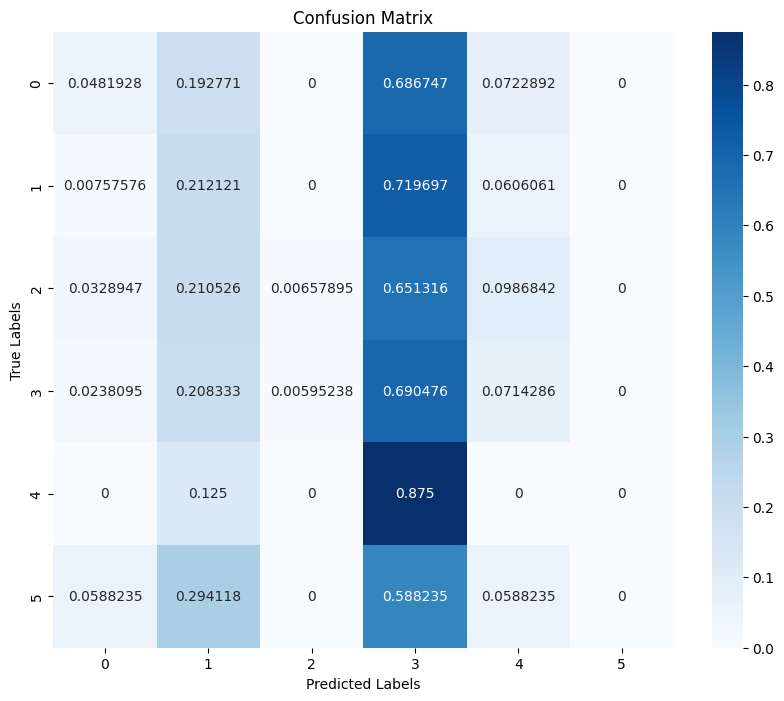

Epoch 15, Validation Loss: 1.6980, Accuracy: 0.2582, F1 Score: 0.1857
Val F1 Score Per Class  [0.08080808 0.22047244 0.01298701 0.41281139 0.         0.        ]


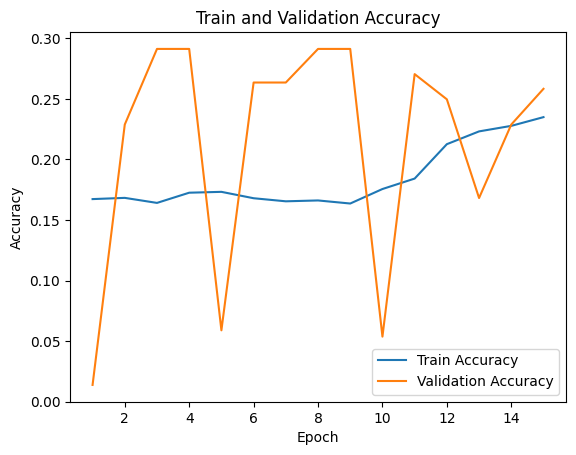

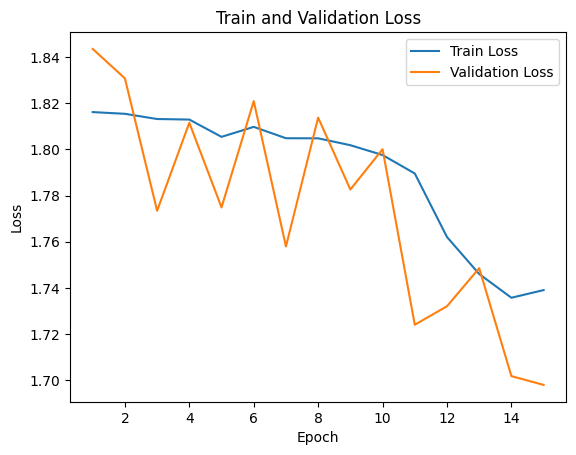

Epoch 16, Train Loss: 1.7272, Accuracy: 0.2356, F1 Score: 0.2009
Train F1 Score Per Class  [0.15629984 0.13284133 0.13734568 0.25717112 0.42668898 0.09537572]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.49it/s, loss=1.75]

[tensor([ 0.0152,  0.1194, -0.0251,  0.0140, -0.2256, -0.0831], device='cuda:0'), tensor([-0.0931,  0.0744, -0.4090, -0.3022, -0.6390, -0.3313], device='cuda:0'), tensor([-0.0631,  0.0952, -0.0993, -0.0394, -0.9639, -0.1980], device='cuda:0'), tensor([-0.0706,  0.0749, -0.1557, -0.1124, -1.2041, -0.2215], device='cuda:0'), tensor([ 0.0081,  0.1112, -0.0785, -0.0533, -3.5946, -0.1625], device='cuda:0'), tensor([ 0.0099,  0.0705, -0.2896, -0.2211, -2.4290, -0.2072], device='cuda:0'), tensor([-0.0137,  0.1234,  0.0021,  0.0502, -0.5035, -0.1107], device='cuda:0'), tensor([-0.1377,  0.0825, -0.3061, -0.2202, -0.0502, -0.3420], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.45it/s, loss=1.85]

[tensor([ 0.0222,  0.1138, -0.1095, -0.0976, -1.0216, -0.1691], device='cuda:0'), tensor([-0.0269,  0.0889, -0.1673, -0.1074, -0.5310, -0.1774], device='cuda:0'), tensor([ 0.2632,  0.1670,  0.3396,  0.3679, -2.3628,  0.2659], device='cuda:0'), tensor([ 0.0514,  0.1306,  0.0217,  0.0568, -1.1466, -0.0753], device='cuda:0'), tensor([ 0.1408,  0.1495,  0.1056,  0.1648, -1.4679,  0.0808], device='cuda:0'), tensor([-0.0911,  0.0977, -0.1895, -0.1293, -0.1497, -0.2718], device='cuda:0'), tensor([ 0.3296,  0.1864,  0.2305,  0.3104, -2.5044,  0.2741], device='cuda:0'), tensor([ 0.1389,  0.1689,  0.2210,  0.2261, -2.1839,  0.0711], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=1.67]

[tensor([-0.0816,  0.0918, -0.1256, -0.0697, -0.6634, -0.2028], device='cuda:0'), tensor([-4.0237e-02,  1.1030e-01, -1.3027e-05,  1.8150e-02, -9.5182e-01,
        -1.4459e-01], device='cuda:0'), tensor([ 0.0623,  0.1453,  0.1106,  0.1476, -1.1593, -0.0188], device='cuda:0'), tensor([ 0.1237,  0.1560,  0.1642,  0.1758, -1.3606,  0.0359], device='cuda:0'), tensor([ 0.0396,  0.1291,  0.0047,  0.0527, -2.4118, -0.0839], device='cuda:0'), tensor([ 0.0687,  0.1221, -0.0067,  0.0774, -2.7771, -0.0220], device='cuda:0'), tensor([-0.1317,  0.0684, -0.2648, -0.1994, -2.4284, -0.2854], device='cuda:0'), tensor([ 0.0152,  0.1313, -0.0132,  0.0522, -1.9708, -0.1046], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.31it/s, loss=1.68]

[tensor([-0.0793,  0.0945, -0.1105, -0.0393, -1.1742, -0.1839], device='cuda:0'), tensor([-0.0802,  0.0792, -0.2605, -0.1834, -1.5282, -0.2681], device='cuda:0'), tensor([-0.1363,  0.0898, -0.1603, -0.0861, -1.1794, -0.2621], device='cuda:0'), tensor([-0.1622,  0.0626, -0.2368, -0.1716, -0.5874, -0.3153], device='cuda:0'), tensor([ 0.0382,  0.1391,  0.0827,  0.1092, -1.4120, -0.0488], device='cuda:0'), tensor([-0.0067,  0.1089, -0.0374,  0.0096, -1.2136, -0.1214], device='cuda:0'), tensor([ 0.3103,  0.1717,  0.2676,  0.3048, -1.8619,  0.2503], device='cuda:0'), tensor([-0.0847,  0.0929, -0.1062, -0.0818, -0.5788, -0.2388], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.38it/s, loss=1.69]

[tensor([ 0.0218,  0.1335,  0.0082,  0.0726, -1.7732, -0.0803], device='cuda:0'), tensor([-0.0734,  0.1183, -0.1400, -0.0310, -0.2539, -0.1844], device='cuda:0'), tensor([ 0.0921,  0.1577,  0.1614,  0.2004, -1.1920,  0.0224], device='cuda:0'), tensor([ 0.0286,  0.1126, -0.0512, -0.0073, -0.7077, -0.0982], device='cuda:0'), tensor([ 0.1089,  0.1554,  0.1015,  0.1388, -1.3497,  0.0243], device='cuda:0'), tensor([ 0.0988,  0.1275, -0.0346,  0.0173, -0.7325, -0.0190], device='cuda:0'), tensor([-0.0694,  0.1024, -0.0679, -0.0376, -0.8159, -0.1954], device='cuda:0'), tensor([ 0.1535,  0.1533,  0.1208,  0.1732, -1.0743,  0.0618], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.37it/s, loss=1.83]

[tensor([-0.0767,  0.0951, -0.1598, -0.1092, -0.6967, -0.2532], device='cuda:0'), tensor([ 9.3112e-02,  1.4252e-01,  6.8626e-02,  1.1034e-01, -7.9213e-01,
         2.9200e-04], device='cuda:0'), tensor([ 0.0227,  0.1382,  0.0252,  0.0947, -1.0057, -0.0748], device='cuda:0'), tensor([-0.0482,  0.1202, -0.0783, -0.0133, -0.0834, -0.1772], device='cuda:0'), tensor([ 0.1201,  0.1348,  0.0016,  0.0545, -1.2618, -0.0029], device='cuda:0'), tensor([ 0.2157,  0.1615,  0.1860,  0.1670, -4.7373,  0.0890], device='cuda:0'), tensor([ 0.1078,  0.1294, -0.0345, -0.0182, -1.8282, -0.0212], device='cuda:0'), tensor([-0.0985,  0.0954, -0.1448, -0.0740, -1.9357, -0.2359], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=1.66]

[tensor([ 0.0163,  0.1185, -0.0244,  0.0691, -1.1546, -0.0806], device='cuda:0'), tensor([ 0.0333,  0.1296,  0.0525,  0.0855, -1.3672, -0.0529], device='cuda:0'), tensor([ 0.0069,  0.1000, -0.0591, -0.0299, -0.7739, -0.1308], device='cuda:0'), tensor([-0.0136,  0.1182, -0.2162, -0.1233, -0.8170, -0.1240], device='cuda:0'), tensor([ 0.1094,  0.1015, -0.1543, -0.1067, -0.8017, -0.0653], device='cuda:0'), tensor([ 0.1273,  0.1612,  0.1638,  0.2076, -3.1865,  0.0549], device='cuda:0'), tensor([ 0.0671,  0.1299,  0.0393,  0.0772, -3.7190, -0.0412], device='cuda:0'), tensor([ 0.0428,  0.1435,  0.0058,  0.0629, -0.5663, -0.0960], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.40it/s, loss=1.72]

[tensor([-0.0052,  0.1079, -0.1105, -0.0432, -0.3511, -0.1601], device='cuda:0'), tensor([ 0.0936,  0.1363,  0.1287,  0.1854, -1.3872,  0.0450], device='cuda:0'), tensor([-0.0653,  0.0990, -0.1577, -0.0958, -0.6453, -0.2189], device='cuda:0'), tensor([ 0.1212,  0.1564,  0.0704,  0.1312, -1.0790,  0.0058], device='cuda:0'), tensor([ 0.0291,  0.1230,  0.0276,  0.0720, -1.5562, -0.0659], device='cuda:0'), tensor([ 0.4390,  0.2371,  0.5624,  0.5617, -2.5800,  0.4380], device='cuda:0'), tensor([-0.1800,  0.0736, -0.3235, -0.2615, -0.5189, -0.4019], device='cuda:0'), tensor([ 0.3226,  0.1803,  0.3944,  0.3899, -2.2441,  0.2948], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.42it/s, loss=1.71]

[tensor([ 0.0181,  0.1167, -0.0231,  0.0391, -0.7506, -0.0798], device='cuda:0'), tensor([ 0.0590,  0.1442,  0.0995,  0.1430, -0.9808, -0.0253], device='cuda:0'), tensor([-0.0576,  0.1025, -0.1065, -0.0729, -1.0410, -0.2182], device='cuda:0'), tensor([-0.0416,  0.1171, -0.0132,  0.0314, -1.5194, -0.1410], device='cuda:0'), tensor([ 0.0025,  0.1265, -0.0332,  0.0154, -1.9626, -0.1227], device='cuda:0'), tensor([-0.1498,  0.0836, -0.2695, -0.2040, -0.0992, -0.3511], device='cuda:0'), tensor([-0.2116,  0.0681, -0.5309, -0.5089, -2.4221, -0.3279], device='cuda:0'), tensor([ 0.1663,  0.1288, -0.0305,  0.0337, -1.7922,  0.0097], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.42it/s, loss=1.71]

[tensor([ 0.1462,  0.1497,  0.1401,  0.1308, -1.1912,  0.0471], device='cuda:0'), tensor([ 0.3521,  0.1885,  0.2906,  0.2888, -2.7466,  0.2695], device='cuda:0'), tensor([ 0.2540,  0.1595,  0.0962,  0.0286, -4.4359,  0.1990], device='cuda:0'), tensor([-0.0530,  0.1006, -0.0311,  0.0228, -1.4785, -0.1463], device='cuda:0'), tensor([-0.0671,  0.0909, -0.1433, -0.1155, -0.8081, -0.2228], device='cuda:0'), tensor([-0.2318,  0.0633, -0.3305, -0.2500, -0.4256, -0.4019], device='cuda:0'), tensor([ 0.1488,  0.1563,  0.0124,  0.0610, -1.8419,  0.0600], device='cuda:0'), tensor([-0.0469,  0.0976, -0.0996, -0.0434, -0.7392, -0.1642], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.43it/s, loss=1.77]

[tensor([ 0.1313,  0.1604,  0.1381,  0.1661, -2.6138,  0.0328], device='cuda:0'), tensor([-0.0504,  0.1180, -0.0154,  0.0562, -1.0068, -0.1275], device='cuda:0'), tensor([ 0.0671,  0.1353, -0.0098,  0.0154, -1.3016, -0.0733], device='cuda:0'), tensor([-0.1719,  0.0690, -0.3268, -0.2544, -1.3332, -0.3759], device='cuda:0'), tensor([-0.0070,  0.1088, -0.2155, -0.1882, -0.1906, -0.2398], device='cuda:0'), tensor([-0.0995,  0.0713, -0.1408, -0.0533, -1.0824, -0.1740], device='cuda:0'), tensor([-0.1049,  0.0949, -0.1264, -0.0910, -0.9702, -0.2472], device='cuda:0'), tensor([ 0.0719,  0.1402,  0.0620,  0.0702, -0.7992, -0.0566], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:26,  2.29it/s, loss=1.65]

[tensor([-0.1616,  0.0771, -0.3027, -0.2533, -0.8481, -0.3431], device='cuda:0'), tensor([ 0.0137,  0.1150, -0.1744, -0.1500, -0.2402, -0.1983], device='cuda:0'), tensor([-0.0642,  0.0960, -0.1825, -0.1044, -0.8422, -0.2199], device='cuda:0'), tensor([ 0.0263,  0.1200, -0.0317,  0.0328, -1.0830, -0.1014], device='cuda:0'), tensor([ 0.3494,  0.1878,  0.3413,  0.3499, -3.8904,  0.3157], device='cuda:0'), tensor([ 0.1244,  0.1349,  0.0586,  0.0894, -1.3423,  0.0143], device='cuda:0'), tensor([-0.1069,  0.0890, -0.1553, -0.0739, -0.5816, -0.2203], device='cuda:0'), tensor([-0.1916,  0.0697, -0.2217, -0.1437, -0.0495, -0.3138], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.35it/s, loss=1.63]

[tensor([-0.0407,  0.0891, -0.1238, -0.0689, -0.5571, -0.1690], device='cuda:0'), tensor([-0.0238,  0.1151, -0.0893, -0.0351, -0.4861, -0.1600], device='cuda:0'), tensor([ 0.0693,  0.1262,  0.0130,  0.0499, -1.8652, -0.0512], device='cuda:0'), tensor([-0.0140,  0.1247, -0.0468, -0.0032, -0.7499, -0.1624], device='cuda:0'), tensor([-0.0891,  0.0803, -0.0904, -0.0260, -0.5595, -0.1675], device='cuda:0'), tensor([ 0.0775,  0.1308,  0.0398,  0.0867, -1.4071, -0.0212], device='cuda:0'), tensor([ 0.1625,  0.1403,  0.1118,  0.1348, -2.8310,  0.0649], device='cuda:0'), tensor([ 0.1196,  0.1472,  0.0515,  0.0858, -1.8642, -0.0127], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:25,  2.36it/s, loss=1.72]

[tensor([ 0.0155,  0.0875, -0.1514, -0.1239, -1.5816, -0.1888], device='cuda:0'), tensor([-0.1492,  0.0729, -0.2602, -0.1995, -1.7134, -0.3390], device='cuda:0'), tensor([ 0.0310,  0.1345,  0.0309,  0.0848, -0.8441, -0.0737], device='cuda:0'), tensor([ 2.9323e-01,  1.6445e-01,  1.7376e-02,  5.6748e-04, -3.5450e+00,
         9.0694e-02], device='cuda:0'), tensor([ 0.3422,  0.1827,  0.3501,  0.3729, -2.8443,  0.2926], device='cuda:0'), tensor([ 1.0446e-01,  1.3262e-01,  4.4312e-02,  1.0764e-01, -4.2705e+00,
        -3.8885e-03], device='cuda:0'), tensor([-0.2861,  0.0366, -0.3264, -0.2714,  0.9557, -0.4039], device='cuda:0'), tensor([ 0.0110,  0.1157, -0.0538, -0.0134, -1.4482, -0.1347], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.40it/s, loss=1.68]

[tensor([-0.0074,  0.1207, -0.0211,  0.0290, -1.4161, -0.1303], device='cuda:0'), tensor([-0.1369,  0.0692, -0.2228, -0.1459, -0.2530, -0.2831], device='cuda:0'), tensor([-0.0135,  0.1154, -0.0399, -0.0135, -0.7899, -0.1466], device='cuda:0'), tensor([ 0.0067,  0.1259, -0.0185,  0.0267, -0.4375, -0.1227], device='cuda:0'), tensor([ 0.0270,  0.0949, -0.1649, -0.0701, -1.8243, -0.0990], device='cuda:0'), tensor([ 1.3386e-01,  1.3678e-01,  8.0403e-03,  6.1206e-02, -3.0661e+00,
        -4.2730e-04], device='cuda:0'), tensor([ 0.0394,  0.1354,  0.0470,  0.0869, -1.3328, -0.0800], device='cuda:0'), tensor([-0.0281,  0.1118, -0.0742, -0.0018, -0.3027, -0.1301], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.41it/s, loss=1.66]

[tensor([ 0.0048,  0.1453, -0.0492,  0.0353, -0.7012, -0.1149], device='cuda:0'), tensor([-0.0995,  0.0760, -0.1869, -0.1503, -0.7113, -0.2786], device='cuda:0'), tensor([ 0.0970,  0.1404,  0.1126,  0.1461, -1.2831,  0.0183], device='cuda:0'), tensor([ 0.0238,  0.1308, -0.0073,  0.0437, -0.8609, -0.1078], device='cuda:0'), tensor([ 0.0583,  0.1472,  0.0711,  0.0911, -1.3429, -0.0582], device='cuda:0'), tensor([-0.0325,  0.1008, -0.0507, -0.0120, -0.9613, -0.1325], device='cuda:0'), tensor([-0.0938,  0.1031, -0.0887, -0.0329, -0.8030, -0.2064], device='cuda:0'), tensor([-0.0097,  0.1210, -0.0137,  0.0418, -0.5987, -0.1192], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.41it/s, loss=1.65]

[tensor([-0.1089,  0.0911, -0.0922, -0.0636, -0.1753, -0.2343], device='cuda:0'), tensor([ 0.1009,  0.1492,  0.0253,  0.1026, -0.7475,  0.0243], device='cuda:0'), tensor([ 0.0779,  0.1532,  0.0746,  0.1359, -0.7076, -0.0265], device='cuda:0'), tensor([ 0.0489,  0.1090, -0.2543, -0.1792, -1.1573, -0.1986], device='cuda:0'), tensor([ 0.1687,  0.1396,  0.1602,  0.1463, -4.5150,  0.0757], device='cuda:0'), tensor([ 0.1479,  0.1461,  0.1317,  0.1364, -2.7236,  0.0624], device='cuda:0'), tensor([ 0.1886,  0.1366,  0.1369,  0.1520, -2.0428,  0.0728], device='cuda:0'), tensor([ 0.0935,  0.1408,  0.0864,  0.1279, -1.2079, -0.0016], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.43it/s, loss=1.64]

[tensor([-0.0664,  0.0974, -0.1405, -0.0677, -0.8112, -0.2098], device='cuda:0'), tensor([ 0.0704,  0.1161, -0.0572, -0.0306, -1.0563, -0.0907], device='cuda:0'), tensor([-0.0787,  0.0894, -0.0760, -0.0189, -0.7908, -0.1780], device='cuda:0'), tensor([ 0.0400,  0.0986, -0.1967, -0.1269, -1.3773, -0.1513], device='cuda:0'), tensor([ 0.2777,  0.1942,  0.2333,  0.2871, -2.1622,  0.2015], device='cuda:0'), tensor([ 0.1446,  0.1581,  0.1653,  0.1729, -1.7815,  0.0696], device='cuda:0'), tensor([-0.0517,  0.1079, -0.1043, -0.0464, -0.7673, -0.2033], device='cuda:0'), tensor([ 0.0848,  0.1233, -0.0154,  0.0441, -1.0419, -0.0329], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=1.71]

[tensor([ 0.3694,  0.1941,  0.4080,  0.3934, -2.8628,  0.3079], device='cuda:0'), tensor([-0.1743,  0.0796, -0.2622, -0.2022, -0.9708, -0.3460], device='cuda:0'), tensor([ 0.0130,  0.1237, -0.0047,  0.0414, -0.7679, -0.1158], device='cuda:0'), tensor([-0.0329,  0.1003, -0.1271, -0.1043, -1.1006, -0.1788], device='cuda:0'), tensor([-0.0020,  0.1174,  0.0702,  0.0956, -1.1617, -0.0704], device='cuda:0'), tensor([ 0.2103,  0.1640,  0.1255,  0.1478, -2.6485,  0.0640], device='cuda:0'), tensor([-0.1719,  0.0343, -0.4522, -0.3854, -0.3600, -0.3291], device='cuda:0'), tensor([-0.0054,  0.1188, -0.0583,  0.0222, -1.9233, -0.1117], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.42it/s, loss=1.73]

[tensor([ 0.1254,  0.1571,  0.0865,  0.1377, -1.4420,  0.0212], device='cuda:0'), tensor([ 0.1042,  0.1518,  0.0882,  0.1319, -2.8257,  0.0315], device='cuda:0'), tensor([-0.0483,  0.1058, -0.2139, -0.1287, -1.5226, -0.2136], device='cuda:0'), tensor([ 0.0141,  0.1193, -0.0688,  0.0116, -0.6583, -0.1178], device='cuda:0'), tensor([-0.1388,  0.0931, -0.1754, -0.1114, -0.1352, -0.2796], device='cuda:0'), tensor([ 0.0760,  0.1380,  0.0373,  0.0996, -1.4614, -0.0302], device='cuda:0'), tensor([ 0.4197,  0.1819,  0.1510,  0.1392, -4.9841,  0.3385], device='cuda:0'), tensor([-0.0659,  0.0938, -0.0973, -0.0490, -0.4030, -0.1962], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=1.65]

[tensor([-0.1288,  0.0857, -0.1403, -0.0754, -1.0464, -0.2481], device='cuda:0'), tensor([ 0.0983,  0.1506,  0.0906,  0.1329, -0.9264, -0.0071], device='cuda:0'), tensor([-0.0891,  0.0954, -0.2180, -0.1462, -0.6507, -0.2320], device='cuda:0'), tensor([ 0.1648,  0.1524,  0.0882,  0.0623, -1.4277,  0.0533], device='cuda:0'), tensor([ 0.1112,  0.1471,  0.1120,  0.1418, -0.8661,  0.0245], device='cuda:0'), tensor([-0.1597,  0.0514, -0.4151, -0.3613, -0.2591, -0.3503], device='cuda:0'), tensor([-0.0265,  0.1415, -0.0543, -0.0126, -1.0938, -0.1816], device='cuda:0'), tensor([-0.0098,  0.1338, -0.0140,  0.0267, -1.4857, -0.1533], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.42it/s, loss=1.66]

[tensor([-0.0178,  0.0857, -0.2142, -0.1006, -0.6657, -0.1617], device='cuda:0'), tensor([ 0.0125,  0.1243,  0.0264,  0.0872, -1.1717, -0.0812], device='cuda:0'), tensor([-0.1070,  0.0823, -0.1383, -0.1083, -1.4641, -0.2547], device='cuda:0'), tensor([ 0.0402,  0.1371,  0.0383,  0.0735, -0.4701, -0.0739], device='cuda:0'), tensor([-0.1515,  0.0891, -0.1633, -0.1037, -0.0812, -0.2847], device='cuda:0'), tensor([ 0.0178,  0.1055, -0.0321, -0.0043, -1.3722, -0.1096], device='cuda:0'), tensor([ 0.0554,  0.1484,  0.0854,  0.1375, -0.8565, -0.0396], device='cuda:0'), tensor([ 0.0769,  0.1586,  0.1715,  0.2105, -1.3631,  0.0271], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.37it/s, loss=1.67]

[tensor([-0.0149,  0.1047, -0.0569, -0.0429, -1.2577, -0.1421], device='cuda:0'), tensor([-0.0886,  0.0814, -0.2097, -0.1712, -0.4772, -0.2570], device='cuda:0'), tensor([ 0.0950,  0.1380,  0.0305,  0.0536, -2.0119, -0.0200], device='cuda:0'), tensor([-0.0843,  0.1047, -0.1003, -0.0358, -0.9320, -0.2163], device='cuda:0'), tensor([-1.5340e-03,  1.0556e-01, -5.9526e-02, -1.8214e-02, -5.0299e+00,
        -1.1991e-01], device='cuda:0'), tensor([-0.3036,  0.0461, -0.3518, -0.2786, -0.7167, -0.4767], device='cuda:0'), tensor([-0.1727,  0.0798, -0.2815, -0.2235, -0.3506, -0.3778], device='cuda:0'), tensor([-0.0335,  0.0866, -0.2197, -0.1668, -2.3311, -0.2558], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.35it/s, loss=1.72]

[tensor([-0.1000,  0.0903, -0.1884, -0.1058, -0.7561, -0.2373], device='cuda:0'), tensor([ 0.1772,  0.1548,  0.2153,  0.2270, -1.8705,  0.1232], device='cuda:0'), tensor([ 0.1316,  0.1621,  0.1534,  0.1893, -2.0204,  0.0532], device='cuda:0'), tensor([ 0.0221,  0.1041, -0.1034, -0.0654, -1.9294, -0.1482], device='cuda:0'), tensor([-0.0571,  0.0887, -0.1348, -0.0911, -2.5547, -0.2007], device='cuda:0'), tensor([-0.0166,  0.1301, -0.0184,  0.0610, -0.6863, -0.1259], device='cuda:0'), tensor([-0.1157,  0.0757, -0.1205, -0.0559, -1.1064, -0.2208], device='cuda:0'), tensor([ 0.3257,  0.1652,  0.1582,  0.1690, -2.7052,  0.2278], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.39it/s, loss=1.75]

[tensor([-0.0999,  0.0680, -0.2882, -0.2252, -0.6661, -0.2963], device='cuda:0'), tensor([-0.2522,  0.0431, -0.4264, -0.3560, -0.0175, -0.4764], device='cuda:0'), tensor([-0.0248,  0.1055, -0.1123, -0.0584, -1.4168, -0.1783], device='cuda:0'), tensor([-0.0532,  0.1173, -0.0334,  0.0198, -0.9007, -0.1584], device='cuda:0'), tensor([-0.0676,  0.1005, -0.1119, -0.0524, -0.3458, -0.2209], device='cuda:0'), tensor([-0.1183,  0.0953, -0.1343, -0.1047, -0.2595, -0.2370], device='cuda:0'), tensor([ 0.0380,  0.1419,  0.0017,  0.0395, -1.0855, -0.1049], device='cuda:0'), tensor([-0.0355,  0.1063, -0.0261,  0.0205, -1.9973, -0.1327], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.65]

[tensor([ 0.0305,  0.1345, -0.0024, -0.0036, -0.7470, -0.0985], device='cuda:0'), tensor([-0.1164,  0.0860, -0.1313, -0.0797, -0.8213, -0.2431], device='cuda:0'), tensor([ 1.0634,  0.3392,  0.8972,  0.8855, -5.1139,  1.0245], device='cuda:0'), tensor([ 0.0752,  0.1415,  0.1095,  0.1464, -2.2066, -0.0125], device='cuda:0'), tensor([ 0.0173,  0.1145, -0.0252,  0.0108, -1.1744, -0.1281], device='cuda:0'), tensor([ 0.0216,  0.1320,  0.0622,  0.1089, -1.0579, -0.0514], device='cuda:0'), tensor([ 0.1446,  0.1506,  0.1426,  0.1852, -3.6727,  0.0781], device='cuda:0'), tensor([ 0.0874,  0.1526,  0.1362,  0.1774, -1.6696,  0.0255], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.42it/s, loss=1.69]

[tensor([ 0.2087,  0.1929,  0.2784,  0.2857, -1.5767,  0.1627], device='cuda:0'), tensor([-0.0111,  0.1144, -0.0330,  0.0061, -1.0669, -0.1186], device='cuda:0'), tensor([-0.1546,  0.0778, -0.2234, -0.1892, -0.6616, -0.3337], device='cuda:0'), tensor([ 0.0948,  0.1509, -0.0114,  0.0582, -0.4927, -0.0588], device='cuda:0'), tensor([ 0.0655,  0.1417,  0.0268,  0.0702, -0.8923, -0.0596], device='cuda:0'), tensor([-0.1414,  0.0749, -0.3328, -0.2379, -0.8436, -0.3304], device='cuda:0'), tensor([ 0.0968,  0.1308,  0.0418,  0.0996, -0.8873, -0.0239], device='cuda:0'), tensor([-0.0158,  0.1148, -0.0506, -0.0058, -1.7206, -0.1329], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.40it/s, loss=1.67]

[tensor([ 0.0072,  0.1009, -0.1262, -0.0631, -0.9555, -0.1416], device='cuda:0'), tensor([ 0.0477,  0.1412,  0.1534,  0.1592, -3.0279, -0.0149], device='cuda:0'), tensor([ 0.2851,  0.1810,  0.2629,  0.2583, -4.1238,  0.1872], device='cuda:0'), tensor([-0.0399,  0.1031, -0.1101, -0.0788, -0.5935, -0.2086], device='cuda:0'), tensor([-0.1065,  0.0824, -0.1908, -0.1197, -0.9205, -0.2641], device='cuda:0'), tensor([-0.0610,  0.1076, -0.0843, -0.0303, -1.4737, -0.1666], device='cuda:0'), tensor([ 0.0337,  0.1062, -0.1295, -0.1160, -1.4337, -0.1681], device='cuda:0'), tensor([ 0.1489,  0.1413,  0.0627,  0.1116, -1.0148,  0.0128], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.42it/s, loss=1.6]

[tensor([ 0.1973,  0.1690,  0.2194,  0.2386, -2.0264,  0.1410], device='cuda:0'), tensor([-0.2009,  0.0717, -0.2325, -0.1583, -1.8789, -0.3431], device='cuda:0'), tensor([ 0.0180,  0.1338,  0.0024,  0.0511, -0.6638, -0.0714], device='cuda:0'), tensor([ 0.0152,  0.1267,  0.0318,  0.0815, -1.2697, -0.0798], device='cuda:0'), tensor([-0.1056,  0.0943, -0.1128, -0.0526, -0.5820, -0.2316], device='cuda:0'), tensor([ 0.0757,  0.1507,  0.0253,  0.0782, -0.9029, -0.0512], device='cuda:0'), tensor([-0.0652,  0.1079, -0.0813, -0.0191, -1.0778, -0.1840], device='cuda:0'), tensor([ 0.0616,  0.1390,  0.0087,  0.0702, -0.6828, -0.0655], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.41it/s, loss=1.64]

[tensor([-0.0953,  0.0775, -0.1711, -0.0932, -1.3356, -0.2324], device='cuda:0'), tensor([-0.0158,  0.1167, -0.1138, -0.0546, -1.0025, -0.1789], device='cuda:0'), tensor([-0.0433,  0.1155, -0.1890, -0.1180, -1.3139, -0.2457], device='cuda:0'), tensor([-0.1194,  0.0773, -0.1557, -0.0806, -1.3293, -0.2291], device='cuda:0'), tensor([-0.0516,  0.1035, -0.0906, -0.0381, -1.9024, -0.1803], device='cuda:0'), tensor([-0.1335,  0.0833, -0.1794, -0.1248, -0.2348, -0.2806], device='cuda:0'), tensor([-0.0190,  0.1228, -0.0735, -0.0144, -0.9507, -0.1511], device='cuda:0'), tensor([-0.2016,  0.0795, -0.2549, -0.1683,  0.3335, -0.3358], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.40it/s, loss=1.68]

[tensor([ 0.5010,  0.2172,  0.3901,  0.3877, -3.0891,  0.4046], device='cuda:0'), tensor([ 0.0012,  0.1151, -0.0616,  0.0029, -0.3703, -0.1373], device='cuda:0'), tensor([-0.0421,  0.1177, -0.0407,  0.0059, -1.3200, -0.1614], device='cuda:0'), tensor([-0.0301,  0.1254,  0.0118,  0.0563, -0.9963, -0.1375], device='cuda:0'), tensor([-0.0468,  0.1211, -0.0135,  0.0253, -0.5665, -0.1526], device='cuda:0'), tensor([-0.0206,  0.1128, -0.0945, -0.0348, -0.9137, -0.1625], device='cuda:0'), tensor([ 0.4609,  0.0634, -0.4396, -0.4056, -5.7224,  0.0579], device='cuda:0'), tensor([-0.0407,  0.1025, -0.0396,  0.0329, -2.1421, -0.1310], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.42it/s, loss=1.64]

[tensor([-0.1198,  0.0922, -0.1633, -0.1038, -1.4004, -0.2687], device='cuda:0'), tensor([-0.1285,  0.0897, -0.1317, -0.0901, -0.3681, -0.2628], device='cuda:0'), tensor([ 0.1406,  0.1300,  0.0899,  0.1017, -1.6556,  0.0385], device='cuda:0'), tensor([ 0.0272,  0.1108, -0.0560, -0.0158, -1.2976, -0.1202], device='cuda:0'), tensor([-0.0608,  0.1041, -0.0558, -0.0141, -1.8338, -0.1462], device='cuda:0'), tensor([ 0.1330,  0.1539,  0.1413,  0.1608, -2.4405,  0.0178], device='cuda:0'), tensor([ 0.0744,  0.1392,  0.1211,  0.1674, -1.7114,  0.0268], device='cuda:0'), tensor([ 0.0635,  0.1470,  0.0837,  0.1283, -1.3883, -0.0310], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.41it/s, loss=1.67]

[tensor([ 0.0898,  0.1516,  0.0967,  0.1284, -0.8635, -0.0207], device='cuda:0'), tensor([ 0.0675,  0.1345, -0.0274,  0.0100, -1.4035, -0.0741], device='cuda:0'), tensor([-0.2109,  0.0814, -0.3395, -0.2781, -0.6324, -0.4333], device='cuda:0'), tensor([ 0.0347,  0.1347, -0.0386,  0.0190, -1.2179, -0.1100], device='cuda:0'), tensor([ 0.0548,  0.1324,  0.0371,  0.0679, -2.8685, -0.0607], device='cuda:0'), tensor([ 0.2431,  0.1463,  0.0425,  0.0696, -3.2264,  0.0912], device='cuda:0'), tensor([ 0.0155,  0.1197,  0.0380,  0.0749, -0.6980, -0.0707], device='cuda:0'), tensor([-0.0130,  0.1350, -0.0324,  0.0279, -0.5560, -0.1367], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.44it/s, loss=1.68]

[tensor([ 0.3078,  0.1566,  0.1234,  0.1742, -2.8629,  0.1887], device='cuda:0'), tensor([ 0.2450,  0.1421,  0.1184,  0.1529, -1.5385,  0.1247], device='cuda:0'), tensor([-0.1296,  0.0991, -0.1937, -0.1239, -0.7067, -0.2788], device='cuda:0'), tensor([ 0.1703,  0.1677,  0.1724,  0.1965, -1.8409,  0.0669], device='cuda:0'), tensor([-0.0699,  0.0731, -0.3181, -0.2795, -0.4422, -0.2951], device='cuda:0'), tensor([ 0.1089,  0.1501,  0.0587,  0.1352, -1.0479,  0.0142], device='cuda:0'), tensor([-0.1325,  0.0903, -0.1126, -0.0603, -0.2352, -0.2440], device='cuda:0'), tensor([ 0.0477,  0.1347,  0.0698,  0.0870, -0.4827, -0.0419], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.44it/s, loss=1.61]

[tensor([ 0.3647,  0.1645,  0.2316,  0.2544, -4.4805,  0.2889], device='cuda:0'), tensor([-0.0486,  0.1272, -0.0493, -0.0028, -0.5776, -0.1826], device='cuda:0'), tensor([-0.2210,  0.0147, -0.4149, -0.3678, -2.6386, -0.4346], device='cuda:0'), tensor([ 0.1736,  0.1573,  0.1709,  0.2243, -1.2742,  0.1192], device='cuda:0'), tensor([-0.0770,  0.1097, -0.0224,  0.0168, -0.3339, -0.1628], device='cuda:0'), tensor([ 0.2123,  0.1600,  0.1428,  0.2168, -1.7359,  0.1409], device='cuda:0'), tensor([ 0.1766,  0.1411, -0.0078,  0.0155, -2.6542,  0.0238], device='cuda:0'), tensor([ 0.0377,  0.1355,  0.0182,  0.0763, -0.6040, -0.0701], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.44it/s, loss=1.65]

[tensor([ 0.1159,  0.1049, -0.1344, -0.0708, -1.7805, -0.0634], device='cuda:0'), tensor([-0.1852,  0.0699, -0.2410, -0.1589, -1.0840, -0.3284], device='cuda:0'), tensor([ 0.2740,  0.1947,  0.1464,  0.2230, -1.5620,  0.1638], device='cuda:0'), tensor([ 0.0488,  0.1375,  0.0116,  0.0631, -1.2729, -0.0609], device='cuda:0'), tensor([ 0.0680,  0.1353, -0.0124,  0.0472, -2.1694, -0.0475], device='cuda:0'), tensor([ 0.0272,  0.0932, -0.2634, -0.2349, -4.3694, -0.2084], device='cuda:0'), tensor([ 0.2015,  0.1730,  0.1317,  0.1833, -1.2310,  0.0988], device='cuda:0'), tensor([ 0.0795,  0.1441,  0.1013,  0.1419, -1.0560,  0.0092], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.45it/s, loss=1.78]

[tensor([ 0.0695,  0.1186, -0.0293,  0.0208, -0.8135, -0.0525], device='cuda:0'), tensor([-0.0249,  0.1226, -0.1111, -0.0541, -0.7985, -0.2032], device='cuda:0'), tensor([ 0.1025,  0.1538,  0.0767,  0.1492, -2.0182,  0.0127], device='cuda:0'), tensor([ 0.0876,  0.1418,  0.0120,  0.0562, -1.1285, -0.0314], device='cuda:0'), tensor([-0.0660,  0.1054, -0.1772, -0.0944, -0.5274, -0.2281], device='cuda:0'), tensor([ 0.1243,  0.1492,  0.0791,  0.1423, -0.8542,  0.0311], device='cuda:0'), tensor([-0.0793,  0.1002, -0.0647, -0.0071, -0.7597, -0.1820], device='cuda:0'), tensor([ 0.0833,  0.1478,  0.0777,  0.1086, -1.1401, -0.0393], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.41it/s, loss=1.6]

[tensor([ 0.1614,  0.1551,  0.0568,  0.0699, -2.3994,  0.0179], device='cuda:0'), tensor([-0.0923,  0.0865, -0.1420, -0.0673, -1.7158, -0.1992], device='cuda:0'), tensor([ 3.5360e-02,  1.2526e-01, -1.7328e-02,  7.9545e-04, -1.2597e+00,
        -1.2089e-01], device='cuda:0'), tensor([-0.0452,  0.0653, -0.2960, -0.2235, -3.8626, -0.2456], device='cuda:0'), tensor([ 0.0868,  0.1418,  0.1480,  0.1854, -4.3310,  0.0296], device='cuda:0'), tensor([-0.0735,  0.1123, -0.0887, -0.0251, -0.4977, -0.1985], device='cuda:0'), tensor([ 0.1303,  0.1443,  0.0986,  0.1467, -1.7691,  0.0576], device='cuda:0'), tensor([ 0.0206,  0.0912, -0.2071, -0.1397, -1.2782, -0.1633], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.38it/s, loss=1.65]

[tensor([-0.1123,  0.0987, -0.1320, -0.0811, -0.8959, -0.2454], device='cuda:0'), tensor([ 0.3173,  0.1753,  0.1844,  0.1820, -2.3066,  0.1899], device='cuda:0'), tensor([ 0.0134,  0.0889, -0.1320, -0.0836, -1.2359, -0.1477], device='cuda:0'), tensor([-0.0062,  0.0857, -0.1555, -0.0912, -0.2806, -0.1557], device='cuda:0'), tensor([ 0.1293,  0.1485,  0.2225,  0.2612, -4.1250,  0.1133], device='cuda:0'), tensor([-0.0627,  0.1158, -0.0077,  0.0232, -0.6846, -0.1719], device='cuda:0'), tensor([ 0.0290,  0.1310, -0.0225,  0.0211, -1.0851, -0.1263], device='cuda:0'), tensor([ 0.0220,  0.1249,  0.0111,  0.0627, -0.9506, -0.0922], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.39it/s, loss=1.63]

[tensor([ 0.0116,  0.1042, -0.0551,  0.0025, -1.2017, -0.1121], device='cuda:0'), tensor([-0.0609,  0.0899, -0.1382, -0.0620, -1.6815, -0.1921], device='cuda:0'), tensor([ 0.1605,  0.1625,  0.2017,  0.2211, -3.6994,  0.0972], device='cuda:0'), tensor([ 6.4238e-03,  1.2642e-01,  1.2185e-04,  2.8197e-02, -2.2051e+00,
        -1.2199e-01], device='cuda:0'), tensor([ 0.1353,  0.1591,  0.0927,  0.1452, -1.4236,  0.0220], device='cuda:0'), tensor([ 0.1692,  0.1446,  0.1327,  0.1470, -3.3448,  0.0621], device='cuda:0'), tensor([ 0.0715,  0.1236,  0.0101,  0.0702, -0.9663, -0.0085], device='cuda:0'), tensor([ 0.0159,  0.1220,  0.0865,  0.0703, -2.4898, -0.0572], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:14,  2.16it/s, loss=1.66]

[tensor([-0.0787,  0.0814, -0.1941, -0.1126, -3.2580, -0.2110], device='cuda:0'), tensor([-0.2307,  0.0496, -0.3355, -0.2519, -0.1164, -0.4223], device='cuda:0'), tensor([-0.0892,  0.0916, -0.0773, -0.0463, -0.4876, -0.2173], device='cuda:0'), tensor([-0.0796,  0.1079, -0.1737, -0.0999, -2.2080, -0.2510], device='cuda:0'), tensor([ 0.0882,  0.1521,  0.0865,  0.1371, -1.0845, -0.0166], device='cuda:0'), tensor([ 0.0924,  0.1344,  0.1144,  0.1428, -1.1435,  0.0116], device='cuda:0'), tensor([ 0.0538,  0.1220, -0.1585, -0.1399, -0.3965, -0.0875], device='cuda:0'), tensor([-0.0448,  0.1039, -0.1795, -0.1118, -0.5772, -0.1711], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.25it/s, loss=1.72]

[tensor([ 0.0529,  0.1202, -0.2392, -0.1825, -1.2214, -0.2231], device='cuda:0'), tensor([-0.0851,  0.1080, -0.0620, -0.0201, -0.9144, -0.2036], device='cuda:0'), tensor([ 0.1952,  0.1497,  0.1122,  0.1403, -2.7289,  0.0677], device='cuda:0'), tensor([-0.1604,  0.0651, -0.2933, -0.2431, -1.4482, -0.3666], device='cuda:0'), tensor([ 0.1510,  0.1472,  0.0696,  0.1318, -2.9681,  0.0196], device='cuda:0'), tensor([ 0.2021,  0.1565,  0.1591,  0.1702, -1.0103,  0.0803], device='cuda:0'), tensor([-0.1293,  0.0730, -0.2147, -0.1455, -0.6050, -0.2809], device='cuda:0'), tensor([-0.1261,  0.0856, -0.1531, -0.1101, -0.4884, -0.2681], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:13,  2.29it/s, loss=1.76]

[tensor([-0.2166,  0.0677, -0.3100, -0.2430, -0.1760, -0.4020], device='cuda:0'), tensor([-0.2172,  0.0371, -0.5267, -0.4382, -0.3812, -0.4826], device='cuda:0'), tensor([-0.0009,  0.1228, -0.0349,  0.0151, -0.3853, -0.1194], device='cuda:0'), tensor([ 0.0219,  0.1349, -0.0354,  0.0424, -0.9678, -0.1065], device='cuda:0'), tensor([-0.0816,  0.0937, -0.1930, -0.1285, -0.8791, -0.2482], device='cuda:0'), tensor([-0.1094,  0.0775, -0.2933, -0.2614, -1.3926, -0.3292], device='cuda:0'), tensor([-0.2344,  0.0516, -0.3479, -0.2919, -0.8049, -0.4146], device='cuda:0'), tensor([-0.0925,  0.0783, -0.2024, -0.1508, -0.9541, -0.2618], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.34it/s, loss=1.66]

[tensor([ 0.7062,  0.2490,  0.4030,  0.4379, -3.4646,  0.6218], device='cuda:0'), tensor([ 0.0715,  0.1447,  0.0577,  0.1162, -0.6590, -0.0388], device='cuda:0'), tensor([ 0.0678,  0.1161, -0.0342, -0.0081, -0.8198, -0.0506], device='cuda:0'), tensor([-0.0047,  0.1144, -0.0790,  0.0086, -0.9336, -0.1302], device='cuda:0'), tensor([-0.2733,  0.0402, -0.3414, -0.2786, -0.7038, -0.4553], device='cuda:0'), tensor([ 0.0812,  0.1429,  0.1068,  0.1435, -1.2011,  0.0156], device='cuda:0'), tensor([-0.0715,  0.0747, -0.2828, -0.2052, -0.1077, -0.2639], device='cuda:0'), tensor([ 0.0527,  0.1239,  0.0009,  0.0533, -0.7610, -0.0431], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.36it/s, loss=1.67]

[tensor([-0.0455,  0.1102, -0.0467,  0.0258, -0.9398, -0.1481], device='cuda:0'), tensor([ 0.0897,  0.1462,  0.0308,  0.1046, -1.7706, -0.0278], device='cuda:0'), tensor([ 0.0979,  0.1413,  0.0169,  0.0686, -1.3006, -0.0266], device='cuda:0'), tensor([ 0.0411,  0.1413,  0.0270,  0.0617, -0.9469, -0.0720], device='cuda:0'), tensor([-0.0791,  0.0871, -0.1816, -0.1026, -0.6413, -0.2263], device='cuda:0'), tensor([ 0.1913,  0.1519,  0.2262,  0.1579, -1.7117,  0.1300], device='cuda:0'), tensor([ 0.0244,  0.1530,  0.0093,  0.0701, -0.9773, -0.1013], device='cuda:0'), tensor([ 0.0373,  0.1150,  0.0387,  0.0966, -0.7933, -0.0305], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.39it/s, loss=1.66]

[tensor([-0.1856,  0.0956, -0.2386, -0.1714, -0.7627, -0.3547], device='cuda:0'), tensor([-0.1341,  0.0780, -0.1414, -0.1113, -0.6911, -0.2604], device='cuda:0'), tensor([-0.0651,  0.1064, -0.0501, -0.0375, -3.4753, -0.2070], device='cuda:0'), tensor([ 0.2983,  0.1908,  0.3800,  0.3943, -3.5758,  0.2765], device='cuda:0'), tensor([ 0.2357,  0.1559,  0.1704,  0.1998, -2.1682,  0.1547], device='cuda:0'), tensor([-0.2701,  0.0491, -0.3002, -0.2279, -0.3204, -0.4313], device='cuda:0'), tensor([ 0.0148,  0.1235, -0.0660,  0.0180, -1.2227, -0.1104], device='cuda:0'), tensor([ 0.0355,  0.1097, -0.0939, -0.0813, -2.3009, -0.1318], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.40it/s, loss=1.64]

[tensor([ 0.1650,  0.1720,  0.1555,  0.1997, -3.0382,  0.0847], device='cuda:0'), tensor([ 0.0384,  0.1180,  0.0103,  0.0547, -1.8853, -0.0758], device='cuda:0'), tensor([ 0.0433,  0.1288,  0.0455,  0.0981, -1.2503, -0.0155], device='cuda:0'), tensor([ 0.0245,  0.1278, -0.0060,  0.0503, -0.5500, -0.0910], device='cuda:0'), tensor([-0.1493,  0.0807, -0.1990, -0.1203, -1.2150, -0.2749], device='cuda:0'), tensor([ 0.1150,  0.1403,  0.0049,  0.0870, -1.7995, -0.0090], device='cuda:0'), tensor([ 0.1411,  0.1532,  0.1981,  0.2263, -1.0128,  0.0842], device='cuda:0'), tensor([-0.0320,  0.1073, -0.1218, -0.0596, -2.0989, -0.1859], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.41it/s, loss=1.71]

[tensor([-0.1227,  0.0944, -0.1521, -0.1021,  0.3480, -0.2387], device='cuda:0'), tensor([ 0.3959,  0.2220,  0.3898,  0.4112, -4.9779,  0.3508], device='cuda:0'), tensor([ 0.0836,  0.1480,  0.1063,  0.1688, -0.9809,  0.0097], device='cuda:0'), tensor([-0.0157,  0.0951, -0.0990, -0.0854, -1.1399, -0.1754], device='cuda:0'), tensor([-0.0230,  0.0815, -0.2810, -0.1871, -0.4070, -0.2336], device='cuda:0'), tensor([-0.1705,  0.0801, -0.2001, -0.1251, -0.0644, -0.3021], device='cuda:0'), tensor([-0.1082,  0.0956, -0.1867, -0.1359, -1.5272, -0.2779], device='cuda:0'), tensor([-0.0249,  0.1024, -0.1081, -0.0406, -0.7860, -0.1718], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:09,  2.42it/s, loss=1.65]

[tensor([-0.0088,  0.1078, -0.1160, -0.0756, -2.3147, -0.1800], device='cuda:0'), tensor([-0.0112,  0.1258, -0.0628, -0.0106, -1.0790, -0.1582], device='cuda:0'), tensor([ 0.0876,  0.1552,  0.0483,  0.1117, -0.6394, -0.0230], device='cuda:0'), tensor([-0.0398,  0.1081, -0.1022, -0.0321, -1.4039, -0.1816], device='cuda:0'), tensor([ 0.0973,  0.1485,  0.1477,  0.1603, -1.9161,  0.0175], device='cuda:0'), tensor([-0.0095,  0.1289,  0.0587,  0.0905, -0.8296, -0.0925], device='cuda:0'), tensor([ 0.2059,  0.1530,  0.0850,  0.1704, -4.1135,  0.1367], device='cuda:0'), tensor([ 0.1254,  0.1529,  0.1153,  0.1404, -2.9903,  0.0074], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.42it/s, loss=1.81]

[tensor([-0.1082,  0.0991, -0.1634, -0.1085, -0.2915, -0.2589], device='cuda:0'), tensor([-0.0409,  0.1096, -0.0420,  0.0052, -1.0802, -0.1533], device='cuda:0'), tensor([ 0.0075,  0.1248, -0.0307,  0.0293, -0.4431, -0.1111], device='cuda:0'), tensor([-0.1422,  0.0706, -0.3043, -0.2375, -0.2609, -0.3336], device='cuda:0'), tensor([-0.0311,  0.1291, -0.0542,  0.0296, -0.6544, -0.1468], device='cuda:0'), tensor([ 0.0929,  0.1480,  0.1392,  0.1740, -1.1307,  0.0268], device='cuda:0'), tensor([ 0.0132,  0.1241,  0.0109,  0.0680, -0.5613, -0.0615], device='cuda:0'), tensor([ 0.0451,  0.1297,  0.0641,  0.0840, -1.3143, -0.0416], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.44it/s, loss=1.64]

[tensor([-0.0033,  0.0952, -0.1566, -0.1045, -0.4647, -0.1693], device='cuda:0'), tensor([ 0.1812,  0.1388,  0.0875,  0.0758, -1.0759,  0.0797], device='cuda:0'), tensor([-0.1316,  0.1015, -0.1292, -0.0533, -0.6119, -0.2498], device='cuda:0'), tensor([ 0.1219,  0.1627,  0.0087,  0.1112, -0.8471, -0.0082], device='cuda:0'), tensor([-0.0463,  0.0992, -0.0779, -0.0279, -0.3670, -0.1746], device='cuda:0'), tensor([-3.7061e-02,  1.1034e-01,  8.2844e-04,  2.0181e-02, -9.2163e-01,
        -1.3175e-01], device='cuda:0'), tensor([ 0.3279,  0.1724,  0.4021,  0.4068, -4.9821,  0.3135], device='cuda:0'), tensor([ 0.3061,  0.1678,  0.1640,  0.1649, -2.3825,  0.1908], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.46it/s, loss=1.7]

[tensor([-0.0200,  0.1156,  0.0092,  0.0540, -0.4091, -0.1233], device='cuda:0'), tensor([ 5.1725e-02,  1.2627e-01, -1.6750e-03,  4.7813e-02, -2.3762e+00,
        -4.0171e-02], device='cuda:0'), tensor([-0.1037,  0.0997, -0.1855, -0.1667, -0.6260, -0.2705], device='cuda:0'), tensor([ 0.0847,  0.1433,  0.0583,  0.1071, -0.7725, -0.0060], device='cuda:0'), tensor([ 0.3872,  0.2413,  0.4365,  0.4766, -2.0441,  0.3512], device='cuda:0'), tensor([ 0.0774,  0.1186, -0.0964, -0.0341, -2.3533, -0.0635], device='cuda:0'), tensor([-0.1349,  0.0776, -0.1687, -0.1017, -0.1415, -0.2601], device='cuda:0'), tensor([-0.1822,  0.0680, -0.2119, -0.1370, -0.6534, -0.3122], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.46it/s, loss=1.58]

[tensor([-0.2115,  0.0626, -0.2881, -0.2223, -1.3585, -0.3856], device='cuda:0'), tensor([ 0.4036,  0.1922,  0.3793,  0.4078, -4.3545,  0.3780], device='cuda:0'), tensor([ 0.0727,  0.1399,  0.0180,  0.0567, -0.9138, -0.0583], device='cuda:0'), tensor([-0.0813,  0.0916, -0.1439, -0.1195, -1.8419, -0.2368], device='cuda:0'), tensor([ 0.0337,  0.1217,  0.0363,  0.0746, -0.9488, -0.0699], device='cuda:0'), tensor([-0.1354,  0.0765, -0.1737, -0.1126, -0.4670, -0.2742], device='cuda:0'), tensor([-0.0216,  0.1189,  0.0553,  0.0931, -1.7213, -0.0936], device='cuda:0'), tensor([ 0.2326,  0.1904,  0.2964,  0.3252, -1.8583,  0.1860], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.45it/s, loss=1.67]

[tensor([-0.5130, -0.0114, -0.7853, -0.6636, -1.8363, -0.8079], device='cuda:0'), tensor([-0.2913,  0.0256, -0.3171, -0.2697, -0.6217, -0.4352], device='cuda:0'), tensor([-0.0054,  0.1133,  0.0120,  0.0411, -1.3684, -0.1201], device='cuda:0'), tensor([-0.0176,  0.1128, -0.1038, -0.0635, -1.8894, -0.1665], device='cuda:0'), tensor([ 0.1111,  0.1455,  0.1210,  0.1578, -1.1396,  0.0258], device='cuda:0'), tensor([ 5.0623e-02,  1.2458e-01, -1.5114e-04,  3.3790e-02, -1.8830e+00,
        -7.9224e-02], device='cuda:0'), tensor([ 0.0614,  0.1438,  0.0461,  0.0851, -1.1893, -0.0736], device='cuda:0'), tensor([ 0.0230,  0.1018, -0.2494, -0.2306, -0.7876, -0.1993], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.47it/s, loss=1.81]

[tensor([ 0.1820,  0.1412,  0.1178,  0.1372, -2.9757,  0.1005], device='cuda:0'), tensor([ 0.2058,  0.1660,  0.2386,  0.2454, -1.7634,  0.1462], device='cuda:0'), tensor([-0.0433,  0.0912, -0.1436, -0.0929, -0.8289, -0.2051], device='cuda:0'), tensor([ 0.1030,  0.1260, -0.0779, -0.0276, -2.5746, -0.0754], device='cuda:0'), tensor([-0.1118,  0.0992, -0.1482, -0.0842, -1.1541, -0.2653], device='cuda:0'), tensor([ 0.0637,  0.1480,  0.1048,  0.1764, -1.7163,  0.0099], device='cuda:0'), tensor([-0.0811,  0.0981, -0.1721, -0.1201, -1.2142, -0.2377], device='cuda:0'), tensor([-0.2121,  0.0698, -0.2574, -0.2048, -1.5505, -0.3586], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:06,  2.46it/s, loss=1.69]

[tensor([ 4.2422e-02,  1.2498e-01, -4.6791e-02,  1.5225e-03, -2.2441e+00,
        -1.0151e-01], device='cuda:0'), tensor([-0.0601,  0.1138, -0.1020, -0.0452, -1.3748, -0.2141], device='cuda:0'), tensor([ 0.0371,  0.1267,  0.0206,  0.0558, -0.6101, -0.0852], device='cuda:0'), tensor([-0.0056,  0.1128, -0.1268, -0.0280, -1.8513, -0.1223], device='cuda:0'), tensor([-0.0423,  0.0915, -0.1663, -0.1164, -1.7897, -0.2066], device='cuda:0'), tensor([ 0.1438,  0.1447,  0.1119,  0.1536, -1.0131,  0.0277], device='cuda:0'), tensor([-0.0536,  0.1226, -0.0997, -0.0243, -0.3098, -0.1919], device='cuda:0'), tensor([-0.1025,  0.0668, -0.2819, -0.2678, -0.7808, -0.3340], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.47it/s, loss=1.78]

[tensor([-0.2732,  0.0439, -0.2822, -0.2340,  0.3842, -0.4318], device='cuda:0'), tensor([ 0.0041,  0.1128, -0.1919, -0.1321, -0.4815, -0.1901], device='cuda:0'), tensor([ 0.1653,  0.1420,  0.0737,  0.1178, -1.8744,  0.0514], device='cuda:0'), tensor([-0.0150,  0.1249, -0.1136, -0.0443, -1.0109, -0.1632], device='cuda:0'), tensor([-0.0965,  0.0865, -0.2619, -0.2124, -0.4269, -0.2899], device='cuda:0'), tensor([-0.1493,  0.0669, -0.3336, -0.2331, -0.7786, -0.3359], device='cuda:0'), tensor([ 0.1622,  0.1399,  0.1353,  0.1662, -1.7023,  0.0810], device='cuda:0'), tensor([-0.2001,  0.0742, -0.2309, -0.1726, -0.8044, -0.3582], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.47it/s, loss=1.73]

[tensor([ 0.0091,  0.1089, -0.1125, -0.0531, -2.4551, -0.1500], device='cuda:0'), tensor([-0.1995,  0.0639, -0.2856, -0.2082, -1.0658, -0.3646], device='cuda:0'), tensor([-0.0102,  0.1126, -0.0932, -0.0598, -1.1333, -0.1780], device='cuda:0'), tensor([-0.0049,  0.0934, -0.1473, -0.0595, -1.0885, -0.1515], device='cuda:0'), tensor([-0.0084,  0.1144, -0.0477, -0.0040, -1.0757, -0.1269], device='cuda:0'), tensor([-0.0993,  0.0968, -0.1829, -0.1253, -0.4615, -0.2778], device='cuda:0'), tensor([-0.0305,  0.1046, -0.0957, -0.0597, -1.2474, -0.1728], device='cuda:0'), tensor([-0.1801,  0.0739, -0.2716, -0.2123,  0.0312, -0.3646], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.47it/s, loss=1.67]

[tensor([-0.0208,  0.1068, -0.0964, -0.0359, -1.1840, -0.1505], device='cuda:0'), tensor([ 0.0039,  0.1351, -0.0386,  0.0189, -0.6756, -0.1307], device='cuda:0'), tensor([ 0.0677,  0.1357,  0.0428,  0.0814, -1.3971, -0.0515], device='cuda:0'), tensor([-0.0540,  0.1036, -0.1993, -0.1364, -0.1781, -0.2193], device='cuda:0'), tensor([ 0.0886,  0.1505,  0.0662,  0.1377, -1.4748, -0.0065], device='cuda:0'), tensor([ 0.2156,  0.1452,  0.0635,  0.0987, -1.0414,  0.0689], device='cuda:0'), tensor([-0.2315,  0.0745, -0.3536, -0.2495, -0.6194, -0.4012], device='cuda:0'), tensor([ 0.2422,  0.1541,  0.1944,  0.0583, -2.6552,  0.1832], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.46it/s, loss=1.67]

[tensor([ 0.0209,  0.1147, -0.1043, -0.0585, -0.9985, -0.1432], device='cuda:0'), tensor([ 0.0273,  0.1251,  0.0032,  0.0459, -0.9227, -0.0971], device='cuda:0'), tensor([-0.0196,  0.1298, -0.0415,  0.0142, -1.1579, -0.1453], device='cuda:0'), tensor([-0.0351,  0.1030, -0.1139, -0.0739, -0.7548, -0.1983], device='cuda:0'), tensor([ 0.2212,  0.1724,  0.2220,  0.2331, -1.7752,  0.1346], device='cuda:0'), tensor([ 0.3037,  0.1926,  0.2530,  0.3087, -2.1272,  0.2420], device='cuda:0'), tensor([ 0.0255,  0.1247, -0.0446,  0.0303, -0.4096, -0.1088], device='cuda:0'), tensor([-0.0874,  0.0968, -0.1296, -0.0835, -0.6383, -0.2184], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:04,  2.44it/s, loss=1.61]

[tensor([ 0.0586,  0.1110, -0.1308, -0.0934, -1.4766, -0.1209], device='cuda:0'), tensor([ 0.0666,  0.1400, -0.0144,  0.0152, -0.5332, -0.0426], device='cuda:0'), tensor([ 0.1169,  0.1324,  0.0082,  0.0751, -1.0985, -0.0158], device='cuda:0'), tensor([ 0.0317,  0.1322,  0.0262,  0.0652, -1.8317, -0.0616], device='cuda:0'), tensor([ 1.2532e-01,  1.3627e-01,  3.3146e-02,  7.6101e-02, -2.5532e+00,
        -2.4257e-03], device='cuda:0'), tensor([ 0.1293,  0.1571,  0.1134,  0.1598, -1.3446,  0.0240], device='cuda:0'), tensor([-0.1326,  0.0908, -0.1283, -0.0721, -0.9712, -0.2583], device='cuda:0'), tensor([-0.0099,  0.1264, -0.0372,  0.0291, -0.4168, -0.1310], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.44it/s, loss=1.58]

[tensor([-0.0451,  0.0762, -0.3741, -0.3918, -1.3666, -0.2747], device='cuda:0'), tensor([ 0.0087,  0.1048, -0.2915, -0.1953, -1.6050, -0.2222], device='cuda:0'), tensor([ 0.0061,  0.1329,  0.0436,  0.0989, -1.0006, -0.0846], device='cuda:0'), tensor([-0.0556,  0.1171, -0.0816, -0.0049, -0.7329, -0.1894], device='cuda:0'), tensor([-0.1431,  0.0850, -0.2112, -0.1354, -0.7781, -0.2910], device='cuda:0'), tensor([-0.1566,  0.0690, -0.2470, -0.2026, -1.1474, -0.3469], device='cuda:0'), tensor([-0.2229,  0.0598, -0.3229, -0.2427, -0.4270, -0.3996], device='cuda:0'), tensor([ 0.0134,  0.1069, -0.0891, -0.0336, -1.1611, -0.1031], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.33it/s, loss=1.85]

[tensor([-0.0473,  0.0982, -0.0726, -0.0426, -1.7486, -0.1671], device='cuda:0'), tensor([ 0.3796,  0.1698,  0.2093,  0.1885, -3.9931,  0.2276], device='cuda:0'), tensor([-0.0608,  0.0770, -0.3205, -0.2500, -3.4719, -0.2348], device='cuda:0'), tensor([-0.1432,  0.0718, -0.2551, -0.2203, -0.6727, -0.3412], device='cuda:0'), tensor([-0.0027,  0.1192,  0.0018,  0.0406, -1.1336, -0.1118], device='cuda:0'), tensor([ 0.0696,  0.1422,  0.0291,  0.0813, -1.1893, -0.0551], device='cuda:0'), tensor([ 0.1014,  0.1687,  0.1418,  0.1985, -1.5580,  0.0287], device='cuda:0'), tensor([ 0.0309,  0.1138, -0.0581,  0.0087, -0.6532, -0.1034], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.33it/s, loss=1.64]

[tensor([-0.2124,  0.0568, -0.2967, -0.2544, -1.1686, -0.4140], device='cuda:0'), tensor([ 0.1481,  0.1519,  0.0853,  0.1096, -1.8416,  0.0387], device='cuda:0'), tensor([ 0.1093,  0.1167, -0.1937, -0.1186, -0.5662, -0.0098], device='cuda:0'), tensor([-0.0125,  0.1294, -0.0592,  0.0050, -0.6468, -0.1381], device='cuda:0'), tensor([ 0.1447,  0.1581,  0.1311,  0.1456, -1.2005,  0.0591], device='cuda:0'), tensor([ 0.1561,  0.1652,  0.2330,  0.2492, -2.4945,  0.0893], device='cuda:0'), tensor([ 0.0873,  0.1439,  0.0685,  0.1211, -0.8987, -0.0267], device='cuda:0'), tensor([-0.0657,  0.0872, -0.1304, -0.1174, -5.1875, -0.2387], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=1.68]

[tensor([ 0.0022,  0.1092, -0.1885, -0.1275, -1.6092, -0.1021], device='cuda:0'), tensor([ 0.0194,  0.1231, -0.0081,  0.0276, -0.5502, -0.1020], device='cuda:0'), tensor([ 0.0075,  0.1325,  0.0067,  0.0540, -0.5267, -0.1184], device='cuda:0'), tensor([-0.0337,  0.1192, -0.0383,  0.0280, -0.7385, -0.1230], device='cuda:0'), tensor([ 0.1057,  0.1445,  0.1518,  0.1953, -1.3805,  0.0408], device='cuda:0'), tensor([ 0.2019,  0.1504,  0.1503,  0.2163, -1.7841,  0.1351], device='cuda:0'), tensor([-0.0439,  0.0894, -0.1482, -0.0868, -0.1930, -0.2017], device='cuda:0'), tensor([ 0.0706,  0.1326,  0.0670,  0.1249, -2.3510, -0.0295], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=1.62]

[tensor([-0.0854,  0.0610, -0.3341, -0.2286, -2.5184, -0.2577], device='cuda:0'), tensor([ 1.6985e-02,  1.3597e-01, -9.6131e-04,  5.5147e-02, -1.2356e+00,
        -1.0823e-01], device='cuda:0'), tensor([-0.0081,  0.1226, -0.0326,  0.0195, -0.4862, -0.1008], device='cuda:0'), tensor([ 0.3430,  0.1997,  0.3095,  0.3346, -2.4469,  0.2604], device='cuda:0'), tensor([ 0.0731,  0.1612,  0.1601,  0.2084, -1.5404,  0.0254], device='cuda:0'), tensor([ 0.0335,  0.1354,  0.0603,  0.0985, -1.0337, -0.0543], device='cuda:0'), tensor([ 0.1825,  0.1727,  0.1780,  0.2396, -1.3540,  0.1077], device='cuda:0'), tensor([-0.2762,  0.0345, -0.4045, -0.3244, -0.2240, -0.4627], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.41it/s, loss=1.68]

[tensor([ 0.1359,  0.1459,  0.0019,  0.0653, -1.2166, -0.0077], device='cuda:0'), tensor([-0.1171,  0.0781, -0.1846, -0.1207, -0.6512, -0.2737], device='cuda:0'), tensor([ 0.1410,  0.1599,  0.0234,  0.0869, -1.4820, -0.0166], device='cuda:0'), tensor([ 0.0326,  0.1097, -0.0560, -0.0212, -1.4691, -0.1290], device='cuda:0'), tensor([-0.0464,  0.1149, -0.0796, -0.0448, -1.0990, -0.1899], device='cuda:0'), tensor([-0.0883,  0.0825, -0.1969, -0.1600, -1.1803, -0.2822], device='cuda:0'), tensor([ 0.1608,  0.1644,  0.1707,  0.2077, -1.8027,  0.0704], device='cuda:0'), tensor([ 0.1090,  0.1237,  0.0648,  0.1248, -3.2624,  0.0294], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.42it/s, loss=1.67]

[tensor([ 0.1661,  0.1771,  0.1917,  0.1391, -2.4753,  0.0797], device='cuda:0'), tensor([-0.1470,  0.0776, -0.1885, -0.1125, -1.4580, -0.2617], device='cuda:0'), tensor([-0.0609,  0.0985, -0.0635,  0.0093, -0.7415, -0.1464], device='cuda:0'), tensor([ 0.0248,  0.1146, -0.0173,  0.0423, -1.2061, -0.0862], device='cuda:0'), tensor([ 0.0273,  0.1162,  0.0368,  0.0805, -0.8739, -0.0688], device='cuda:0'), tensor([ 0.1770,  0.1370,  0.0207,  0.0655, -0.8318,  0.0533], device='cuda:0'), tensor([ 0.0420,  0.1440,  0.0712,  0.1269, -1.2846, -0.0417], device='cuda:0'), tensor([ 0.0228,  0.1280, -0.0547, -0.0197, -0.5087, -0.1612], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.43it/s, loss=1.63]

[tensor([-0.1971,  0.0667, -0.2718, -0.1922, -0.6534, -0.3418], device='cuda:0'), tensor([ 0.1665,  0.1790,  0.0590,  0.1538, -1.0966,  0.0478], device='cuda:0'), tensor([ 0.0442,  0.1306,  0.0025,  0.0454, -1.1751, -0.0770], device='cuda:0'), tensor([-0.0988,  0.0920, -0.1833, -0.1287, -0.4187, -0.2601], device='cuda:0'), tensor([-0.2261,  0.0500, -0.5237, -0.5570,  0.3711, -0.4151], device='cuda:0'), tensor([-6.6651e-04,  1.4404e-01,  4.1810e-02,  1.0286e-01, -1.0972e+00,
        -8.5487e-02], device='cuda:0'), tensor([ 0.2968,  0.1721,  0.1585,  0.1843, -3.6664,  0.1636], device='cuda:0'), tensor([ 0.1782,  0.1289, -0.0148,  0.0542, -1.6093,  0.0494], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.43it/s, loss=1.73]

[tensor([ 0.0081,  0.1095, -0.0061,  0.0645, -1.9072, -0.0714], device='cuda:0'), tensor([ 0.1639,  0.1424,  0.0041,  0.0318, -1.9838,  0.0039], device='cuda:0'), tensor([-0.1449,  0.0732, -0.2041, -0.1462, -0.2160, -0.2955], device='cuda:0'), tensor([ 0.1007,  0.1271,  0.0570,  0.1256, -1.2702,  0.0314], device='cuda:0'), tensor([-0.1498,  0.0637, -0.3797, -0.3689,  0.3297, -0.4181], device='cuda:0'), tensor([-0.1834,  0.0243, -0.5580, -0.4642,  0.0711, -0.4666], device='cuda:0'), tensor([-0.1489,  0.0867, -0.0672, -0.0263, -0.4664, -0.2183], device='cuda:0'), tensor([ 0.1574,  0.1402, -0.0514,  0.0149, -5.2151, -0.0158], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.42it/s, loss=1.66]

[tensor([-0.0594,  0.1200, -0.0867, -0.0422, -0.1049, -0.2109], device='cuda:0'), tensor([ 0.0572,  0.1438,  0.0516,  0.0884, -1.1777, -0.0463], device='cuda:0'), tensor([-0.0736,  0.1095, -0.0632,  0.0114, -0.4419, -0.1710], device='cuda:0'), tensor([-0.0852,  0.0763, -0.2919, -0.2257, -0.4486, -0.2781], device='cuda:0'), tensor([-0.0572,  0.1053, -0.0732, -0.0335, -0.4545, -0.2021], device='cuda:0'), tensor([ 0.0218,  0.1212, -0.0711, -0.0020, -0.9447, -0.1179], device='cuda:0'), tensor([ 0.0550,  0.1381,  0.0649,  0.0830, -1.8445, -0.0494], device='cuda:0'), tensor([ 0.1769,  0.1635,  0.1263,  0.1203, -1.0457,  0.0875], device='cuda:0')]


[tensor([ 0.1267,  0.1451,  0.0245,  0.0928, -1.8823,  0.0075], device='cuda:0'), tensor([-0.1286,  0.0283, -0.5744, -0.4989,  0.1574, -0.4187], device='cuda:0'), tensor([-0.0267,  0.1146, -0.0773, -0.0207, -1.7961, -0.1623], device='cuda:0'), tensor([ 0.0055,  0.1258,  0.0343,  0.0717, -1.0925, -0.0705], device='cuda:0'), tensor([ 0.1078,  0.1364,  0.0654,  0.1318, -1.0453,  0.0086], device='cuda:0'), tensor([ 0.0948,  0.1413,  0.0139,  0.0763, -1.9282, -0.0239], device='cuda:0'), tensor([ 0.1526,  0.1596,  0.0617,  0.1141, -2.1139,  0.0421], device='cuda:0'), tensor([ 0.0421,  0.1322, -0.0268, -0.0093, -0.8015, -0.1001], device='cuda:0')]
[tensor([-0.0451,  0.1007, -0.0572, -0.0119, -4.3670, -0.1539], device='cuda:0')]


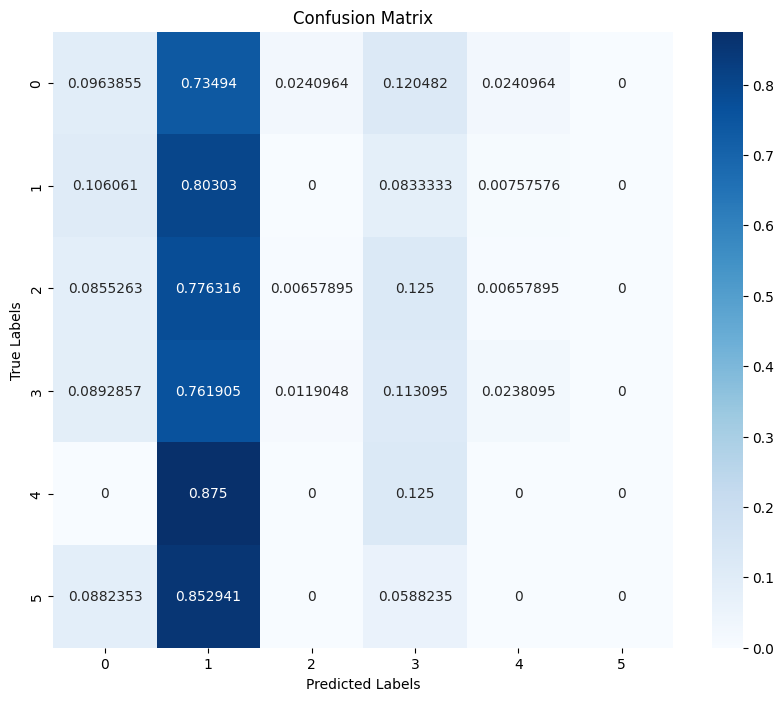

Epoch 16, Validation Loss: 1.6827, Accuracy: 0.2322, F1 Score: 0.1519
Val F1 Score Per Class  [0.11764706 0.36488812 0.01273885 0.16521739 0.         0.        ]


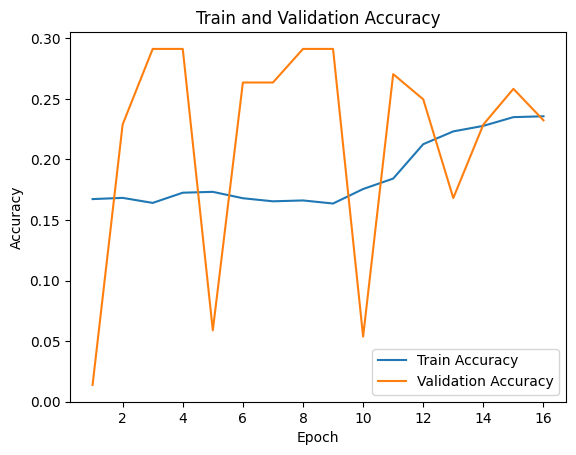

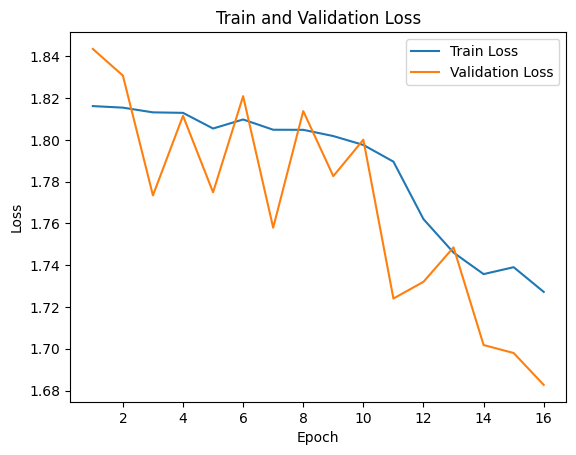

Epoch 17, Train Loss: 1.7229, Accuracy: 0.2341, F1 Score: 0.2049
Train F1 Score Per Class  [0.18448023 0.17167382 0.07178465 0.24092888 0.4220022  0.1393373 ]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.53it/s, loss=1.72]

[tensor([-7.4328e-02,  3.5764e-04, -9.6380e-02, -5.5487e-02, -1.9076e-01,
        -4.7907e-01], device='cuda:0'), tensor([-0.1579, -0.0374, -0.2932, -0.2023, -0.5510, -0.6446], device='cuda:0'), tensor([ 0.0220,  0.0616,  0.0495,  0.0934, -0.8458, -0.3242], device='cuda:0'), tensor([-0.1571, -0.0325, -0.1264, -0.1100, -0.9631, -0.5429], device='cuda:0'), tensor([-0.2408, -0.0780, -0.1815, -0.1536, -3.0090, -0.6079], device='cuda:0'), tensor([ 0.0436,  0.0191, -0.1223, -0.0884, -1.6431, -0.3858], device='cuda:0'), tensor([-0.0063,  0.0553,  0.0620,  0.1016, -0.6411, -0.3330], device='cuda:0'), tensor([-0.0778, -0.0083, -0.1336, -0.0567,  0.0560, -0.5150], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.52it/s, loss=1.78]

[tensor([ 0.0272,  0.0340, -0.0158,  0.0140, -0.7705, -0.3937], device='cuda:0'), tensor([-0.0467,  0.0048,  0.0194,  0.0507, -0.8700, -0.4016], device='cuda:0'), tensor([ 0.2217,  0.0697,  0.2511,  0.2953, -1.7131, -0.0092], device='cuda:0'), tensor([ 0.0943,  0.0827,  0.1188,  0.1600, -0.8497, -0.2147], device='cuda:0'), tensor([ 0.2429,  0.0738,  0.2117,  0.2612, -1.8048,  0.0297], device='cuda:0'), tensor([-0.1117,  0.0268, -0.0788, -0.0339, -0.2040, -0.5274], device='cuda:0'), tensor([ 0.2177,  0.0997,  0.1365,  0.2163, -2.2723, -0.0825], device='cuda:0'), tensor([ 0.1478,  0.0949,  0.2160,  0.2399, -1.5659, -0.1394], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.45it/s, loss=1.7]

[tensor([-0.0471,  0.0318,  0.0059,  0.0335, -0.1789, -0.3881], device='cuda:0'), tensor([-0.0295,  0.0526,  0.0468,  0.0562, -1.0791, -0.3953], device='cuda:0'), tensor([ 0.0484,  0.0863,  0.1413,  0.1725, -0.9316, -0.2533], device='cuda:0'), tensor([ 0.1361,  0.1070,  0.2077,  0.2252, -1.0579, -0.1695], device='cuda:0'), tensor([ 0.1154,  0.0982,  0.1106,  0.1387, -1.9971, -0.2430], device='cuda:0'), tensor([ 0.1633,  0.1012,  0.1319,  0.2052, -1.9453, -0.1277], device='cuda:0'), tensor([-0.1201, -0.0477, -0.0597, -0.0280, -2.0544, -0.3893], device='cuda:0'), tensor([-0.0352,  0.0679,  0.0273,  0.0746, -1.4837, -0.3961], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:27,  2.47it/s, loss=1.65]

[tensor([ 0.0256,  0.0586,  0.0458,  0.0595, -0.5674, -0.3747], device='cuda:0'), tensor([-0.1475, -0.0098, -0.1746, -0.1164, -0.6426, -0.5701], device='cuda:0'), tensor([ 0.0909,  0.0745,  0.1530,  0.1905, -1.0385, -0.2051], device='cuda:0'), tensor([-0.1191, -0.0171, -0.1075, -0.0482, -0.1849, -0.4711], device='cuda:0'), tensor([ 0.0948,  0.1006,  0.1424,  0.1664, -0.8738, -0.2105], device='cuda:0'), tensor([ 0.0525,  0.0414,  0.0757,  0.1219, -1.0275, -0.2790], device='cuda:0'), tensor([ 0.1877,  0.0615,  0.2029,  0.2266, -1.4017, -0.0470], device='cuda:0'), tensor([ 0.1355,  0.1240,  0.1720,  0.1934, -0.6332, -0.2217], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.45it/s, loss=1.66]

[tensor([ 0.1183,  0.1077,  0.1290,  0.1707, -1.6651, -0.2264], device='cuda:0'), tensor([-0.0062,  0.0710,  0.0112,  0.1094, -0.3887, -0.3696], device='cuda:0'), tensor([ 0.1134,  0.0907,  0.1973,  0.2278, -1.0058, -0.1486], device='cuda:0'), tensor([ 0.0137, -0.0107, -0.0483, -0.0085, -0.7088, -0.3521], device='cuda:0'), tensor([ 0.2145,  0.1052,  0.1465,  0.2106, -0.8600, -0.1061], device='cuda:0'), tensor([ 0.0407,  0.0592,  0.0132,  0.0757, -0.7886, -0.2832], device='cuda:0'), tensor([-0.0393,  0.0272,  0.0221,  0.0461, -0.5230, -0.3807], device='cuda:0'), tensor([ 0.1977,  0.0667,  0.1443,  0.1878, -0.8107, -0.1194], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.45it/s, loss=1.76]

[tensor([-0.0149,  0.0433, -0.0274,  0.0072, -0.5402, -0.4245], device='cuda:0'), tensor([ 0.0321,  0.0296,  0.0766,  0.1104, -0.5075, -0.2463], device='cuda:0'), tensor([ 0.0767,  0.1018,  0.1269,  0.1903, -0.9077, -0.2569], device='cuda:0'), tensor([-0.0162,  0.0682,  0.0306,  0.0867,  0.0254, -0.3985], device='cuda:0'), tensor([ 0.0830,  0.0248,  0.0446,  0.0935, -0.9042, -0.2427], device='cuda:0'), tensor([ 0.2884,  0.1468,  0.2520,  0.2298, -4.7440, -0.0464], device='cuda:0'), tensor([ 0.0173, -0.0031, -0.0989, -0.0688, -1.4936, -0.3594], device='cuda:0'), tensor([-0.0053,  0.0653,  0.0268,  0.0738, -1.3613, -0.3560], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.44it/s, loss=1.63]

[tensor([ 0.0692,  0.0947,  0.0906,  0.1621, -0.7245, -0.2600], device='cuda:0'), tensor([ 0.1319,  0.0869,  0.1728,  0.2073, -0.9605, -0.1756], device='cuda:0'), tensor([ 0.0990,  0.0554,  0.0323,  0.0451, -0.4906, -0.2401], device='cuda:0'), tensor([-0.0154, -0.0274, -0.2387, -0.1579, -0.4142, -0.4495], device='cuda:0'), tensor([-0.0325, -0.0470, -0.1671, -0.1104, -0.5496, -0.3932], device='cuda:0'), tensor([ 0.1622,  0.1468,  0.2283,  0.2688, -2.5648, -0.1292], device='cuda:0'), tensor([ 0.1029,  0.0859,  0.1327,  0.1585, -2.0909, -0.2038], device='cuda:0'), tensor([ 0.0427,  0.1040,  0.0879,  0.1333, -0.5502, -0.3238], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.43it/s, loss=1.75]

[tensor([ 0.0325,  0.0808,  0.0348,  0.0807, -0.4013, -0.3347], device='cuda:0'), tensor([ 0.0359,  0.0592,  0.0821,  0.1115, -1.1297, -0.2798], device='cuda:0'), tensor([-0.1138,  0.0133, -0.0708, -0.0284,  0.0981, -0.4895], device='cuda:0'), tensor([ 0.1097,  0.0865,  0.0757,  0.1220, -1.0577, -0.2700], device='cuda:0'), tensor([ 0.0531,  0.0681,  0.1246,  0.1358, -0.8729, -0.2308], device='cuda:0'), tensor([ 0.3893,  0.1894,  0.4349,  0.4649, -1.9123,  0.1957], device='cuda:0'), tensor([-0.2402, -0.0204, -0.1998, -0.1512, -0.2403, -0.6594], device='cuda:0'), tensor([ 0.2509,  0.0785,  0.2585,  0.2802, -2.1259,  0.0534], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.44it/s, loss=1.73]

[tensor([ 0.0525,  0.0827,  0.0850,  0.1311, -0.6600, -0.2692], device='cuda:0'), tensor([ 0.0678,  0.0744,  0.1183,  0.1700, -0.9436, -0.2359], device='cuda:0'), tensor([-0.0394,  0.0514,  0.0134,  0.0383, -0.6989, -0.4243], device='cuda:0'), tensor([-0.0607,  0.0320,  0.0247,  0.0525, -1.5794, -0.3955], device='cuda:0'), tensor([-0.0415,  0.0139, -0.0127,  0.0385, -1.5366, -0.4076], device='cuda:0'), tensor([-0.1433,  0.0195, -0.1183, -0.0713, -0.2799, -0.5858], device='cuda:0'), tensor([-0.2583, -0.2764, -0.6841, -0.5656,  0.1945, -0.8528], device='cuda:0'), tensor([ 0.1226,  0.0698,  0.0421,  0.1018, -1.5765, -0.2220], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.45it/s, loss=1.68]

[tensor([ 0.2293,  0.1153,  0.2312,  0.2579, -1.0797, -0.0764], device='cuda:0'), tensor([ 0.2423,  0.0620,  0.1526,  0.1844, -2.1168, -0.0033], device='cuda:0'), tensor([ 0.2068, -0.0136, -0.0472, -0.0443, -4.1149, -0.1952], device='cuda:0'), tensor([ 6.1876e-04,  3.4344e-02,  1.9074e-02,  6.3401e-02, -7.6960e-01,
        -3.1959e-01], device='cuda:0'), tensor([-0.0868,  0.0183, -0.0074, -0.0036, -0.6967, -0.4222], device='cuda:0'), tensor([-0.2600, -0.0343, -0.1954, -0.1447, -0.0843, -0.6644], device='cuda:0'), tensor([ 0.1689,  0.0620,  0.1199,  0.1664, -1.2295, -0.1295], device='cuda:0'), tensor([-0.0310,  0.0547,  0.0233,  0.0782, -0.6498, -0.3636], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.45it/s, loss=1.77]

[tensor([ 0.1051,  0.1194,  0.1456,  0.1796, -1.9284, -0.2459], device='cuda:0'), tensor([ 0.0258,  0.0751,  0.0899,  0.1614, -0.8034, -0.2736], device='cuda:0'), tensor([ 0.0164, -0.1242, -0.3303, -0.2235, -0.0871, -0.3630], device='cuda:0'), tensor([ 0.0842,  0.0809,  0.0780,  0.1117, -0.5954, -0.2620], device='cuda:0'), tensor([-0.0031,  0.0209, -0.0741, -0.0375, -1.3925, -0.4459], device='cuda:0'), tensor([-0.0980, -0.0031, -0.0421,  0.0197, -0.7488, -0.3828], device='cuda:0'), tensor([-0.0673,  0.0368, -0.0060,  0.0095, -0.5375, -0.4356], device='cuda:0'), tensor([ 0.0781,  0.1167,  0.1093,  0.1324, -0.8699, -0.2671], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.46it/s, loss=1.64]

[tensor([-0.0076,  0.0343, -0.0665, -0.0365, -0.8239, -0.4693], device='cuda:0'), tensor([ 0.0332,  0.0729, -0.0085,  0.0138, -0.4900, -0.3928], device='cuda:0'), tensor([-0.0884,  0.0278, -0.0845, -0.0216, -0.7904, -0.4825], device='cuda:0'), tensor([ 0.0605,  0.0976,  0.0877,  0.1343, -1.1835, -0.2792], device='cuda:0'), tensor([ 0.2941,  0.0875,  0.2445,  0.2893, -2.6984,  0.0713], device='cuda:0'), tensor([ 0.0090,  0.0451,  0.0523,  0.0761, -0.8803, -0.3004], device='cuda:0'), tensor([-0.1085, -0.0051, -0.0742, -0.0014, -0.4719, -0.4645], device='cuda:0'), tensor([-0.1156, -0.0417, -0.1082, -0.0327,  0.1146, -0.4494], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.46it/s, loss=1.63]

[tensor([-0.0153,  0.0444,  0.0133,  0.0471, -0.6438, -0.3462], device='cuda:0'), tensor([-0.0142,  0.0462,  0.0070,  0.0559, -0.5229, -0.3859], device='cuda:0'), tensor([ 0.0542, -0.0179,  0.0252,  0.0811, -1.2691, -0.2143], device='cuda:0'), tensor([-0.0122,  0.0781,  0.0430,  0.0749, -0.6868, -0.4126], device='cuda:0'), tensor([-0.0441,  0.0268,  0.0247,  0.0713, -0.3413, -0.3414], device='cuda:0'), tensor([ 0.1133,  0.1247,  0.1458,  0.1636, -0.9182, -0.2333], device='cuda:0'), tensor([ 0.1791,  0.1049,  0.1896,  0.2062, -1.5943, -0.1213], device='cuda:0'), tensor([ 0.2343,  0.1196,  0.1921,  0.2286, -1.3776, -0.0926], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:23,  2.46it/s, loss=1.71]

[tensor([-0.1997, -0.0412, -0.2121, -0.1857, -0.6008, -0.6548], device='cuda:0'), tensor([-0.1126, -0.0113, -0.1097, -0.0669, -1.2387, -0.5291], device='cuda:0'), tensor([ 0.0757,  0.1131,  0.1328,  0.1767, -0.8856, -0.2610], device='cuda:0'), tensor([ 0.2289,  0.0803,  0.1252,  0.1492, -3.1086, -0.0762], device='cuda:0'), tensor([ 0.2960,  0.0869,  0.1703,  0.1712, -1.8750,  0.0193], device='cuda:0'), tensor([ 0.1437,  0.0920,  0.1191,  0.1672, -3.5664, -0.1790], device='cuda:0'), tensor([-0.2342, -0.0618, -0.1815, -0.1485,  0.4704, -0.6426], device='cuda:0'), tensor([ 0.0079,  0.0770,  0.0453,  0.0721, -1.4236, -0.3588], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.47it/s, loss=1.64]

[tensor([ 0.0246,  0.0836,  0.0857,  0.1267, -1.0171, -0.3173], device='cuda:0'), tensor([-0.0127,  0.0092,  0.0061,  0.0217, -0.1829, -0.3336], device='cuda:0'), tensor([ 0.0902,  0.1179,  0.1393,  0.1607, -0.7266, -0.2560], device='cuda:0'), tensor([ 0.0398,  0.0804,  0.0831,  0.1254, -0.5227, -0.3253], device='cuda:0'), tensor([ 0.0594,  0.0724,  0.0730,  0.1345, -1.6274, -0.2733], device='cuda:0'), tensor([ 0.1352,  0.0569,  0.0613,  0.1021, -2.4796, -0.2174], device='cuda:0'), tensor([ 0.1053,  0.1116,  0.1950,  0.2201, -1.3420, -0.1876], device='cuda:0'), tensor([-0.0675,  0.0229, -0.0311,  0.0277, -0.1675, -0.4168], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.47it/s, loss=1.62]

[tensor([ 0.0565,  0.0995,  0.0664,  0.1558, -0.6329, -0.3062], device='cuda:0'), tensor([-0.0271,  0.0323,  0.0152,  0.0293, -0.6125, -0.3817], device='cuda:0'), tensor([ 0.0738,  0.0618,  0.1091,  0.1488, -0.9633, -0.2461], device='cuda:0'), tensor([ 0.0420,  0.0854,  0.0817,  0.1202, -0.8709, -0.3268], device='cuda:0'), tensor([ 0.0908,  0.1028,  0.1470,  0.1783, -1.3686, -0.2527], device='cuda:0'), tensor([-0.1167, -0.0195, -0.0266, -0.0067, -0.8246, -0.4023], device='cuda:0'), tensor([-0.0787,  0.0500,  0.0126,  0.0507, -0.5578, -0.4178], device='cuda:0'), tensor([ 0.0277,  0.0930,  0.0872,  0.1279, -0.8329, -0.3103], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.46it/s, loss=1.65]

[tensor([-0.0394,  0.0461,  0.0524,  0.0667, -0.4991, -0.3841], device='cuda:0'), tensor([ 0.0495,  0.0626,  0.0220,  0.0838, -0.8142, -0.2939], device='cuda:0'), tensor([ 0.1140,  0.0955,  0.1257,  0.1843, -0.6143, -0.2339], device='cuda:0'), tensor([ 0.0376,  0.0424, -0.0817, -0.0139, -1.7669, -0.4152], device='cuda:0'), tensor([ 0.1580,  0.0178,  0.0988,  0.1042, -3.5672, -0.1275], device='cuda:0'), tensor([ 0.1428,  0.0396,  0.1143,  0.1404, -1.6048, -0.1485], device='cuda:0'), tensor([ 0.1881,  0.0589,  0.1332,  0.1787, -0.9735, -0.1341], device='cuda:0'), tensor([ 0.1281,  0.1009,  0.1512,  0.1864, -0.6246, -0.1899], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.47it/s, loss=1.65]

[tensor([-0.0063,  0.0279, -0.0630,  0.0040, -0.2462, -0.3960], device='cuda:0'), tensor([-0.0038, -0.0035, -0.0223,  0.0108, -0.8605, -0.3345], device='cuda:0'), tensor([-0.0016,  0.0488,  0.0753,  0.1127, -0.5517, -0.3016], device='cuda:0'), tensor([ 0.0066,  0.0373, -0.0347,  0.0033, -0.8771, -0.3990], device='cuda:0'), tensor([ 0.2221,  0.1222,  0.2641,  0.3154, -2.0739, -0.0574], device='cuda:0'), tensor([ 0.0348,  0.0663,  0.0952,  0.1055, -1.3000, -0.3008], device='cuda:0'), tensor([-0.0647,  0.0334, -0.0287,  0.0216, -0.8750, -0.4578], device='cuda:0'), tensor([ 0.0945,  0.0704,  0.0996,  0.1390, -0.8112, -0.2242], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:21,  2.46it/s, loss=1.69]

[tensor([ 0.3618,  0.1235,  0.2567,  0.2654, -1.9451,  0.1223], device='cuda:0'), tensor([-0.2297, -0.0501, -0.1922, -0.1300, -0.5974, -0.6471], device='cuda:0'), tensor([ 0.0235,  0.0796,  0.0894,  0.1156, -0.8444, -0.3273], device='cuda:0'), tensor([-0.0627, -0.0344, -0.1094, -0.0722, -0.6688, -0.4659], device='cuda:0'), tensor([ 0.0091,  0.0337,  0.0821,  0.1080, -1.0775, -0.2948], device='cuda:0'), tensor([ 0.2284,  0.1406,  0.1890,  0.2217, -1.5033, -0.1098], device='cuda:0'), tensor([-0.1480, -0.1325, -0.3345, -0.2646,  0.1055, -0.5952], device='cuda:0'), tensor([-0.0621,  0.0449, -0.0099,  0.0476, -1.8785, -0.3998], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.46it/s, loss=1.68]

[tensor([ 0.1524,  0.1061,  0.1375,  0.2057, -1.2179, -0.1524], device='cuda:0'), tensor([ 0.1734,  0.1157,  0.2129,  0.2368, -1.4712, -0.1183], device='cuda:0'), tensor([-0.1919, -0.0472, -0.1532, -0.0929, -0.8389, -0.5383], device='cuda:0'), tensor([-0.0470,  0.0372,  0.0145,  0.0527, -0.6594, -0.3773], device='cuda:0'), tensor([-0.1197,  0.0138, -0.0537,  0.0085, -0.0774, -0.5007], device='cuda:0'), tensor([ 0.1057,  0.0999,  0.1362,  0.1848, -1.3724, -0.2194], device='cuda:0'), tensor([ 0.1110,  0.0311,  0.0325,  0.0755, -4.6565, -0.1826], device='cuda:0'), tensor([-0.1723, -0.0161, -0.1035, -0.0712, -0.4323, -0.5546], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.45it/s, loss=1.63]

[tensor([-0.0713,  0.0411,  0.0024,  0.0467, -0.9155, -0.4182], device='cuda:0'), tensor([ 0.1376,  0.1003,  0.1369,  0.1878, -0.7907, -0.1844], device='cuda:0'), tensor([-0.0709,  0.0125, -0.1078, -0.0576, -0.4447, -0.4949], device='cuda:0'), tensor([ 0.1138,  0.1195,  0.1592,  0.1773, -1.0989, -0.2175], device='cuda:0'), tensor([ 0.1249,  0.1125,  0.1747,  0.2067, -1.0049, -0.1842], device='cuda:0'), tensor([-0.1812, -0.1053, -0.2477, -0.1843, -0.2991, -0.6127], device='cuda:0'), tensor([ 0.0436,  0.1234,  0.0737,  0.1352, -0.9803, -0.3820], device='cuda:0'), tensor([ 0.0533,  0.1167,  0.1296,  0.1505, -1.2107, -0.3134], device='cuda:0')]


Val:  30%|███       | 22/73 [00:08<00:20,  2.45it/s, loss=1.65]

[tensor([-0.0546,  0.0268, -0.0059,  0.0294, -0.6771, -0.4238], device='cuda:0'), tensor([ 0.0462,  0.0931,  0.1100,  0.1549, -1.0141, -0.2696], device='cuda:0'), tensor([-0.0430,  0.0429,  0.0312,  0.0446, -1.2564, -0.3913], device='cuda:0'), tensor([ 0.0417,  0.0883,  0.1209,  0.1405, -0.4705, -0.2940], device='cuda:0'), tensor([-0.1006,  0.0270, -0.0326, -0.0031, -0.1399, -0.4671], device='cuda:0'), tensor([ 0.0531,  0.0632,  0.0782,  0.0988, -1.0443, -0.2589], device='cuda:0'), tensor([ 0.1446,  0.1060,  0.1978,  0.2322, -0.7836, -0.1844], device='cuda:0'), tensor([ 0.2185,  0.1376,  0.2825,  0.3274, -1.1888, -0.0522], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.46it/s, loss=1.62]

[tensor([ 0.0119,  0.0536,  0.0668,  0.0683, -0.6423, -0.3373], device='cuda:0'), tensor([-0.1044, -0.0131, -0.1256, -0.0948, -0.7298, -0.5096], device='cuda:0'), tensor([ 0.1161,  0.0935,  0.1110,  0.1305, -1.2976, -0.2216], device='cuda:0'), tensor([-0.1270,  0.0154, -0.0659, -0.0053, -0.6735, -0.4708], device='cuda:0'), tensor([ 0.1179,  0.0059,  0.0681,  0.0853, -3.8896, -0.1778], device='cuda:0'), tensor([-0.2055, -0.0124, -0.1488, -0.0967, -0.5359, -0.6345], device='cuda:0'), tensor([-0.1581,  0.0048, -0.1272, -0.0906, -0.2118, -0.6172], device='cuda:0'), tensor([-0.1331,  0.0072, -0.0290, -0.0027, -1.1522, -0.4555], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.47it/s, loss=1.71]

[tensor([-0.2716, -0.0707, -0.2260, -0.1574, -1.2007, -0.6508], device='cuda:0'), tensor([ 0.2014,  0.0991,  0.2714,  0.2854, -1.4064, -0.0726], device='cuda:0'), tensor([ 0.1546,  0.1306,  0.1983,  0.2391, -1.2002, -0.1663], device='cuda:0'), tensor([ 0.0273,  0.0084, -0.0665, -0.0353, -0.6400, -0.3451], device='cuda:0'), tensor([-0.1024, -0.0213, -0.0821, -0.0349, -2.1381, -0.4619], device='cuda:0'), tensor([ 0.0156,  0.0931,  0.0756,  0.1433, -0.6761, -0.3295], device='cuda:0'), tensor([-0.0189,  0.0430,  0.0024,  0.0375, -0.5265, -0.3954], device='cuda:0'), tensor([ 0.3368,  0.1409,  0.3718,  0.3842, -2.4832,  0.1270], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.46it/s, loss=1.78]

[tensor([-0.1080,  0.0117, -0.1132, -0.0796, -0.4809, -0.5060], device='cuda:0'), tensor([-0.2352, -0.0597, -0.2653, -0.2080,  0.3361, -0.7046], device='cuda:0'), tensor([-0.0430,  0.0267, -0.0290,  0.0185, -1.0055, -0.4182], device='cuda:0'), tensor([-0.0704,  0.0406,  0.0150,  0.0582, -0.8922, -0.4223], device='cuda:0'), tensor([-0.0595,  0.0484, -0.0143,  0.0273, -0.3093, -0.4578], device='cuda:0'), tensor([-0.1269,  0.0122, -0.0593, -0.0298, -0.0062, -0.4926], device='cuda:0'), tensor([ 0.0218,  0.0829,  0.0569,  0.1023, -0.8864, -0.3398], device='cuda:0'), tensor([-0.0522,  0.0260,  0.0196,  0.0584, -1.6411, -0.3790], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.46it/s, loss=1.67]

[tensor([ 0.0037,  0.0504,  0.0122,  0.0382, -0.6279, -0.3581], device='cuda:0'), tensor([-0.1501,  0.0035, -0.0725, -0.0310, -0.3125, -0.5206], device='cuda:0'), tensor([ 0.9801,  0.2727,  0.6483,  0.6748, -4.3537,  0.8475], device='cuda:0'), tensor([ 0.1024,  0.1090,  0.1634,  0.1980, -1.3884, -0.2152], device='cuda:0'), tensor([ 0.0246,  0.0745,  0.0602,  0.0809, -1.0298, -0.3395], device='cuda:0'), tensor([ 0.0723,  0.0903,  0.1470,  0.1921, -0.8483, -0.2179], device='cuda:0'), tensor([ 0.1564,  0.1092,  0.1557,  0.2048, -1.2530, -0.1357], device='cuda:0'), tensor([ 0.0253,  0.0339,  0.0522,  0.0881, -0.7990, -0.2980], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:10<00:18,  2.47it/s, loss=1.64]

[tensor([ 0.2333,  0.1183,  0.2727,  0.3090, -1.1875, -0.0378], device='cuda:0'), tensor([ 0.0437,  0.0344,  0.0601,  0.0997, -0.9929, -0.2849], device='cuda:0'), tensor([-0.1462, -0.0107, -0.1299, -0.1051, -0.7122, -0.5775], device='cuda:0'), tensor([ 0.1206,  0.1208,  0.1515,  0.2002, -0.5392, -0.2270], device='cuda:0'), tensor([ 0.0852,  0.1067,  0.1265,  0.1508, -1.0064, -0.2554], device='cuda:0'), tensor([-0.1270, -0.0323, -0.1538, -0.0768, -0.7970, -0.5132], device='cuda:0'), tensor([ 0.1302,  0.1248,  0.1592,  0.2025, -0.9855, -0.1974], device='cuda:0'), tensor([ 0.0606,  0.0485,  0.0577,  0.1157, -1.0973, -0.2526], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.46it/s, loss=1.64]

[tensor([ 0.0071,  0.0345, -0.0371,  0.0215, -0.7296, -0.3717], device='cuda:0'), tensor([ 0.1524,  0.1163,  0.2325,  0.2474, -1.9416, -0.1402], device='cuda:0'), tensor([-0.2185, -0.0697, -0.2171, -0.1500, -3.7347, -0.6211], device='cuda:0'), tensor([-0.1279,  0.0102, -0.0756, -0.0597, -0.5295, -0.5193], device='cuda:0'), tensor([-0.0799,  0.0336, -0.0518, -0.0031, -0.7659, -0.4596], device='cuda:0'), tensor([-0.0842,  0.0081, -0.0399,  0.0105, -1.7356, -0.4562], device='cuda:0'), tensor([ 0.0699,  0.0615,  0.0232,  0.0287, -1.5925, -0.3256], device='cuda:0'), tensor([ 0.1523,  0.0945,  0.1427,  0.1921, -0.7637, -0.1697], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.45it/s, loss=1.61]

[tensor([ 0.0908,  0.0694,  0.1474,  0.1676, -1.7516, -0.1774], device='cuda:0'), tensor([-0.1178, -0.0382, -0.1699, -0.1042, -1.5245, -0.4903], device='cuda:0'), tensor([-0.0340,  0.0624,  0.0345,  0.0681, -0.5998, -0.3744], device='cuda:0'), tensor([ 0.0614,  0.0867,  0.1189,  0.1577, -1.4291, -0.2628], device='cuda:0'), tensor([-0.1157,  0.0278, -0.0679, -0.0112, -0.7188, -0.5010], device='cuda:0'), tensor([ 0.0483,  0.1066,  0.1221,  0.1585, -0.6300, -0.2745], device='cuda:0'), tensor([-0.0204,  0.0539,  0.0340,  0.0907, -0.7970, -0.3728], device='cuda:0'), tensor([ 0.0488,  0.0838,  0.0980,  0.1443, -0.5283, -0.3121], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.46it/s, loss=1.62]

[tensor([-0.0396,  0.0332, -0.0129,  0.0317, -0.9789, -0.3755], device='cuda:0'), tensor([ 0.0943,  0.1053,  0.0808,  0.1243, -0.8566, -0.2899], device='cuda:0'), tensor([-5.4466e-02,  2.8908e-02, -5.6201e-02, -2.5428e-04, -7.7232e-01,
        -4.9388e-01], device='cuda:0'), tensor([ 0.0771,  0.0730,  0.1254,  0.1500, -1.1629, -0.2122], device='cuda:0'), tensor([-0.0727,  0.0257, -0.0027,  0.0350, -1.3420, -0.4061], device='cuda:0'), tensor([-0.0819,  0.0592, -0.0274, -0.0072, -0.3904, -0.4700], device='cuda:0'), tensor([ 0.0325,  0.0368,  0.0183,  0.0819, -0.9087, -0.3402], device='cuda:0'), tensor([-0.1877,  0.0064, -0.1498, -0.0957,  0.1000, -0.6055], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.44it/s, loss=1.63]

[tensor([ 0.4530,  0.1201,  0.3058,  0.3260, -2.1314,  0.2297], device='cuda:0'), tensor([-0.0189,  0.0330, -0.0098,  0.0054, -0.0874, -0.3685], device='cuda:0'), tensor([-0.0343,  0.0548,  0.0436,  0.0846, -1.3786, -0.3912], device='cuda:0'), tensor([ 0.1878,  0.1156,  0.1462,  0.1980, -0.8234, -0.1676], device='cuda:0'), tensor([ 0.0688,  0.0894,  0.1169,  0.1631, -0.8775, -0.2860], device='cuda:0'), tensor([-0.0279,  0.0406, -0.0043,  0.0424, -0.4058, -0.3930], device='cuda:0'), tensor([ 0.2410, -0.2932, -0.6652, -0.6135, -4.0668, -0.4126], device='cuda:0'), tensor([ 0.0167,  0.0561,  0.0735,  0.1304, -1.4230, -0.2780], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.45it/s, loss=1.63]

[tensor([-0.0542,  0.0535, -0.0184,  0.0086, -0.7522, -0.4600], device='cuda:0'), tensor([-1.1181e-01,  2.2730e-02, -2.9528e-02, -1.5385e-05, -1.7213e-01,
        -4.8313e-01], device='cuda:0'), tensor([ 0.0630, -0.0070,  0.0185,  0.0532, -0.6623, -0.2416], device='cuda:0'), tensor([ 0.0310,  0.0508,  0.0258,  0.0759, -0.7027, -0.3277], device='cuda:0'), tensor([-0.0223, -0.0137, -0.0160,  0.0475, -0.8965, -0.3093], device='cuda:0'), tensor([ 0.1682,  0.1305,  0.2137,  0.2326, -2.8307, -0.1608], device='cuda:0'), tensor([ 0.1787,  0.0883,  0.1840,  0.2328, -1.3785, -0.0987], device='cuda:0'), tensor([ 0.1063,  0.1058,  0.1209,  0.1454, -1.0840, -0.2034], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.45it/s, loss=1.6]

[tensor([ 0.1251,  0.1120,  0.1706,  0.2073, -0.9147, -0.2043], device='cuda:0'), tensor([ 0.0057,  0.0322, -0.0100,  0.0167, -1.1156, -0.3611], device='cuda:0'), tensor([-0.1188,  0.0564, -0.0836, -0.0318, -0.6094, -0.5658], device='cuda:0'), tensor([ 0.0571,  0.0819,  0.0562,  0.1095, -0.8699, -0.3172], device='cuda:0'), tensor([ 0.0769,  0.1019,  0.1235,  0.1498, -2.0406, -0.2582], device='cuda:0'), tensor([ 1.4709e-01, -1.5229e-05, -1.1754e-02,  5.6325e-02, -2.8320e+00,
        -1.9706e-01], device='cuda:0'), tensor([ 0.0407,  0.0772,  0.1302,  0.1462, -1.2261, -0.2661], device='cuda:0'), tensor([ 0.0229,  0.0851,  0.1053,  0.1445, -0.4886, -0.3203], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.45it/s, loss=1.64]

[tensor([ 0.3288,  0.0989,  0.2386,  0.2645, -2.3257,  0.0983], device='cuda:0'), tensor([ 0.3249,  0.1155,  0.2040,  0.2422, -1.4027,  0.0736], device='cuda:0'), tensor([-0.1595, -0.0147, -0.1163, -0.0642, -0.6641, -0.5813], device='cuda:0'), tensor([ 0.1413,  0.0202,  0.1008,  0.1436, -0.8570, -0.1888], device='cuda:0'), tensor([-0.0536, -0.0330, -0.1591, -0.1228, -0.1941, -0.4948], device='cuda:0'), tensor([ 0.1211,  0.1080,  0.1172,  0.1830, -0.9340, -0.2102], device='cuda:0'), tensor([-0.1040,  0.0298, -0.0503, -0.0313, -0.1365, -0.4967], device='cuda:0'), tensor([ 0.0585,  0.0626,  0.1313,  0.1579, -0.5842, -0.2236], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.46it/s, loss=1.66]

[tensor([ 0.2029,  0.0396,  0.1122,  0.1574, -2.4719, -0.0446], device='cuda:0'), tensor([ 0.0836,  0.1112,  0.1403,  0.1809, -0.5756, -0.2903], device='cuda:0'), tensor([-0.1861, -0.1037, -0.2246, -0.1868, -1.8687, -0.5523], device='cuda:0'), tensor([ 0.1472,  0.0946,  0.1428,  0.2097, -0.8369, -0.1102], device='cuda:0'), tensor([ 0.0178,  0.0790,  0.1171,  0.1416, -0.4367, -0.2852], device='cuda:0'), tensor([ 0.1191,  0.0844,  0.1232,  0.1788, -1.2222, -0.1694], device='cuda:0'), tensor([ 0.1743,  0.0411,  0.0395,  0.0900, -1.7107, -0.1852], device='cuda:0'), tensor([ 0.0686,  0.0634,  0.1356,  0.1739, -0.5859, -0.2398], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.45it/s, loss=1.63]

[tensor([ 0.0425,  0.0407,  0.0044,  0.0290, -1.6133, -0.3451], device='cuda:0'), tensor([-0.1060,  0.0274, -0.0497,  0.0057, -0.8471, -0.4770], device='cuda:0'), tensor([ 0.2924,  0.1257,  0.1549,  0.2452, -1.0876, -0.0655], device='cuda:0'), tensor([ 0.0392,  0.0330,  0.0753,  0.1064, -1.2861, -0.3006], device='cuda:0'), tensor([ 0.1030,  0.0779,  0.0863,  0.1473, -1.5990, -0.2186], device='cuda:0'), tensor([ 0.0436,  0.0188, -0.1072, -0.0337, -3.7711, -0.3843], device='cuda:0'), tensor([ 0.2111,  0.1519,  0.2385,  0.2667, -1.2567, -0.1062], device='cuda:0'), tensor([ 0.0988,  0.0983,  0.1421,  0.1897, -0.8030, -0.2422], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.46it/s, loss=1.72]

[tensor([ 0.0676,  0.0321,  0.0403,  0.0853, -0.7294, -0.3091], device='cuda:0'), tensor([ 0.0192,  0.0999,  0.0551,  0.0777, -0.7170, -0.3689], device='cuda:0'), tensor([ 0.1013,  0.0918,  0.1205,  0.1997, -1.4624, -0.2170], device='cuda:0'), tensor([ 0.0335,  0.0666,  0.0400,  0.0866, -2.2124, -0.3225], device='cuda:0'), tensor([-0.0435,  0.0522, -0.0365,  0.0290, -0.3362, -0.4421], device='cuda:0'), tensor([ 0.1127,  0.0881,  0.1480,  0.1753, -0.9989, -0.1953], device='cuda:0'), tensor([-0.0019,  0.0665,  0.0782,  0.1124, -0.7590, -0.3305], device='cuda:0'), tensor([ 0.1206,  0.1169,  0.1688,  0.1993, -1.5425, -0.2208], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.46it/s, loss=1.58]

[tensor([-0.0026,  0.0053, -0.0374, -0.0071, -0.9218, -0.3750], device='cuda:0'), tensor([-4.7956e-02,  3.1965e-02, -1.5519e-03,  5.1141e-02, -1.8059e+00,
        -3.7776e-01], device='cuda:0'), tensor([ 0.0606,  0.0696,  0.0374,  0.0828, -0.5056, -0.3076], device='cuda:0'), tensor([ 0.1123, -0.0042, -0.0081,  0.0390, -2.7069, -0.2388], device='cuda:0'), tensor([-0.0129,  0.0292,  0.0869,  0.1189, -3.4061, -0.2704], device='cuda:0'), tensor([-0.1009,  0.0277, -0.0307,  0.0166, -0.4497, -0.4742], device='cuda:0'), tensor([ 0.0071,  0.0480, -0.0076,  0.0542, -1.1012, -0.3401], device='cuda:0'), tensor([ 0.0074,  0.0178, -0.0888, -0.0329, -0.8762, -0.3835], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.46it/s, loss=1.61]

[tensor([-0.1241,  0.0049, -0.0600, -0.0105, -0.8390, -0.4858], device='cuda:0'), tensor([ 0.3769,  0.0952,  0.2416,  0.2848, -2.2575,  0.0647], device='cuda:0'), tensor([ 0.0991,  0.0553,  0.0487,  0.0907, -0.9370, -0.2328], device='cuda:0'), tensor([-0.0417,  0.0078, -0.0377,  0.0071, -0.5758, -0.3829], device='cuda:0'), tensor([ 0.1090,  0.0407,  0.1676,  0.2233, -2.9737, -0.1185], device='cuda:0'), tensor([-0.0206,  0.0567,  0.0757,  0.1071, -0.5976, -0.3689], device='cuda:0'), tensor([ 0.0408,  0.0987,  0.0791,  0.1077, -0.9920, -0.3475], device='cuda:0'), tensor([ 0.0027,  0.0856,  0.0617,  0.1032, -0.7739, -0.3712], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.46it/s, loss=1.67]

[tensor([ 0.0256,  0.0623,  0.0311,  0.0709, -1.1204, -0.3332], device='cuda:0'), tensor([-0.0345,  0.0399, -0.0166,  0.0386, -0.7592, -0.3856], device='cuda:0'), tensor([ 0.0757,  0.0573,  0.1402,  0.1752, -2.3418, -0.2010], device='cuda:0'), tensor([ 0.0398,  0.0768,  0.0966,  0.1224, -1.8810, -0.3104], device='cuda:0'), tensor([ 0.1368,  0.0944,  0.1131,  0.1742, -0.8678, -0.1978], device='cuda:0'), tensor([ 0.1452,  0.0380,  0.1440,  0.1858, -2.0091, -0.1387], device='cuda:0'), tensor([ 0.0285,  0.0225,  0.0341,  0.0858, -0.4836, -0.2736], device='cuda:0'), tensor([ 0.0655,  0.0520,  0.1348,  0.1599, -1.5611, -0.2058], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.45it/s, loss=1.62]

[tensor([-0.0929, -0.0064, -0.0799, -0.0289, -2.0901, -0.4263], device='cuda:0'), tensor([-0.3011, -0.0606, -0.2283, -0.1852, -0.0383, -0.7342], device='cuda:0'), tensor([-0.0414,  0.0551,  0.0430,  0.0658, -0.6211, -0.3925], device='cuda:0'), tensor([-0.1252,  0.0218, -0.0751, -0.0242, -1.6889, -0.5188], device='cuda:0'), tensor([ 0.0819,  0.1027,  0.1152,  0.1723, -1.0412, -0.2682], device='cuda:0'), tensor([ 0.1000,  0.1054,  0.1540,  0.1722, -1.3440, -0.2047], device='cuda:0'), tensor([-0.0321, -0.0453, -0.1200, -0.0688, -0.1469, -0.4110], device='cuda:0'), tensor([-0.1075, -0.0190, -0.1927, -0.1383, -1.0124, -0.5261], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.46it/s, loss=1.63]

[tensor([ 0.0800,  0.0349, -0.0837, -0.0292, -1.0617, -0.4182], device='cuda:0'), tensor([-0.0279,  0.0515,  0.0433,  0.0900, -0.6845, -0.4064], device='cuda:0'), tensor([ 0.2214,  0.1227,  0.2023,  0.2220, -3.1460, -0.1107], device='cuda:0'), tensor([-0.1155,  0.0109, -0.0949, -0.0671, -1.1836, -0.5334], device='cuda:0'), tensor([ 0.1751,  0.0978,  0.1540,  0.2044, -1.6755, -0.1528], device='cuda:0'), tensor([ 0.2161,  0.1442,  0.2150,  0.2258, -0.9994, -0.0949], device='cuda:0'), tensor([-0.0832,  0.0128, -0.0390,  0.0028, -0.5542, -0.4202], device='cuda:0'), tensor([-0.1412,  0.0012, -0.0690, -0.0316, -0.3033, -0.5263], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.46it/s, loss=1.71]

[tensor([-0.1724, -0.0154, -0.1881, -0.1112,  0.0212, -0.6162], device='cuda:0'), tensor([-0.3562, -0.1405, -0.4592, -0.3718, -0.1165, -0.8654], device='cuda:0'), tensor([-3.2509e-02,  4.7341e-02, -3.0032e-04,  5.1306e-02, -2.1763e-01,
        -4.1477e-01], device='cuda:0'), tensor([ 0.0257,  0.0743,  0.0786,  0.1251, -0.7332, -0.3399], device='cuda:0'), tensor([-0.1358,  0.0063, -0.1142, -0.0664, -0.7210, -0.5539], device='cuda:0'), tensor([-0.2238, -0.1131, -0.2754, -0.2256, -1.0134, -0.6704], device='cuda:0'), tensor([-0.1926, -0.0343, -0.1610, -0.1177, -0.6660, -0.5948], device='cuda:0'), tensor([-0.1323, -0.0559, -0.1986, -0.1520, -0.3159, -0.5225], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:17<00:11,  2.45it/s, loss=1.65]

[tensor([ 0.1874, -0.0080,  0.0979,  0.1375, -3.4823, -0.0527], device='cuda:0'), tensor([ 0.1248,  0.0911,  0.1377,  0.1663, -0.7122, -0.1981], device='cuda:0'), tensor([ 0.0595,  0.0383,  0.0445,  0.0798, -0.7900, -0.2548], device='cuda:0'), tensor([-0.0022,  0.0616,  0.0336,  0.0674, -0.6999, -0.3710], device='cuda:0'), tensor([-0.1246,  0.0302, -0.0553, -0.0114, -0.9043, -0.5129], device='cuda:0'), tensor([ 0.0572,  0.0749,  0.1203,  0.1527, -0.7657, -0.2296], device='cuda:0'), tensor([-0.0745,  0.0034, -0.1353, -0.0777,  0.0759, -0.4947], device='cuda:0'), tensor([ 0.0250,  0.0453,  0.0563,  0.0929, -0.4671, -0.2986], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.47it/s, loss=1.7]

[tensor([ 0.0468,  0.0880,  0.1000,  0.1551, -1.0379, -0.2855], device='cuda:0'), tensor([ 0.1296,  0.0994,  0.1286,  0.1901, -0.9496, -0.2287], device='cuda:0'), tensor([ 0.1272,  0.1166,  0.1459,  0.1813, -1.4914, -0.1964], device='cuda:0'), tensor([ 0.0716,  0.0613,  0.0862,  0.1227, -0.8178, -0.2635], device='cuda:0'), tensor([-0.3164, -0.0730, -0.2705, -0.2411,  0.0107, -0.7692], device='cuda:0'), tensor([-0.0521,  0.0021,  0.0372,  0.0697, -1.2877, -0.3123], device='cuda:0'), tensor([ 0.0530,  0.0947,  0.1078,  0.1602, -1.0032, -0.3177], device='cuda:0'), tensor([ 0.0395,  0.0502,  0.0959,  0.1454, -0.4964, -0.2219], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.44it/s, loss=1.66]

[tensor([-0.1744,  0.0165, -0.1188, -0.0665, -0.7373, -0.5957], device='cuda:0'), tensor([-0.0659,  0.0231, -0.0235,  0.0177, -0.3877, -0.3962], device='cuda:0'), tensor([-6.0004e-02,  2.4197e-03, -1.8998e-02,  2.5250e-04, -2.8154e+00,
        -4.4757e-01], device='cuda:0'), tensor([ 0.3283,  0.1574,  0.3581,  0.3877, -2.6050,  0.1116], device='cuda:0'), tensor([ 0.1422,  0.0580,  0.1214,  0.1648, -1.9016, -0.0988], device='cuda:0'), tensor([-0.1951,  0.0153, -0.0897, -0.0552, -0.3411, -0.5824], device='cuda:0'), tensor([ 0.1349,  0.1074,  0.1211,  0.1848, -1.2567, -0.2093], device='cuda:0'), tensor([ 0.0718,  0.0572,  0.0523,  0.0768, -1.6418, -0.2932], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.44it/s, loss=1.63]

[tensor([ 0.1527,  0.0782,  0.1436,  0.1891, -2.5841, -0.1668], device='cuda:0'), tensor([ 0.1581,  0.1092,  0.1623,  0.1910, -1.1044, -0.1443], device='cuda:0'), tensor([ 0.0738,  0.0977,  0.0954,  0.1573, -0.7531, -0.2253], device='cuda:0'), tensor([ 0.0581,  0.0716,  0.0915,  0.1193, -0.8271, -0.2625], device='cuda:0'), tensor([ 0.0084,  0.0415,  0.0554,  0.0893, -1.0166, -0.3016], device='cuda:0'), tensor([ 0.0770,  0.0805,  0.0632,  0.1306, -1.6653, -0.2434], device='cuda:0'), tensor([ 0.1192,  0.0863,  0.1856,  0.2290, -0.8626, -0.1481], device='cuda:0'), tensor([ 0.0562,  0.0747,  0.0449,  0.0868, -2.1594, -0.3156], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.44it/s, loss=1.64]

[tensor([-0.1319, -0.0550, -0.1101, -0.0765,  0.3323, -0.5625], device='cuda:0'), tensor([ 0.3299,  0.1417,  0.3419,  0.3580, -3.1342,  0.1069], device='cuda:0'), tensor([ 0.1193,  0.1082,  0.1680,  0.2256, -1.0091, -0.1854], device='cuda:0'), tensor([-0.0353,  0.0399, -0.0009,  0.0015, -0.7758, -0.3979], device='cuda:0'), tensor([-0.0612,  0.0093, -0.1146, -0.0518, -0.6187, -0.4623], device='cuda:0'), tensor([-0.1135,  0.0107, -0.0671, -0.0240, -0.0403, -0.4697], device='cuda:0'), tensor([-0.1120,  0.0146, -0.0749, -0.0280, -1.3034, -0.5186], device='cuda:0'), tensor([-0.0398,  0.0284, -0.0420,  0.0048, -0.7546, -0.4199], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:19<00:09,  2.46it/s, loss=1.62]

[tensor([ 0.0789,  0.0168, -0.1555, -0.1202, -1.7590, -0.2966], device='cuda:0'), tensor([ 0.0250,  0.0672,  0.0021,  0.0754, -0.6478, -0.3425], device='cuda:0'), tensor([ 0.1441,  0.1174,  0.1825,  0.2417, -0.6631, -0.1796], device='cuda:0'), tensor([-0.0053,  0.0742,  0.0326,  0.0833, -1.5243, -0.3780], device='cuda:0'), tensor([ 0.1441,  0.1262,  0.2070,  0.2450, -1.6053, -0.1632], device='cuda:0'), tensor([ 0.0615,  0.0639,  0.0812,  0.0942, -0.6746, -0.2669], device='cuda:0'), tensor([ 0.1247,  0.0696,  0.0905,  0.1704, -0.6673, -0.1644], device='cuda:0'), tensor([ 0.0842,  0.0597,  0.0356,  0.0868, -1.8418, -0.2254], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.46it/s, loss=1.78]

[tensor([-0.1497,  0.0067, -0.0821, -0.0471, -0.1663, -0.5542], device='cuda:0'), tensor([-0.0439,  0.0347,  0.0177,  0.0578, -1.1199, -0.3922], device='cuda:0'), tensor([ 0.0143,  0.0661,  0.0698,  0.1106, -0.4573, -0.3308], device='cuda:0'), tensor([-0.1118,  0.0090, -0.1022, -0.0577,  0.0849, -0.5182], device='cuda:0'), tensor([ 0.0535,  0.1114,  0.0763,  0.1536, -0.8044, -0.2995], device='cuda:0'), tensor([ 0.0559,  0.0622,  0.1313,  0.1623, -1.0793, -0.2126], device='cuda:0'), tensor([ 0.0657,  0.0952,  0.1027,  0.1368, -0.5606, -0.2702], device='cuda:0'), tensor([ 0.0775,  0.0713,  0.1076,  0.1443, -0.9213, -0.2800], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.46it/s, loss=1.63]

[tensor([-0.0404,  0.0415, -0.0705, -0.0461, -0.5395, -0.4463], device='cuda:0'), tensor([ 0.0226,  0.0660,  0.0110,  0.0503, -0.8679, -0.3538], device='cuda:0'), tensor([-0.0808,  0.0413, -0.0088,  0.0540, -0.5178, -0.4459], device='cuda:0'), tensor([ 0.1304,  0.1288,  0.0800,  0.1750, -0.6771, -0.2548], device='cuda:0'), tensor([ 0.0583,  0.0804,  0.1188,  0.1306, -0.6223, -0.2711], device='cuda:0'), tensor([-0.0150,  0.0426,  0.0756,  0.0908, -0.4769, -0.3110], device='cuda:0'), tensor([ 0.2362,  0.0323,  0.2430,  0.2645, -4.1166,  0.0870], device='cuda:0'), tensor([ 0.2467,  0.0407,  0.1273,  0.1652, -1.5335, -0.0835], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.46it/s, loss=1.67]

[tensor([ 0.0315,  0.0719,  0.1029,  0.1393, -0.4246, -0.2906], device='cuda:0'), tensor([-0.0743,  0.0251, -0.0706, -0.0093, -1.9934, -0.4592], device='cuda:0'), tensor([-0.1638, -0.0297, -0.1715, -0.1222, -0.5665, -0.6280], device='cuda:0'), tensor([ 0.0511,  0.0692,  0.1041,  0.1562, -0.6229, -0.2425], device='cuda:0'), tensor([ 0.3984,  0.2130,  0.3858,  0.4610, -2.1383,  0.1353], device='cuda:0'), tensor([ 0.1024,  0.0248,  0.0106,  0.0776, -1.0999, -0.2294], device='cuda:0'), tensor([-0.0958, -0.0087, -0.0406,  0.0017, -0.2314, -0.4467], device='cuda:0'), tensor([-1.3947e-01, -4.0662e-04, -6.1963e-02, -1.4157e-02, -6.2241e-01,
        -4.7987e-01], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.45it/s, loss=1.58]

[tensor([-0.1536, -0.0216, -0.1495, -0.1035, -1.4411, -0.5721], device='cuda:0'), tensor([ 0.4243,  0.1315,  0.3084,  0.3511, -3.1924,  0.2144], device='cuda:0'), tensor([ 0.0818,  0.0744,  0.0992,  0.1274, -0.7582, -0.2866], device='cuda:0'), tensor([-0.0741, -0.0220, -0.0447, -0.0452, -2.2266, -0.4449], device='cuda:0'), tensor([ 0.1589,  0.1178,  0.1876,  0.1992, -1.0013, -0.1710], device='cuda:0'), tensor([-0.0724,  0.0467, -0.0119,  0.0254, -0.5063, -0.4376], device='cuda:0'), tensor([ 0.1498,  0.1144,  0.2013,  0.2504, -1.2307, -0.1344], device='cuda:0'), tensor([ 0.2482,  0.1265,  0.2733,  0.3243, -1.5448, -0.0336], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:21<00:07,  2.45it/s, loss=1.63]

[tensor([-0.5035, -0.1503, -0.5247, -0.4328, -1.2389, -1.0497], device='cuda:0'), tensor([-0.2874, -0.1055, -0.2167, -0.1844, -0.4040, -0.6543], device='cuda:0'), tensor([ 0.0648,  0.0847,  0.1224,  0.1549, -1.2202, -0.2744], device='cuda:0'), tensor([-0.0244,  0.0400,  0.0102,  0.0476, -1.8283, -0.3866], device='cuda:0'), tensor([ 0.0849,  0.1125,  0.1518,  0.1925, -0.8744, -0.2541], device='cuda:0'), tensor([ 0.0192, -0.0008, -0.0241,  0.0312, -0.5666, -0.2947], device='cuda:0'), tensor([ 0.0894,  0.1275,  0.1438,  0.1712, -1.1452, -0.2760], device='cuda:0'), tensor([-0.1580, -0.1133, -0.3133, -0.2361, -0.9764, -0.6388], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.47it/s, loss=1.63]

[tensor([ 0.0556,  0.0050,  0.0184,  0.0557, -1.9997, -0.2303], device='cuda:0'), tensor([ 0.2548,  0.1356,  0.2879,  0.3083, -2.0958, -0.0065], device='cuda:0'), tensor([-0.1900, -0.0321, -0.1767, -0.1519, -0.8012, -0.6162], device='cuda:0'), tensor([ 0.0963,  0.0519,  0.0241,  0.0569, -1.6605, -0.2748], device='cuda:0'), tensor([-0.0870,  0.0472, -0.0211,  0.0321, -1.3164, -0.4856], device='cuda:0'), tensor([ 0.1469,  0.0974,  0.2152,  0.2692, -1.7629, -0.1133], device='cuda:0'), tensor([-0.0979,  0.0198, -0.0584, -0.0248, -0.7111, -0.5079], device='cuda:0'), tensor([-0.1195, -0.0341, -0.1152, -0.0574, -0.2367, -0.5070], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.43it/s, loss=1.61]

[tensor([ 0.0820,  0.0849,  0.0609,  0.0904, -1.1026, -0.2912], device='cuda:0'), tensor([-0.0308,  0.0554, -0.0123,  0.0390, -1.2899, -0.4178], device='cuda:0'), tensor([ 0.1005,  0.0886,  0.1337,  0.1692, -0.6136, -0.2587], device='cuda:0'), tensor([ 0.0337,  0.0161,  0.0022,  0.0793, -1.3931, -0.3210], device='cuda:0'), tensor([ 0.0551,  0.0137,  0.0281,  0.0520, -1.1966, -0.2717], device='cuda:0'), tensor([ 0.0866,  0.1035,  0.1197,  0.1459, -0.8546, -0.2496], device='cuda:0'), tensor([ 0.0722,  0.1232,  0.0946,  0.1445, -0.4385, -0.3151], device='cuda:0'), tensor([-0.0960, -0.0457, -0.1301, -0.1323, -0.6270, -0.5105], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.44it/s, loss=1.74]

[tensor([-0.1943, -0.0326, -0.1255, -0.0985,  0.2879, -0.5823], device='cuda:0'), tensor([ 0.0210,  0.0532, -0.0210,  0.0361, -0.6841, -0.3653], device='cuda:0'), tensor([ 0.1617,  0.1139,  0.1544,  0.1784, -0.8373, -0.1773], device='cuda:0'), tensor([ 0.0231,  0.0786,  0.0448,  0.0955, -0.8523, -0.3555], device='cuda:0'), tensor([-0.1757, -0.0768, -0.2139, -0.1697, -0.1460, -0.5921], device='cuda:0'), tensor([-0.1660, -0.0206, -0.1701, -0.0977, -0.8076, -0.5589], device='cuda:0'), tensor([ 0.1481,  0.0788,  0.1461,  0.1829, -1.2398, -0.1139], device='cuda:0'), tensor([-0.1074,  0.0318, -0.0430,  0.0084, -0.6561, -0.5048], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.43it/s, loss=1.72]

[tensor([-0.0508,  0.0317, -0.0400, -0.0030, -2.2988, -0.4178], device='cuda:0'), tensor([-0.2174, -0.0269, -0.1680, -0.1197, -0.7956, -0.6183], device='cuda:0'), tensor([ 0.0920,  0.1179,  0.1189,  0.1335, -1.0896, -0.2808], device='cuda:0'), tensor([-0.0455, -0.0145, -0.0968, -0.0167, -0.7096, -0.4198], device='cuda:0'), tensor([ 0.0890,  0.0292,  0.0734,  0.1050, -0.5966, -0.2528], device='cuda:0'), tensor([-0.1194,  0.0216, -0.0729, -0.0243, -0.1007, -0.5323], device='cuda:0'), tensor([-0.0377,  0.0213, -0.0462, -0.0173, -0.7635, -0.4202], device='cuda:0'), tensor([-0.2923, -0.0741, -0.1950, -0.1617,  0.2703, -0.6628], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.44it/s, loss=1.65]

[tensor([-0.0758,  0.0215, -0.0107,  0.0297, -1.0626, -0.4015], device='cuda:0'), tensor([ 0.0010,  0.0651,  0.0321,  0.0721, -0.8751, -0.3664], device='cuda:0'), tensor([ 0.0723,  0.0639,  0.0709,  0.1086, -0.5523, -0.2737], device='cuda:0'), tensor([-0.0303,  0.0099, -0.0712, -0.0069,  0.0601, -0.4202], device='cuda:0'), tensor([ 0.0613,  0.0978,  0.1073,  0.1696, -1.1445, -0.2626], device='cuda:0'), tensor([ 0.1273,  0.0682,  0.0100,  0.0462, -0.9355, -0.2364], device='cuda:0'), tensor([-0.2193, -0.0135, -0.1841, -0.0944, -0.5980, -0.6178], device='cuda:0'), tensor([ 0.2059,  0.0353,  0.0079,  0.0333, -2.4655, -0.1964], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.43it/s, loss=1.62]

[tensor([-0.0432,  0.0242, -0.0418, -0.0082, -0.7039, -0.4146], device='cuda:0'), tensor([ 0.0620,  0.0941,  0.1042,  0.1357, -0.8009, -0.2870], device='cuda:0'), tensor([ 3.7653e-05,  9.0186e-02,  5.4283e-02,  9.0280e-02, -8.6058e-01,
        -3.8471e-01], device='cuda:0'), tensor([-0.0299, -0.0446, -0.0776, -0.0486, -0.6693, -0.3852], device='cuda:0'), tensor([ 0.1648,  0.1086,  0.2066,  0.2287, -1.3453, -0.1528], device='cuda:0'), tensor([ 0.3159,  0.1487,  0.3174,  0.3699, -2.4186,  0.0350], device='cuda:0'), tensor([ 0.0292,  0.0782,  0.0544,  0.0957, -0.4083, -0.3331], device='cuda:0'), tensor([ 0.0165,  0.0557,  0.0638,  0.0958, -0.8518, -0.3304], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.44it/s, loss=1.6]

[tensor([-0.1519, -0.0511, -0.1796, -0.1461, -0.8104, -0.5336], device='cuda:0'), tensor([-0.0290,  0.0331,  0.0106,  0.0525, -0.8675, -0.3778], device='cuda:0'), tensor([ 0.1403,  0.1066,  0.1305,  0.1800, -1.0312, -0.1770], device='cuda:0'), tensor([ 0.1005,  0.0817,  0.1199,  0.1554, -1.1857, -0.2333], device='cuda:0'), tensor([ 0.0999,  0.0301,  0.0385,  0.0885, -2.1365, -0.1880], device='cuda:0'), tensor([ 0.1642,  0.1357,  0.1883,  0.2344, -0.9286, -0.1687], device='cuda:0'), tensor([-0.1778, -0.0040, -0.0807, -0.0426, -0.5899, -0.5576], device='cuda:0'), tensor([ 0.0015,  0.0600,  0.0018,  0.0414, -0.4101, -0.4069], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.46it/s, loss=1.58]

[tensor([-0.1019, -0.1644, -0.3983, -0.3818, -1.8363, -0.6328], device='cuda:0'), tensor([-0.0431,  0.0075, -0.1696, -0.0819, -0.8278, -0.4768], device='cuda:0'), tensor([ 0.0278,  0.0725,  0.0998,  0.1493, -1.3679, -0.2997], device='cuda:0'), tensor([ 0.0238,  0.0914,  0.0679,  0.1111, -0.8200, -0.3577], device='cuda:0'), tensor([-0.0952,  0.0511, -0.0115,  0.0225, -0.3724, -0.4840], device='cuda:0'), tensor([-0.1622, -0.0111, -0.1234, -0.0973, -1.0821, -0.5764], device='cuda:0'), tensor([-0.2154, -0.0201, -0.1901, -0.1433, -0.2957, -0.6581], device='cuda:0'), tensor([ 0.0236,  0.0351, -0.0484,  0.0148, -1.1040, -0.3314], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.46it/s, loss=1.76]

[tensor([-0.0713,  0.0311,  0.0077,  0.0106, -0.9161, -0.4065], device='cuda:0'), tensor([ 0.2315,  0.0377,  0.1000,  0.1183, -3.7075, -0.0806], device='cuda:0'), tensor([ 1.7492e-01, -1.0050e-01, -1.2256e-01, -2.2324e-03, -3.9239e+00,
        -1.1334e-01], device='cuda:0'), tensor([-0.1881,  0.0091, -0.1355, -0.1224, -0.4731, -0.6165], device='cuda:0'), tensor([ 0.0352,  0.0705,  0.0729,  0.1077, -0.6334, -0.3062], device='cuda:0'), tensor([ 0.1124,  0.1097,  0.1230,  0.1781, -1.0100, -0.2505], device='cuda:0'), tensor([ 0.2333,  0.1725,  0.2644,  0.3168, -1.3348, -0.0880], device='cuda:0'), tensor([ 0.0397,  0.0805,  0.0544,  0.0945, -0.8788, -0.3081], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.45it/s, loss=1.62]

[tensor([-0.1730,  0.0063, -0.1183, -0.0943, -0.9365, -0.6033], device='cuda:0'), tensor([ 0.0896,  0.0482,  0.0629,  0.1111, -1.0115, -0.2372], device='cuda:0'), tensor([ 0.0866, -0.0365, -0.1254, -0.0183, -0.2704, -0.2838], device='cuda:0'), tensor([ 0.0342,  0.0920,  0.0597,  0.1252, -0.7343, -0.3328], device='cuda:0'), tensor([ 0.0861,  0.0910,  0.0609,  0.1039, -1.1249, -0.2926], device='cuda:0'), tensor([ 0.1778,  0.1273,  0.1934,  0.2267, -1.1315, -0.1545], device='cuda:0'), tensor([ 0.0282,  0.0675,  0.0424,  0.0988, -0.7250, -0.3416], device='cuda:0'), tensor([-9.3349e-02,  5.2960e-04, -6.5581e-02, -5.4696e-02, -4.5497e+00,
        -4.9621e-01], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.45it/s, loss=1.63]

[tensor([ 0.0076, -0.0423, -0.1862, -0.0764, -1.5030, -0.3012], device='cuda:0'), tensor([ 0.0840,  0.0881,  0.0941,  0.1497, -0.7149, -0.2269], device='cuda:0'), tensor([ 0.0280,  0.0718,  0.0830,  0.1245, -0.5758, -0.3127], device='cuda:0'), tensor([ 0.0354,  0.0494,  0.0713,  0.1139, -0.7228, -0.2806], device='cuda:0'), tensor([ 0.1106,  0.0643,  0.1437,  0.1945, -1.1448, -0.1739], device='cuda:0'), tensor([ 0.1647,  0.0719,  0.1601,  0.2088, -1.9122, -0.0961], device='cuda:0'), tensor([-0.0182,  0.0348, -0.0555, -0.0010, -0.0166, -0.3785], device='cuda:0'), tensor([ 0.1210,  0.1234,  0.1596,  0.2011, -1.8648, -0.2029], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.44it/s, loss=1.6]

[tensor([-0.1009, -0.0564, -0.1638, -0.0773, -1.4413, -0.4470], device='cuda:0'), tensor([ 0.0271,  0.0783,  0.0235,  0.0629, -1.1324, -0.3474], device='cuda:0'), tensor([-0.0480,  0.0449,  0.0013,  0.0589, -0.2592, -0.4013], device='cuda:0'), tensor([ 0.2967,  0.1366,  0.2770,  0.3170, -2.0423,  0.0162], device='cuda:0'), tensor([ 0.1427,  0.1261,  0.2165,  0.2673, -1.5153, -0.1205], device='cuda:0'), tensor([ 0.0058,  0.0520,  0.0789,  0.1049, -0.6683, -0.3046], device='cuda:0'), tensor([ 0.2267,  0.1594,  0.2756,  0.3096, -1.1315, -0.0559], device='cuda:0'), tensor([-0.1685, -0.0205, -0.1298, -0.0795,  0.1972, -0.5354], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.45it/s, loss=1.61]

[tensor([ 0.0073,  0.0190, -0.0508,  0.0165, -1.4188, -0.3751], device='cuda:0'), tensor([-0.0215,  0.0554,  0.0297,  0.0440, -0.2871, -0.4072], device='cuda:0'), tensor([ 0.1534,  0.1149,  0.1007,  0.1725, -0.9827, -0.2331], device='cuda:0'), tensor([ 0.0353,  0.0723,  0.0549,  0.0662, -1.0219, -0.3382], device='cuda:0'), tensor([-4.1043e-02,  4.7376e-02, -3.0106e-04,  2.3122e-02, -9.6395e-01,
        -4.3683e-01], device='cuda:0'), tensor([-0.0966, -0.0048, -0.0658, -0.0526, -1.5653, -0.4972], device='cuda:0'), tensor([ 0.2194,  0.1492,  0.2463,  0.2837, -1.6040, -0.0920], device='cuda:0'), tensor([-0.0026,  0.0348,  0.0312,  0.0779, -2.5205, -0.2850], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.44it/s, loss=1.66]

[tensor([ 0.2203, -0.0090,  0.0544,  0.0908, -1.7484, -0.1042], device='cuda:0'), tensor([-0.1324,  0.0015, -0.0728, -0.0222, -1.4733, -0.4853], device='cuda:0'), tensor([-0.0369,  0.0350,  0.0286,  0.0808, -1.0465, -0.3356], device='cuda:0'), tensor([ 0.0513,  0.0837,  0.1072,  0.1328, -0.8975, -0.2926], device='cuda:0'), tensor([ 0.0721,  0.0856,  0.1255,  0.1471, -0.7898, -0.2308], device='cuda:0'), tensor([-0.0588, -0.0381, -0.1067, -0.0668, -0.5915, -0.4083], device='cuda:0'), tensor([ 0.1284,  0.1193,  0.1771,  0.2264, -1.2723, -0.1886], device='cuda:0'), tensor([ 0.0224,  0.0996,  0.0564,  0.0841, -1.1214, -0.3932], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.45it/s, loss=1.65]

[tensor([-0.1588, -0.0208, -0.1210, -0.0630, -0.8491, -0.5419], device='cuda:0'), tensor([ 0.1913,  0.1390,  0.1409,  0.2413, -0.9165, -0.1613], device='cuda:0'), tensor([ 0.0896,  0.1115,  0.1090,  0.1252, -2.7526, -0.2827], device='cuda:0'), tensor([-0.0263,  0.0281,  0.0067,  0.0455, -0.1372, -0.4051], device='cuda:0'), tensor([-0.1109, -0.0545, -0.1704, -0.1101,  0.3013, -0.5312], device='cuda:0'), tensor([-0.0275,  0.0541, -0.1588, -0.0720, -0.9311, -0.5146], device='cuda:0'), tensor([ 0.2489,  0.1348,  0.2084,  0.2418, -3.4777, -0.0448], device='cuda:0'), tensor([ 0.1501,  0.0426,  0.0725,  0.1232, -1.4616, -0.1510], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.44it/s, loss=1.72]

[tensor([ 0.0690,  0.0561,  0.0842,  0.1212, -2.1723, -0.2023], device='cuda:0'), tensor([ 0.1042,  0.0360,  0.0067,  0.0500, -1.9595, -0.2702], device='cuda:0'), tensor([-0.0625,  0.0426, -0.0099,  0.0212, -0.3869, -0.4394], device='cuda:0'), tensor([ 0.0145,  0.0395,  0.0449,  0.0978, -0.8243, -0.2846], device='cuda:0'), tensor([-0.2233, -0.0595, -0.2194, -0.1995,  0.2467, -0.6813], device='cuda:0'), tensor([-0.2126, -0.0797, -0.3927, -0.3251,  0.3526, -0.7373], device='cuda:0'), tensor([-0.0247,  0.0444,  0.0715,  0.1103, -0.5706, -0.3327], device='cuda:0'), tensor([ 0.0065,  0.0104, -0.0857, -0.0257, -4.4277, -0.3538], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:28<00:00,  2.44it/s, loss=1.64]

[tensor([ 0.0072,  0.0520,  0.0229,  0.0672, -0.2232, -0.4078], device='cuda:0'), tensor([ 0.1178,  0.1002,  0.1213,  0.1604, -0.9366, -0.2207], device='cuda:0'), tensor([-0.0242,  0.0337,  0.0137,  0.0702, -0.4202, -0.3708], device='cuda:0'), tensor([-0.1315, -0.0543, -0.2122, -0.1470, -0.4012, -0.5532], device='cuda:0'), tensor([-0.0405,  0.0243, -0.0116,  0.0053, -0.3250, -0.4191], device='cuda:0'), tensor([ 0.1938,  0.1444,  0.1831,  0.2194, -0.8024, -0.1649], device='cuda:0'), tensor([ 0.0207,  0.0398,  0.0604,  0.0935, -1.4512, -0.3140], device='cuda:0'), tensor([ 0.1909,  0.1255,  0.1506,  0.2009, -0.9127, -0.1368], device='cuda:0')]


[tensor([ 0.1385,  0.0665,  0.0731,  0.1340, -1.7891, -0.2152], device='cuda:0'), tensor([-0.2143, -0.0910, -0.3271, -0.2838,  0.6425, -0.6841], device='cuda:0'), tensor([-0.0053,  0.0555,  0.0036,  0.0566, -0.7738, -0.3967], device='cuda:0'), tensor([ 0.0772,  0.0627,  0.1076,  0.1556, -0.6902, -0.2072], device='cuda:0'), tensor([ 0.0880,  0.0979,  0.1242,  0.1655, -0.9032, -0.2405], device='cuda:0'), tensor([ 0.0816,  0.0612,  0.0808,  0.1166, -1.3849, -0.2615], device='cuda:0'), tensor([ 0.0891,  0.0975,  0.0599,  0.0992, -1.1138, -0.2932], device='cuda:0'), tensor([ 0.0907,  0.0985,  0.1016,  0.1282, -0.7198, -0.2436], device='cuda:0')]
[tensor([ 0.0072,  0.0460,  0.0313,  0.0442, -3.9640, -0.3288], device='cuda:0')]


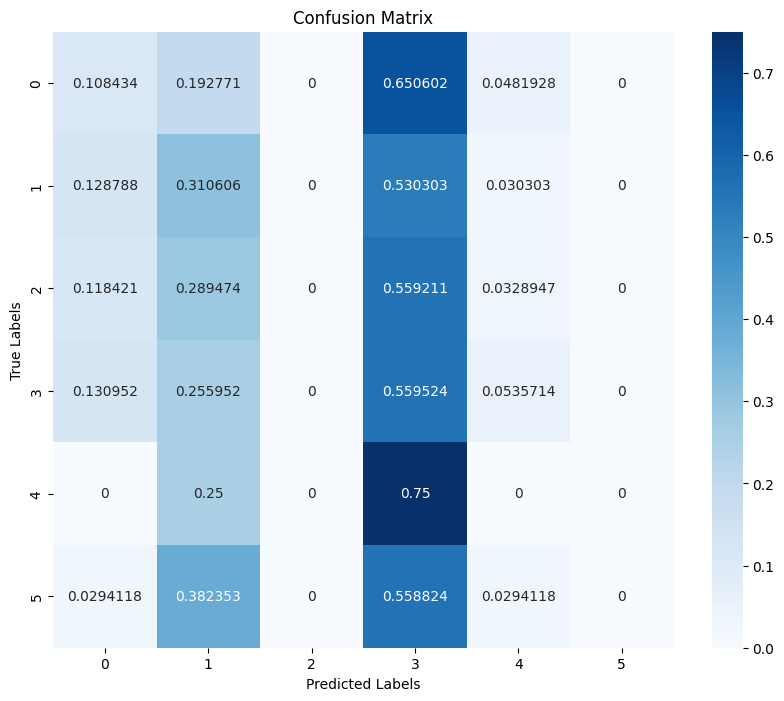

Epoch 17, Validation Loss: 1.6601, Accuracy: 0.2496, F1 Score: 0.1921
Val F1 Score Per Class  [0.12       0.28178694 0.         0.37903226 0.         0.        ]


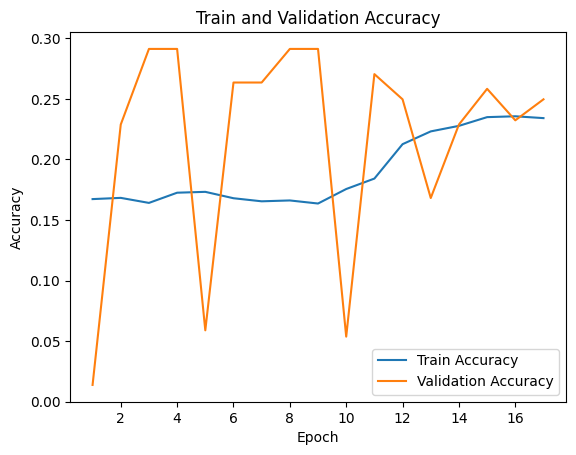

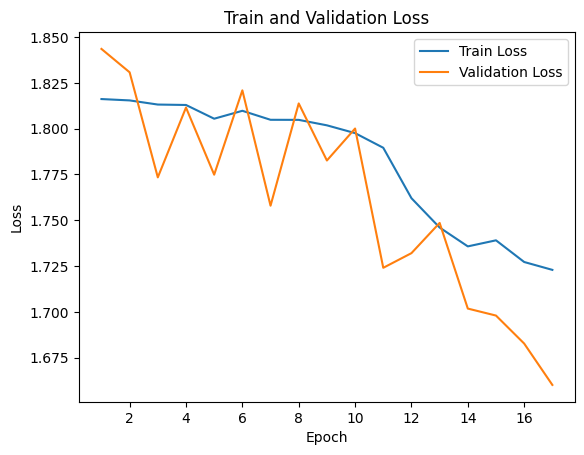

Epoch 18, Train Loss: 1.7155, Accuracy: 0.2396, F1 Score: 0.2092
Train F1 Score Per Class  [0.18246614 0.14464168 0.07996237 0.26189006 0.43541621 0.15241321]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.54it/s, loss=1.73]

[tensor([-0.3206, -0.0791, -0.3904, -0.2287, -1.1419, -0.4389], device='cuda:0'), tensor([-0.1189,  0.0402, -0.3121, -0.0861, -0.3500, -0.2736], device='cuda:0'), tensor([-0.0338,  0.0625,  0.0180,  0.0932, -0.5850, -0.0666], device='cuda:0'), tensor([-0.0785,  0.0519, -0.1498,  0.0139, -1.1344, -0.1478], device='cuda:0'), tensor([-0.2185, -0.0629, -0.1724, -0.1129, -2.6854, -0.2526], device='cuda:0'), tensor([ 0.0032,  0.0662, -0.1333, -0.0174, -1.3908, -0.0631], device='cuda:0'), tensor([-0.1510,  0.0249, -0.0570,  0.0252, -0.5830, -0.1616], device='cuda:0'), tensor([-0.2421, -0.0269, -0.2582, -0.1004,  0.5233, -0.3265], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:27,  2.54it/s, loss=1.78]

[tensor([-0.1823,  0.0149, -0.2275, -0.1215, -0.8814, -0.2713], device='cuda:0'), tensor([-0.1062, -0.0592, -0.1565, -0.0692, -0.9335, -0.1549], device='cuda:0'), tensor([ 0.1961, -0.0031,  0.2328,  0.2264, -1.9744,  0.2766], device='cuda:0'), tensor([-0.0332,  0.0588,  0.0126,  0.0803, -0.8119, -0.0835], device='cuda:0'), tensor([ 0.1772,  0.0170,  0.1807,  0.1568, -1.7048,  0.2285], device='cuda:0'), tensor([-0.2161,  0.0328, -0.2375, -0.0778, -0.3267, -0.3330], device='cuda:0'), tensor([ 0.1839,  0.1162,  0.1335,  0.2332, -2.4532,  0.1596], device='cuda:0'), tensor([ 0.0911,  0.0397,  0.1746,  0.1527, -1.6451,  0.1141], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.46it/s, loss=1.68]

[tensor([-0.1284,  0.0202, -0.1880, -0.0462, -0.1463, -0.1462], device='cuda:0'), tensor([-0.0381,  0.0325,  0.0071,  0.0476, -1.1163, -0.0791], device='cuda:0'), tensor([-0.0231,  0.0703,  0.0900,  0.1455, -0.9049, -0.0207], device='cuda:0'), tensor([ 0.0276,  0.0824,  0.0871,  0.1540, -1.3269, -0.0118], device='cuda:0'), tensor([ 0.0103,  0.0575, -0.0353,  0.0623, -1.7177, -0.0133], device='cuda:0'), tensor([ 0.0803,  0.0876,  0.0794,  0.1983, -2.8267,  0.0784], device='cuda:0'), tensor([-0.1128, -0.0389, -0.1426, -0.0612, -1.5842, -0.1284], device='cuda:0'), tensor([-0.1104,  0.0803, -0.0508,  0.0762, -2.1060, -0.1732], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:27,  2.48it/s, loss=1.72]

[tensor([-0.1130,  0.0619, -0.0887,  0.0071, -0.5462, -0.1800], device='cuda:0'), tensor([-0.2393, -0.0026, -0.3144, -0.1475, -0.3607, -0.3535], device='cuda:0'), tensor([ 6.4867e-03,  6.1546e-04,  5.2053e-02,  5.6766e-02, -1.2125e+00,
         3.0154e-04], device='cuda:0'), tensor([-0.2031, -0.0358, -0.2250, -0.0975,  0.3624, -0.2565], device='cuda:0'), tensor([ 0.0024,  0.0834,  0.0698,  0.1450, -1.0021, -0.0263], device='cuda:0'), tensor([-0.0454, -0.0034, -0.0317,  0.0377, -1.1773, -0.0904], device='cuda:0'), tensor([ 0.1602,  0.0223,  0.1910,  0.1716, -1.4296,  0.1911], device='cuda:0'), tensor([-0.0095,  0.0990,  0.0723,  0.1141, -0.7405, -0.0377], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.45it/s, loss=1.71]

[tensor([-0.0378,  0.0814,  0.0065,  0.0941, -1.5217, -0.0652], device='cuda:0'), tensor([-0.1336,  0.0901, -0.1554,  0.0780, -0.4679, -0.2480], device='cuda:0'), tensor([ 0.0307,  0.0411,  0.1359,  0.1523, -1.1090,  0.0595], device='cuda:0'), tensor([-0.1417, -0.0564, -0.1465, -0.0756, -0.5858, -0.1662], device='cuda:0'), tensor([ 0.0760,  0.0935, -0.0208,  0.1198, -0.8201,  0.0177], device='cuda:0'), tensor([-0.1338,  0.0276, -0.2258, -0.0729, -0.9693, -0.2221], device='cuda:0'), tensor([-0.1412, -0.0104, -0.0884, -0.0383, -0.3006, -0.1807], device='cuda:0'), tensor([ 0.0744,  0.0309,  0.0755,  0.1198, -0.9212,  0.0679], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.47it/s, loss=1.91]

[tensor([-0.0912,  0.0150, -0.0818,  0.0259, -0.6519, -0.1526], device='cuda:0'), tensor([-0.0627, -0.0141, -0.0054,  0.0106, -0.2839, -0.0509], device='cuda:0'), tensor([ 0.0561,  0.0730,  0.1282,  0.2138, -1.6621,  0.0339], device='cuda:0'), tensor([-0.0905,  0.0664, -0.0706,  0.0707, -0.0037, -0.1819], device='cuda:0'), tensor([ 2.2391e-02, -2.9333e-02, -4.8028e-02,  7.3254e-03, -1.1025e+00,
        -5.9637e-04], device='cuda:0'), tensor([ 0.1360,  0.0887,  0.1479,  0.1031, -4.3166,  0.1217], device='cuda:0'), tensor([-0.0312,  0.0258, -0.1082, -0.0215, -1.4666, -0.0922], device='cuda:0'), tensor([-0.0990,  0.0483, -0.0986,  0.0270, -1.4469, -0.1626], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.48it/s, loss=1.68]

[tensor([-0.0526,  0.0588, -0.0221,  0.1231, -0.6803, -0.0956], device='cuda:0'), tensor([ 0.0438,  0.0789,  0.1291,  0.1667, -1.0755,  0.0324], device='cuda:0'), tensor([ 0.0181,  0.0790,  0.0450,  0.0844, -0.5386,  0.0206], device='cuda:0'), tensor([-0.0612,  0.0467, -0.1375,  0.0041, -0.4237, -0.1157], device='cuda:0'), tensor([ 0.0271, -0.0220, -0.2899, -0.1424, -0.4859, -0.0932], device='cuda:0'), tensor([ 0.0049,  0.1034,  0.1050,  0.1831, -4.2623, -0.0145], device='cuda:0'), tensor([-0.0221,  0.0279,  0.0405,  0.0947, -2.4476, -0.0111], device='cuda:0'), tensor([-0.0542,  0.1161, -0.0059,  0.1220, -0.5939, -0.1247], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.45it/s, loss=1.76]

[tensor([-0.0842,  0.0768, -0.1540,  0.0193, -0.1706, -0.1925], device='cuda:0'), tensor([-0.0584,  0.0521, -0.0048,  0.0974, -1.1474, -0.0863], device='cuda:0'), tensor([-0.2799, -0.0198, -0.2621, -0.1169,  0.0945, -0.3590], device='cuda:0'), tensor([-0.0402,  0.0502, -0.0687,  0.0353, -0.9969, -0.1092], device='cuda:0'), tensor([-0.1274, -0.0259, -0.0961, -0.0366, -1.0875, -0.1565], device='cuda:0'), tensor([ 0.2951,  0.1334,  0.4314,  0.3699, -1.9158,  0.3794], device='cuda:0'), tensor([-0.3349, -0.0143, -0.3402, -0.1663, -0.1801, -0.4547], device='cuda:0'), tensor([ 0.2363,  0.0276,  0.2409,  0.2107, -2.3586,  0.3286], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.45it/s, loss=1.71]

[tensor([ 0.0477,  0.0888,  0.0912,  0.1469, -0.9169,  0.0023], device='cuda:0'), tensor([-0.0455,  0.0399,  0.0117,  0.0993, -0.9423, -0.0651], device='cuda:0'), tensor([-0.1221,  0.0696, -0.1056,  0.0034, -0.8202, -0.2237], device='cuda:0'), tensor([-1.7593e-01, -1.3086e-03, -1.0407e-01, -2.3959e-02, -1.8371e+00,
        -2.1360e-01], device='cuda:0'), tensor([-0.2110, -0.0026, -0.2030, -0.0816, -1.7955, -0.2976], device='cuda:0'), tensor([-0.2846,  0.0212, -0.2899, -0.1156,  0.1921, -0.4270], device='cuda:0'), tensor([-0.1304, -0.1785, -0.6130, -0.3945, -1.0060, -0.2471], device='cuda:0'), tensor([ 0.0035,  0.0266, -0.0106,  0.0508, -1.8618,  0.0042], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.45it/s, loss=1.71]

[tensor([ 0.0845,  0.0832,  0.1262,  0.1423, -1.0870,  0.0904], device='cuda:0'), tensor([ 0.2184,  0.0652,  0.2113,  0.1892, -1.9399,  0.2503], device='cuda:0'), tensor([ 0.1286,  0.0172,  0.0198,  0.0206, -3.9712,  0.1380], device='cuda:0'), tensor([-0.0840,  0.0276, -0.0546,  0.0496, -1.1526, -0.1195], device='cuda:0'), tensor([-0.2089,  0.0141, -0.1537, -0.0665, -0.7505, -0.2684], device='cuda:0'), tensor([-0.3363, -0.0082, -0.3047, -0.1376, -0.0899, -0.4374], device='cuda:0'), tensor([ 0.0458,  0.0070, -0.0098,  0.0572, -1.8610,  0.0171], device='cuda:0'), tensor([-0.1091,  0.0335, -0.0645,  0.0291, -0.4909, -0.1550], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.45it/s, loss=1.79]

[tensor([ 4.3250e-02,  8.8665e-02,  1.0526e-01,  1.8882e-01, -2.0297e+00,
         5.7395e-04], device='cuda:0'), tensor([-0.0461,  0.0567,  0.0396,  0.1448, -0.9645, -0.0669], device='cuda:0'), tensor([-0.0661, -0.0547, -0.0671, -0.0282, -0.9122, -0.0804], device='cuda:0'), tensor([-0.0403,  0.0510, -0.0793,  0.0163, -0.5103, -0.1136], device='cuda:0'), tensor([-0.0917, -0.0207, -0.3080, -0.1385, -0.7834, -0.2002], device='cuda:0'), tensor([-0.2256,  0.0162, -0.2224, -0.0371, -0.7718, -0.3016], device='cuda:0'), tensor([-0.1574, -0.0109, -0.1535, -0.0554, -0.3417, -0.2300], device='cuda:0'), tensor([-0.0546,  0.0954, -0.0131,  0.0910, -0.6694, -0.1062], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.46it/s, loss=1.68]

[tensor([-0.1997,  0.0028, -0.3221, -0.1804, -0.7455, -0.3550], device='cuda:0'), tensor([-0.1671,  0.0448, -0.1622, -0.0534, -0.2309, -0.2219], device='cuda:0'), tensor([-0.2850,  0.0096, -0.2673, -0.1034, -0.8254, -0.3701], device='cuda:0'), tensor([-0.0417,  0.0877, -0.0059,  0.1064, -1.4627, -0.1062], device='cuda:0'), tensor([ 0.0413,  0.0126, -0.0059,  0.0416, -2.7354,  0.0309], device='cuda:0'), tensor([-6.5724e-02,  3.5674e-02,  8.5516e-04,  4.5796e-02, -1.1173e+00,
        -7.0436e-02], device='cuda:0'), tensor([-0.1869, -0.0123, -0.1713, -0.0223, -0.5838, -0.2539], device='cuda:0'), tensor([-0.1615, -0.0664, -0.2148, -0.1080,  0.0244, -0.2058], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.41it/s, loss=1.67]

[tensor([-0.0589,  0.0634, -0.0193,  0.0658, -0.6058, -0.1087], device='cuda:0'), tensor([-0.1126,  0.0377, -0.0913,  0.0212, -0.6455, -0.1802], device='cuda:0'), tensor([ 0.0444, -0.0400, -0.0023,  0.0488, -1.1544,  0.0074], device='cuda:0'), tensor([-0.0973,  0.0789, -0.0346,  0.0720, -0.4350, -0.1412], device='cuda:0'), tensor([-0.1715, -0.0181, -0.1000, -0.0012, -0.4121, -0.1884], device='cuda:0'), tensor([ 0.0429,  0.0985,  0.1110,  0.1715, -0.8641,  0.0153], device='cuda:0'), tensor([ 0.0693,  0.0863,  0.1220,  0.1455, -1.7746,  0.0796], device='cuda:0'), tensor([ 0.1421,  0.0943,  0.1148,  0.1667, -1.1743,  0.1041], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.41it/s, loss=1.69]

[tensor([-0.1376,  0.0089, -0.1858, -0.1110, -0.7270, -0.2356], device='cuda:0'), tensor([-0.1237, -0.0579, -0.1739, -0.0950, -1.5686, -0.2019], device='cuda:0'), tensor([-0.0515,  0.1180, -0.0038,  0.1350, -0.8821, -0.1258], device='cuda:0'), tensor([ 0.2488,  0.0759,  0.2572,  0.2084, -2.9941,  0.2868], device='cuda:0'), tensor([ 0.1806,  0.0532,  0.2103,  0.1887, -2.0134,  0.2329], device='cuda:0'), tensor([ 0.0494,  0.0664,  0.0464,  0.1275, -3.6802,  0.0209], device='cuda:0'), tensor([-0.2918, -0.0596, -0.3235, -0.1717,  0.1986, -0.3748], device='cuda:0'), tensor([-0.0653,  0.0894, -0.0219,  0.0637, -1.3302, -0.1137], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.41it/s, loss=1.69]

[tensor([-0.0871,  0.0636, -0.0199,  0.0816, -1.0046, -0.1321], device='cuda:0'), tensor([-0.1529,  0.0047, -0.1354, -0.0482, -0.2507, -0.1931], device='cuda:0'), tensor([-0.0161,  0.1193,  0.0651,  0.1343, -0.6939, -0.0502], device='cuda:0'), tensor([-0.1027,  0.0611, -0.0394,  0.0568, -0.4245, -0.1626], device='cuda:0'), tensor([-0.0535, -0.0184, -0.0306,  0.0279, -1.8748, -0.0839], device='cuda:0'), tensor([ 0.0900,  0.0805,  0.0568,  0.1202, -2.4206,  0.0504], device='cuda:0'), tensor([ 0.0019,  0.0733,  0.0832,  0.1545, -1.4430, -0.0146], device='cuda:0'), tensor([-0.1265,  0.0282, -0.0892,  0.0418,  0.0181, -0.2030], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.41it/s, loss=1.67]

[tensor([-0.0213,  0.1177, -0.0156,  0.1591, -0.6647, -0.1029], device='cuda:0'), tensor([-0.2143, -0.0383, -0.1362, -0.0694, -0.2347, -0.2424], device='cuda:0'), tensor([ 0.0442,  0.0368,  0.0940,  0.1259, -1.0331,  0.0298], device='cuda:0'), tensor([-0.0829,  0.0536, -0.0377,  0.0594, -0.6043, -0.1400], device='cuda:0'), tensor([-3.3694e-04,  9.1470e-02,  6.1200e-02,  1.4158e-01, -1.3044e+00,
        -4.6479e-02], device='cuda:0'), tensor([-0.2419, -0.0479, -0.1651, -0.1192, -0.5575, -0.2816], device='cuda:0'), tensor([-0.1751,  0.0407, -0.0946,  0.0015, -0.9211, -0.2233], device='cuda:0'), tensor([-0.0742,  0.0525, -0.0016,  0.0779, -0.7781, -0.1098], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:23,  2.43it/s, loss=1.69]

[tensor([-0.0763,  0.0427,  0.0230,  0.0790, -0.4877, -0.0807], device='cuda:0'), tensor([-0.0107,  0.0985,  0.0427,  0.1165, -1.5092, -0.0491], device='cuda:0'), tensor([ 0.0239,  0.0740,  0.0601,  0.1514, -0.5753, -0.0348], device='cuda:0'), tensor([-0.1490,  0.0271, -0.3455, -0.1374, -1.9674, -0.3307], device='cuda:0'), tensor([ 0.1348, -0.0095,  0.1004,  0.0445, -3.4655,  0.1641], device='cuda:0'), tensor([ 1.5641e-04, -3.0357e-02,  9.0415e-03,  8.1800e-03, -1.4523e+00,
         3.9983e-03], device='cuda:0'), tensor([ 0.0752,  0.0270,  0.1023,  0.0983, -1.1348,  0.0774], device='cuda:0'), tensor([ 0.0124,  0.0852,  0.0637,  0.1344, -0.5964, -0.0120], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.44it/s, loss=1.67]

[tensor([-0.2128, -0.0038, -0.2737, -0.1330, -0.6394, -0.3044], device='cuda:0'), tensor([ 0.0164,  0.0234,  0.0446,  0.0577, -0.8791, -0.0160], device='cuda:0'), tensor([-0.1042,  0.0239, -0.0482,  0.0480, -0.2866, -0.1466], device='cuda:0'), tensor([-0.1388,  0.0176, -0.2251, -0.0866, -1.0468, -0.2597], device='cuda:0'), tensor([ 0.0952,  0.0662,  0.1795,  0.1774, -2.3228,  0.1157], device='cuda:0'), tensor([-0.1243,  0.0044, -0.0602, -0.0282, -1.1462, -0.1579], device='cuda:0'), tensor([-0.1877,  0.0258, -0.1684, -0.0353, -0.5672, -0.2832], device='cuda:0'), tensor([-0.0035,  0.0783,  0.0357,  0.1243, -1.0813, -0.0264], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.45it/s, loss=1.71]

[tensor([ 0.3020,  0.0859,  0.3435,  0.2549, -2.1159,  0.3817], device='cuda:0'), tensor([-0.3028, -0.0382, -0.3180, -0.1509, -0.3610, -0.4214], device='cuda:0'), tensor([-0.0651,  0.0668,  0.0200,  0.1123, -0.7532, -0.0922], device='cuda:0'), tensor([-0.1479, -0.0365, -0.2282, -0.1058, -0.7387, -0.2095], device='cuda:0'), tensor([-8.4201e-02,  2.4659e-03,  6.2759e-04,  3.5711e-02, -7.9100e-01,
        -7.7852e-02], device='cuda:0'), tensor([ 0.1352,  0.0954,  0.1590,  0.1995, -1.9556,  0.1047], device='cuda:0'), tensor([-0.2748, -0.1195, -0.5564, -0.3237, -0.1986, -0.4478], device='cuda:0'), tensor([-0.1412,  0.0466, -0.1015,  0.0290, -1.7836, -0.1968], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.45it/s, loss=1.71]

[tensor([ 0.0587,  0.0882,  0.0853,  0.1791, -1.1111,  0.0422], device='cuda:0'), tensor([-0.0267,  0.0488,  0.0211,  0.0700, -2.0533, -0.0417], device='cuda:0'), tensor([-0.1443,  0.0191, -0.2412, -0.0785, -0.7327, -0.2404], device='cuda:0'), tensor([-0.1580,  0.0126, -0.0904, -0.0038, -0.3938, -0.1955], device='cuda:0'), tensor([-0.1950, -0.0032, -0.1650, -0.0716, -0.2384, -0.2607], device='cuda:0'), tensor([ 0.0177,  0.0589,  0.0522,  0.1077, -1.2465,  0.0018], device='cuda:0'), tensor([ 0.1046,  0.0579,  0.0450,  0.0990, -4.1667,  0.0969], device='cuda:0'), tensor([-0.2008,  0.0021, -0.1417, -0.0444, -0.4375, -0.2638], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.45it/s, loss=1.7]

[tensor([-0.1076,  0.0576, -0.0445,  0.0549, -0.6489, -0.1589], device='cuda:0'), tensor([-0.0396,  0.0704,  0.0257,  0.1147, -0.6738, -0.0688], device='cuda:0'), tensor([-0.1938,  0.0021, -0.1998, -0.0557, -0.5302, -0.2870], device='cuda:0'), tensor([ 0.0375,  0.0936,  0.0739,  0.1059, -1.2128,  0.0244], device='cuda:0'), tensor([ 0.0200,  0.0808,  0.0882,  0.1485, -0.8799,  0.0161], device='cuda:0'), tensor([-0.2445, -0.1070, -0.2911, -0.1975,  0.1706, -0.3145], device='cuda:0'), tensor([-5.0579e-02,  1.3883e-01, -7.4550e-04,  1.2848e-01, -1.1381e+00,
        -1.5424e-01], device='cuda:0'), tensor([-0.0771,  0.1101,  0.0236,  0.1061, -0.8830, -0.1327], device='cuda:0')]


Val:  30%|███       | 22/73 [00:08<00:20,  2.47it/s, loss=1.68]

[tensor([-0.1875,  0.0342, -0.1084, -0.0148, -0.8664, -0.2372], device='cuda:0'), tensor([-0.0350,  0.0812,  0.0488,  0.1379, -0.9981, -0.0532], device='cuda:0'), tensor([-0.1097, -0.0151, -0.1505, -0.0469, -1.0069, -0.1714], device='cuda:0'), tensor([-0.0529,  0.0810,  0.0237,  0.1232, -0.3809, -0.0958], device='cuda:0'), tensor([-0.2533, -0.0251, -0.2402, -0.1061, -0.2618, -0.3557], device='cuda:0'), tensor([-4.9055e-02,  2.5031e-02, -1.8308e-03,  3.0089e-02, -2.9738e+00,
        -4.7642e-02], device='cuda:0'), tensor([ 0.0335,  0.0740,  0.1386,  0.1939, -0.7220,  0.0172], device='cuda:0'), tensor([ 0.1302,  0.0933,  0.2190,  0.2646, -1.2686,  0.1570], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.45it/s, loss=1.68]

[tensor([-0.0911,  0.0619, -0.0241,  0.0206, -1.4855, -0.1183], device='cuda:0'), tensor([-0.1844, -0.0015, -0.2445, -0.1322, -1.1601, -0.2897], device='cuda:0'), tensor([ 1.8524e-02,  9.3816e-02,  2.6922e-02,  9.8844e-02, -1.3084e+00,
        -6.1517e-04], device='cuda:0'), tensor([-0.2607,  0.0099, -0.2276, -0.0563, -0.6595, -0.3470], device='cuda:0'), tensor([ 0.0171, -0.0578, -0.0468, -0.0515, -3.4431,  0.0215], device='cuda:0'), tensor([-0.3516, -0.0387, -0.3745, -0.1991, -0.3795, -0.5049], device='cuda:0'), tensor([-0.2404,  0.0458, -0.2640, -0.0883,  0.1032, -0.3923], device='cuda:0'), tensor([-0.2278, -0.0243, -0.1230, -0.0399, -1.2813, -0.2292], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.46it/s, loss=1.7]

[tensor([-0.2646, -0.0253, -0.2586, -0.0823, -1.2259, -0.3470], device='cuda:0'), tensor([ 0.0914,  0.0205,  0.1891,  0.1502, -0.9769,  0.1147], device='cuda:0'), tensor([ 0.0367,  0.1044,  0.1322,  0.1951, -0.9255,  0.0307], device='cuda:0'), tensor([-0.0843,  0.0211, -0.0984, -0.0062, -0.9519, -0.1399], device='cuda:0'), tensor([-0.3162, -0.0787, -0.2829, -0.2042, -1.9866, -0.3966], device='cuda:0'), tensor([-0.0774,  0.0739, -0.0122,  0.1027, -0.4761, -0.1296], device='cuda:0'), tensor([-0.1106,  0.0170, -0.0869,  0.0442, -0.5940, -0.1810], device='cuda:0'), tensor([ 0.2000,  0.0682,  0.3135,  0.2453, -2.0175,  0.2850], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.46it/s, loss=1.77]

[tensor([-0.1651,  0.0353, -0.2141, -0.0789, -0.7011, -0.2561], device='cuda:0'), tensor([-0.4241, -0.1214, -0.6037, -0.3897,  0.2102, -0.5971], device='cuda:0'), tensor([-0.1507, -0.0018, -0.1619, -0.0493, -0.7452, -0.2144], device='cuda:0'), tensor([-0.1588,  0.0301, -0.0938,  0.0188, -0.5816, -0.2173], device='cuda:0'), tensor([-0.1727,  0.0384, -0.1267, -0.0029, -0.1948, -0.2728], device='cuda:0'), tensor([-0.2116,  0.0117, -0.1769, -0.0606, -0.2717, -0.2853], device='cuda:0'), tensor([-0.0836,  0.0661, -0.0491,  0.0704, -0.7065, -0.1546], device='cuda:0'), tensor([-0.2696, -0.0402, -0.1793, -0.0941, -1.6960, -0.2943], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.46it/s, loss=1.7]

[tensor([-0.0943,  0.0196, -0.1227, -0.0216, -0.3344, -0.1488], device='cuda:0'), tensor([-0.1617,  0.0214, -0.1089, -0.0127, -0.2644, -0.2262], device='cuda:0'), tensor([ 0.8712,  0.2354,  0.7235,  0.5565, -4.0756,  0.9907], device='cuda:0'), tensor([ 0.0139,  0.0693,  0.1008,  0.1443, -1.2542,  0.0035], device='cuda:0'), tensor([-1.0623e-01,  2.4009e-03, -6.4768e-02, -1.4160e-05, -6.5299e-01,
        -1.3014e-01], device='cuda:0'), tensor([-4.8675e-04,  5.4710e-02,  9.5280e-02,  1.4857e-01, -7.6948e-01,
         1.5364e-02], device='cuda:0'), tensor([ 0.0416,  0.0870,  0.0744,  0.1544, -1.8854,  0.0449], device='cuda:0'), tensor([-1.5162e-01,  1.9725e-04, -1.0161e-01, -3.3200e-02, -9.1432e-01,
        -1.7604e-01], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:18,  2.47it/s, loss=1.68]

[tensor([ 0.1116,  0.0485,  0.2025,  0.2030, -1.2278,  0.1566], device='cuda:0'), tensor([-0.0583,  0.0036, -0.0277,  0.0152, -0.9172, -0.0957], device='cuda:0'), tensor([-0.2224,  0.0076, -0.2154, -0.1204, -0.6577, -0.3194], device='cuda:0'), tensor([ 0.0151,  0.1140,  0.0438,  0.1761, -0.4994, -0.0570], device='cuda:0'), tensor([-0.0354,  0.0986,  0.0390,  0.1072, -0.7938, -0.0680], device='cuda:0'), tensor([-0.3130, -0.0504, -0.3565, -0.1770, -1.2986, -0.4051], device='cuda:0'), tensor([ 0.0198,  0.0656,  0.0900,  0.1488, -0.5402, -0.0057], device='cuda:0'), tensor([-0.1158, -0.0069, -0.0982, -0.0229, -1.4287, -0.1380], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.46it/s, loss=1.66]

[tensor([-0.0652,  0.0125, -0.1900, -0.0656, -0.2194, -0.1687], device='cuda:0'), tensor([ 0.0970,  0.0739,  0.2153,  0.1970, -2.0510,  0.1180], device='cuda:0'), tensor([-0.2754, -0.0920, -0.3446, -0.1963, -3.5466, -0.3780], device='cuda:0'), tensor([-0.1853,  0.0361, -0.1492, -0.0563, -0.3576, -0.2626], device='cuda:0'), tensor([-0.1752,  0.0447, -0.1665, -0.0191, -0.6435, -0.2592], device='cuda:0'), tensor([-0.1496, -0.0076, -0.1466, -0.0373, -1.6697, -0.2304], device='cuda:0'), tensor([-0.0147,  0.0580, -0.0769,  0.0090, -2.3163, -0.0919], device='cuda:0'), tensor([ 0.0191,  0.0634,  0.0254,  0.1122, -0.7903, -0.0227], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.46it/s, loss=1.64]

[tensor([ 0.0622,  0.0609,  0.1638,  0.1712, -1.8583,  0.1074], device='cuda:0'), tensor([-0.2285, -0.0356, -0.2688, -0.1330, -1.3439, -0.3329], device='cuda:0'), tensor([-0.1115,  0.0695, -0.0340,  0.0613, -0.3141, -0.1474], device='cuda:0'), tensor([-0.0376,  0.0545,  0.0146,  0.1010, -1.4173, -0.0679], device='cuda:0'), tensor([-0.2440,  0.0131, -0.2242, -0.0779, -0.2533, -0.3370], device='cuda:0'), tensor([-0.0467,  0.1037,  0.0312,  0.1453, -0.6640, -0.0672], device='cuda:0'), tensor([-0.1852,  0.0041, -0.1518, -0.0213, -0.7474, -0.2517], device='cuda:0'), tensor([-0.0028,  0.0751,  0.0386,  0.1469, -0.4424, -0.0507], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.47it/s, loss=1.67]

[tensor([-0.1523, -0.0036, -0.1467, -0.0203, -0.7652, -0.2050], device='cuda:0'), tensor([-0.0763,  0.0949, -0.0535,  0.0583, -0.9223, -0.1359], device='cuda:0'), tensor([-0.2119, -0.0104, -0.2154, -0.0810, -0.5094, -0.2973], device='cuda:0'), tensor([ 0.0070,  0.0457,  0.0851,  0.1110, -0.9550,  0.0281], device='cuda:0'), tensor([-0.2031, -0.0081, -0.1520, -0.0503, -1.6701, -0.2522], device='cuda:0'), tensor([-0.1271,  0.0391, -0.0630,  0.0487, -0.2392, -0.1929], device='cuda:0'), tensor([-0.1153,  0.0175, -0.0928,  0.0215, -0.9029, -0.1888], device='cuda:0'), tensor([-0.2880, -0.0526, -0.2949, -0.1409,  0.2831, -0.4084], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.46it/s, loss=1.66]

[tensor([ 0.4421,  0.1033,  0.3864,  0.2925, -2.3233,  0.5231], device='cuda:0'), tensor([-0.1119, -0.0042, -0.0680, -0.0154, -0.4897, -0.1162], device='cuda:0'), tensor([-0.1372,  0.0366, -0.0801,  0.0252, -1.3588, -0.2052], device='cuda:0'), tensor([-0.0330,  0.0976, -0.0364,  0.0846, -0.5525, -0.0776], device='cuda:0'), tensor([-0.0210,  0.0621,  0.0292,  0.1298, -1.1167, -0.0752], device='cuda:0'), tensor([-0.1819,  0.0120, -0.1629, -0.0526, -0.2882, -0.2479], device='cuda:0'), tensor([ 0.6396,  0.0485,  0.0987,  0.1185, -4.2926,  0.6940], device='cuda:0'), tensor([ 0.1143,  0.0685,  0.2101,  0.2124, -1.5576,  0.1611], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.46it/s, loss=1.67]

[tensor([-0.0484,  0.0745, -0.0431,  0.0500, -1.0347, -0.1179], device='cuda:0'), tensor([-0.1308,  0.0224, -0.0729,  0.0324, -0.3858, -0.1953], device='cuda:0'), tensor([ 0.0673, -0.0145,  0.0143,  0.0205, -1.1447,  0.0596], device='cuda:0'), tensor([-0.1482, -0.0148, -0.1472, -0.0312, -0.6223, -0.2056], device='cuda:0'), tensor([-0.0646, -0.0562, -0.0800, -0.0196, -0.6849, -0.0645], device='cuda:0'), tensor([-0.0642,  0.0790,  0.0391,  0.0830, -2.3431, -0.0869], device='cuda:0'), tensor([ 0.0127,  0.0386,  0.0116,  0.1106, -1.2506, -0.0153], device='cuda:0'), tensor([-0.0137,  0.0878,  0.0763,  0.1408, -0.8262, -0.0172], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.46it/s, loss=1.65]

[tensor([-0.0359,  0.0717,  0.0457,  0.1038, -0.6608, -0.0568], device='cuda:0'), tensor([-0.0845, -0.0105, -0.0868,  0.0079, -0.8582, -0.1323], device='cuda:0'), tensor([-0.1742,  0.1046, -0.1569,  0.0109, -0.6245, -0.3013], device='cuda:0'), tensor([-0.0448,  0.0647,  0.0069,  0.0874, -0.7996, -0.1187], device='cuda:0'), tensor([ 0.0101,  0.0619,  0.0589,  0.0952, -2.0406, -0.0106], device='cuda:0'), tensor([ 0.1534,  0.0090, -0.0557,  0.0075, -2.3319,  0.1044], device='cuda:0'), tensor([-0.0602,  0.0580,  0.0617,  0.0955, -0.9239, -0.0625], device='cuda:0'), tensor([-7.2677e-02,  7.7893e-02, -1.6611e-04,  8.2843e-02, -5.7183e-01,
        -1.2945e-01], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.46it/s, loss=1.67]

[tensor([ 0.2658,  0.0517,  0.2591,  0.2024, -2.0009,  0.3221], device='cuda:0'), tensor([ 0.2319,  0.0902,  0.1477,  0.1712, -1.5535,  0.2295], device='cuda:0'), tensor([-0.3362, -0.0311, -0.3236, -0.1602, -0.6826, -0.4532], device='cuda:0'), tensor([ 0.0864,  0.0180,  0.1622,  0.1217, -1.0276,  0.0844], device='cuda:0'), tensor([-0.1910, -0.0502, -0.3352, -0.1771, -0.4631, -0.3140], device='cuda:0'), tensor([ 0.0400,  0.1002,  0.0408,  0.1539, -0.8734,  0.0040], device='cuda:0'), tensor([-0.2219,  0.0096, -0.1849, -0.0703, -0.1722, -0.3110], device='cuda:0'), tensor([-0.0142,  0.0044,  0.0788,  0.0947, -0.5142,  0.0060], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.46it/s, loss=1.67]

[tensor([ 0.2304,  0.0387,  0.1783,  0.1675, -3.1495,  0.2782], device='cuda:0'), tensor([ 0.0109,  0.1007,  0.0566,  0.1518, -0.6324, -0.0487], device='cuda:0'), tensor([-0.1464, -0.0962, -0.2615, -0.1961, -2.1622, -0.2058], device='cuda:0'), tensor([ 0.0378,  0.0622,  0.0789,  0.1331, -1.0635,  0.0222], device='cuda:0'), tensor([-0.0731,  0.0742, -0.0069,  0.0823, -0.4602, -0.1223], device='cuda:0'), tensor([ 0.0474,  0.0762,  0.0846,  0.1637, -0.8765,  0.0442], device='cuda:0'), tensor([ 0.1061,  0.0098, -0.0660,  0.0411, -1.9458,  0.0295], device='cuda:0'), tensor([-0.0210,  0.0230,  0.0441,  0.1279, -0.5705, -0.0694], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.46it/s, loss=1.63]

[tensor([-0.0407,  0.0187, -0.1280, -0.0349, -1.4452, -0.1259], device='cuda:0'), tensor([-0.1945,  0.0306, -0.1646, -0.0172, -0.6689, -0.2774], device='cuda:0'), tensor([ 0.1883,  0.1594,  0.1533,  0.3127, -1.7055,  0.1434], device='cuda:0'), tensor([-6.4018e-02, -7.0077e-04, -4.1661e-03,  7.7398e-02, -1.1003e+00,
        -1.1142e-01], device='cuda:0'), tensor([ 0.0081,  0.0687,  0.0391,  0.1227, -2.0232, -0.0031], device='cuda:0'), tensor([-0.2866, -0.1516, -0.6753, -0.4561, -2.8919, -0.5000], device='cuda:0'), tensor([ 0.1113,  0.1271,  0.1481,  0.2137, -1.1289,  0.1145], device='cuda:0'), tensor([-0.0812,  0.0290, -0.0121,  0.0654, -0.4521, -0.0775], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.47it/s, loss=1.75]

[tensor([-0.0678,  0.0246, -0.0916,  0.0054, -0.4873, -0.1285], device='cuda:0'), tensor([-0.0901,  0.0946, -0.0374,  0.0729, -0.4524, -0.1543], device='cuda:0'), tensor([-0.0769,  0.0325, -0.0348,  0.0846, -1.0823, -0.1007], device='cuda:0'), tensor([ 3.9529e-02,  1.0362e-01,  6.1171e-02,  1.5373e-01, -1.5998e+00,
        -1.3977e-04], device='cuda:0'), tensor([-0.2001,  0.0554, -0.1659, -0.0083, -0.3158, -0.2825], device='cuda:0'), tensor([-0.0223,  0.0414,  0.0212,  0.0895, -0.8454, -0.0397], device='cuda:0'), tensor([-0.0891,  0.0421, -0.0181,  0.0851, -0.7907, -0.1150], device='cuda:0'), tensor([-0.1083,  0.0803, -0.0204,  0.0623, -1.4361, -0.1569], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.46it/s, loss=1.62]

[tensor([-0.0508, -0.0325, -0.2070, -0.1214, -0.7138, -0.1337], device='cuda:0'), tensor([-0.1948, -0.0070, -0.1585, -0.0270, -1.4199, -0.2427], device='cuda:0'), tensor([-0.0467,  0.0445, -0.0717, -0.0067, -0.3914, -0.0925], device='cuda:0'), tensor([ 0.2074,  0.0507,  0.1126,  0.1142, -2.8234,  0.2083], device='cuda:0'), tensor([-0.1216, -0.0247, -0.0112,  0.0264, -3.1833, -0.0971], device='cuda:0'), tensor([-0.1806,  0.0359, -0.1486, -0.0032, -0.2174, -0.2648], device='cuda:0'), tensor([-0.0669,  0.0077, -0.0921,  0.0487, -1.0859, -0.1233], device='cuda:0'), tensor([-0.0073,  0.0654, -0.0581,  0.0352, -1.2425, -0.0769], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.47it/s, loss=1.65]

[tensor([-0.2082, -0.0236, -0.1692, -0.0619, -0.6445, -0.2504], device='cuda:0'), tensor([ 0.2217,  0.0652,  0.1120,  0.1770, -2.3117,  0.1892], device='cuda:0'), tensor([ 0.0340,  0.0686,  0.0367,  0.1002, -0.9195,  0.0382], device='cuda:0'), tensor([-0.0717, -0.0330, -0.0914, -0.0276, -0.7622, -0.0911], device='cuda:0'), tensor([-0.0387, -0.0544,  0.0664,  0.0642, -2.9590,  0.0210], device='cuda:0'), tensor([-0.0816,  0.0427, -0.0068,  0.0679, -0.6060, -0.1320], device='cuda:0'), tensor([-0.1343,  0.0633, -0.0640,  0.0417, -1.0189, -0.2101], device='cuda:0'), tensor([-0.1129,  0.0606, -0.0444,  0.0579, -0.7611, -0.1773], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.46it/s, loss=1.66]

[tensor([-0.0214,  0.0845, -0.0291,  0.0826, -1.0976, -0.0857], device='cuda:0'), tensor([-0.1189,  0.0402, -0.1042,  0.0229, -0.9113, -0.1727], device='cuda:0'), tensor([-0.0634,  0.0038,  0.0424,  0.0588, -1.9341, -0.0327], device='cuda:0'), tensor([-0.0355,  0.0634,  0.0318,  0.0838, -2.0067, -0.0722], device='cuda:0'), tensor([-0.0370,  0.0871,  0.0148,  0.1173, -0.8153, -0.0269], device='cuda:0'), tensor([ 0.0490,  0.0094,  0.1144,  0.1288, -2.7322,  0.0643], device='cuda:0'), tensor([-0.0197, -0.0069, -0.0255,  0.0434, -0.4443, -0.0324], device='cuda:0'), tensor([-0.0539, -0.0193, -0.0213,  0.0300, -1.3824, -0.0701], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:12,  2.46it/s, loss=1.67]

[tensor([-0.2658, -0.0974, -0.2259, -0.1606, -2.3814, -0.3041], device='cuda:0'), tensor([-0.3876, -0.0473, -0.3540, -0.1953,  0.4821, -0.5091], device='cuda:0'), tensor([-0.1457,  0.0367, -0.0661,  0.0160, -1.1107, -0.1929], device='cuda:0'), tensor([-0.2297,  0.0281, -0.1916, -0.0415, -1.7977, -0.3215], device='cuda:0'), tensor([ 0.0047,  0.0813,  0.0347,  0.1471, -1.1098, -0.0497], device='cuda:0'), tensor([-0.0293,  0.0820,  0.0897,  0.1236, -1.3161, -0.0260], device='cuda:0'), tensor([-0.1189, -0.0171, -0.1275, -0.0730, -0.4425, -0.1953], device='cuda:0'), tensor([-0.1649, -0.0037, -0.3108, -0.1737, -0.3011, -0.2755], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.46it/s, loss=1.72]

[tensor([-0.1528,  0.0084, -0.4827, -0.2364, -0.9881, -0.4101], device='cuda:0'), tensor([-0.1631,  0.0212, -0.0782,  0.0164, -0.6080, -0.2185], device='cuda:0'), tensor([ 0.1301,  0.0903,  0.1263,  0.1435, -3.0215,  0.1048], device='cuda:0'), tensor([-0.2066,  0.0296, -0.1989, -0.0772, -0.8277, -0.3090], device='cuda:0'), tensor([ 0.0648,  0.0323,  0.0977,  0.1933, -1.4871,  0.0365], device='cuda:0'), tensor([ 0.0464,  0.0929,  0.1097,  0.1556, -2.8026,  0.0243], device='cuda:0'), tensor([-0.1906,  0.0043, -0.1587, -0.0418, -0.0714, -0.2417], device='cuda:0'), tensor([-0.2691, -0.0339, -0.2022, -0.0951,  0.0537, -0.3333], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.46it/s, loss=1.78]

[tensor([-0.3472, -0.0222, -0.3944, -0.1662,  0.2747, -0.4784], device='cuda:0'), tensor([-0.4240, -0.1529, -0.7441, -0.4793, -0.2836, -0.6680], device='cuda:0'), tensor([-0.1098,  0.0290, -0.0705,  0.0257, -0.1326, -0.1655], device='cuda:0'), tensor([-0.1078,  0.0489, -0.0648,  0.0747, -0.6260, -0.1709], device='cuda:0'), tensor([-0.2170,  0.0373, -0.2030, -0.0569, -0.3917, -0.3300], device='cuda:0'), tensor([-0.2798, -0.1040, -0.3780, -0.2806, -1.1586, -0.4018], device='cuda:0'), tensor([-0.3470, -0.0876, -0.4312, -0.2729, -0.6945, -0.4760], device='cuda:0'), tensor([-0.2017,  0.0263, -0.2037, -0.1089, -0.5733, -0.2805], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:17<00:11,  2.46it/s, loss=1.66]

[tensor([ 0.1219, -0.0737,  0.0546,  0.0446, -2.6233,  0.1660], device='cuda:0'), tensor([ 0.0583,  0.0862,  0.1014,  0.1780, -0.9241,  0.0343], device='cuda:0'), tensor([-0.0165,  0.0098, -0.0405,  0.0235, -0.9422, -0.0382], device='cuda:0'), tensor([-0.0526,  0.0400, -0.0603,  0.0308, -0.4682, -0.1047], device='cuda:0'), tensor([-0.2101,  0.0531, -0.1765, -0.0190, -0.9082, -0.3116], device='cuda:0'), tensor([-0.0399,  0.0483,  0.0156,  0.0887, -0.8834, -0.0862], device='cuda:0'), tensor([-0.1045,  0.0323, -0.1669, -0.0335, -0.2549, -0.1932], device='cuda:0'), tensor([-0.0898, -0.0080, -0.0497,  0.0218, -0.0322, -0.1081], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.46it/s, loss=1.68]

[tensor([-0.0539,  0.0711,  0.0096,  0.1288, -1.0158, -0.0946], device='cuda:0'), tensor([-0.0108,  0.1028,  0.0137,  0.1340, -1.3500, -0.0593], device='cuda:0'), tensor([-0.0647,  0.0579, -0.0449,  0.0501, -1.3948, -0.0725], device='cuda:0'), tensor([-0.1144,  0.0120, -0.1028, -0.0074, -0.9735, -0.1688], device='cuda:0'), tensor([-0.1713,  0.0372, -0.1654, -0.0434, -0.0757, -0.2695], device='cuda:0'), tensor([-0.0804, -0.0248,  0.0036,  0.0344, -1.3684, -0.0459], device='cuda:0'), tensor([-0.0165,  0.0870,  0.0219,  0.1616, -0.6987, -0.0747], device='cuda:0'), tensor([-0.0880, -0.0074,  0.0055,  0.0515, -0.4616, -0.0970], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:10,  2.46it/s, loss=1.62]

[tensor([-0.2631,  0.0297, -0.2848, -0.1191, -0.7686, -0.4011], device='cuda:0'), tensor([-0.1282,  0.0188, -0.1427, -0.0045, -0.5432, -0.1669], device='cuda:0'), tensor([-0.2326, -0.0548, -0.2077, -0.1540, -2.3123, -0.3047], device='cuda:0'), tensor([ 0.2517,  0.1164,  0.3779,  0.3271, -2.5926,  0.3306], device='cuda:0'), tensor([ 0.1213,  0.0419, -0.0276,  0.0563, -1.8520,  0.0906], device='cuda:0'), tensor([-0.2897,  0.0292, -0.2138, -0.0692, -0.2694, -0.3815], device='cuda:0'), tensor([-0.0184,  0.0982,  0.0095,  0.1333, -1.3581, -0.0609], device='cuda:0'), tensor([-0.0366,  0.0220, -0.0505,  0.0261, -2.0115, -0.0818], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.46it/s, loss=1.67]

[tensor([-0.0161,  0.0365,  0.0347,  0.1131, -2.6404, -0.0226], device='cuda:0'), tensor([-0.0679,  0.0308, -0.0395,  0.0316, -1.2282, -0.0997], device='cuda:0'), tensor([-0.0448,  0.0841, -0.0091,  0.1118, -0.6653, -0.0667], device='cuda:0'), tensor([-0.0543,  0.0400, -0.0605,  0.0573, -0.3078, -0.1093], device='cuda:0'), tensor([-0.0535,  0.0443,  0.0158,  0.0726, -0.9702, -0.0676], device='cuda:0'), tensor([ 0.0075,  0.0682,  0.0028,  0.1228, -1.8842, -0.0413], device='cuda:0'), tensor([ 0.0380,  0.0388,  0.1314,  0.1598, -0.7261,  0.0722], device='cuda:0'), tensor([-0.1658,  0.0493, -0.1573, -0.0366, -2.3737, -0.2350], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.46it/s, loss=1.7]

[tensor([-0.3619, -0.0776, -0.3887, -0.2151,  0.9223, -0.4820], device='cuda:0'), tensor([ 0.2347,  0.1011,  0.3389,  0.3039, -2.7660,  0.3175], device='cuda:0'), tensor([ 0.0115,  0.0868,  0.0788,  0.1892, -0.9302, -0.0420], device='cuda:0'), tensor([-0.1443,  0.0329, -0.1027, -0.0654, -0.8833, -0.1965], device='cuda:0'), tensor([-0.2162,  0.0233, -0.2267, -0.0590, -0.3008, -0.3001], device='cuda:0'), tensor([-0.2059,  0.0011, -0.2112, -0.0384, -0.0507, -0.2932], device='cuda:0'), tensor([-0.2144,  0.0285, -0.1996, -0.0600, -1.3078, -0.3283], device='cuda:0'), tensor([-0.0523,  0.0538, -0.0612,  0.0548, -0.8810, -0.1113], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:19<00:09,  2.46it/s, loss=1.69]

[tensor([-7.4779e-02,  1.6536e-03, -2.2973e-01, -1.5618e-01, -2.3324e+00,
        -1.8710e-01], device='cuda:0'), tensor([-0.0695,  0.0430, -0.0967,  0.0413, -0.5946, -0.1199], device='cuda:0'), tensor([-7.0312e-02,  8.9198e-02, -3.2023e-04,  1.2209e-01, -8.5953e-01,
        -1.3035e-01], device='cuda:0'), tensor([-0.1161,  0.0746, -0.0777,  0.0558, -1.1050, -0.1936], device='cuda:0'), tensor([-0.0447,  0.0454, -0.0784,  0.0031, -0.6822, -0.0982], device='cuda:0'), tensor([-0.0301,  0.0226,  0.0671,  0.1236, -0.7833, -0.0283], device='cuda:0'), tensor([ 0.0345,  0.0791,  0.0386,  0.1543, -0.8089,  0.0121], device='cuda:0'), tensor([ 0.0697,  0.0428,  0.0339,  0.0890, -1.7503,  0.0520], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.46it/s, loss=1.79]

[tensor([-0.2617,  0.0168, -0.2349, -0.0881, -0.0953, -0.3739], device='cuda:0'), tensor([-0.1799, -0.0089, -0.0965, -0.0349, -0.7002, -0.2050], device='cuda:0'), tensor([-0.1783,  0.0527, -0.1284, -0.0031, -0.2718, -0.2463], device='cuda:0'), tensor([-0.2756,  0.0092, -0.2949, -0.1445, -0.4343, -0.3888], device='cuda:0'), tensor([-0.0326,  0.1396,  0.0103,  0.1758, -0.9296, -0.0994], device='cuda:0'), tensor([-0.0848,  0.0293, -0.0069,  0.0751, -0.9936, -0.1108], device='cuda:0'), tensor([-0.0663,  0.0775,  0.0023,  0.0811, -0.3146, -0.1125], device='cuda:0'), tensor([-0.0864, -0.0018, -0.0070,  0.0446, -0.6563, -0.0817], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.45it/s, loss=1.61]

[tensor([-0.0724,  0.0913, -0.0998,  0.0056, -0.3529, -0.1539], device='cuda:0'), tensor([-0.0755,  0.0497, -0.1143,  0.0016, -0.8733, -0.1461], device='cuda:0'), tensor([-0.1661,  0.0327, -0.1238,  0.0230, -0.5548, -0.2408], device='cuda:0'), tensor([ 0.0400,  0.1483,  0.0186,  0.2107, -0.6884, -0.0435], device='cuda:0'), tensor([-0.0877,  0.0234, -0.0095,  0.0650, -0.6861, -0.1233], device='cuda:0'), tensor([-0.0706,  0.0160,  0.0166,  0.0374, -0.5710, -0.0458], device='cuda:0'), tensor([ 0.2497, -0.0257,  0.2902,  0.1720, -3.4374,  0.3585], device='cuda:0'), tensor([ 0.2971,  0.0570,  0.2108,  0.2265, -2.4515,  0.2629], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.46it/s, loss=1.68]

[tensor([-0.1014,  0.0320, -0.0914,  0.0278, -0.2593, -0.1459], device='cuda:0'), tensor([-0.2393,  0.0187, -0.2214, -0.0728, -1.1520, -0.3056], device='cuda:0'), tensor([-0.3515, -0.0525, -0.4163, -0.2381, -0.9080, -0.5129], device='cuda:0'), tensor([ 0.0093,  0.0184, -0.0092,  0.0684, -0.5186, -0.0131], device='cuda:0'), tensor([ 0.2983,  0.1758,  0.3578,  0.4114, -2.1616,  0.3343], device='cuda:0'), tensor([ 0.0838,  0.0372, -0.0128,  0.0880, -1.6041,  0.0552], device='cuda:0'), tensor([-0.1840, -0.0402, -0.1322, -0.0277, -0.2518, -0.2311], device='cuda:0'), tensor([-0.2365, -0.0305, -0.1815, -0.0606, -0.4774, -0.2894], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.46it/s, loss=1.64]

[tensor([-0.1795, -0.0011, -0.2031, -0.0706, -0.9276, -0.2689], device='cuda:0'), tensor([ 0.3567,  0.0847,  0.3554,  0.2970, -3.2273,  0.4402], device='cuda:0'), tensor([-0.0723,  0.0289, -0.0563,  0.0409, -0.3333, -0.1439], device='cuda:0'), tensor([-0.1675, -0.0443, -0.2391, -0.1407, -2.0088, -0.2362], device='cuda:0'), tensor([ 0.0329,  0.1037,  0.0706,  0.1253, -1.0098, -0.0144], device='cuda:0'), tensor([-0.1829,  0.0338, -0.1345, -0.0171, -0.4921, -0.2475], device='cuda:0'), tensor([ 0.0216,  0.0694,  0.1434,  0.1657, -1.5414,  0.0394], device='cuda:0'), tensor([ 0.0884,  0.0563,  0.1605,  0.2078, -1.1841,  0.1046], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:21<00:07,  2.46it/s, loss=1.72]

[tensor([-0.7096, -0.1232, -0.8413, -0.5214, -1.0793, -0.9644], device='cuda:0'), tensor([-0.2711, -0.1017, -0.2262, -0.1625, -0.1610, -0.3112], device='cuda:0'), tensor([-0.0250,  0.0600,  0.0529,  0.1025, -0.9667, -0.0654], device='cuda:0'), tensor([-1.8546e-01,  8.2957e-04, -1.5005e-01, -5.2691e-02, -1.2248e+00,
        -2.3501e-01], device='cuda:0'), tensor([-0.0203,  0.0840,  0.0590,  0.1450, -0.8885, -0.0645], device='cuda:0'), tensor([-0.0166,  0.0057,  0.0058,  0.0404, -0.6481, -0.0510], device='cuda:0'), tensor([-0.0068,  0.1364,  0.0684,  0.1554, -1.1246, -0.0635], device='cuda:0'), tensor([-0.4291, -0.1645, -0.6011, -0.3993, -0.8005, -0.5898], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.47it/s, loss=1.67]

[tensor([ 0.1709,  0.0454,  0.1885,  0.1443, -2.0394,  0.2202], device='cuda:0'), tensor([ 0.1462,  0.1154,  0.2301,  0.1915, -2.4435,  0.1674], device='cuda:0'), tensor([-0.1491,  0.0170, -0.1772, -0.0559, -0.8421, -0.2231], device='cuda:0'), tensor([-0.0060,  0.0153, -0.0831,  0.0232, -1.7420, -0.0571], device='cuda:0'), tensor([-0.1383,  0.0259, -0.0929,  0.0435, -1.3274, -0.2310], device='cuda:0'), tensor([ 0.0300,  0.0668,  0.1330,  0.2082, -1.7896,  0.0393], device='cuda:0'), tensor([-0.2967,  0.0190, -0.2757, -0.1294, -0.5381, -0.4189], device='cuda:0'), tensor([-0.1787, -0.0595, -0.2218, -0.1225, -0.4263, -0.2436], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.47it/s, loss=1.65]

[tensor([-0.0064,  0.0735, -0.0521,  0.0502, -1.3563, -0.0720], device='cuda:0'), tensor([-0.1228,  0.0549, -0.0958,  0.0330, -0.7995, -0.2023], device='cuda:0'), tensor([-0.0958,  0.0773, -0.0116,  0.0779, -0.6592, -0.1316], device='cuda:0'), tensor([-0.0863, -0.0030, -0.0966,  0.0548, -1.7441, -0.1114], device='cuda:0'), tensor([-0.0129,  0.0233, -0.0995,  0.0077, -1.3643, -0.0875], device='cuda:0'), tensor([ 0.0020,  0.0661,  0.0540,  0.1095, -0.9708, -0.0274], device='cuda:0'), tensor([-0.0354,  0.1397,  0.0028,  0.1366, -0.5029, -0.1175], device='cuda:0'), tensor([-0.2012, -0.0240, -0.3266, -0.2111, -0.3884, -0.3567], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.46it/s, loss=1.77]

[tensor([-0.3033, -0.0443, -0.2795, -0.1674,  0.1572, -0.3965], device='cuda:0'), tensor([-0.0998,  0.0972, -0.1833,  0.0019, -0.5531, -0.2323], device='cuda:0'), tensor([ 0.0412,  0.0633,  0.0764,  0.1434, -0.6592,  0.0166], device='cuda:0'), tensor([-0.0705,  0.0517, -0.0492,  0.0909, -1.0958, -0.1351], device='cuda:0'), tensor([-0.1527, -0.0396, -0.2692, -0.1201,  0.1157, -0.2639], device='cuda:0'), tensor([-0.2859, -0.0294, -0.3614, -0.1545, -0.8179, -0.4038], device='cuda:0'), tensor([ 0.1381,  0.0488,  0.1375,  0.1497, -1.4166,  0.1757], device='cuda:0'), tensor([-0.2749,  0.0077, -0.2192, -0.0831, -0.5808, -0.3687], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.46it/s, loss=1.74]

[tensor([-0.1558,  0.0321, -0.1499, -0.0311, -2.4580, -0.2209], device='cuda:0'), tensor([-0.2958, -0.0035, -0.3198, -0.1336, -0.5610, -0.4104], device='cuda:0'), tensor([-3.9332e-02,  1.0854e-01,  6.2397e-04,  7.6304e-02, -1.0842e+00,
        -1.0270e-01], device='cuda:0'), tensor([-0.1133, -0.0381, -0.2154, -0.0669, -0.8365, -0.2104], device='cuda:0'), tensor([-0.0612, -0.0239, -0.0814,  0.0095, -0.3275, -0.1080], device='cuda:0'), tensor([-0.2181,  0.0166, -0.2292, -0.0754, -0.1165, -0.3441], device='cuda:0'), tensor([-0.0522,  0.0395, -0.0277,  0.0185, -0.7929, -0.0823], device='cuda:0'), tensor([-0.3263, -0.0691, -0.3210, -0.1794, -0.1496, -0.4291], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.46it/s, loss=1.7]

[tensor([-0.1802, -0.0116, -0.1648, -0.0561, -1.0352, -0.2316], device='cuda:0'), tensor([-0.0753,  0.0783, -0.0554,  0.0719, -0.8195, -0.1471], device='cuda:0'), tensor([-0.0848,  0.0221, -0.0834, -0.0018, -0.2850, -0.1210], device='cuda:0'), tensor([-0.2292, -0.0430, -0.3323, -0.1459, -0.0078, -0.3115], device='cuda:0'), tensor([-0.0218,  0.0830,  0.0376,  0.1596, -1.1714, -0.0586], device='cuda:0'), tensor([ 0.0641,  0.0484,  0.0396,  0.0889, -1.9069,  0.0438], device='cuda:0'), tensor([-0.3519,  0.0282, -0.4247, -0.1619, -0.7241, -0.5345], device='cuda:0'), tensor([-0.1534, -0.0209, -0.1791, -0.1247, -3.2196, -0.2203], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.45it/s, loss=1.68]

[tensor([-0.0323,  0.0443, -0.0611,  0.0260, -0.4050, -0.0831], device='cuda:0'), tensor([-0.0642,  0.0669, -0.0172,  0.0747, -0.6430, -0.1056], device='cuda:0'), tensor([-0.2204,  0.0267, -0.1688, -0.0411, -0.6921, -0.2977], device='cuda:0'), tensor([-0.1132,  0.0020, -0.0882,  0.0013, -0.6530, -0.1683], device='cuda:0'), tensor([ 0.0264,  0.0436,  0.0782,  0.1095, -1.9787,  0.0279], device='cuda:0'), tensor([ 0.2243,  0.1173,  0.2718,  0.3289, -2.4624,  0.2412], device='cuda:0'), tensor([-0.1441,  0.0603, -0.0993,  0.0345, -0.4233, -0.2087], device='cuda:0'), tensor([-0.1798,  0.0120, -0.1243, -0.0179, -0.6353, -0.2372], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.45it/s, loss=1.61]

[tensor([-0.1965, -0.0707, -0.2860, -0.1750, -1.0839, -0.2643], device='cuda:0'), tensor([-0.2352, -0.0199, -0.1631, -0.0756, -1.1615, -0.2790], device='cuda:0'), tensor([ 0.0300,  0.0786,  0.0219,  0.1308, -1.0199, -0.0127], device='cuda:0'), tensor([-0.0038,  0.0455,  0.0216,  0.0799, -1.6256, -0.0323], device='cuda:0'), tensor([ 0.0869,  0.0405,  0.0847,  0.0752, -2.1793,  0.0981], device='cuda:0'), tensor([ 0.0726,  0.1178,  0.1289,  0.2119, -0.9071,  0.0396], device='cuda:0'), tensor([-0.2365,  0.0031, -0.1791, -0.0581, -0.5127, -0.3218], device='cuda:0'), tensor([-0.0217,  0.0513, -0.0294,  0.0939, -0.2805, -0.0954], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.43it/s, loss=1.58]

[tensor([-0.1705, -0.1632, -0.4945, -0.3891, -1.7321, -0.2635], device='cuda:0'), tensor([-0.1696, -0.0015, -0.3505, -0.1140, -0.7098, -0.3102], device='cuda:0'), tensor([-0.0540,  0.0648,  0.0237,  0.1318, -1.4699, -0.0716], device='cuda:0'), tensor([-0.1009,  0.0860, -0.0674,  0.0880, -0.8820, -0.1930], device='cuda:0'), tensor([-0.1446,  0.0700, -0.1055,  0.0195, -0.4775, -0.2438], device='cuda:0'), tensor([-0.2326,  0.0073, -0.2412, -0.1237, -1.6389, -0.3411], device='cuda:0'), tensor([-0.4070, -0.0671, -0.4192, -0.2380, -0.5275, -0.5341], device='cuda:0'), tensor([-0.1103,  0.0110, -0.1090, -0.0295, -1.0284, -0.1471], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.44it/s, loss=1.76]

[tensor([-0.1451,  0.0168, -0.0581, -0.0097, -0.8104, -0.1598], device='cuda:0'), tensor([ 0.2400,  0.0273,  0.1096,  0.0681, -3.4015,  0.2306], device='cuda:0'), tensor([-0.1666, -0.1525, -0.3856, -0.2465, -3.4891, -0.2429], device='cuda:0'), tensor([-0.2157, -0.0058, -0.2840, -0.1596, -0.5079, -0.3210], device='cuda:0'), tensor([-0.0639,  0.0433, -0.0726,  0.0380, -0.6158, -0.1455], device='cuda:0'), tensor([-0.0042,  0.0686,  0.0245,  0.1520, -1.0157, -0.0700], device='cuda:0'), tensor([ 0.1150,  0.1313,  0.2024,  0.2703, -1.4745,  0.1045], device='cuda:0'), tensor([-0.0424,  0.0822, -0.0209,  0.0952, -0.8252, -0.0937], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.43it/s, loss=1.68]

[tensor([-0.2344,  0.0413, -0.1917, -0.0620, -1.3854, -0.3347], device='cuda:0'), tensor([ 0.0060,  0.0137, -0.0232,  0.0369, -1.2037, -0.0239], device='cuda:0'), tensor([-0.0044,  0.0012, -0.0610,  0.0299, -0.4939, -0.0159], device='cuda:0'), tensor([-0.0774,  0.0873, -0.0309,  0.0948, -0.7409, -0.1488], device='cuda:0'), tensor([-0.0740,  0.0565, -0.0862,  0.0314, -0.6453, -0.1336], device='cuda:0'), tensor([ 0.0926,  0.0831,  0.1752,  0.1787, -1.2646,  0.1149], device='cuda:0'), tensor([-0.1136,  0.0554, -0.0565,  0.0788, -0.6819, -0.1677], device='cuda:0'), tensor([-0.1751, -0.0136, -0.1726, -0.1117, -3.9816, -0.2533], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.44it/s, loss=1.67]

[tensor([-0.0380, -0.0032, -0.1748, -0.0305, -1.0234, -0.0573], device='cuda:0'), tensor([ 0.0352,  0.0905,  0.0774,  0.1824, -0.8187,  0.0496], device='cuda:0'), tensor([-0.0482,  0.0575,  0.0322,  0.1139, -0.6572, -0.0963], device='cuda:0'), tensor([-0.0470,  0.0142, -0.0033,  0.0604, -0.4724, -0.0731], device='cuda:0'), tensor([ 0.0287,  0.0167,  0.0883,  0.1362, -1.2592,  0.0424], device='cuda:0'), tensor([ 0.1198,  0.0714,  0.1456,  0.1732, -1.3221,  0.1365], device='cuda:0'), tensor([-0.1171,  0.0387, -0.1038,  0.0275, -0.4400, -0.1688], device='cuda:0'), tensor([ 0.0351,  0.1160,  0.1019,  0.1885, -1.9969,  0.0133], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.45it/s, loss=1.64]

[tensor([-0.1097, -0.0500, -0.2773, -0.1015, -2.7833, -0.2084], device='cuda:0'), tensor([-0.0559,  0.1005, -0.0655,  0.0612, -1.1348, -0.1400], device='cuda:0'), tensor([-0.2088,  0.0262, -0.1473, -0.0162, -0.1607, -0.2668], device='cuda:0'), tensor([ 0.1083,  0.0024,  0.1499,  0.1054, -1.6826,  0.1669], device='cuda:0'), tensor([ 0.0299,  0.0871,  0.1435,  0.2019, -1.4362,  0.0476], device='cuda:0'), tensor([-0.1121,  0.0267, -0.0720,  0.0352, -0.6699, -0.1724], device='cuda:0'), tensor([ 0.0948,  0.1124,  0.1858,  0.2640, -1.1402,  0.1067], device='cuda:0'), tensor([-0.2822, -0.0222, -0.3014, -0.1313,  0.3255, -0.3831], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.46it/s, loss=1.71]

[tensor([-0.1002,  0.0157, -0.1118,  0.0184, -0.9009, -0.1629], device='cuda:0'), tensor([-0.1259,  0.0572, -0.0858,  0.0127, -0.2693, -0.2069], device='cuda:0'), tensor([ 0.0445,  0.0827, -0.0220,  0.1441, -1.1217, -0.0461], device='cuda:0'), tensor([-0.1141,  0.0288, -0.0365,  0.0216, -1.0980, -0.1304], device='cuda:0'), tensor([-0.1770,  0.0545, -0.1158, -0.0049, -0.9479, -0.2602], device='cuda:0'), tensor([-0.1960,  0.0060, -0.1990, -0.0902, -1.2479, -0.2788], device='cuda:0'), tensor([ 0.0184,  0.0894,  0.1260,  0.1810, -1.5233,  0.0184], device='cuda:0'), tensor([-7.8907e-02,  2.1570e-03, -3.6034e-02,  3.1047e-02, -2.4717e+00,
        -6.8269e-02], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.45it/s, loss=1.66]

[tensor([ 0.0919, -0.0397, -0.0094,  0.0117, -1.4451,  0.0769], device='cuda:0'), tensor([-0.1255,  0.0337, -0.0932,  0.0463, -1.0418, -0.1778], device='cuda:0'), tensor([-0.1253,  0.0011, -0.0676,  0.0091, -1.0132, -0.1440], device='cuda:0'), tensor([-0.0569,  0.0715,  0.0115,  0.0874, -0.5280, -0.1005], device='cuda:0'), tensor([-0.0075,  0.0920,  0.0849,  0.1521, -0.8756, -0.0234], device='cuda:0'), tensor([-0.0636, -0.0007, -0.1995, -0.0962, -0.6434, -0.1436], device='cuda:0'), tensor([-0.0297,  0.0972,  0.0378,  0.1500, -1.1156, -0.0774], device='cuda:0'), tensor([-0.1514,  0.1003, -0.0830,  0.0293, -0.8432, -0.2426], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.46it/s, loss=1.67]

[tensor([-0.2494, -0.0325, -0.2581, -0.1036, -1.0726, -0.3343], device='cuda:0'), tensor([ 0.1063,  0.1551,  0.0676,  0.2549, -0.9290,  0.0414], device='cuda:0'), tensor([ 1.1335e-03,  1.2069e-01,  4.1198e-02,  1.2011e-01, -2.3923e+00,
        -5.1400e-02], device='cuda:0'), tensor([-0.2077, -0.0354, -0.1377, -0.0338, -0.2128, -0.2281], device='cuda:0'), tensor([-0.2533, -0.1460, -0.4437, -0.2564,  0.2636, -0.4287], device='cuda:0'), tensor([-0.0879,  0.0345, -0.2062, -0.0039, -1.0692, -0.2083], device='cuda:0'), tensor([ 0.2223,  0.1400,  0.2217,  0.2585, -3.5868,  0.2460], device='cuda:0'), tensor([ 0.1651,  0.0191,  0.0234,  0.0910, -1.3080,  0.1350], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.46it/s, loss=1.72]

[tensor([ 0.0413,  0.0465,  0.0622,  0.1038, -2.5181,  0.0637], device='cuda:0'), tensor([-0.0809, -0.0041, -0.1707, -0.0768, -1.5178, -0.1332], device='cuda:0'), tensor([-0.1377,  0.0139, -0.1046, -0.0044, -0.2905, -0.2144], device='cuda:0'), tensor([-0.0856,  0.0059, -0.0583,  0.0384, -0.6739, -0.1102], device='cuda:0'), tensor([-0.5468, -0.2210, -0.7696, -0.5843,  0.5244, -0.7800], device='cuda:0'), tensor([-0.5263, -0.1224, -0.6078, -0.4334, -0.0493, -0.7017], device='cuda:0'), tensor([-0.2417, -0.0023, -0.1460, -0.0352, -0.5718, -0.2932], device='cuda:0'), tensor([ 0.0306,  0.0331, -0.1281, -0.0061, -3.2127, -0.0250], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:28<00:00,  2.46it/s, loss=1.71]

[tensor([-0.1342,  0.0366, -0.0815, -0.0020, -0.0649, -0.1939], device='cuda:0'), tensor([ 0.0295,  0.0843,  0.0976,  0.1539, -0.7423,  0.0319], device='cuda:0'), tensor([-0.0905,  0.0266, -0.0679,  0.0413, -0.4101, -0.1323], device='cuda:0'), tensor([-0.2488, -0.0479, -0.2817, -0.1674, -0.3645, -0.3121], device='cuda:0'), tensor([-0.1196,  0.0069, -0.1139, -0.0584, -0.4313, -0.1899], device='cuda:0'), tensor([ 0.0649,  0.1242,  0.1154,  0.1960, -0.7741,  0.0351], device='cuda:0'), tensor([-0.0470,  0.0141,  0.0112,  0.0532, -1.7985, -0.0529], device='cuda:0'), tensor([ 0.0135,  0.0574,  0.0852,  0.1229, -1.1078,  0.0165], device='cuda:0')]


[tensor([ 4.6213e-02,  5.7959e-02,  2.5739e-02,  1.2680e-01, -2.0728e+00,
        -1.8572e-04], device='cuda:0'), tensor([-0.3372, -0.1048, -0.4788, -0.2795,  1.0636, -0.4291], device='cuda:0'), tensor([-0.1756,  0.0369, -0.1653, -0.0364, -0.5024, -0.2594], device='cuda:0'), tensor([-0.0061,  0.0453, -0.0175,  0.1227, -0.6581, -0.0804], device='cuda:0'), tensor([-0.0117,  0.1080,  0.0539,  0.1454, -0.7108, -0.0487], device='cuda:0'), tensor([ 0.0109,  0.0093,  0.0096,  0.0650, -1.7862, -0.0289], device='cuda:0'), tensor([ 0.0334,  0.1362,  0.0338,  0.1447, -0.8422, -0.0100], device='cuda:0'), tensor([ 0.0553,  0.0215, -0.0185,  0.0417, -0.6886,  0.0117], device='cuda:0')]
[tensor([-0.1142, -0.0207, -0.1247, -0.0525, -4.0366, -0.1526], device='cuda:0')]


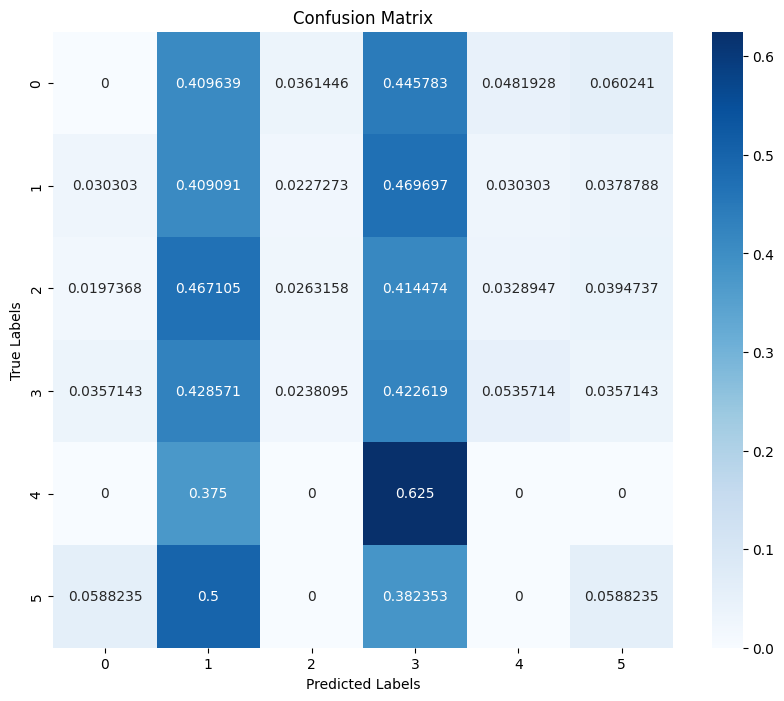

Epoch 18, Validation Loss: 1.6910, Accuracy: 0.2270, F1 Score: 0.1799
Val F1 Score Per Class  [0.         0.28198433 0.04819277 0.33890215 0.         0.06896552]


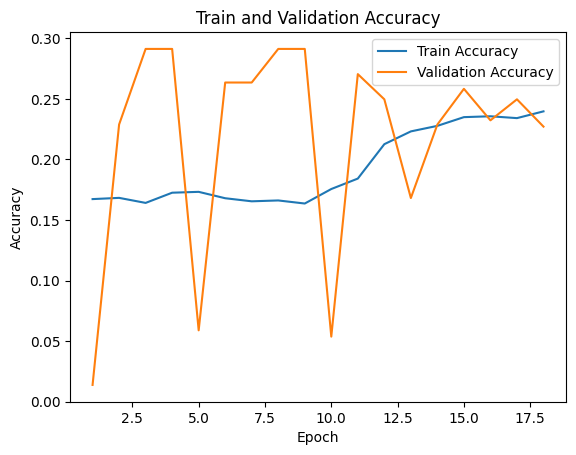

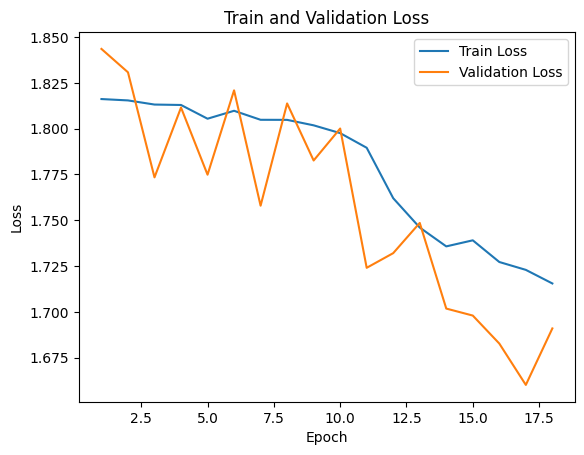

Epoch 19, Train Loss: 1.7088, Accuracy: 0.2421, F1 Score: 0.2101
Train F1 Score Per Class  [0.13757524 0.17164179 0.10169492 0.2676454  0.44535333 0.13645705]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.52it/s, loss=1.78]

[tensor([-0.4160, -0.1665, -0.4942, -0.2992, -0.2451, -0.5222], device='cuda:0'), tensor([-0.2191, -0.0077, -0.4438, -0.1527, -0.1119, -0.3620], device='cuda:0'), tensor([-0.0979,  0.0189, -0.0379,  0.0426, -0.6962, -0.1418], device='cuda:0'), tensor([-0.1933, -0.0230, -0.2834, -0.0593, -1.1641, -0.2314], device='cuda:0'), tensor([-0.3010, -0.1311, -0.2465, -0.1801, -2.8425, -0.3320], device='cuda:0'), tensor([-0.0474,  0.0322, -0.2284, -0.0815, -1.5197, -0.1287], device='cuda:0'), tensor([-1.5122e-01, -2.3939e-02, -6.0350e-02, -1.3601e-05, -6.3767e-01,
        -1.5109e-01], device='cuda:0'), tensor([-0.3056, -0.1092, -0.3497, -0.2021,  0.8571, -0.4244], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.53it/s, loss=1.78]

[tensor([-0.2511, -0.0281, -0.3347, -0.1963, -0.7560, -0.3343], device='cuda:0'), tensor([-0.1410, -0.1815, -0.2238, -0.1517, -1.4317, -0.1843], device='cuda:0'), tensor([ 0.1946, -0.0241,  0.2265,  0.1721, -1.8353,  0.2670], device='cuda:0'), tensor([-0.0255,  0.0368,  0.0070,  0.0534, -0.7692, -0.0902], device='cuda:0'), tensor([ 0.1892, -0.0023,  0.1878,  0.1125, -1.5357,  0.2397], device='cuda:0'), tensor([-0.2699, -0.0162, -0.3002, -0.1127, -0.1626, -0.3859], device='cuda:0'), tensor([ 0.1304,  0.1074,  0.0799,  0.1924, -2.7330,  0.0917], device='cuda:0'), tensor([ 0.0624,  0.0079,  0.1760,  0.1196, -1.6841,  0.0672], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.45it/s, loss=1.68]

[tensor([-0.1719, -0.0196, -0.2733, -0.0919,  0.0666, -0.1941], device='cuda:0'), tensor([-0.0983, -0.0244, -0.0490, -0.0014, -1.0834, -0.1494], device='cuda:0'), tensor([-0.0445,  0.0407,  0.0824,  0.1205, -0.8480, -0.0563], device='cuda:0'), tensor([ 0.0340,  0.0560,  0.1396,  0.1351, -1.2441,  0.0184], device='cuda:0'), tensor([-0.0387, -0.0066, -0.1217, -0.0216, -1.8593, -0.0484], device='cuda:0'), tensor([ 0.0967,  0.0314,  0.0961,  0.1928, -3.1111,  0.0909], device='cuda:0'), tensor([-0.1735, -0.1090, -0.2064, -0.1492, -1.5733, -0.1843], device='cuda:0'), tensor([-0.1219,  0.0639, -0.0378,  0.0810, -1.5896, -0.1879], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:27,  2.47it/s, loss=1.74]

[tensor([-0.1235,  0.0394, -0.1327, -0.0231, -0.5900, -0.2213], device='cuda:0'), tensor([-0.2775, -0.0896, -0.3939, -0.1771, -0.0807, -0.3894], device='cuda:0'), tensor([-0.0660, -0.0429,  0.0316,  0.0143, -1.3001, -0.0820], device='cuda:0'), tensor([-0.3273, -0.0925, -0.4500, -0.1939, -0.2244, -0.3740], device='cuda:0'), tensor([-0.0387,  0.0371,  0.0473,  0.1094, -1.0589, -0.0796], device='cuda:0'), tensor([-0.0674, -0.0485, -0.0504,  0.0080, -1.1330, -0.1189], device='cuda:0'), tensor([ 0.1604, -0.0279,  0.2024,  0.1107, -1.4767,  0.2003], device='cuda:0'), tensor([-0.0322,  0.0913,  0.0664,  0.0947, -0.6992, -0.0695], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.46it/s, loss=1.74]

[tensor([-6.1667e-02,  6.7104e-02, -7.2817e-04,  7.2194e-02, -1.6487e+00,
        -8.4653e-02], device='cuda:0'), tensor([-0.1641,  0.0643, -0.1777,  0.0832, -0.5297, -0.2863], device='cuda:0'), tensor([ 0.0034, -0.0020,  0.1486,  0.1177, -0.9385,  0.0279], device='cuda:0'), tensor([-0.1649, -0.1557, -0.3188, -0.2192, -0.3794, -0.2097], device='cuda:0'), tensor([ 0.0185,  0.0224, -0.0524,  0.0587, -0.7504,  0.0053], device='cuda:0'), tensor([-0.2047,  0.0146, -0.3455, -0.1557, -0.9721, -0.2773], device='cuda:0'), tensor([-0.1760, -0.0622, -0.1046, -0.0748, -0.1314, -0.2055], device='cuda:0'), tensor([ 0.0527, -0.0263,  0.0780,  0.0904, -0.8109,  0.0640], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.46it/s, loss=1.85]

[tensor([-0.1201, -0.0073, -0.1317,  0.0011, -0.6390, -0.1910], device='cuda:0'), tensor([-0.0845, -0.0884, -0.1104, -0.0282, -0.2841, -0.0596], device='cuda:0'), tensor([ 0.0041,  0.0421,  0.0802,  0.1788, -1.1119, -0.0522], device='cuda:0'), tensor([-0.1532,  0.0363, -0.0976,  0.0550,  0.1497, -0.2346], device='cuda:0'), tensor([-0.0582, -0.1157, -0.1657, -0.0849, -0.9856, -0.0711], device='cuda:0'), tensor([ 0.1279,  0.0725,  0.1051,  0.0351, -4.6810,  0.1048], device='cuda:0'), tensor([-0.1032, -0.0604, -0.2597, -0.1456, -1.4760, -0.1603], device='cuda:0'), tensor([-0.1654,  0.0250, -0.1337,  0.0039, -1.4287, -0.2288], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.47it/s, loss=1.68]

[tensor([-0.0578,  0.0340, -0.0025,  0.1218, -0.5783, -0.1105], device='cuda:0'), tensor([ 0.0025,  0.0580,  0.1199,  0.1414, -1.5713, -0.0279], device='cuda:0'), tensor([-0.0339,  0.0658, -0.0177,  0.0153, -0.4352, -0.0340], device='cuda:0'), tensor([-0.1975, -0.0678, -0.3271, -0.1156, -0.3690, -0.2361], device='cuda:0'), tensor([-0.1157, -0.0951, -0.4181, -0.2521, -0.6107, -0.1850], device='cuda:0'), tensor([ 0.0779,  0.1482,  0.1971,  0.2508, -4.5459,  0.0554], device='cuda:0'), tensor([-0.0554, -0.0152,  0.0257,  0.0471, -2.4515, -0.0310], device='cuda:0'), tensor([-5.7805e-02,  1.1282e-01,  3.7217e-04,  1.2989e-01, -4.5664e-01,
        -1.4265e-01], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.45it/s, loss=1.77]

[tensor([-0.1768,  0.0252, -0.2553, -0.0296, -0.1253, -0.2872], device='cuda:0'), tensor([-0.0198,  0.0360,  0.0586,  0.0889, -0.8541, -0.0320], device='cuda:0'), tensor([-0.3101, -0.0768, -0.2914, -0.1416,  0.2162, -0.3788], device='cuda:0'), tensor([-0.0799,  0.0087, -0.1391, -0.0119, -0.9684, -0.1607], device='cuda:0'), tensor([-0.1444, -0.1003, -0.0781, -0.0740, -1.1851, -0.1395], device='cuda:0'), tensor([ 0.3164,  0.1384,  0.4712,  0.3474, -1.9378,  0.3765], device='cuda:0'), tensor([-0.3877, -0.0691, -0.3763, -0.1916, -0.0402, -0.4911], device='cuda:0'), tensor([ 0.2639,  0.0109,  0.2410,  0.1620, -2.4763,  0.3476], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:25,  2.46it/s, loss=1.73]

[tensor([-0.0401,  0.0565,  0.0295,  0.1236, -0.6136, -0.0560], device='cuda:0'), tensor([-0.0687,  0.0015, -0.0039,  0.0803, -0.8831, -0.0969], device='cuda:0'), tensor([-0.1615,  0.0270, -0.1142, -0.0152, -0.4699, -0.2442], device='cuda:0'), tensor([-0.2566, -0.0815, -0.1778, -0.0939, -1.4945, -0.2957], device='cuda:0'), tensor([-0.2924, -0.0862, -0.2775, -0.1449, -1.8684, -0.3604], device='cuda:0'), tensor([-0.3116, -0.0274, -0.3620, -0.1472,  0.2931, -0.4588], device='cuda:0'), tensor([-0.2587, -0.4092, -1.0574, -0.6971, -1.7869, -0.4638], device='cuda:0'), tensor([-0.0400, -0.0213, -0.0838, -0.0186, -2.1042, -0.0364], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.46it/s, loss=1.72]

[tensor([ 0.0708,  0.0730,  0.1322,  0.1169, -1.0776,  0.0830], device='cuda:0'), tensor([ 0.1767,  0.0337,  0.1444,  0.0920, -1.9204,  0.2249], device='cuda:0'), tensor([ 0.1669, -0.0433, -0.1325, -0.1275, -4.1646,  0.2496], device='cuda:0'), tensor([-0.1382, -0.0396, -0.1250, -0.0102, -1.1679, -0.1701], device='cuda:0'), tensor([-0.2677, -0.0384, -0.1990, -0.1151, -0.7458, -0.3153], device='cuda:0'), tensor([-0.4046, -0.0817, -0.3609, -0.1791,  0.0387, -0.4901], device='cuda:0'), tensor([ 0.0264, -0.0501, -0.0495,  0.0164, -1.8408,  0.0067], device='cuda:0'), tensor([-0.1625, -0.0035, -0.0859,  0.0012, -0.4369, -0.2008], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.48it/s, loss=1.81]

[tensor([ 0.0202,  0.0949,  0.0964,  0.1759, -2.0701, -0.0382], device='cuda:0'), tensor([-0.0671,  0.0383,  0.0237,  0.1356, -0.9037, -0.1084], device='cuda:0'), tensor([-0.1360, -0.1327, -0.1638, -0.0725, -0.4007, -0.1386], device='cuda:0'), tensor([-0.0562,  0.0374, -0.1054,  0.0307, -2.7356, -0.1370], device='cuda:0'), tensor([-0.1995, -0.1498, -0.5537, -0.2975,  0.2495, -0.3231], device='cuda:0'), tensor([-0.3010, -0.0531, -0.2738, -0.0832, -0.7309, -0.3569], device='cuda:0'), tensor([-0.1808, -0.1207, -0.3080, -0.1808, -0.2857, -0.2542], device='cuda:0'), tensor([-0.0436,  0.0702,  0.0266,  0.0832, -0.6453, -0.0759], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.46it/s, loss=1.72]

[tensor([-0.3193, -0.0603, -0.4009, -0.2392, -0.6594, -0.4453], device='cuda:0'), tensor([-0.2040, -0.0310, -0.2255, -0.0923,  0.0116, -0.2511], device='cuda:0'), tensor([-0.3752, -0.0562, -0.3484, -0.1587, -0.8281, -0.4469], device='cuda:0'), tensor([ 0.0189,  0.0663, -0.0669,  0.0683, -1.6053, -0.0899], device='cuda:0'), tensor([ 0.0071, -0.0385, -0.0648, -0.0302, -2.8392,  0.0088], device='cuda:0'), tensor([-0.0543,  0.0278, -0.0047,  0.0283, -1.0499, -0.0607], device='cuda:0'), tensor([-0.2263, -0.0669, -0.2242, -0.0536, -0.3323, -0.3033], device='cuda:0'), tensor([-0.3020, -0.1776, -0.3243, -0.2147,  0.5112, -0.3298], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.46it/s, loss=1.68]

[tensor([-0.1249,  0.0265, -0.0980, -0.0015, -0.5518, -0.1540], device='cuda:0'), tensor([-0.1712, -0.0125, -0.1546, -0.0224, -0.3943, -0.2501], device='cuda:0'), tensor([ 0.0162, -0.1367, -0.0984, -0.0964, -1.2027,  0.0061], device='cuda:0'), tensor([-0.1333,  0.0479, -0.0399,  0.0602, -0.4123, -0.1775], device='cuda:0'), tensor([-0.1891, -0.0468, -0.1112, -0.0080, -0.2510, -0.2007], device='cuda:0'), tensor([-0.0201,  0.0834,  0.0650,  0.1336, -0.7620, -0.0222], device='cuda:0'), tensor([ 0.0233,  0.0405, -0.0094,  0.0916, -1.5899, -0.0420], device='cuda:0'), tensor([ 0.1560,  0.0885,  0.1103,  0.1493, -1.1645,  0.1071], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:23,  2.46it/s, loss=1.73]

[tensor([-0.2227, -0.0484, -0.2876, -0.1907, -0.6183, -0.3151], device='cuda:0'), tensor([-0.3113, -0.1754, -0.3610, -0.1937, -1.7352, -0.4485], device='cuda:0'), tensor([-0.0601,  0.0967,  0.0125,  0.1410, -0.7674, -0.1403], device='cuda:0'), tensor([ 0.2647,  0.0814,  0.2508,  0.1666, -3.4118,  0.2895], device='cuda:0'), tensor([ 0.1957,  0.0537,  0.2344,  0.1545, -2.1904,  0.2487], device='cuda:0'), tensor([ 0.0346,  0.0553,  0.0361,  0.1051, -4.1649,  0.0045], device='cuda:0'), tensor([-0.4073, -0.1633, -0.4182, -0.2565,  0.6226, -0.4684], device='cuda:0'), tensor([-0.0849,  0.0706, -0.0404,  0.0414, -1.4471, -0.1345], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.47it/s, loss=1.7]

[tensor([-0.0843,  0.0496, -0.0014,  0.0947, -1.1008, -0.1350], device='cuda:0'), tensor([-0.1985, -0.0751, -0.2091, -0.1309, -0.1737, -0.2202], device='cuda:0'), tensor([-0.0294,  0.1076,  0.0721,  0.1186, -0.7609, -0.0704], device='cuda:0'), tensor([-0.1485,  0.0156, -0.0747,  0.0203, -0.2732, -0.2148], device='cuda:0'), tensor([-1.0230e-01, -5.1487e-02, -3.4057e-02,  2.0335e-03, -2.0581e+00,
        -1.3022e-01], device='cuda:0'), tensor([ 3.5980e-02, -5.2965e-03, -1.2633e-04,  4.6741e-02, -2.9354e+00,
         2.4974e-03], device='cuda:0'), tensor([-0.0056,  0.0540,  0.0902,  0.1404, -1.0731, -0.0323], device='cuda:0'), tensor([-0.1486, -0.0233, -0.0909,  0.0410,  0.0590, -0.2200], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.47it/s, loss=1.67]

[tensor([-0.0393,  0.0952, -0.0178,  0.1632, -0.6906, -0.1323], device='cuda:0'), tensor([-0.2808, -0.1094, -0.1864, -0.1279, -0.2128, -0.3048], device='cuda:0'), tensor([ 0.0429,  0.0144,  0.0993,  0.0969, -1.0360,  0.0133], device='cuda:0'), tensor([-0.1331,  0.0125, -0.0863,  0.0119, -0.5243, -0.2112], device='cuda:0'), tensor([-0.0236,  0.0424,  0.0530,  0.1087, -1.4139, -0.0730], device='cuda:0'), tensor([-0.3024, -0.1231, -0.1959, -0.1711, -0.4811, -0.3303], device='cuda:0'), tensor([-0.1854, -0.0045, -0.1418, -0.0097, -1.0313, -0.2338], device='cuda:0'), tensor([-0.0929,  0.0242, -0.0117,  0.0565, -0.7434, -0.1316], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.46it/s, loss=1.71]

[tensor([-0.1905, -0.0407, -0.0888, -0.0455, -0.0526, -0.2273], device='cuda:0'), tensor([-0.0187,  0.0782,  0.0515,  0.1111, -0.8876, -0.0616], device='cuda:0'), tensor([ 0.0183,  0.0735,  0.0578,  0.1614, -0.5393, -0.0794], device='cuda:0'), tensor([-0.1712,  0.0130, -0.4368, -0.1599, -2.1579, -0.3585], device='cuda:0'), tensor([ 1.5418e-01, -3.3137e-02,  9.7139e-02, -3.5585e-03, -3.9277e+00,
         1.8943e-01], device='cuda:0'), tensor([ 0.0272, -0.0798,  0.0327, -0.0314, -1.5104,  0.0487], device='cuda:0'), tensor([ 0.0371, -0.0282,  0.0434,  0.0258, -1.1814,  0.0297], device='cuda:0'), tensor([-0.0101,  0.0817,  0.0518,  0.1091, -0.6170, -0.0380], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.47it/s, loss=1.68]

[tensor([-0.2775, -0.0591, -0.3525, -0.1805, -0.3918, -0.3563], device='cuda:0'), tensor([-0.1043, -0.0681, -0.1235, -0.0822, -0.8948, -0.1161], device='cuda:0'), tensor([-0.1222, -0.0329, -0.0628,  0.0263, -0.1800, -0.1656], device='cuda:0'), tensor([-0.2007, -0.0372, -0.3166, -0.1461, -0.9598, -0.3171], device='cuda:0'), tensor([ 0.1804,  0.0582,  0.2473,  0.2158, -2.5118,  0.1317], device='cuda:0'), tensor([-0.1327, -0.0642, -0.0424, -0.0195, -1.1081, -0.1529], device='cuda:0'), tensor([-0.2308, -0.0254, -0.1950, -0.0563, -0.6187, -0.3219], device='cuda:0'), tensor([-0.0279,  0.0525,  0.0309,  0.0820, -0.8003, -0.0500], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:21,  2.46it/s, loss=1.75]

[tensor([ 0.2823,  0.0619,  0.3478,  0.1843, -2.1860,  0.3503], device='cuda:0'), tensor([-0.4224, -0.1494, -0.4496, -0.2411, -0.3758, -0.5416], device='cuda:0'), tensor([-0.0833,  0.0357,  0.0244,  0.1055, -0.7899, -0.1126], device='cuda:0'), tensor([-0.2599, -0.1618, -0.5133, -0.2942, -0.4773, -0.3605], device='cuda:0'), tensor([-0.1153, -0.0852, -0.0260, -0.0281, -0.6371, -0.1221], device='cuda:0'), tensor([ 0.2616,  0.0893,  0.1862,  0.1887, -2.0421,  0.2585], device='cuda:0'), tensor([-0.4687, -0.2949, -0.8172, -0.5082,  0.0161, -0.6011], device='cuda:0'), tensor([-0.1399,  0.0349, -0.0745,  0.0432, -1.8847, -0.1871], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.44it/s, loss=1.73]

[tensor([ 0.0652,  0.0769,  0.0763,  0.1666, -1.0569,  0.0398], device='cuda:0'), tensor([-0.0371, -0.0238,  0.0580,  0.0217, -2.5190, -0.0450], device='cuda:0'), tensor([-0.1676, -0.0378, -0.3197, -0.1169, -0.6071, -0.2602], device='cuda:0'), tensor([-0.3619, -0.0836, -0.3033, -0.1398, -0.3041, -0.4375], device='cuda:0'), tensor([-0.2585, -0.0614, -0.2265, -0.1181,  0.0758, -0.3256], device='cuda:0'), tensor([-0.0304,  0.0425,  0.0389,  0.0825, -1.3641, -0.0565], device='cuda:0'), tensor([ 0.0677,  0.0199, -0.0356,  0.0141, -4.3434,  0.0657], device='cuda:0'), tensor([-0.2593, -0.0513, -0.1911, -0.0882, -0.2590, -0.3256], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.46it/s, loss=1.72]

[tensor([-0.0016,  0.0080, -0.0499,  0.0452, -0.6298, -0.0281], device='cuda:0'), tensor([-0.0616,  0.0422,  0.0349,  0.1017, -0.7040, -0.1012], device='cuda:0'), tensor([-0.2530, -0.0589, -0.2510, -0.0936, -0.4815, -0.3313], device='cuda:0'), tensor([-0.0034,  0.0718,  0.0441,  0.0565, -1.3326, -0.0195], device='cuda:0'), tensor([ 0.0154,  0.0572,  0.0805,  0.1283, -0.8829,  0.0024], device='cuda:0'), tensor([-0.4869, -0.2637, -0.6216, -0.4428,  0.4052, -0.5652], device='cuda:0'), tensor([-0.1029,  0.1066, -0.0491,  0.0990, -1.1279, -0.2328], device='cuda:0'), tensor([-0.0512,  0.1007,  0.0184,  0.1107, -0.9008, -0.1236], device='cuda:0')]


Val:  30%|███       | 22/73 [00:08<00:20,  2.44it/s, loss=1.69]

[tensor([-0.2522, -0.0193, -0.1571, -0.0591, -0.6505, -0.2999], device='cuda:0'), tensor([-0.0657,  0.0577,  0.0362,  0.1111, -0.9601, -0.0898], device='cuda:0'), tensor([-0.1984, -0.0980, -0.2771, -0.1400, -1.0677, -0.2703], device='cuda:0'), tensor([-0.0718,  0.0426,  0.0226,  0.1117, -0.5451, -0.1250], device='cuda:0'), tensor([-0.2278, -0.0298, -0.1798, -0.0495, -0.1751, -0.3084], device='cuda:0'), tensor([-0.0765,  0.0177, -0.0177,  0.0088, -3.2322, -0.0722], device='cuda:0'), tensor([-0.0053,  0.0469,  0.0383,  0.1459, -0.6484, -0.0446], device='cuda:0'), tensor([ 0.0811,  0.0484,  0.2172,  0.2063, -1.1251,  0.0767], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.45it/s, loss=1.77]

[tensor([-0.1262,  0.0369, -0.0539, -0.0212, -1.2178, -0.1484], device='cuda:0'), tensor([-0.2524, -0.0900, -0.6454, -0.3067,  0.5735, -0.4349], device='cuda:0'), tensor([-0.0382,  0.0622, -0.0095,  0.0454, -1.4509, -0.0596], device='cuda:0'), tensor([-0.3361, -0.0541, -0.2877, -0.0990, -0.7937, -0.4177], device='cuda:0'), tensor([ 0.1068, -0.0771, -0.1138, -0.1461, -3.5222,  0.0838], device='cuda:0'), tensor([-0.3989, -0.0972, -0.4111, -0.2133, -0.3380, -0.5472], device='cuda:0'), tensor([-0.3015, -0.0245, -0.3331, -0.1337,  0.1899, -0.4551], device='cuda:0'), tensor([-0.3258, -0.1456, -0.2144, -0.1491, -0.8835, -0.3443], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.47it/s, loss=1.68]

[tensor([-0.3316, -0.1102, -0.3031, -0.1271, -1.1253, -0.3889], device='cuda:0'), tensor([ 0.0380, -0.0495,  0.1573,  0.0780, -1.3792,  0.0448], device='cuda:0'), tensor([ 0.0585,  0.0963,  0.1468,  0.1966, -1.3161,  0.0328], device='cuda:0'), tensor([-0.0225, -0.0577, -0.1523, -0.0626, -2.1305, -0.0618], device='cuda:0'), tensor([-0.4137, -0.1489, -0.3942, -0.2706, -2.0785, -0.4721], device='cuda:0'), tensor([-0.0996,  0.0575, -0.0295,  0.0686, -0.3997, -0.1671], device='cuda:0'), tensor([-0.1365, -0.0329, -0.0945,  0.0187, -0.7104, -0.1966], device='cuda:0'), tensor([ 0.2909,  0.0792,  0.2702,  0.2129, -2.3057,  0.3455], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.45it/s, loss=1.8]

[tensor([-0.2536, -0.0260, -0.3349, -0.1658, -0.2999, -0.3351], device='cuda:0'), tensor([-0.5253, -0.2188, -0.7478, -0.4708,  0.6256, -0.6730], device='cuda:0'), tensor([-0.2258, -0.0827, -0.2980, -0.1391, -0.6814, -0.3066], device='cuda:0'), tensor([-0.2155, -0.0219, -0.1211, -0.0066, -0.5598, -0.2730], device='cuda:0'), tensor([-0.2180, -0.0392, -0.1711, -0.0380, -0.1962, -0.3245], device='cuda:0'), tensor([-0.2660, -0.0492, -0.1947, -0.0918, -0.1865, -0.3236], device='cuda:0'), tensor([-1.0987e-01,  3.7662e-02, -1.0346e-01, -3.7394e-04, -8.0013e-01,
        -1.8784e-01], device='cuda:0'), tensor([-0.3257, -0.0981, -0.2064, -0.1317, -1.8379, -0.3368], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.46it/s, loss=1.71]

[tensor([-0.1170,  0.0034, -0.1165, -0.0155, -0.2717, -0.1770], device='cuda:0'), tensor([-0.2821, -0.0403, -0.2196, -0.0831, -0.1139, -0.3700], device='cuda:0'), tensor([ 0.8495,  0.2855,  0.7887,  0.5143, -4.2854,  0.9544], device='cuda:0'), tensor([-0.0219,  0.0243,  0.0744,  0.0934, -1.3107, -0.0374], device='cuda:0'), tensor([-0.1671, -0.0623, -0.1332, -0.0680, -0.9265, -0.1890], device='cuda:0'), tensor([-0.0533,  0.0148,  0.0711,  0.1003, -0.5304, -0.0530], device='cuda:0'), tensor([ 0.0508,  0.0830,  0.0723,  0.1457, -2.2663,  0.0541], device='cuda:0'), tensor([-0.2358, -0.0732, -0.1580, -0.0970, -0.9412, -0.2455], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:10<00:18,  2.47it/s, loss=1.7]

[tensor([ 0.1132,  0.0207,  0.2252,  0.1860, -1.2773,  0.1469], device='cuda:0'), tensor([-0.1085, -0.0340, -0.0740, -0.0411, -0.9385, -0.1458], device='cuda:0'), tensor([-0.4549, -0.1105, -0.4777, -0.2850, -0.4451, -0.5891], device='cuda:0'), tensor([-0.0118,  0.1044,  0.0325,  0.1772, -0.4599, -0.0940], device='cuda:0'), tensor([-0.0694,  0.0746,  0.0297,  0.0881, -0.7257, -0.1096], device='cuda:0'), tensor([-0.3979, -0.1321, -0.4522, -0.2401, -1.0658, -0.4705], device='cuda:0'), tensor([ 0.0127,  0.0190,  0.0473,  0.0938, -0.6002, -0.0110], device='cuda:0'), tensor([-0.2706, -0.0777, -0.2163, -0.1160, -1.3226, -0.2873], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.46it/s, loss=1.68]

[tensor([-0.1931, -0.0754, -0.3452, -0.1834, -0.2139, -0.2919], device='cuda:0'), tensor([ 0.0744,  0.0467,  0.2112,  0.1471, -2.1387,  0.0815], device='cuda:0'), tensor([-0.4256, -0.2353, -0.5372, -0.3364, -3.5764, -0.5241], device='cuda:0'), tensor([-0.2676, -0.0111, -0.2379, -0.1236, -0.3117, -0.3548], device='cuda:0'), tensor([-0.2374, -0.0071, -0.2454, -0.0697, -0.6123, -0.3271], device='cuda:0'), tensor([-0.1929, -0.0647, -0.1798, -0.0661, -1.6552, -0.2744], device='cuda:0'), tensor([-0.0619, -0.0454, -0.1310, -0.0372, -1.9690, -0.1306], device='cuda:0'), tensor([ 0.0192,  0.0302,  0.0326,  0.1199, -0.7737, -0.0221], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.46it/s, loss=1.65]

[tensor([ 0.0737,  0.0521,  0.1880,  0.1601, -1.7031,  0.1150], device='cuda:0'), tensor([-0.3265, -0.1400, -0.3133, -0.1905, -1.5796, -0.4279], device='cuda:0'), tensor([-0.1274,  0.0370, -0.0348,  0.0628, -0.2288, -0.1706], device='cuda:0'), tensor([-0.0651,  0.0190, -0.0037,  0.0718, -1.4518, -0.1011], device='cuda:0'), tensor([-0.2906, -0.0503, -0.2845, -0.1228, -0.0459, -0.3814], device='cuda:0'), tensor([-0.0688,  0.0829, -0.0123,  0.1122, -0.7872, -0.1299], device='cuda:0'), tensor([-0.1803, -0.0305, -0.1239,  0.0097, -0.6768, -0.2402], device='cuda:0'), tensor([-0.0263,  0.0498,  0.0209,  0.1403, -0.3517, -0.1124], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.46it/s, loss=1.69]

[tensor([-0.2103, -0.0248, -0.1770, -0.0460, -0.8230, -0.2529], device='cuda:0'), tensor([-0.0998,  0.0850, -0.0631,  0.0459, -0.9860, -0.1524], device='cuda:0'), tensor([-0.2793, -0.0597, -0.3415, -0.1605, -0.6084, -0.3992], device='cuda:0'), tensor([ 0.0333,  0.0270,  0.1108,  0.0770, -0.9174,  0.0550], device='cuda:0'), tensor([-0.2203, -0.0415, -0.1677, -0.0564, -1.7808, -0.3050], device='cuda:0'), tensor([-0.1521,  0.0030, -0.0904,  0.0100, -0.2696, -0.2227], device='cuda:0'), tensor([-0.1423, -0.0292, -0.1356, -0.0087, -0.9437, -0.2057], device='cuda:0'), tensor([-0.3495, -0.1472, -0.3808, -0.2258,  0.7718, -0.4541], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.45it/s, loss=1.7]

[tensor([ 0.4226,  0.1487,  0.4346,  0.2941, -2.4125,  0.4749], device='cuda:0'), tensor([-0.1491, -0.0693, -0.1054, -0.0733, -0.2165, -0.1289], device='cuda:0'), tensor([-0.1674, -0.0051, -0.1020,  0.0078, -1.2923, -0.2437], device='cuda:0'), tensor([-0.0427,  0.0719, -0.0403,  0.0751, -0.5756, -0.0765], device='cuda:0'), tensor([-0.0403,  0.0407,  0.0129,  0.1014, -0.8199, -0.1128], device='cuda:0'), tensor([-0.2178, -0.0250, -0.1884, -0.0764, -0.2965, -0.2739], device='cuda:0'), tensor([ 0.4534, -0.2110, -0.6893, -0.5612, -4.2375,  0.1974], device='cuda:0'), tensor([-0.0912, -0.0051,  0.0191,  0.0824, -1.6664, -0.0938], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.44it/s, loss=1.68]

[tensor([-0.0850,  0.0522, -0.0605,  0.0305, -1.2191, -0.1504], device='cuda:0'), tensor([-0.1757, -0.0288, -0.0968,  0.0027, -0.3964, -0.2440], device='cuda:0'), tensor([ 0.0657, -0.0798, -0.0507, -0.0673, -1.0134,  0.0637], device='cuda:0'), tensor([-0.2217, -0.0547, -0.2535, -0.1130, -0.5505, -0.2792], device='cuda:0'), tensor([-0.1459, -0.1413, -0.1258, -0.0901, -0.5308, -0.1209], device='cuda:0'), tensor([-0.0830,  0.0529,  0.0437,  0.0582, -2.7033, -0.1073], device='cuda:0'), tensor([-0.0164,  0.0075,  0.0044,  0.0928, -1.5428, -0.0437], device='cuda:0'), tensor([-0.0271,  0.0709,  0.0813,  0.1248, -1.1419, -0.0388], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.45it/s, loss=1.67]

[tensor([-0.0393,  0.0553,  0.0659,  0.0990, -0.6597, -0.0672], device='cuda:0'), tensor([-0.1888, -0.0653, -0.2205, -0.1097, -0.8731, -0.2289], device='cuda:0'), tensor([-0.3377,  0.0280, -0.3486, -0.1141, -0.6328, -0.4955], device='cuda:0'), tensor([-0.1101, -0.0176, -0.0767,  0.0055, -0.7692, -0.1721], device='cuda:0'), tensor([ 0.0126,  0.0873,  0.0555,  0.0785, -2.0280, -0.0203], device='cuda:0'), tensor([ 0.0523, -0.1022, -0.2744, -0.1775, -2.6643,  0.0043], device='cuda:0'), tensor([-0.0227,  0.0579,  0.1081,  0.1098, -0.7718, -0.0474], device='cuda:0'), tensor([-0.1167,  0.0324, -0.0289,  0.0488, -0.3875, -0.1854], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.45it/s, loss=1.68]

[tensor([ 0.2743,  0.0402,  0.3141,  0.1785, -2.3178,  0.3440], device='cuda:0'), tensor([ 0.2840,  0.1317,  0.2435,  0.2157, -1.7870,  0.2755], device='cuda:0'), tensor([-0.4138, -0.1009, -0.3974, -0.2218, -0.6713, -0.5188], device='cuda:0'), tensor([-0.0102,  0.0143,  0.0388,  0.0576, -1.0243, -0.0583], device='cuda:0'), tensor([-0.2250, -0.1207, -0.4171, -0.2329,  0.1216, -0.3624], device='cuda:0'), tensor([ 0.0174,  0.0906,  0.0187,  0.1386, -0.9280, -0.0317], device='cuda:0'), tensor([-0.2478, -0.0502, -0.1934, -0.0783, -0.0799, -0.3323], device='cuda:0'), tensor([-0.0724, -0.0742,  0.0248,  0.0213, -0.6305, -0.0585], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.45it/s, loss=1.67]

[tensor([ 0.2197,  0.0303,  0.1552,  0.1172, -3.0620,  0.2758], device='cuda:0'), tensor([-4.8591e-02,  7.9796e-02,  4.0296e-05,  1.1861e-01, -5.7523e-01,
        -1.4033e-01], device='cuda:0'), tensor([-0.2579, -0.2137, -0.4399, -0.3534, -2.3424, -0.3011], device='cuda:0'), tensor([ 0.0419,  0.0335,  0.0880,  0.1159, -1.0215,  0.0144], device='cuda:0'), tensor([-0.1008, -0.0027, -0.0139,  0.0697, -0.1091, -0.1491], device='cuda:0'), tensor([ 0.0398,  0.0597,  0.0953,  0.1481, -1.4487,  0.0346], device='cuda:0'), tensor([-0.0186, -0.0731, -0.1706, -0.0515, -2.0903, -0.0705], device='cuda:0'), tensor([-0.0424, -0.0294,  0.0257,  0.1067, -0.4020, -0.1027], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.45it/s, loss=1.63]

[tensor([-0.1121, -0.0503, -0.1849, -0.0971, -1.6447, -0.1688], device='cuda:0'), tensor([-0.2460, -0.0082, -0.1858, -0.0309, -0.5854, -0.3247], device='cuda:0'), tensor([ 0.2061,  0.1584,  0.1323,  0.2435, -1.4492,  0.1419], device='cuda:0'), tensor([-0.0681, -0.0793, -0.0487, -0.0182, -1.1144, -0.1229], device='cuda:0'), tensor([ 0.1908,  0.0742,  0.0261,  0.1363, -1.9491,  0.1214], device='cuda:0'), tensor([-0.4721, -0.3173, -0.9735, -0.6563, -2.6485, -0.6543], device='cuda:0'), tensor([ 0.1191,  0.1266,  0.1458,  0.2009, -1.1808,  0.1057], device='cuda:0'), tensor([-0.0045,  0.0427, -0.0214,  0.0295, -0.5787, -0.0612], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.45it/s, loss=1.76]

[tensor([-0.0791, -0.0456, -0.1515, -0.0647, -0.4360, -0.1414], device='cuda:0'), tensor([-0.1052,  0.0897, -0.0453,  0.0708, -0.4954, -0.1758], device='cuda:0'), tensor([-0.1017, -0.0030, -0.0281,  0.0770, -1.0018, -0.1260], device='cuda:0'), tensor([ 0.0084,  0.0777, -0.0120,  0.1114, -1.8004, -0.0480], device='cuda:0'), tensor([-0.2367,  0.0199, -0.1831, -0.0190, -0.5807, -0.3111], device='cuda:0'), tensor([-0.0583, -0.0053,  0.0226,  0.0541, -0.9313, -0.0746], device='cuda:0'), tensor([-0.1116,  0.0164, -0.0114,  0.0708, -0.7206, -0.1412], device='cuda:0'), tensor([-0.1173,  0.0626, -0.0112,  0.0550, -1.4073, -0.1714], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.45it/s, loss=1.61]

[tensor([-0.1408, -0.1221, -0.3408, -0.2153, -0.7823, -0.2132], device='cuda:0'), tensor([-0.2319, -0.0485, -0.1700, -0.0390, -1.4484, -0.2740], device='cuda:0'), tensor([-0.1543,  0.0013, -0.1325, -0.0535, -0.2739, -0.1924], device='cuda:0'), tensor([ 0.1721,  0.0295, -0.0725, -0.0037, -3.0054,  0.1702], device='cuda:0'), tensor([-1.5070e-01, -7.4552e-02, -2.9756e-03, -8.0466e-06, -3.2205e+00,
        -1.1959e-01], device='cuda:0'), tensor([-0.2107, -0.0011, -0.1586, -0.0090, -0.1640, -0.2889], device='cuda:0'), tensor([-0.1297, -0.0545, -0.1771, -0.0038, -1.2184, -0.1902], device='cuda:0'), tensor([-0.0592,  0.0225, -0.1340, -0.0211, -1.0800, -0.1363], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.45it/s, loss=1.65]

[tensor([-0.2849, -0.1158, -0.2639, -0.1400, -0.6842, -0.3286], device='cuda:0'), tensor([ 0.2293,  0.0520,  0.1234,  0.1496, -2.7337,  0.2105], device='cuda:0'), tensor([ 0.0122,  0.0383, -0.0096,  0.0451, -1.3524, -0.0071], device='cuda:0'), tensor([-0.1673, -0.1172, -0.2146, -0.1357, -0.5563, -0.1811], device='cuda:0'), tensor([-0.0483, -0.1124,  0.0757,  0.0208, -3.5054,  0.0136], device='cuda:0'), tensor([-0.1242, -0.0122, -0.0225,  0.0354, -0.5299, -0.1854], device='cuda:0'), tensor([-6.0346e-02,  3.9363e-02,  9.9162e-04,  7.3096e-02, -1.1307e+00,
        -1.0036e-01], device='cuda:0'), tensor([-0.1553,  0.0205, -0.0521,  0.0213, -0.7335, -0.2091], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.46it/s, loss=1.67]

[tensor([-0.0498,  0.0669, -0.0247,  0.0740, -1.0945, -0.1042], device='cuda:0'), tensor([-0.1686, -0.0007, -0.1488, -0.0141, -0.6654, -0.2165], device='cuda:0'), tensor([-0.0957, -0.0452,  0.0268,  0.0108, -2.4340, -0.0615], device='cuda:0'), tensor([-0.0665,  0.0215,  0.0138,  0.0481, -2.2072, -0.1056], device='cuda:0'), tensor([-0.0415,  0.0590, -0.0160,  0.1029, -0.9455, -0.0479], device='cuda:0'), tensor([ 0.0306, -0.0045,  0.1048,  0.0906, -2.9128,  0.0447], device='cuda:0'), tensor([-0.0458, -0.0551, -0.0407,  0.0098, -0.3809, -0.0651], device='cuda:0'), tensor([-0.1010, -0.0955,  0.0137, -0.0280, -1.4851, -0.0731], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.46it/s, loss=1.67]

[tensor([-0.3645, -0.2045, -0.3759, -0.2474, -2.6974, -0.3924], device='cuda:0'), tensor([-0.4448, -0.1236, -0.4129, -0.2362,  0.1755, -0.5668], device='cuda:0'), tensor([-0.1914, -0.0104, -0.0897, -0.0225, -0.5321, -0.2564], device='cuda:0'), tensor([-0.2895, -0.0272, -0.2369, -0.0758, -1.8186, -0.3811], device='cuda:0'), tensor([-0.0091,  0.0554,  0.0277,  0.1406, -1.1777, -0.0820], device='cuda:0'), tensor([-0.0559,  0.0323,  0.0791,  0.0869, -1.2880, -0.0598], device='cuda:0'), tensor([-0.1627, -0.1124, -0.3821, -0.2590, -0.3649, -0.2490], device='cuda:0'), tensor([-0.2562, -0.0919, -0.4658, -0.2950, -0.2131, -0.3327], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.45it/s, loss=1.74]

[tensor([-0.2016, -0.0590, -0.5975, -0.2718, -0.8678, -0.4420], device='cuda:0'), tensor([-0.2725, -0.0595, -0.1753, -0.0737, -0.5893, -0.3481], device='cuda:0'), tensor([ 0.1204,  0.0870,  0.0986,  0.0984, -4.3395,  0.0815], device='cuda:0'), tensor([-0.2674, -0.0209, -0.2630, -0.1232, -0.8837, -0.3681], device='cuda:0'), tensor([ 0.0502,  0.0180,  0.0948,  0.1457, -1.8027,  0.0140], device='cuda:0'), tensor([ 0.0727,  0.1095,  0.1228,  0.1193, -3.2600,  0.0448], device='cuda:0'), tensor([-0.2667, -0.0733, -0.2291, -0.1066,  0.0974, -0.2979], device='cuda:0'), tensor([-0.3392, -0.1131, -0.2691, -0.1530,  0.2886, -0.4009], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.46it/s, loss=1.83]

[tensor([-0.4079, -0.1141, -0.5185, -0.2311,  0.4900, -0.5787], device='cuda:0'), tensor([-0.5548, -0.3045, -0.9954, -0.6323, -0.1545, -0.7750], device='cuda:0'), tensor([-0.1514, -0.0383, -0.1371, -0.0265, -0.0323, -0.2057], device='cuda:0'), tensor([-0.1357, -0.0068, -0.0577,  0.0231, -0.6008, -0.2190], device='cuda:0'), tensor([-0.2956, -0.0203, -0.2979, -0.1144, -0.3830, -0.4163], device='cuda:0'), tensor([-0.3641, -0.2048, -0.5477, -0.3960, -1.0698, -0.4970], device='cuda:0'), tensor([-0.3770, -0.1308, -0.5067, -0.3062, -0.3908, -0.4968], device='cuda:0'), tensor([-0.2749, -0.0152, -0.2757, -0.1651, -0.3551, -0.3443], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:17<00:11,  2.46it/s, loss=1.67]

[tensor([ 0.1742, -0.1197,  0.0578, -0.0039, -3.2711,  0.2325], device='cuda:0'), tensor([ 0.0269,  0.0534,  0.0560,  0.0883, -0.5869, -0.0160], device='cuda:0'), tensor([-0.2241, -0.0415, -0.1002, -0.0397, -0.9865, -0.2236], device='cuda:0'), tensor([-0.0588, -0.0005, -0.1217,  0.0061, -0.0843, -0.1233], device='cuda:0'), tensor([-0.2501,  0.0055, -0.2001, -0.0367, -0.9546, -0.3477], device='cuda:0'), tensor([-0.0496,  0.0140,  0.0085,  0.0686, -0.9378, -0.0966], device='cuda:0'), tensor([-0.1948, -0.0487, -0.3179, -0.1246, -0.0285, -0.3012], device='cuda:0'), tensor([-0.1400, -0.0819, -0.1286, -0.0392,  0.1012, -0.1511], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.46it/s, loss=1.7]

[tensor([-0.0975,  0.0285, -0.0213,  0.0955, -1.0124, -0.1507], device='cuda:0'), tensor([-0.0407,  0.0579, -0.0303,  0.1001, -1.0072, -0.0996], device='cuda:0'), tensor([-0.0764,  0.0267, -0.0335,  0.0707, -1.0784, -0.0773], device='cuda:0'), tensor([-0.1332, -0.0550, -0.1279, -0.0475, -0.9638, -0.1785], device='cuda:0'), tensor([-0.2792, -0.0225, -0.2924, -0.1252, -0.0591, -0.3736], device='cuda:0'), tensor([-0.1464, -0.1054, -0.0404, -0.0383, -1.3070, -0.0999], device='cuda:0'), tensor([-0.0165,  0.1100,  0.0484,  0.1905, -0.6581, -0.0943], device='cuda:0'), tensor([-0.1238, -0.0671,  0.0066,  0.0082, -0.2897, -0.0851], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.44it/s, loss=1.62]

[tensor([-0.3326, -0.0313, -0.3173, -0.1458, -0.8198, -0.4527], device='cuda:0'), tensor([-0.2363, -0.0628, -0.2122, -0.0795, -0.5819, -0.2871], device='cuda:0'), tensor([-0.3148, -0.1183, -0.2155, -0.1885, -2.6999, -0.3613], device='cuda:0'), tensor([ 0.2631,  0.1096,  0.3840,  0.2856, -2.8368,  0.3121], device='cuda:0'), tensor([ 0.0345, -0.0243, -0.1553, -0.0549, -2.2236,  0.0297], device='cuda:0'), tensor([-0.3486, -0.0286, -0.2510, -0.1001, -0.1381, -0.4335], device='cuda:0'), tensor([-0.0572,  0.0685, -0.0253,  0.1017, -1.3004, -0.1011], device='cuda:0'), tensor([-0.0454, -0.0221, -0.0836, -0.0274, -1.9075, -0.0895], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.45it/s, loss=1.66]

[tensor([-2.3628e-02,  4.8340e-04,  2.9183e-02,  9.1453e-02, -2.8358e+00,
        -3.2512e-02], device='cuda:0'), tensor([ 0.0030,  0.0707,  0.0577,  0.1029, -1.5848,  0.0071], device='cuda:0'), tensor([-0.0539,  0.0738,  0.0080,  0.0852, -0.7345, -0.0654], device='cuda:0'), tensor([-0.1381, -0.0151, -0.0251,  0.0335, -0.3246, -0.1570], device='cuda:0'), tensor([-8.1125e-02,  4.7250e-03, -8.7492e-04,  3.3777e-02, -9.8085e-01,
        -9.6149e-02], device='cuda:0'), tensor([-0.0290,  0.0451, -0.0735,  0.0579, -1.7385, -0.0751], device='cuda:0'), tensor([ 0.0205,  0.0117,  0.1429,  0.1313, -0.8701,  0.0527], device='cuda:0'), tensor([-2.4001e-01,  2.1989e-03, -2.4900e-01, -1.0289e-01, -2.6259e+00,
        -3.0836e-01], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.45it/s, loss=1.73]

[tensor([-0.4657, -0.1661, -0.4753, -0.2736,  1.1826, -0.5724], device='cuda:0'), tensor([ 0.3159,  0.1058,  0.3923,  0.2897, -3.0937,  0.3792], device='cuda:0'), tensor([-0.0093,  0.0530,  0.0751,  0.1647, -0.8647, -0.0790], device='cuda:0'), tensor([-0.1689,  0.0063, -0.1767, -0.1324, -1.0941, -0.2286], device='cuda:0'), tensor([-0.2371, -0.0513, -0.3475, -0.1395, -0.2070, -0.3329], device='cuda:0'), tensor([-0.2684, -0.0673, -0.2772, -0.0844,  0.2212, -0.3538], device='cuda:0'), tensor([-0.2857, -0.0299, -0.2723, -0.1068, -1.3291, -0.4076], device='cuda:0'), tensor([-0.0995,  0.0109, -0.0978,  0.0178, -0.8741, -0.1528], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:19<00:09,  2.45it/s, loss=1.68]

[tensor([-0.1845, -0.0673, -0.3458, -0.2568, -2.6037, -0.2659], device='cuda:0'), tensor([-0.1239,  0.0393, -0.1625,  0.0066, -0.5374, -0.2084], device='cuda:0'), tensor([-9.4136e-02,  6.4408e-02,  1.9105e-04,  1.1715e-01, -8.6651e-01,
        -1.6280e-01], device='cuda:0'), tensor([-0.1454,  0.0477, -0.0985,  0.0434, -1.1527, -0.2297], device='cuda:0'), tensor([-0.0355,  0.0294, -0.0792,  0.0080, -0.8604, -0.0484], device='cuda:0'), tensor([-0.0580, -0.0306,  0.0622,  0.0932, -0.7607, -0.0684], device='cuda:0'), tensor([ 0.0140,  0.1036,  0.0268,  0.1604, -1.3403, -0.0100], device='cuda:0'), tensor([ 0.0844,  0.0228,  0.1280,  0.1008, -2.0897,  0.0467], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.45it/s, loss=1.82]

[tensor([-0.3175, -0.0280, -0.2692, -0.1065,  0.1176, -0.4277], device='cuda:0'), tensor([-0.2577, -0.0679, -0.1432, -0.0850, -0.7675, -0.2842], device='cuda:0'), tensor([-0.1891, -0.0057, -0.0922, -0.0068, -0.2576, -0.2078], device='cuda:0'), tensor([-0.3218, -0.0363, -0.3283, -0.1665,  0.5226, -0.4134], device='cuda:0'), tensor([-0.0671,  0.1189, -0.0033,  0.1639, -0.9468, -0.1453], device='cuda:0'), tensor([-0.1190, -0.0119, -0.0354,  0.0375, -0.9943, -0.1473], device='cuda:0'), tensor([-0.0908,  0.0310,  0.0195,  0.0651, -0.2656, -0.1120], device='cuda:0'), tensor([-0.0306, -0.0141,  0.0137,  0.0815, -0.5379, -0.0991], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:09,  2.44it/s, loss=1.63]

[tensor([-0.1045,  0.0687, -0.1529, -0.0313, -0.2992, -0.1871], device='cuda:0'), tensor([ 0.0700,  0.0361, -0.0827,  0.0093, -1.2510,  0.0565], device='cuda:0'), tensor([-0.2131, -0.0172, -0.1645, -0.0025, -0.5113, -0.3036], device='cuda:0'), tensor([ 0.0350,  0.1456,  0.0080,  0.2154, -0.7000, -0.0664], device='cuda:0'), tensor([-0.1253, -0.0625, -0.0023,  0.0075, -0.4131, -0.1241], device='cuda:0'), tensor([-0.1195, -0.0368, -0.0156, -0.0209, -0.5066, -0.1123], device='cuda:0'), tensor([ 0.2466, -0.0535,  0.3021,  0.1068, -3.6062,  0.3456], device='cuda:0'), tensor([ 0.2904,  0.0409,  0.1991,  0.1480, -2.4681,  0.2535], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.46it/s, loss=1.68]

[tensor([-0.1492, -0.0312, -0.1239, -0.0074, -0.2185, -0.1804], device='cuda:0'), tensor([-0.3169, -0.0511, -0.3024, -0.1351, -1.2889, -0.3666], device='cuda:0'), tensor([-0.4111, -0.1295, -0.4450, -0.2576, -0.7768, -0.5406], device='cuda:0'), tensor([-0.0391, -0.0366, -0.1467,  0.0141, -0.2821, -0.0799], device='cuda:0'), tensor([ 0.3123,  0.1772,  0.3840,  0.4069, -2.2997,  0.3161], device='cuda:0'), tensor([ 1.2103e-03, -4.4516e-02, -1.6342e-01, -3.1305e-02, -1.5502e+00,
        -2.6798e-02], device='cuda:0'), tensor([-0.3138, -0.1208, -0.2476, -0.1213, -0.2022, -0.3556], device='cuda:0'), tensor([-0.2885, -0.0972, -0.2044, -0.0952, -0.5181, -0.3318], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.45it/s, loss=1.64]

[tensor([-0.2577, -0.0701, -0.2763, -0.1284, -0.9891, -0.3395], device='cuda:0'), tensor([ 0.3984,  0.1283,  0.3989,  0.2934, -3.2973,  0.4723], device='cuda:0'), tensor([-0.1327, -0.0094, -0.1267, -0.0040, -0.7428, -0.2089], device='cuda:0'), tensor([-0.2179, -0.2224, -0.4052, -0.3256, -2.2635, -0.2911], device='cuda:0'), tensor([ 0.0413,  0.1154,  0.0699,  0.1144, -1.0036, -0.0187], device='cuda:0'), tensor([-0.2267, -0.0074, -0.1733, -0.0475, -0.3548, -0.2900], device='cuda:0'), tensor([ 0.0064,  0.0368,  0.1474,  0.1364, -1.8794,  0.0098], device='cuda:0'), tensor([ 0.0621,  0.0326,  0.1483,  0.1684, -1.2035,  0.0679], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:21<00:07,  2.45it/s, loss=1.75]

[tensor([-0.7974, -0.2184, -0.9116, -0.5408, -1.1495, -1.0010], device='cuda:0'), tensor([-0.3536, -0.2033, -0.3019, -0.2453,  0.0445, -0.3834], device='cuda:0'), tensor([-0.0496,  0.0336,  0.0293,  0.0702, -0.8380, -0.0979], device='cuda:0'), tensor([-0.2320, -0.0536, -0.1937, -0.0930, -0.8588, -0.2759], device='cuda:0'), tensor([-0.0466,  0.0809,  0.0643,  0.1372, -0.8884, -0.1090], device='cuda:0'), tensor([-0.1203, -0.0423, -0.1404, -0.0625, -0.4809, -0.1863], device='cuda:0'), tensor([-0.0298,  0.1236,  0.0596,  0.1410, -0.8723, -0.1027], device='cuda:0'), tensor([-0.6062, -0.3320, -0.8253, -0.5557, -0.7988, -0.7418], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.45it/s, loss=1.64]

[tensor([ 0.2108,  0.0515,  0.2268,  0.1256, -2.1433,  0.2658], device='cuda:0'), tensor([ 0.1418,  0.0651,  0.2298,  0.1715, -2.7340,  0.1689], device='cuda:0'), tensor([-0.2456, -0.0432, -0.2638, -0.1253, -0.5597, -0.3057], device='cuda:0'), tensor([-0.0428, -0.0344, -0.1880, -0.0536, -1.7974, -0.0943], device='cuda:0'), tensor([-0.1668,  0.0086, -0.1190,  0.0189, -1.3731, -0.2645], device='cuda:0'), tensor([ 0.0207, -0.0087,  0.1374,  0.1523, -1.2880,  0.0176], device='cuda:0'), tensor([-0.3838, -0.0549, -0.3474, -0.1841, -0.6607, -0.4914], device='cuda:0'), tensor([-0.2386, -0.1441, -0.3611, -0.2533, -0.1552, -0.2994], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.45it/s, loss=1.65]

[tensor([-0.0198,  0.0673, -0.0566,  0.0444, -1.6621, -0.0753], device='cuda:0'), tensor([-0.1406,  0.0181, -0.0866,  0.0225, -0.5674, -0.2205], device='cuda:0'), tensor([-0.1341,  0.0538, -0.0326,  0.0581, -0.6405, -0.1751], device='cuda:0'), tensor([-0.1186, -0.0590, -0.2004,  0.0095, -1.9040, -0.1743], device='cuda:0'), tensor([-5.4538e-02, -6.1462e-04, -1.5495e-01, -4.0787e-02, -1.0247e+00,
        -1.1701e-01], device='cuda:0'), tensor([-3.1861e-02,  5.8564e-02,  8.8518e-04,  4.6293e-02, -9.7429e-01,
        -5.8873e-02], device='cuda:0'), tensor([-0.0601,  0.1181, -0.0056,  0.1345, -0.4319, -0.1490], device='cuda:0'), tensor([-0.3067, -0.1035, -0.4444, -0.2968, -0.3653, -0.4464], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.45it/s, loss=1.77]

[tensor([-0.3416, -0.0709, -0.2607, -0.1712,  0.3295, -0.4149], device='cuda:0'), tensor([-0.1595,  0.0788, -0.2741, -0.0346, -0.6613, -0.3034], device='cuda:0'), tensor([ 0.0489,  0.0316,  0.0670,  0.1417, -0.6590,  0.0142], device='cuda:0'), tensor([-0.1165,  0.0236, -0.0845,  0.0669, -0.9952, -0.1843], device='cuda:0'), tensor([-0.2442, -0.1535, -0.3431, -0.2363,  0.0227, -0.3330], device='cuda:0'), tensor([-0.3973, -0.1173, -0.4958, -0.2344, -0.8072, -0.5054], device='cuda:0'), tensor([ 0.0880,  0.0161,  0.0996,  0.0851, -1.8856,  0.1339], device='cuda:0'), tensor([-0.2675, -0.0361, -0.2249, -0.0741, -0.5410, -0.3740], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.44it/s, loss=1.75]

[tensor([-0.2296, -0.0264, -0.2308, -0.0963, -2.8439, -0.2869], device='cuda:0'), tensor([-0.3819, -0.0675, -0.3999, -0.1826, -0.6664, -0.4833], device='cuda:0'), tensor([-0.0629,  0.0944, -0.0139,  0.0507, -1.0940, -0.1377], device='cuda:0'), tensor([-0.1627, -0.1115, -0.2782, -0.1167, -0.8762, -0.2459], device='cuda:0'), tensor([-0.1275, -0.0847, -0.1708, -0.0592, -0.2016, -0.1687], device='cuda:0'), tensor([-0.2838, -0.0491, -0.3167, -0.1290, -0.0102, -0.4204], device='cuda:0'), tensor([-0.2108, -0.0183, -0.2389, -0.1130, -0.2368, -0.2891], device='cuda:0'), tensor([-0.4755, -0.1671, -0.4939, -0.2894, -0.0507, -0.6089], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.45it/s, loss=1.73]

[tensor([-0.2728, -0.0819, -0.2503, -0.1226, -0.8672, -0.3182], device='cuda:0'), tensor([-0.1122,  0.0397, -0.0938,  0.0463, -0.8619, -0.1933], device='cuda:0'), tensor([-0.1837, -0.0351, -0.1727, -0.0879, -0.5186, -0.1901], device='cuda:0'), tensor([-0.3579, -0.1721, -0.5638, -0.3099,  0.5293, -0.4596], device='cuda:0'), tensor([-0.0515,  0.0459,  0.0347,  0.1472, -1.2369, -0.0922], device='cuda:0'), tensor([ 0.0426,  0.0486, -0.1690, -0.0183, -0.7493, -0.0120], device='cuda:0'), tensor([-0.4116, -0.0189, -0.4824, -0.1723, -0.6334, -0.5836], device='cuda:0'), tensor([-0.1999, -0.0876, -0.3007, -0.1897, -2.7424, -0.2427], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.45it/s, loss=1.69]

[tensor([-0.1420, -0.0364, -0.1582, -0.0748, -0.0382, -0.1693], device='cuda:0'), tensor([-0.0894,  0.0431, -0.0270,  0.0589, -0.6887, -0.1332], device='cuda:0'), tensor([-0.2406, -0.0417, -0.1622, -0.0453, -0.5453, -0.2996], device='cuda:0'), tensor([-0.1694, -0.0626, -0.1413, -0.0522, -0.5809, -0.2183], device='cuda:0'), tensor([-0.0541, -0.0112,  0.0452,  0.0534, -2.0307, -0.0494], device='cuda:0'), tensor([ 0.2205,  0.0690,  0.2370,  0.2590, -2.5447,  0.2356], device='cuda:0'), tensor([-0.1814,  0.0364, -0.1225,  0.0191, -0.3469, -0.2408], device='cuda:0'), tensor([-0.2431, -0.0541, -0.1773, -0.0651, -0.6375, -0.3023], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.45it/s, loss=1.62]

[tensor([-0.3504, -0.1417, -0.4898, -0.3218, -1.1279, -0.4099], device='cuda:0'), tensor([-0.2957, -0.1076, -0.2252, -0.1436, -0.7959, -0.3189], device='cuda:0'), tensor([ 0.0197,  0.0539,  0.0283,  0.1311, -0.9597, -0.0189], device='cuda:0'), tensor([-0.0592,  0.0085, -0.0360,  0.0267, -1.6382, -0.1019], device='cuda:0'), tensor([ 0.1319,  0.0617,  0.1627,  0.1242, -2.3024,  0.1694], device='cuda:0'), tensor([ 0.0680,  0.1004,  0.1282,  0.1871, -0.8598,  0.0112], device='cuda:0'), tensor([-0.2926, -0.0533, -0.2090, -0.0850, -0.3933, -0.3778], device='cuda:0'), tensor([-0.0383,  0.0210, -0.0363,  0.0585, -0.1210, -0.1064], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.44it/s, loss=1.57]

[tensor([-0.2806, -0.4281, -0.9748, -0.7616, -1.2764, -0.4783], device='cuda:0'), tensor([-0.2245, -0.0645, -0.5021, -0.1888, -0.7280, -0.3841], device='cuda:0'), tensor([-7.4584e-02,  2.4918e-02,  9.0237e-04,  1.0140e-01, -1.4949e+00,
        -1.2157e-01], device='cuda:0'), tensor([-0.0962,  0.0729, -0.0407,  0.0861, -0.8887, -0.1957], device='cuda:0'), tensor([-0.2335,  0.0220, -0.1616, -0.0355, -0.4635, -0.3368], device='cuda:0'), tensor([-0.3136, -0.0542, -0.3254, -0.1831, -1.9692, -0.4208], device='cuda:0'), tensor([-0.4923, -0.1673, -0.5052, -0.2987, -0.3441, -0.5984], device='cuda:0'), tensor([-0.1797, -0.0641, -0.2045, -0.1121, -1.1641, -0.2088], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.45it/s, loss=1.78]

[tensor([-0.1979, -0.0497, -0.1116, -0.0658, -0.6869, -0.2113], device='cuda:0'), tensor([ 0.2450, -0.0134,  0.0287, -0.0374, -3.9177,  0.2291], device='cuda:0'), tensor([-0.2701, -0.2908, -0.6122, -0.4229, -3.9422, -0.3392], device='cuda:0'), tensor([-0.2500, -0.0488, -0.2408, -0.1157, -0.4607, -0.3483], device='cuda:0'), tensor([-0.0925, -0.0078, -0.0779,  0.0303, -0.6309, -0.1722], device='cuda:0'), tensor([-0.0270,  0.0505,  0.0081,  0.1400, -1.0559, -0.1043], device='cuda:0'), tensor([ 0.0564,  0.0762,  0.1415,  0.2174, -1.4765,  0.0129], device='cuda:0'), tensor([-0.0793,  0.0644, -0.0733,  0.0583, -0.5616, -0.1392], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.46it/s, loss=1.68]

[tensor([-0.2604,  0.0141, -0.2033, -0.1100, -1.6099, -0.3600], device='cuda:0'), tensor([-0.1746, -0.0985, -0.1641, -0.0614, -1.4191, -0.1980], device='cuda:0'), tensor([-0.0288, -0.0916, -0.3350, -0.1368, -0.3121, -0.0498], device='cuda:0'), tensor([-0.1165,  0.0527, -0.0582,  0.0756, -0.8405, -0.2009], device='cuda:0'), tensor([-0.1221,  0.0164, -0.1257, -0.0052, -0.6778, -0.1710], device='cuda:0'), tensor([ 0.0954,  0.0667,  0.1934,  0.1560, -1.2077,  0.1099], device='cuda:0'), tensor([-0.1365,  0.0082, -0.0637,  0.0658, -0.6654, -0.1927], device='cuda:0'), tensor([-0.2749, -0.1084, -0.2833, -0.2173, -4.0410, -0.3493], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.45it/s, loss=1.68]

[tensor([-0.1206, -0.0702, -0.3939, -0.1620, -0.9617, -0.1427], device='cuda:0'), tensor([-0.0060,  0.0820,  0.0606,  0.1468, -0.9441,  0.0022], device='cuda:0'), tensor([-0.0506,  0.0192,  0.0252,  0.0874, -0.5224, -0.1015], device='cuda:0'), tensor([-0.0974, -0.0301, -0.0341,  0.0248, -0.4348, -0.1119], device='cuda:0'), tensor([ 0.0041, -0.0450,  0.0746,  0.0886, -1.2372,  0.0098], device='cuda:0'), tensor([ 0.1004,  0.0022,  0.0243,  0.0933, -1.2583,  0.0766], device='cuda:0'), tensor([-1.5733e-01, -4.3618e-04, -1.6643e-01, -2.8113e-04, -3.5983e-01,
        -2.1786e-01], device='cuda:0'), tensor([ 3.4039e-02,  1.0575e-01,  1.0135e-01,  1.7790e-01, -2.2443e+00,
         5.2501e-04], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.43it/s, loss=1.65]

[tensor([-0.1969, -0.1189, -0.3860, -0.1644, -1.8009, -0.2849], device='cuda:0'), tensor([-0.0798,  0.1013, -0.0702,  0.0625, -1.1311, -0.1602], device='cuda:0'), tensor([-0.2630, -0.0710, -0.1761, -0.0534,  0.0905, -0.3112], device='cuda:0'), tensor([ 2.0255e-01, -4.3795e-05,  2.3347e-01,  1.8420e-01, -1.7471e+00,
         2.2239e-01], device='cuda:0'), tensor([ 0.0169,  0.0640,  0.1547,  0.1909, -1.4475,  0.0341], device='cuda:0'), tensor([-1.6498e-01, -3.4867e-02, -8.9889e-02,  7.4171e-05, -7.1164e-01,
        -2.1600e-01], device='cuda:0'), tensor([ 0.0767,  0.0920,  0.1879,  0.2422, -1.1233,  0.0656], device='cuda:0'), tensor([-0.3526, -0.0905, -0.3902, -0.1871,  0.5548, -0.4476], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.43it/s, loss=1.71]

[tensor([-0.1477, -0.1003, -0.2530, -0.0881, -0.6351, -0.2138], device='cuda:0'), tensor([-0.1583,  0.0052, -0.0944, -0.0241, -0.2082, -0.2395], device='cuda:0'), tensor([ 0.0227,  0.0528, -0.0789,  0.1214, -0.9539, -0.0906], device='cuda:0'), tensor([-0.1815, -0.0361, -0.0745, -0.0427, -1.3364, -0.1844], device='cuda:0'), tensor([-0.1850,  0.0052, -0.1273, -0.0119, -0.8987, -0.2774], device='cuda:0'), tensor([-0.2656, -0.0731, -0.2681, -0.1407, -1.3881, -0.3394], device='cuda:0'), tensor([-0.0385, -0.0151,  0.0986,  0.1228, -1.1914, -0.0359], device='cuda:0'), tensor([-0.1374, -0.0409, -0.0781, -0.0180, -2.0555, -0.1182], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.42it/s, loss=1.66]

[tensor([ 0.0862, -0.1266, -0.1075, -0.1098, -1.4688,  0.0538], device='cuda:0'), tensor([-0.1657, -0.0089, -0.1270,  0.0228, -1.0761, -0.2216], device='cuda:0'), tensor([-0.1517, -0.0629, -0.0799, -0.0195, -0.9980, -0.1671], device='cuda:0'), tensor([-9.4455e-02,  4.1764e-02, -4.7048e-04,  6.5416e-02, -6.7544e-01,
        -1.4448e-01], device='cuda:0'), tensor([-0.0188,  0.0754,  0.0994,  0.1392, -0.7560, -0.0457], device='cuda:0'), tensor([-0.1259, -0.0598, -0.2865, -0.1738, -0.5925, -0.1815], device='cuda:0'), tensor([-0.0532,  0.0701,  0.0265,  0.1349, -1.2120, -0.1138], device='cuda:0'), tensor([-0.1911,  0.0951, -0.1191,  0.0091, -0.7963, -0.2946], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.43it/s, loss=1.68]

[tensor([-0.3806, -0.1205, -0.3806, -0.2022, -0.9833, -0.4616], device='cuda:0'), tensor([ 0.1116,  0.1611,  0.0697,  0.2753, -0.9740,  0.0251], device='cuda:0'), tensor([-0.0366,  0.0826,  0.0295,  0.1006, -2.6254, -0.0737], device='cuda:0'), tensor([-0.2705, -0.0987, -0.2210, -0.0754,  0.1735, -0.3066], device='cuda:0'), tensor([-0.3475, -0.4142, -0.8479, -0.6136,  0.5116, -0.4853], device='cuda:0'), tensor([-0.1332, -0.0035, -0.3495, -0.0619, -1.2808, -0.2852], device='cuda:0'), tensor([ 0.2314,  0.1506,  0.2251,  0.2363, -3.9956,  0.2479], device='cuda:0'), tensor([ 0.0594, -0.0844, -0.0746, -0.0140, -1.3735,  0.0622], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.44it/s, loss=1.78]

[tensor([ 0.0217,  0.0231,  0.0517,  0.0645, -1.9797,  0.0574], device='cuda:0'), tensor([-0.1990, -0.0895, -0.2892, -0.1821, -1.3985, -0.2206], device='cuda:0'), tensor([-0.1823, -0.0990, -0.2788, -0.1714, -0.0412, -0.2381], device='cuda:0'), tensor([-0.1012, -0.0402, -0.0467,  0.0380, -0.7460, -0.1102], device='cuda:0'), tensor([-0.7151, -0.3844, -0.9560, -0.7085,  0.8096, -0.9070], device='cuda:0'), tensor([-0.4096, -0.1475, -0.7795, -0.4632,  0.4760, -0.5960], device='cuda:0'), tensor([-0.2921, -0.0625, -0.1616, -0.0617, -0.4445, -0.3382], device='cuda:0'), tensor([ 0.0101, -0.0218, -0.1453, -0.0363, -3.5778, -0.0056], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:28<00:00,  2.43it/s, loss=1.73]

[tensor([-0.1587,  0.0040, -0.1000, -0.0249,  0.0798, -0.2333], device='cuda:0'), tensor([-0.0493,  0.0572,  0.0153,  0.0983, -0.7805, -0.1028], device='cuda:0'), tensor([-0.1425, -0.0121, -0.0739,  0.0070, -0.3278, -0.1895], device='cuda:0'), tensor([-0.3660, -0.1311, -0.4345, -0.2760, -0.1308, -0.4238], device='cuda:0'), tensor([-0.1624, -0.0291, -0.1411, -0.0989, -0.3120, -0.2508], device='cuda:0'), tensor([ 0.0264,  0.1182,  0.0934,  0.1730, -0.7481, -0.0174], device='cuda:0'), tensor([-0.0900, -0.0489, -0.0435, -0.0079, -1.3410, -0.1033], device='cuda:0'), tensor([-0.0027,  0.0316,  0.0714,  0.0985, -1.1166, -0.0101], device='cuda:0')]


[tensor([ 0.0241,  0.0352, -0.0120,  0.1022, -2.2144, -0.0378], device='cuda:0'), tensor([-0.5046, -0.2322, -0.6960, -0.4345,  1.9453, -0.6577], device='cuda:0'), tensor([-0.2362, -0.0284, -0.2326, -0.0829, -0.4448, -0.3231], device='cuda:0'), tensor([-0.0585,  0.0137, -0.0432,  0.0813, -0.6852, -0.0970], device='cuda:0'), tensor([-0.0153,  0.0970,  0.0570,  0.1408, -0.7556, -0.0650], device='cuda:0'), tensor([-0.0087, -0.0442, -0.1039, -0.0265, -1.4444, -0.0710], device='cuda:0'), tensor([-0.0052,  0.1212,  0.0037,  0.1093, -0.8558, -0.0402], device='cuda:0'), tensor([ 0.0346, -0.0491, -0.0584, -0.0063, -0.4676, -0.0133], device='cuda:0')]
[tensor([-0.1715, -0.0973, -0.1783, -0.1170, -3.9540, -0.1916], device='cuda:0')]


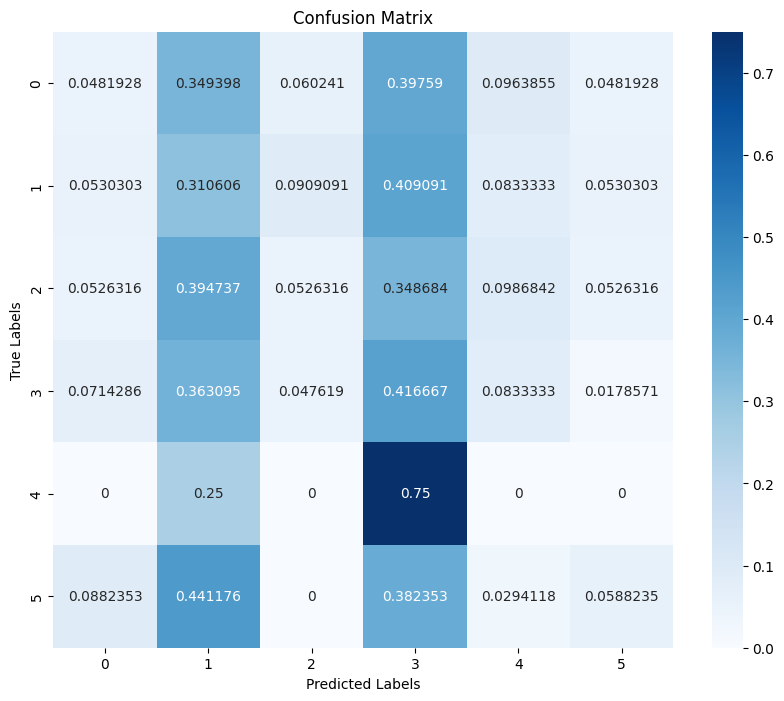

Epoch 19, Validation Loss: 1.7050, Accuracy: 0.2166, F1 Score: 0.1945
Val F1 Score Per Class  [0.06837607 0.24117647 0.08648649 0.35264484 0.         0.06896552]


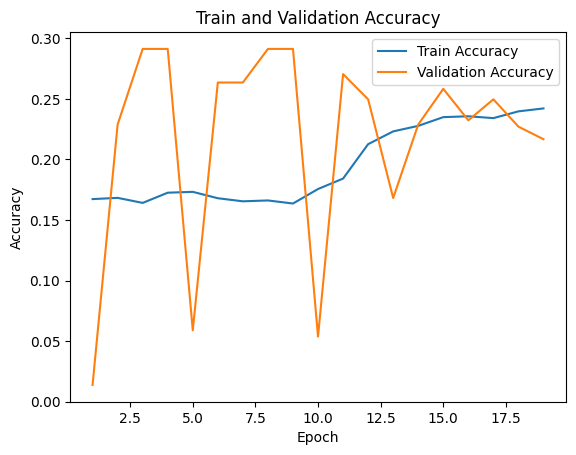

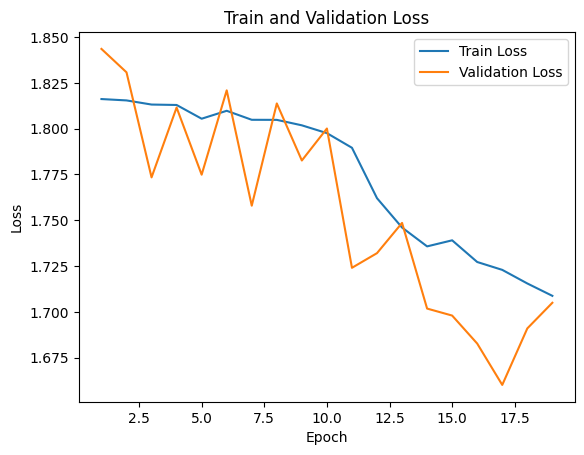

Epoch 20, Train Loss: 1.7046, Accuracy: 0.2474, F1 Score: 0.2068
Train F1 Score Per Class  [0.15371901 0.0907441  0.10635421 0.27186802 0.4607214  0.16056671]


Val:   1%|▏         | 1/73 [00:00<00:28,  2.51it/s, loss=1.75]

[tensor([-0.3606, -0.1021, -0.4188, -0.2306, -0.3995, -0.4532], device='cuda:0'), tensor([-0.1858,  0.0556, -0.3644, -0.0929, -0.3407, -0.3082], device='cuda:0'), tensor([-0.0744,  0.0772,  0.0082,  0.0928, -0.8612, -0.1107], device='cuda:0'), tensor([-0.1711,  0.0234, -0.2243, -0.0210, -1.3043, -0.1944], device='cuda:0'), tensor([-0.2769, -0.0834, -0.1999, -0.1342, -2.8885, -0.2934], device='cuda:0'), tensor([-0.0056,  0.0976, -0.1481, -0.0184, -1.6349, -0.0708], device='cuda:0'), tensor([-0.1340,  0.0199, -0.0243,  0.0400, -0.8112, -0.1213], device='cuda:0'), tensor([-0.2546, -0.0431, -0.2808, -0.1349,  0.6122, -0.3672], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:28,  2.52it/s, loss=1.79]

[tensor([-0.2127,  0.0242, -0.2691, -0.1369, -0.9260, -0.2787], device='cuda:0'), tensor([-0.1105, -0.0872, -0.1367, -0.0540, -1.2056, -0.1480], device='cuda:0'), tensor([ 0.1874, -0.0073,  0.2532,  0.2015, -1.9180,  0.2664], device='cuda:0'), tensor([-0.0061,  0.0861,  0.0589,  0.0971, -0.9337, -0.0661], device='cuda:0'), tensor([ 0.1978,  0.0234,  0.2219,  0.1417, -1.6604,  0.2548], device='cuda:0'), tensor([-0.2395,  0.0465, -0.2466, -0.0584, -0.4139, -0.3444], device='cuda:0'), tensor([ 0.1333,  0.1468,  0.1168,  0.2238, -2.7768,  0.1101], device='cuda:0'), tensor([ 0.0760,  0.0436,  0.2018,  0.1533, -1.7850,  0.0791], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:28,  2.45it/s, loss=1.67]

[tensor([-0.1436,  0.0348, -0.1784, -0.0324, -0.1491, -0.1527], device='cuda:0'), tensor([-0.0754,  0.0220, -0.0264,  0.0361, -1.1699, -0.1295], device='cuda:0'), tensor([-0.0339,  0.0842,  0.1047,  0.1522, -0.9868, -0.0406], device='cuda:0'), tensor([ 0.0472,  0.1007,  0.1689,  0.1794, -1.3696,  0.0335], device='cuda:0'), tensor([-0.0354,  0.0548, -0.0662,  0.0332, -1.9395, -0.0321], device='cuda:0'), tensor([ 0.0980,  0.1008,  0.1261,  0.2455, -3.1212,  0.1102], device='cuda:0'), tensor([-0.1385, -0.0621, -0.1465, -0.0985, -1.6721, -0.1350], device='cuda:0'), tensor([-0.1107,  0.1088, -0.0163,  0.1120, -1.6747, -0.1648], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:27,  2.47it/s, loss=1.72]

[tensor([-0.0985,  0.0863, -0.0728,  0.0327, -0.7766, -0.1785], device='cuda:0'), tensor([-0.2090, -0.0343, -0.2611, -0.0670, -0.2004, -0.2995], device='cuda:0'), tensor([-0.0468, -0.0034,  0.0591,  0.0507, -1.3847, -0.0646], device='cuda:0'), tensor([-0.2792, -0.0363, -0.3158, -0.0919, -0.5279, -0.3036], device='cuda:0'), tensor([-0.0377,  0.0763,  0.0613,  0.1375, -1.2091, -0.0734], device='cuda:0'), tensor([-0.0468, -0.0054, -0.0150,  0.0470, -1.2303, -0.0961], device='cuda:0'), tensor([ 0.1702, -0.0029,  0.2369,  0.1387, -1.6124,  0.2153], device='cuda:0'), tensor([-0.0158,  0.1384,  0.1009,  0.1319, -0.7583, -0.0418], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:27,  2.45it/s, loss=1.72]

[tensor([-0.0425,  0.1138,  0.0348,  0.1084, -1.7405, -0.0490], device='cuda:0'), tensor([-0.1351,  0.1225, -0.1387,  0.1295, -0.7040, -0.2481], device='cuda:0'), tensor([ 0.0024,  0.0308,  0.1669,  0.1453, -1.0289,  0.0337], device='cuda:0'), tensor([-0.1156, -0.0898, -0.2091, -0.1272, -0.4844, -0.1123], device='cuda:0'), tensor([ 0.0353,  0.0713,  0.0090,  0.1092, -0.8816,  0.0297], device='cuda:0'), tensor([-0.1794,  0.0622, -0.2716, -0.0998, -1.1132, -0.2336], device='cuda:0'), tensor([-0.1365, -0.0045, -0.0477, -0.0167, -0.3583, -0.1600], device='cuda:0'), tensor([ 0.0638,  0.0135,  0.1094,  0.1257, -0.9320,  0.0797], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.45it/s, loss=1.85]

[tensor([-0.1006,  0.0379, -0.0771,  0.0450, -0.7840, -0.1594], device='cuda:0'), tensor([-0.0628, -0.0307, -0.0354,  0.0329, -0.4809, -0.0306], device='cuda:0'), tensor([ 0.0215,  0.0756,  0.1100,  0.2084, -1.2087, -0.0286], device='cuda:0'), tensor([-0.0942,  0.0879, -0.0400,  0.1173, -0.0537, -0.1818], device='cuda:0'), tensor([-0.0252, -0.0702, -0.0862, -0.0325, -0.9927, -0.0353], device='cuda:0'), tensor([ 0.1490,  0.1247,  0.1616,  0.0850, -4.7691,  0.1324], device='cuda:0'), tensor([-0.0621, -0.0066, -0.1431, -0.0660, -1.5626, -0.0904], device='cuda:0'), tensor([-0.1459,  0.0657, -0.0979,  0.0413, -1.6102, -0.1943], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:26,  2.47it/s, loss=1.66]

[tensor([-0.0431,  0.0781,  0.0269,  0.1567, -0.6930, -0.0831], device='cuda:0'), tensor([ 0.0153,  0.0997,  0.1507,  0.1761, -1.7011, -0.0083], device='cuda:0'), tensor([-0.0284,  0.1119,  0.0341,  0.0694, -0.5587, -0.0076], device='cuda:0'), tensor([-0.1675, -0.0156, -0.2410, -0.0480, -0.5053, -0.1885], device='cuda:0'), tensor([-0.0450, -0.0250, -0.3200, -0.1751, -0.7154, -0.1011], device='cuda:0'), tensor([ 0.0842,  0.1726,  0.2214,  0.2807, -4.5838,  0.0736], device='cuda:0'), tensor([-0.0450,  0.0209,  0.0589,  0.0790, -2.5152, -0.0082], device='cuda:0'), tensor([-0.0429,  0.1661,  0.0304,  0.1681, -0.5707, -0.1178], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:26,  2.46it/s, loss=1.76]

[tensor([-0.1302,  0.0954, -0.1858,  0.0359, -0.3893, -0.2283], device='cuda:0'), tensor([-0.0056,  0.0758,  0.0923,  0.1233, -0.9600, -0.0064], device='cuda:0'), tensor([-0.2824, -0.0270, -0.2496, -0.0967,  0.0382, -0.3374], device='cuda:0'), tensor([-0.0248,  0.0721, -0.0607,  0.0661, -1.0976, -0.0938], device='cuda:0'), tensor([-0.1312, -0.0655, -0.0472, -0.0405, -1.3053, -0.1189], device='cuda:0'), tensor([ 0.3128,  0.1617,  0.5021,  0.3797, -2.0094,  0.3852], device='cuda:0'), tensor([-0.3567, -0.0054, -0.3232, -0.1362, -0.1965, -0.4470], device='cuda:0'), tensor([ 0.2739,  0.0432,  0.2956,  0.2014, -2.4537,  0.3635], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.46it/s, loss=1.71]

[tensor([-0.0215,  0.1021,  0.0609,  0.1599, -0.7718, -0.0271], device='cuda:0'), tensor([-0.0523,  0.0434,  0.0256,  0.1158, -1.0086, -0.0752], device='cuda:0'), tensor([-0.1303,  0.0848, -0.0647,  0.0353, -0.6083, -0.2021], device='cuda:0'), tensor([-0.1416,  0.0154, -0.0467,  0.0353, -1.6385, -0.1769], device='cuda:0'), tensor([-0.2486, -0.0252, -0.2230, -0.0878, -1.9403, -0.3078], device='cuda:0'), tensor([-0.2431,  0.0127, -0.2422, -0.0420,  0.1277, -0.3741], device='cuda:0'), tensor([-0.2410, -0.2976, -0.8532, -0.5433, -2.0076, -0.3163], device='cuda:0'), tensor([ 6.6047e-03,  3.3896e-02, -2.4891e-02,  4.2317e-02, -2.1899e+00,
         1.8787e-04], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:25,  2.45it/s, loss=1.7]

[tensor([ 0.0755,  0.1341,  0.1718,  0.1881, -1.4322,  0.0977], device='cuda:0'), tensor([ 0.1800,  0.0720,  0.2031,  0.1353, -2.0274,  0.2398], device='cuda:0'), tensor([ 0.1750,  0.0168, -0.0112, -0.0314, -4.1834,  0.2514], device='cuda:0'), tensor([-0.1209,  0.0106, -0.0762,  0.0376, -1.2330, -0.1415], device='cuda:0'), tensor([-0.2371, -0.0009, -0.1464, -0.0632, -0.8653, -0.2684], device='cuda:0'), tensor([-0.3720, -0.0261, -0.3161, -0.1316, -0.1422, -0.4421], device='cuda:0'), tensor([ 0.0632,  0.0060,  0.0152,  0.0762, -1.8415,  0.0479], device='cuda:0'), tensor([-0.1458,  0.0407, -0.0551,  0.0365, -0.5904, -0.1726], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.45it/s, loss=1.8]

[tensor([ 0.0337,  0.1228,  0.1245,  0.2097, -2.1358, -0.0170], device='cuda:0'), tensor([-0.0554,  0.0793,  0.0517,  0.1686, -1.0194, -0.0842], device='cuda:0'), tensor([-0.1354, -0.0843, -0.0816, -0.0398, -0.7523, -0.1270], device='cuda:0'), tensor([-0.0281,  0.0860, -0.0380,  0.0858, -2.8875, -0.0898], device='cuda:0'), tensor([-0.1747, -0.0598, -0.4408, -0.1952, -0.1526, -0.2979], device='cuda:0'), tensor([-0.2401,  0.0256, -0.1937, -0.0059, -1.2618, -0.2797], device='cuda:0'), tensor([-0.1577, -0.0322, -0.1950, -0.0790, -0.4873, -0.2216], device='cuda:0'), tensor([-0.0321,  0.1164,  0.0582,  0.1186, -0.7982, -0.0476], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:04<00:24,  2.45it/s, loss=1.69]

[tensor([-0.2807,  0.0033, -0.3414, -0.1809, -0.7976, -0.3947], device='cuda:0'), tensor([-0.1753,  0.0555, -0.1644, -0.0364, -0.2146, -0.2058], device='cuda:0'), tensor([-0.3461, -0.0060, -0.3047, -0.1168, -0.9471, -0.3982], device='cuda:0'), tensor([ 0.0293,  0.1049, -0.0268,  0.1102, -1.7235, -0.0688], device='cuda:0'), tensor([ 2.7946e-02,  8.8280e-04, -1.7216e-02,  1.0184e-02, -2.8997e+00,
         4.1923e-02], device='cuda:0'), tensor([-0.0357,  0.0729,  0.0572,  0.0778, -1.1116, -0.0182], device='cuda:0'), tensor([-0.1980, -0.0202, -0.1818, -0.0091, -0.5248, -0.2654], device='cuda:0'), tensor([-0.2702, -0.0951, -0.2128, -0.1173,  0.2280, -0.2901], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:24,  2.46it/s, loss=1.66]

[tensor([-0.1018,  0.0811, -0.0470,  0.0455, -0.6516, -0.1211], device='cuda:0'), tensor([-0.1355,  0.0464, -0.0997,  0.0331, -0.5414, -0.2057], device='cuda:0'), tensor([ 0.0340, -0.1012, -0.0233, -0.0437, -1.1757,  0.0096], device='cuda:0'), tensor([-0.1148,  0.0948, -0.0052,  0.0984, -0.5546, -0.1444], device='cuda:0'), tensor([-0.1803, -0.0098, -0.0799,  0.0204, -0.4204, -0.1828], device='cuda:0'), tensor([-0.0080,  0.1194,  0.1034,  0.1649, -0.8410, -0.0014], device='cuda:0'), tensor([ 6.3880e-02,  9.9978e-02,  4.1396e-02,  1.4695e-01, -1.6351e+00,
        -1.1273e-05], device='cuda:0'), tensor([ 0.1807,  0.1418,  0.1637,  0.2004, -1.2617,  0.1469], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:23,  2.46it/s, loss=1.71]

[tensor([-0.1683,  0.0208, -0.2049, -0.1167, -0.7908, -0.2486], device='cuda:0'), tensor([-0.2808, -0.1157, -0.3084, -0.1237, -2.0684, -0.4091], device='cuda:0'), tensor([-0.0439,  0.1394,  0.0441,  0.1719, -0.9079, -0.1125], device='cuda:0'), tensor([ 0.2722,  0.1123,  0.2929,  0.1983, -3.4271,  0.3063], device='cuda:0'), tensor([ 0.1970,  0.0790,  0.2654,  0.1822, -2.2458,  0.2619], device='cuda:0'), tensor([ 0.0518,  0.1030,  0.0729,  0.1439, -4.2310,  0.0295], device='cuda:0'), tensor([-0.3678, -0.1049, -0.3459, -0.2029,  0.3788, -0.4240], device='cuda:0'), tensor([-6.6866e-02,  1.2204e-01,  4.0730e-04,  8.2401e-02, -1.5210e+00,
        -1.0293e-01], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:23,  2.47it/s, loss=1.68]

[tensor([-0.0707,  0.0836,  0.0249,  0.1281, -1.1564, -0.1126], device='cuda:0'), tensor([-0.1693, -0.0254, -0.1597, -0.0820, -0.3404, -0.1778], device='cuda:0'), tensor([-0.0197,  0.1517,  0.0979,  0.1498, -0.8864, -0.0508], device='cuda:0'), tensor([-0.1305,  0.0689, -0.0407,  0.0625, -0.4444, -0.1878], device='cuda:0'), tensor([-9.7205e-02, -1.6416e-02,  1.8347e-04,  3.4127e-02, -2.1841e+00,
        -1.1592e-01], device='cuda:0'), tensor([ 0.0769,  0.0508,  0.0804,  0.1107, -3.0611,  0.0516], device='cuda:0'), tensor([ 0.0146,  0.0917,  0.1169,  0.1737, -1.2364, -0.0146], device='cuda:0'), tensor([-0.1330,  0.0290, -0.0636,  0.0842, -0.1040, -0.1918], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.46it/s, loss=1.65]

[tensor([-0.0051,  0.1559,  0.0284,  0.2147, -0.8617, -0.0930], device='cuda:0'), tensor([-0.2444, -0.0623, -0.1274, -0.0721, -0.3767, -0.2535], device='cuda:0'), tensor([ 0.0631,  0.0489,  0.1406,  0.1302, -1.1881,  0.0402], device='cuda:0'), tensor([-0.1120,  0.0601, -0.0548,  0.0502, -0.6772, -0.1840], device='cuda:0'), tensor([ 0.0039,  0.0880,  0.0826,  0.1477, -1.5206, -0.0421], device='cuda:0'), tensor([-0.2702, -0.0760, -0.1490, -0.1219, -0.9388, -0.2877], device='cuda:0'), tensor([-0.1609,  0.0499, -0.0935,  0.0398, -1.1467, -0.1950], device='cuda:0'), tensor([-0.0775,  0.0674,  0.0246,  0.0897, -0.9052, -0.1027], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:06<00:22,  2.46it/s, loss=1.69]

[tensor([-0.2022, -0.0063, -0.0955, -0.0272, -0.2104, -0.2388], device='cuda:0'), tensor([-0.0090,  0.1189,  0.0785,  0.1398, -1.0494, -0.0424], device='cuda:0'), tensor([ 0.0408,  0.1203,  0.0878,  0.2036, -0.7340, -0.0544], device='cuda:0'), tensor([-0.1164,  0.0918, -0.3491, -0.0845, -2.3001, -0.2916], device='cuda:0'), tensor([ 0.1857,  0.0090,  0.1588,  0.0469, -4.0280,  0.2255], device='cuda:0'), tensor([ 0.0913, -0.0172,  0.1201,  0.0481, -1.6263,  0.1258], device='cuda:0'), tensor([ 0.0578,  0.0138,  0.0820,  0.0675, -1.2992,  0.0505], device='cuda:0'), tensor([-0.0077,  0.1238,  0.0799,  0.1382, -0.7564, -0.0209], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.47it/s, loss=1.66]

[tensor([-0.2250,  0.0063, -0.2811, -0.1160, -0.5266, -0.2906], device='cuda:0'), tensor([-0.0782, -0.0202, -0.0795, -0.0382, -1.0055, -0.0820], device='cuda:0'), tensor([-0.1100,  0.0073, -0.0307,  0.0564, -0.3354, -0.1366], device='cuda:0'), tensor([-0.1543,  0.0351, -0.2387, -0.0744, -1.1525, -0.2601], device='cuda:0'), tensor([ 0.0987,  0.0842,  0.2134,  0.1836, -2.5756,  0.1087], device='cuda:0'), tensor([-0.1113, -0.0217, -0.0116,  0.0193, -1.1901, -0.1308], device='cuda:0'), tensor([-0.2034,  0.0270, -0.1586, -0.0128, -0.7639, -0.2875], device='cuda:0'), tensor([-0.0160,  0.0856,  0.0632,  0.1469, -1.1277, -0.0229], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:21,  2.47it/s, loss=1.71]

[tensor([ 0.2938,  0.0904,  0.3965,  0.2175, -2.2134,  0.3693], device='cuda:0'), tensor([-0.3754, -0.0856, -0.3946, -0.1789, -0.6075, -0.4900], device='cuda:0'), tensor([-0.0696,  0.0792,  0.0510,  0.1393, -0.9255, -0.0888], device='cuda:0'), tensor([-0.1884, -0.0634, -0.3299, -0.1637, -0.6126, -0.2187], device='cuda:0'), tensor([-0.0897, -0.0408,  0.0109,  0.0160, -0.8480, -0.0951], device='cuda:0'), tensor([ 0.2696,  0.1297,  0.2414,  0.2237, -2.1515,  0.2682], device='cuda:0'), tensor([-0.3577, -0.1863, -0.6660, -0.3814, -0.2760, -0.4786], device='cuda:0'), tensor([-0.1220,  0.0856, -0.0390,  0.0824, -1.9941, -0.1544], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:21,  2.47it/s, loss=1.71]

[tensor([ 0.0678,  0.1180,  0.1104,  0.2009, -1.3532,  0.0566], device='cuda:0'), tensor([-0.0149,  0.0182,  0.0853,  0.0609, -2.5216, -0.0235], device='cuda:0'), tensor([-0.1299,  0.0022, -0.2428, -0.0534, -0.7699, -0.2024], device='cuda:0'), tensor([-0.3284, -0.0262, -0.2576, -0.0905, -0.4051, -0.3897], device='cuda:0'), tensor([-0.2206, -0.0029, -0.1803, -0.0645, -0.3664, -0.2823], device='cuda:0'), tensor([-0.0150,  0.0846,  0.0720,  0.1205, -1.4226, -0.0311], device='cuda:0'), tensor([ 0.0926,  0.0661,  0.0286,  0.0616, -4.4397,  0.1099], device='cuda:0'), tensor([-0.2257,  0.0131, -0.1304, -0.0271, -0.4243, -0.2769], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.47it/s, loss=1.7]

[tensor([ 7.2495e-03,  6.3487e-02,  1.7799e-04,  9.9024e-02, -7.7754e-01,
        -7.4319e-03], device='cuda:0'), tensor([-0.0490,  0.0845,  0.0619,  0.1339, -0.8129, -0.0793], device='cuda:0'), tensor([-0.2218, -0.0105, -0.2133, -0.0509, -0.6345, -0.2928], device='cuda:0'), tensor([ 6.3740e-03,  1.2000e-01,  8.7663e-02,  1.0021e-01, -1.3668e+00,
        -6.3725e-05], device='cuda:0'), tensor([ 0.0282,  0.1018,  0.1128,  0.1656, -1.0287,  0.0217], device='cuda:0'), tensor([-0.4300, -0.2024, -0.5413, -0.3703,  0.1711, -0.4935], device='cuda:0'), tensor([-0.0771,  0.1634, -0.0166,  0.1387, -1.3378, -0.2045], device='cuda:0'), tensor([-0.0370,  0.1459,  0.0638,  0.1596, -1.0603, -0.1003], device='cuda:0')]


Val:  30%|███       | 22/73 [00:08<00:20,  2.47it/s, loss=1.67]

[tensor([-0.2315,  0.0291, -0.1136, -0.0179, -0.7496, -0.2643], device='cuda:0'), tensor([-0.0582,  0.0961,  0.0585,  0.1384, -1.0505, -0.0697], device='cuda:0'), tensor([-0.1614, -0.0448, -0.2171, -0.0847, -1.1659, -0.2245], device='cuda:0'), tensor([-0.0582,  0.0857,  0.0502,  0.1464, -0.7133, -0.1017], device='cuda:0'), tensor([-0.1987,  0.0245, -0.1443, -0.0041, -0.4084, -0.2739], device='cuda:0'), tensor([-0.0595,  0.0624,  0.0201,  0.0467, -3.2448, -0.0433], device='cuda:0'), tensor([ 0.0191,  0.0926,  0.0742,  0.1866, -0.7781, -0.0146], device='cuda:0'), tensor([ 0.0938,  0.0850,  0.2430,  0.2392, -1.2081,  0.0910], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.47it/s, loss=1.71]

[tensor([-0.1073,  0.0890, -0.0147,  0.0200, -1.4269, -0.1166], device='cuda:0'), tensor([-0.2043,  0.0068, -0.5279, -0.2049,  0.1801, -0.3496], device='cuda:0'), tensor([-0.0178,  0.1057,  0.0387,  0.0907, -1.5399, -0.0261], device='cuda:0'), tensor([-0.3070,  0.0023, -0.2461, -0.0525, -0.7866, -0.3736], device='cuda:0'), tensor([-0.1388, -0.1252, -0.1193, -0.1146, -3.6130, -0.1036], device='cuda:0'), tensor([-0.3603, -0.0328, -0.3654, -0.1585, -0.5365, -0.5033], device='cuda:0'), tensor([-0.2583,  0.0564, -0.2702, -0.0715,  0.0236, -0.4034], device='cuda:0'), tensor([-0.3003, -0.1015, -0.1803, -0.1081, -1.1066, -0.3123], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:09<00:19,  2.47it/s, loss=1.69]

[tensor([-0.3136, -0.0668, -0.2785, -0.0935, -1.2258, -0.3594], device='cuda:0'), tensor([ 0.0569, -0.0155,  0.1868,  0.1139, -1.1486,  0.0601], device='cuda:0'), tensor([ 0.0651,  0.1295,  0.1809,  0.2181, -1.4399,  0.0541], device='cuda:0'), tensor([ 8.4655e-04, -1.1252e-02, -5.0251e-02,  4.3293e-03, -2.4059e+00,
        -3.7177e-02], device='cuda:0'), tensor([-0.3777, -0.0877, -0.3322, -0.2122, -2.1767, -0.4206], device='cuda:0'), tensor([-0.0834,  0.1052, -0.0075,  0.1037, -0.5698, -0.1461], device='cuda:0'), tensor([-0.1273,  0.0057, -0.0561,  0.0542, -0.8299, -0.1682], device='cuda:0'), tensor([ 0.2889,  0.1019,  0.2249,  0.2137, -2.3658,  0.3452], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:19,  2.45it/s, loss=1.76]

[tensor([-0.2135,  0.0372, -0.2625, -0.1056, -0.4316, -0.2739], device='cuda:0'), tensor([-0.4612, -0.1470, -0.6603, -0.3945,  0.2732, -0.5976], device='cuda:0'), tensor([-0.2169, -0.0392, -0.2420, -0.0848, -0.7158, -0.2590], device='cuda:0'), tensor([-0.1944,  0.0287, -0.0955,  0.0308, -0.7475, -0.2475], device='cuda:0'), tensor([-0.1964,  0.0129, -0.1354,  0.0024, -0.2619, -0.2889], device='cuda:0'), tensor([-0.2404,  0.0033, -0.1591, -0.0328, -0.3879, -0.2882], device='cuda:0'), tensor([-0.0947,  0.0821, -0.0411,  0.0758, -0.9195, -0.1741], device='cuda:0'), tensor([-0.3090, -0.0732, -0.1777, -0.0959, -1.8539, -0.3074], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.44it/s, loss=1.7]

[tensor([-0.0953,  0.0539, -0.0504,  0.0469, -0.7483, -0.1485], device='cuda:0'), tensor([-0.2572,  0.0110, -0.1848, -0.0417, -0.2779, -0.3349], device='cuda:0'), tensor([ 0.8450,  0.2963,  0.8235,  0.5270, -4.3123,  0.9617], device='cuda:0'), tensor([-0.0102,  0.0626,  0.1013,  0.1251, -1.4428, -0.0180], device='cuda:0'), tensor([-0.1394, -0.0153, -0.0860, -0.0223, -1.0618, -0.1517], device='cuda:0'), tensor([-0.0413,  0.0555,  0.0979,  0.1340, -0.6520, -0.0337], device='cuda:0'), tensor([ 0.0663,  0.1270,  0.1100,  0.1841, -2.3736,  0.0742], device='cuda:0'), tensor([-0.1914, -0.0171, -0.1102, -0.0430, -1.0260, -0.1928], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:10<00:18,  2.44it/s, loss=1.69]

[tensor([ 0.2082,  0.0790,  0.3075,  0.2747, -1.4198,  0.2255], device='cuda:0'), tensor([-0.0994,  0.0124, -0.0458, -0.0067, -1.0626, -0.1300], device='cuda:0'), tensor([-0.4079, -0.0453, -0.4193, -0.2247, -0.6567, -0.5325], device='cuda:0'), tensor([ 0.0020,  0.1495,  0.0642,  0.2105, -0.6140, -0.0700], device='cuda:0'), tensor([-0.0495,  0.1108,  0.0643,  0.1261, -0.8323, -0.0778], device='cuda:0'), tensor([-0.3550, -0.0727, -0.3870, -0.1795, -1.1299, -0.4106], device='cuda:0'), tensor([ 0.0313,  0.0645,  0.0841,  0.1343, -0.6985,  0.0041], device='cuda:0'), tensor([-0.2447, -0.0343, -0.1762, -0.0763, -1.3834, -0.2466], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.45it/s, loss=1.66]

[tensor([-0.1446, -0.0101, -0.2614, -0.1126, -0.4060, -0.2297], device='cuda:0'), tensor([ 0.0736,  0.0813,  0.2289,  0.1744, -2.2247,  0.0799], device='cuda:0'), tensor([-0.3619, -0.1630, -0.4510, -0.2568, -3.6938, -0.4520], device='cuda:0'), tensor([-0.2290,  0.0595, -0.1738, -0.0603, -0.4513, -0.3021], device='cuda:0'), tensor([-0.1974,  0.0581, -0.1848, -0.0104, -0.9615, -0.2728], device='cuda:0'), tensor([-0.1662, -0.0130, -0.1520, -0.0260, -1.8545, -0.2495], device='cuda:0'), tensor([-1.8371e-02,  3.6620e-04, -6.6417e-02,  2.0090e-02, -2.1075e+00,
        -7.3071e-02], device='cuda:0'), tensor([ 3.9128e-02,  7.7110e-02,  6.9301e-02,  1.6195e-01, -9.3393e-01,
         6.0512e-04], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:11<00:17,  2.45it/s, loss=1.64]

[tensor([ 0.0842,  0.0661,  0.2214,  0.1929, -1.8434,  0.1355], device='cuda:0'), tensor([-0.2983, -0.0846, -0.2447, -0.1189, -1.8067, -0.3895], device='cuda:0'), tensor([-0.1157,  0.0797, -0.0064,  0.0958, -0.3650, -0.1448], device='cuda:0'), tensor([-0.0538,  0.0562,  0.0222,  0.1031, -1.5504, -0.0825], device='cuda:0'), tensor([-0.2607,  0.0090, -0.2354, -0.0706, -0.1434, -0.3404], device='cuda:0'), tensor([-0.0438,  0.1280,  0.0539,  0.1685, -0.9158, -0.0637], device='cuda:0'), tensor([-0.1584,  0.0217, -0.1011,  0.0460, -0.8458, -0.2174], device='cuda:0'), tensor([-0.0097,  0.0958,  0.0535,  0.1787, -0.4724, -0.0854], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.46it/s, loss=1.66]

[tensor([-0.1895,  0.0098, -0.1393, -0.0075, -0.9650, -0.2159], device='cuda:0'), tensor([-0.0900,  0.1257, -0.0241,  0.0788, -1.1185, -0.1296], device='cuda:0'), tensor([-0.2522, -0.0100, -0.2829, -0.1055, -0.7632, -0.3396], device='cuda:0'), tensor([ 0.0428,  0.0407,  0.1439,  0.1329, -1.0380,  0.0727], device='cuda:0'), tensor([-0.2052,  0.0067, -0.1393, -0.0162, -1.8909, -0.2679], device='cuda:0'), tensor([-0.1295,  0.0427, -0.0387,  0.0505, -0.4425, -0.1803], device='cuda:0'), tensor([-0.1188,  0.0278, -0.0830,  0.0462, -1.1136, -0.1729], device='cuda:0'), tensor([-0.3199, -0.0883, -0.3147, -0.1635,  0.4902, -0.4104], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.46it/s, loss=1.67]

[tensor([ 0.4163,  0.1753,  0.4657,  0.3236, -2.4780,  0.4804], device='cuda:0'), tensor([-0.0660, -0.0280, -0.0048, -0.0026, -0.4465, -0.0961], device='cuda:0'), tensor([-0.1484,  0.0424, -0.0747,  0.0443, -1.4286, -0.2207], device='cuda:0'), tensor([-0.0123,  0.1291,  0.0240,  0.1419, -0.6904, -0.0320], device='cuda:0'), tensor([-0.0336,  0.0888,  0.0372,  0.1403, -0.9647, -0.0968], device='cuda:0'), tensor([-0.1969,  0.0209, -0.1528, -0.0396, -0.4420, -0.2414], device='cuda:0'), tensor([ 0.6236, -0.0314, -0.2749, -0.2632, -4.3817,  0.4771], device='cuda:0'), tensor([-0.0836,  0.0362,  0.0328,  0.1089, -1.7659, -0.0802], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:16,  2.45it/s, loss=1.66]

[tensor([-0.0657,  0.1002, -0.0295,  0.0676, -1.3414, -0.1228], device='cuda:0'), tensor([-0.2126,  0.0148, -0.1237, -0.0111, -0.5437, -0.2813], device='cuda:0'), tensor([ 0.0346, -0.0511, -0.0185, -0.0385, -1.2532,  0.0411], device='cuda:0'), tensor([-0.1973, -0.0133, -0.2012, -0.0676, -0.6876, -0.2359], device='cuda:0'), tensor([-0.1134, -0.0972, -0.0756, -0.0401, -0.6542, -0.0824], device='cuda:0'), tensor([ 0.0261,  0.1299,  0.1311,  0.1570, -2.8159, -0.0150], device='cuda:0'), tensor([-0.0045,  0.0591,  0.0335,  0.1336, -1.5510, -0.0306], device='cuda:0'), tensor([-0.0180,  0.1114,  0.1067,  0.1553, -1.2166, -0.0189], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.45it/s, loss=1.65]

[tensor([-0.0283,  0.0993,  0.0856,  0.1294, -0.7873, -0.0507], device='cuda:0'), tensor([-0.1557, -0.0086, -0.1608, -0.0531, -1.0337, -0.1828], device='cuda:0'), tensor([-0.2951,  0.0980, -0.2931, -0.0548, -0.7664, -0.4433], device='cuda:0'), tensor([-0.0888,  0.0284, -0.0491,  0.0422, -0.9076, -0.1521], device='cuda:0'), tensor([ 0.0256,  0.0998,  0.0686,  0.0695, -2.0317,  0.0036], device='cuda:0'), tensor([ 0.1170, -0.0408, -0.1711, -0.1011, -2.9308,  0.0823], device='cuda:0'), tensor([-0.0088,  0.1040,  0.1392,  0.1551, -0.9944, -0.0229], device='cuda:0'), tensor([-0.0893,  0.0864,  0.0025,  0.0924, -0.5469, -0.1609], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:13<00:15,  2.45it/s, loss=1.65]

[tensor([ 0.2759,  0.0635,  0.3358,  0.1991, -2.3837,  0.3504], device='cuda:0'), tensor([ 0.2714,  0.1608,  0.2809,  0.2452, -1.8579,  0.2667], device='cuda:0'), tensor([-0.3481, -0.0444, -0.3125, -0.1710, -0.8423, -0.4389], device='cuda:0'), tensor([ 0.0129,  0.0529,  0.0742,  0.1088, -1.2371, -0.0320], device='cuda:0'), tensor([-0.1735, -0.0413, -0.3408, -0.1609, -0.3349, -0.3021], device='cuda:0'), tensor([ 0.0368,  0.1400,  0.0572,  0.1798, -1.0477, -0.0017], device='cuda:0'), tensor([-0.2214, -0.0040, -0.1472, -0.0316, -0.2621, -0.2894], device='cuda:0'), tensor([-0.0579, -0.0375,  0.0527,  0.0596, -0.7838, -0.0404], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.45it/s, loss=1.66]

[tensor([ 0.2265,  0.0616,  0.2022,  0.1483, -3.1045,  0.2984], device='cuda:0'), tensor([-0.0212,  0.1202,  0.0664,  0.1753, -0.7126, -0.1085], device='cuda:0'), tensor([-0.2065, -0.1555, -0.3468, -0.2795, -2.4024, -0.2333], device='cuda:0'), tensor([ 0.0426,  0.0670,  0.1296,  0.1545, -1.1613,  0.0314], device='cuda:0'), tensor([-0.0955,  0.0363,  0.0142,  0.1012, -0.2626, -0.1239], device='cuda:0'), tensor([ 0.0458,  0.0982,  0.1246,  0.1778, -1.5576,  0.0524], device='cuda:0'), tensor([ 0.0263, -0.0188, -0.1123,  0.0039, -2.0542, -0.0230], device='cuda:0'), tensor([-0.0218,  0.0105,  0.0793,  0.1443, -0.4904, -0.0724], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:14<00:15,  2.45it/s, loss=1.62]

[tensor([-0.0523,  0.0093, -0.1236, -0.0357, -1.7071, -0.1060], device='cuda:0'), tensor([-0.2243,  0.0468, -0.1494,  0.0120, -0.7063, -0.2913], device='cuda:0'), tensor([ 0.2175,  0.2065,  0.1896,  0.2890, -1.6548,  0.1619], device='cuda:0'), tensor([-0.0493, -0.0349,  0.0027,  0.0312, -1.1905, -0.0975], device='cuda:0'), tensor([ 0.2366,  0.1651,  0.0828,  0.2072, -2.3395,  0.1444], device='cuda:0'), tensor([-0.3744, -0.2310, -0.8513, -0.5541, -2.6632, -0.5535], device='cuda:0'), tensor([ 0.1340,  0.1743,  0.1898,  0.2409, -1.3143,  0.1262], device='cuda:0'), tensor([ 0.0108,  0.0966,  0.0342,  0.0789, -0.7241, -0.0368], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:14,  2.45it/s, loss=1.77]

[tensor([-0.0622,  0.0138, -0.0756, -0.0008, -0.5560, -0.1057], device='cuda:0'), tensor([-0.0916,  0.1333, -0.0154,  0.1050, -0.6765, -0.1470], device='cuda:0'), tensor([-0.0841,  0.0393,  0.0018,  0.1130, -1.2391, -0.0991], device='cuda:0'), tensor([ 0.0243,  0.1273,  0.0291,  0.1511, -1.9008, -0.0205], device='cuda:0'), tensor([-0.2136,  0.0728, -0.1476,  0.0217, -0.6990, -0.2730], device='cuda:0'), tensor([-0.0430,  0.0374,  0.0534,  0.0916, -1.0420, -0.0548], device='cuda:0'), tensor([-0.0921,  0.0506,  0.0151,  0.1051, -0.8203, -0.1121], device='cuda:0'), tensor([-0.1012,  0.1103,  0.0151,  0.0902, -1.5057, -0.1456], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.45it/s, loss=1.6]

[tensor([-0.0811, -0.0529, -0.2477, -0.1369, -0.9305, -0.1475], device='cuda:0'), tensor([-0.1991,  0.0037, -0.1242,  0.0091, -1.5883, -0.2284], device='cuda:0'), tensor([-0.1299,  0.0375, -0.0728,  0.0112, -0.3877, -0.1548], device='cuda:0'), tensor([ 0.1991,  0.0787,  0.0335,  0.0727, -3.2107,  0.2109], device='cuda:0'), tensor([-0.1371, -0.0405,  0.0229,  0.0316, -3.2742, -0.0980], device='cuda:0'), tensor([-0.1826,  0.0523, -0.1162,  0.0351, -0.6017, -0.2537], device='cuda:0'), tensor([-0.0946, -0.0073, -0.1104,  0.0545, -1.3465, -0.1375], device='cuda:0'), tensor([-0.0142,  0.0901, -0.0624,  0.0448, -1.3046, -0.0828], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:15<00:13,  2.45it/s, loss=1.64]

[tensor([-0.2555, -0.0645, -0.2243, -0.0927, -0.8368, -0.2946], device='cuda:0'), tensor([ 0.2376,  0.0833,  0.1627,  0.1822, -3.0770,  0.2230], device='cuda:0'), tensor([ 0.0215,  0.0771,  0.0281,  0.0776, -1.4574,  0.0179], device='cuda:0'), tensor([-0.1426, -0.0737, -0.1643, -0.0913, -0.6736, -0.1462], device='cuda:0'), tensor([-0.0368, -0.0888,  0.1033,  0.0491, -3.4034,  0.0332], device='cuda:0'), tensor([-0.0949,  0.0254,  0.0137,  0.0803, -0.5919, -0.1537], device='cuda:0'), tensor([-0.0536,  0.0780,  0.0213,  0.1013, -1.2439, -0.0844], device='cuda:0'), tensor([-0.1413,  0.0646, -0.0229,  0.0548, -0.8867, -0.1754], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.45it/s, loss=1.65]

[tensor([-0.0416,  0.1062,  0.0065,  0.1033, -1.2119, -0.0801], device='cuda:0'), tensor([-0.1501,  0.0458, -0.1114,  0.0237, -0.8457, -0.1843], device='cuda:0'), tensor([-0.0782, -0.0073,  0.0629,  0.0467, -2.5977, -0.0340], device='cuda:0'), tensor([-0.0521,  0.0667,  0.0481,  0.0883, -2.2092, -0.0841], device='cuda:0'), tensor([-0.0315,  0.1107,  0.0163,  0.1354, -0.9564, -0.0175], device='cuda:0'), tensor([ 0.0450,  0.0173,  0.1366,  0.1283, -2.9592,  0.0621], device='cuda:0'), tensor([-2.3236e-02, -1.4809e-02, -5.4430e-04,  4.9428e-02, -5.4727e-01,
        -1.3974e-02], device='cuda:0'), tensor([-9.0359e-02, -6.3083e-02,  3.1524e-02,  9.1225e-04, -1.7034e+00,
        -6.0911e-02], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:16<00:13,  2.45it/s, loss=1.65]

[tensor([-0.3268, -0.1508, -0.2668, -0.1907, -2.7135, -0.3480], device='cuda:0'), tensor([-0.3808, -0.0451, -0.3367, -0.1590,  0.0475, -0.4921], device='cuda:0'), tensor([-0.1733,  0.0362, -0.0829,  0.0147, -0.6649, -0.2450], device='cuda:0'), tensor([-0.2652,  0.0230, -0.2080, -0.0367, -1.9004, -0.3476], device='cuda:0'), tensor([-1.1698e-03,  9.5911e-02,  5.1775e-02,  1.7452e-01, -1.3081e+00,
        -6.7559e-02], device='cuda:0'), tensor([-0.0477,  0.0670,  0.1034,  0.1175, -1.3909, -0.0437], device='cuda:0'), tensor([-0.1265, -0.0457, -0.2834, -0.1837, -0.9022, -0.2047], device='cuda:0'), tensor([-0.1776, -0.0094, -0.3371, -0.1942, -0.4036, -0.2343], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.45it/s, loss=1.71]

[tensor([-1.3368e-01,  2.7187e-04, -5.0525e-01, -1.8821e-01, -1.0243e+00,
        -3.6545e-01], device='cuda:0'), tensor([-0.2542, -0.0165, -0.1533, -0.0407, -0.6994, -0.3241], device='cuda:0'), tensor([ 0.1268,  0.1250,  0.1306,  0.1291, -4.4562,  0.0926], device='cuda:0'), tensor([-0.2310,  0.0402, -0.2088, -0.0680, -1.0012, -0.3195], device='cuda:0'), tensor([ 0.0551,  0.0415,  0.1244,  0.1789, -1.8299,  0.0363], device='cuda:0'), tensor([ 0.0837,  0.1522,  0.1575,  0.1542, -3.3351,  0.0665], device='cuda:0'), tensor([-0.2462, -0.0222, -0.1830, -0.0665, -0.0660, -0.2660], device='cuda:0'), tensor([-0.3030, -0.0474, -0.2167, -0.0979,  0.1426, -0.3518], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.46it/s, loss=1.8]

[tensor([-0.3625, -0.0536, -0.4584, -0.1728,  0.0462, -0.5208], device='cuda:0'), tensor([-0.4648, -0.2188, -0.8966, -0.5417, -0.3383, -0.6830], device='cuda:0'), tensor([-0.1390,  0.0102, -0.0876,  0.0220, -0.1989, -0.1972], device='cuda:0'), tensor([-0.1050,  0.0433, -0.0292,  0.0673, -0.7306, -0.1725], device='cuda:0'), tensor([-0.2564,  0.0413, -0.2436, -0.0604, -0.5226, -0.3641], device='cuda:0'), tensor([-0.2973, -0.1371, -0.4556, -0.3161, -1.1936, -0.4255], device='cuda:0'), tensor([-0.3134, -0.0522, -0.4142, -0.2234, -0.5039, -0.4231], device='cuda:0'), tensor([-0.2334, -0.0540, -0.3677, -0.1926, -0.0861, -0.2871], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:17<00:11,  2.46it/s, loss=1.65]

[tensor([ 0.2035, -0.0910,  0.1123,  0.0396, -3.6441,  0.2660], device='cuda:0'), tensor([ 0.0291,  0.1037,  0.1013,  0.1338, -0.7413, -0.0054], device='cuda:0'), tensor([-2.1041e-01, -1.0749e-03, -7.1261e-02, -6.9654e-03, -1.1319e+00,
        -1.9688e-01], device='cuda:0'), tensor([-0.0423,  0.0353, -0.0756,  0.0473, -0.2931, -0.1002], device='cuda:0'), tensor([-0.2219,  0.0616, -0.1602,  0.0093, -1.0822, -0.3077], device='cuda:0'), tensor([-0.0596,  0.0398,  0.0417,  0.0957, -1.0621, -0.0710], device='cuda:0'), tensor([-0.1532,  0.0081, -0.2429, -0.0650, -0.1724, -0.2434], device='cuda:0'), tensor([-0.1278, -0.0400, -0.0966,  0.0135, -0.0827, -0.1219], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.46it/s, loss=1.67]

[tensor([-0.0792,  0.0754,  0.0070,  0.1332, -1.1344, -0.1238], device='cuda:0'), tensor([-0.0280,  0.0988, -0.0033,  0.1312, -1.1382, -0.0736], device='cuda:0'), tensor([-0.0619,  0.0696,  0.0147,  0.1047, -1.3127, -0.0531], device='cuda:0'), tensor([-0.1132,  0.0188, -0.0728,  0.0203, -1.1000, -0.1597], device='cuda:0'), tensor([-0.2512,  0.0196, -0.2423, -0.0716, -0.2097, -0.3264], device='cuda:0'), tensor([-1.2322e-01, -6.4977e-02,  1.3061e-03,  4.3160e-03, -1.3824e+00,
        -6.7427e-02], device='cuda:0'), tensor([-0.0025,  0.1562,  0.0904,  0.2258, -0.8791, -0.0727], device='cuda:0'), tensor([-0.1059, -0.0289,  0.0383,  0.0453, -0.4160, -0.0653], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:18<00:11,  2.45it/s, loss=1.6]

[tensor([-0.3009,  0.0283, -0.2789, -0.0983, -1.0064, -0.4146], device='cuda:0'), tensor([-0.2076,  0.0010, -0.1421, -0.0322, -0.6615, -0.2451], device='cuda:0'), tensor([-0.3170, -0.0930, -0.2245, -0.1799, -2.7375, -0.3633], device='cuda:0'), tensor([ 0.2596,  0.1349,  0.4094,  0.3086, -2.7089,  0.3171], device='cuda:0'), tensor([ 0.0739,  0.0419, -0.0674,  0.0177, -2.2958,  0.0823], device='cuda:0'), tensor([-0.3117,  0.0350, -0.2042, -0.0473, -0.2916, -0.3841], device='cuda:0'), tensor([-0.0345,  0.1205,  0.0222,  0.1466, -1.3225, -0.0629], device='cuda:0'), tensor([-0.0307,  0.0134, -0.0374,  0.0057, -2.0240, -0.0594], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.44it/s, loss=1.65]

[tensor([-0.0056,  0.0460,  0.0645,  0.1320, -2.9384, -0.0080], device='cuda:0'), tensor([ 0.0232,  0.1201,  0.1032,  0.1453, -1.7113,  0.0411], device='cuda:0'), tensor([-0.0527,  0.1193,  0.0330,  0.1217, -0.8672, -0.0542], device='cuda:0'), tensor([-0.1170,  0.0335, -0.0527,  0.0715, -0.4749, -0.1274], device='cuda:0'), tensor([-0.0649,  0.0514,  0.0342,  0.0742, -1.1218, -0.0732], device='cuda:0'), tensor([-0.0126,  0.0910, -0.0293,  0.0964, -1.9923, -0.0437], device='cuda:0'), tensor([ 0.0263,  0.0431,  0.1674,  0.1591, -1.0159,  0.0714], device='cuda:0'), tensor([-0.2115,  0.0593, -0.1960, -0.0540, -2.6761, -0.2617], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:19<00:10,  2.44it/s, loss=1.69]

[tensor([-0.4210, -0.1028, -0.4153, -0.2126,  0.9286, -0.5159], device='cuda:0'), tensor([ 0.2923,  0.1256,  0.4060,  0.3072, -3.1346,  0.3642], device='cuda:0'), tensor([ 0.0046,  0.0947,  0.1027,  0.1982, -1.0554, -0.0562], device='cuda:0'), tensor([-0.1318,  0.0599, -0.1066, -0.0713, -1.1850, -0.1750], device='cuda:0'), tensor([-0.2007,  0.0097, -0.2872, -0.0822, -0.3626, -0.2818], device='cuda:0'), tensor([-0.2475, -0.0222, -0.2247, -0.0374,  0.1030, -0.3031], device='cuda:0'), tensor([-0.2482,  0.0325, -0.2207, -0.0522, -1.4933, -0.3628], device='cuda:0'), tensor([-0.0818,  0.0552, -0.0642,  0.0540, -1.0031, -0.1245], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:19<00:09,  2.44it/s, loss=1.67]

[tensor([-0.1367,  0.0038, -0.2676, -0.1851, -2.7925, -0.2096], device='cuda:0'), tensor([-0.0988,  0.0919, -0.1061,  0.0540, -0.6610, -0.1645], device='cuda:0'), tensor([-0.0790,  0.1156,  0.0277,  0.1518, -1.0033, -0.1362], device='cuda:0'), tensor([-0.1181,  0.1021, -0.0599,  0.0871, -1.2277, -0.1938], device='cuda:0'), tensor([ 0.0452,  0.0882,  0.0071,  0.0915, -1.1323,  0.0208], device='cuda:0'), tensor([-0.0343,  0.0106,  0.0921,  0.1327, -0.8397, -0.0401], device='cuda:0'), tensor([ 0.0221,  0.1329,  0.0554,  0.1893, -1.5692,  0.0120], device='cuda:0'), tensor([ 0.0929,  0.0818,  0.1952,  0.1687, -2.1542,  0.0625], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.44it/s, loss=1.81]

[tensor([-0.2829,  0.0333, -0.2226, -0.0563, -0.0247, -0.3816], device='cuda:0'), tensor([-0.2567, -0.0359, -0.1320, -0.0634, -0.8903, -0.2717], device='cuda:0'), tensor([-0.2086,  0.0706, -0.1292,  0.0127, -0.3086, -0.2645], device='cuda:0'), tensor([-0.2831,  0.0269, -0.2696, -0.1099,  0.3307, -0.3588], device='cuda:0'), tensor([-0.0533,  0.1651,  0.0243,  0.1958, -1.0914, -0.1195], device='cuda:0'), tensor([-0.1019,  0.0228, -0.0050,  0.0733, -1.0917, -0.1219], device='cuda:0'), tensor([-0.0736,  0.0758,  0.0506,  0.1017, -0.4502, -0.0848], device='cuda:0'), tensor([-0.0187,  0.0230,  0.0359,  0.1138, -0.6364, -0.0857], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:20<00:08,  2.45it/s, loss=1.6]

[tensor([-0.0872,  0.1233, -0.1013,  0.0145, -0.5576, -0.1496], device='cuda:0'), tensor([ 0.0785,  0.0978, -0.0182,  0.0712, -1.3085,  0.0717], device='cuda:0'), tensor([-0.1780,  0.0409, -0.1224,  0.0488, -0.6495, -0.2611], device='cuda:0'), tensor([ 0.0730,  0.1953,  0.0541,  0.2735, -0.8555, -0.0215], device='cuda:0'), tensor([-0.1083, -0.0246,  0.0285,  0.0434, -0.5930, -0.0966], device='cuda:0'), tensor([-0.0986,  0.0060,  0.0217,  0.0207, -0.7010, -0.0638], device='cuda:0'), tensor([ 0.2535, -0.0402,  0.3343,  0.1294, -3.6465,  0.3579], device='cuda:0'), tensor([ 0.2813,  0.0590,  0.2251,  0.1909, -2.4442,  0.2430], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.46it/s, loss=1.66]

[tensor([-0.1354,  0.0107, -0.0924,  0.0243, -0.4409, -0.1527], device='cuda:0'), tensor([-2.9042e-01,  4.0754e-04, -2.5365e-01, -9.0080e-02, -1.4136e+00,
        -3.1938e-01], device='cuda:0'), tensor([-0.3622, -0.0618, -0.3842, -0.1925, -0.9608, -0.4822], device='cuda:0'), tensor([-0.0241,  0.0036, -0.0453,  0.0518, -0.5365, -0.0323], device='cuda:0'), tensor([ 0.3261,  0.2145,  0.4161,  0.4424, -2.3933,  0.3331], device='cuda:0'), tensor([ 0.0798,  0.0154, -0.0443,  0.0638, -1.6255,  0.0616], device='cuda:0'), tensor([-0.2877, -0.0839, -0.2084, -0.0783, -0.3149, -0.3161], device='cuda:0'), tensor([-0.2608, -0.0578, -0.1760, -0.0594, -0.6671, -0.3000], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:21<00:08,  2.46it/s, loss=1.62]

[tensor([-0.2161, -0.0099, -0.2166, -0.0694, -1.1261, -0.2866], device='cuda:0'), tensor([ 0.4044,  0.1568,  0.4332,  0.3220, -3.3278,  0.4791], device='cuda:0'), tensor([-0.1040,  0.0370, -0.0771,  0.0467, -0.8620, -0.1670], device='cuda:0'), tensor([-0.1929, -0.1283, -0.2805, -0.2119, -2.5445, -0.2445], device='cuda:0'), tensor([ 0.0630,  0.1592,  0.1125,  0.1594, -1.1427,  0.0108], device='cuda:0'), tensor([-0.2023,  0.0455, -0.1298, -0.0025, -0.4964, -0.2520], device='cuda:0'), tensor([ 0.0212,  0.0813,  0.1699,  0.1695, -1.9713,  0.0259], device='cuda:0'), tensor([ 0.0824,  0.0561,  0.1858,  0.2090, -1.2637,  0.0938], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:21<00:07,  2.45it/s, loss=1.72]

[tensor([-0.7362, -0.1400, -0.8457, -0.4697, -1.7974, -0.9253], device='cuda:0'), tensor([-0.4032, -0.1988, -0.3575, -0.2731, -0.1221, -0.4416], device='cuda:0'), tensor([-0.0352,  0.0767,  0.0587,  0.1036, -0.9821, -0.0762], device='cuda:0'), tensor([-0.2011,  0.0024, -0.1423, -0.0410, -0.8858, -0.2315], device='cuda:0'), tensor([-0.0353,  0.1246,  0.0885,  0.1684, -1.0020, -0.0898], device='cuda:0'), tensor([-0.0867, -0.0018, -0.0813, -0.0092, -0.7346, -0.1433], device='cuda:0'), tensor([-0.0160,  0.1743,  0.0853,  0.1754, -1.0148, -0.0809], device='cuda:0'), tensor([-0.5561, -0.2816, -0.7718, -0.5009, -0.9333, -0.6883], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.46it/s, loss=1.67]

[tensor([ 0.2185,  0.0862,  0.2743,  0.1612, -2.2117,  0.2853], device='cuda:0'), tensor([ 0.1575,  0.0981,  0.2622,  0.2003, -2.8312,  0.1906], device='cuda:0'), tensor([-0.1920,  0.0244, -0.1827, -0.0672, -0.7160, -0.2457], device='cuda:0'), tensor([-1.5256e-02, -4.4229e-03, -1.2587e-01, -1.4832e-03, -1.8912e+00,
        -5.1088e-02], device='cuda:0'), tensor([-0.1506,  0.0386, -0.0925,  0.0580, -1.4388, -0.2424], device='cuda:0'), tensor([ 0.0269,  0.0249,  0.1652,  0.1854, -1.4500,  0.0361], device='cuda:0'), tensor([-0.3219,  0.0235, -0.2700, -0.1079, -0.8138, -0.4175], device='cuda:0'), tensor([-0.2103, -0.0744, -0.2474, -0.1640, -0.5150, -0.2624], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:22<00:06,  2.47it/s, loss=1.63]

[tensor([-0.0046,  0.1154, -0.0134,  0.0851, -1.7439, -0.0455], device='cuda:0'), tensor([-0.1242,  0.0616, -0.0601,  0.0555, -0.7821, -0.1935], device='cuda:0'), tensor([-0.1116,  0.1069,  0.0030,  0.0991, -0.7912, -0.1422], device='cuda:0'), tensor([-0.0989, -0.0122, -0.1240,  0.0662, -1.9063, -0.1255], device='cuda:0'), tensor([-0.0204,  0.0464, -0.0959,  0.0148, -1.1016, -0.0750], device='cuda:0'), tensor([-0.0199,  0.0905,  0.0382,  0.0802, -1.1000, -0.0320], device='cuda:0'), tensor([-0.0308,  0.1684,  0.0305,  0.1834, -0.5961, -0.1142], device='cuda:0'), tensor([-0.2579, -0.0437, -0.3831, -0.2402, -0.5421, -0.3898], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.46it/s, loss=1.74]

[tensor([-0.3058, -0.0240, -0.2091, -0.1190,  0.1472, -0.3652], device='cuda:0'), tensor([-0.1313,  0.1117, -0.2127,  0.0189, -0.7644, -0.2567], device='cuda:0'), tensor([ 0.0618,  0.0646,  0.0954,  0.1809, -0.7649,  0.0402], device='cuda:0'), tensor([-0.0927,  0.0633, -0.0447,  0.1087, -1.0668, -0.1473], device='cuda:0'), tensor([-0.1737, -0.0785, -0.2825, -0.1502, -0.3178, -0.2613], device='cuda:0'), tensor([-0.3516, -0.0544, -0.4266, -0.1718, -0.9059, -0.4421], device='cuda:0'), tensor([ 0.0786,  0.0418,  0.1198,  0.1060, -1.8684,  0.1354], device='cuda:0'), tensor([-0.2348,  0.0219, -0.1852, -0.0256, -0.6766, -0.3366], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:23<00:06,  2.46it/s, loss=1.72]

[tensor([-0.1964,  0.0290, -0.1759, -0.0471, -2.8495, -0.2364], device='cuda:0'), tensor([-0.3359, -0.0060, -0.3356, -0.1201, -0.8067, -0.4217], device='cuda:0'), tensor([-0.0496,  0.1286,  0.0179,  0.0852, -1.2136, -0.1141], device='cuda:0'), tensor([-0.1342, -0.0676, -0.2368, -0.0749, -1.0092, -0.2121], device='cuda:0'), tensor([-0.1130, -0.0376, -0.1254, -0.0183, -0.4770, -0.1396], device='cuda:0'), tensor([-0.2413,  0.0159, -0.2546, -0.0672, -0.1853, -0.3661], device='cuda:0'), tensor([-0.1966,  0.0265, -0.2049, -0.0781, -0.3598, -0.2618], device='cuda:0'), tensor([-0.4258, -0.1185, -0.4353, -0.2273, -0.1864, -0.5476], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.46it/s, loss=1.71]

[tensor([-0.2308, -0.0417, -0.1837, -0.0682, -1.0065, -0.2578], device='cuda:0'), tensor([-0.1587,  0.0816, -0.1485,  0.0217, -1.0294, -0.2496], device='cuda:0'), tensor([-0.1280,  0.0225, -0.0951, -0.0236, -0.6630, -0.1142], device='cuda:0'), tensor([-0.3038, -0.0950, -0.4454, -0.2277,  0.2541, -0.3952], device='cuda:0'), tensor([-0.0306,  0.0922,  0.0633,  0.1851, -1.3471, -0.0659], device='cuda:0'), tensor([ 0.0590,  0.0941, -0.0876,  0.0411, -0.9400,  0.0370], device='cuda:0'), tensor([-0.3696,  0.0501, -0.4300, -0.1158, -0.7752, -0.5308], device='cuda:0'), tensor([-0.1626, -0.0226, -0.2136, -0.1228, -3.0282, -0.1964], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:24<00:05,  2.45it/s, loss=1.66]

[tensor([-0.1048,  0.0225, -0.1005, -0.0179, -0.2796, -0.1203], device='cuda:0'), tensor([-0.0716,  0.0904,  0.0024,  0.0957, -0.8848, -0.1073], device='cuda:0'), tensor([-0.2190,  0.0069, -0.1342, -0.0060, -0.6677, -0.2699], device='cuda:0'), tensor([-0.1394, -0.0166, -0.0887, -0.0009, -0.7902, -0.1744], device='cuda:0'), tensor([-1.3966e-02,  3.7116e-02,  9.2386e-02,  1.0496e-01, -2.1219e+00,
        -1.2444e-03], device='cuda:0'), tensor([ 0.2213,  0.1030,  0.2606,  0.2906, -2.6974,  0.2383], device='cuda:0'), tensor([-0.1840,  0.0694, -0.1102,  0.0376, -0.5576, -0.2270], device='cuda:0'), tensor([-0.2106,  0.0025, -0.1304, -0.0134, -0.7799, -0.2607], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:24<00:04,  2.43it/s, loss=1.6]

[tensor([-0.2969, -0.0961, -0.3998, -0.2481, -1.4266, -0.3358], device='cuda:0'), tensor([-0.2819, -0.0612, -0.1868, -0.1037, -0.8818, -0.2928], device='cuda:0'), tensor([ 2.4939e-02,  9.7291e-02,  5.7378e-02,  1.5988e-01, -1.0805e+00,
         5.4861e-04], device='cuda:0'), tensor([-3.8937e-02,  5.5984e-02, -2.5089e-04,  6.6530e-02, -1.7275e+00,
        -7.7044e-02], device='cuda:0'), tensor([ 0.1331,  0.0932,  0.2188,  0.1639, -2.4984,  0.1818], device='cuda:0'), tensor([ 0.0772,  0.1442,  0.1569,  0.2376, -1.0541,  0.0308], device='cuda:0'), tensor([-0.2574,  0.0055, -0.1733, -0.0349, -0.5416, -0.3405], device='cuda:0'), tensor([-0.0200,  0.0641,  0.0060,  0.0960, -0.2809, -0.0735], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.41it/s, loss=1.56]

[tensor([-0.2116, -0.3072, -0.7745, -0.5967, -1.6206, -0.3352], device='cuda:0'), tensor([-0.1825, -0.0076, -0.4247, -0.1249, -1.0016, -0.3281], device='cuda:0'), tensor([-0.0634,  0.0704,  0.0279,  0.1367, -1.5174, -0.0990], device='cuda:0'), tensor([-0.0877,  0.1149, -0.0267,  0.1197, -1.0216, -0.1823], device='cuda:0'), tensor([-0.2087,  0.0766, -0.1288,  0.0060, -0.5808, -0.3042], device='cuda:0'), tensor([-0.2664,  0.0037, -0.2737, -0.1315, -2.1120, -0.3658], device='cuda:0'), tensor([-0.4489, -0.1057, -0.4503, -0.2403, -0.4974, -0.5422], device='cuda:0'), tensor([-0.1435, -0.0120, -0.1391, -0.0557, -1.3152, -0.1581], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:25<00:04,  2.40it/s, loss=1.78]

[tensor([-0.1561, -0.0011, -0.0319, -0.0078, -0.8469, -0.1293], device='cuda:0'), tensor([ 0.2611,  0.0293,  0.1068,  0.0187, -4.0945,  0.2594], device='cuda:0'), tensor([-0.1608, -0.1966, -0.4568, -0.3005, -4.0242, -0.2208], device='cuda:0'), tensor([-0.2605,  0.0143, -0.2440, -0.1032, -0.6186, -0.3544], device='cuda:0'), tensor([-0.0642,  0.0281, -0.0355,  0.0775, -0.6799, -0.1378], device='cuda:0'), tensor([-0.0096,  0.0871,  0.0436,  0.1781, -1.1833, -0.0761], device='cuda:0'), tensor([ 0.0771,  0.1222,  0.1727,  0.2573, -1.5728,  0.0358], device='cuda:0'), tensor([-0.0512,  0.1070, -0.0169,  0.1116, -0.6961, -0.0933], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.42it/s, loss=1.67]

[tensor([-0.2357,  0.0671, -0.1675, -0.0457, -1.7164, -0.3221], device='cuda:0'), tensor([-0.0765,  0.0058, -0.0929,  0.0295, -1.5347, -0.0722], device='cuda:0'), tensor([-0.0020, -0.0370, -0.2054, -0.0579, -0.4918, -0.0127], device='cuda:0'), tensor([-0.0781,  0.1138, -0.0105,  0.1291, -1.0297, -0.1594], device='cuda:0'), tensor([-0.1045,  0.0650, -0.0883,  0.0344, -0.8536, -0.1399], device='cuda:0'), tensor([ 0.1067,  0.1059,  0.2227,  0.1847, -1.3714,  0.1265], device='cuda:0'), tensor([-0.1204,  0.0530, -0.0356,  0.1012, -0.8036, -0.1664], device='cuda:0'), tensor([-0.2258, -0.0456, -0.2157, -0.1517, -4.0718, -0.2941], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:26<00:03,  2.44it/s, loss=1.66]

[tensor([-0.0980, -0.0251, -0.2854, -0.0833, -1.0890, -0.1133], device='cuda:0'), tensor([-0.0115,  0.1158,  0.0998,  0.1690, -1.0921,  0.0151], device='cuda:0'), tensor([-0.0632,  0.0578,  0.0484,  0.1177, -0.6483, -0.1091], device='cuda:0'), tensor([-0.0758,  0.0128,  0.0065,  0.0664, -0.5529, -0.0812], device='cuda:0'), tensor([ 0.0044, -0.0227,  0.0859,  0.1080, -1.3343,  0.0197], device='cuda:0'), tensor([ 0.1184,  0.0456,  0.0633,  0.1332, -1.4106,  0.0997], device='cuda:0'), tensor([-0.1426,  0.0473, -0.0863,  0.0535, -0.4987, -0.1914], device='cuda:0'), tensor([ 0.0319,  0.1531,  0.1285,  0.2099, -2.3218,  0.0100], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:26<00:02,  2.43it/s, loss=1.64]

[tensor([-0.1365, -0.0499, -0.2956, -0.0892, -1.9173, -0.2075], device='cuda:0'), tensor([-0.0615,  0.1545, -0.0294,  0.1026, -1.2441, -0.1251], device='cuda:0'), tensor([-0.2529, -0.0142, -0.1501, -0.0208, -0.0619, -0.2762], device='cuda:0'), tensor([ 0.1995,  0.0114,  0.2600,  0.2064, -1.7953,  0.2290], device='cuda:0'), tensor([ 0.0232,  0.0799,  0.1799,  0.2200, -1.1230,  0.0296], device='cuda:0'), tensor([-0.1468,  0.0106, -0.0664,  0.0352, -0.8152, -0.1941], device='cuda:0'), tensor([ 0.0829,  0.1305,  0.2106,  0.2711, -1.2503,  0.0816], device='cuda:0'), tensor([-0.3045, -0.0483, -0.3238, -0.1250,  0.5052, -0.3840], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:27<00:02,  2.42it/s, loss=1.7]

[tensor([-0.0999, -0.0388, -0.1674, -0.0170, -0.6295, -0.1503], device='cuda:0'), tensor([-0.1298,  0.0569, -0.0568,  0.0204, -0.4037, -0.2011], device='cuda:0'), tensor([ 0.0478,  0.1102, -0.0255,  0.1741, -1.1286, -0.0552], device='cuda:0'), tensor([-0.1503,  0.0167, -0.0279,  0.0069, -1.3728, -0.1433], device='cuda:0'), tensor([-0.1503,  0.0619, -0.0766,  0.0418, -1.0552, -0.2317], device='cuda:0'), tensor([-0.2314, -0.0194, -0.2094, -0.0841, -1.6277, -0.2870], device='cuda:0'), tensor([-0.0290,  0.0078,  0.1263,  0.1540, -1.2755, -0.0131], device='cuda:0'), tensor([-0.1257, -0.0022, -0.0432,  0.0155, -2.0532, -0.0913], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:27<00:02,  2.44it/s, loss=1.64]

[tensor([ 0.0959, -0.0694, -0.0040, -0.0301, -1.6881,  0.0756], device='cuda:0'), tensor([-0.1395,  0.0413, -0.0780,  0.0695, -1.2298, -0.1806], device='cuda:0'), tensor([-0.1398, -0.0171, -0.0521,  0.0108, -1.1003, -0.1443], device='cuda:0'), tensor([-0.0642,  0.0923,  0.0426,  0.1148, -0.8425, -0.1050], device='cuda:0'), tensor([-0.0066,  0.1184,  0.1108,  0.1532, -0.8539, -0.0232], device='cuda:0'), tensor([-0.0526,  0.0168, -0.1664, -0.0827, -0.8074, -0.0889], device='cuda:0'), tensor([-0.0510,  0.1078,  0.0399,  0.1596, -1.3463, -0.1025], device='cuda:0'), tensor([-0.1640,  0.1428, -0.0773,  0.0556, -0.9191, -0.2549], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.43it/s, loss=1.66]

[tensor([-0.3431, -0.0637, -0.3256, -0.1475, -0.9953, -0.4113], device='cuda:0'), tensor([ 0.1371,  0.2176,  0.1149,  0.3237, -1.1638,  0.0597], device='cuda:0'), tensor([-0.0232,  0.1291,  0.0615,  0.1361, -2.7636, -0.0483], device='cuda:0'), tensor([-0.2485, -0.0563, -0.1675, -0.0224, -0.0285, -0.2609], device='cuda:0'), tensor([-0.3404, -0.2987, -0.6767, -0.4622,  0.2689, -0.5160], device='cuda:0'), tensor([-0.1138,  0.0417, -0.2761,  0.0016, -1.4084, -0.2294], device='cuda:0'), tensor([ 0.2352,  0.1898,  0.2616,  0.2596, -4.0203,  0.2626], device='cuda:0'), tensor([ 0.1586, -0.0025,  0.0445,  0.0872, -1.4613,  0.1609], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:28<00:01,  2.45it/s, loss=1.73]

[tensor([ 0.0138,  0.0452,  0.0741,  0.0815, -2.0491,  0.0663], device='cuda:0'), tensor([-0.1570, -0.0335, -0.2205, -0.1244, -1.4997, -0.1619], device='cuda:0'), tensor([-0.1514, -0.0248, -0.1736, -0.0815, -0.1406, -0.2129], device='cuda:0'), tensor([-0.0847,  0.0012, -0.0115,  0.0745, -0.8638, -0.0836], device='cuda:0'), tensor([-0.6351, -0.3032, -0.8630, -0.6185,  0.5458, -0.8253], device='cuda:0'), tensor([-0.3707, -0.0677, -0.6841, -0.3846,  0.1951, -0.5092], device='cuda:0'), tensor([-0.2600, -0.0174, -0.1336, -0.0261, -0.5427, -0.2948], device='cuda:0'), tensor([ 0.0131,  0.0155, -0.0961,  0.0073, -3.6921,  0.0148], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:28<00:00,  2.45it/s, loss=1.71]

[tensor([-0.1364,  0.0521, -0.0583,  0.0144, -0.1265, -0.1946], device='cuda:0'), tensor([-0.0216,  0.1065,  0.0466,  0.1330, -0.8972, -0.0697], device='cuda:0'), tensor([-0.1211,  0.0336, -0.0505,  0.0453, -0.4657, -0.1633], device='cuda:0'), tensor([-0.3293, -0.0792, -0.3693, -0.2209, -0.3768, -0.3661], device='cuda:0'), tensor([-1.3066e-01,  1.8799e-04, -8.8011e-02, -4.9059e-02, -3.6905e-01,
        -2.0965e-01], device='cuda:0'), tensor([ 0.0354,  0.1576,  0.1316,  0.2124, -0.8812,  0.0070], device='cuda:0'), tensor([-0.0465,  0.0130,  0.0302,  0.0608, -1.5233, -0.0513], device='cuda:0'), tensor([ 0.0087,  0.0758,  0.1241,  0.1356, -1.2630,  0.0076], device='cuda:0')]


[tensor([ 0.0496,  0.0859,  0.0349,  0.1484, -2.2984, -0.0054], device='cuda:0'), tensor([-0.4423, -0.1814, -0.6205, -0.3736,  1.4497, -0.5768], device='cuda:0'), tensor([-0.1970,  0.0248, -0.1729, -0.0239, -0.6325, -0.2694], device='cuda:0'), tensor([-0.0417,  0.0545,  0.0031,  0.1232, -0.8319, -0.0645], device='cuda:0'), tensor([-0.0176,  0.1434,  0.0779,  0.1640, -0.8912, -0.0558], device='cuda:0'), tensor([ 0.0445,  0.0293, -0.0214,  0.0517, -1.8704, -0.0145], device='cuda:0'), tensor([ 0.0044,  0.1753,  0.0426,  0.1491, -1.0002, -0.0118], device='cuda:0'), tensor([ 0.0543,  0.0023, -0.0076,  0.0444, -0.7097,  0.0194], device='cuda:0')]
[tensor([-0.1408, -0.0526, -0.1296, -0.0699, -4.0183, -0.1518], device='cuda:0')]


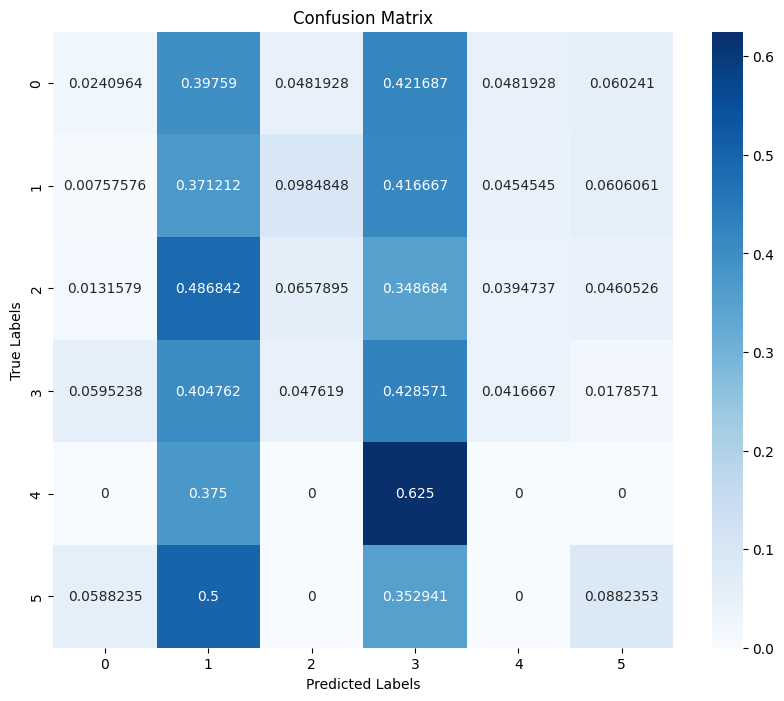

Epoch 20, Validation Loss: 1.6863, Accuracy: 0.2357, F1 Score: 0.2043
Val F1 Score Per Class  [0.04       0.2606383  0.10695187 0.36       0.         0.1       ]


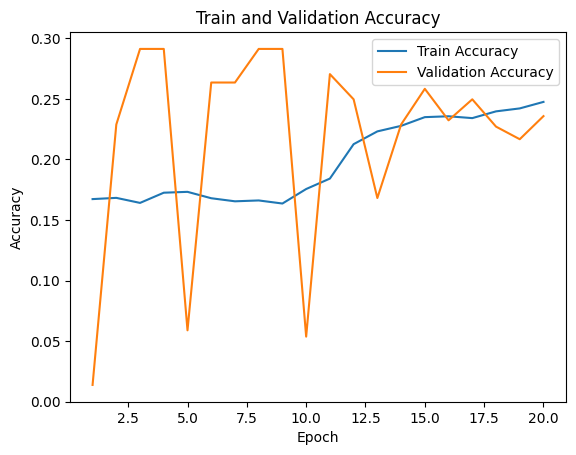

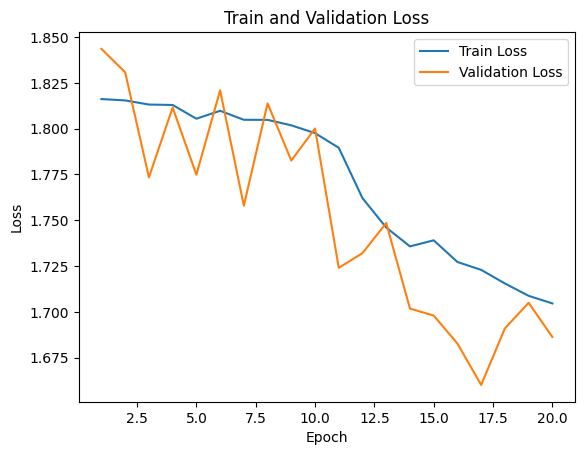

Test:   1%|▏         | 1/73 [00:00<00:31,  2.28it/s, loss=1.66]

[tensor([ 0.0171,  0.1332,  0.0662,  0.1416, -2.1375,  0.0214], device='cuda:0'), tensor([-0.2304,  0.0219, -0.1733,  0.0070, -0.2967, -0.3117], device='cuda:0'), tensor([ 0.1514,  0.1408,  0.2507,  0.2684, -1.8404,  0.1764], device='cuda:0'), tensor([ 0.0917,  0.1409,  0.1000,  0.1937, -1.6235,  0.0957], device='cuda:0'), tensor([-0.0908,  0.0568, -0.0834,  0.0176, -1.4889, -0.1449], device='cuda:0'), tensor([ 0.0777,  0.1685,  0.1120,  0.2083, -0.9891,  0.0541], device='cuda:0'), tensor([-0.0285, -0.0208, -0.0795,  0.0065, -1.0065, -0.0392], device='cuda:0'), tensor([-0.3681, -0.0519, -0.3941, -0.2132, -0.4514, -0.4518], device='cuda:0')]


Test:   3%|▎         | 2/73 [00:00<00:30,  2.29it/s, loss=1.7]

[tensor([-0.0863, -0.0224, -0.1584, -0.0797, -0.7440, -0.1126], device='cuda:0'), tensor([ 0.0874,  0.0497,  0.0713,  0.0964, -1.6877,  0.0493], device='cuda:0'), tensor([-0.1443,  0.0251, -0.1633, -0.0202, -0.4773, -0.2248], device='cuda:0'), tensor([-0.1040,  0.0868, -0.0175,  0.1050, -1.2394, -0.1805], device='cuda:0'), tensor([-0.0270,  0.1057,  0.1165,  0.1348, -1.5225, -0.0328], device='cuda:0'), tensor([-0.0419,  0.0906, -0.0307,  0.0541, -0.6915, -0.0822], device='cuda:0'), tensor([-0.0350,  0.0913,  0.0265,  0.0691, -0.6400, -0.0857], device='cuda:0'), tensor([-0.1235,  0.0744, -0.0308,  0.0711, -0.5041, -0.1604], device='cuda:0')]


Test:   4%|▍         | 3/73 [00:01<00:30,  2.30it/s, loss=1.69]

[tensor([-0.0282,  0.1522,  0.0780,  0.1736, -1.2764, -0.0391], device='cuda:0'), tensor([-0.0607,  0.0680,  0.0493,  0.0987, -0.6121, -0.0563], device='cuda:0'), tensor([-0.1460,  0.0499, -0.1021, -0.0100, -0.9054, -0.1708], device='cuda:0'), tensor([-0.3722, -0.0551, -0.3021, -0.1288, -0.6933, -0.4524], device='cuda:0'), tensor([-0.0952,  0.0005,  0.0499,  0.1019, -0.3561, -0.1082], device='cuda:0'), tensor([-0.0029,  0.0410,  0.0570,  0.0920, -2.0414,  0.0091], device='cuda:0'), tensor([-0.2498, -0.0598, -0.3393, -0.1882, -0.1371, -0.3203], device='cuda:0'), tensor([ 0.1161,  0.0693,  0.2127,  0.2169, -2.1112,  0.1548], device='cuda:0')]


Test:   5%|▌         | 4/73 [00:01<00:30,  2.29it/s, loss=1.67]

[tensor([-0.1179,  0.0183, -0.1522, -0.0512, -0.4636, -0.1690], device='cuda:0'), tensor([-0.0567,  0.0508,  0.0903,  0.1415, -0.7100, -0.0565], device='cuda:0'), tensor([-0.1291, -0.0676, -0.0223, -0.0392, -1.9996, -0.1093], device='cuda:0'), tensor([-0.3117,  0.0261, -0.3295, -0.1617,  0.1939, -0.4178], device='cuda:0'), tensor([-0.0530,  0.0633,  0.0343,  0.1226, -0.7384, -0.0660], device='cuda:0'), tensor([-0.0643,  0.0783, -0.0290,  0.1201, -0.4056, -0.1684], device='cuda:0'), tensor([-0.0870,  0.0395,  0.0645,  0.1328, -1.3098, -0.0633], device='cuda:0'), tensor([-0.0249,  0.0054, -0.0067,  0.0192, -1.6888,  0.0039], device='cuda:0')]


Test:   7%|▋         | 5/73 [00:02<00:29,  2.29it/s, loss=1.74]

[tensor([-0.1305,  0.0294, -0.0918,  0.0086, -0.4525, -0.2027], device='cuda:0'), tensor([ 8.4432e-01,  1.0033e-01,  7.3035e-02,  1.7903e-03, -4.5948e+00,
         8.4329e-01], device='cuda:0'), tensor([ 0.0351,  0.0660,  0.1335,  0.1286, -1.0036,  0.0285], device='cuda:0'), tensor([-0.1524, -0.0386, -0.0340,  0.0174, -0.5652, -0.1703], device='cuda:0'), tensor([-0.1828,  0.0465, -0.1137,  0.0243, -0.2365, -0.2308], device='cuda:0'), tensor([-0.4971, -0.1360, -0.5110, -0.3351, -0.7753, -0.5926], device='cuda:0'), tensor([-0.2653, -0.0546, -0.1999, -0.0839, -0.6879, -0.3074], device='cuda:0'), tensor([-0.1136,  0.0978, -0.0294,  0.0926, -0.5483, -0.1839], device='cuda:0')]


Test:   8%|▊         | 6/73 [00:02<00:29,  2.30it/s, loss=1.68]

[tensor([-0.1207, -0.0363, -0.1159, -0.0182, -0.7931, -0.1526], device='cuda:0'), tensor([-0.0605,  0.0256,  0.0574,  0.1018, -0.8529, -0.0364], device='cuda:0'), tensor([-0.1789,  0.0799, -0.1035,  0.0446, -0.7395, -0.2756], device='cuda:0'), tensor([ 0.0358,  0.1300,  0.0747,  0.1478, -0.9073, -0.0103], device='cuda:0'), tensor([-0.2474,  0.0492, -0.2002, -0.0338, -0.0670, -0.3396], device='cuda:0'), tensor([-0.0593,  0.0251, -0.0490,  0.0424, -3.3138, -0.0950], device='cuda:0'), tensor([-0.0269,  0.0349, -0.0282,  0.0255, -1.5998, -0.0329], device='cuda:0'), tensor([-0.2033,  0.0059, -0.2514, -0.1314, -0.9492, -0.3093], device='cuda:0')]


Test:  10%|▉         | 7/73 [00:03<00:28,  2.30it/s, loss=1.68]

[tensor([-0.4035, -0.0181, -0.4406, -0.2026, -0.2143, -0.5615], device='cuda:0'), tensor([-0.2397,  0.0301, -0.1596, -0.0334, -0.4111, -0.3270], device='cuda:0'), tensor([-0.2152, -0.0104, -0.3023, -0.1052, -0.3083, -0.2475], device='cuda:0'), tensor([-0.0587,  0.0099, -0.0235,  0.0579, -0.8270, -0.1064], device='cuda:0'), tensor([ 0.0109,  0.0823,  0.1399,  0.1655, -1.3406,  0.0291], device='cuda:0'), tensor([-0.2654, -0.1525, -0.3377, -0.2055, -0.0966, -0.3258], device='cuda:0'), tensor([ 0.0223,  0.1294,  0.1343,  0.1905, -1.3417,  0.0207], device='cuda:0'), tensor([-0.1265,  0.0466, -0.0534,  0.0516, -3.2048, -0.1487], device='cuda:0')]


Test:  11%|█         | 8/73 [00:03<00:28,  2.29it/s, loss=1.62]

[tensor([ 0.0403,  0.0255,  0.1552,  0.1237, -1.2767,  0.0820], device='cuda:0'), tensor([-0.0085,  0.0688,  0.1336,  0.1118, -2.0200,  0.0208], device='cuda:0'), tensor([-0.2511,  0.0220, -0.2787, -0.1112, -0.2081, -0.3398], device='cuda:0'), tensor([ 0.0821,  0.0619,  0.0925,  0.1488, -3.1567,  0.1249], device='cuda:0'), tensor([-0.1560,  0.0222, -0.0329,  0.0364, -1.5541, -0.1733], device='cuda:0'), tensor([-0.3165, -0.0487, -0.2586, -0.1125, -1.4530, -0.3699], device='cuda:0'), tensor([ 0.0375,  0.0576,  0.1170,  0.1118, -2.2375,  0.0575], device='cuda:0'), tensor([-0.1120,  0.1108, -0.0364,  0.0984, -0.9368, -0.1950], device='cuda:0')]


Test:  12%|█▏        | 9/73 [00:03<00:28,  2.28it/s, loss=1.6]

[tensor([-0.2688, -0.0643, -0.2188, -0.0957, -1.2855, -0.2932], device='cuda:0'), tensor([-0.0078,  0.0467,  0.0115,  0.1004, -2.4192, -0.0279], device='cuda:0'), tensor([ 0.0486,  0.1827,  0.1399,  0.1944, -2.4844,  0.0248], device='cuda:0'), tensor([ 0.1078,  0.0734,  0.1129,  0.1369, -1.3690,  0.0700], device='cuda:0'), tensor([-0.1841,  0.0550, -0.2075, -0.0626, -0.8160, -0.2688], device='cuda:0'), tensor([-0.1338,  0.0538, -0.0402,  0.0759, -0.4475, -0.1950], device='cuda:0'), tensor([-0.0657,  0.0864, -0.0401,  0.1061, -2.3185, -0.1270], device='cuda:0'), tensor([-0.2121,  0.0341, -0.1654, -0.0482, -0.2504, -0.2806], device='cuda:0')]


Test:  14%|█▎        | 10/73 [00:04<00:27,  2.29it/s, loss=1.71]

[tensor([-0.1738, -0.0656, -0.5626, -0.2537, -0.4887, -0.2392], device='cuda:0'), tensor([ 3.8783e-02,  7.3137e-02,  1.6363e-02,  5.5687e-02, -1.8492e+00,
        -1.8115e-03], device='cuda:0'), tensor([-0.0940,  0.0728, -0.0257,  0.1248, -0.6371, -0.1575], device='cuda:0'), tensor([-0.0740,  0.0881, -0.0096,  0.1146, -1.4285, -0.1315], device='cuda:0'), tensor([ 0.0546,  0.1684,  0.1789,  0.1937, -2.6175,  0.0457], device='cuda:0'), tensor([-0.2107, -0.0594, -0.1735, -0.0699, -0.1656, -0.1866], device='cuda:0'), tensor([-0.2512, -0.0098, -0.3059, -0.1140, -1.5462, -0.3249], device='cuda:0'), tensor([ 0.0378,  0.0986,  0.0441,  0.1132, -1.3877,  0.0340], device='cuda:0')]


Test:  15%|█▌        | 11/73 [00:04<00:27,  2.28it/s, loss=1.72]

[tensor([-0.1730,  0.0564, -0.0965,  0.0435,  0.2111, -0.2528], device='cuda:0'), tensor([-0.1129,  0.0791, -0.0038,  0.0577, -0.7128, -0.1330], device='cuda:0'), tensor([ 0.4573,  0.1504,  0.4855,  0.2697, -3.1842,  0.5293], device='cuda:0'), tensor([ 0.0171,  0.0368,  0.0090,  0.0919, -1.7925, -0.0160], device='cuda:0'), tensor([-0.1315,  0.0225, -0.0477,  0.0840, -2.4732, -0.1794], device='cuda:0'), tensor([-0.1140,  0.0799, -0.0247,  0.0881, -0.2992, -0.1528], device='cuda:0'), tensor([-0.0740, -0.0948, -0.0389, -0.0083, -0.4777, -0.1336], device='cuda:0'), tensor([-0.0087,  0.1328,  0.0728,  0.1783, -1.1634, -0.0453], device='cuda:0')]


Test:  16%|█▋        | 12/73 [00:05<00:26,  2.29it/s, loss=1.89]

[tensor([ 0.2890,  0.1897,  0.4576,  0.3866, -1.7426,  0.3297], device='cuda:0'), tensor([-0.0243, -0.0294, -0.1288, -0.0273, -1.0088, -0.0683], device='cuda:0'), tensor([ 0.0839,  0.1102,  0.1934,  0.1932, -1.9330,  0.0548], device='cuda:0'), tensor([ 0.3193,  0.1642,  0.3361,  0.2212, -2.9800,  0.3498], device='cuda:0'), tensor([-0.0163,  0.0477,  0.0254,  0.0408, -0.8323, -0.0150], device='cuda:0'), tensor([-0.0199,  0.0563,  0.0567,  0.0881, -3.0049, -0.0453], device='cuda:0'), tensor([-0.0611,  0.0347,  0.0184,  0.0907, -1.3495, -0.0989], device='cuda:0'), tensor([ 0.0044,  0.1096,  0.0911,  0.1707, -1.2432, -0.0433], device='cuda:0')]


Test:  18%|█▊        | 13/73 [00:05<00:26,  2.31it/s, loss=1.61]

[tensor([ 0.1325,  0.0333,  0.2011,  0.1211, -1.7699,  0.1044], device='cuda:0'), tensor([-0.1932,  0.0852, -0.0931,  0.0610, -1.0812, -0.2716], device='cuda:0'), tensor([-0.0455,  0.0267,  0.0079,  0.0435, -0.8468, -0.0407], device='cuda:0'), tensor([-0.0819,  0.0792, -0.0704,  0.0792, -0.8904, -0.1209], device='cuda:0'), tensor([ 0.1078,  0.1249,  0.1642,  0.2490, -3.8027,  0.1308], device='cuda:0'), tensor([-0.1079,  0.0438, -0.0059,  0.0671, -1.0082, -0.1463], device='cuda:0'), tensor([-0.1471,  0.0870, -0.0663,  0.0472, -0.9383, -0.1882], device='cuda:0'), tensor([-6.4659e-02,  4.4425e-02, -2.4975e-04,  9.2620e-02, -3.9044e-01,
        -1.0821e-01], device='cuda:0')]


Test:  19%|█▉        | 14/73 [00:06<00:25,  2.32it/s, loss=1.69]

[tensor([-0.1961,  0.0225, -0.2060, -0.0332, -1.2344, -0.2505], device='cuda:0'), tensor([-0.1053,  0.0311, -0.0106,  0.0544, -1.3705, -0.1013], device='cuda:0'), tensor([-0.2849, -0.0381, -0.2897, -0.1763, -1.1897, -0.3360], device='cuda:0'), tensor([-0.0417,  0.1071, -0.0355,  0.0932, -1.1308, -0.1028], device='cuda:0'), tensor([-0.1794,  0.0027, -0.0579, -0.0008, -0.3488, -0.1741], device='cuda:0'), tensor([-0.0980,  0.0358,  0.0425,  0.1004, -3.2532, -0.0742], device='cuda:0'), tensor([-0.1253, -0.0209, -0.1159, -0.0317, -0.3066, -0.1543], device='cuda:0'), tensor([-0.1670, -0.0368, -0.2952, -0.1723, -0.4792, -0.2155], device='cuda:0')]


Test:  21%|██        | 15/73 [00:06<00:25,  2.32it/s, loss=1.7]

[tensor([ 0.2116,  0.2230,  0.2081,  0.3780, -1.9264,  0.1476], device='cuda:0'), tensor([-0.1599, -0.0044, -0.1092,  0.0038, -0.9859, -0.2056], device='cuda:0'), tensor([-0.0516,  0.0191, -0.2491, -0.0340, -1.1914, -0.1439], device='cuda:0'), tensor([ 3.4206e-04,  1.0338e-01,  6.0922e-02,  1.8346e-01, -1.2423e+00,
        -7.8421e-02], device='cuda:0'), tensor([-0.2307,  0.0070, -0.1648, -0.0142, -0.4060, -0.2984], device='cuda:0'), tensor([-0.1814, -0.0732, -0.1065, -0.0296,  0.1454, -0.1792], device='cuda:0'), tensor([-0.0929,  0.0241,  0.0222,  0.0826, -2.1687, -0.1115], device='cuda:0'), tensor([-0.1482,  0.0198, -0.1013,  0.0292, -0.2651, -0.2421], device='cuda:0')]


Test:  22%|██▏       | 16/73 [00:06<00:24,  2.32it/s, loss=1.65]

[tensor([-0.1566,  0.0174, -0.1147, -0.0056, -1.3324, -0.2471], device='cuda:0'), tensor([-0.1009,  0.0460, -0.0408, -0.0036, -0.2893, -0.1173], device='cuda:0'), tensor([ 0.1429,  0.1580,  0.0389,  0.1873, -1.6302,  0.0455], device='cuda:0'), tensor([ 0.0922,  0.1114,  0.0949,  0.2579, -1.3832,  0.0440], device='cuda:0'), tensor([-0.3026,  0.0023, -0.3880, -0.1551, -1.3629, -0.3881], device='cuda:0'), tensor([-0.3218, -0.0366, -0.2432, -0.1115,  0.1559, -0.3754], device='cuda:0'), tensor([-0.1723,  0.0374, -0.1373,  0.0381, -0.9484, -0.2300], device='cuda:0'), tensor([-0.0483,  0.0933,  0.0472,  0.1231, -0.6881, -0.0857], device='cuda:0')]


Test:  23%|██▎       | 17/73 [00:07<00:24,  2.31it/s, loss=1.64]

[tensor([-0.1231,  0.0826, -0.0163,  0.1047, -1.2421, -0.1598], device='cuda:0'), tensor([-0.1022,  0.0321,  0.0051,  0.0774, -0.4704, -0.1128], device='cuda:0'), tensor([ 0.1490,  0.0400,  0.2026,  0.1445, -1.5462,  0.1424], device='cuda:0'), tensor([-0.2188,  0.0608, -0.1745, -0.0496, -1.4855, -0.2607], device='cuda:0'), tensor([-0.1727, -0.0556, -0.3186, -0.1558, -2.0026, -0.2275], device='cuda:0'), tensor([-0.1008, -0.0506, -0.0199,  0.0467,  0.0084, -0.1249], device='cuda:0'), tensor([ 0.0247,  0.1075,  0.0278,  0.1549, -2.7605, -0.0515], device='cuda:0'), tensor([ 0.0607,  0.1265,  0.0666,  0.1414, -1.4421,  0.0537], device='cuda:0')]


Test:  25%|██▍       | 18/73 [00:07<00:23,  2.31it/s, loss=1.66]

[tensor([-8.6435e-02, -2.0785e-04,  5.1305e-02,  2.1148e-02, -2.5095e+00,
        -5.0137e-02], device='cuda:0'), tensor([-0.2236,  0.0603, -0.2237, -0.0567, -0.3879, -0.3110], device='cuda:0'), tensor([-0.0860,  0.0773,  0.0498,  0.1020, -0.5858, -0.0772], device='cuda:0'), tensor([-0.2554, -0.0953, -0.2183, -0.1380, -0.9515, -0.2539], device='cuda:0'), tensor([-0.2752, -0.0231, -0.2075, -0.0543, -0.6655, -0.3332], device='cuda:0'), tensor([-0.2766,  0.0283, -0.2121, -0.0395, -0.1633, -0.3591], device='cuda:0'), tensor([-0.0470,  0.0506,  0.0737,  0.1309, -1.1429, -0.0637], device='cuda:0'), tensor([-0.3043, -0.0860, -0.3279, -0.2195, -0.7659, -0.3624], device='cuda:0')]


Test:  26%|██▌       | 19/73 [00:08<00:23,  2.31it/s, loss=1.66]

[tensor([-0.0816,  0.0160,  0.0335,  0.0802, -0.6919, -0.0709], device='cuda:0'), tensor([-0.0599,  0.0638,  0.0570,  0.1126, -1.1133, -0.0906], device='cuda:0'), tensor([-0.4425, -0.1307, -0.4537, -0.2942,  0.1902, -0.5283], device='cuda:0'), tensor([-0.4093, -0.1273, -0.3951, -0.2163,  0.0864, -0.4919], device='cuda:0'), tensor([ 0.0515,  0.0850,  0.1526,  0.1985, -1.4300,  0.0424], device='cuda:0'), tensor([ 0.2784,  0.1680,  0.3553,  0.2932, -2.8012,  0.3229], device='cuda:0'), tensor([-0.0112,  0.0494,  0.0351,  0.0337, -2.0363, -0.0276], device='cuda:0'), tensor([-0.1170, -0.0256, -0.0685,  0.0551, -1.4522, -0.1345], device='cuda:0')]


Test:  27%|██▋       | 20/73 [00:08<00:22,  2.32it/s, loss=1.71]

[tensor([ 0.2650,  0.0569,  0.1582,  0.1282, -1.5886,  0.2842], device='cuda:0'), tensor([-0.1601, -0.0774, -0.0309,  0.0043, -1.8104, -0.1612], device='cuda:0'), tensor([-0.1375,  0.0285, -0.1795, -0.0550, -0.4006, -0.2083], device='cuda:0'), tensor([ 0.2394,  0.0334,  0.1636,  0.1313, -2.0343,  0.1970], device='cuda:0'), tensor([-0.0449,  0.0760, -0.0063,  0.1205, -0.9511, -0.1123], device='cuda:0'), tensor([-0.1390, -0.0583, -0.1634, -0.0577,  0.2305, -0.1963], device='cuda:0'), tensor([-0.0789, -0.1519, -0.4417, -0.2318, -1.7606, -0.2831], device='cuda:0'), tensor([ 0.1955,  0.1890,  0.2251,  0.3638, -1.8071,  0.1643], device='cuda:0')]


Test:  29%|██▉       | 21/73 [00:09<00:22,  2.31it/s, loss=1.66]

[tensor([-0.1420,  0.0376, -0.1306,  0.0121, -0.6412, -0.1999], device='cuda:0'), tensor([-0.1418,  0.0379, -0.1219,  0.0504, -0.4597, -0.2556], device='cuda:0'), tensor([-0.1533, -0.0909, -0.0592, -0.0144, -2.3686, -0.1608], device='cuda:0'), tensor([-0.0176, -0.0449,  0.0052,  0.0615, -0.8585, -0.0145], device='cuda:0'), tensor([-0.1393,  0.0707, -0.0653,  0.0428, -0.6381, -0.2006], device='cuda:0'), tensor([-0.0827,  0.1249,  0.0138,  0.0954, -1.2757, -0.1017], device='cuda:0'), tensor([-0.0390,  0.0764, -0.1638,  0.0070, -1.6924, -0.1346], device='cuda:0'), tensor([-0.1863,  0.0355, -0.1458, -0.0588, -1.9606, -0.2041], device='cuda:0')]


Test:  30%|███       | 22/73 [00:09<00:22,  2.31it/s, loss=1.74]

[tensor([-0.0635,  0.0665,  0.0332,  0.0796, -1.0651, -0.0615], device='cuda:0'), tensor([-0.0819,  0.0368, -0.0287,  0.0651, -0.6163, -0.0831], device='cuda:0'), tensor([-0.1034,  0.0418, -0.0128,  0.0505, -0.5496, -0.1368], device='cuda:0'), tensor([-0.1924,  0.0634, -0.0942,  0.0228, -0.1034, -0.2271], device='cuda:0'), tensor([-0.1691,  0.0472, -0.1622,  0.0349, -0.4001, -0.2433], device='cuda:0'), tensor([-0.1733, -0.0005, -0.2713, -0.0426, -0.3337, -0.2889], device='cuda:0'), tensor([-0.3395, -0.1343, -0.2679, -0.2149, -0.7991, -0.3425], device='cuda:0'), tensor([-0.1843,  0.0359, -0.1267, -0.0417, -0.5162, -0.2137], device='cuda:0')]


Test:  32%|███▏      | 23/73 [00:09<00:21,  2.30it/s, loss=1.7]

[tensor([-0.0309,  0.0863,  0.0723,  0.0596, -3.1636, -0.0615], device='cuda:0'), tensor([-0.4738, -0.0850, -0.6272, -0.3079,  0.6326, -0.5740], device='cuda:0'), tensor([-0.2736, -0.0487, -0.4564, -0.2761, -1.5509, -0.3578], device='cuda:0'), tensor([ 0.1551,  0.1648,  0.1035,  0.2044, -2.1034,  0.1623], device='cuda:0'), tensor([-0.1875, -0.0663, -0.1110, -0.0727, -0.4629, -0.1816], device='cuda:0'), tensor([-0.2005,  0.0048, -0.2091, -0.0676, -0.3933, -0.2275], device='cuda:0'), tensor([-0.2575, -0.0316, -0.2416, -0.0961,  0.0310, -0.3458], device='cuda:0'), tensor([-0.0265,  0.0588,  0.0972,  0.1353, -0.9392, -0.0475], device='cuda:0')]


Test:  33%|███▎      | 24/73 [00:10<00:21,  2.30it/s, loss=1.61]

[tensor([-0.1300,  0.0406, -0.0030,  0.0775, -0.1982, -0.1699], device='cuda:0'), tensor([ 0.0753,  0.0779,  0.1727,  0.2377, -2.1690,  0.0781], device='cuda:0'), tensor([-2.4596e-02, -6.5398e-04,  1.3135e-01,  1.0815e-01, -1.1005e+00,
         2.8903e-02], device='cuda:0'), tensor([-0.1078, -0.0822, -0.1367, -0.1234, -1.2888, -0.1533], device='cuda:0'), tensor([-1.3182e-03,  8.7814e-02,  6.9182e-02,  1.3834e-01, -1.8292e+00,
        -3.1692e-02], device='cuda:0'), tensor([ 0.0172,  0.0570,  0.0934,  0.1089, -1.0043,  0.0202], device='cuda:0'), tensor([-0.2273, -0.0141, -0.3418, -0.1202, -0.8287, -0.3226], device='cuda:0'), tensor([-0.0745,  0.0293, -0.1787, -0.0163, -3.0737, -0.1027], device='cuda:0')]


Test:  34%|███▍      | 25/73 [00:10<00:20,  2.31it/s, loss=1.72]

[tensor([-0.2782, -0.0554, -0.2219, -0.0690, -0.6202, -0.3792], device='cuda:0'), tensor([-0.1661, -0.0595, -0.1424, -0.0762, -0.3310, -0.1786], device='cuda:0'), tensor([-0.3865, -0.0760, -0.4687, -0.2013,  0.2944, -0.4750], device='cuda:0'), tensor([-0.0286,  0.0283,  0.0030,  0.0464, -1.3326, -0.0469], device='cuda:0'), tensor([-0.0803,  0.0813,  0.0287,  0.1120, -0.4081, -0.1157], device='cuda:0'), tensor([-0.1305,  0.0663, -0.0531,  0.0586, -0.4747, -0.2061], device='cuda:0'), tensor([-0.0811,  0.1304, -0.0800,  0.0839, -0.5900, -0.1787], device='cuda:0'), tensor([ 0.0462,  0.0305,  0.1281,  0.1259, -1.1514,  0.0925], device='cuda:0')]


Test:  36%|███▌      | 26/73 [00:11<00:20,  2.32it/s, loss=1.69]

[tensor([-0.3069, -0.1978, -0.6132, -0.3850, -0.0180, -0.4153], device='cuda:0'), tensor([-0.3994, -0.1343, -0.3643, -0.2267, -1.2011, -0.4341], device='cuda:0'), tensor([-0.0252,  0.0607,  0.0775,  0.1340, -1.8362, -0.0264], device='cuda:0'), tensor([-0.0862,  0.1214, -0.0326,  0.0523, -0.3873, -0.1502], device='cuda:0'), tensor([ 0.5444,  0.1351,  0.2665,  0.1877, -3.0945,  0.5516], device='cuda:0'), tensor([-0.0147,  0.0923,  0.0530,  0.1721, -0.6990, -0.0724], device='cuda:0'), tensor([-0.2207,  0.0465, -0.1802, -0.0218, -0.4770, -0.2965], device='cuda:0'), tensor([-0.2420,  0.0085, -0.1620, -0.0266, -0.3831, -0.3036], device='cuda:0')]


Test:  37%|███▋      | 27/73 [00:11<00:20,  2.29it/s, loss=1.63]

[tensor([-0.2863, -0.0213, -0.1968, -0.0628, -0.2563, -0.3637], device='cuda:0'), tensor([-0.0906,  0.1083, -0.3565, -0.0686, -1.9054, -0.2627], device='cuda:0'), tensor([-0.2469, -0.0057, -0.1494, -0.0665, -0.9252, -0.2997], device='cuda:0'), tensor([-0.1126,  0.0569, -0.0798,  0.0158, -3.0396, -0.1089], device='cuda:0'), tensor([-0.0855,  0.0524,  0.0549,  0.0813, -1.6081, -0.1035], device='cuda:0'), tensor([-0.0133,  0.0624,  0.0135,  0.1564, -0.8206, -0.1026], device='cuda:0'), tensor([-0.2146,  0.0039, -0.0975, -0.0101, -1.1802, -0.2742], device='cuda:0'), tensor([-0.1459, -0.0751, -0.1779, -0.0978, -0.4636, -0.1756], device='cuda:0')]


Test:  38%|███▊      | 28/73 [00:12<00:19,  2.29it/s, loss=1.71]

[tensor([ 0.6368,  0.2504,  0.4345,  0.3268, -3.5097,  0.6507], device='cuda:0'), tensor([-0.4675, -0.1104, -0.7176, -0.3883, -0.2211, -0.6679], device='cuda:0'), tensor([-0.1074,  0.0652, -0.0418,  0.0995, -0.8299, -0.1567], device='cuda:0'), tensor([-0.0689,  0.0554, -0.1456, -0.0300, -3.9443, -0.0898], device='cuda:0'), tensor([-0.3672, -0.0425, -0.4045, -0.2401,  0.0979, -0.4560], device='cuda:0'), tensor([-0.1952,  0.0397, -0.1577, -0.0692, -1.7990, -0.2897], device='cuda:0'), tensor([-0.1558,  0.0631, -0.2227, -0.0501, -0.0981, -0.2746], device='cuda:0'), tensor([-0.0895,  0.0979, -0.0643,  0.0716, -0.8344, -0.1881], device='cuda:0')]


Test:  40%|███▉      | 29/73 [00:12<00:19,  2.29it/s, loss=1.71]

[tensor([ 0.0457,  0.1064,  0.2049,  0.1940, -4.6301,  0.0578], device='cuda:0'), tensor([-0.0436, -0.0057,  0.0673,  0.0791, -0.4492, -0.0557], device='cuda:0'), tensor([-0.0170,  0.1662,  0.0770,  0.1855, -0.9441, -0.0862], device='cuda:0'), tensor([-0.2882,  0.0283, -0.2919, -0.0899, -1.0517, -0.4169], device='cuda:0'), tensor([-0.1502,  0.0157, -0.0615,  0.0520, -0.9355, -0.2233], device='cuda:0'), tensor([-0.0338,  0.1275,  0.0195,  0.1579, -1.5340, -0.0856], device='cuda:0'), tensor([ 1.0054,  0.2762,  0.3742,  0.3439, -4.9782,  1.0439], device='cuda:0'), tensor([-0.1980,  0.0392, -0.2175, -0.0900, -1.6050, -0.2650], device='cuda:0')]


Test:  41%|████      | 30/73 [00:13<00:18,  2.30it/s, loss=1.68]

[tensor([-0.0921, -0.0451, -0.3699, -0.1652, -0.9593, -0.1786], device='cuda:0'), tensor([-0.1562,  0.0257, -0.0928,  0.0134, -0.2065, -0.2064], device='cuda:0'), tensor([-0.2206,  0.0400, -0.1815, -0.0338, -1.0083, -0.2661], device='cuda:0'), tensor([ 0.0746, -0.0756, -0.1244, -0.0726, -1.8552,  0.0785], device='cuda:0'), tensor([-0.1732, -0.0042, -0.2550, -0.1088, -1.1087, -0.2187], device='cuda:0'), tensor([ 0.1622,  0.0955,  0.2396,  0.1640, -1.7350,  0.1953], device='cuda:0'), tensor([ 0.0894,  0.1472,  0.1456,  0.2902, -1.9577,  0.0608], device='cuda:0'), tensor([-0.2381, -0.0312, -0.2679, -0.1476, -0.2883, -0.3025], device='cuda:0')]


Test:  42%|████▏     | 31/73 [00:13<00:18,  2.30it/s, loss=1.72]

[tensor([-0.1835,  0.0738, -0.0986, -0.0134, -0.5632, -0.2417], device='cuda:0'), tensor([-0.2097, -0.0116, -0.1155,  0.0168, -0.6216, -0.2301], device='cuda:0'), tensor([-0.3016,  0.0263, -0.3200, -0.1109, -0.3666, -0.4139], device='cuda:0'), tensor([ 0.0285,  0.1685,  0.0823,  0.1383, -0.9182, -0.0275], device='cuda:0'), tensor([ 0.1823,  0.0777,  0.3431,  0.2430, -3.2473,  0.1971], device='cuda:0'), tensor([ 0.1481,  0.1678,  0.1267,  0.2087, -1.2713,  0.0972], device='cuda:0'), tensor([-0.2426, -0.0091, -0.1711, -0.0482, -0.2703, -0.3001], device='cuda:0'), tensor([-0.1167,  0.0423, -0.0242,  0.0636, -0.0509, -0.1625], device='cuda:0')]


Test:  44%|████▍     | 32/73 [00:13<00:17,  2.30it/s, loss=1.69]

[tensor([ 0.1888,  0.1060,  0.2360,  0.2176, -2.7664,  0.1653], device='cuda:0'), tensor([ 4.3614e-02,  8.3301e-02, -4.3072e-04,  9.7736e-02, -1.0577e+00,
        -2.9288e-02], device='cuda:0'), tensor([-0.1441,  0.0616, -0.0763,  0.0667, -0.2424, -0.1977], device='cuda:0'), tensor([-0.2760, -0.0099, -0.2968, -0.1635, -1.0247, -0.3913], device='cuda:0'), tensor([-0.0362,  0.0716,  0.0389,  0.1415, -0.4465, -0.1011], device='cuda:0'), tensor([-0.1222,  0.0241, -0.0494, -0.0046, -1.0997, -0.1163], device='cuda:0'), tensor([-0.1315, -0.0121, -0.1759, -0.0608, -0.6138, -0.1538], device='cuda:0'), tensor([ 0.0328, -0.0041,  0.0647,  0.1118, -0.9431,  0.0472], device='cuda:0')]


Test:  45%|████▌     | 33/73 [00:14<00:17,  2.29it/s, loss=1.73]

[tensor([ 0.1688,  0.0067,  0.2720,  0.1113, -2.9496,  0.2775], device='cuda:0'), tensor([-0.0620,  0.0866, -0.1535,  0.0240, -1.0051, -0.1372], device='cuda:0'), tensor([-0.1678,  0.0336, -0.0673, -0.0311, -1.1648, -0.2327], device='cuda:0'), tensor([ 0.0089,  0.1016,  0.0378,  0.1280, -0.8910, -0.0339], device='cuda:0'), tensor([-0.1126,  0.0432, -0.0100,  0.0812, -0.7879, -0.1380], device='cuda:0'), tensor([-0.1864,  0.0480, -0.0954,  0.0181, -1.5248, -0.2207], device='cuda:0'), tensor([-0.1257,  0.1246, -0.1181,  0.0231, -0.8376, -0.2002], device='cuda:0'), tensor([-0.4774, -0.2210, -0.7470, -0.4874,  1.0554, -0.6496], device='cuda:0')]


Test:  47%|████▋     | 34/73 [00:14<00:16,  2.31it/s, loss=1.67]

[tensor([ 0.2340,  0.1022,  0.3044,  0.2589, -2.0036,  0.2664], device='cuda:0'), tensor([-0.0392,  0.0607,  0.0077,  0.1222, -0.4385, -0.0882], device='cuda:0'), tensor([-0.2275,  0.0369, -0.1561, -0.0132, -0.3722, -0.3146], device='cuda:0'), tensor([-0.1938, -0.0025, -0.0952,  0.0015, -0.2365, -0.2537], device='cuda:0'), tensor([-0.0594,  0.0437, -0.0116,  0.0676, -0.6860, -0.1044], device='cuda:0'), tensor([-0.2428, -0.0724, -0.1122, -0.0495,  0.0056, -0.2478], device='cuda:0'), tensor([-0.1779, -0.0077, -0.0638,  0.0208, -0.9737, -0.2302], device='cuda:0'), tensor([-0.0027, -0.0175, -0.2115, -0.0248, -0.9858, -0.0449], device='cuda:0')]


Test:  48%|████▊     | 35/73 [00:15<00:16,  2.31it/s, loss=1.78]

[tensor([ 0.0083,  0.1036,  0.0402,  0.1199, -2.7093, -0.0382], device='cuda:0'), tensor([ 0.0964,  0.0690,  0.2070,  0.1156, -2.9589,  0.1223], device='cuda:0'), tensor([-0.0883,  0.0095, -0.0054, -0.0059, -1.0124, -0.0966], device='cuda:0'), tensor([-0.1611,  0.0851, -0.1011,  0.0065, -0.5069, -0.2006], device='cuda:0'), tensor([-0.4942, -0.0364, -0.4874, -0.2537,  0.0693, -0.6200], device='cuda:0'), tensor([-0.1684,  0.0333, -0.0702,  0.0237, -0.4889, -0.2075], device='cuda:0'), tensor([-0.2336,  0.0124, -0.1513, -0.0449, -0.1932, -0.2896], device='cuda:0'), tensor([-0.0747,  0.0711, -0.0179,  0.0967, -0.5478, -0.0904], device='cuda:0')]


Test:  49%|████▉     | 36/73 [00:15<00:16,  2.31it/s, loss=1.69]

[tensor([-0.1585,  0.1039, -0.3130, -0.0465, -0.9704, -0.2872], device='cuda:0'), tensor([-0.0650,  0.0506,  0.0289,  0.0997, -0.7245, -0.0883], device='cuda:0'), tensor([-0.0255,  0.0786,  0.0226,  0.1047, -1.0138, -0.0332], device='cuda:0'), tensor([-0.1680, -0.1327, -0.3360, -0.2769, -2.7898, -0.2109], device='cuda:0'), tensor([-0.3068, -0.0418, -0.1732, -0.1349, -0.4267, -0.3426], device='cuda:0'), tensor([-0.5326, -0.2140, -0.7135, -0.4473,  0.0873, -0.6812], device='cuda:0'), tensor([-1.2085e-04,  6.8498e-02,  4.8878e-02,  1.6976e-01, -1.3910e+00,
        -3.7455e-02], device='cuda:0'), tensor([-0.2249,  0.0235, -0.2381, -0.0482, -0.6047, -0.3309], device='cuda:0')]


Test:  51%|█████     | 37/73 [00:16<00:15,  2.31it/s, loss=1.84]

[tensor([-0.4326, -0.0389, -0.4266, -0.2417,  0.6583, -0.5194], device='cuda:0'), tensor([-0.0430,  0.0047, -0.0623,  0.0352, -0.4938, -0.0982], device='cuda:0'), tensor([-0.0913,  0.0764, -0.0299,  0.0997, -0.4196, -0.1354], device='cuda:0'), tensor([-0.1795,  0.0793, -0.1244,  0.0097, -0.5650, -0.2461], device='cuda:0'), tensor([-0.5478, -0.1250, -0.5826, -0.3638, -0.5258, -0.6699], device='cuda:0'), tensor([-0.0409, -0.1430, -0.1660, -0.1545, -2.8933, -0.0532], device='cuda:0'), tensor([ 0.3142, -0.0686, -0.4760, -0.3312, -3.6286,  0.1330], device='cuda:0'), tensor([-0.0461,  0.1181,  0.0391,  0.1314, -0.8773, -0.0765], device='cuda:0')]


Test:  52%|█████▏    | 38/73 [00:16<00:15,  2.30it/s, loss=1.69]

[tensor([ 0.0519,  0.0792,  0.1418,  0.1642, -2.9289,  0.0402], device='cuda:0'), tensor([-0.1538,  0.0250, -0.2196, -0.0630, -1.2573, -0.2393], device='cuda:0'), tensor([-0.0601,  0.0422, -0.0102,  0.0676, -1.7944, -0.0936], device='cuda:0'), tensor([-0.2149, -0.0213, -0.3096, -0.1033, -0.4070, -0.3662], device='cuda:0'), tensor([ 0.0584,  0.1169,  0.1360,  0.1871, -1.0235,  0.0602], device='cuda:0'), tensor([-0.3170, -0.0314, -0.2672, -0.1291, -0.7734, -0.3830], device='cuda:0'), tensor([-0.3811, -0.0356, -0.3467, -0.1514, -0.3058, -0.4489], device='cuda:0'), tensor([-0.2290, -0.0580, -0.2100, -0.1092, -0.9767, -0.2446], device='cuda:0')]


Test:  53%|█████▎    | 39/73 [00:16<00:14,  2.30it/s, loss=1.69]

[tensor([-0.2271,  0.0469, -0.1229, -0.0102, -0.6745, -0.2823], device='cuda:0'), tensor([-0.1360,  0.0470, -0.0695,  0.0041, -0.8379, -0.1787], device='cuda:0'), tensor([-0.0841,  0.0573, -0.1108,  0.0111, -0.8345, -0.1055], device='cuda:0'), tensor([-0.0573,  0.0446, -0.0023,  0.0810, -0.9573, -0.0761], device='cuda:0'), tensor([-0.1622,  0.0927, -0.0805,  0.0529, -0.8352, -0.2292], device='cuda:0'), tensor([-0.3651, -0.0886, -0.5057, -0.2243, -0.0390, -0.5270], device='cuda:0'), tensor([-0.1551, -0.0217, -0.0762,  0.0031, -0.1409, -0.1721], device='cuda:0'), tensor([-0.1836,  0.0265, -0.1668, -0.0333, -0.7295, -0.2353], device='cuda:0')]


Test:  55%|█████▍    | 40/73 [00:17<00:14,  2.30it/s, loss=1.64]

[tensor([-0.0916, -0.0388, -0.0545, -0.0338, -2.7607, -0.0778], device='cuda:0'), tensor([ 0.1800,  0.0198,  0.0523,  0.0742, -1.2151,  0.1716], device='cuda:0'), tensor([-0.1784,  0.0556, -0.0663,  0.0553, -0.7202, -0.2615], device='cuda:0'), tensor([-1.4662e-01, -2.8490e-04, -4.6527e-01, -1.7291e-01, -1.3156e+00,
        -2.7829e-01], device='cuda:0'), tensor([-0.2947, -0.1038, -0.3172, -0.2077, -2.3972, -0.3343], device='cuda:0'), tensor([-0.1468, -0.0693, -0.1318, -0.0524, -1.4391, -0.1358], device='cuda:0'), tensor([ 0.1186,  0.1604,  0.1093,  0.2862, -1.3189,  0.0741], device='cuda:0'), tensor([-0.2303, -0.0243, -0.1441, -0.0885, -0.1556, -0.1997], device='cuda:0')]


Test:  56%|█████▌    | 41/73 [00:17<00:13,  2.30it/s, loss=1.69]

[tensor([-0.2913, -0.2282, -0.4747, -0.3526, -2.1512, -0.3800], device='cuda:0'), tensor([-0.3012, -0.0119, -0.2023, -0.0600, -0.5295, -0.3500], device='cuda:0'), tensor([-0.0208,  0.1490,  0.0229,  0.1253, -1.3470, -0.0546], device='cuda:0'), tensor([-0.2980, -0.0138, -0.1930, -0.0916, -0.7958, -0.3484], device='cuda:0'), tensor([-0.3917, -0.0761, -0.3830, -0.1483,  0.1786, -0.4892], device='cuda:0'), tensor([-0.4125, -0.2049, -0.6344, -0.3999, -3.3953, -0.5672], device='cuda:0'), tensor([ 0.0612,  0.0209,  0.1112,  0.0928, -2.3606,  0.0740], device='cuda:0'), tensor([-0.1787,  0.0138, -0.2059, -0.0507, -1.0732, -0.2083], device='cuda:0')]


Test:  58%|█████▊    | 42/73 [00:18<00:13,  2.30it/s, loss=1.72]

[tensor([-0.2121,  0.0074, -0.4122, -0.2287,  0.0734, -0.3151], device='cuda:0'), tensor([-0.2342,  0.0225, -0.2162, -0.0265, -0.6776, -0.3121], device='cuda:0'), tensor([-0.1617,  0.0326, -0.0874,  0.0221, -0.5437, -0.1902], device='cuda:0'), tensor([-0.1884, -0.0226, -0.0954, -0.0205, -0.6573, -0.1710], device='cuda:0'), tensor([-0.1170,  0.0268, -0.0504,  0.0614, -2.6606, -0.1635], device='cuda:0'), tensor([-0.1678, -0.0056, -0.0609, -0.0238, -0.7715, -0.1866], device='cuda:0'), tensor([-0.3169, -0.0361, -0.2590, -0.1657, -2.0158, -0.3522], device='cuda:0'), tensor([-0.0797,  0.0527,  0.0464,  0.0820, -0.9434, -0.1017], device='cuda:0')]


Test:  59%|█████▉    | 43/73 [00:18<00:13,  2.28it/s, loss=1.69]

[tensor([-0.1497, -0.0133, -0.1054, -0.0092, -1.3020, -0.1727], device='cuda:0'), tensor([-0.4229, -0.1098, -0.5006, -0.3039,  0.2253, -0.5576], device='cuda:0'), tensor([ 0.0773,  0.0913,  0.1065,  0.1746, -2.4415,  0.0357], device='cuda:0'), tensor([-0.1769,  0.0286, -0.2401, -0.0465, -0.1761, -0.2913], device='cuda:0'), tensor([-0.2423,  0.0151, -0.2368, -0.0850,  0.3235, -0.3160], device='cuda:0'), tensor([-0.2605, -0.0165, -0.2104, -0.0967, -0.6686, -0.2801], device='cuda:0'), tensor([ 0.0060, -0.0320,  0.0739,  0.0481, -3.1227, -0.0077], device='cuda:0'), tensor([-0.0932,  0.0492,  0.0293,  0.0660, -0.5979, -0.0740], device='cuda:0')]


Test:  60%|██████    | 44/73 [00:19<00:12,  2.26it/s, loss=1.69]

[tensor([-0.2453, -0.0236, -0.3127, -0.1194, -0.3927, -0.3692], device='cuda:0'), tensor([-0.0781,  0.0573, -0.1524,  0.0168, -0.4549, -0.0975], device='cuda:0'), tensor([ 0.0351,  0.0900,  0.0740,  0.0987, -0.9902,  0.0212], device='cuda:0'), tensor([-0.1054, -0.0807, -0.3158, -0.1091, -2.5806, -0.1412], device='cuda:0'), tensor([-0.1240,  0.0404, -0.0508,  0.0893, -2.0402, -0.1628], device='cuda:0'), tensor([-0.0265, -0.0058, -0.1649, -0.1171, -0.8629, -0.0396], device='cuda:0'), tensor([-0.0736,  0.0975, -0.0299,  0.0848, -0.3283, -0.1347], device='cuda:0'), tensor([-0.2696, -0.0393, -0.3012, -0.1136, -0.5983, -0.3510], device='cuda:0')]


Test:  62%|██████▏   | 45/73 [00:19<00:12,  2.26it/s, loss=1.74]

[tensor([-0.0156,  0.0454,  0.0444,  0.0738, -2.1337,  0.0159], device='cuda:0'), tensor([-0.2153, -0.0420, -0.2832, -0.1570, -0.2705, -0.2626], device='cuda:0'), tensor([ 0.0188,  0.0685,  0.1160,  0.1170, -1.2146,  0.0399], device='cuda:0'), tensor([ 0.0075,  0.1182,  0.1279,  0.1960, -1.2785, -0.0220], device='cuda:0'), tensor([-0.0459,  0.0544,  0.0854,  0.1581, -4.0924, -0.0852], device='cuda:0'), tensor([-0.0160,  0.1011, -0.0165,  0.1134, -0.4960, -0.0972], device='cuda:0'), tensor([-0.0279,  0.1158,  0.0762,  0.1491, -0.9858, -0.0082], device='cuda:0'), tensor([-0.1217, -0.0248, -0.0397, -0.0129, -4.2245, -0.1676], device='cuda:0')]


Test:  63%|██████▎   | 46/73 [00:20<00:12,  2.24it/s, loss=1.67]

[tensor([-0.1055,  0.0890, -0.0605,  0.0668, -0.3959, -0.1357], device='cuda:0'), tensor([-0.0971,  0.0127, -0.0220,  0.0458, -0.7967, -0.1721], device='cuda:0'), tensor([-0.0565,  0.0070,  0.0330,  0.0464, -1.1682, -0.0523], device='cuda:0'), tensor([-0.2500, -0.0565, -0.3281, -0.1694, -0.4539, -0.3572], device='cuda:0'), tensor([ 0.1368, -0.0225,  0.1755,  0.0837, -1.9017,  0.1605], device='cuda:0'), tensor([ 0.1942,  0.0950,  0.2626,  0.1926, -2.9602,  0.2287], device='cuda:0'), tensor([-0.3419, -0.0777, -0.2939, -0.1472, -0.0755, -0.4228], device='cuda:0'), tensor([ 0.1424,  0.0651,  0.2153,  0.1937, -1.5063,  0.1182], device='cuda:0')]


Test:  64%|██████▍   | 47/73 [00:20<00:11,  2.24it/s, loss=1.59]

[tensor([ 0.0966,  0.1069,  0.1955,  0.2477, -2.2069,  0.0813], device='cuda:0'), tensor([-0.3852, -0.1042, -0.3866, -0.1889, -1.2296, -0.5136], device='cuda:0'), tensor([ 0.1336,  0.1776,  0.1058,  0.3051, -2.6470,  0.0792], device='cuda:0'), tensor([-0.0546,  0.1078,  0.0597,  0.1237, -1.8610, -0.1022], device='cuda:0'), tensor([-0.0290,  0.0483,  0.1002,  0.1157, -3.8442, -0.0478], device='cuda:0'), tensor([-0.0397,  0.0799,  0.0331,  0.1354, -1.3133, -0.0759], device='cuda:0'), tensor([ 0.0265,  0.1427,  0.1223,  0.2054, -1.1766,  0.0105], device='cuda:0'), tensor([-0.0855, -0.0610, -0.1814, -0.1065, -1.4922, -0.1372], device='cuda:0')]


Test:  66%|██████▌   | 48/73 [00:20<00:11,  2.24it/s, loss=1.72]

[tensor([-0.2056, -0.0953, -0.1447, -0.1427, -3.4273, -0.2108], device='cuda:0'), tensor([-0.0949, -0.0020,  0.0063,  0.0689, -0.6163, -0.0838], device='cuda:0'), tensor([-0.0716, -0.0248, -0.1281, -0.0229, -0.9518, -0.0680], device='cuda:0'), tensor([-0.2620, -0.0183, -0.1926, -0.1156, -1.6386, -0.2976], device='cuda:0'), tensor([ 0.0316,  0.0390,  0.0590,  0.1134, -2.4431,  0.0179], device='cuda:0'), tensor([-0.2585,  0.0260, -0.2856, -0.0520, -0.0039, -0.3710], device='cuda:0'), tensor([-0.2601,  0.0474, -0.2132, -0.0142, -0.3445, -0.3628], device='cuda:0'), tensor([ 0.0773,  0.1129,  0.1281,  0.1707, -1.6784,  0.0807], device='cuda:0')]


Test:  67%|██████▋   | 49/73 [00:21<00:10,  2.24it/s, loss=1.69]

[tensor([-0.0550, -0.0147, -0.0231,  0.0854, -1.0737, -0.1388], device='cuda:0'), tensor([-0.1383, -0.0018, -0.0571,  0.0038, -0.0883, -0.1659], device='cuda:0'), tensor([-0.1953,  0.0103, -0.1366, -0.0404, -1.1629, -0.2482], device='cuda:0'), tensor([-0.0268,  0.1158,  0.0858,  0.1631, -0.6193, -0.0769], device='cuda:0'), tensor([-0.2105, -0.0259, -0.1480, -0.0444, -1.3162, -0.2556], device='cuda:0'), tensor([-5.5488e-02,  1.3930e-01, -8.4353e-02,  7.5480e-04, -2.7521e+00,
        -1.1190e-01], device='cuda:0'), tensor([-0.0987,  0.0872, -0.0168,  0.0522, -1.9615, -0.1379], device='cuda:0'), tensor([-0.1873,  0.0029, -0.1069, -0.0138, -0.8116, -0.2125], device='cuda:0')]


Test:  68%|██████▊   | 50/73 [00:21<00:10,  2.25it/s, loss=1.65]

[tensor([-0.2131,  0.0136, -0.1347,  0.0242, -0.0558, -0.2935], device='cuda:0'), tensor([-0.2959, -0.0732, -0.3089, -0.0815, -1.4221, -0.3436], device='cuda:0'), tensor([ 0.0908,  0.2023,  0.0639,  0.3036, -0.9887, -0.0181], device='cuda:0'), tensor([-0.0730,  0.1019, -0.0886,  0.0913, -2.6681, -0.0977], device='cuda:0'), tensor([-0.1120, -0.0276, -0.1453, -0.0988, -1.5903, -0.1042], device='cuda:0'), tensor([ 1.8286e-02,  5.1944e-02,  9.0906e-02,  1.4272e-01, -1.8849e+00,
         4.2462e-04], device='cuda:0'), tensor([-0.1490,  0.0855, -0.0254,  0.0673, -1.2515, -0.1527], device='cuda:0'), tensor([ 0.0868,  0.0910,  0.0874,  0.1366, -2.0270,  0.0338], device='cuda:0')]


Test:  70%|██████▉   | 51/73 [00:22<00:09,  2.25it/s, loss=1.67]

[tensor([-0.1122,  0.1108, -0.0230,  0.0955, -0.6532, -0.1613], device='cuda:0'), tensor([-0.2410,  0.0611, -0.1661, -0.0332, -0.2183, -0.3103], device='cuda:0'), tensor([-0.1734,  0.0159, -0.2564, -0.1070, -0.2950, -0.2264], device='cuda:0'), tensor([-0.2825, -0.0060, -0.2084, -0.1161, -1.0146, -0.3367], device='cuda:0'), tensor([-0.0398,  0.1379,  0.0747,  0.1607, -2.1337, -0.0703], device='cuda:0'), tensor([ 2.1738e-02,  1.3637e-01,  1.0316e-01,  1.4879e-01, -1.4724e+00,
        -1.3856e-03], device='cuda:0'), tensor([-0.0688,  0.0062, -0.0190,  0.0208, -1.7921, -0.0655], device='cuda:0'), tensor([-0.1910,  0.0647, -0.1173, -0.0244, -1.0417, -0.2197], device='cuda:0')]


Test:  71%|███████   | 52/73 [00:22<00:09,  2.25it/s, loss=1.65]

[tensor([-0.1755,  0.0147, -0.0813,  0.0017, -0.9245, -0.2201], device='cuda:0'), tensor([ 0.1661,  0.0101,  0.1793,  0.1279, -1.5375,  0.1651], device='cuda:0'), tensor([-0.2394, -0.0681, -0.2551, -0.1421, -0.1116, -0.2801], device='cuda:0'), tensor([-0.0965,  0.1048, -0.1647,  0.0251, -1.0828, -0.1889], device='cuda:0'), tensor([-0.0756,  0.1020, -0.0173,  0.0947, -0.5704, -0.1567], device='cuda:0'), tensor([ 0.1189,  0.1128,  0.1698,  0.2388, -1.4141,  0.0911], device='cuda:0'), tensor([-0.0162, -0.0452, -0.1752, -0.1019, -1.2537, -0.0572], device='cuda:0'), tensor([-0.2036, -0.2256, -0.3337, -0.2894, -0.9734, -0.2527], device='cuda:0')]


Test:  73%|███████▎  | 53/73 [00:23<00:08,  2.25it/s, loss=1.65]

[tensor([ 0.0638,  0.1168,  0.1715,  0.2730, -1.5635,  0.0437], device='cuda:0'), tensor([-0.2252,  0.0030, -0.1934, -0.0742, -0.3521, -0.2960], device='cuda:0'), tensor([-0.1303,  0.0440, -0.0444,  0.0529, -0.2463, -0.1222], device='cuda:0'), tensor([-0.1298,  0.0768, -0.0590,  0.0227, -1.3339, -0.1649], device='cuda:0'), tensor([-0.0103,  0.0338,  0.1540,  0.1908, -1.0258,  0.0351], device='cuda:0'), tensor([-0.2621, -0.0090, -0.1457, -0.0397, -0.8638, -0.2948], device='cuda:0'), tensor([-0.3711, -0.0127, -0.4146, -0.2246, -1.0082, -0.4426], device='cuda:0'), tensor([-0.0318,  0.0843,  0.0841,  0.1463, -0.9396, -0.0502], device='cuda:0')]


Test:  74%|███████▍  | 54/73 [00:23<00:08,  2.26it/s, loss=1.71]

[tensor([ 0.0080,  0.0443,  0.0710,  0.1469, -0.9714, -0.0286], device='cuda:0'), tensor([ 0.0367,  0.0461,  0.1239,  0.1149, -1.7273,  0.0736], device='cuda:0'), tensor([ 0.1102,  0.1014,  0.1960,  0.2336, -1.0390,  0.1341], device='cuda:0'), tensor([-0.2411, -0.0480, -0.1745, -0.0238, -0.4663, -0.3073], device='cuda:0'), tensor([-0.0680, -0.0419, -0.1193, -0.0667, -0.6474, -0.0895], device='cuda:0'), tensor([-0.0942,  0.0477, -0.0028,  0.0685, -1.0690, -0.0929], device='cuda:0'), tensor([-0.2281, -0.0440, -0.2400, -0.0813, -1.3853, -0.3149], device='cuda:0'), tensor([-0.1194,  0.0757, -0.0695,  0.0690, -0.9194, -0.1904], device='cuda:0')]


Test:  75%|███████▌  | 55/73 [00:24<00:07,  2.27it/s, loss=1.67]

[tensor([ 0.0556,  0.0571,  0.1257,  0.1922, -1.2861,  0.0531], device='cuda:0'), tensor([-0.0581,  0.0776,  0.0711,  0.1101, -0.9264, -0.0442], device='cuda:0'), tensor([-0.1402,  0.0968, -0.1238,  0.0291, -3.2137, -0.1680], device='cuda:0'), tensor([ 0.0125,  0.0736,  0.1321,  0.1580, -1.2103,  0.0220], device='cuda:0'), tensor([-0.2572, -0.0044, -0.1641, -0.0412, -0.7807, -0.3181], device='cuda:0'), tensor([-0.1147,  0.0092, -0.0090,  0.0562, -0.8242, -0.0858], device='cuda:0'), tensor([-0.3290, -0.0607, -0.3049, -0.1129,  0.3354, -0.4230], device='cuda:0'), tensor([ 0.0037,  0.1030,  0.0399,  0.1371, -1.6143, -0.0710], device='cuda:0')]


Test:  77%|███████▋  | 56/73 [00:24<00:07,  2.29it/s, loss=1.7]

[tensor([-0.0045,  0.1033,  0.0764,  0.1505, -1.1454, -0.0095], device='cuda:0'), tensor([-0.1422, -0.0179, -0.1310, -0.0595, -0.8149, -0.1559], device='cuda:0'), tensor([-0.3470,  0.0051, -0.3009, -0.1398, -0.1880, -0.4421], device='cuda:0'), tensor([-0.0933,  0.0783, -0.0522,  0.0583, -0.9071, -0.1411], device='cuda:0'), tensor([-0.0691,  0.0150, -0.0383,  0.0466, -0.5210, -0.1212], device='cuda:0'), tensor([-0.1031,  0.0272, -0.2257, -0.0174, -1.3713, -0.2104], device='cuda:0'), tensor([ 0.1400,  0.1467,  0.1869,  0.1977, -2.7913,  0.1127], device='cuda:0'), tensor([-0.2132,  0.0023, -0.2643, -0.0976, -1.1217, -0.2890], device='cuda:0')]


Test:  78%|███████▊  | 57/73 [00:24<00:06,  2.29it/s, loss=1.74]

[tensor([-0.6258, -0.2774, -0.8335, -0.5610,  0.4204, -0.7795], device='cuda:0'), tensor([-0.1999, -0.0961, -0.2922, -0.1490, -0.8831, -0.2649], device='cuda:0'), tensor([-0.1338,  0.0783,  0.0252,  0.1168, -0.7153, -0.1781], device='cuda:0'), tensor([-0.0182,  0.1103,  0.0611,  0.1238, -1.3124, -0.0352], device='cuda:0'), tensor([-0.2724, -0.1515, -0.2926, -0.1856, -1.2893, -0.2895], device='cuda:0'), tensor([-0.1749, -0.0776, -0.1876, -0.0588, -1.4345, -0.2041], device='cuda:0'), tensor([ 0.0334,  0.0746, -0.0562,  0.0493, -0.9824, -0.0677], device='cuda:0'), tensor([ 0.0358,  0.1023,  0.0805,  0.1878, -1.1913, -0.0349], device='cuda:0')]


Test:  79%|███████▉  | 58/73 [00:25<00:06,  2.27it/s, loss=1.67]

[tensor([-0.2657, -0.1380, -0.2993, -0.2050, -0.4133, -0.3059], device='cuda:0'), tensor([-0.0561,  0.0104, -0.1348,  0.0143, -3.4879, -0.0756], device='cuda:0'), tensor([-0.1105,  0.0802, -0.0649,  0.0376, -0.0501, -0.1769], device='cuda:0'), tensor([-0.0510,  0.0525,  0.0293,  0.1590, -0.7160, -0.0800], device='cuda:0'), tensor([ 0.1341,  0.0784,  0.2287,  0.1887, -2.8145,  0.1709], device='cuda:0'), tensor([ 0.0205,  0.1067,  0.1114,  0.1399, -0.9967,  0.0231], device='cuda:0'), tensor([-0.2181,  0.0118, -0.1345,  0.0263, -0.5666, -0.2653], device='cuda:0'), tensor([-0.0406,  0.1646,  0.0513,  0.2068, -1.0973, -0.1281], device='cuda:0')]


Test:  81%|████████  | 59/73 [00:25<00:06,  2.26it/s, loss=1.65]

[tensor([-0.0481, -0.0834, -0.3127, -0.1833, -2.6417, -0.1031], device='cuda:0'), tensor([-0.2247, -0.0924, -0.1559, -0.1338, -1.3622, -0.2561], device='cuda:0'), tensor([ 0.0441,  0.1272,  0.1626,  0.2102, -1.3082,  0.0333], device='cuda:0'), tensor([ 0.1322,  0.0651,  0.1177,  0.2169, -1.0687,  0.1085], device='cuda:0'), tensor([-0.3488, -0.0335, -0.2535, -0.1045, -1.4486, -0.4082], device='cuda:0'), tensor([-0.0512,  0.0703,  0.0174,  0.0905, -1.2186, -0.0916], device='cuda:0'), tensor([-0.0579,  0.1119, -0.1026,  0.0379, -0.3297, -0.0994], device='cuda:0'), tensor([-0.0288,  0.0842,  0.0945,  0.1563, -1.1290, -0.0519], device='cuda:0')]


Test:  82%|████████▏ | 60/73 [00:26<00:05,  2.25it/s, loss=1.65]

[tensor([-0.0844,  0.0362, -0.1112, -0.0015, -0.6034, -0.0838], device='cuda:0'), tensor([-0.0885,  0.0817,  0.0049,  0.0863, -1.4043, -0.1214], device='cuda:0'), tensor([-0.0633,  0.0999,  0.0204,  0.0915, -1.3750, -0.0605], device='cuda:0'), tensor([-0.0811,  0.0460, -0.0502,  0.0508, -2.7245, -0.1234], device='cuda:0'), tensor([-0.2168,  0.0817, -0.1991, -0.0214, -0.2598, -0.3453], device='cuda:0'), tensor([-0.2875,  0.0011, -0.2499, -0.0262, -0.3782, -0.4136], device='cuda:0'), tensor([-0.2428,  0.0770, -0.2258, -0.0395, -0.4644, -0.3328], device='cuda:0'), tensor([ 0.1883,  0.1114,  0.2039,  0.2589, -1.3458,  0.1797], device='cuda:0')]


Test:  84%|████████▎ | 61/73 [00:26<00:05,  2.25it/s, loss=1.76]

[tensor([ 0.0985,  0.1615,  0.1364,  0.2146, -1.2723,  0.0842], device='cuda:0'), tensor([-0.1793,  0.0272, -0.1369,  0.0239, -0.6664, -0.2509], device='cuda:0'), tensor([-0.3135,  0.0449, -0.2721, -0.0771,  0.2330, -0.4436], device='cuda:0'), tensor([-0.0746,  0.0240, -0.1094,  0.0740, -0.8101, -0.1479], device='cuda:0'), tensor([-0.2102, -0.0153, -0.1997, -0.0821, -0.9141, -0.2356], device='cuda:0'), tensor([-0.1289,  0.0177, -0.2689, -0.0852, -1.7005, -0.2495], device='cuda:0'), tensor([-0.1979,  0.0541, -0.1662,  0.0046, -0.4356, -0.2771], device='cuda:0'), tensor([-0.2123,  0.0073, -0.1873, -0.0554, -0.1552, -0.2503], device='cuda:0')]


Test:  85%|████████▍ | 62/73 [00:27<00:04,  2.26it/s, loss=1.76]

[tensor([-0.1210, -0.1457, -0.2577, -0.1336, -0.3531, -0.1054], device='cuda:0'), tensor([-0.2290,  0.0406, -0.3391, -0.1012, -1.1017, -0.3449], device='cuda:0'), tensor([ 0.5673,  0.0903,  0.6971,  0.3806, -3.6334,  0.7075], device='cuda:0'), tensor([-0.2752, -0.0017, -0.2172, -0.0655, -0.3856, -0.3616], device='cuda:0'), tensor([-0.1379,  0.0257, -0.0463,  0.0592, -0.3726, -0.1719], device='cuda:0'), tensor([ 0.0091,  0.1532,  0.1081,  0.2032, -1.2035,  0.0126], device='cuda:0'), tensor([-0.1064,  0.0166, -0.0137,  0.0244, -3.7655, -0.0945], device='cuda:0'), tensor([ 0.2417,  0.0320,  0.0768,  0.0922, -3.0558,  0.2029], device='cuda:0')]


Test:  86%|████████▋ | 63/73 [00:27<00:04,  2.26it/s, loss=1.68]

[tensor([-0.2064, -0.0439, -0.2265, -0.1783, -0.4206, -0.2547], device='cuda:0'), tensor([-0.0147,  0.0733,  0.0619,  0.1232, -2.4755, -0.0167], device='cuda:0'), tensor([-0.0923, -0.0689, -0.1334, -0.0782, -0.9502, -0.1484], device='cuda:0'), tensor([-0.1553,  0.0778, -0.1967,  0.0075, -1.0846, -0.2519], device='cuda:0'), tensor([ 0.2224,  0.1131,  0.0523,  0.0781, -2.5336,  0.1899], device='cuda:0'), tensor([-0.1505,  0.0382, -0.1966, -0.0423,  0.1493, -0.2155], device='cuda:0'), tensor([-0.1685, -0.0020, -0.1263, -0.0394, -1.3690, -0.1612], device='cuda:0'), tensor([-0.1444,  0.0685, -0.0166,  0.0585, -0.8045, -0.1605], device='cuda:0')]


Test:  88%|████████▊ | 64/73 [00:28<00:03,  2.27it/s, loss=1.68]

[tensor([ 1.4530e-02, -2.9944e-03, -5.5276e-02, -1.6976e-02, -3.8121e+00,
        -2.3851e-02], device='cuda:0'), tensor([ 0.0275,  0.1413,  0.0634,  0.1807, -1.3220, -0.0286], device='cuda:0'), tensor([ 0.1004,  0.1188,  0.1256,  0.1986, -1.4409,  0.1109], device='cuda:0'), tensor([-0.1205,  0.0115, -0.0445,  0.0190, -0.7281, -0.1600], device='cuda:0'), tensor([-0.0132,  0.1005,  0.0684,  0.1200, -0.7027, -0.0272], device='cuda:0'), tensor([-0.1807,  0.0241, -0.0775, -0.0079, -0.5547, -0.2190], device='cuda:0'), tensor([ 0.0914,  0.0315, -0.0333,  0.0127, -1.9559,  0.0625], device='cuda:0'), tensor([-0.1372,  0.0148, -0.0881, -0.0242, -1.2137, -0.1637], device='cuda:0')]


Test:  89%|████████▉ | 65/73 [00:28<00:03,  2.27it/s, loss=1.66]

[tensor([-0.0319,  0.0788,  0.0689,  0.1473, -2.0449, -0.0562], device='cuda:0'), tensor([ 0.0247,  0.1415,  0.1255,  0.2114, -1.2359, -0.0026], device='cuda:0'), tensor([ 0.0085,  0.0634,  0.0875,  0.1852, -1.4128, -0.0393], device='cuda:0'), tensor([-0.0819,  0.0089, -0.0332,  0.0675, -0.4363, -0.0860], device='cuda:0'), tensor([ 1.8672e-02,  2.2534e-03,  6.2379e-02,  4.7465e-02, -2.4348e+00,
         5.2127e-02], device='cuda:0'), tensor([-0.0178,  0.0759,  0.0892,  0.1494, -1.4422, -0.0348], device='cuda:0'), tensor([-0.1031,  0.0207, -0.0089,  0.0677, -0.7358, -0.1153], device='cuda:0'), tensor([-0.0481,  0.0760,  0.0912,  0.1226, -1.0614, -0.0687], device='cuda:0')]


Test:  90%|█████████ | 66/73 [00:28<00:03,  2.28it/s, loss=1.61]

[tensor([ 0.0367,  0.0154,  0.1300,  0.1250, -0.9384,  0.0442], device='cuda:0'), tensor([-0.2757, -0.0951, -0.3447, -0.1602, -2.1518, -0.3766], device='cuda:0'), tensor([ 0.1701,  0.0405,  0.1621,  0.0920, -2.4391,  0.2380], device='cuda:0'), tensor([ 0.0459,  0.0497,  0.1085,  0.1517, -1.7295,  0.0692], device='cuda:0'), tensor([ 0.0873,  0.0559,  0.0844,  0.1355, -3.2202,  0.0963], device='cuda:0'), tensor([-0.1101,  0.0162,  0.0320,  0.0977, -0.4359, -0.0939], device='cuda:0'), tensor([-0.0838,  0.1081,  0.0293,  0.0896, -2.4376, -0.0928], device='cuda:0'), tensor([-0.1023,  0.0542, -0.0978, -0.0148, -2.2576, -0.1205], device='cuda:0')]


Test:  92%|█████████▏| 67/73 [00:29<00:02,  2.28it/s, loss=1.65]

[tensor([-0.2815, -0.0411, -0.3445, -0.1466, -0.2002, -0.3302], device='cuda:0'), tensor([-0.1117,  0.0373, -0.0536,  0.0615, -1.8137, -0.1484], device='cuda:0'), tensor([-0.0060,  0.0971,  0.1119,  0.1510, -1.5131, -0.0397], device='cuda:0'), tensor([-0.1045,  0.1014, -0.0903,  0.0949, -0.9887, -0.1959], device='cuda:0'), tensor([-0.3809, -0.0718, -0.3664, -0.1769, -0.1013, -0.4421], device='cuda:0'), tensor([-0.0888,  0.0821, -0.0153,  0.0935, -0.6150, -0.1388], device='cuda:0'), tensor([-0.0866, -0.0322, -0.0093,  0.0389, -0.6979, -0.0799], device='cuda:0'), tensor([-0.1686,  0.0038, -0.1223,  0.0190, -1.7504, -0.1777], device='cuda:0')]


Test:  93%|█████████▎| 68/73 [00:29<00:02,  2.27it/s, loss=1.63]

[tensor([-0.1958, -0.0832, -0.4895, -0.2509, -0.3071, -0.3230], device='cuda:0'), tensor([-0.0274,  0.0546,  0.0848,  0.1190, -0.8213, -0.0125], device='cuda:0'), tensor([-0.1506,  0.0601, -0.0421,  0.0730, -1.5476, -0.2057], device='cuda:0'), tensor([-0.0717,  0.0756, -0.0601,  0.0487, -0.2981, -0.1626], device='cuda:0'), tensor([-0.1143,  0.0450, -0.0798,  0.0739, -1.5957, -0.1815], device='cuda:0'), tensor([-0.0643,  0.0152,  0.0275,  0.0379, -3.9678, -0.0333], device='cuda:0'), tensor([-0.2035, -0.0723, -0.3317, -0.2013, -0.1417, -0.3290], device='cuda:0'), tensor([ 0.1668, -0.0806,  0.0407,  0.0045, -2.8689,  0.2134], device='cuda:0')]


Test:  95%|█████████▍| 69/73 [00:30<00:01,  2.26it/s, loss=2.02]

[tensor([-0.0472,  0.0383,  0.0540,  0.0621, -4.1697, -0.0499], device='cuda:0'), tensor([-0.0746,  0.1482,  0.0149,  0.1316, -0.6591, -0.1245], device='cuda:0'), tensor([ 0.0844,  0.1028,  0.1258,  0.1663, -2.8753,  0.1192], device='cuda:0'), tensor([-0.0699,  0.0637, -0.0182,  0.0698, -1.3737, -0.0934], device='cuda:0'), tensor([ 0.1214, -0.0238,  0.1435,  0.0286, -2.9858,  0.2196], device='cuda:0'), tensor([ 0.1212,  0.1206,  0.0918,  0.1329, -1.9191,  0.1361], device='cuda:0'), tensor([ 0.1139,  0.0943,  0.1799,  0.2331, -0.9778,  0.1231], device='cuda:0'), tensor([-0.2413, -0.0417, -0.4115, -0.2288, -0.8416, -0.3237], device='cuda:0')]


Test:  96%|█████████▌| 70/73 [00:30<00:01,  2.27it/s, loss=1.63]

[tensor([ 0.1380,  0.1221,  0.2254,  0.2302, -1.6048,  0.1351], device='cuda:0'), tensor([-0.0739,  0.0030,  0.0751,  0.1138, -0.8474, -0.0750], device='cuda:0'), tensor([-0.0606,  0.0671,  0.0241,  0.1002, -1.9202, -0.0713], device='cuda:0'), tensor([ 0.0423,  0.0328,  0.0921,  0.0872, -1.3011,  0.0327], device='cuda:0'), tensor([-0.2572, -0.0551, -0.3348, -0.1480,  0.4109, -0.3150], device='cuda:0'), tensor([-0.2156,  0.0078, -0.0801,  0.0020, -0.4441, -0.2325], device='cuda:0'), tensor([-0.1602,  0.0731, -0.0675,  0.0588, -1.1050, -0.2154], device='cuda:0'), tensor([ 0.1591,  0.2349,  0.1605,  0.3467, -1.3519,  0.0676], device='cuda:0')]


Test:  97%|█████████▋| 71/73 [00:31<00:00,  2.26it/s, loss=1.69]

[tensor([-0.1490,  0.0095, -0.2543, -0.0594, -1.7353, -0.2368], device='cuda:0'), tensor([ 0.1678,  0.2067,  0.1014,  0.2529, -1.4460,  0.1363], device='cuda:0'), tensor([-0.1588,  0.0860, -0.0966,  0.0496, -0.5597, -0.2236], device='cuda:0'), tensor([-0.0549,  0.0200,  0.0705,  0.0910, -2.9497, -0.0237], device='cuda:0'), tensor([-0.3293, -0.0458, -0.2527, -0.1443,  0.5788, -0.3859], device='cuda:0'), tensor([ 0.0231, -0.0054, -0.0520,  0.0197, -2.5246,  0.0110], device='cuda:0'), tensor([-0.0705,  0.0638,  0.0518,  0.0843, -0.9961, -0.0588], device='cuda:0'), tensor([-0.2316, -0.0273, -0.2762, -0.0819, -0.3908, -0.3310], device='cuda:0')]


[tensor([ 0.1742,  0.0975,  0.1958,  0.1877, -2.5792,  0.2399], device='cuda:0'), tensor([-0.1350,  0.0601, -0.0435,  0.0145, -1.1313, -0.1712], device='cuda:0'), tensor([-0.2223, -0.0394, -0.1032, -0.0121, -1.2232, -0.2233], device='cuda:0'), tensor([-0.3777, -0.0315, -0.2804, -0.1249,  0.0144, -0.4555], device='cuda:0'), tensor([-0.1031,  0.0982, -0.0060,  0.0616, -0.4237, -0.1269], device='cuda:0'), tensor([-0.0579,  0.0495,  0.0064,  0.0771, -3.2028, -0.0506], device='cuda:0'), tensor([-0.0302,  0.1080,  0.0480,  0.1556, -0.5333, -0.1034], device='cuda:0'), tensor([-0.1793,  0.0448, -0.1953, -0.0922, -1.4959, -0.2828], device='cuda:0')]
[tensor([-0.0446,  0.0886,  0.0419,  0.1625, -0.9630, -0.0904], device='cuda:0')]


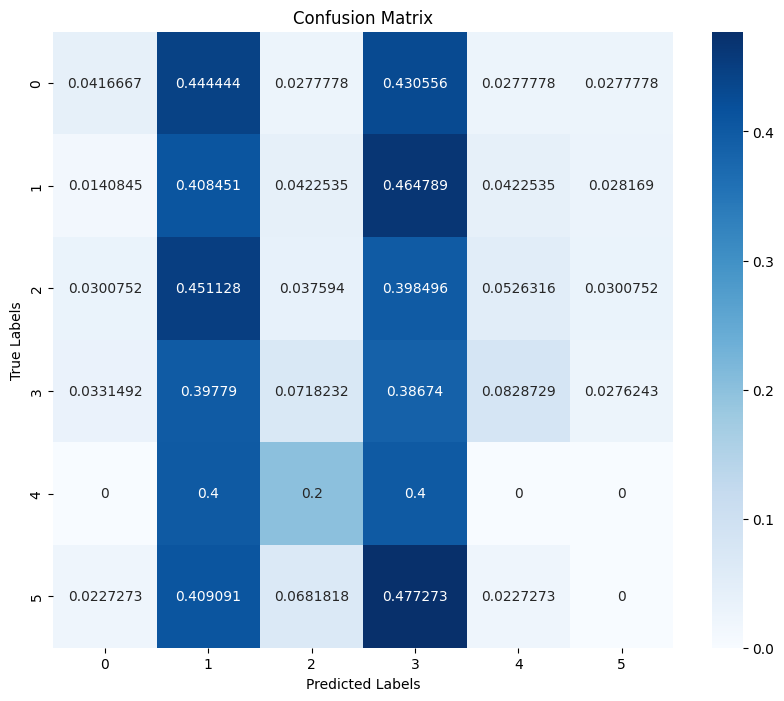

Test Loss: 1.691, Accuracy: 0.236, F1 Score: 0.201, F1 Score Per Class [0.068
Test F1 Score Per Class  [0.06818182 0.30208333 0.06134969 0.33018868 0.         0.        ]


In [4]:
# Call the main function with the path to folder1
imagesRoot = '/kaggle/input/resizedtreedata/ResizedTreeData'

path_to_images = imagesRoot 
train_loader, val_loader, test_loader = load_data(path_to_images)

def load_pretrained_vit(num_labels):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_labels)
    return model

num_classes = 6  # Adjust as per your dataset
num_epochs = 20
learning_rate = 9e-03
# Load the pretrained ResNet-50 model
# model = models.resnet50(pretrained=True)
vit_model = load_pretrained_vit(num_labels=num_classes)

# model.fc = nn.Linear(model.fc.in_features, num_classes)
# Initialize best F1 score for validation

best_val_f1 = 0.0
best_model_weights = None
model_name = 'TreesDelftV001'
trained_model = train_and_evaluate(vit_model, train_loader, val_loader, test_loader, model_name, num_epochs, learning_rate)

Test:   1%|▏         | 1/73 [00:00<00:34,  2.08it/s, loss=1.66]

[tensor([ 0.0171,  0.1332,  0.0662,  0.1416, -2.1375,  0.0214], device='cuda:0'), tensor([-0.2304,  0.0219, -0.1733,  0.0070, -0.2967, -0.3117], device='cuda:0'), tensor([ 0.1514,  0.1408,  0.2507,  0.2684, -1.8404,  0.1764], device='cuda:0'), tensor([ 0.0917,  0.1409,  0.1000,  0.1937, -1.6235,  0.0957], device='cuda:0'), tensor([-0.0908,  0.0568, -0.0834,  0.0176, -1.4889, -0.1449], device='cuda:0'), tensor([ 0.0777,  0.1685,  0.1120,  0.2083, -0.9891,  0.0541], device='cuda:0'), tensor([-0.0285, -0.0208, -0.0795,  0.0065, -1.0065, -0.0392], device='cuda:0'), tensor([-0.3681, -0.0519, -0.3941, -0.2132, -0.4514, -0.4518], device='cuda:0')]


Test:   3%|▎         | 2/73 [00:00<00:30,  2.33it/s, loss=1.7]

[tensor([-0.0863, -0.0224, -0.1584, -0.0797, -0.7440, -0.1126], device='cuda:0'), tensor([ 0.0874,  0.0497,  0.0713,  0.0964, -1.6877,  0.0493], device='cuda:0'), tensor([-0.1443,  0.0251, -0.1633, -0.0202, -0.4773, -0.2248], device='cuda:0'), tensor([-0.1040,  0.0868, -0.0175,  0.1050, -1.2394, -0.1805], device='cuda:0'), tensor([-0.0270,  0.1057,  0.1165,  0.1348, -1.5225, -0.0328], device='cuda:0'), tensor([-0.0419,  0.0906, -0.0307,  0.0541, -0.6915, -0.0822], device='cuda:0'), tensor([-0.0350,  0.0913,  0.0265,  0.0691, -0.6400, -0.0857], device='cuda:0'), tensor([-0.1235,  0.0744, -0.0308,  0.0711, -0.5041, -0.1604], device='cuda:0')]


Test:   4%|▍         | 3/73 [00:01<00:28,  2.42it/s, loss=1.69]

[tensor([-0.0282,  0.1522,  0.0780,  0.1736, -1.2764, -0.0391], device='cuda:0'), tensor([-0.0607,  0.0680,  0.0493,  0.0987, -0.6121, -0.0563], device='cuda:0'), tensor([-0.1460,  0.0499, -0.1021, -0.0100, -0.9054, -0.1708], device='cuda:0'), tensor([-0.3722, -0.0551, -0.3021, -0.1288, -0.6933, -0.4524], device='cuda:0'), tensor([-0.0952,  0.0005,  0.0499,  0.1019, -0.3561, -0.1082], device='cuda:0'), tensor([-0.0029,  0.0410,  0.0570,  0.0920, -2.0414,  0.0091], device='cuda:0'), tensor([-0.2498, -0.0598, -0.3393, -0.1882, -0.1371, -0.3203], device='cuda:0'), tensor([ 0.1161,  0.0693,  0.2127,  0.2169, -2.1112,  0.1548], device='cuda:0')]


Test:   5%|▌         | 4/73 [00:01<00:28,  2.44it/s, loss=1.67]

[tensor([-0.1179,  0.0183, -0.1522, -0.0512, -0.4636, -0.1690], device='cuda:0'), tensor([-0.0567,  0.0508,  0.0903,  0.1415, -0.7100, -0.0565], device='cuda:0'), tensor([-0.1291, -0.0676, -0.0223, -0.0392, -1.9996, -0.1093], device='cuda:0'), tensor([-0.3117,  0.0261, -0.3295, -0.1617,  0.1939, -0.4178], device='cuda:0'), tensor([-0.0530,  0.0633,  0.0343,  0.1226, -0.7384, -0.0660], device='cuda:0'), tensor([-0.0643,  0.0783, -0.0290,  0.1201, -0.4056, -0.1684], device='cuda:0'), tensor([-0.0870,  0.0395,  0.0645,  0.1328, -1.3098, -0.0633], device='cuda:0'), tensor([-0.0249,  0.0054, -0.0067,  0.0192, -1.6888,  0.0039], device='cuda:0')]


Test:   7%|▋         | 5/73 [00:02<00:27,  2.46it/s, loss=1.74]

[tensor([-0.1305,  0.0294, -0.0918,  0.0086, -0.4525, -0.2027], device='cuda:0'), tensor([ 8.4432e-01,  1.0033e-01,  7.3035e-02,  1.7903e-03, -4.5948e+00,
         8.4329e-01], device='cuda:0'), tensor([ 0.0351,  0.0660,  0.1335,  0.1286, -1.0036,  0.0285], device='cuda:0'), tensor([-0.1524, -0.0386, -0.0340,  0.0174, -0.5652, -0.1703], device='cuda:0'), tensor([-0.1828,  0.0465, -0.1137,  0.0243, -0.2365, -0.2308], device='cuda:0'), tensor([-0.4971, -0.1360, -0.5110, -0.3351, -0.7753, -0.5926], device='cuda:0'), tensor([-0.2653, -0.0546, -0.1999, -0.0839, -0.6879, -0.3074], device='cuda:0'), tensor([-0.1136,  0.0978, -0.0294,  0.0926, -0.5483, -0.1839], device='cuda:0')]


Test:   8%|▊         | 6/73 [00:02<00:27,  2.46it/s, loss=1.68]

[tensor([-0.1207, -0.0363, -0.1159, -0.0182, -0.7931, -0.1526], device='cuda:0'), tensor([-0.0605,  0.0256,  0.0574,  0.1018, -0.8529, -0.0364], device='cuda:0'), tensor([-0.1789,  0.0799, -0.1035,  0.0446, -0.7395, -0.2756], device='cuda:0'), tensor([ 0.0358,  0.1300,  0.0747,  0.1478, -0.9073, -0.0103], device='cuda:0'), tensor([-0.2474,  0.0492, -0.2002, -0.0338, -0.0670, -0.3396], device='cuda:0'), tensor([-0.0593,  0.0251, -0.0490,  0.0424, -3.3138, -0.0950], device='cuda:0'), tensor([-0.0269,  0.0349, -0.0282,  0.0255, -1.5998, -0.0329], device='cuda:0'), tensor([-0.2033,  0.0059, -0.2514, -0.1314, -0.9492, -0.3093], device='cuda:0')]


Test:  10%|▉         | 7/73 [00:02<00:26,  2.48it/s, loss=1.68]

[tensor([-0.4035, -0.0181, -0.4406, -0.2026, -0.2143, -0.5615], device='cuda:0'), tensor([-0.2397,  0.0301, -0.1596, -0.0334, -0.4111, -0.3270], device='cuda:0'), tensor([-0.2152, -0.0104, -0.3023, -0.1052, -0.3083, -0.2475], device='cuda:0'), tensor([-0.0587,  0.0099, -0.0235,  0.0579, -0.8270, -0.1064], device='cuda:0'), tensor([ 0.0109,  0.0823,  0.1399,  0.1655, -1.3406,  0.0291], device='cuda:0'), tensor([-0.2654, -0.1525, -0.3377, -0.2055, -0.0966, -0.3258], device='cuda:0'), tensor([ 0.0223,  0.1294,  0.1343,  0.1905, -1.3417,  0.0207], device='cuda:0'), tensor([-0.1265,  0.0466, -0.0534,  0.0516, -3.2048, -0.1487], device='cuda:0')]


Test:  11%|█         | 8/73 [00:03<00:26,  2.49it/s, loss=1.62]

[tensor([ 0.0403,  0.0255,  0.1552,  0.1237, -1.2767,  0.0820], device='cuda:0'), tensor([-0.0085,  0.0688,  0.1336,  0.1118, -2.0200,  0.0208], device='cuda:0'), tensor([-0.2511,  0.0220, -0.2787, -0.1112, -0.2081, -0.3398], device='cuda:0'), tensor([ 0.0821,  0.0619,  0.0925,  0.1488, -3.1567,  0.1249], device='cuda:0'), tensor([-0.1560,  0.0222, -0.0329,  0.0364, -1.5541, -0.1733], device='cuda:0'), tensor([-0.3165, -0.0487, -0.2586, -0.1125, -1.4530, -0.3699], device='cuda:0'), tensor([ 0.0375,  0.0576,  0.1170,  0.1118, -2.2375,  0.0575], device='cuda:0'), tensor([-0.1120,  0.1108, -0.0364,  0.0984, -0.9368, -0.1950], device='cuda:0')]


Test:  12%|█▏        | 9/73 [00:03<00:25,  2.50it/s, loss=1.6]

[tensor([-0.2688, -0.0643, -0.2188, -0.0957, -1.2855, -0.2932], device='cuda:0'), tensor([-0.0078,  0.0467,  0.0115,  0.1004, -2.4192, -0.0279], device='cuda:0'), tensor([ 0.0486,  0.1827,  0.1399,  0.1944, -2.4844,  0.0248], device='cuda:0'), tensor([ 0.1078,  0.0734,  0.1129,  0.1369, -1.3690,  0.0700], device='cuda:0'), tensor([-0.1841,  0.0550, -0.2075, -0.0626, -0.8160, -0.2688], device='cuda:0'), tensor([-0.1338,  0.0538, -0.0402,  0.0759, -0.4475, -0.1950], device='cuda:0'), tensor([-0.0657,  0.0864, -0.0401,  0.1061, -2.3185, -0.1270], device='cuda:0'), tensor([-0.2121,  0.0341, -0.1654, -0.0482, -0.2504, -0.2806], device='cuda:0')]


Test:  14%|█▎        | 10/73 [00:04<00:25,  2.49it/s, loss=1.71]

[tensor([-0.1738, -0.0656, -0.5626, -0.2537, -0.4887, -0.2392], device='cuda:0'), tensor([ 3.8783e-02,  7.3137e-02,  1.6363e-02,  5.5687e-02, -1.8492e+00,
        -1.8115e-03], device='cuda:0'), tensor([-0.0940,  0.0728, -0.0257,  0.1248, -0.6371, -0.1575], device='cuda:0'), tensor([-0.0740,  0.0881, -0.0096,  0.1146, -1.4285, -0.1315], device='cuda:0'), tensor([ 0.0546,  0.1684,  0.1789,  0.1937, -2.6175,  0.0457], device='cuda:0'), tensor([-0.2107, -0.0594, -0.1735, -0.0699, -0.1656, -0.1866], device='cuda:0'), tensor([-0.2512, -0.0098, -0.3059, -0.1140, -1.5462, -0.3249], device='cuda:0'), tensor([ 0.0378,  0.0986,  0.0441,  0.1132, -1.3877,  0.0340], device='cuda:0')]


Test:  15%|█▌        | 11/73 [00:04<00:24,  2.49it/s, loss=1.72]

[tensor([-0.1730,  0.0564, -0.0965,  0.0435,  0.2111, -0.2528], device='cuda:0'), tensor([-0.1129,  0.0791, -0.0038,  0.0577, -0.7128, -0.1330], device='cuda:0'), tensor([ 0.4573,  0.1504,  0.4855,  0.2697, -3.1842,  0.5293], device='cuda:0'), tensor([ 0.0171,  0.0368,  0.0090,  0.0919, -1.7925, -0.0160], device='cuda:0'), tensor([-0.1315,  0.0225, -0.0477,  0.0840, -2.4732, -0.1794], device='cuda:0'), tensor([-0.1140,  0.0799, -0.0247,  0.0881, -0.2992, -0.1528], device='cuda:0'), tensor([-0.0740, -0.0948, -0.0389, -0.0083, -0.4777, -0.1336], device='cuda:0'), tensor([-0.0087,  0.1328,  0.0728,  0.1783, -1.1634, -0.0453], device='cuda:0')]


Test:  16%|█▋        | 12/73 [00:04<00:24,  2.49it/s, loss=1.89]

[tensor([ 0.2890,  0.1897,  0.4576,  0.3866, -1.7426,  0.3297], device='cuda:0'), tensor([-0.0243, -0.0294, -0.1288, -0.0273, -1.0088, -0.0683], device='cuda:0'), tensor([ 0.0839,  0.1102,  0.1934,  0.1932, -1.9330,  0.0548], device='cuda:0'), tensor([ 0.3193,  0.1642,  0.3361,  0.2212, -2.9800,  0.3498], device='cuda:0'), tensor([-0.0163,  0.0477,  0.0254,  0.0408, -0.8323, -0.0150], device='cuda:0'), tensor([-0.0199,  0.0563,  0.0567,  0.0881, -3.0049, -0.0453], device='cuda:0'), tensor([-0.0611,  0.0347,  0.0184,  0.0907, -1.3495, -0.0989], device='cuda:0'), tensor([ 0.0044,  0.1096,  0.0911,  0.1707, -1.2432, -0.0433], device='cuda:0')]


Test:  18%|█▊        | 13/73 [00:05<00:24,  2.50it/s, loss=1.61]

[tensor([ 0.1325,  0.0333,  0.2011,  0.1211, -1.7699,  0.1044], device='cuda:0'), tensor([-0.1932,  0.0852, -0.0931,  0.0610, -1.0812, -0.2716], device='cuda:0'), tensor([-0.0455,  0.0267,  0.0079,  0.0435, -0.8468, -0.0407], device='cuda:0'), tensor([-0.0819,  0.0792, -0.0704,  0.0792, -0.8904, -0.1209], device='cuda:0'), tensor([ 0.1078,  0.1249,  0.1642,  0.2490, -3.8027,  0.1308], device='cuda:0'), tensor([-0.1079,  0.0438, -0.0059,  0.0671, -1.0082, -0.1463], device='cuda:0'), tensor([-0.1471,  0.0870, -0.0663,  0.0472, -0.9383, -0.1882], device='cuda:0'), tensor([-6.4659e-02,  4.4425e-02, -2.4975e-04,  9.2620e-02, -3.9044e-01,
        -1.0821e-01], device='cuda:0')]


Test:  19%|█▉        | 14/73 [00:05<00:23,  2.50it/s, loss=1.69]

[tensor([-0.1961,  0.0225, -0.2060, -0.0332, -1.2344, -0.2505], device='cuda:0'), tensor([-0.1053,  0.0311, -0.0106,  0.0544, -1.3705, -0.1013], device='cuda:0'), tensor([-0.2849, -0.0381, -0.2897, -0.1763, -1.1897, -0.3360], device='cuda:0'), tensor([-0.0417,  0.1071, -0.0355,  0.0932, -1.1308, -0.1028], device='cuda:0'), tensor([-0.1794,  0.0027, -0.0579, -0.0008, -0.3488, -0.1741], device='cuda:0'), tensor([-0.0980,  0.0358,  0.0425,  0.1004, -3.2532, -0.0742], device='cuda:0'), tensor([-0.1253, -0.0209, -0.1159, -0.0317, -0.3066, -0.1543], device='cuda:0'), tensor([-0.1670, -0.0368, -0.2952, -0.1723, -0.4792, -0.2155], device='cuda:0')]


Test:  21%|██        | 15/73 [00:06<00:23,  2.49it/s, loss=1.7]

[tensor([ 0.2116,  0.2230,  0.2081,  0.3780, -1.9264,  0.1476], device='cuda:0'), tensor([-0.1599, -0.0044, -0.1092,  0.0038, -0.9859, -0.2056], device='cuda:0'), tensor([-0.0516,  0.0191, -0.2491, -0.0340, -1.1914, -0.1439], device='cuda:0'), tensor([ 3.4206e-04,  1.0338e-01,  6.0922e-02,  1.8346e-01, -1.2423e+00,
        -7.8421e-02], device='cuda:0'), tensor([-0.2307,  0.0070, -0.1648, -0.0142, -0.4060, -0.2984], device='cuda:0'), tensor([-0.1814, -0.0732, -0.1065, -0.0296,  0.1454, -0.1792], device='cuda:0'), tensor([-0.0929,  0.0241,  0.0222,  0.0826, -2.1687, -0.1115], device='cuda:0'), tensor([-0.1482,  0.0198, -0.1013,  0.0292, -0.2651, -0.2421], device='cuda:0')]


Test:  22%|██▏       | 16/73 [00:06<00:22,  2.48it/s, loss=1.65]

[tensor([-0.1566,  0.0174, -0.1147, -0.0056, -1.3324, -0.2471], device='cuda:0'), tensor([-0.1009,  0.0460, -0.0408, -0.0036, -0.2893, -0.1173], device='cuda:0'), tensor([ 0.1429,  0.1580,  0.0389,  0.1873, -1.6302,  0.0455], device='cuda:0'), tensor([ 0.0922,  0.1114,  0.0949,  0.2579, -1.3832,  0.0440], device='cuda:0'), tensor([-0.3026,  0.0023, -0.3880, -0.1551, -1.3629, -0.3881], device='cuda:0'), tensor([-0.3218, -0.0366, -0.2432, -0.1115,  0.1559, -0.3754], device='cuda:0'), tensor([-0.1723,  0.0374, -0.1373,  0.0381, -0.9484, -0.2300], device='cuda:0'), tensor([-0.0483,  0.0933,  0.0472,  0.1231, -0.6881, -0.0857], device='cuda:0')]


Test:  23%|██▎       | 17/73 [00:06<00:22,  2.48it/s, loss=1.64]

[tensor([-0.1231,  0.0826, -0.0163,  0.1047, -1.2421, -0.1598], device='cuda:0'), tensor([-0.1022,  0.0321,  0.0051,  0.0774, -0.4704, -0.1128], device='cuda:0'), tensor([ 0.1490,  0.0400,  0.2026,  0.1445, -1.5462,  0.1424], device='cuda:0'), tensor([-0.2188,  0.0608, -0.1745, -0.0496, -1.4855, -0.2607], device='cuda:0'), tensor([-0.1727, -0.0556, -0.3186, -0.1558, -2.0026, -0.2275], device='cuda:0'), tensor([-0.1008, -0.0506, -0.0199,  0.0467,  0.0084, -0.1249], device='cuda:0'), tensor([ 0.0247,  0.1075,  0.0278,  0.1549, -2.7605, -0.0515], device='cuda:0'), tensor([ 0.0607,  0.1265,  0.0666,  0.1414, -1.4421,  0.0537], device='cuda:0')]


Test:  25%|██▍       | 18/73 [00:07<00:22,  2.47it/s, loss=1.66]

[tensor([-8.6435e-02, -2.0785e-04,  5.1305e-02,  2.1148e-02, -2.5095e+00,
        -5.0137e-02], device='cuda:0'), tensor([-0.2236,  0.0603, -0.2237, -0.0567, -0.3879, -0.3110], device='cuda:0'), tensor([-0.0860,  0.0773,  0.0498,  0.1020, -0.5858, -0.0772], device='cuda:0'), tensor([-0.2554, -0.0953, -0.2183, -0.1380, -0.9515, -0.2539], device='cuda:0'), tensor([-0.2752, -0.0231, -0.2075, -0.0543, -0.6655, -0.3332], device='cuda:0'), tensor([-0.2766,  0.0283, -0.2121, -0.0395, -0.1633, -0.3591], device='cuda:0'), tensor([-0.0470,  0.0506,  0.0737,  0.1309, -1.1429, -0.0637], device='cuda:0'), tensor([-0.3043, -0.0860, -0.3279, -0.2195, -0.7659, -0.3624], device='cuda:0')]


Test:  26%|██▌       | 19/73 [00:07<00:21,  2.48it/s, loss=1.66]

[tensor([-0.0816,  0.0160,  0.0335,  0.0802, -0.6919, -0.0709], device='cuda:0'), tensor([-0.0599,  0.0638,  0.0570,  0.1126, -1.1133, -0.0906], device='cuda:0'), tensor([-0.4425, -0.1307, -0.4537, -0.2942,  0.1902, -0.5283], device='cuda:0'), tensor([-0.4093, -0.1273, -0.3951, -0.2163,  0.0864, -0.4919], device='cuda:0'), tensor([ 0.0515,  0.0850,  0.1526,  0.1985, -1.4300,  0.0424], device='cuda:0'), tensor([ 0.2784,  0.1680,  0.3553,  0.2932, -2.8012,  0.3229], device='cuda:0'), tensor([-0.0112,  0.0494,  0.0351,  0.0337, -2.0363, -0.0276], device='cuda:0'), tensor([-0.1170, -0.0256, -0.0685,  0.0551, -1.4522, -0.1345], device='cuda:0')]


Test:  27%|██▋       | 20/73 [00:08<00:21,  2.47it/s, loss=1.71]

[tensor([ 0.2650,  0.0569,  0.1582,  0.1282, -1.5886,  0.2842], device='cuda:0'), tensor([-0.1601, -0.0774, -0.0309,  0.0043, -1.8104, -0.1612], device='cuda:0'), tensor([-0.1375,  0.0285, -0.1795, -0.0550, -0.4006, -0.2083], device='cuda:0'), tensor([ 0.2394,  0.0334,  0.1636,  0.1313, -2.0343,  0.1970], device='cuda:0'), tensor([-0.0449,  0.0760, -0.0063,  0.1205, -0.9511, -0.1123], device='cuda:0'), tensor([-0.1390, -0.0583, -0.1634, -0.0577,  0.2305, -0.1963], device='cuda:0'), tensor([-0.0789, -0.1519, -0.4417, -0.2318, -1.7606, -0.2831], device='cuda:0'), tensor([ 0.1955,  0.1890,  0.2251,  0.3638, -1.8071,  0.1643], device='cuda:0')]


Test:  29%|██▉       | 21/73 [00:08<00:21,  2.47it/s, loss=1.66]

[tensor([-0.1420,  0.0376, -0.1306,  0.0121, -0.6412, -0.1999], device='cuda:0'), tensor([-0.1418,  0.0379, -0.1219,  0.0504, -0.4597, -0.2556], device='cuda:0'), tensor([-0.1533, -0.0909, -0.0592, -0.0144, -2.3686, -0.1608], device='cuda:0'), tensor([-0.0176, -0.0449,  0.0052,  0.0615, -0.8585, -0.0145], device='cuda:0'), tensor([-0.1393,  0.0707, -0.0653,  0.0428, -0.6381, -0.2006], device='cuda:0'), tensor([-0.0827,  0.1249,  0.0138,  0.0954, -1.2757, -0.1017], device='cuda:0'), tensor([-0.0390,  0.0764, -0.1638,  0.0070, -1.6924, -0.1346], device='cuda:0'), tensor([-0.1863,  0.0355, -0.1458, -0.0588, -1.9606, -0.2041], device='cuda:0')]


Test:  30%|███       | 22/73 [00:08<00:20,  2.47it/s, loss=1.74]

[tensor([-0.0635,  0.0665,  0.0332,  0.0796, -1.0651, -0.0615], device='cuda:0'), tensor([-0.0819,  0.0368, -0.0287,  0.0651, -0.6163, -0.0831], device='cuda:0'), tensor([-0.1034,  0.0418, -0.0128,  0.0505, -0.5496, -0.1368], device='cuda:0'), tensor([-0.1924,  0.0634, -0.0942,  0.0228, -0.1034, -0.2271], device='cuda:0'), tensor([-0.1691,  0.0472, -0.1622,  0.0349, -0.4001, -0.2433], device='cuda:0'), tensor([-0.1733, -0.0005, -0.2713, -0.0426, -0.3337, -0.2889], device='cuda:0'), tensor([-0.3395, -0.1343, -0.2679, -0.2149, -0.7991, -0.3425], device='cuda:0'), tensor([-0.1843,  0.0359, -0.1267, -0.0417, -0.5162, -0.2137], device='cuda:0')]


Test:  32%|███▏      | 23/73 [00:09<00:20,  2.47it/s, loss=1.7]

[tensor([-0.0309,  0.0863,  0.0723,  0.0596, -3.1636, -0.0615], device='cuda:0'), tensor([-0.4738, -0.0850, -0.6272, -0.3079,  0.6326, -0.5740], device='cuda:0'), tensor([-0.2736, -0.0487, -0.4564, -0.2761, -1.5509, -0.3578], device='cuda:0'), tensor([ 0.1551,  0.1648,  0.1035,  0.2044, -2.1034,  0.1623], device='cuda:0'), tensor([-0.1875, -0.0663, -0.1110, -0.0727, -0.4629, -0.1816], device='cuda:0'), tensor([-0.2005,  0.0048, -0.2091, -0.0676, -0.3933, -0.2275], device='cuda:0'), tensor([-0.2575, -0.0316, -0.2416, -0.0961,  0.0310, -0.3458], device='cuda:0'), tensor([-0.0265,  0.0588,  0.0972,  0.1353, -0.9392, -0.0475], device='cuda:0')]


Test:  33%|███▎      | 24/73 [00:09<00:19,  2.47it/s, loss=1.61]

[tensor([-0.1300,  0.0406, -0.0030,  0.0775, -0.1982, -0.1699], device='cuda:0'), tensor([ 0.0753,  0.0779,  0.1727,  0.2377, -2.1690,  0.0781], device='cuda:0'), tensor([-2.4596e-02, -6.5398e-04,  1.3135e-01,  1.0815e-01, -1.1005e+00,
         2.8903e-02], device='cuda:0'), tensor([-0.1078, -0.0822, -0.1367, -0.1234, -1.2888, -0.1533], device='cuda:0'), tensor([-1.3182e-03,  8.7814e-02,  6.9182e-02,  1.3834e-01, -1.8292e+00,
        -3.1692e-02], device='cuda:0'), tensor([ 0.0172,  0.0570,  0.0934,  0.1089, -1.0043,  0.0202], device='cuda:0'), tensor([-0.2273, -0.0141, -0.3418, -0.1202, -0.8287, -0.3226], device='cuda:0'), tensor([-0.0745,  0.0293, -0.1787, -0.0163, -3.0737, -0.1027], device='cuda:0')]


Test:  34%|███▍      | 25/73 [00:10<00:19,  2.48it/s, loss=1.72]

[tensor([-0.2782, -0.0554, -0.2219, -0.0690, -0.6202, -0.3792], device='cuda:0'), tensor([-0.1661, -0.0595, -0.1424, -0.0762, -0.3310, -0.1786], device='cuda:0'), tensor([-0.3865, -0.0760, -0.4687, -0.2013,  0.2944, -0.4750], device='cuda:0'), tensor([-0.0286,  0.0283,  0.0030,  0.0464, -1.3326, -0.0469], device='cuda:0'), tensor([-0.0803,  0.0813,  0.0287,  0.1120, -0.4081, -0.1157], device='cuda:0'), tensor([-0.1305,  0.0663, -0.0531,  0.0586, -0.4747, -0.2061], device='cuda:0'), tensor([-0.0811,  0.1304, -0.0800,  0.0839, -0.5900, -0.1787], device='cuda:0'), tensor([ 0.0462,  0.0305,  0.1281,  0.1259, -1.1514,  0.0925], device='cuda:0')]


Test:  36%|███▌      | 26/73 [00:10<00:19,  2.47it/s, loss=1.69]

[tensor([-0.3069, -0.1978, -0.6132, -0.3850, -0.0180, -0.4153], device='cuda:0'), tensor([-0.3994, -0.1343, -0.3643, -0.2267, -1.2011, -0.4341], device='cuda:0'), tensor([-0.0252,  0.0607,  0.0775,  0.1340, -1.8362, -0.0264], device='cuda:0'), tensor([-0.0862,  0.1214, -0.0326,  0.0523, -0.3873, -0.1502], device='cuda:0'), tensor([ 0.5444,  0.1351,  0.2665,  0.1877, -3.0945,  0.5516], device='cuda:0'), tensor([-0.0147,  0.0923,  0.0530,  0.1721, -0.6990, -0.0724], device='cuda:0'), tensor([-0.2207,  0.0465, -0.1802, -0.0218, -0.4770, -0.2965], device='cuda:0'), tensor([-0.2420,  0.0085, -0.1620, -0.0266, -0.3831, -0.3036], device='cuda:0')]


Test:  37%|███▋      | 27/73 [00:10<00:18,  2.47it/s, loss=1.63]

[tensor([-0.2863, -0.0213, -0.1968, -0.0628, -0.2563, -0.3637], device='cuda:0'), tensor([-0.0906,  0.1083, -0.3565, -0.0686, -1.9054, -0.2627], device='cuda:0'), tensor([-0.2469, -0.0057, -0.1494, -0.0665, -0.9252, -0.2997], device='cuda:0'), tensor([-0.1126,  0.0569, -0.0798,  0.0158, -3.0396, -0.1089], device='cuda:0'), tensor([-0.0855,  0.0524,  0.0549,  0.0813, -1.6081, -0.1035], device='cuda:0'), tensor([-0.0133,  0.0624,  0.0135,  0.1564, -0.8206, -0.1026], device='cuda:0'), tensor([-0.2146,  0.0039, -0.0975, -0.0101, -1.1802, -0.2742], device='cuda:0'), tensor([-0.1459, -0.0751, -0.1779, -0.0978, -0.4636, -0.1756], device='cuda:0')]


Test:  38%|███▊      | 28/73 [00:11<00:18,  2.46it/s, loss=1.71]

[tensor([ 0.6368,  0.2504,  0.4345,  0.3268, -3.5097,  0.6507], device='cuda:0'), tensor([-0.4675, -0.1104, -0.7176, -0.3883, -0.2211, -0.6679], device='cuda:0'), tensor([-0.1074,  0.0652, -0.0418,  0.0995, -0.8299, -0.1567], device='cuda:0'), tensor([-0.0689,  0.0554, -0.1456, -0.0300, -3.9443, -0.0898], device='cuda:0'), tensor([-0.3672, -0.0425, -0.4045, -0.2401,  0.0979, -0.4560], device='cuda:0'), tensor([-0.1952,  0.0397, -0.1577, -0.0692, -1.7990, -0.2897], device='cuda:0'), tensor([-0.1558,  0.0631, -0.2227, -0.0501, -0.0981, -0.2746], device='cuda:0'), tensor([-0.0895,  0.0979, -0.0643,  0.0716, -0.8344, -0.1881], device='cuda:0')]


Test:  40%|███▉      | 29/73 [00:11<00:17,  2.46it/s, loss=1.71]

[tensor([ 0.0457,  0.1064,  0.2049,  0.1940, -4.6301,  0.0578], device='cuda:0'), tensor([-0.0436, -0.0057,  0.0673,  0.0791, -0.4492, -0.0557], device='cuda:0'), tensor([-0.0170,  0.1662,  0.0770,  0.1855, -0.9441, -0.0862], device='cuda:0'), tensor([-0.2882,  0.0283, -0.2919, -0.0899, -1.0517, -0.4169], device='cuda:0'), tensor([-0.1502,  0.0157, -0.0615,  0.0520, -0.9355, -0.2233], device='cuda:0'), tensor([-0.0338,  0.1275,  0.0195,  0.1579, -1.5340, -0.0856], device='cuda:0'), tensor([ 1.0054,  0.2762,  0.3742,  0.3439, -4.9782,  1.0439], device='cuda:0'), tensor([-0.1980,  0.0392, -0.2175, -0.0900, -1.6050, -0.2650], device='cuda:0')]


Test:  41%|████      | 30/73 [00:12<00:17,  2.46it/s, loss=1.68]

[tensor([-0.0921, -0.0451, -0.3699, -0.1652, -0.9593, -0.1786], device='cuda:0'), tensor([-0.1562,  0.0257, -0.0928,  0.0134, -0.2065, -0.2064], device='cuda:0'), tensor([-0.2206,  0.0400, -0.1815, -0.0338, -1.0083, -0.2661], device='cuda:0'), tensor([ 0.0746, -0.0756, -0.1244, -0.0726, -1.8552,  0.0785], device='cuda:0'), tensor([-0.1732, -0.0042, -0.2550, -0.1088, -1.1087, -0.2187], device='cuda:0'), tensor([ 0.1622,  0.0955,  0.2396,  0.1640, -1.7350,  0.1953], device='cuda:0'), tensor([ 0.0894,  0.1472,  0.1456,  0.2902, -1.9577,  0.0608], device='cuda:0'), tensor([-0.2381, -0.0312, -0.2679, -0.1476, -0.2883, -0.3025], device='cuda:0')]


Test:  42%|████▏     | 31/73 [00:12<00:17,  2.46it/s, loss=1.72]

[tensor([-0.1835,  0.0738, -0.0986, -0.0134, -0.5632, -0.2417], device='cuda:0'), tensor([-0.2097, -0.0116, -0.1155,  0.0168, -0.6216, -0.2301], device='cuda:0'), tensor([-0.3016,  0.0263, -0.3200, -0.1109, -0.3666, -0.4139], device='cuda:0'), tensor([ 0.0285,  0.1685,  0.0823,  0.1383, -0.9182, -0.0275], device='cuda:0'), tensor([ 0.1823,  0.0777,  0.3431,  0.2430, -3.2473,  0.1971], device='cuda:0'), tensor([ 0.1481,  0.1678,  0.1267,  0.2087, -1.2713,  0.0972], device='cuda:0'), tensor([-0.2426, -0.0091, -0.1711, -0.0482, -0.2703, -0.3001], device='cuda:0'), tensor([-0.1167,  0.0423, -0.0242,  0.0636, -0.0509, -0.1625], device='cuda:0')]


Test:  44%|████▍     | 32/73 [00:12<00:16,  2.46it/s, loss=1.69]

[tensor([ 0.1888,  0.1060,  0.2360,  0.2176, -2.7664,  0.1653], device='cuda:0'), tensor([ 4.3614e-02,  8.3301e-02, -4.3072e-04,  9.7736e-02, -1.0577e+00,
        -2.9288e-02], device='cuda:0'), tensor([-0.1441,  0.0616, -0.0763,  0.0667, -0.2424, -0.1977], device='cuda:0'), tensor([-0.2760, -0.0099, -0.2968, -0.1635, -1.0247, -0.3913], device='cuda:0'), tensor([-0.0362,  0.0716,  0.0389,  0.1415, -0.4465, -0.1011], device='cuda:0'), tensor([-0.1222,  0.0241, -0.0494, -0.0046, -1.0997, -0.1163], device='cuda:0'), tensor([-0.1315, -0.0121, -0.1759, -0.0608, -0.6138, -0.1538], device='cuda:0'), tensor([ 0.0328, -0.0041,  0.0647,  0.1118, -0.9431,  0.0472], device='cuda:0')]


Test:  45%|████▌     | 33/73 [00:13<00:16,  2.46it/s, loss=1.73]

[tensor([ 0.1688,  0.0067,  0.2720,  0.1113, -2.9496,  0.2775], device='cuda:0'), tensor([-0.0620,  0.0866, -0.1535,  0.0240, -1.0051, -0.1372], device='cuda:0'), tensor([-0.1678,  0.0336, -0.0673, -0.0311, -1.1648, -0.2327], device='cuda:0'), tensor([ 0.0089,  0.1016,  0.0378,  0.1280, -0.8910, -0.0339], device='cuda:0'), tensor([-0.1126,  0.0432, -0.0100,  0.0812, -0.7879, -0.1380], device='cuda:0'), tensor([-0.1864,  0.0480, -0.0954,  0.0181, -1.5248, -0.2207], device='cuda:0'), tensor([-0.1257,  0.1246, -0.1181,  0.0231, -0.8376, -0.2002], device='cuda:0'), tensor([-0.4774, -0.2210, -0.7470, -0.4874,  1.0554, -0.6496], device='cuda:0')]


Test:  47%|████▋     | 34/73 [00:13<00:15,  2.45it/s, loss=1.67]

[tensor([ 0.2340,  0.1022,  0.3044,  0.2589, -2.0036,  0.2664], device='cuda:0'), tensor([-0.0392,  0.0607,  0.0077,  0.1222, -0.4385, -0.0882], device='cuda:0'), tensor([-0.2275,  0.0369, -0.1561, -0.0132, -0.3722, -0.3146], device='cuda:0'), tensor([-0.1938, -0.0025, -0.0952,  0.0015, -0.2365, -0.2537], device='cuda:0'), tensor([-0.0594,  0.0437, -0.0116,  0.0676, -0.6860, -0.1044], device='cuda:0'), tensor([-0.2428, -0.0724, -0.1122, -0.0495,  0.0056, -0.2478], device='cuda:0'), tensor([-0.1779, -0.0077, -0.0638,  0.0208, -0.9737, -0.2302], device='cuda:0'), tensor([-0.0027, -0.0175, -0.2115, -0.0248, -0.9858, -0.0449], device='cuda:0')]


Test:  48%|████▊     | 35/73 [00:14<00:15,  2.44it/s, loss=1.78]

[tensor([ 0.0083,  0.1036,  0.0402,  0.1199, -2.7093, -0.0382], device='cuda:0'), tensor([ 0.0964,  0.0690,  0.2070,  0.1156, -2.9589,  0.1223], device='cuda:0'), tensor([-0.0883,  0.0095, -0.0054, -0.0059, -1.0124, -0.0966], device='cuda:0'), tensor([-0.1611,  0.0851, -0.1011,  0.0065, -0.5069, -0.2006], device='cuda:0'), tensor([-0.4942, -0.0364, -0.4874, -0.2537,  0.0693, -0.6200], device='cuda:0'), tensor([-0.1684,  0.0333, -0.0702,  0.0237, -0.4889, -0.2075], device='cuda:0'), tensor([-0.2336,  0.0124, -0.1513, -0.0449, -0.1932, -0.2896], device='cuda:0'), tensor([-0.0747,  0.0711, -0.0179,  0.0967, -0.5478, -0.0904], device='cuda:0')]


Test:  49%|████▉     | 36/73 [00:14<00:15,  2.44it/s, loss=1.69]

[tensor([-0.1585,  0.1039, -0.3130, -0.0465, -0.9704, -0.2872], device='cuda:0'), tensor([-0.0650,  0.0506,  0.0289,  0.0997, -0.7245, -0.0883], device='cuda:0'), tensor([-0.0255,  0.0786,  0.0226,  0.1047, -1.0138, -0.0332], device='cuda:0'), tensor([-0.1680, -0.1327, -0.3360, -0.2769, -2.7898, -0.2109], device='cuda:0'), tensor([-0.3068, -0.0418, -0.1732, -0.1349, -0.4267, -0.3426], device='cuda:0'), tensor([-0.5326, -0.2140, -0.7135, -0.4473,  0.0873, -0.6812], device='cuda:0'), tensor([-1.2085e-04,  6.8498e-02,  4.8878e-02,  1.6976e-01, -1.3910e+00,
        -3.7455e-02], device='cuda:0'), tensor([-0.2249,  0.0235, -0.2381, -0.0482, -0.6047, -0.3309], device='cuda:0')]


Test:  51%|█████     | 37/73 [00:15<00:14,  2.45it/s, loss=1.84]

[tensor([-0.4326, -0.0389, -0.4266, -0.2417,  0.6583, -0.5194], device='cuda:0'), tensor([-0.0430,  0.0047, -0.0623,  0.0352, -0.4938, -0.0982], device='cuda:0'), tensor([-0.0913,  0.0764, -0.0299,  0.0997, -0.4196, -0.1354], device='cuda:0'), tensor([-0.1795,  0.0793, -0.1244,  0.0097, -0.5650, -0.2461], device='cuda:0'), tensor([-0.5478, -0.1250, -0.5826, -0.3638, -0.5258, -0.6699], device='cuda:0'), tensor([-0.0409, -0.1430, -0.1660, -0.1545, -2.8933, -0.0532], device='cuda:0'), tensor([ 0.3142, -0.0686, -0.4760, -0.3312, -3.6286,  0.1330], device='cuda:0'), tensor([-0.0461,  0.1181,  0.0391,  0.1314, -0.8773, -0.0765], device='cuda:0')]


Test:  52%|█████▏    | 38/73 [00:15<00:14,  2.45it/s, loss=1.69]

[tensor([ 0.0519,  0.0792,  0.1418,  0.1642, -2.9289,  0.0402], device='cuda:0'), tensor([-0.1538,  0.0250, -0.2196, -0.0630, -1.2573, -0.2393], device='cuda:0'), tensor([-0.0601,  0.0422, -0.0102,  0.0676, -1.7944, -0.0936], device='cuda:0'), tensor([-0.2149, -0.0213, -0.3096, -0.1033, -0.4070, -0.3662], device='cuda:0'), tensor([ 0.0584,  0.1169,  0.1360,  0.1871, -1.0235,  0.0602], device='cuda:0'), tensor([-0.3170, -0.0314, -0.2672, -0.1291, -0.7734, -0.3830], device='cuda:0'), tensor([-0.3811, -0.0356, -0.3467, -0.1514, -0.3058, -0.4489], device='cuda:0'), tensor([-0.2290, -0.0580, -0.2100, -0.1092, -0.9767, -0.2446], device='cuda:0')]


Test:  53%|█████▎    | 39/73 [00:15<00:13,  2.45it/s, loss=1.69]

[tensor([-0.2271,  0.0469, -0.1229, -0.0102, -0.6745, -0.2823], device='cuda:0'), tensor([-0.1360,  0.0470, -0.0695,  0.0041, -0.8379, -0.1787], device='cuda:0'), tensor([-0.0841,  0.0573, -0.1108,  0.0111, -0.8345, -0.1055], device='cuda:0'), tensor([-0.0573,  0.0446, -0.0023,  0.0810, -0.9573, -0.0761], device='cuda:0'), tensor([-0.1622,  0.0927, -0.0805,  0.0529, -0.8352, -0.2292], device='cuda:0'), tensor([-0.3651, -0.0886, -0.5057, -0.2243, -0.0390, -0.5270], device='cuda:0'), tensor([-0.1551, -0.0217, -0.0762,  0.0031, -0.1409, -0.1721], device='cuda:0'), tensor([-0.1836,  0.0265, -0.1668, -0.0333, -0.7295, -0.2353], device='cuda:0')]


Test:  55%|█████▍    | 40/73 [00:16<00:13,  2.44it/s, loss=1.64]

[tensor([-0.0916, -0.0388, -0.0545, -0.0338, -2.7607, -0.0778], device='cuda:0'), tensor([ 0.1800,  0.0198,  0.0523,  0.0742, -1.2151,  0.1716], device='cuda:0'), tensor([-0.1784,  0.0556, -0.0663,  0.0553, -0.7202, -0.2615], device='cuda:0'), tensor([-1.4662e-01, -2.8490e-04, -4.6527e-01, -1.7291e-01, -1.3156e+00,
        -2.7829e-01], device='cuda:0'), tensor([-0.2947, -0.1038, -0.3172, -0.2077, -2.3972, -0.3343], device='cuda:0'), tensor([-0.1468, -0.0693, -0.1318, -0.0524, -1.4391, -0.1358], device='cuda:0'), tensor([ 0.1186,  0.1604,  0.1093,  0.2862, -1.3189,  0.0741], device='cuda:0'), tensor([-0.2303, -0.0243, -0.1441, -0.0885, -0.1556, -0.1997], device='cuda:0')]


Test:  56%|█████▌    | 41/73 [00:16<00:13,  2.44it/s, loss=1.69]

[tensor([-0.2913, -0.2282, -0.4747, -0.3526, -2.1512, -0.3800], device='cuda:0'), tensor([-0.3012, -0.0119, -0.2023, -0.0600, -0.5295, -0.3500], device='cuda:0'), tensor([-0.0208,  0.1490,  0.0229,  0.1253, -1.3470, -0.0546], device='cuda:0'), tensor([-0.2980, -0.0138, -0.1930, -0.0916, -0.7958, -0.3484], device='cuda:0'), tensor([-0.3917, -0.0761, -0.3830, -0.1483,  0.1786, -0.4892], device='cuda:0'), tensor([-0.4125, -0.2049, -0.6344, -0.3999, -3.3953, -0.5672], device='cuda:0'), tensor([ 0.0612,  0.0209,  0.1112,  0.0928, -2.3606,  0.0740], device='cuda:0'), tensor([-0.1787,  0.0138, -0.2059, -0.0507, -1.0732, -0.2083], device='cuda:0')]


Test:  58%|█████▊    | 42/73 [00:17<00:12,  2.44it/s, loss=1.72]

[tensor([-0.2121,  0.0074, -0.4122, -0.2287,  0.0734, -0.3151], device='cuda:0'), tensor([-0.2342,  0.0225, -0.2162, -0.0265, -0.6776, -0.3121], device='cuda:0'), tensor([-0.1617,  0.0326, -0.0874,  0.0221, -0.5437, -0.1902], device='cuda:0'), tensor([-0.1884, -0.0226, -0.0954, -0.0205, -0.6573, -0.1710], device='cuda:0'), tensor([-0.1170,  0.0268, -0.0504,  0.0614, -2.6606, -0.1635], device='cuda:0'), tensor([-0.1678, -0.0056, -0.0609, -0.0238, -0.7715, -0.1866], device='cuda:0'), tensor([-0.3169, -0.0361, -0.2590, -0.1657, -2.0158, -0.3522], device='cuda:0'), tensor([-0.0797,  0.0527,  0.0464,  0.0820, -0.9434, -0.1017], device='cuda:0')]


Test:  59%|█████▉    | 43/73 [00:17<00:12,  2.43it/s, loss=1.69]

[tensor([-0.1497, -0.0133, -0.1054, -0.0092, -1.3020, -0.1727], device='cuda:0'), tensor([-0.4229, -0.1098, -0.5006, -0.3039,  0.2253, -0.5576], device='cuda:0'), tensor([ 0.0773,  0.0913,  0.1065,  0.1746, -2.4415,  0.0357], device='cuda:0'), tensor([-0.1769,  0.0286, -0.2401, -0.0465, -0.1761, -0.2913], device='cuda:0'), tensor([-0.2423,  0.0151, -0.2368, -0.0850,  0.3235, -0.3160], device='cuda:0'), tensor([-0.2605, -0.0165, -0.2104, -0.0967, -0.6686, -0.2801], device='cuda:0'), tensor([ 0.0060, -0.0320,  0.0739,  0.0481, -3.1227, -0.0077], device='cuda:0'), tensor([-0.0932,  0.0492,  0.0293,  0.0660, -0.5979, -0.0740], device='cuda:0')]


Test:  60%|██████    | 44/73 [00:17<00:11,  2.42it/s, loss=1.69]

[tensor([-0.2453, -0.0236, -0.3127, -0.1194, -0.3927, -0.3692], device='cuda:0'), tensor([-0.0781,  0.0573, -0.1524,  0.0168, -0.4549, -0.0975], device='cuda:0'), tensor([ 0.0351,  0.0900,  0.0740,  0.0987, -0.9902,  0.0212], device='cuda:0'), tensor([-0.1054, -0.0807, -0.3158, -0.1091, -2.5806, -0.1412], device='cuda:0'), tensor([-0.1240,  0.0404, -0.0508,  0.0893, -2.0402, -0.1628], device='cuda:0'), tensor([-0.0265, -0.0058, -0.1649, -0.1171, -0.8629, -0.0396], device='cuda:0'), tensor([-0.0736,  0.0975, -0.0299,  0.0848, -0.3283, -0.1347], device='cuda:0'), tensor([-0.2696, -0.0393, -0.3012, -0.1136, -0.5983, -0.3510], device='cuda:0')]


Test:  62%|██████▏   | 45/73 [00:18<00:11,  2.40it/s, loss=1.74]

[tensor([-0.0156,  0.0454,  0.0444,  0.0738, -2.1337,  0.0159], device='cuda:0'), tensor([-0.2153, -0.0420, -0.2832, -0.1570, -0.2705, -0.2626], device='cuda:0'), tensor([ 0.0188,  0.0685,  0.1160,  0.1170, -1.2146,  0.0399], device='cuda:0'), tensor([ 0.0075,  0.1182,  0.1279,  0.1960, -1.2785, -0.0220], device='cuda:0'), tensor([-0.0459,  0.0544,  0.0854,  0.1581, -4.0924, -0.0852], device='cuda:0'), tensor([-0.0160,  0.1011, -0.0165,  0.1134, -0.4960, -0.0972], device='cuda:0'), tensor([-0.0279,  0.1158,  0.0762,  0.1491, -0.9858, -0.0082], device='cuda:0'), tensor([-0.1217, -0.0248, -0.0397, -0.0129, -4.2245, -0.1676], device='cuda:0')]


Test:  63%|██████▎   | 46/73 [00:18<00:11,  2.41it/s, loss=1.67]

[tensor([-0.1055,  0.0890, -0.0605,  0.0668, -0.3959, -0.1357], device='cuda:0'), tensor([-0.0971,  0.0127, -0.0220,  0.0458, -0.7967, -0.1721], device='cuda:0'), tensor([-0.0565,  0.0070,  0.0330,  0.0464, -1.1682, -0.0523], device='cuda:0'), tensor([-0.2500, -0.0565, -0.3281, -0.1694, -0.4539, -0.3572], device='cuda:0'), tensor([ 0.1368, -0.0225,  0.1755,  0.0837, -1.9017,  0.1605], device='cuda:0'), tensor([ 0.1942,  0.0950,  0.2626,  0.1926, -2.9602,  0.2287], device='cuda:0'), tensor([-0.3419, -0.0777, -0.2939, -0.1472, -0.0755, -0.4228], device='cuda:0'), tensor([ 0.1424,  0.0651,  0.2153,  0.1937, -1.5063,  0.1182], device='cuda:0')]


Test:  64%|██████▍   | 47/73 [00:19<00:10,  2.40it/s, loss=1.59]

[tensor([ 0.0966,  0.1069,  0.1955,  0.2477, -2.2069,  0.0813], device='cuda:0'), tensor([-0.3852, -0.1042, -0.3866, -0.1889, -1.2296, -0.5136], device='cuda:0'), tensor([ 0.1336,  0.1776,  0.1058,  0.3051, -2.6470,  0.0792], device='cuda:0'), tensor([-0.0546,  0.1078,  0.0597,  0.1237, -1.8610, -0.1022], device='cuda:0'), tensor([-0.0290,  0.0483,  0.1002,  0.1157, -3.8442, -0.0478], device='cuda:0'), tensor([-0.0397,  0.0799,  0.0331,  0.1354, -1.3133, -0.0759], device='cuda:0'), tensor([ 0.0265,  0.1427,  0.1223,  0.2054, -1.1766,  0.0105], device='cuda:0'), tensor([-0.0855, -0.0610, -0.1814, -0.1065, -1.4922, -0.1372], device='cuda:0')]


Test:  66%|██████▌   | 48/73 [00:19<00:10,  2.42it/s, loss=1.72]

[tensor([-0.2056, -0.0953, -0.1447, -0.1427, -3.4273, -0.2108], device='cuda:0'), tensor([-0.0949, -0.0020,  0.0063,  0.0689, -0.6163, -0.0838], device='cuda:0'), tensor([-0.0716, -0.0248, -0.1281, -0.0229, -0.9518, -0.0680], device='cuda:0'), tensor([-0.2620, -0.0183, -0.1926, -0.1156, -1.6386, -0.2976], device='cuda:0'), tensor([ 0.0316,  0.0390,  0.0590,  0.1134, -2.4431,  0.0179], device='cuda:0'), tensor([-0.2585,  0.0260, -0.2856, -0.0520, -0.0039, -0.3710], device='cuda:0'), tensor([-0.2601,  0.0474, -0.2132, -0.0142, -0.3445, -0.3628], device='cuda:0'), tensor([ 0.0773,  0.1129,  0.1281,  0.1707, -1.6784,  0.0807], device='cuda:0')]


Test:  67%|██████▋   | 49/73 [00:19<00:09,  2.41it/s, loss=1.69]

[tensor([-0.0550, -0.0147, -0.0231,  0.0854, -1.0737, -0.1388], device='cuda:0'), tensor([-0.1383, -0.0018, -0.0571,  0.0038, -0.0883, -0.1659], device='cuda:0'), tensor([-0.1953,  0.0103, -0.1366, -0.0404, -1.1629, -0.2482], device='cuda:0'), tensor([-0.0268,  0.1158,  0.0858,  0.1631, -0.6193, -0.0769], device='cuda:0'), tensor([-0.2105, -0.0259, -0.1480, -0.0444, -1.3162, -0.2556], device='cuda:0'), tensor([-5.5488e-02,  1.3930e-01, -8.4353e-02,  7.5480e-04, -2.7521e+00,
        -1.1190e-01], device='cuda:0'), tensor([-0.0987,  0.0872, -0.0168,  0.0522, -1.9615, -0.1379], device='cuda:0'), tensor([-0.1873,  0.0029, -0.1069, -0.0138, -0.8116, -0.2125], device='cuda:0')]


Test:  68%|██████▊   | 50/73 [00:20<00:09,  2.42it/s, loss=1.65]

[tensor([-0.2131,  0.0136, -0.1347,  0.0242, -0.0558, -0.2935], device='cuda:0'), tensor([-0.2959, -0.0732, -0.3089, -0.0815, -1.4221, -0.3436], device='cuda:0'), tensor([ 0.0908,  0.2023,  0.0639,  0.3036, -0.9887, -0.0181], device='cuda:0'), tensor([-0.0730,  0.1019, -0.0886,  0.0913, -2.6681, -0.0977], device='cuda:0'), tensor([-0.1120, -0.0276, -0.1453, -0.0988, -1.5903, -0.1042], device='cuda:0'), tensor([ 1.8286e-02,  5.1944e-02,  9.0906e-02,  1.4272e-01, -1.8849e+00,
         4.2462e-04], device='cuda:0'), tensor([-0.1490,  0.0855, -0.0254,  0.0673, -1.2515, -0.1527], device='cuda:0'), tensor([ 0.0868,  0.0910,  0.0874,  0.1366, -2.0270,  0.0338], device='cuda:0')]


Test:  70%|██████▉   | 51/73 [00:20<00:09,  2.42it/s, loss=1.67]

[tensor([-0.1122,  0.1108, -0.0230,  0.0955, -0.6532, -0.1613], device='cuda:0'), tensor([-0.2410,  0.0611, -0.1661, -0.0332, -0.2183, -0.3103], device='cuda:0'), tensor([-0.1734,  0.0159, -0.2564, -0.1070, -0.2950, -0.2264], device='cuda:0'), tensor([-0.2825, -0.0060, -0.2084, -0.1161, -1.0146, -0.3367], device='cuda:0'), tensor([-0.0398,  0.1379,  0.0747,  0.1607, -2.1337, -0.0703], device='cuda:0'), tensor([ 2.1738e-02,  1.3637e-01,  1.0316e-01,  1.4879e-01, -1.4724e+00,
        -1.3856e-03], device='cuda:0'), tensor([-0.0688,  0.0062, -0.0190,  0.0208, -1.7921, -0.0655], device='cuda:0'), tensor([-0.1910,  0.0647, -0.1173, -0.0244, -1.0417, -0.2197], device='cuda:0')]


Test:  71%|███████   | 52/73 [00:21<00:08,  2.41it/s, loss=1.65]

[tensor([-0.1755,  0.0147, -0.0813,  0.0017, -0.9245, -0.2201], device='cuda:0'), tensor([ 0.1661,  0.0101,  0.1793,  0.1279, -1.5375,  0.1651], device='cuda:0'), tensor([-0.2394, -0.0681, -0.2551, -0.1421, -0.1116, -0.2801], device='cuda:0'), tensor([-0.0965,  0.1048, -0.1647,  0.0251, -1.0828, -0.1889], device='cuda:0'), tensor([-0.0756,  0.1020, -0.0173,  0.0947, -0.5704, -0.1567], device='cuda:0'), tensor([ 0.1189,  0.1128,  0.1698,  0.2388, -1.4141,  0.0911], device='cuda:0'), tensor([-0.0162, -0.0452, -0.1752, -0.1019, -1.2537, -0.0572], device='cuda:0'), tensor([-0.2036, -0.2256, -0.3337, -0.2894, -0.9734, -0.2527], device='cuda:0')]


Test:  73%|███████▎  | 53/73 [00:21<00:08,  2.42it/s, loss=1.65]

[tensor([ 0.0638,  0.1168,  0.1715,  0.2730, -1.5635,  0.0437], device='cuda:0'), tensor([-0.2252,  0.0030, -0.1934, -0.0742, -0.3521, -0.2960], device='cuda:0'), tensor([-0.1303,  0.0440, -0.0444,  0.0529, -0.2463, -0.1222], device='cuda:0'), tensor([-0.1298,  0.0768, -0.0590,  0.0227, -1.3339, -0.1649], device='cuda:0'), tensor([-0.0103,  0.0338,  0.1540,  0.1908, -1.0258,  0.0351], device='cuda:0'), tensor([-0.2621, -0.0090, -0.1457, -0.0397, -0.8638, -0.2948], device='cuda:0'), tensor([-0.3711, -0.0127, -0.4146, -0.2246, -1.0082, -0.4426], device='cuda:0'), tensor([-0.0318,  0.0843,  0.0841,  0.1463, -0.9396, -0.0502], device='cuda:0')]


Test:  74%|███████▍  | 54/73 [00:22<00:07,  2.41it/s, loss=1.71]

[tensor([ 0.0080,  0.0443,  0.0710,  0.1469, -0.9714, -0.0286], device='cuda:0'), tensor([ 0.0367,  0.0461,  0.1239,  0.1149, -1.7273,  0.0736], device='cuda:0'), tensor([ 0.1102,  0.1014,  0.1960,  0.2336, -1.0390,  0.1341], device='cuda:0'), tensor([-0.2411, -0.0480, -0.1745, -0.0238, -0.4663, -0.3073], device='cuda:0'), tensor([-0.0680, -0.0419, -0.1193, -0.0667, -0.6474, -0.0895], device='cuda:0'), tensor([-0.0942,  0.0477, -0.0028,  0.0685, -1.0690, -0.0929], device='cuda:0'), tensor([-0.2281, -0.0440, -0.2400, -0.0813, -1.3853, -0.3149], device='cuda:0'), tensor([-0.1194,  0.0757, -0.0695,  0.0690, -0.9194, -0.1904], device='cuda:0')]


Test:  75%|███████▌  | 55/73 [00:22<00:07,  2.41it/s, loss=1.67]

[tensor([ 0.0556,  0.0571,  0.1257,  0.1922, -1.2861,  0.0531], device='cuda:0'), tensor([-0.0581,  0.0776,  0.0711,  0.1101, -0.9264, -0.0442], device='cuda:0'), tensor([-0.1402,  0.0968, -0.1238,  0.0291, -3.2137, -0.1680], device='cuda:0'), tensor([ 0.0125,  0.0736,  0.1321,  0.1580, -1.2103,  0.0220], device='cuda:0'), tensor([-0.2572, -0.0044, -0.1641, -0.0412, -0.7807, -0.3181], device='cuda:0'), tensor([-0.1147,  0.0092, -0.0090,  0.0562, -0.8242, -0.0858], device='cuda:0'), tensor([-0.3290, -0.0607, -0.3049, -0.1129,  0.3354, -0.4230], device='cuda:0'), tensor([ 0.0037,  0.1030,  0.0399,  0.1371, -1.6143, -0.0710], device='cuda:0')]


Test:  77%|███████▋  | 56/73 [00:22<00:07,  2.40it/s, loss=1.7]

[tensor([-0.0045,  0.1033,  0.0764,  0.1505, -1.1454, -0.0095], device='cuda:0'), tensor([-0.1422, -0.0179, -0.1310, -0.0595, -0.8149, -0.1559], device='cuda:0'), tensor([-0.3470,  0.0051, -0.3009, -0.1398, -0.1880, -0.4421], device='cuda:0'), tensor([-0.0933,  0.0783, -0.0522,  0.0583, -0.9071, -0.1411], device='cuda:0'), tensor([-0.0691,  0.0150, -0.0383,  0.0466, -0.5210, -0.1212], device='cuda:0'), tensor([-0.1031,  0.0272, -0.2257, -0.0174, -1.3713, -0.2104], device='cuda:0'), tensor([ 0.1400,  0.1467,  0.1869,  0.1977, -2.7913,  0.1127], device='cuda:0'), tensor([-0.2132,  0.0023, -0.2643, -0.0976, -1.1217, -0.2890], device='cuda:0')]


Test:  78%|███████▊  | 57/73 [00:23<00:06,  2.40it/s, loss=1.74]

[tensor([-0.6258, -0.2774, -0.8335, -0.5610,  0.4204, -0.7795], device='cuda:0'), tensor([-0.1999, -0.0961, -0.2922, -0.1490, -0.8831, -0.2649], device='cuda:0'), tensor([-0.1338,  0.0783,  0.0252,  0.1168, -0.7153, -0.1781], device='cuda:0'), tensor([-0.0182,  0.1103,  0.0611,  0.1238, -1.3124, -0.0352], device='cuda:0'), tensor([-0.2724, -0.1515, -0.2926, -0.1856, -1.2893, -0.2895], device='cuda:0'), tensor([-0.1749, -0.0776, -0.1876, -0.0588, -1.4345, -0.2041], device='cuda:0'), tensor([ 0.0334,  0.0746, -0.0562,  0.0493, -0.9824, -0.0677], device='cuda:0'), tensor([ 0.0358,  0.1023,  0.0805,  0.1878, -1.1913, -0.0349], device='cuda:0')]


Test:  79%|███████▉  | 58/73 [00:23<00:06,  2.40it/s, loss=1.67]

[tensor([-0.2657, -0.1380, -0.2993, -0.2050, -0.4133, -0.3059], device='cuda:0'), tensor([-0.0561,  0.0104, -0.1348,  0.0143, -3.4879, -0.0756], device='cuda:0'), tensor([-0.1105,  0.0802, -0.0649,  0.0376, -0.0501, -0.1769], device='cuda:0'), tensor([-0.0510,  0.0525,  0.0293,  0.1590, -0.7160, -0.0800], device='cuda:0'), tensor([ 0.1341,  0.0784,  0.2287,  0.1887, -2.8145,  0.1709], device='cuda:0'), tensor([ 0.0205,  0.1067,  0.1114,  0.1399, -0.9967,  0.0231], device='cuda:0'), tensor([-0.2181,  0.0118, -0.1345,  0.0263, -0.5666, -0.2653], device='cuda:0'), tensor([-0.0406,  0.1646,  0.0513,  0.2068, -1.0973, -0.1281], device='cuda:0')]


Test:  81%|████████  | 59/73 [00:24<00:05,  2.40it/s, loss=1.65]

[tensor([-0.0481, -0.0834, -0.3127, -0.1833, -2.6417, -0.1031], device='cuda:0'), tensor([-0.2247, -0.0924, -0.1559, -0.1338, -1.3622, -0.2561], device='cuda:0'), tensor([ 0.0441,  0.1272,  0.1626,  0.2102, -1.3082,  0.0333], device='cuda:0'), tensor([ 0.1322,  0.0651,  0.1177,  0.2169, -1.0687,  0.1085], device='cuda:0'), tensor([-0.3488, -0.0335, -0.2535, -0.1045, -1.4486, -0.4082], device='cuda:0'), tensor([-0.0512,  0.0703,  0.0174,  0.0905, -1.2186, -0.0916], device='cuda:0'), tensor([-0.0579,  0.1119, -0.1026,  0.0379, -0.3297, -0.0994], device='cuda:0'), tensor([-0.0288,  0.0842,  0.0945,  0.1563, -1.1290, -0.0519], device='cuda:0')]


Test:  82%|████████▏ | 60/73 [00:24<00:05,  2.40it/s, loss=1.65]

[tensor([-0.0844,  0.0362, -0.1112, -0.0015, -0.6034, -0.0838], device='cuda:0'), tensor([-0.0885,  0.0817,  0.0049,  0.0863, -1.4043, -0.1214], device='cuda:0'), tensor([-0.0633,  0.0999,  0.0204,  0.0915, -1.3750, -0.0605], device='cuda:0'), tensor([-0.0811,  0.0460, -0.0502,  0.0508, -2.7245, -0.1234], device='cuda:0'), tensor([-0.2168,  0.0817, -0.1991, -0.0214, -0.2598, -0.3453], device='cuda:0'), tensor([-0.2875,  0.0011, -0.2499, -0.0262, -0.3782, -0.4136], device='cuda:0'), tensor([-0.2428,  0.0770, -0.2258, -0.0395, -0.4644, -0.3328], device='cuda:0'), tensor([ 0.1883,  0.1114,  0.2039,  0.2589, -1.3458,  0.1797], device='cuda:0')]


Test:  84%|████████▎ | 61/73 [00:24<00:05,  2.40it/s, loss=1.76]

[tensor([ 0.0985,  0.1615,  0.1364,  0.2146, -1.2723,  0.0842], device='cuda:0'), tensor([-0.1793,  0.0272, -0.1369,  0.0239, -0.6664, -0.2509], device='cuda:0'), tensor([-0.3135,  0.0449, -0.2721, -0.0771,  0.2330, -0.4436], device='cuda:0'), tensor([-0.0746,  0.0240, -0.1094,  0.0740, -0.8101, -0.1479], device='cuda:0'), tensor([-0.2102, -0.0153, -0.1997, -0.0821, -0.9141, -0.2356], device='cuda:0'), tensor([-0.1289,  0.0177, -0.2689, -0.0852, -1.7005, -0.2495], device='cuda:0'), tensor([-0.1979,  0.0541, -0.1662,  0.0046, -0.4356, -0.2771], device='cuda:0'), tensor([-0.2123,  0.0073, -0.1873, -0.0554, -0.1552, -0.2503], device='cuda:0')]


Test:  85%|████████▍ | 62/73 [00:25<00:04,  2.40it/s, loss=1.76]

[tensor([-0.1210, -0.1457, -0.2577, -0.1336, -0.3531, -0.1054], device='cuda:0'), tensor([-0.2290,  0.0406, -0.3391, -0.1012, -1.1017, -0.3449], device='cuda:0'), tensor([ 0.5673,  0.0903,  0.6971,  0.3806, -3.6334,  0.7075], device='cuda:0'), tensor([-0.2752, -0.0017, -0.2172, -0.0655, -0.3856, -0.3616], device='cuda:0'), tensor([-0.1379,  0.0257, -0.0463,  0.0592, -0.3726, -0.1719], device='cuda:0'), tensor([ 0.0091,  0.1532,  0.1081,  0.2032, -1.2035,  0.0126], device='cuda:0'), tensor([-0.1064,  0.0166, -0.0137,  0.0244, -3.7655, -0.0945], device='cuda:0'), tensor([ 0.2417,  0.0320,  0.0768,  0.0922, -3.0558,  0.2029], device='cuda:0')]


Test:  86%|████████▋ | 63/73 [00:25<00:04,  2.38it/s, loss=1.68]

[tensor([-0.2064, -0.0439, -0.2265, -0.1783, -0.4206, -0.2547], device='cuda:0'), tensor([-0.0147,  0.0733,  0.0619,  0.1232, -2.4755, -0.0167], device='cuda:0'), tensor([-0.0923, -0.0689, -0.1334, -0.0782, -0.9502, -0.1484], device='cuda:0'), tensor([-0.1553,  0.0778, -0.1967,  0.0075, -1.0846, -0.2519], device='cuda:0'), tensor([ 0.2224,  0.1131,  0.0523,  0.0781, -2.5336,  0.1899], device='cuda:0'), tensor([-0.1505,  0.0382, -0.1966, -0.0423,  0.1493, -0.2155], device='cuda:0'), tensor([-0.1685, -0.0020, -0.1263, -0.0394, -1.3690, -0.1612], device='cuda:0'), tensor([-0.1444,  0.0685, -0.0166,  0.0585, -0.8045, -0.1605], device='cuda:0')]


Test:  88%|████████▊ | 64/73 [00:26<00:03,  2.38it/s, loss=1.68]

[tensor([ 1.4530e-02, -2.9944e-03, -5.5276e-02, -1.6976e-02, -3.8121e+00,
        -2.3851e-02], device='cuda:0'), tensor([ 0.0275,  0.1413,  0.0634,  0.1807, -1.3220, -0.0286], device='cuda:0'), tensor([ 0.1004,  0.1188,  0.1256,  0.1986, -1.4409,  0.1109], device='cuda:0'), tensor([-0.1205,  0.0115, -0.0445,  0.0190, -0.7281, -0.1600], device='cuda:0'), tensor([-0.0132,  0.1005,  0.0684,  0.1200, -0.7027, -0.0272], device='cuda:0'), tensor([-0.1807,  0.0241, -0.0775, -0.0079, -0.5547, -0.2190], device='cuda:0'), tensor([ 0.0914,  0.0315, -0.0333,  0.0127, -1.9559,  0.0625], device='cuda:0'), tensor([-0.1372,  0.0148, -0.0881, -0.0242, -1.2137, -0.1637], device='cuda:0')]


Test:  89%|████████▉ | 65/73 [00:26<00:03,  2.38it/s, loss=1.66]

[tensor([-0.0319,  0.0788,  0.0689,  0.1473, -2.0449, -0.0562], device='cuda:0'), tensor([ 0.0247,  0.1415,  0.1255,  0.2114, -1.2359, -0.0026], device='cuda:0'), tensor([ 0.0085,  0.0634,  0.0875,  0.1852, -1.4128, -0.0393], device='cuda:0'), tensor([-0.0819,  0.0089, -0.0332,  0.0675, -0.4363, -0.0860], device='cuda:0'), tensor([ 1.8672e-02,  2.2534e-03,  6.2379e-02,  4.7465e-02, -2.4348e+00,
         5.2127e-02], device='cuda:0'), tensor([-0.0178,  0.0759,  0.0892,  0.1494, -1.4422, -0.0348], device='cuda:0'), tensor([-0.1031,  0.0207, -0.0089,  0.0677, -0.7358, -0.1153], device='cuda:0'), tensor([-0.0481,  0.0760,  0.0912,  0.1226, -1.0614, -0.0687], device='cuda:0')]


Test:  90%|█████████ | 66/73 [00:27<00:02,  2.39it/s, loss=1.61]

[tensor([ 0.0367,  0.0154,  0.1300,  0.1250, -0.9384,  0.0442], device='cuda:0'), tensor([-0.2757, -0.0951, -0.3447, -0.1602, -2.1518, -0.3766], device='cuda:0'), tensor([ 0.1701,  0.0405,  0.1621,  0.0920, -2.4391,  0.2380], device='cuda:0'), tensor([ 0.0459,  0.0497,  0.1085,  0.1517, -1.7295,  0.0692], device='cuda:0'), tensor([ 0.0873,  0.0559,  0.0844,  0.1355, -3.2202,  0.0963], device='cuda:0'), tensor([-0.1101,  0.0162,  0.0320,  0.0977, -0.4359, -0.0939], device='cuda:0'), tensor([-0.0838,  0.1081,  0.0293,  0.0896, -2.4376, -0.0928], device='cuda:0'), tensor([-0.1023,  0.0542, -0.0978, -0.0148, -2.2576, -0.1205], device='cuda:0')]


Test:  92%|█████████▏| 67/73 [00:27<00:02,  2.38it/s, loss=1.65]

[tensor([-0.2815, -0.0411, -0.3445, -0.1466, -0.2002, -0.3302], device='cuda:0'), tensor([-0.1117,  0.0373, -0.0536,  0.0615, -1.8137, -0.1484], device='cuda:0'), tensor([-0.0060,  0.0971,  0.1119,  0.1510, -1.5131, -0.0397], device='cuda:0'), tensor([-0.1045,  0.1014, -0.0903,  0.0949, -0.9887, -0.1959], device='cuda:0'), tensor([-0.3809, -0.0718, -0.3664, -0.1769, -0.1013, -0.4421], device='cuda:0'), tensor([-0.0888,  0.0821, -0.0153,  0.0935, -0.6150, -0.1388], device='cuda:0'), tensor([-0.0866, -0.0322, -0.0093,  0.0389, -0.6979, -0.0799], device='cuda:0'), tensor([-0.1686,  0.0038, -0.1223,  0.0190, -1.7504, -0.1777], device='cuda:0')]


Test:  93%|█████████▎| 68/73 [00:27<00:02,  2.38it/s, loss=1.63]

[tensor([-0.1958, -0.0832, -0.4895, -0.2509, -0.3071, -0.3230], device='cuda:0'), tensor([-0.0274,  0.0546,  0.0848,  0.1190, -0.8213, -0.0125], device='cuda:0'), tensor([-0.1506,  0.0601, -0.0421,  0.0730, -1.5476, -0.2057], device='cuda:0'), tensor([-0.0717,  0.0756, -0.0601,  0.0487, -0.2981, -0.1626], device='cuda:0'), tensor([-0.1143,  0.0450, -0.0798,  0.0739, -1.5957, -0.1815], device='cuda:0'), tensor([-0.0643,  0.0152,  0.0275,  0.0379, -3.9678, -0.0333], device='cuda:0'), tensor([-0.2035, -0.0723, -0.3317, -0.2013, -0.1417, -0.3290], device='cuda:0'), tensor([ 0.1668, -0.0806,  0.0407,  0.0045, -2.8689,  0.2134], device='cuda:0')]


Test:  95%|█████████▍| 69/73 [00:28<00:01,  2.38it/s, loss=2.02]

[tensor([-0.0472,  0.0383,  0.0540,  0.0621, -4.1697, -0.0499], device='cuda:0'), tensor([-0.0746,  0.1482,  0.0149,  0.1316, -0.6591, -0.1245], device='cuda:0'), tensor([ 0.0844,  0.1028,  0.1258,  0.1663, -2.8753,  0.1192], device='cuda:0'), tensor([-0.0699,  0.0637, -0.0182,  0.0698, -1.3737, -0.0934], device='cuda:0'), tensor([ 0.1214, -0.0238,  0.1435,  0.0286, -2.9858,  0.2196], device='cuda:0'), tensor([ 0.1212,  0.1206,  0.0918,  0.1329, -1.9191,  0.1361], device='cuda:0'), tensor([ 0.1139,  0.0943,  0.1799,  0.2331, -0.9778,  0.1231], device='cuda:0'), tensor([-0.2413, -0.0417, -0.4115, -0.2288, -0.8416, -0.3237], device='cuda:0')]


Test:  96%|█████████▌| 70/73 [00:28<00:01,  2.39it/s, loss=1.63]

[tensor([ 0.1380,  0.1221,  0.2254,  0.2302, -1.6048,  0.1351], device='cuda:0'), tensor([-0.0739,  0.0030,  0.0751,  0.1138, -0.8474, -0.0750], device='cuda:0'), tensor([-0.0606,  0.0671,  0.0241,  0.1002, -1.9202, -0.0713], device='cuda:0'), tensor([ 0.0423,  0.0328,  0.0921,  0.0872, -1.3011,  0.0327], device='cuda:0'), tensor([-0.2572, -0.0551, -0.3348, -0.1480,  0.4109, -0.3150], device='cuda:0'), tensor([-0.2156,  0.0078, -0.0801,  0.0020, -0.4441, -0.2325], device='cuda:0'), tensor([-0.1602,  0.0731, -0.0675,  0.0588, -1.1050, -0.2154], device='cuda:0'), tensor([ 0.1591,  0.2349,  0.1605,  0.3467, -1.3519,  0.0676], device='cuda:0')]


Test:  97%|█████████▋| 71/73 [00:29<00:00,  2.39it/s, loss=1.69]

[tensor([-0.1490,  0.0095, -0.2543, -0.0594, -1.7353, -0.2368], device='cuda:0'), tensor([ 0.1678,  0.2067,  0.1014,  0.2529, -1.4460,  0.1363], device='cuda:0'), tensor([-0.1588,  0.0860, -0.0966,  0.0496, -0.5597, -0.2236], device='cuda:0'), tensor([-0.0549,  0.0200,  0.0705,  0.0910, -2.9497, -0.0237], device='cuda:0'), tensor([-0.3293, -0.0458, -0.2527, -0.1443,  0.5788, -0.3859], device='cuda:0'), tensor([ 0.0231, -0.0054, -0.0520,  0.0197, -2.5246,  0.0110], device='cuda:0'), tensor([-0.0705,  0.0638,  0.0518,  0.0843, -0.9961, -0.0588], device='cuda:0'), tensor([-0.2316, -0.0273, -0.2762, -0.0819, -0.3908, -0.3310], device='cuda:0')]


[tensor([ 0.1742,  0.0975,  0.1958,  0.1877, -2.5792,  0.2399], device='cuda:0'), tensor([-0.1350,  0.0601, -0.0435,  0.0145, -1.1313, -0.1712], device='cuda:0'), tensor([-0.2223, -0.0394, -0.1032, -0.0121, -1.2232, -0.2233], device='cuda:0'), tensor([-0.3777, -0.0315, -0.2804, -0.1249,  0.0144, -0.4555], device='cuda:0'), tensor([-0.1031,  0.0982, -0.0060,  0.0616, -0.4237, -0.1269], device='cuda:0'), tensor([-0.0579,  0.0495,  0.0064,  0.0771, -3.2028, -0.0506], device='cuda:0'), tensor([-0.0302,  0.1080,  0.0480,  0.1556, -0.5333, -0.1034], device='cuda:0'), tensor([-0.1793,  0.0448, -0.1953, -0.0922, -1.4959, -0.2828], device='cuda:0')]
[tensor([-0.0446,  0.0886,  0.0419,  0.1625, -0.9630, -0.0904], device='cuda:0')]


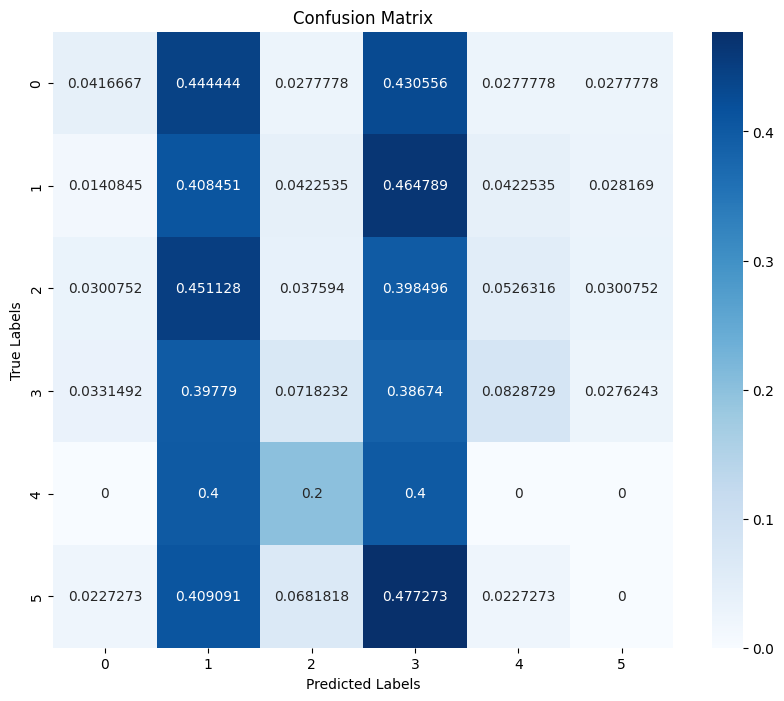

Test Loss: 1.691, Accuracy: 0.236, F1 Score: 0.201, F1 Score Per Class [0.068
Test F1 Score Per Class  [0.06818182 0.30208333 0.06134969 0.33018868 0.         0.        ]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=2e-04)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
patch_size=(224, 224)
stride=30
test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(trained_model, test_loader, criterion, device, patch_size, stride, desc='Test')
print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
print(f'Test F1 Score Per Class ', test_f1_per_class)